# 전이 학습 및 미세 조정

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/keras/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a>   </td>
</table>

## 설정

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 시작하기

**전이 학습**은 한 가지 문제에 대해 학습한 기능을 가져와서 비슷한 새로운 문제에 활용하는 것으로 구성됩니다. 예를 들어, 너구리를 식별하는 방법을 배운 모델의 기능은 너구리를 식별하는 모델을 시작하는 데 유용할 수 있습니다.

전이 학습은 일반적으로 전체 모델을 처음부터 훈련하기에는 데이터세트에 데이터가 너무 적은 작업에 대해 수행됩니다.

딥 러닝의 맥락에서 전이 학습의 가장 일반적인 구현은 다음 워크플로와 같습니다.

1. 이전에 훈련된 모델에서 레이어를 가져옵니다.
2. 추후 훈련 라운드 중에 포함된 정보가 손상되지 않도록 동결합니다.
3. 고정된 레이어 위에 훈련할 수 있는 새 레이어를 추가합니다. 해당 레이어는 기존 기능을 새로운 데이터세트에 대한 예측으로 전환하는 방법을 배웁니다.
4. 데이터세트에서 새로운 레이어를 훈련합니다.

마지막으로 선택적인 단계는 **미세 조정**입니다. 이 단계는 위에서 얻은 전체 모델(또는 모델의 일부)을 동결 해제하고 학습률이 매우 낮은 새로운 데이터에 대해 재훈련하는 과정으로 구성됩니다. 이는 사전 훈련된 특성을 새로운 데이터에 점진적으로 적용함으로써 의미 있는 개선을 달성할 수 있습니다.

먼저, Keras의 `trainable` API에 대해 자세히 살펴보겠습니다. 이 API는 대부분의 전이 학습 및 미세 조정 워크플로의 기초가 됩니다.

그런 다음 ImageNet 데이터세트에서 사전 훈련된 모델을 사용하여 Kaggle "cats vs dogs" 분류 데이터세트에서 재훈련함으로써 일반적인 워크플로를 시연합니다.

이것은 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)과 2016 블로그 게시물 ["building powerful image classification models using very little data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)로부터 조정되었습니다.

## 레이어 동결: `trainable` 속성의 이해

레이어 및 모델에는 세 가지 가중치 속성이 있습니다.

- `weights`는 레이어의 모든 가중치 변수 목록입니다.
- `trainable_weights`는 훈련 중 손실을 최소화하기 위해 업데이트(그래디언트 디센트를 통해)되어야 하는 목록입니다.
- `non_trainable_weights`는 훈련되지 않은 가중치 변수의 목록입니다. 일반적으로 순방향 전달 중에 모델에 의해 업데이트됩니다.

**예제: `Dense` 레이어에는 2개의 훈련 가능한 가중치가 있습니다(커널 및 바이어스)**

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


일반적으로 모든 가중치는 훈련이 가능합니다. 훈련할 수 없는 가중치가 있는 유일한 내장 레이어는 `BatchNormalization` 레이어입니다. 훈련할 수 없는 가중치를 사용하여 훈련 중 입력의 평균 및 분산을 추적합니다. 훈련할 수 없는 가중치를 사용자 정의 레이어에서 사용하는 방법을 배우려면 [새 레이어를 처음부터 작성하는 방법](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)을 참조하세요.

**예제: `BatchNormalization` 레이어에는 2개의 훈련 가능한 가중치와 2개의 훈련할 수 없는 가중치가 있습니다**

In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


레이어 및 모델에는 boolean 속성 `trainable`도 있습니다. 값은 변경될 수 있습니다. `layer.trainable`을 `False`로 설정하면 모든 레이어의 가중치가 훈련 가능에서 훈련 불가능으로 이동합니다. 이를 레이어 "동결"이라고 합니다. 동결 레이어의 상태는 `fit()`을 사용하거나 `trainable_weights`에 의존하는 사용자 정의 루프를 사용해 훈련하여 그래디언트 업데이트를 적용할 때도 훈련하는 동안 업데이트되지 않습니다.

**예제: `trainable`을 `False`로 설정**

In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


훈련 가능한 가중치가 훈련할 수 없게 되면 훈련 중에 그 값이 더는 업데이트되지 않습니다.

In [6]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


1/1 [==============================] - ETA: 0s - loss: 0.1928


1/1 [==============================] - 1s 1s/step - loss: 0.1928


`layer.trainable` 속성을 레이어가 추론 모드 또는 훈련 모드에서 순방향 전달을 실행해야 하는지를 제어하는 `layer.__call__()`의 인수 `training`과 혼동하지 마세요. 자세한 내용은 [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)를 참조하세요.

## `trainable` 속성의 재귀 설정

모델 또는 하위 레이어가 있는 레이어에서 `trainable = False`를 설정하면 모든 하위 레이어도 훈련할 수 없게 됩니다.

**예제:**

In [7]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## 일반적인 전이 학습 워크플로

이를 통해 Keras에서 일반적인 전이 학습 워크플로를 구현할 수 있습니다.

1. 기본 모델을 인스턴스화하고 사전 훈련된 가중치를 여기에 로드합니다.
2. `trainable = False`를 설정하여 기본 모델의 모든 레이어를 동결합니다.
3. 기본 모델에서 하나 이상의 레이어 출력 위에 새 모델을 만듭니다.
4. 새 데이터세트에서 새 모델을 훈련합니다.

보다 가벼운 대안 워크플로는 다음과 같습니다.

1. 기본 모델을 인스턴스화하고 사전 훈련된 가중치를 여기에 로드합니다.
2. 이를 통해 새로운 데이터세트를 실행하고 기본 모델의 하나의(또는 여러) 레이어의 출력을 기록합니다. 이를 **특성 추출**이라 합니다.
3. 이 출력을 더 작은 새 모델의 입력 데이터로 사용합니다.

이 두 번째 워크플로의 주요 장점은 훈련 epoch마다 한 번이 아니라 한 번의 데이터로 기본 모델을 실행한다는 것입니다. 따라서 훨씬 빠르고 저렴합니다.

그러나 두 번째 워크플로의 문제점은 훈련 중에 새 모델의 입력 데이터를 동적으로 수정할 수 없다는 것입니다. 예를 들어 데이터 증강을 수행할 때 필요합니다. 전이 학습은 일반적으로 새 데이터세트에 데이터가 너무 작아서 전체 규모의 모델을 처음부터 훈련할 수 없는 작업에 사용되며, 이러한 시나리오에서는 데이터 증강이 매우 중요합니다. 따라서 다음 내용에서는 첫 번째 워크플로에 중점을 둘 것입니다.

Keras의 첫 번째 워크플로는 다음과 같습니다.

먼저, 사전 훈련된 가중치를 사용하여 기본 모델을 인스턴스화합니다.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

그런 다음 기본 모델을 동결합니다.

```python
base_model.trainable = False
```

맨 위에 새 모델을 만듭니다.

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

새 데이터로 모델을 훈련합니다.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## 미세 조정

모델이 새로운 데이터에 수렴하면 기본 모델의 일부 또는 전부를 동결 해제하고 학습률이 매우 낮은 전체 모델을 전체적으로 재훈련할 수 있습니다.

이 단계는 선택적으로 마지막 단계이며 점진적으로 개선할 수 있습니다. 또한 잠재적으로 빠른 과대적합을 초래할 수 있습니다. 명심하세요.

동결된 레이어가 있는 모델이 수렴하도록 훈련된 *후*에만 이 단계를 수행하는 것이 중요합니다. 무작위로 초기화된 훈련 가능한 레이어를 사전 훈련된 특성을 보유하는 훈련 가능한 레이어와 혼합하는 경우, 무작위로 초기화된 레이어는 훈련 중에 매우 큰 그래디언트 업데이트를 유발하여 사전 훈련된 특성을 파괴합니다.

또한 이 단계에서는 일반적으로 매우 작은 데이터 집합에서 첫 번째 훈련보다 훨씬 더 큰 모델을 훈련하기 때문에, 매우 낮은 학습률을 사용하는 것이 중요합니다. 결과적으로 큰 가중치 업데이트를 적용하면 과도하게 빠른 과대적합의 위험이 있습니다. 여기에서는 사전 훈련된 가중치만 점진적인 방식으로 다시 적용하려고 합니다.

다음은 전체 기본 모델의 미세 조정을 구현하는 방법입니다.

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**`compile()` 및 `trainable`에 대한 중요 사항**

모델에서 `compile()`을 호출하는 것은 해당 모델의 동작을 "동결"하기 위한 것입니다. 이는 `compile`이 다시 호출될 때까지 모델이 컴파일될 때 `trainable` 속성값이 해당 모델의 수명 동안 유지되어야 함을 의미합니다. 따라서 `trainable` 값을 변경하면 모델에서 `compile()`을 다시 호출하여 변경 사항을 적용합니다.

**`BatchNormalization` 레이어에 대한 중요 사항**

많은 이미지 모델에는 `BatchNormalization` 레이어가 포함되어 있습니다. 그 레이어는 상상할 수 있는 모든 수에서 특별한 경우입니다. 다음은 명심해야 할 몇 가지 사항입니다.

- `BatchNormalization`에는 훈련 중에 업데이트되는 훈련 불가능한 2개의 가중치가 포함되어 있습니다. 입력의 평균과 분산을 추적하는 변수입니다.
- `bn_layer.trainable = False`를 설정하면 `BatchNormalization` 레이어가 추론 모드에서 실행되며 평균 및 분산 통계가 업데이트되지 않습니다. [가중치 훈련 및 추론/훈련 모드가 직교 개념](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)이므로 일반적으로 다른 레이어의 경우에는 해당하지 않습니다. 그러나 `BatchNormalization` 레이어의 경우 두 가지가 묶여 있습니다.
- 미세 조정을 위해 `BatchNormalization` 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 `training=False`를 전달하여 `BatchNormalization` 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 갑작스럽게 파괴됩니다.

이 가이드 끝의 엔드 투 엔드 예제에서 이 패턴이 적용되는 것을 볼 수 있습니다.


## 사용자 정의 훈련 루프를 사용한 전이 학습 및 미세 조정

`fit()` 대신 자체 저수준 훈련 루프를 사용하는 경우 워크플로는 본질적으로 동일하게 유지됩니다. 그래디언트 업데이트를 적용할 때 목록 `model.trainable_weights`만 고려해야 합니다.

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

미세 조정의 경우도 마찬가지입니다.

## 엔드 투 엔드 예제: 고양이 vs 개 데이터세트에서 이미지 분류 모델 미세 조정

이러한 개념을 강화하기 위해 구체적인 엔드 투 엔드 전이 학습 및 미세 조정 예제를 안내합니다. ImageNet에서 사전 훈련된 Xception 모델을 로드하고 Kaggle "cats vs. dogs" 분류 데이터세트에서 사용합니다.

### 데이터 얻기

먼저 TFDS를 사용해 고양이 vs 개 데이터세트를 가져옵니다. 자체 데이터세트가 있다면 유틸리티 `tf.keras.preprocessing.image_dataset_from_directory`를 사용하여 클래스별 폴더에 보관된 디스크의 이미지 세트에서 유사한 레이블이 지정된 데이터세트 객체를 생성할 수 있습니다.

전이 학습은 매우 작은 데이터로 작업할 때 가장 유용합니다. 데이터세트를 작게 유지하기 위해 원래 훈련 데이터(25,000개 이미지)의 40%를 훈련에, 10%를 유효성 검사에, 10%를 테스트에 사용합니다.

In [8]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


이것은 훈련 데이터세트에서 처음 9개의 이미지입니다. 보시다시피 이미지는 모두 크기가 다릅니다.

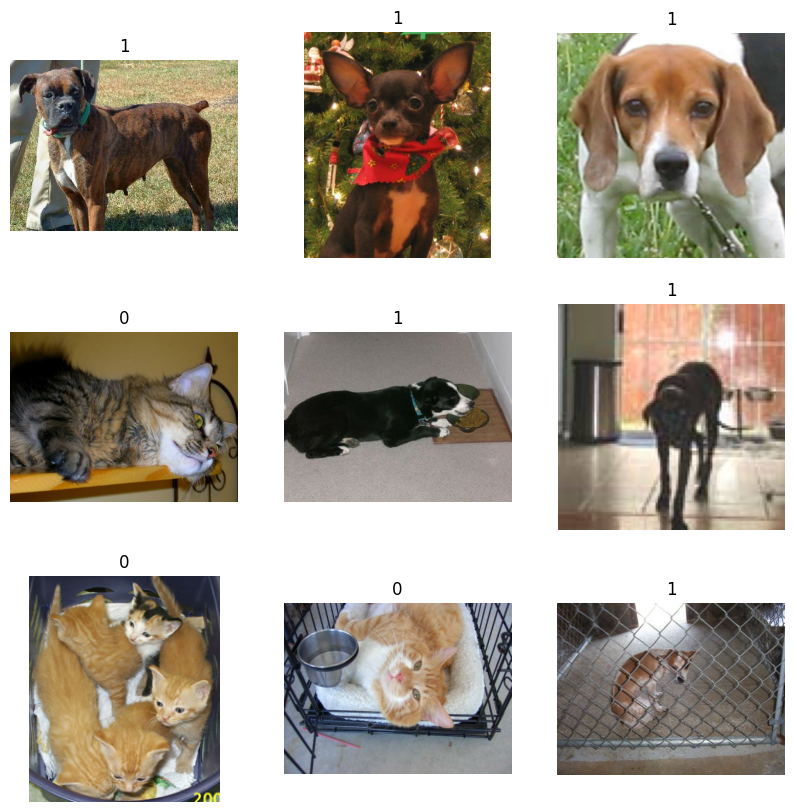

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

레이블 1이 "개"이고 레이블 0이 "고양이"임을 알 수 있습니다.

### 데이터 표준화하기

원시 이미지는 다양한 크기를 가지고 있습니다. 또한 각 픽셀은 0에서 255 사이의 3개의 정숫값(RGB 레벨값)으로 구성됩니다. 이는 신경망에 공급하기 적합하지 않습니다. 2가지를 수행해야 합니다.

- 고정된 이미지 크기로 표준화합니다. 150x150을 선택합니다.
- 정상 픽셀 값은 -1 과 1 사이입니다. 모델 자체의 일부로 `Normalization` 레이어를 사용합니다.

일반적으로 이미 사전 처리된 데이터를 사용하는 모델과 달리 원시 데이터를 입력으로 사용하는 모델을 개발하는 것이 좋습니다. 모델에 사전 처리 된 데이터가 필요한 경우 모델을 내보내 다른 위치(웹 브라우저, 모바일 앱)에서 사용할 때마다 동일한 사전 처리 파이프 라인을 다시 구현해야하기 때문입니다. 이것은 매우 까다로워집니다. 따라서 모델에 도달하기 전에 가능한 최소한의 전처리를 수행해야합니다.

여기에서는 데이터 파이프라인에서 이미지 크기 조정을 수행하고(심층 신경망은 인접한 데이터 배치만 처리할 수 있기 때문에) 입력값 스케일링을 모델의 일부로 생성합니다.

이미지 크기를 150x150으로 조정해 보겠습니다.

In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


또한 데이터를 일괄 처리하고 캐싱 및 프리페치를 사용하여 로딩 속도를 최적화합니다.

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### 무작위 데이터 증강 사용하기

큰 이미지 데이터세트가 없는 경우 임의의 수평 뒤집기 또는 작은 임의의 회전과 같이 훈련 이미지에 무작위이지만 사실적인 변형을 적용하여 샘플 다양성을 인위적으로 도입하는 것이 좋습니다. 이것은 과대적합을 늦추면서 모델을 훈련 데이터의 다른 측면에 노출하는 데 도움이 됩니다.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

다양한 무작위 변형 후 첫 번째 배치의 첫 번째 이미지가 어떻게 보이는지 시각화해 보겠습니다.

2022-12-14 22:32:42.196850: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


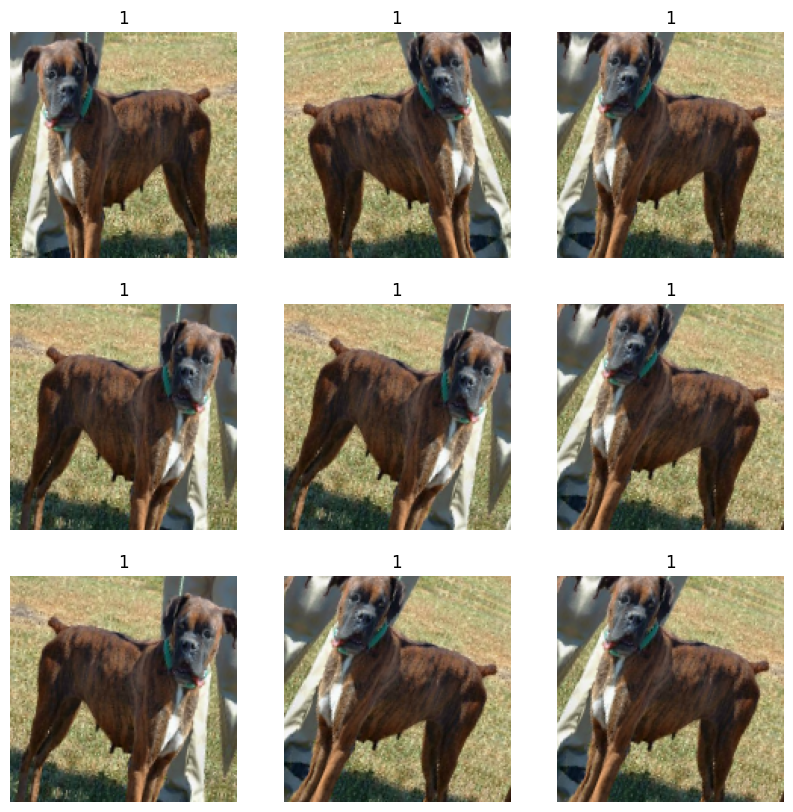

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## 모델 빌드하기

이제 앞에서 설명한 청사진을 따르는 모델을 만들어 보겠습니다.

참고 사항:

- 입력 값(처음에는 `[0, 255]` 범위)을 `[-1, 1]`  범위로 조정하기 위해  `Rescaling` 레이어를 추가합니다.
- 정규화를 위해 분류 레이어 앞에 `Dropout` 레이어를 추가합니다.
- 기본 모델을 호출할 때 `training=False`를 전달하여 추론 모드에서 실행되므로 미세 조정을 위해 기본 모델을 동결 해제한 후에도 batchnorm 통계가 업데이트되지 않습니다.

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


    8192/83683744 [..............................] - ETA: 0s


 1753088/83683744 [..............................] - ETA: 2s


 4202496/83683744 [>.............................] - ETA: 1s


 7340032/83683744 [=>............................] - ETA: 1s


12042240/83683744 [===>..........................] - ETA: 1s


16785408/83683744 [=====>........................] - ETA: 1s


20545536/83683744 [======>.......................] - ETA: 1s


23724032/83683744 [=======>......................] - ETA: 1s


25174016/83683744 [========>.....................] - ETA: 1s


27787264/83683744 [========>.....................] - ETA: 1s


31064064/83683744 [==========>...................] - ETA: 1s


31588352/83683744 [==========>...................] - ETA: 1s


35487744/83683744 [===========>..................] - ETA: 1s


39231488/83683744 [=============>................] - ETA: 0s


41951232/83683744 [==============>...............] - ETA: 0s


44433408/83683744 [==============>...............] - ETA: 0s


50339840/83683744 [=================>............] - ETA: 0s


51847168/83683744 [=================>............] - ETA: 0s


56492032/83683744 [===================>..........] - ETA: 0s


57360384/83683744 [===================>..........] - ETA: 0s


61620224/83683744 [=====================>........] - ETA: 0s


62603264/83683744 [=====================>........] - ETA: 0s


66183168/83683744 [======================>.......] - ETA: 0s


67887104/83683744 [=======================>......] - ETA: 0s


72146944/83683744 [========================>.....] - ETA: 0s


74620928/83683744 [=========================>....] - ETA: 0s


75505664/83683744 [==========================>...] - ETA: 0s


76603392/83683744 [==========================>...] - ETA: 0s


83599360/83683744 [============================>.] - ETA: 0s


83683744/83683744 [==============================] - 2s 0us/step


Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         


 sequential_3 (Sequential)   (None, 150, 150, 3)       0         


 rescaling (Rescaling)       (None, 150, 150, 3)       0         


 xception (Functional)       (None, 5, 5, 2048)        20861480  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 2048)              0         


 dense_7 (Dense)             (None, 1)                 2049      


Total params: 20,863,529


Trainable params: 2,049


Non-trainable params: 20,861,480


_________________________________________________________________


## 최상위 레이어 훈련하기

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20



  1/291 [..............................] - ETA: 27:30 - loss: 0.6763 - binary_accuracy: 0.5000


  2/291 [..............................] - ETA: 22s - loss: 0.7170 - binary_accuracy: 0.5156  


  3/291 [..............................] - ETA: 23s - loss: 0.7491 - binary_accuracy: 0.5104


  4/291 [..............................] - ETA: 22s - loss: 0.7490 - binary_accuracy: 0.5234


  5/291 [..............................] - ETA: 22s - loss: 0.7352 - binary_accuracy: 0.5250


  6/291 [..............................] - ETA: 22s - loss: 0.7407 - binary_accuracy: 0.5208


  7/291 [..............................] - ETA: 22s - loss: 0.7143 - binary_accuracy: 0.5670


  8/291 [..............................] - ETA: 22s - loss: 0.6826 - binary_accuracy: 0.5820


  9/291 [..............................] - ETA: 22s - loss: 0.6697 - binary_accuracy: 0.5938


 10/291 [>.............................] - ETA: 21s - loss: 0.6529 - binary_accuracy: 0.6062


 11/291 [>.............................] - ETA: 21s - loss: 0.6335 - binary_accuracy: 0.6193


 12/291 [>.............................] - ETA: 21s - loss: 0.6092 - binary_accuracy: 0.6380


 13/291 [>.............................] - ETA: 21s - loss: 0.5982 - binary_accuracy: 0.6490


 14/291 [>.............................] - ETA: 21s - loss: 0.5789 - binary_accuracy: 0.6674


 15/291 [>.............................] - ETA: 21s - loss: 0.5620 - binary_accuracy: 0.6833


 16/291 [>.............................] - ETA: 21s - loss: 0.5494 - binary_accuracy: 0.6895


 17/291 [>.............................] - ETA: 21s - loss: 0.5334 - binary_accuracy: 0.6985


 18/291 [>.............................] - ETA: 21s - loss: 0.5218 - binary_accuracy: 0.7083


 19/291 [>.............................] - ETA: 21s - loss: 0.5120 - binary_accuracy: 0.7138


 20/291 [=>............................] - ETA: 21s - loss: 0.4977 - binary_accuracy: 0.7234


 21/291 [=>............................] - ETA: 21s - loss: 0.4902 - binary_accuracy: 0.7277


 22/291 [=>............................] - ETA: 21s - loss: 0.4828 - binary_accuracy: 0.7330


 23/291 [=>............................] - ETA: 20s - loss: 0.4722 - binary_accuracy: 0.7405


 24/291 [=>............................] - ETA: 20s - loss: 0.4594 - binary_accuracy: 0.7487


 25/291 [=>............................] - ETA: 20s - loss: 0.4469 - binary_accuracy: 0.7575


 26/291 [=>............................] - ETA: 20s - loss: 0.4385 - binary_accuracy: 0.7644


 27/291 [=>............................] - ETA: 20s - loss: 0.4342 - binary_accuracy: 0.7674


 28/291 [=>............................] - ETA: 20s - loss: 0.4269 - binary_accuracy: 0.7734


 29/291 [=>............................] - ETA: 20s - loss: 0.4210 - binary_accuracy: 0.7780


 30/291 [==>...........................] - ETA: 20s - loss: 0.4129 - binary_accuracy: 0.7802


 31/291 [==>...........................] - ETA: 20s - loss: 0.4090 - binary_accuracy: 0.7833


 32/291 [==>...........................] - ETA: 20s - loss: 0.4012 - binary_accuracy: 0.7881


 33/291 [==>...........................] - ETA: 20s - loss: 0.3959 - binary_accuracy: 0.7926


 34/291 [==>...........................] - ETA: 20s - loss: 0.3905 - binary_accuracy: 0.7950


 35/291 [==>...........................] - ETA: 19s - loss: 0.3833 - binary_accuracy: 0.8000


 36/291 [==>...........................] - ETA: 19s - loss: 0.3776 - binary_accuracy: 0.8047


 37/291 [==>...........................] - ETA: 19s - loss: 0.3729 - binary_accuracy: 0.8074


 38/291 [==>...........................] - ETA: 19s - loss: 0.3718 - binary_accuracy: 0.8076


 39/291 [===>..........................] - ETA: 19s - loss: 0.3680 - binary_accuracy: 0.8101


 40/291 [===>..........................] - ETA: 19s - loss: 0.3625 - binary_accuracy: 0.8133


 41/291 [===>..........................] - ETA: 19s - loss: 0.3583 - binary_accuracy: 0.8155


 42/291 [===>..........................] - ETA: 19s - loss: 0.3542 - binary_accuracy: 0.8185


 43/291 [===>..........................] - ETA: 19s - loss: 0.3510 - binary_accuracy: 0.8205


 44/291 [===>..........................] - ETA: 19s - loss: 0.3481 - binary_accuracy: 0.8224


 45/291 [===>..........................] - ETA: 19s - loss: 0.3455 - binary_accuracy: 0.8243


 46/291 [===>..........................] - ETA: 19s - loss: 0.3416 - binary_accuracy: 0.8261


 47/291 [===>..........................] - ETA: 19s - loss: 0.3365 - binary_accuracy: 0.8291


 48/291 [===>..........................] - ETA: 18s - loss: 0.3320 - binary_accuracy: 0.8320


 49/291 [====>.........................] - ETA: 18s - loss: 0.3279 - binary_accuracy: 0.8355


 50/291 [====>.........................] - ETA: 18s - loss: 0.3250 - binary_accuracy: 0.8375


 51/291 [====>.........................] - ETA: 18s - loss: 0.3227 - binary_accuracy: 0.8388


 52/291 [====>.........................] - ETA: 18s - loss: 0.3178 - binary_accuracy: 0.8419


 53/291 [====>.........................] - ETA: 18s - loss: 0.3137 - binary_accuracy: 0.8449


 54/291 [====>.........................] - ETA: 18s - loss: 0.3107 - binary_accuracy: 0.8455


 55/291 [====>.........................] - ETA: 18s - loss: 0.3074 - binary_accuracy: 0.8472


 56/291 [====>.........................] - ETA: 18s - loss: 0.3038 - binary_accuracy: 0.8493


 57/291 [====>.........................] - ETA: 18s - loss: 0.3013 - binary_accuracy: 0.8509


 58/291 [====>.........................] - ETA: 18s - loss: 0.2980 - binary_accuracy: 0.8534


 59/291 [=====>........................] - ETA: 18s - loss: 0.2947 - binary_accuracy: 0.8554


 60/291 [=====>........................] - ETA: 17s - loss: 0.2938 - binary_accuracy: 0.8547


 61/291 [=====>........................] - ETA: 17s - loss: 0.2911 - binary_accuracy: 0.8560


 62/291 [=====>........................] - ETA: 17s - loss: 0.2878 - binary_accuracy: 0.8579


 63/291 [=====>........................] - ETA: 17s - loss: 0.2844 - binary_accuracy: 0.8601


 64/291 [=====>........................] - ETA: 17s - loss: 0.2810 - binary_accuracy: 0.8618


 65/291 [=====>........................] - ETA: 17s - loss: 0.2782 - binary_accuracy: 0.8635


 66/291 [=====>........................] - ETA: 17s - loss: 0.2761 - binary_accuracy: 0.8646


 67/291 [=====>........................] - ETA: 17s - loss: 0.2746 - binary_accuracy: 0.8652


 68/291 [======>.......................] - ETA: 17s - loss: 0.2727 - binary_accuracy: 0.8663


 69/291 [======>.......................] - ETA: 17s - loss: 0.2707 - binary_accuracy: 0.8678


 70/291 [======>.......................] - ETA: 17s - loss: 0.2681 - binary_accuracy: 0.8692


 71/291 [======>.......................] - ETA: 17s - loss: 0.2660 - binary_accuracy: 0.8702


 72/291 [======>.......................] - ETA: 16s - loss: 0.2641 - binary_accuracy: 0.8715


 73/291 [======>.......................] - ETA: 16s - loss: 0.2633 - binary_accuracy: 0.8720


 74/291 [======>.......................] - ETA: 16s - loss: 0.2631 - binary_accuracy: 0.8720


 75/291 [======>.......................] - ETA: 16s - loss: 0.2602 - binary_accuracy: 0.8737


 76/291 [======>.......................] - ETA: 16s - loss: 0.2580 - binary_accuracy: 0.8754


 77/291 [======>.......................] - ETA: 16s - loss: 0.2571 - binary_accuracy: 0.8766


 78/291 [=======>......................] - ETA: 16s - loss: 0.2552 - binary_accuracy: 0.8778


 79/291 [=======>......................] - ETA: 16s - loss: 0.2527 - binary_accuracy: 0.8794


 80/291 [=======>......................] - ETA: 16s - loss: 0.2528 - binary_accuracy: 0.8789


 81/291 [=======>......................] - ETA: 16s - loss: 0.2522 - binary_accuracy: 0.8796


 82/291 [=======>......................] - ETA: 16s - loss: 0.2510 - binary_accuracy: 0.8807


 83/291 [=======>......................] - ETA: 16s - loss: 0.2487 - binary_accuracy: 0.8814


 84/291 [=======>......................] - ETA: 16s - loss: 0.2480 - binary_accuracy: 0.8821


 85/291 [=======>......................] - ETA: 15s - loss: 0.2484 - binary_accuracy: 0.8824


 86/291 [=======>......................] - ETA: 15s - loss: 0.2469 - binary_accuracy: 0.8830


 87/291 [=======>......................] - ETA: 15s - loss: 0.2462 - binary_accuracy: 0.8836


 88/291 [========>.....................] - ETA: 15s - loss: 0.2457 - binary_accuracy: 0.8835


 89/291 [========>.....................] - ETA: 15s - loss: 0.2449 - binary_accuracy: 0.8841


 90/291 [========>.....................] - ETA: 15s - loss: 0.2434 - binary_accuracy: 0.8851


 91/291 [========>.....................] - ETA: 15s - loss: 0.2416 - binary_accuracy: 0.8860


 92/291 [========>.....................] - ETA: 15s - loss: 0.2401 - binary_accuracy: 0.8869


 93/291 [========>.....................] - ETA: 15s - loss: 0.2384 - binary_accuracy: 0.8874


 94/291 [========>.....................] - ETA: 15s - loss: 0.2363 - binary_accuracy: 0.8886


 95/291 [========>.....................] - ETA: 15s - loss: 0.2365 - binary_accuracy: 0.8875


 96/291 [========>.....................] - ETA: 15s - loss: 0.2351 - binary_accuracy: 0.8880


 97/291 [=========>....................] - ETA: 15s - loss: 0.2338 - binary_accuracy: 0.8892


 98/291 [=========>....................] - ETA: 14s - loss: 0.2334 - binary_accuracy: 0.8893


 99/291 [=========>....................] - ETA: 14s - loss: 0.2324 - binary_accuracy: 0.8895


100/291 [=========>....................] - ETA: 14s - loss: 0.2308 - binary_accuracy: 0.8903


101/291 [=========>....................] - ETA: 14s - loss: 0.2296 - binary_accuracy: 0.8908


102/291 [=========>....................] - ETA: 14s - loss: 0.2291 - binary_accuracy: 0.8906


103/291 [=========>....................] - ETA: 14s - loss: 0.2280 - binary_accuracy: 0.8914


104/291 [=========>....................] - ETA: 14s - loss: 0.2274 - binary_accuracy: 0.8921


105/291 [=========>....................] - ETA: 14s - loss: 0.2287 - binary_accuracy: 0.8920


106/291 [=========>....................] - ETA: 14s - loss: 0.2284 - binary_accuracy: 0.8924


107/291 [==========>...................] - ETA: 14s - loss: 0.2265 - binary_accuracy: 0.8934


108/291 [==========>...................] - ETA: 14s - loss: 0.2259 - binary_accuracy: 0.8941


109/291 [==========>...................] - ETA: 14s - loss: 0.2244 - binary_accuracy: 0.8948


110/291 [==========>...................] - ETA: 14s - loss: 0.2237 - binary_accuracy: 0.8952


111/291 [==========>...................] - ETA: 13s - loss: 0.2238 - binary_accuracy: 0.8953


112/291 [==========>...................] - ETA: 13s - loss: 0.2230 - binary_accuracy: 0.8962


113/291 [==========>...................] - ETA: 13s - loss: 0.2218 - binary_accuracy: 0.8971


114/291 [==========>...................] - ETA: 13s - loss: 0.2209 - binary_accuracy: 0.8972


115/291 [==========>...................] - ETA: 13s - loss: 0.2201 - binary_accuracy: 0.8981


116/291 [==========>...................] - ETA: 13s - loss: 0.2193 - binary_accuracy: 0.8990


117/291 [===========>..................] - ETA: 13s - loss: 0.2181 - binary_accuracy: 0.8996


118/291 [===========>..................] - ETA: 13s - loss: 0.2177 - binary_accuracy: 0.8996


119/291 [===========>..................] - ETA: 13s - loss: 0.2167 - binary_accuracy: 0.9002


120/291 [===========>..................] - ETA: 13s - loss: 0.2155 - binary_accuracy: 0.9008


121/291 [===========>..................] - ETA: 13s - loss: 0.2147 - binary_accuracy: 0.9011


122/291 [===========>..................] - ETA: 13s - loss: 0.2141 - binary_accuracy: 0.9014


123/291 [===========>..................] - ETA: 13s - loss: 0.2145 - binary_accuracy: 0.9012


124/291 [===========>..................] - ETA: 12s - loss: 0.2143 - binary_accuracy: 0.9012


125/291 [===========>..................] - ETA: 12s - loss: 0.2150 - binary_accuracy: 0.9007


126/291 [===========>..................] - ETA: 12s - loss: 0.2143 - binary_accuracy: 0.9010


127/291 [============>.................] - ETA: 12s - loss: 0.2145 - binary_accuracy: 0.9008


128/291 [============>.................] - ETA: 12s - loss: 0.2134 - binary_accuracy: 0.9014


129/291 [============>.................] - ETA: 12s - loss: 0.2132 - binary_accuracy: 0.9014


130/291 [============>.................] - ETA: 12s - loss: 0.2126 - binary_accuracy: 0.9019


131/291 [============>.................] - ETA: 12s - loss: 0.2118 - binary_accuracy: 0.9022


132/291 [============>.................] - ETA: 12s - loss: 0.2117 - binary_accuracy: 0.9022


133/291 [============>.................] - ETA: 12s - loss: 0.2113 - binary_accuracy: 0.9023


134/291 [============>.................] - ETA: 12s - loss: 0.2104 - binary_accuracy: 0.9025


135/291 [============>.................] - ETA: 12s - loss: 0.2094 - binary_accuracy: 0.9030


136/291 [=============>................] - ETA: 12s - loss: 0.2094 - binary_accuracy: 0.9026


137/291 [=============>................] - ETA: 11s - loss: 0.2084 - binary_accuracy: 0.9031


138/291 [=============>................] - ETA: 11s - loss: 0.2081 - binary_accuracy: 0.9033


139/291 [=============>................] - ETA: 11s - loss: 0.2073 - binary_accuracy: 0.9040


140/291 [=============>................] - ETA: 11s - loss: 0.2063 - binary_accuracy: 0.9045


141/291 [=============>................] - ETA: 11s - loss: 0.2064 - binary_accuracy: 0.9045


142/291 [=============>................] - ETA: 11s - loss: 0.2066 - binary_accuracy: 0.9043


143/291 [=============>................] - ETA: 11s - loss: 0.2061 - binary_accuracy: 0.9043


144/291 [=============>................] - ETA: 11s - loss: 0.2055 - binary_accuracy: 0.9043

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9



145/291 [=============>................] - ETA: 11s - loss: 0.2049 - binary_accuracy: 0.9045


146/291 [==============>...............] - ETA: 11s - loss: 0.2045 - binary_accuracy: 0.9050


147/291 [==============>...............] - ETA: 11s - loss: 0.2038 - binary_accuracy: 0.9052


148/291 [==============>...............] - ETA: 11s - loss: 0.2040 - binary_accuracy: 0.9052


149/291 [==============>...............] - ETA: 11s - loss: 0.2035 - binary_accuracy: 0.9056


150/291 [==============>...............] - ETA: 10s - loss: 0.2029 - binary_accuracy: 0.9060


151/291 [==============>...............] - ETA: 10s - loss: 0.2028 - binary_accuracy: 0.9062


152/291 [==============>...............] - ETA: 10s - loss: 0.2021 - binary_accuracy: 0.9069


153/291 [==============>...............] - ETA: 10s - loss: 0.2012 - binary_accuracy: 0.9075


154/291 [==============>...............] - ETA: 10s - loss: 0.2009 - binary_accuracy: 0.9077


155/291 [==============>...............] - ETA: 10s - loss: 0.2008 - binary_accuracy: 0.9079


156/291 [===============>..............] - ETA: 10s - loss: 0.2001 - binary_accuracy: 0.9081


157/291 [===============>..............] - ETA: 10s - loss: 0.1995 - binary_accuracy: 0.9082


158/291 [===============>..............] - ETA: 10s - loss: 0.1990 - binary_accuracy: 0.9082


159/291 [===============>..............] - ETA: 10s - loss: 0.1987 - binary_accuracy: 0.9082


160/291 [===============>..............] - ETA: 10s - loss: 0.1996 - binary_accuracy: 0.9078


161/291 [===============>..............] - ETA: 10s - loss: 0.1994 - binary_accuracy: 0.9082


162/291 [===============>..............] - ETA: 10s - loss: 0.1988 - binary_accuracy: 0.9086


163/291 [===============>..............] - ETA: 9s - loss: 0.1983 - binary_accuracy: 0.9087 


164/291 [===============>..............] - ETA: 9s - loss: 0.1972 - binary_accuracy: 0.9093


165/291 [================>.............] - ETA: 9s - loss: 0.1967 - binary_accuracy: 0.9093


166/291 [================>.............] - ETA: 9s - loss: 0.1963 - binary_accuracy: 0.9095


167/291 [================>.............] - ETA: 9s - loss: 0.1956 - binary_accuracy: 0.9098


168/291 [================>.............] - ETA: 9s - loss: 0.1952 - binary_accuracy: 0.9098


169/291 [================>.............] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9099


170/291 [================>.............] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9099


171/291 [================>.............] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9103


172/291 [================>.............] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9102


173/291 [================>.............] - ETA: 9s - loss: 0.1943 - binary_accuracy: 0.9104


174/291 [================>.............] - ETA: 9s - loss: 0.1935 - binary_accuracy: 0.9109


175/291 [=================>............] - ETA: 9s - loss: 0.1942 - binary_accuracy: 0.9109


176/291 [=================>............] - ETA: 8s - loss: 0.1943 - binary_accuracy: 0.9109


177/291 [=================>............] - ETA: 8s - loss: 0.1936 - binary_accuracy: 0.9112


178/291 [=================>............] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9112


179/291 [=================>............] - ETA: 8s - loss: 0.1938 - binary_accuracy: 0.9115


180/291 [=================>............] - ETA: 8s - loss: 0.1935 - binary_accuracy: 0.9116


181/291 [=================>............] - ETA: 8s - loss: 0.1938 - binary_accuracy: 0.9116


182/291 [=================>............] - ETA: 8s - loss: 0.1940 - binary_accuracy: 0.9116


183/291 [=================>............] - ETA: 8s - loss: 0.1937 - binary_accuracy: 0.9115


184/291 [=================>............] - ETA: 8s - loss: 0.1928 - binary_accuracy: 0.9120


185/291 [==================>...........] - ETA: 8s - loss: 0.1922 - binary_accuracy: 0.9123


186/291 [==================>...........] - ETA: 8s - loss: 0.1917 - binary_accuracy: 0.9126


187/291 [==================>...........] - ETA: 8s - loss: 0.1916 - binary_accuracy: 0.9126


188/291 [==================>...........] - ETA: 7s - loss: 0.1920 - binary_accuracy: 0.9124


189/291 [==================>...........] - ETA: 7s - loss: 0.1921 - binary_accuracy: 0.9125


190/291 [==================>...........] - ETA: 7s - loss: 0.1920 - binary_accuracy: 0.9128


191/291 [==================>...........] - ETA: 7s - loss: 0.1918 - binary_accuracy: 0.9130


192/291 [==================>...........] - ETA: 7s - loss: 0.1916 - binary_accuracy: 0.9132


193/291 [==================>...........] - ETA: 7s - loss: 0.1923 - binary_accuracy: 0.9129


194/291 [===================>..........] - ETA: 7s - loss: 0.1921 - binary_accuracy: 0.9132


195/291 [===================>..........] - ETA: 7s - loss: 0.1916 - binary_accuracy: 0.9136


196/291 [===================>..........] - ETA: 7s - loss: 0.1910 - binary_accuracy: 0.9141


197/291 [===================>..........] - ETA: 7s - loss: 0.1906 - binary_accuracy: 0.9142


198/291 [===================>..........] - ETA: 7s - loss: 0.1904 - binary_accuracy: 0.9145


199/291 [===================>..........] - ETA: 7s - loss: 0.1903 - binary_accuracy: 0.9144


200/291 [===================>..........] - ETA: 7s - loss: 0.1896 - binary_accuracy: 0.9147


201/291 [===================>..........] - ETA: 6s - loss: 0.1892 - binary_accuracy: 0.9148


202/291 [===================>..........] - ETA: 6s - loss: 0.1894 - binary_accuracy: 0.9148


203/291 [===================>..........] - ETA: 6s - loss: 0.1888 - binary_accuracy: 0.9152


204/291 [====================>.........] - ETA: 6s - loss: 0.1884 - binary_accuracy: 0.9154


205/291 [====================>.........] - ETA: 6s - loss: 0.1882 - binary_accuracy: 0.9154


206/291 [====================>.........] - ETA: 6s - loss: 0.1883 - binary_accuracy: 0.9150


207/291 [====================>.........] - ETA: 6s - loss: 0.1879 - binary_accuracy: 0.9150


208/291 [====================>.........] - ETA: 6s - loss: 0.1875 - binary_accuracy: 0.9150


209/291 [====================>.........] - ETA: 6s - loss: 0.1873 - binary_accuracy: 0.9149


210/291 [====================>.........] - ETA: 6s - loss: 0.1869 - binary_accuracy: 0.9150


211/291 [====================>.........] - ETA: 6s - loss: 0.1866 - binary_accuracy: 0.9150


212/291 [====================>.........] - ETA: 6s - loss: 0.1862 - binary_accuracy: 0.9151


213/291 [====================>.........] - ETA: 6s - loss: 0.1862 - binary_accuracy: 0.9152


214/291 [=====================>........] - ETA: 5s - loss: 0.1857 - binary_accuracy: 0.9154


215/291 [=====================>........] - ETA: 5s - loss: 0.1852 - binary_accuracy: 0.9157


216/291 [=====================>........] - ETA: 5s - loss: 0.1846 - binary_accuracy: 0.9161


217/291 [=====================>........] - ETA: 5s - loss: 0.1842 - binary_accuracy: 0.9163


218/291 [=====================>........] - ETA: 5s - loss: 0.1843 - binary_accuracy: 0.9164


219/291 [=====================>........] - ETA: 5s - loss: 0.1842 - binary_accuracy: 0.9165


220/291 [=====================>........] - ETA: 5s - loss: 0.1841 - binary_accuracy: 0.9166


221/291 [=====================>........] - ETA: 5s - loss: 0.1836 - binary_accuracy: 0.9170


222/291 [=====================>........] - ETA: 5s - loss: 0.1838 - binary_accuracy: 0.9167


223/291 [=====================>........] - ETA: 5s - loss: 0.1836 - binary_accuracy: 0.9169


224/291 [======================>.......] - ETA: 5s - loss: 0.1830 - binary_accuracy: 0.9173


225/291 [======================>.......] - ETA: 5s - loss: 0.1828 - binary_accuracy: 0.9174


226/291 [======================>.......] - ETA: 5s - loss: 0.1824 - binary_accuracy: 0.9175


227/291 [======================>.......] - ETA: 4s - loss: 0.1817 - binary_accuracy: 0.9178


228/291 [======================>.......] - ETA: 4s - loss: 0.1815 - binary_accuracy: 0.9178


229/291 [======================>.......] - ETA: 4s - loss: 0.1810 - binary_accuracy: 0.9180


230/291 [======================>.......] - ETA: 4s - loss: 0.1811 - binary_accuracy: 0.9181


231/291 [======================>.......] - ETA: 4s - loss: 0.1813 - binary_accuracy: 0.9179


232/291 [======================>.......] - ETA: 4s - loss: 0.1810 - binary_accuracy: 0.9182


233/291 [=======================>......] - ETA: 4s - loss: 0.1820 - binary_accuracy: 0.9179


234/291 [=======================>......] - ETA: 4s - loss: 0.1815 - binary_accuracy: 0.9183


235/291 [=======================>......] - ETA: 4s - loss: 0.1810 - binary_accuracy: 0.9185


236/291 [=======================>......] - ETA: 4s - loss: 0.1804 - binary_accuracy: 0.9188


237/291 [=======================>......] - ETA: 4s - loss: 0.1802 - binary_accuracy: 0.9189


238/291 [=======================>......] - ETA: 4s - loss: 0.1797 - binary_accuracy: 0.9192


239/291 [=======================>......] - ETA: 4s - loss: 0.1792 - binary_accuracy: 0.9196


240/291 [=======================>......] - ETA: 3s - loss: 0.1793 - binary_accuracy: 0.9194


241/291 [=======================>......] - ETA: 3s - loss: 0.1789 - binary_accuracy: 0.9196


242/291 [=======================>......] - ETA: 3s - loss: 0.1785 - binary_accuracy: 0.9198


243/291 [========================>.....] - ETA: 3s - loss: 0.1780 - binary_accuracy: 0.9200


244/291 [========================>.....] - ETA: 3s - loss: 0.1776 - binary_accuracy: 0.9203


245/291 [========================>.....] - ETA: 3s - loss: 0.1774 - binary_accuracy: 0.9204


246/291 [========================>.....] - ETA: 3s - loss: 0.1772 - binary_accuracy: 0.9205


247/291 [========================>.....] - ETA: 3s - loss: 0.1769 - binary_accuracy: 0.9207


248/291 [========================>.....] - ETA: 3s - loss: 0.1774 - binary_accuracy: 0.9200


249/291 [========================>.....] - ETA: 3s - loss: 0.1768 - binary_accuracy: 0.9203


250/291 [========================>.....] - ETA: 3s - loss: 0.1767 - binary_accuracy: 0.9204


251/291 [========================>.....] - ETA: 3s - loss: 0.1768 - binary_accuracy: 0.9203


252/291 [========================>.....] - ETA: 3s - loss: 0.1764 - binary_accuracy: 0.9204


253/291 [=========================>....] - ETA: 2s - loss: 0.1760 - binary_accuracy: 0.9206


254/291 [=========================>....] - ETA: 2s - loss: 0.1758 - binary_accuracy: 0.9206


255/291 [=========================>....] - ETA: 2s - loss: 0.1755 - binary_accuracy: 0.9207


256/291 [=========================>....] - ETA: 2s - loss: 0.1754 - binary_accuracy: 0.9208


257/291 [=========================>....] - ETA: 2s - loss: 0.1752 - binary_accuracy: 0.9207


258/291 [=========================>....] - ETA: 2s - loss: 0.1748 - binary_accuracy: 0.9210


259/291 [=========================>....] - ETA: 2s - loss: 0.1749 - binary_accuracy: 0.9210


260/291 [=========================>....] - ETA: 2s - loss: 0.1746 - binary_accuracy: 0.9213

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9



261/291 [=========================>....] - ETA: 2s - loss: 0.1743 - binary_accuracy: 0.9212


262/291 [==========================>...] - ETA: 2s - loss: 0.1739 - binary_accuracy: 0.9214


263/291 [==========================>...] - ETA: 2s - loss: 0.1742 - binary_accuracy: 0.9213


264/291 [==========================>...] - ETA: 2s - loss: 0.1740 - binary_accuracy: 0.9215


265/291 [==========================>...] - ETA: 2s - loss: 0.1735 - binary_accuracy: 0.9218


266/291 [==========================>...] - ETA: 1s - loss: 0.1733 - binary_accuracy: 0.9218


267/291 [==========================>...] - ETA: 1s - loss: 0.1734 - binary_accuracy: 0.9218


268/291 [==========================>...] - ETA: 1s - loss: 0.1730 - binary_accuracy: 0.9220


269/291 [==========================>...] - ETA: 1s - loss: 0.1725 - binary_accuracy: 0.9222


270/291 [==========================>...] - ETA: 1s - loss: 0.1722 - binary_accuracy: 0.9223


271/291 [==========================>...] - ETA: 1s - loss: 0.1717 - binary_accuracy: 0.9226


272/291 [===========================>..] - ETA: 1s - loss: 0.1711 - binary_accuracy: 0.9229


273/291 [===========================>..] - ETA: 1s - loss: 0.1713 - binary_accuracy: 0.9228


274/291 [===========================>..] - ETA: 1s - loss: 0.1708 - binary_accuracy: 0.9230

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9



275/291 [===========================>..] - ETA: 1s - loss: 0.1704 - binary_accuracy: 0.9232


276/291 [===========================>..] - ETA: 1s - loss: 0.1701 - binary_accuracy: 0.9233


277/291 [===========================>..] - ETA: 1s - loss: 0.1697 - binary_accuracy: 0.9235

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9



278/291 [===========================>..] - ETA: 1s - loss: 0.1697 - binary_accuracy: 0.9234


279/291 [===========================>..] - ETA: 0s - loss: 0.1696 - binary_accuracy: 0.9234


280/291 [===========================>..] - ETA: 0s - loss: 0.1691 - binary_accuracy: 0.9237


281/291 [===========================>..] - ETA: 0s - loss: 0.1694 - binary_accuracy: 0.9235


282/291 [============================>.] - ETA: 0s - loss: 0.1695 - binary_accuracy: 0.9235


283/291 [============================>.] - ETA: 0s - loss: 0.1697 - binary_accuracy: 0.9233


284/291 [============================>.] - ETA: 0s - loss: 0.1692 - binary_accuracy: 0.9235


285/291 [============================>.] - ETA: 0s - loss: 0.1689 - binary_accuracy: 0.9238


286/291 [============================>.] - ETA: 0s - loss: 0.1698 - binary_accuracy: 0.9234


287/291 [============================>.] - ETA: 0s - loss: 0.1694 - binary_accuracy: 0.9237


288/291 [============================>.] - ETA: 0s - loss: 0.1689 - binary_accuracy: 0.9239


289/291 [============================>.] - ETA: 0s - loss: 0.1688 - binary_accuracy: 0.9240


290/291 [============================>.] - ETA: 0s - loss: 0.1686 - binary_accuracy: 0.9241


291/291 [==============================] - ETA: 0s - loss: 0.1684 - binary_accuracy: 0.9242

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9



291/291 [==============================] - 32s 92ms/step - loss: 0.1684 - binary_accuracy: 0.9242 - val_loss: 0.0826 - val_binary_accuracy: 0.9686


Epoch 2/20



  1/291 [..............................] - ETA: 23s - loss: 0.1466 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 22s - loss: 0.1346 - binary_accuracy: 0.9219


  3/291 [..............................] - ETA: 22s - loss: 0.1306 - binary_accuracy: 0.9375


  4/291 [..............................] - ETA: 21s - loss: 0.1452 - binary_accuracy: 0.9375


  5/291 [..............................] - ETA: 21s - loss: 0.1347 - binary_accuracy: 0.9438


  6/291 [..............................] - ETA: 21s - loss: 0.1552 - binary_accuracy: 0.9375


  7/291 [..............................] - ETA: 21s - loss: 0.1425 - binary_accuracy: 0.9464


  8/291 [..............................] - ETA: 21s - loss: 0.1450 - binary_accuracy: 0.9414


  9/291 [..............................] - ETA: 21s - loss: 0.1521 - binary_accuracy: 0.9410


 10/291 [>.............................] - ETA: 21s - loss: 0.1615 - binary_accuracy: 0.9344


 11/291 [>.............................] - ETA: 21s - loss: 0.1606 - binary_accuracy: 0.9347


 12/291 [>.............................] - ETA: 21s - loss: 0.1509 - binary_accuracy: 0.9401


 13/291 [>.............................] - ETA: 21s - loss: 0.1483 - binary_accuracy: 0.9423


 14/291 [>.............................] - ETA: 21s - loss: 0.1441 - binary_accuracy: 0.9397


 15/291 [>.............................] - ETA: 21s - loss: 0.1440 - binary_accuracy: 0.9417


 16/291 [>.............................] - ETA: 21s - loss: 0.1373 - binary_accuracy: 0.9453


 17/291 [>.............................] - ETA: 21s - loss: 0.1300 - binary_accuracy: 0.9485


 18/291 [>.............................] - ETA: 20s - loss: 0.1319 - binary_accuracy: 0.9479


 19/291 [>.............................] - ETA: 20s - loss: 0.1296 - binary_accuracy: 0.9474


 20/291 [=>............................] - ETA: 20s - loss: 0.1264 - binary_accuracy: 0.9484


 21/291 [=>............................] - ETA: 20s - loss: 0.1343 - binary_accuracy: 0.9449


 22/291 [=>............................] - ETA: 20s - loss: 0.1317 - binary_accuracy: 0.9460


 23/291 [=>............................] - ETA: 20s - loss: 0.1308 - binary_accuracy: 0.9457


 24/291 [=>............................] - ETA: 20s - loss: 0.1269 - binary_accuracy: 0.9479


 25/291 [=>............................] - ETA: 20s - loss: 0.1231 - binary_accuracy: 0.9488


 26/291 [=>............................] - ETA: 20s - loss: 0.1224 - binary_accuracy: 0.9483


 27/291 [=>............................] - ETA: 20s - loss: 0.1227 - binary_accuracy: 0.9479


 28/291 [=>............................] - ETA: 20s - loss: 0.1225 - binary_accuracy: 0.9475


 29/291 [=>............................] - ETA: 20s - loss: 0.1238 - binary_accuracy: 0.9461


 30/291 [==>...........................] - ETA: 20s - loss: 0.1270 - binary_accuracy: 0.9448


 31/291 [==>...........................] - ETA: 19s - loss: 0.1307 - binary_accuracy: 0.9435


 32/291 [==>...........................] - ETA: 19s - loss: 0.1320 - binary_accuracy: 0.9443


 33/291 [==>...........................] - ETA: 19s - loss: 0.1299 - binary_accuracy: 0.9460


 34/291 [==>...........................] - ETA: 19s - loss: 0.1294 - binary_accuracy: 0.9449


 35/291 [==>...........................] - ETA: 19s - loss: 0.1269 - binary_accuracy: 0.9455


 36/291 [==>...........................] - ETA: 19s - loss: 0.1283 - binary_accuracy: 0.9462


 37/291 [==>...........................] - ETA: 19s - loss: 0.1273 - binary_accuracy: 0.9468


 38/291 [==>...........................] - ETA: 19s - loss: 0.1300 - binary_accuracy: 0.9449


 39/291 [===>..........................] - ETA: 19s - loss: 0.1313 - binary_accuracy: 0.9447


 40/291 [===>..........................] - ETA: 19s - loss: 0.1310 - binary_accuracy: 0.9445


 41/291 [===>..........................] - ETA: 19s - loss: 0.1301 - binary_accuracy: 0.9444


 42/291 [===>..........................] - ETA: 18s - loss: 0.1276 - binary_accuracy: 0.9457


 43/291 [===>..........................] - ETA: 18s - loss: 0.1275 - binary_accuracy: 0.9448


 44/291 [===>..........................] - ETA: 18s - loss: 0.1273 - binary_accuracy: 0.9460


 45/291 [===>..........................] - ETA: 18s - loss: 0.1285 - binary_accuracy: 0.9444


 46/291 [===>..........................] - ETA: 18s - loss: 0.1271 - binary_accuracy: 0.9443


 47/291 [===>..........................] - ETA: 18s - loss: 0.1280 - binary_accuracy: 0.9428


 48/291 [===>..........................] - ETA: 18s - loss: 0.1260 - binary_accuracy: 0.9440


 49/291 [====>.........................] - ETA: 18s - loss: 0.1256 - binary_accuracy: 0.9445


 50/291 [====>.........................] - ETA: 18s - loss: 0.1279 - binary_accuracy: 0.9450


 51/291 [====>.........................] - ETA: 18s - loss: 0.1285 - binary_accuracy: 0.9449


 52/291 [====>.........................] - ETA: 18s - loss: 0.1272 - binary_accuracy: 0.9453


 53/291 [====>.........................] - ETA: 18s - loss: 0.1255 - binary_accuracy: 0.9463


 54/291 [====>.........................] - ETA: 18s - loss: 0.1262 - binary_accuracy: 0.9462


 55/291 [====>.........................] - ETA: 17s - loss: 0.1250 - binary_accuracy: 0.9466


 56/291 [====>.........................] - ETA: 17s - loss: 0.1235 - binary_accuracy: 0.9475


 57/291 [====>.........................] - ETA: 17s - loss: 0.1225 - binary_accuracy: 0.9485


 58/291 [====>.........................] - ETA: 17s - loss: 0.1214 - binary_accuracy: 0.9488


 59/291 [=====>........................] - ETA: 17s - loss: 0.1196 - binary_accuracy: 0.9497


 60/291 [=====>........................] - ETA: 17s - loss: 0.1208 - binary_accuracy: 0.9495


 61/291 [=====>........................] - ETA: 17s - loss: 0.1199 - binary_accuracy: 0.9498


 62/291 [=====>........................] - ETA: 17s - loss: 0.1195 - binary_accuracy: 0.9501


 63/291 [=====>........................] - ETA: 17s - loss: 0.1181 - binary_accuracy: 0.9509


 64/291 [=====>........................] - ETA: 17s - loss: 0.1180 - binary_accuracy: 0.9507


 65/291 [=====>........................] - ETA: 17s - loss: 0.1166 - binary_accuracy: 0.9514


 66/291 [=====>........................] - ETA: 17s - loss: 0.1181 - binary_accuracy: 0.9508


 67/291 [=====>........................] - ETA: 16s - loss: 0.1184 - binary_accuracy: 0.9506


 68/291 [======>.......................] - ETA: 16s - loss: 0.1174 - binary_accuracy: 0.9508


 69/291 [======>.......................] - ETA: 16s - loss: 0.1166 - binary_accuracy: 0.9511


 70/291 [======>.......................] - ETA: 16s - loss: 0.1168 - binary_accuracy: 0.9509


 71/291 [======>.......................] - ETA: 16s - loss: 0.1171 - binary_accuracy: 0.9507


 72/291 [======>.......................] - ETA: 16s - loss: 0.1178 - binary_accuracy: 0.9501


 73/291 [======>.......................] - ETA: 16s - loss: 0.1179 - binary_accuracy: 0.9503


 74/291 [======>.......................] - ETA: 16s - loss: 0.1187 - binary_accuracy: 0.9489


 75/291 [======>.......................] - ETA: 16s - loss: 0.1178 - binary_accuracy: 0.9492


 76/291 [======>.......................] - ETA: 16s - loss: 0.1176 - binary_accuracy: 0.9494


 77/291 [======>.......................] - ETA: 16s - loss: 0.1180 - binary_accuracy: 0.9493


 78/291 [=======>......................] - ETA: 16s - loss: 0.1174 - binary_accuracy: 0.9499


 79/291 [=======>......................] - ETA: 16s - loss: 0.1171 - binary_accuracy: 0.9502


 80/291 [=======>......................] - ETA: 15s - loss: 0.1168 - binary_accuracy: 0.9504


 81/291 [=======>......................] - ETA: 15s - loss: 0.1173 - binary_accuracy: 0.9506


 82/291 [=======>......................] - ETA: 15s - loss: 0.1168 - binary_accuracy: 0.9508


 83/291 [=======>......................] - ETA: 15s - loss: 0.1160 - binary_accuracy: 0.9511


 84/291 [=======>......................] - ETA: 15s - loss: 0.1183 - binary_accuracy: 0.9505


 85/291 [=======>......................] - ETA: 15s - loss: 0.1189 - binary_accuracy: 0.9504


 86/291 [=======>......................] - ETA: 15s - loss: 0.1184 - binary_accuracy: 0.9506


 87/291 [=======>......................] - ETA: 15s - loss: 0.1197 - binary_accuracy: 0.9504


 88/291 [========>.....................] - ETA: 15s - loss: 0.1202 - binary_accuracy: 0.9499


 89/291 [========>.....................] - ETA: 15s - loss: 0.1203 - binary_accuracy: 0.9498


 90/291 [========>.....................] - ETA: 15s - loss: 0.1206 - binary_accuracy: 0.9500


 91/291 [========>.....................] - ETA: 15s - loss: 0.1200 - binary_accuracy: 0.9505


 92/291 [========>.....................] - ETA: 14s - loss: 0.1194 - binary_accuracy: 0.9504


 93/291 [========>.....................] - ETA: 14s - loss: 0.1188 - binary_accuracy: 0.9506


 94/291 [========>.....................] - ETA: 14s - loss: 0.1180 - binary_accuracy: 0.9508


 95/291 [========>.....................] - ETA: 14s - loss: 0.1184 - binary_accuracy: 0.9500


 96/291 [========>.....................] - ETA: 14s - loss: 0.1180 - binary_accuracy: 0.9499


 97/291 [=========>....................] - ETA: 14s - loss: 0.1185 - binary_accuracy: 0.9501


 98/291 [=========>....................] - ETA: 14s - loss: 0.1183 - binary_accuracy: 0.9499


 99/291 [=========>....................] - ETA: 14s - loss: 0.1187 - binary_accuracy: 0.9495


100/291 [=========>....................] - ETA: 14s - loss: 0.1183 - binary_accuracy: 0.9497


101/291 [=========>....................] - ETA: 14s - loss: 0.1194 - binary_accuracy: 0.9493


102/291 [=========>....................] - ETA: 14s - loss: 0.1192 - binary_accuracy: 0.9491


103/291 [=========>....................] - ETA: 14s - loss: 0.1188 - binary_accuracy: 0.9496


104/291 [=========>....................] - ETA: 14s - loss: 0.1186 - binary_accuracy: 0.9498


105/291 [=========>....................] - ETA: 13s - loss: 0.1206 - binary_accuracy: 0.9497


106/291 [=========>....................] - ETA: 13s - loss: 0.1211 - binary_accuracy: 0.9496


107/291 [==========>...................] - ETA: 13s - loss: 0.1203 - binary_accuracy: 0.9498


108/291 [==========>...................] - ETA: 13s - loss: 0.1197 - binary_accuracy: 0.9502


109/291 [==========>...................] - ETA: 13s - loss: 0.1187 - binary_accuracy: 0.9507


110/291 [==========>...................] - ETA: 13s - loss: 0.1185 - binary_accuracy: 0.9509


111/291 [==========>...................] - ETA: 13s - loss: 0.1184 - binary_accuracy: 0.9510


112/291 [==========>...................] - ETA: 13s - loss: 0.1193 - binary_accuracy: 0.9506


113/291 [==========>...................] - ETA: 13s - loss: 0.1185 - binary_accuracy: 0.9508


114/291 [==========>...................] - ETA: 13s - loss: 0.1181 - binary_accuracy: 0.9507


115/291 [==========>...................] - ETA: 13s - loss: 0.1181 - binary_accuracy: 0.9508


116/291 [==========>...................] - ETA: 13s - loss: 0.1182 - binary_accuracy: 0.9502


117/291 [===========>..................] - ETA: 13s - loss: 0.1177 - binary_accuracy: 0.9503


118/291 [===========>..................] - ETA: 12s - loss: 0.1178 - binary_accuracy: 0.9499


119/291 [===========>..................] - ETA: 12s - loss: 0.1179 - binary_accuracy: 0.9496


120/291 [===========>..................] - ETA: 12s - loss: 0.1175 - binary_accuracy: 0.9497


121/291 [===========>..................] - ETA: 12s - loss: 0.1171 - binary_accuracy: 0.9499


122/291 [===========>..................] - ETA: 12s - loss: 0.1170 - binary_accuracy: 0.9501


123/291 [===========>..................] - ETA: 12s - loss: 0.1175 - binary_accuracy: 0.9499


124/291 [===========>..................] - ETA: 12s - loss: 0.1175 - binary_accuracy: 0.9498


125/291 [===========>..................] - ETA: 12s - loss: 0.1192 - binary_accuracy: 0.9492


126/291 [===========>..................] - ETA: 12s - loss: 0.1189 - binary_accuracy: 0.9494


127/291 [============>.................] - ETA: 12s - loss: 0.1192 - binary_accuracy: 0.9491


128/291 [============>.................] - ETA: 12s - loss: 0.1199 - binary_accuracy: 0.9490


129/291 [============>.................] - ETA: 12s - loss: 0.1195 - binary_accuracy: 0.9489


130/291 [============>.................] - ETA: 12s - loss: 0.1193 - binary_accuracy: 0.9490


131/291 [============>.................] - ETA: 12s - loss: 0.1187 - binary_accuracy: 0.9494


132/291 [============>.................] - ETA: 11s - loss: 0.1202 - binary_accuracy: 0.9489


133/291 [============>.................] - ETA: 11s - loss: 0.1201 - binary_accuracy: 0.9488


134/291 [============>.................] - ETA: 11s - loss: 0.1195 - binary_accuracy: 0.9489


135/291 [============>.................] - ETA: 11s - loss: 0.1188 - binary_accuracy: 0.9493


136/291 [=============>................] - ETA: 11s - loss: 0.1188 - binary_accuracy: 0.9494


137/291 [=============>................] - ETA: 11s - loss: 0.1182 - binary_accuracy: 0.9498


138/291 [=============>................] - ETA: 11s - loss: 0.1206 - binary_accuracy: 0.9490


139/291 [=============>................] - ETA: 11s - loss: 0.1204 - binary_accuracy: 0.9492


140/291 [=============>................] - ETA: 11s - loss: 0.1198 - binary_accuracy: 0.9493


141/291 [=============>................] - ETA: 11s - loss: 0.1212 - binary_accuracy: 0.9486


142/291 [=============>................] - ETA: 11s - loss: 0.1218 - binary_accuracy: 0.9485


143/291 [=============>................] - ETA: 11s - loss: 0.1216 - binary_accuracy: 0.9484


144/291 [=============>................] - ETA: 11s - loss: 0.1212 - binary_accuracy: 0.9486


145/291 [=============>................] - ETA: 10s - loss: 0.1210 - binary_accuracy: 0.9485


146/291 [==============>...............] - ETA: 10s - loss: 0.1215 - binary_accuracy: 0.9484


147/291 [==============>...............] - ETA: 10s - loss: 0.1213 - binary_accuracy: 0.9486


148/291 [==============>...............] - ETA: 10s - loss: 0.1217 - binary_accuracy: 0.9483


149/291 [==============>...............] - ETA: 10s - loss: 0.1213 - binary_accuracy: 0.9486


150/291 [==============>...............] - ETA: 10s - loss: 0.1211 - binary_accuracy: 0.9485


151/291 [==============>...............] - ETA: 10s - loss: 0.1204 - binary_accuracy: 0.9489


152/291 [==============>...............] - ETA: 10s - loss: 0.1203 - binary_accuracy: 0.9490


153/291 [==============>...............] - ETA: 10s - loss: 0.1200 - binary_accuracy: 0.9491


154/291 [==============>...............] - ETA: 10s - loss: 0.1200 - binary_accuracy: 0.9493


155/291 [==============>...............] - ETA: 10s - loss: 0.1202 - binary_accuracy: 0.9488


156/291 [===============>..............] - ETA: 10s - loss: 0.1206 - binary_accuracy: 0.9485


157/291 [===============>..............] - ETA: 10s - loss: 0.1207 - binary_accuracy: 0.9486


158/291 [===============>..............] - ETA: 10s - loss: 0.1203 - binary_accuracy: 0.9488


159/291 [===============>..............] - ETA: 9s - loss: 0.1207 - binary_accuracy: 0.9489 


160/291 [===============>..............] - ETA: 9s - loss: 0.1217 - binary_accuracy: 0.9482


161/291 [===============>..............] - ETA: 9s - loss: 0.1214 - binary_accuracy: 0.9484


162/291 [===============>..............] - ETA: 9s - loss: 0.1212 - binary_accuracy: 0.9485


163/291 [===============>..............] - ETA: 9s - loss: 0.1210 - binary_accuracy: 0.9486


164/291 [===============>..............] - ETA: 9s - loss: 0.1206 - binary_accuracy: 0.9487


165/291 [================>.............] - ETA: 9s - loss: 0.1208 - binary_accuracy: 0.9487


166/291 [================>.............] - ETA: 9s - loss: 0.1210 - binary_accuracy: 0.9486


167/291 [================>.............] - ETA: 9s - loss: 0.1205 - binary_accuracy: 0.9489


168/291 [================>.............] - ETA: 9s - loss: 0.1201 - binary_accuracy: 0.9490


169/291 [================>.............] - ETA: 9s - loss: 0.1196 - binary_accuracy: 0.9493


170/291 [================>.............] - ETA: 9s - loss: 0.1194 - binary_accuracy: 0.9493


171/291 [================>.............] - ETA: 9s - loss: 0.1192 - binary_accuracy: 0.9492


172/291 [================>.............] - ETA: 8s - loss: 0.1190 - binary_accuracy: 0.9493


173/291 [================>.............] - ETA: 8s - loss: 0.1186 - binary_accuracy: 0.9496


174/291 [================>.............] - ETA: 8s - loss: 0.1183 - binary_accuracy: 0.9497


175/291 [=================>............] - ETA: 8s - loss: 0.1185 - binary_accuracy: 0.9496


176/291 [=================>............] - ETA: 8s - loss: 0.1194 - binary_accuracy: 0.9490


177/291 [=================>............] - ETA: 8s - loss: 0.1189 - binary_accuracy: 0.9493


178/291 [=================>............] - ETA: 8s - loss: 0.1189 - binary_accuracy: 0.9493


179/291 [=================>............] - ETA: 8s - loss: 0.1190 - binary_accuracy: 0.9492


180/291 [=================>............] - ETA: 8s - loss: 0.1190 - binary_accuracy: 0.9490


181/291 [=================>............] - ETA: 8s - loss: 0.1192 - binary_accuracy: 0.9487


182/291 [=================>............] - ETA: 8s - loss: 0.1189 - binary_accuracy: 0.9488


183/291 [=================>............] - ETA: 8s - loss: 0.1185 - binary_accuracy: 0.9489


184/291 [=================>............] - ETA: 8s - loss: 0.1182 - binary_accuracy: 0.9490


185/291 [==================>...........] - ETA: 8s - loss: 0.1184 - binary_accuracy: 0.9488


186/291 [==================>...........] - ETA: 7s - loss: 0.1183 - binary_accuracy: 0.9488


187/291 [==================>...........] - ETA: 7s - loss: 0.1185 - binary_accuracy: 0.9487


188/291 [==================>...........] - ETA: 7s - loss: 0.1193 - binary_accuracy: 0.9483


189/291 [==================>...........] - ETA: 7s - loss: 0.1197 - binary_accuracy: 0.9481


190/291 [==================>...........] - ETA: 7s - loss: 0.1198 - binary_accuracy: 0.9482


191/291 [==================>...........] - ETA: 7s - loss: 0.1195 - binary_accuracy: 0.9483


192/291 [==================>...........] - ETA: 7s - loss: 0.1201 - binary_accuracy: 0.9481


193/291 [==================>...........] - ETA: 7s - loss: 0.1201 - binary_accuracy: 0.9482


194/291 [===================>..........] - ETA: 7s - loss: 0.1206 - binary_accuracy: 0.9480


195/291 [===================>..........] - ETA: 7s - loss: 0.1206 - binary_accuracy: 0.9479


196/291 [===================>..........] - ETA: 7s - loss: 0.1203 - binary_accuracy: 0.9482


197/291 [===================>..........] - ETA: 7s - loss: 0.1201 - binary_accuracy: 0.9483


198/291 [===================>..........] - ETA: 7s - loss: 0.1199 - binary_accuracy: 0.9482


199/291 [===================>..........] - ETA: 6s - loss: 0.1198 - binary_accuracy: 0.9482


200/291 [===================>..........] - ETA: 6s - loss: 0.1195 - binary_accuracy: 0.9483


201/291 [===================>..........] - ETA: 6s - loss: 0.1199 - binary_accuracy: 0.9484


202/291 [===================>..........] - ETA: 6s - loss: 0.1201 - binary_accuracy: 0.9483


203/291 [===================>..........] - ETA: 6s - loss: 0.1204 - binary_accuracy: 0.9483


204/291 [====================>.........] - ETA: 6s - loss: 0.1201 - binary_accuracy: 0.9484


205/291 [====================>.........] - ETA: 6s - loss: 0.1200 - binary_accuracy: 0.9485


206/291 [====================>.........] - ETA: 6s - loss: 0.1203 - binary_accuracy: 0.9483


207/291 [====================>.........] - ETA: 6s - loss: 0.1200 - binary_accuracy: 0.9484


208/291 [====================>.........] - ETA: 6s - loss: 0.1205 - binary_accuracy: 0.9482


209/291 [====================>.........] - ETA: 6s - loss: 0.1208 - binary_accuracy: 0.9478


210/291 [====================>.........] - ETA: 6s - loss: 0.1208 - binary_accuracy: 0.9479


211/291 [====================>.........] - ETA: 6s - loss: 0.1208 - binary_accuracy: 0.9479


212/291 [====================>.........] - ETA: 5s - loss: 0.1212 - binary_accuracy: 0.9477


213/291 [====================>.........] - ETA: 5s - loss: 0.1210 - binary_accuracy: 0.9476


214/291 [=====================>........] - ETA: 5s - loss: 0.1206 - binary_accuracy: 0.9479


215/291 [=====================>........] - ETA: 5s - loss: 0.1201 - binary_accuracy: 0.9481


216/291 [=====================>........] - ETA: 5s - loss: 0.1198 - binary_accuracy: 0.9482


217/291 [=====================>........] - ETA: 5s - loss: 0.1202 - binary_accuracy: 0.9483


218/291 [=====================>........] - ETA: 5s - loss: 0.1203 - binary_accuracy: 0.9483


219/291 [=====================>........] - ETA: 5s - loss: 0.1202 - binary_accuracy: 0.9483


220/291 [=====================>........] - ETA: 5s - loss: 0.1202 - binary_accuracy: 0.9484


221/291 [=====================>........] - ETA: 5s - loss: 0.1200 - binary_accuracy: 0.9485


222/291 [=====================>........] - ETA: 5s - loss: 0.1198 - binary_accuracy: 0.9488


223/291 [=====================>........] - ETA: 5s - loss: 0.1197 - binary_accuracy: 0.9489


224/291 [======================>.......] - ETA: 5s - loss: 0.1193 - binary_accuracy: 0.9491


225/291 [======================>.......] - ETA: 4s - loss: 0.1200 - binary_accuracy: 0.9488


226/291 [======================>.......] - ETA: 4s - loss: 0.1198 - binary_accuracy: 0.9488


227/291 [======================>.......] - ETA: 4s - loss: 0.1194 - binary_accuracy: 0.9491


228/291 [======================>.......] - ETA: 4s - loss: 0.1195 - binary_accuracy: 0.9487


229/291 [======================>.......] - ETA: 4s - loss: 0.1194 - binary_accuracy: 0.9487


230/291 [======================>.......] - ETA: 4s - loss: 0.1192 - binary_accuracy: 0.9488


231/291 [======================>.......] - ETA: 4s - loss: 0.1192 - binary_accuracy: 0.9487


232/291 [======================>.......] - ETA: 4s - loss: 0.1190 - binary_accuracy: 0.9489


233/291 [=======================>......] - ETA: 4s - loss: 0.1188 - binary_accuracy: 0.9490


234/291 [=======================>......] - ETA: 4s - loss: 0.1189 - binary_accuracy: 0.9489


235/291 [=======================>......] - ETA: 4s - loss: 0.1189 - binary_accuracy: 0.9489


236/291 [=======================>......] - ETA: 4s - loss: 0.1185 - binary_accuracy: 0.9490


237/291 [=======================>......] - ETA: 4s - loss: 0.1182 - binary_accuracy: 0.9492


238/291 [=======================>......] - ETA: 3s - loss: 0.1182 - binary_accuracy: 0.9493


239/291 [=======================>......] - ETA: 3s - loss: 0.1180 - binary_accuracy: 0.9493


240/291 [=======================>......] - ETA: 3s - loss: 0.1183 - binary_accuracy: 0.9491


241/291 [=======================>......] - ETA: 3s - loss: 0.1180 - binary_accuracy: 0.9492


242/291 [=======================>......] - ETA: 3s - loss: 0.1177 - binary_accuracy: 0.9494


243/291 [========================>.....] - ETA: 3s - loss: 0.1176 - binary_accuracy: 0.9492


244/291 [========================>.....] - ETA: 3s - loss: 0.1175 - binary_accuracy: 0.9493


245/291 [========================>.....] - ETA: 3s - loss: 0.1174 - binary_accuracy: 0.9494


246/291 [========================>.....] - ETA: 3s - loss: 0.1173 - binary_accuracy: 0.9494


247/291 [========================>.....] - ETA: 3s - loss: 0.1170 - binary_accuracy: 0.9496


248/291 [========================>.....] - ETA: 3s - loss: 0.1184 - binary_accuracy: 0.9491


249/291 [========================>.....] - ETA: 3s - loss: 0.1181 - binary_accuracy: 0.9493


250/291 [========================>.....] - ETA: 3s - loss: 0.1181 - binary_accuracy: 0.9494


251/291 [========================>.....] - ETA: 3s - loss: 0.1187 - binary_accuracy: 0.9492


252/291 [========================>.....] - ETA: 2s - loss: 0.1188 - binary_accuracy: 0.9490


253/291 [=========================>....] - ETA: 2s - loss: 0.1187 - binary_accuracy: 0.9491


254/291 [=========================>....] - ETA: 2s - loss: 0.1193 - binary_accuracy: 0.9488


255/291 [=========================>....] - ETA: 2s - loss: 0.1192 - binary_accuracy: 0.9488


256/291 [=========================>....] - ETA: 2s - loss: 0.1191 - binary_accuracy: 0.9487


257/291 [=========================>....] - ETA: 2s - loss: 0.1193 - binary_accuracy: 0.9487


258/291 [=========================>....] - ETA: 2s - loss: 0.1192 - binary_accuracy: 0.9486


259/291 [=========================>....] - ETA: 2s - loss: 0.1192 - binary_accuracy: 0.9487


260/291 [=========================>....] - ETA: 2s - loss: 0.1191 - binary_accuracy: 0.9488


261/291 [=========================>....] - ETA: 2s - loss: 0.1189 - binary_accuracy: 0.9489


262/291 [==========================>...] - ETA: 2s - loss: 0.1190 - binary_accuracy: 0.9488


263/291 [==========================>...] - ETA: 2s - loss: 0.1191 - binary_accuracy: 0.9487


264/291 [==========================>...] - ETA: 2s - loss: 0.1192 - binary_accuracy: 0.9486


265/291 [==========================>...] - ETA: 1s - loss: 0.1189 - binary_accuracy: 0.9488


266/291 [==========================>...] - ETA: 1s - loss: 0.1186 - binary_accuracy: 0.9489


267/291 [==========================>...] - ETA: 1s - loss: 0.1186 - binary_accuracy: 0.9490


268/291 [==========================>...] - ETA: 1s - loss: 0.1189 - binary_accuracy: 0.9489


269/291 [==========================>...] - ETA: 1s - loss: 0.1188 - binary_accuracy: 0.9489


270/291 [==========================>...] - ETA: 1s - loss: 0.1185 - binary_accuracy: 0.9490


271/291 [==========================>...] - ETA: 1s - loss: 0.1182 - binary_accuracy: 0.9491


272/291 [===========================>..] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9493


273/291 [===========================>..] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9494


274/291 [===========================>..] - ETA: 1s - loss: 0.1176 - binary_accuracy: 0.9494


275/291 [===========================>..] - ETA: 1s - loss: 0.1173 - binary_accuracy: 0.9495


276/291 [===========================>..] - ETA: 1s - loss: 0.1171 - binary_accuracy: 0.9496


277/291 [===========================>..] - ETA: 1s - loss: 0.1168 - binary_accuracy: 0.9498


278/291 [===========================>..] - ETA: 0s - loss: 0.1166 - binary_accuracy: 0.9499


279/291 [===========================>..] - ETA: 0s - loss: 0.1164 - binary_accuracy: 0.9500


280/291 [===========================>..] - ETA: 0s - loss: 0.1162 - binary_accuracy: 0.9501


281/291 [===========================>..] - ETA: 0s - loss: 0.1167 - binary_accuracy: 0.9500


282/291 [============================>.] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.9498


283/291 [============================>.] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9496


284/291 [============================>.] - ETA: 0s - loss: 0.1172 - binary_accuracy: 0.9498


285/291 [============================>.] - ETA: 0s - loss: 0.1172 - binary_accuracy: 0.9499


286/291 [============================>.] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9496


287/291 [============================>.] - ETA: 0s - loss: 0.1174 - binary_accuracy: 0.9498


288/291 [============================>.] - ETA: 0s - loss: 0.1171 - binary_accuracy: 0.9500


289/291 [============================>.] - ETA: 0s - loss: 0.1168 - binary_accuracy: 0.9502


290/291 [============================>.] - ETA: 0s - loss: 0.1166 - binary_accuracy: 0.9502


291/291 [==============================] - ETA: 0s - loss: 0.1167 - binary_accuracy: 0.9501


291/291 [==============================] - 25s 85ms/step - loss: 0.1167 - binary_accuracy: 0.9501 - val_loss: 0.0765 - val_binary_accuracy: 0.9703


Epoch 3/20



  1/291 [..............................] - ETA: 23s - loss: 0.1784 - binary_accuracy: 0.9062


  2/291 [..............................] - ETA: 21s - loss: 0.1197 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 21s - loss: 0.1052 - binary_accuracy: 0.9271


  4/291 [..............................] - ETA: 21s - loss: 0.1414 - binary_accuracy: 0.9297


  5/291 [..............................] - ETA: 21s - loss: 0.1345 - binary_accuracy: 0.9438


  6/291 [..............................] - ETA: 21s - loss: 0.1370 - binary_accuracy: 0.9427


  7/291 [..............................] - ETA: 21s - loss: 0.1282 - binary_accuracy: 0.9464


  8/291 [..............................] - ETA: 21s - loss: 0.1285 - binary_accuracy: 0.9492


  9/291 [..............................] - ETA: 21s - loss: 0.1428 - binary_accuracy: 0.9444


 10/291 [>.............................] - ETA: 21s - loss: 0.1472 - binary_accuracy: 0.9375


 11/291 [>.............................] - ETA: 20s - loss: 0.1486 - binary_accuracy: 0.9375


 12/291 [>.............................] - ETA: 20s - loss: 0.1407 - binary_accuracy: 0.9427


 13/291 [>.............................] - ETA: 20s - loss: 0.1335 - binary_accuracy: 0.9471


 14/291 [>.............................] - ETA: 20s - loss: 0.1291 - binary_accuracy: 0.9442


 15/291 [>.............................] - ETA: 20s - loss: 0.1281 - binary_accuracy: 0.9458


 16/291 [>.............................] - ETA: 20s - loss: 0.1236 - binary_accuracy: 0.9473


 17/291 [>.............................] - ETA: 20s - loss: 0.1197 - binary_accuracy: 0.9485


 18/291 [>.............................] - ETA: 20s - loss: 0.1170 - binary_accuracy: 0.9497


 19/291 [>.............................] - ETA: 20s - loss: 0.1153 - binary_accuracy: 0.9507


 20/291 [=>............................] - ETA: 20s - loss: 0.1108 - binary_accuracy: 0.9531


 21/291 [=>............................] - ETA: 20s - loss: 0.1179 - binary_accuracy: 0.9494


 22/291 [=>............................] - ETA: 19s - loss: 0.1141 - binary_accuracy: 0.9517


 23/291 [=>............................] - ETA: 19s - loss: 0.1145 - binary_accuracy: 0.9511


 24/291 [=>............................] - ETA: 19s - loss: 0.1124 - binary_accuracy: 0.9531


 25/291 [=>............................] - ETA: 19s - loss: 0.1097 - binary_accuracy: 0.9525


 26/291 [=>............................] - ETA: 19s - loss: 0.1075 - binary_accuracy: 0.9531


 27/291 [=>............................] - ETA: 19s - loss: 0.1144 - binary_accuracy: 0.9514


 28/291 [=>............................] - ETA: 19s - loss: 0.1149 - binary_accuracy: 0.9498


 29/291 [=>............................] - ETA: 19s - loss: 0.1164 - binary_accuracy: 0.9494


 30/291 [==>...........................] - ETA: 19s - loss: 0.1199 - binary_accuracy: 0.9479


 31/291 [==>...........................] - ETA: 19s - loss: 0.1215 - binary_accuracy: 0.9466


 32/291 [==>...........................] - ETA: 19s - loss: 0.1187 - binary_accuracy: 0.9473


 33/291 [==>...........................] - ETA: 19s - loss: 0.1200 - binary_accuracy: 0.9470


 34/291 [==>...........................] - ETA: 19s - loss: 0.1199 - binary_accuracy: 0.9467


 35/291 [==>...........................] - ETA: 18s - loss: 0.1211 - binary_accuracy: 0.9473


 36/291 [==>...........................] - ETA: 18s - loss: 0.1207 - binary_accuracy: 0.9470


 37/291 [==>...........................] - ETA: 18s - loss: 0.1201 - binary_accuracy: 0.9476


 38/291 [==>...........................] - ETA: 18s - loss: 0.1198 - binary_accuracy: 0.9474


 39/291 [===>..........................] - ETA: 18s - loss: 0.1198 - binary_accuracy: 0.9471


 40/291 [===>..........................] - ETA: 18s - loss: 0.1197 - binary_accuracy: 0.9469


 41/291 [===>..........................] - ETA: 18s - loss: 0.1185 - binary_accuracy: 0.9474


 42/291 [===>..........................] - ETA: 18s - loss: 0.1180 - binary_accuracy: 0.9479


 43/291 [===>..........................] - ETA: 18s - loss: 0.1176 - binary_accuracy: 0.9477


 44/291 [===>..........................] - ETA: 18s - loss: 0.1169 - binary_accuracy: 0.9489


 45/291 [===>..........................] - ETA: 18s - loss: 0.1167 - binary_accuracy: 0.9493


 46/291 [===>..........................] - ETA: 18s - loss: 0.1146 - binary_accuracy: 0.9504


 47/291 [===>..........................] - ETA: 18s - loss: 0.1138 - binary_accuracy: 0.9508


 48/291 [===>..........................] - ETA: 17s - loss: 0.1123 - binary_accuracy: 0.9512


 49/291 [====>.........................] - ETA: 17s - loss: 0.1107 - binary_accuracy: 0.9515


 50/291 [====>.........................] - ETA: 17s - loss: 0.1137 - binary_accuracy: 0.9506


 51/291 [====>.........................] - ETA: 17s - loss: 0.1130 - binary_accuracy: 0.9504


 52/291 [====>.........................] - ETA: 17s - loss: 0.1145 - binary_accuracy: 0.9501


 53/291 [====>.........................] - ETA: 17s - loss: 0.1126 - binary_accuracy: 0.9511


 54/291 [====>.........................] - ETA: 17s - loss: 0.1122 - binary_accuracy: 0.9520


 55/291 [====>.........................] - ETA: 17s - loss: 0.1110 - binary_accuracy: 0.9528


 56/291 [====>.........................] - ETA: 17s - loss: 0.1103 - binary_accuracy: 0.9531


 57/291 [====>.........................] - ETA: 17s - loss: 0.1096 - binary_accuracy: 0.9539


 58/291 [====>.........................] - ETA: 17s - loss: 0.1086 - binary_accuracy: 0.9547


 59/291 [=====>........................] - ETA: 17s - loss: 0.1071 - binary_accuracy: 0.9555


 60/291 [=====>........................] - ETA: 17s - loss: 0.1083 - binary_accuracy: 0.9552


 61/291 [=====>........................] - ETA: 17s - loss: 0.1071 - binary_accuracy: 0.9554


 62/291 [=====>........................] - ETA: 16s - loss: 0.1075 - binary_accuracy: 0.9546


 63/291 [=====>........................] - ETA: 16s - loss: 0.1061 - binary_accuracy: 0.9554


 64/291 [=====>........................] - ETA: 16s - loss: 0.1058 - binary_accuracy: 0.9556


 65/291 [=====>........................] - ETA: 16s - loss: 0.1046 - binary_accuracy: 0.9558


 66/291 [=====>........................] - ETA: 16s - loss: 0.1053 - binary_accuracy: 0.9555


 67/291 [=====>........................] - ETA: 16s - loss: 0.1049 - binary_accuracy: 0.9557


 68/291 [======>.......................] - ETA: 16s - loss: 0.1052 - binary_accuracy: 0.9559


 69/291 [======>.......................] - ETA: 16s - loss: 0.1043 - binary_accuracy: 0.9565


 70/291 [======>.......................] - ETA: 16s - loss: 0.1039 - binary_accuracy: 0.9567


 71/291 [======>.......................] - ETA: 16s - loss: 0.1051 - binary_accuracy: 0.9560


 72/291 [======>.......................] - ETA: 16s - loss: 0.1059 - binary_accuracy: 0.9557


 73/291 [======>.......................] - ETA: 16s - loss: 0.1087 - binary_accuracy: 0.9546


 74/291 [======>.......................] - ETA: 16s - loss: 0.1095 - binary_accuracy: 0.9540


 75/291 [======>.......................] - ETA: 16s - loss: 0.1084 - binary_accuracy: 0.9546


 76/291 [======>.......................] - ETA: 15s - loss: 0.1088 - binary_accuracy: 0.9548


 77/291 [======>.......................] - ETA: 15s - loss: 0.1105 - binary_accuracy: 0.9541


 78/291 [=======>......................] - ETA: 15s - loss: 0.1101 - binary_accuracy: 0.9543


 79/291 [=======>......................] - ETA: 15s - loss: 0.1091 - binary_accuracy: 0.9545


 80/291 [=======>......................] - ETA: 15s - loss: 0.1093 - binary_accuracy: 0.9539


 81/291 [=======>......................] - ETA: 15s - loss: 0.1094 - binary_accuracy: 0.9541


 82/291 [=======>......................] - ETA: 15s - loss: 0.1087 - binary_accuracy: 0.9543


 83/291 [=======>......................] - ETA: 15s - loss: 0.1086 - binary_accuracy: 0.9544


 84/291 [=======>......................] - ETA: 15s - loss: 0.1113 - binary_accuracy: 0.9539


 85/291 [=======>......................] - ETA: 15s - loss: 0.1123 - binary_accuracy: 0.9537


 86/291 [=======>......................] - ETA: 15s - loss: 0.1115 - binary_accuracy: 0.9542


 87/291 [=======>......................] - ETA: 15s - loss: 0.1114 - binary_accuracy: 0.9540


 88/291 [========>.....................] - ETA: 15s - loss: 0.1114 - binary_accuracy: 0.9538


 89/291 [========>.....................] - ETA: 14s - loss: 0.1118 - binary_accuracy: 0.9537


 90/291 [========>.....................] - ETA: 14s - loss: 0.1117 - binary_accuracy: 0.9535


 91/291 [========>.....................] - ETA: 14s - loss: 0.1110 - binary_accuracy: 0.9540


 92/291 [========>.....................] - ETA: 14s - loss: 0.1106 - binary_accuracy: 0.9538


 93/291 [========>.....................] - ETA: 14s - loss: 0.1105 - binary_accuracy: 0.9536


 94/291 [========>.....................] - ETA: 14s - loss: 0.1097 - binary_accuracy: 0.9541


 95/291 [========>.....................] - ETA: 14s - loss: 0.1105 - binary_accuracy: 0.9536


 96/291 [========>.....................] - ETA: 14s - loss: 0.1097 - binary_accuracy: 0.9538


 97/291 [=========>....................] - ETA: 14s - loss: 0.1101 - binary_accuracy: 0.9536


 98/291 [=========>....................] - ETA: 14s - loss: 0.1099 - binary_accuracy: 0.9538


 99/291 [=========>....................] - ETA: 14s - loss: 0.1098 - binary_accuracy: 0.9539


100/291 [=========>....................] - ETA: 14s - loss: 0.1103 - binary_accuracy: 0.9534


101/291 [=========>....................] - ETA: 14s - loss: 0.1118 - binary_accuracy: 0.9533


102/291 [=========>....................] - ETA: 14s - loss: 0.1113 - binary_accuracy: 0.9534


103/291 [=========>....................] - ETA: 13s - loss: 0.1113 - binary_accuracy: 0.9536


104/291 [=========>....................] - ETA: 13s - loss: 0.1110 - binary_accuracy: 0.9537


105/291 [=========>....................] - ETA: 13s - loss: 0.1135 - binary_accuracy: 0.9536


106/291 [=========>....................] - ETA: 13s - loss: 0.1130 - binary_accuracy: 0.9537


107/291 [==========>...................] - ETA: 13s - loss: 0.1124 - binary_accuracy: 0.9539


108/291 [==========>...................] - ETA: 13s - loss: 0.1129 - binary_accuracy: 0.9537


109/291 [==========>...................] - ETA: 13s - loss: 0.1122 - binary_accuracy: 0.9541


110/291 [==========>...................] - ETA: 13s - loss: 0.1124 - binary_accuracy: 0.9540


111/291 [==========>...................] - ETA: 13s - loss: 0.1127 - binary_accuracy: 0.9538


112/291 [==========>...................] - ETA: 13s - loss: 0.1132 - binary_accuracy: 0.9534


113/291 [==========>...................] - ETA: 13s - loss: 0.1125 - binary_accuracy: 0.9538


114/291 [==========>...................] - ETA: 13s - loss: 0.1122 - binary_accuracy: 0.9539


115/291 [==========>...................] - ETA: 13s - loss: 0.1116 - binary_accuracy: 0.9543


116/291 [==========>...................] - ETA: 12s - loss: 0.1121 - binary_accuracy: 0.9537


117/291 [===========>..................] - ETA: 12s - loss: 0.1120 - binary_accuracy: 0.9535


118/291 [===========>..................] - ETA: 12s - loss: 0.1118 - binary_accuracy: 0.9537


119/291 [===========>..................] - ETA: 12s - loss: 0.1121 - binary_accuracy: 0.9533


120/291 [===========>..................] - ETA: 12s - loss: 0.1117 - binary_accuracy: 0.9531


121/291 [===========>..................] - ETA: 12s - loss: 0.1114 - binary_accuracy: 0.9530


122/291 [===========>..................] - ETA: 12s - loss: 0.1111 - binary_accuracy: 0.9531


123/291 [===========>..................] - ETA: 12s - loss: 0.1118 - binary_accuracy: 0.9530


124/291 [===========>..................] - ETA: 12s - loss: 0.1128 - binary_accuracy: 0.9529


125/291 [===========>..................] - ETA: 12s - loss: 0.1136 - binary_accuracy: 0.9523


126/291 [===========>..................] - ETA: 12s - loss: 0.1136 - binary_accuracy: 0.9524


127/291 [============>.................] - ETA: 12s - loss: 0.1137 - binary_accuracy: 0.9520


128/291 [============>.................] - ETA: 12s - loss: 0.1135 - binary_accuracy: 0.9521


129/291 [============>.................] - ETA: 12s - loss: 0.1135 - binary_accuracy: 0.9520


130/291 [============>.................] - ETA: 11s - loss: 0.1134 - binary_accuracy: 0.9522


131/291 [============>.................] - ETA: 11s - loss: 0.1128 - binary_accuracy: 0.9525


132/291 [============>.................] - ETA: 11s - loss: 0.1127 - binary_accuracy: 0.9524


133/291 [============>.................] - ETA: 11s - loss: 0.1131 - binary_accuracy: 0.9523


134/291 [============>.................] - ETA: 11s - loss: 0.1134 - binary_accuracy: 0.9522


135/291 [============>.................] - ETA: 11s - loss: 0.1132 - binary_accuracy: 0.9523


136/291 [=============>................] - ETA: 11s - loss: 0.1135 - binary_accuracy: 0.9520


137/291 [=============>................] - ETA: 11s - loss: 0.1131 - binary_accuracy: 0.9521


138/291 [=============>................] - ETA: 11s - loss: 0.1150 - binary_accuracy: 0.9518


139/291 [=============>................] - ETA: 11s - loss: 0.1147 - binary_accuracy: 0.9519


140/291 [=============>................] - ETA: 11s - loss: 0.1145 - binary_accuracy: 0.9520


141/291 [=============>................] - ETA: 11s - loss: 0.1146 - binary_accuracy: 0.9521


142/291 [=============>................] - ETA: 11s - loss: 0.1154 - binary_accuracy: 0.9516


143/291 [=============>................] - ETA: 10s - loss: 0.1157 - binary_accuracy: 0.9513


144/291 [=============>................] - ETA: 10s - loss: 0.1153 - binary_accuracy: 0.9512


145/291 [=============>................] - ETA: 10s - loss: 0.1152 - binary_accuracy: 0.9513


146/291 [==============>...............] - ETA: 10s - loss: 0.1156 - binary_accuracy: 0.9510


147/291 [==============>...............] - ETA: 10s - loss: 0.1152 - binary_accuracy: 0.9509


148/291 [==============>...............] - ETA: 10s - loss: 0.1151 - binary_accuracy: 0.9510


149/291 [==============>...............] - ETA: 10s - loss: 0.1157 - binary_accuracy: 0.9507


150/291 [==============>...............] - ETA: 10s - loss: 0.1151 - binary_accuracy: 0.9510


151/291 [==============>...............] - ETA: 10s - loss: 0.1162 - binary_accuracy: 0.9507


152/291 [==============>...............] - ETA: 10s - loss: 0.1161 - binary_accuracy: 0.9509


153/291 [==============>...............] - ETA: 10s - loss: 0.1154 - binary_accuracy: 0.9512


154/291 [==============>...............] - ETA: 10s - loss: 0.1152 - binary_accuracy: 0.9513


155/291 [==============>...............] - ETA: 10s - loss: 0.1152 - binary_accuracy: 0.9514


156/291 [===============>..............] - ETA: 10s - loss: 0.1160 - binary_accuracy: 0.9513


157/291 [===============>..............] - ETA: 9s - loss: 0.1157 - binary_accuracy: 0.9514 


158/291 [===============>..............] - ETA: 9s - loss: 0.1160 - binary_accuracy: 0.9511


159/291 [===============>..............] - ETA: 9s - loss: 0.1156 - binary_accuracy: 0.9513


160/291 [===============>..............] - ETA: 9s - loss: 0.1166 - binary_accuracy: 0.9508


161/291 [===============>..............] - ETA: 9s - loss: 0.1170 - binary_accuracy: 0.9509


162/291 [===============>..............] - ETA: 9s - loss: 0.1168 - binary_accuracy: 0.9510


163/291 [===============>..............] - ETA: 9s - loss: 0.1166 - binary_accuracy: 0.9511


164/291 [===============>..............] - ETA: 9s - loss: 0.1160 - binary_accuracy: 0.9514


165/291 [================>.............] - ETA: 9s - loss: 0.1165 - binary_accuracy: 0.9513


166/291 [================>.............] - ETA: 9s - loss: 0.1167 - binary_accuracy: 0.9512


167/291 [================>.............] - ETA: 9s - loss: 0.1162 - binary_accuracy: 0.9513


168/291 [================>.............] - ETA: 9s - loss: 0.1160 - binary_accuracy: 0.9515


169/291 [================>.............] - ETA: 9s - loss: 0.1159 - binary_accuracy: 0.9516


170/291 [================>.............] - ETA: 8s - loss: 0.1155 - binary_accuracy: 0.9517


171/291 [================>.............] - ETA: 8s - loss: 0.1159 - binary_accuracy: 0.9514


172/291 [================>.............] - ETA: 8s - loss: 0.1161 - binary_accuracy: 0.9515


173/291 [================>.............] - ETA: 8s - loss: 0.1157 - binary_accuracy: 0.9518


174/291 [================>.............] - ETA: 8s - loss: 0.1155 - binary_accuracy: 0.9519


175/291 [=================>............] - ETA: 8s - loss: 0.1160 - binary_accuracy: 0.9514


176/291 [=================>............] - ETA: 8s - loss: 0.1168 - binary_accuracy: 0.9513


177/291 [=================>............] - ETA: 8s - loss: 0.1164 - binary_accuracy: 0.9514


178/291 [=================>............] - ETA: 8s - loss: 0.1173 - binary_accuracy: 0.9508


179/291 [=================>............] - ETA: 8s - loss: 0.1170 - binary_accuracy: 0.9511


180/291 [=================>............] - ETA: 8s - loss: 0.1170 - binary_accuracy: 0.9510


181/291 [=================>............] - ETA: 8s - loss: 0.1177 - binary_accuracy: 0.9506


182/291 [=================>............] - ETA: 8s - loss: 0.1189 - binary_accuracy: 0.9500


183/291 [=================>............] - ETA: 8s - loss: 0.1189 - binary_accuracy: 0.9501


184/291 [=================>............] - ETA: 7s - loss: 0.1183 - binary_accuracy: 0.9504


185/291 [==================>...........] - ETA: 7s - loss: 0.1188 - binary_accuracy: 0.9503


186/291 [==================>...........] - ETA: 7s - loss: 0.1187 - binary_accuracy: 0.9503


187/291 [==================>...........] - ETA: 7s - loss: 0.1184 - binary_accuracy: 0.9504


188/291 [==================>...........] - ETA: 7s - loss: 0.1188 - binary_accuracy: 0.9505


189/291 [==================>...........] - ETA: 7s - loss: 0.1195 - binary_accuracy: 0.9504


190/291 [==================>...........] - ETA: 7s - loss: 0.1193 - binary_accuracy: 0.9507


191/291 [==================>...........] - ETA: 7s - loss: 0.1196 - binary_accuracy: 0.9506


192/291 [==================>...........] - ETA: 7s - loss: 0.1210 - binary_accuracy: 0.9500


193/291 [==================>...........] - ETA: 7s - loss: 0.1218 - binary_accuracy: 0.9496


194/291 [===================>..........] - ETA: 7s - loss: 0.1220 - binary_accuracy: 0.9497


195/291 [===================>..........] - ETA: 7s - loss: 0.1219 - binary_accuracy: 0.9497


196/291 [===================>..........] - ETA: 7s - loss: 0.1217 - binary_accuracy: 0.9498


197/291 [===================>..........] - ETA: 6s - loss: 0.1219 - binary_accuracy: 0.9496


198/291 [===================>..........] - ETA: 6s - loss: 0.1216 - binary_accuracy: 0.9497


199/291 [===================>..........] - ETA: 6s - loss: 0.1216 - binary_accuracy: 0.9496


200/291 [===================>..........] - ETA: 6s - loss: 0.1211 - binary_accuracy: 0.9498


201/291 [===================>..........] - ETA: 6s - loss: 0.1215 - binary_accuracy: 0.9499


202/291 [===================>..........] - ETA: 6s - loss: 0.1213 - binary_accuracy: 0.9500


203/291 [===================>..........] - ETA: 6s - loss: 0.1213 - binary_accuracy: 0.9498


204/291 [====================>.........] - ETA: 6s - loss: 0.1214 - binary_accuracy: 0.9494


205/291 [====================>.........] - ETA: 6s - loss: 0.1219 - binary_accuracy: 0.9491


206/291 [====================>.........] - ETA: 6s - loss: 0.1217 - binary_accuracy: 0.9492


207/291 [====================>.........] - ETA: 6s - loss: 0.1214 - binary_accuracy: 0.9494


208/291 [====================>.........] - ETA: 6s - loss: 0.1219 - binary_accuracy: 0.9491


209/291 [====================>.........] - ETA: 6s - loss: 0.1220 - binary_accuracy: 0.9489


210/291 [====================>.........] - ETA: 6s - loss: 0.1221 - binary_accuracy: 0.9487


211/291 [====================>.........] - ETA: 5s - loss: 0.1229 - binary_accuracy: 0.9483


212/291 [====================>.........] - ETA: 5s - loss: 0.1227 - binary_accuracy: 0.9484


213/291 [====================>.........] - ETA: 5s - loss: 0.1228 - binary_accuracy: 0.9484


214/291 [=====================>........] - ETA: 5s - loss: 0.1224 - binary_accuracy: 0.9486


215/291 [=====================>........] - ETA: 5s - loss: 0.1223 - binary_accuracy: 0.9485


216/291 [=====================>........] - ETA: 5s - loss: 0.1220 - binary_accuracy: 0.9488


217/291 [=====================>........] - ETA: 5s - loss: 0.1227 - binary_accuracy: 0.9487


218/291 [=====================>........] - ETA: 5s - loss: 0.1225 - binary_accuracy: 0.9488


219/291 [=====================>........] - ETA: 5s - loss: 0.1223 - binary_accuracy: 0.9491


220/291 [=====================>........] - ETA: 5s - loss: 0.1222 - binary_accuracy: 0.9491


221/291 [=====================>........] - ETA: 5s - loss: 0.1220 - binary_accuracy: 0.9494


222/291 [=====================>........] - ETA: 5s - loss: 0.1220 - binary_accuracy: 0.9493


223/291 [=====================>........] - ETA: 5s - loss: 0.1220 - binary_accuracy: 0.9494


224/291 [======================>.......] - ETA: 4s - loss: 0.1215 - binary_accuracy: 0.9496


225/291 [======================>.......] - ETA: 4s - loss: 0.1216 - binary_accuracy: 0.9497


226/291 [======================>.......] - ETA: 4s - loss: 0.1212 - binary_accuracy: 0.9499


227/291 [======================>.......] - ETA: 4s - loss: 0.1208 - binary_accuracy: 0.9502


228/291 [======================>.......] - ETA: 4s - loss: 0.1205 - binary_accuracy: 0.9501


229/291 [======================>.......] - ETA: 4s - loss: 0.1202 - binary_accuracy: 0.9503


230/291 [======================>.......] - ETA: 4s - loss: 0.1205 - binary_accuracy: 0.9503


231/291 [======================>.......] - ETA: 4s - loss: 0.1204 - binary_accuracy: 0.9502


232/291 [======================>.......] - ETA: 4s - loss: 0.1204 - binary_accuracy: 0.9502


233/291 [=======================>......] - ETA: 4s - loss: 0.1204 - binary_accuracy: 0.9502


234/291 [=======================>......] - ETA: 4s - loss: 0.1202 - binary_accuracy: 0.9502


235/291 [=======================>......] - ETA: 4s - loss: 0.1199 - binary_accuracy: 0.9503


236/291 [=======================>......] - ETA: 4s - loss: 0.1195 - binary_accuracy: 0.9503


237/291 [=======================>......] - ETA: 4s - loss: 0.1195 - binary_accuracy: 0.9503


238/291 [=======================>......] - ETA: 3s - loss: 0.1200 - binary_accuracy: 0.9501


239/291 [=======================>......] - ETA: 3s - loss: 0.1196 - binary_accuracy: 0.9502


240/291 [=======================>......] - ETA: 3s - loss: 0.1195 - binary_accuracy: 0.9503


241/291 [=======================>......] - ETA: 3s - loss: 0.1193 - binary_accuracy: 0.9505


242/291 [=======================>......] - ETA: 3s - loss: 0.1190 - binary_accuracy: 0.9507


243/291 [========================>.....] - ETA: 3s - loss: 0.1190 - binary_accuracy: 0.9505


244/291 [========================>.....] - ETA: 3s - loss: 0.1188 - binary_accuracy: 0.9507


245/291 [========================>.....] - ETA: 3s - loss: 0.1185 - binary_accuracy: 0.9509


246/291 [========================>.....] - ETA: 3s - loss: 0.1183 - binary_accuracy: 0.9510


247/291 [========================>.....] - ETA: 3s - loss: 0.1180 - binary_accuracy: 0.9512


248/291 [========================>.....] - ETA: 3s - loss: 0.1184 - binary_accuracy: 0.9509


249/291 [========================>.....] - ETA: 3s - loss: 0.1181 - binary_accuracy: 0.9509


250/291 [========================>.....] - ETA: 3s - loss: 0.1181 - binary_accuracy: 0.9509


251/291 [========================>.....] - ETA: 2s - loss: 0.1183 - binary_accuracy: 0.9509


252/291 [========================>.....] - ETA: 2s - loss: 0.1184 - binary_accuracy: 0.9509


253/291 [=========================>....] - ETA: 2s - loss: 0.1182 - binary_accuracy: 0.9511


254/291 [=========================>....] - ETA: 2s - loss: 0.1183 - binary_accuracy: 0.9509


255/291 [=========================>....] - ETA: 2s - loss: 0.1181 - binary_accuracy: 0.9509


256/291 [=========================>....] - ETA: 2s - loss: 0.1181 - binary_accuracy: 0.9509


257/291 [=========================>....] - ETA: 2s - loss: 0.1181 - binary_accuracy: 0.9508


258/291 [=========================>....] - ETA: 2s - loss: 0.1178 - binary_accuracy: 0.9509


259/291 [=========================>....] - ETA: 2s - loss: 0.1183 - binary_accuracy: 0.9507


260/291 [=========================>....] - ETA: 2s - loss: 0.1182 - binary_accuracy: 0.9507


261/291 [=========================>....] - ETA: 2s - loss: 0.1180 - binary_accuracy: 0.9508


262/291 [==========================>...] - ETA: 2s - loss: 0.1180 - binary_accuracy: 0.9507


263/291 [==========================>...] - ETA: 2s - loss: 0.1180 - binary_accuracy: 0.9508


264/291 [==========================>...] - ETA: 2s - loss: 0.1179 - binary_accuracy: 0.9509


265/291 [==========================>...] - ETA: 1s - loss: 0.1179 - binary_accuracy: 0.9509


266/291 [==========================>...] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9510


267/291 [==========================>...] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9511


268/291 [==========================>...] - ETA: 1s - loss: 0.1182 - binary_accuracy: 0.9509


269/291 [==========================>...] - ETA: 1s - loss: 0.1179 - binary_accuracy: 0.9510


270/291 [==========================>...] - ETA: 1s - loss: 0.1177 - binary_accuracy: 0.9510


271/291 [==========================>...] - ETA: 1s - loss: 0.1176 - binary_accuracy: 0.9512


272/291 [===========================>..] - ETA: 1s - loss: 0.1172 - binary_accuracy: 0.9514


273/291 [===========================>..] - ETA: 1s - loss: 0.1169 - binary_accuracy: 0.9516


274/291 [===========================>..] - ETA: 1s - loss: 0.1170 - binary_accuracy: 0.9515


275/291 [===========================>..] - ETA: 1s - loss: 0.1168 - binary_accuracy: 0.9516


276/291 [===========================>..] - ETA: 1s - loss: 0.1166 - binary_accuracy: 0.9517


277/291 [===========================>..] - ETA: 1s - loss: 0.1164 - binary_accuracy: 0.9517


278/291 [===========================>..] - ETA: 0s - loss: 0.1161 - binary_accuracy: 0.9518


279/291 [===========================>..] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9519


280/291 [===========================>..] - ETA: 0s - loss: 0.1159 - binary_accuracy: 0.9519


281/291 [===========================>..] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9520


282/291 [============================>.] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9518


283/291 [============================>.] - ETA: 0s - loss: 0.1160 - binary_accuracy: 0.9519


284/291 [============================>.] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.9520


285/291 [============================>.] - ETA: 0s - loss: 0.1157 - binary_accuracy: 0.9520


286/291 [============================>.] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9518


287/291 [============================>.] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.9519


288/291 [============================>.] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.9519


289/291 [============================>.] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.9520


290/291 [============================>.] - ETA: 0s - loss: 0.1155 - binary_accuracy: 0.9520


291/291 [==============================] - ETA: 0s - loss: 0.1160 - binary_accuracy: 0.9520


291/291 [==============================] - 24s 84ms/step - loss: 0.1160 - binary_accuracy: 0.9520 - val_loss: 0.0805 - val_binary_accuracy: 0.9708


Epoch 4/20



  1/291 [..............................] - ETA: 22s - loss: 0.1389 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 23s - loss: 0.1520 - binary_accuracy: 0.9062


  3/291 [..............................] - ETA: 22s - loss: 0.1201 - binary_accuracy: 0.9375


  4/291 [..............................] - ETA: 22s - loss: 0.1146 - binary_accuracy: 0.9453


  5/291 [..............................] - ETA: 22s - loss: 0.1076 - binary_accuracy: 0.9500


  6/291 [..............................] - ETA: 22s - loss: 0.1109 - binary_accuracy: 0.9479


  7/291 [..............................] - ETA: 21s - loss: 0.1083 - binary_accuracy: 0.9509


  8/291 [..............................] - ETA: 21s - loss: 0.1080 - binary_accuracy: 0.9492


  9/291 [..............................] - ETA: 21s - loss: 0.1193 - binary_accuracy: 0.9479


 10/291 [>.............................] - ETA: 21s - loss: 0.1259 - binary_accuracy: 0.9469


 11/291 [>.............................] - ETA: 21s - loss: 0.1218 - binary_accuracy: 0.9432


 12/291 [>.............................] - ETA: 21s - loss: 0.1166 - binary_accuracy: 0.9453


 13/291 [>.............................] - ETA: 21s - loss: 0.1101 - binary_accuracy: 0.9495


 14/291 [>.............................] - ETA: 20s - loss: 0.1105 - binary_accuracy: 0.9464


 15/291 [>.............................] - ETA: 20s - loss: 0.1078 - binary_accuracy: 0.9479


 16/291 [>.............................] - ETA: 20s - loss: 0.1049 - binary_accuracy: 0.9492


 17/291 [>.............................] - ETA: 20s - loss: 0.0995 - binary_accuracy: 0.9522


 18/291 [>.............................] - ETA: 20s - loss: 0.1029 - binary_accuracy: 0.9497


 19/291 [>.............................] - ETA: 20s - loss: 0.1009 - binary_accuracy: 0.9490


 20/291 [=>............................] - ETA: 20s - loss: 0.1013 - binary_accuracy: 0.9500


 21/291 [=>............................] - ETA: 20s - loss: 0.1113 - binary_accuracy: 0.9479


 22/291 [=>............................] - ETA: 20s - loss: 0.1094 - binary_accuracy: 0.9503


 23/291 [=>............................] - ETA: 20s - loss: 0.1153 - binary_accuracy: 0.9470


 24/291 [=>............................] - ETA: 20s - loss: 0.1125 - binary_accuracy: 0.9492


 25/291 [=>............................] - ETA: 20s - loss: 0.1121 - binary_accuracy: 0.9488


 26/291 [=>............................] - ETA: 20s - loss: 0.1129 - binary_accuracy: 0.9495


 27/291 [=>............................] - ETA: 20s - loss: 0.1152 - binary_accuracy: 0.9491


 28/291 [=>............................] - ETA: 19s - loss: 0.1157 - binary_accuracy: 0.9498


 29/291 [=>............................] - ETA: 19s - loss: 0.1147 - binary_accuracy: 0.9504


 30/291 [==>...........................] - ETA: 19s - loss: 0.1180 - binary_accuracy: 0.9490


 31/291 [==>...........................] - ETA: 19s - loss: 0.1210 - binary_accuracy: 0.9486


 32/291 [==>...........................] - ETA: 19s - loss: 0.1194 - binary_accuracy: 0.9492


 33/291 [==>...........................] - ETA: 19s - loss: 0.1216 - binary_accuracy: 0.9489


 34/291 [==>...........................] - ETA: 19s - loss: 0.1216 - binary_accuracy: 0.9476


 35/291 [==>...........................] - ETA: 19s - loss: 0.1204 - binary_accuracy: 0.9464


 36/291 [==>...........................] - ETA: 19s - loss: 0.1208 - binary_accuracy: 0.9470


 37/291 [==>...........................] - ETA: 19s - loss: 0.1203 - binary_accuracy: 0.9476


 38/291 [==>...........................] - ETA: 19s - loss: 0.1189 - binary_accuracy: 0.9482


 39/291 [===>..........................] - ETA: 18s - loss: 0.1173 - binary_accuracy: 0.9495


 40/291 [===>..........................] - ETA: 18s - loss: 0.1166 - binary_accuracy: 0.9484


 41/291 [===>..........................] - ETA: 18s - loss: 0.1157 - binary_accuracy: 0.9489


 42/291 [===>..........................] - ETA: 18s - loss: 0.1138 - binary_accuracy: 0.9501


 43/291 [===>..........................] - ETA: 18s - loss: 0.1132 - binary_accuracy: 0.9513


 44/291 [===>..........................] - ETA: 18s - loss: 0.1119 - binary_accuracy: 0.9524


 45/291 [===>..........................] - ETA: 18s - loss: 0.1114 - binary_accuracy: 0.9528


 46/291 [===>..........................] - ETA: 18s - loss: 0.1108 - binary_accuracy: 0.9531


 47/291 [===>..........................] - ETA: 18s - loss: 0.1130 - binary_accuracy: 0.9521


 48/291 [===>..........................] - ETA: 18s - loss: 0.1117 - binary_accuracy: 0.9531


 49/291 [====>.........................] - ETA: 18s - loss: 0.1110 - binary_accuracy: 0.9534


 50/291 [====>.........................] - ETA: 18s - loss: 0.1129 - binary_accuracy: 0.9531


 51/291 [====>.........................] - ETA: 18s - loss: 0.1129 - binary_accuracy: 0.9528


 52/291 [====>.........................] - ETA: 18s - loss: 0.1127 - binary_accuracy: 0.9525


 53/291 [====>.........................] - ETA: 17s - loss: 0.1125 - binary_accuracy: 0.9528


 54/291 [====>.........................] - ETA: 17s - loss: 0.1110 - binary_accuracy: 0.9537


 55/291 [====>.........................] - ETA: 17s - loss: 0.1105 - binary_accuracy: 0.9528


 56/291 [====>.........................] - ETA: 17s - loss: 0.1091 - binary_accuracy: 0.9537


 57/291 [====>.........................] - ETA: 17s - loss: 0.1092 - binary_accuracy: 0.9523


 58/291 [====>.........................] - ETA: 17s - loss: 0.1077 - binary_accuracy: 0.9531


 59/291 [=====>........................] - ETA: 17s - loss: 0.1066 - binary_accuracy: 0.9534


 60/291 [=====>........................] - ETA: 17s - loss: 0.1067 - binary_accuracy: 0.9531


 61/291 [=====>........................] - ETA: 17s - loss: 0.1054 - binary_accuracy: 0.9539


 62/291 [=====>........................] - ETA: 17s - loss: 0.1051 - binary_accuracy: 0.9541


 63/291 [=====>........................] - ETA: 17s - loss: 0.1039 - binary_accuracy: 0.9549


 64/291 [=====>........................] - ETA: 17s - loss: 0.1031 - binary_accuracy: 0.9551


 65/291 [=====>........................] - ETA: 17s - loss: 0.1018 - binary_accuracy: 0.9558


 66/291 [=====>........................] - ETA: 16s - loss: 0.1012 - binary_accuracy: 0.9564


 67/291 [=====>........................] - ETA: 16s - loss: 0.1027 - binary_accuracy: 0.9557


 68/291 [======>.......................] - ETA: 16s - loss: 0.1017 - binary_accuracy: 0.9559


 69/291 [======>.......................] - ETA: 16s - loss: 0.1010 - binary_accuracy: 0.9565


 70/291 [======>.......................] - ETA: 16s - loss: 0.1012 - binary_accuracy: 0.9558


 71/291 [======>.......................] - ETA: 16s - loss: 0.1013 - binary_accuracy: 0.9560


 72/291 [======>.......................] - ETA: 16s - loss: 0.1018 - binary_accuracy: 0.9557


 73/291 [======>.......................] - ETA: 16s - loss: 0.1024 - binary_accuracy: 0.9555


 74/291 [======>.......................] - ETA: 16s - loss: 0.1034 - binary_accuracy: 0.9548


 75/291 [======>.......................] - ETA: 16s - loss: 0.1024 - binary_accuracy: 0.9554


 76/291 [======>.......................] - ETA: 16s - loss: 0.1029 - binary_accuracy: 0.9552


 77/291 [======>.......................] - ETA: 16s - loss: 0.1039 - binary_accuracy: 0.9550


 78/291 [=======>......................] - ETA: 16s - loss: 0.1037 - binary_accuracy: 0.9551


 79/291 [=======>......................] - ETA: 16s - loss: 0.1038 - binary_accuracy: 0.9553


 80/291 [=======>......................] - ETA: 15s - loss: 0.1035 - binary_accuracy: 0.9555


 81/291 [=======>......................] - ETA: 15s - loss: 0.1032 - binary_accuracy: 0.9556


 82/291 [=======>......................] - ETA: 15s - loss: 0.1025 - binary_accuracy: 0.9562


 83/291 [=======>......................] - ETA: 15s - loss: 0.1026 - binary_accuracy: 0.9559


 84/291 [=======>......................] - ETA: 15s - loss: 0.1026 - binary_accuracy: 0.9557


 85/291 [=======>......................] - ETA: 15s - loss: 0.1028 - binary_accuracy: 0.9548


 86/291 [=======>......................] - ETA: 15s - loss: 0.1041 - binary_accuracy: 0.9542


 87/291 [=======>......................] - ETA: 15s - loss: 0.1036 - binary_accuracy: 0.9544


 88/291 [========>.....................] - ETA: 15s - loss: 0.1048 - binary_accuracy: 0.9538


 89/291 [========>.....................] - ETA: 15s - loss: 0.1059 - binary_accuracy: 0.9529


 90/291 [========>.....................] - ETA: 15s - loss: 0.1068 - binary_accuracy: 0.9528


 91/291 [========>.....................] - ETA: 15s - loss: 0.1064 - binary_accuracy: 0.9530


 92/291 [========>.....................] - ETA: 15s - loss: 0.1057 - binary_accuracy: 0.9535


 93/291 [========>.....................] - ETA: 14s - loss: 0.1052 - binary_accuracy: 0.9536


 94/291 [========>.....................] - ETA: 14s - loss: 0.1044 - binary_accuracy: 0.9541


 95/291 [========>.....................] - ETA: 14s - loss: 0.1052 - binary_accuracy: 0.9536


 96/291 [========>.....................] - ETA: 14s - loss: 0.1048 - binary_accuracy: 0.9535


 97/291 [=========>....................] - ETA: 14s - loss: 0.1050 - binary_accuracy: 0.9533


 98/291 [=========>....................] - ETA: 14s - loss: 0.1047 - binary_accuracy: 0.9528


 99/291 [=========>....................] - ETA: 14s - loss: 0.1049 - binary_accuracy: 0.9527


100/291 [=========>....................] - ETA: 14s - loss: 0.1048 - binary_accuracy: 0.9525


101/291 [=========>....................] - ETA: 14s - loss: 0.1047 - binary_accuracy: 0.9527


102/291 [=========>....................] - ETA: 14s - loss: 0.1042 - binary_accuracy: 0.9528


103/291 [=========>....................] - ETA: 14s - loss: 0.1039 - binary_accuracy: 0.9530


104/291 [=========>....................] - ETA: 14s - loss: 0.1035 - binary_accuracy: 0.9531


105/291 [=========>....................] - ETA: 14s - loss: 0.1065 - binary_accuracy: 0.9527


106/291 [=========>....................] - ETA: 14s - loss: 0.1069 - binary_accuracy: 0.9522


107/291 [==========>...................] - ETA: 13s - loss: 0.1060 - binary_accuracy: 0.9527


108/291 [==========>...................] - ETA: 13s - loss: 0.1053 - binary_accuracy: 0.9531


109/291 [==========>...................] - ETA: 13s - loss: 0.1046 - binary_accuracy: 0.9533


110/291 [==========>...................] - ETA: 13s - loss: 0.1046 - binary_accuracy: 0.9534


111/291 [==========>...................] - ETA: 13s - loss: 0.1055 - binary_accuracy: 0.9530


112/291 [==========>...................] - ETA: 13s - loss: 0.1070 - binary_accuracy: 0.9526


113/291 [==========>...................] - ETA: 13s - loss: 0.1064 - binary_accuracy: 0.9530


114/291 [==========>...................] - ETA: 13s - loss: 0.1061 - binary_accuracy: 0.9531


115/291 [==========>...................] - ETA: 13s - loss: 0.1055 - binary_accuracy: 0.9535


116/291 [==========>...................] - ETA: 13s - loss: 0.1066 - binary_accuracy: 0.9529


117/291 [===========>..................] - ETA: 13s - loss: 0.1061 - binary_accuracy: 0.9533


118/291 [===========>..................] - ETA: 13s - loss: 0.1065 - binary_accuracy: 0.9526


119/291 [===========>..................] - ETA: 12s - loss: 0.1063 - binary_accuracy: 0.9527


120/291 [===========>..................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9531


121/291 [===========>..................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9530


122/291 [===========>..................] - ETA: 12s - loss: 0.1063 - binary_accuracy: 0.9529


123/291 [===========>..................] - ETA: 12s - loss: 0.1073 - binary_accuracy: 0.9530


124/291 [===========>..................] - ETA: 12s - loss: 0.1074 - binary_accuracy: 0.9531


125/291 [===========>..................] - ETA: 12s - loss: 0.1080 - binary_accuracy: 0.9525


126/291 [===========>..................] - ETA: 12s - loss: 0.1072 - binary_accuracy: 0.9529


127/291 [============>.................] - ETA: 12s - loss: 0.1075 - binary_accuracy: 0.9525


128/291 [============>.................] - ETA: 12s - loss: 0.1077 - binary_accuracy: 0.9526


129/291 [============>.................] - ETA: 12s - loss: 0.1077 - binary_accuracy: 0.9523


130/291 [============>.................] - ETA: 12s - loss: 0.1078 - binary_accuracy: 0.9524


131/291 [============>.................] - ETA: 12s - loss: 0.1075 - binary_accuracy: 0.9525


132/291 [============>.................] - ETA: 11s - loss: 0.1077 - binary_accuracy: 0.9524


133/291 [============>.................] - ETA: 11s - loss: 0.1080 - binary_accuracy: 0.9521


134/291 [============>.................] - ETA: 11s - loss: 0.1075 - binary_accuracy: 0.9524


135/291 [============>.................] - ETA: 11s - loss: 0.1070 - binary_accuracy: 0.9528


136/291 [=============>................] - ETA: 11s - loss: 0.1065 - binary_accuracy: 0.9529


137/291 [=============>................] - ETA: 11s - loss: 0.1061 - binary_accuracy: 0.9530


138/291 [=============>................] - ETA: 11s - loss: 0.1067 - binary_accuracy: 0.9527


139/291 [=============>................] - ETA: 11s - loss: 0.1067 - binary_accuracy: 0.9526


140/291 [=============>................] - ETA: 11s - loss: 0.1060 - binary_accuracy: 0.9529


141/291 [=============>................] - ETA: 11s - loss: 0.1063 - binary_accuracy: 0.9528


142/291 [=============>................] - ETA: 11s - loss: 0.1075 - binary_accuracy: 0.9520


143/291 [=============>................] - ETA: 11s - loss: 0.1071 - binary_accuracy: 0.9524


144/291 [=============>................] - ETA: 11s - loss: 0.1083 - binary_accuracy: 0.9520


145/291 [=============>................] - ETA: 10s - loss: 0.1081 - binary_accuracy: 0.9522


146/291 [==============>...............] - ETA: 10s - loss: 0.1085 - binary_accuracy: 0.9521


147/291 [==============>...............] - ETA: 10s - loss: 0.1090 - binary_accuracy: 0.9517


148/291 [==============>...............] - ETA: 10s - loss: 0.1087 - binary_accuracy: 0.9521


149/291 [==============>...............] - ETA: 10s - loss: 0.1082 - binary_accuracy: 0.9524


150/291 [==============>...............] - ETA: 10s - loss: 0.1089 - binary_accuracy: 0.9523


151/291 [==============>...............] - ETA: 10s - loss: 0.1089 - binary_accuracy: 0.9520


152/291 [==============>...............] - ETA: 10s - loss: 0.1091 - binary_accuracy: 0.9517


153/291 [==============>...............] - ETA: 10s - loss: 0.1088 - binary_accuracy: 0.9518


154/291 [==============>...............] - ETA: 10s - loss: 0.1091 - binary_accuracy: 0.9519


155/291 [==============>...............] - ETA: 10s - loss: 0.1095 - binary_accuracy: 0.9516


156/291 [===============>..............] - ETA: 10s - loss: 0.1098 - binary_accuracy: 0.9517


157/291 [===============>..............] - ETA: 10s - loss: 0.1098 - binary_accuracy: 0.9518


158/291 [===============>..............] - ETA: 10s - loss: 0.1099 - binary_accuracy: 0.9517


159/291 [===============>..............] - ETA: 9s - loss: 0.1094 - binary_accuracy: 0.9518 


160/291 [===============>..............] - ETA: 9s - loss: 0.1110 - binary_accuracy: 0.9510


161/291 [===============>..............] - ETA: 9s - loss: 0.1116 - binary_accuracy: 0.9507


162/291 [===============>..............] - ETA: 9s - loss: 0.1114 - binary_accuracy: 0.9508


163/291 [===============>..............] - ETA: 9s - loss: 0.1118 - binary_accuracy: 0.9507


164/291 [===============>..............] - ETA: 9s - loss: 0.1114 - binary_accuracy: 0.9506


165/291 [================>.............] - ETA: 9s - loss: 0.1111 - binary_accuracy: 0.9508


166/291 [================>.............] - ETA: 9s - loss: 0.1109 - binary_accuracy: 0.9509


167/291 [================>.............] - ETA: 9s - loss: 0.1111 - binary_accuracy: 0.9506


168/291 [================>.............] - ETA: 9s - loss: 0.1111 - binary_accuracy: 0.9507


169/291 [================>.............] - ETA: 9s - loss: 0.1108 - binary_accuracy: 0.9510


170/291 [================>.............] - ETA: 9s - loss: 0.1108 - binary_accuracy: 0.9509


171/291 [================>.............] - ETA: 9s - loss: 0.1112 - binary_accuracy: 0.9507


172/291 [================>.............] - ETA: 8s - loss: 0.1120 - binary_accuracy: 0.9506


173/291 [================>.............] - ETA: 8s - loss: 0.1115 - binary_accuracy: 0.9507


174/291 [================>.............] - ETA: 8s - loss: 0.1112 - binary_accuracy: 0.9506


175/291 [=================>............] - ETA: 8s - loss: 0.1115 - binary_accuracy: 0.9504


176/291 [=================>............] - ETA: 8s - loss: 0.1116 - binary_accuracy: 0.9505


177/291 [=================>............] - ETA: 8s - loss: 0.1110 - binary_accuracy: 0.9507


178/291 [=================>............] - ETA: 8s - loss: 0.1110 - binary_accuracy: 0.9507


179/291 [=================>............] - ETA: 8s - loss: 0.1107 - binary_accuracy: 0.9508


180/291 [=================>............] - ETA: 8s - loss: 0.1109 - binary_accuracy: 0.9507


181/291 [=================>............] - ETA: 8s - loss: 0.1117 - binary_accuracy: 0.9506


182/291 [=================>............] - ETA: 8s - loss: 0.1120 - binary_accuracy: 0.9504


183/291 [=================>............] - ETA: 8s - loss: 0.1118 - binary_accuracy: 0.9505


184/291 [=================>............] - ETA: 8s - loss: 0.1112 - binary_accuracy: 0.9507


185/291 [==================>...........] - ETA: 7s - loss: 0.1110 - binary_accuracy: 0.9508


186/291 [==================>...........] - ETA: 7s - loss: 0.1109 - binary_accuracy: 0.9508


187/291 [==================>...........] - ETA: 7s - loss: 0.1106 - binary_accuracy: 0.9510


188/291 [==================>...........] - ETA: 7s - loss: 0.1122 - binary_accuracy: 0.9505


189/291 [==================>...........] - ETA: 7s - loss: 0.1122 - binary_accuracy: 0.9506


190/291 [==================>...........] - ETA: 7s - loss: 0.1124 - binary_accuracy: 0.9507


191/291 [==================>...........] - ETA: 7s - loss: 0.1123 - binary_accuracy: 0.9504


192/291 [==================>...........] - ETA: 7s - loss: 0.1125 - binary_accuracy: 0.9504


193/291 [==================>...........] - ETA: 7s - loss: 0.1126 - binary_accuracy: 0.9503


194/291 [===================>..........] - ETA: 7s - loss: 0.1124 - binary_accuracy: 0.9504


195/291 [===================>..........] - ETA: 7s - loss: 0.1121 - binary_accuracy: 0.9506


196/291 [===================>..........] - ETA: 7s - loss: 0.1118 - binary_accuracy: 0.9507


197/291 [===================>..........] - ETA: 7s - loss: 0.1116 - binary_accuracy: 0.9508


198/291 [===================>..........] - ETA: 7s - loss: 0.1117 - binary_accuracy: 0.9509


199/291 [===================>..........] - ETA: 6s - loss: 0.1114 - binary_accuracy: 0.9510


200/291 [===================>..........] - ETA: 6s - loss: 0.1111 - binary_accuracy: 0.9511


201/291 [===================>..........] - ETA: 6s - loss: 0.1108 - binary_accuracy: 0.9510


202/291 [===================>..........] - ETA: 6s - loss: 0.1107 - binary_accuracy: 0.9511


203/291 [===================>..........] - ETA: 6s - loss: 0.1112 - binary_accuracy: 0.9510


204/291 [====================>.........] - ETA: 6s - loss: 0.1110 - binary_accuracy: 0.9510


205/291 [====================>.........] - ETA: 6s - loss: 0.1111 - binary_accuracy: 0.9511


206/291 [====================>.........] - ETA: 6s - loss: 0.1112 - binary_accuracy: 0.9507


207/291 [====================>.........] - ETA: 6s - loss: 0.1109 - binary_accuracy: 0.9508


208/291 [====================>.........] - ETA: 6s - loss: 0.1110 - binary_accuracy: 0.9506


209/291 [====================>.........] - ETA: 6s - loss: 0.1111 - binary_accuracy: 0.9504


210/291 [====================>.........] - ETA: 6s - loss: 0.1112 - binary_accuracy: 0.9503


211/291 [====================>.........] - ETA: 6s - loss: 0.1113 - binary_accuracy: 0.9502


212/291 [====================>.........] - ETA: 5s - loss: 0.1113 - binary_accuracy: 0.9503


213/291 [====================>.........] - ETA: 5s - loss: 0.1113 - binary_accuracy: 0.9504


214/291 [=====================>........] - ETA: 5s - loss: 0.1109 - binary_accuracy: 0.9506


215/291 [=====================>........] - ETA: 5s - loss: 0.1106 - binary_accuracy: 0.9509


216/291 [=====================>........] - ETA: 5s - loss: 0.1106 - binary_accuracy: 0.9510


217/291 [=====================>........] - ETA: 5s - loss: 0.1104 - binary_accuracy: 0.9510


218/291 [=====================>........] - ETA: 5s - loss: 0.1102 - binary_accuracy: 0.9513


219/291 [=====================>........] - ETA: 5s - loss: 0.1098 - binary_accuracy: 0.9515


220/291 [=====================>........] - ETA: 5s - loss: 0.1097 - binary_accuracy: 0.9516


221/291 [=====================>........] - ETA: 5s - loss: 0.1099 - binary_accuracy: 0.9515


222/291 [=====================>........] - ETA: 5s - loss: 0.1097 - binary_accuracy: 0.9514


223/291 [=====================>........] - ETA: 5s - loss: 0.1101 - binary_accuracy: 0.9511


224/291 [======================>.......] - ETA: 5s - loss: 0.1096 - binary_accuracy: 0.9513


225/291 [======================>.......] - ETA: 4s - loss: 0.1101 - binary_accuracy: 0.9511


226/291 [======================>.......] - ETA: 4s - loss: 0.1099 - binary_accuracy: 0.9513


227/291 [======================>.......] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9515


228/291 [======================>.......] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9515


229/291 [======================>.......] - ETA: 4s - loss: 0.1094 - binary_accuracy: 0.9516


230/291 [======================>.......] - ETA: 4s - loss: 0.1093 - binary_accuracy: 0.9516


231/291 [======================>.......] - ETA: 4s - loss: 0.1092 - binary_accuracy: 0.9517


232/291 [======================>.......] - ETA: 4s - loss: 0.1094 - binary_accuracy: 0.9516


233/291 [=======================>......] - ETA: 4s - loss: 0.1095 - binary_accuracy: 0.9517


234/291 [=======================>......] - ETA: 4s - loss: 0.1094 - binary_accuracy: 0.9518


235/291 [=======================>......] - ETA: 4s - loss: 0.1092 - binary_accuracy: 0.9519


236/291 [=======================>......] - ETA: 4s - loss: 0.1089 - binary_accuracy: 0.9521


237/291 [=======================>......] - ETA: 4s - loss: 0.1087 - binary_accuracy: 0.9521


238/291 [=======================>......] - ETA: 3s - loss: 0.1088 - binary_accuracy: 0.9521


239/291 [=======================>......] - ETA: 3s - loss: 0.1089 - binary_accuracy: 0.9521


240/291 [=======================>......] - ETA: 3s - loss: 0.1093 - binary_accuracy: 0.9520


241/291 [=======================>......] - ETA: 3s - loss: 0.1090 - binary_accuracy: 0.9520


242/291 [=======================>......] - ETA: 3s - loss: 0.1086 - binary_accuracy: 0.9522


243/291 [========================>.....] - ETA: 3s - loss: 0.1087 - binary_accuracy: 0.9522


244/291 [========================>.....] - ETA: 3s - loss: 0.1085 - binary_accuracy: 0.9522


245/291 [========================>.....] - ETA: 3s - loss: 0.1084 - binary_accuracy: 0.9523


246/291 [========================>.....] - ETA: 3s - loss: 0.1083 - binary_accuracy: 0.9524


247/291 [========================>.....] - ETA: 3s - loss: 0.1080 - binary_accuracy: 0.9524


248/291 [========================>.....] - ETA: 3s - loss: 0.1081 - binary_accuracy: 0.9524


249/291 [========================>.....] - ETA: 3s - loss: 0.1078 - binary_accuracy: 0.9526


250/291 [========================>.....] - ETA: 3s - loss: 0.1076 - binary_accuracy: 0.9528


251/291 [========================>.....] - ETA: 3s - loss: 0.1074 - binary_accuracy: 0.9529


252/291 [========================>.....] - ETA: 2s - loss: 0.1074 - binary_accuracy: 0.9529


253/291 [=========================>....] - ETA: 2s - loss: 0.1072 - binary_accuracy: 0.9531


254/291 [=========================>....] - ETA: 2s - loss: 0.1074 - binary_accuracy: 0.9529


255/291 [=========================>....] - ETA: 2s - loss: 0.1072 - binary_accuracy: 0.9529


256/291 [=========================>....] - ETA: 2s - loss: 0.1069 - binary_accuracy: 0.9531


257/291 [=========================>....] - ETA: 2s - loss: 0.1069 - binary_accuracy: 0.9531


258/291 [=========================>....] - ETA: 2s - loss: 0.1069 - binary_accuracy: 0.9530


259/291 [=========================>....] - ETA: 2s - loss: 0.1070 - binary_accuracy: 0.9531


260/291 [=========================>....] - ETA: 2s - loss: 0.1069 - binary_accuracy: 0.9532


261/291 [=========================>....] - ETA: 2s - loss: 0.1066 - binary_accuracy: 0.9533


262/291 [==========================>...] - ETA: 2s - loss: 0.1069 - binary_accuracy: 0.9532


263/291 [==========================>...] - ETA: 2s - loss: 0.1073 - binary_accuracy: 0.9532


264/291 [==========================>...] - ETA: 2s - loss: 0.1071 - binary_accuracy: 0.9534


265/291 [==========================>...] - ETA: 1s - loss: 0.1069 - binary_accuracy: 0.9534


266/291 [==========================>...] - ETA: 1s - loss: 0.1070 - binary_accuracy: 0.9534


267/291 [==========================>...] - ETA: 1s - loss: 0.1072 - binary_accuracy: 0.9533


268/291 [==========================>...] - ETA: 1s - loss: 0.1075 - binary_accuracy: 0.9531


269/291 [==========================>...] - ETA: 1s - loss: 0.1074 - binary_accuracy: 0.9531


270/291 [==========================>...] - ETA: 1s - loss: 0.1071 - binary_accuracy: 0.9532


271/291 [==========================>...] - ETA: 1s - loss: 0.1068 - binary_accuracy: 0.9534


272/291 [===========================>..] - ETA: 1s - loss: 0.1064 - binary_accuracy: 0.9536


273/291 [===========================>..] - ETA: 1s - loss: 0.1063 - binary_accuracy: 0.9538


274/291 [===========================>..] - ETA: 1s - loss: 0.1061 - binary_accuracy: 0.9538


275/291 [===========================>..] - ETA: 1s - loss: 0.1058 - binary_accuracy: 0.9540


276/291 [===========================>..] - ETA: 1s - loss: 0.1056 - binary_accuracy: 0.9541


277/291 [===========================>..] - ETA: 1s - loss: 0.1056 - binary_accuracy: 0.9542


278/291 [===========================>..] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9542


279/291 [===========================>..] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9543


280/291 [===========================>..] - ETA: 0s - loss: 0.1053 - binary_accuracy: 0.9544


281/291 [===========================>..] - ETA: 0s - loss: 0.1054 - binary_accuracy: 0.9542


282/291 [============================>.] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9541


283/291 [============================>.] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9541


284/291 [============================>.] - ETA: 0s - loss: 0.1052 - binary_accuracy: 0.9542


285/291 [============================>.] - ETA: 0s - loss: 0.1058 - binary_accuracy: 0.9539


286/291 [============================>.] - ETA: 0s - loss: 0.1063 - binary_accuracy: 0.9537


287/291 [============================>.] - ETA: 0s - loss: 0.1060 - binary_accuracy: 0.9538


288/291 [============================>.] - ETA: 0s - loss: 0.1057 - binary_accuracy: 0.9539


289/291 [============================>.] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9539


290/291 [============================>.] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9540


291/291 [==============================] - ETA: 0s - loss: 0.1054 - binary_accuracy: 0.9539


291/291 [==============================] - 24s 84ms/step - loss: 0.1054 - binary_accuracy: 0.9539 - val_loss: 0.0725 - val_binary_accuracy: 0.9716


Epoch 5/20



  1/291 [..............................] - ETA: 22s - loss: 0.0534 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 23s - loss: 0.0659 - binary_accuracy: 0.9688


  3/291 [..............................] - ETA: 23s - loss: 0.0808 - binary_accuracy: 0.9479


  4/291 [..............................] - ETA: 23s - loss: 0.0893 - binary_accuracy: 0.9531


  5/291 [..............................] - ETA: 22s - loss: 0.0842 - binary_accuracy: 0.9625


  6/291 [..............................] - ETA: 22s - loss: 0.0863 - binary_accuracy: 0.9635


  7/291 [..............................] - ETA: 22s - loss: 0.0961 - binary_accuracy: 0.9598


  8/291 [..............................] - ETA: 22s - loss: 0.0937 - binary_accuracy: 0.9609


  9/291 [..............................] - ETA: 22s - loss: 0.1072 - binary_accuracy: 0.9583


 10/291 [>.............................] - ETA: 22s - loss: 0.1118 - binary_accuracy: 0.9531


 11/291 [>.............................] - ETA: 21s - loss: 0.1091 - binary_accuracy: 0.9545


 12/291 [>.............................] - ETA: 21s - loss: 0.1104 - binary_accuracy: 0.9557


 13/291 [>.............................] - ETA: 21s - loss: 0.1071 - binary_accuracy: 0.9567


 14/291 [>.............................] - ETA: 21s - loss: 0.1083 - binary_accuracy: 0.9531


 15/291 [>.............................] - ETA: 21s - loss: 0.1074 - binary_accuracy: 0.9542


 16/291 [>.............................] - ETA: 21s - loss: 0.1053 - binary_accuracy: 0.9531


 17/291 [>.............................] - ETA: 21s - loss: 0.1004 - binary_accuracy: 0.9559


 18/291 [>.............................] - ETA: 20s - loss: 0.1014 - binary_accuracy: 0.9566


 19/291 [>.............................] - ETA: 20s - loss: 0.0989 - binary_accuracy: 0.9572


 20/291 [=>............................] - ETA: 20s - loss: 0.0950 - binary_accuracy: 0.9594


 21/291 [=>............................] - ETA: 20s - loss: 0.1060 - binary_accuracy: 0.9554


 22/291 [=>............................] - ETA: 20s - loss: 0.1062 - binary_accuracy: 0.9560


 23/291 [=>............................] - ETA: 20s - loss: 0.1073 - binary_accuracy: 0.9538


 24/291 [=>............................] - ETA: 20s - loss: 0.1032 - binary_accuracy: 0.9557


 25/291 [=>............................] - ETA: 20s - loss: 0.1010 - binary_accuracy: 0.9563


 26/291 [=>............................] - ETA: 20s - loss: 0.0992 - binary_accuracy: 0.9579


 27/291 [=>............................] - ETA: 19s - loss: 0.0988 - binary_accuracy: 0.9583


 28/291 [=>............................] - ETA: 19s - loss: 0.1001 - binary_accuracy: 0.9587


 29/291 [=>............................] - ETA: 19s - loss: 0.1028 - binary_accuracy: 0.9591


 30/291 [==>...........................] - ETA: 19s - loss: 0.1015 - binary_accuracy: 0.9594


 31/291 [==>...........................] - ETA: 19s - loss: 0.1030 - binary_accuracy: 0.9587


 32/291 [==>...........................] - ETA: 19s - loss: 0.1014 - binary_accuracy: 0.9590


 33/291 [==>...........................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9593


 34/291 [==>...........................] - ETA: 19s - loss: 0.1011 - binary_accuracy: 0.9586


 35/291 [==>...........................] - ETA: 19s - loss: 0.0990 - binary_accuracy: 0.9598


 36/291 [==>...........................] - ETA: 19s - loss: 0.1000 - binary_accuracy: 0.9592


 37/291 [==>...........................] - ETA: 19s - loss: 0.0979 - binary_accuracy: 0.9603


 38/291 [==>...........................] - ETA: 19s - loss: 0.0987 - binary_accuracy: 0.9605


 39/291 [===>..........................] - ETA: 18s - loss: 0.0989 - binary_accuracy: 0.9599


 40/291 [===>..........................] - ETA: 18s - loss: 0.0971 - binary_accuracy: 0.9609


 41/291 [===>..........................] - ETA: 18s - loss: 0.0968 - binary_accuracy: 0.9604


 42/291 [===>..........................] - ETA: 18s - loss: 0.0964 - binary_accuracy: 0.9606


 43/291 [===>..........................] - ETA: 18s - loss: 0.0976 - binary_accuracy: 0.9593


 44/291 [===>..........................] - ETA: 18s - loss: 0.0967 - binary_accuracy: 0.9602


 45/291 [===>..........................] - ETA: 18s - loss: 0.0971 - binary_accuracy: 0.9604


 46/291 [===>..........................] - ETA: 18s - loss: 0.0968 - binary_accuracy: 0.9606


 47/291 [===>..........................] - ETA: 18s - loss: 0.0969 - binary_accuracy: 0.9608


 48/291 [===>..........................] - ETA: 18s - loss: 0.0952 - binary_accuracy: 0.9616


 49/291 [====>.........................] - ETA: 18s - loss: 0.0948 - binary_accuracy: 0.9617


 50/291 [====>.........................] - ETA: 18s - loss: 0.0970 - binary_accuracy: 0.9606


 51/291 [====>.........................] - ETA: 18s - loss: 0.0971 - binary_accuracy: 0.9602


 52/291 [====>.........................] - ETA: 17s - loss: 0.0962 - binary_accuracy: 0.9603


 53/291 [====>.........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9605


 54/291 [====>.........................] - ETA: 17s - loss: 0.0954 - binary_accuracy: 0.9612


 55/291 [====>.........................] - ETA: 17s - loss: 0.0960 - binary_accuracy: 0.9602


 56/291 [====>.........................] - ETA: 17s - loss: 0.0951 - binary_accuracy: 0.9609


 57/291 [====>.........................] - ETA: 17s - loss: 0.0949 - binary_accuracy: 0.9600


 58/291 [====>.........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9601


 59/291 [=====>........................] - ETA: 17s - loss: 0.0944 - binary_accuracy: 0.9597


 60/291 [=====>........................] - ETA: 17s - loss: 0.0970 - binary_accuracy: 0.9599


 61/291 [=====>........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9595


 62/291 [=====>........................] - ETA: 17s - loss: 0.0958 - binary_accuracy: 0.9597


 63/291 [=====>........................] - ETA: 17s - loss: 0.0946 - binary_accuracy: 0.9603


 64/291 [=====>........................] - ETA: 16s - loss: 0.0945 - binary_accuracy: 0.9604


 65/291 [=====>........................] - ETA: 16s - loss: 0.0937 - binary_accuracy: 0.9611


 66/291 [=====>........................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9612


 67/291 [=====>........................] - ETA: 16s - loss: 0.0942 - binary_accuracy: 0.9604


 68/291 [======>.......................] - ETA: 16s - loss: 0.0940 - binary_accuracy: 0.9600


 69/291 [======>.......................] - ETA: 16s - loss: 0.0933 - binary_accuracy: 0.9601


 70/291 [======>.......................] - ETA: 16s - loss: 0.0922 - binary_accuracy: 0.9607


 71/291 [======>.......................] - ETA: 16s - loss: 0.0928 - binary_accuracy: 0.9599


 72/291 [======>.......................] - ETA: 16s - loss: 0.0935 - binary_accuracy: 0.9596


 73/291 [======>.......................] - ETA: 16s - loss: 0.0938 - binary_accuracy: 0.9598


 74/291 [======>.......................] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9590


 75/291 [======>.......................] - ETA: 16s - loss: 0.0942 - binary_accuracy: 0.9596


 76/291 [======>.......................] - ETA: 16s - loss: 0.0946 - binary_accuracy: 0.9593


 77/291 [======>.......................] - ETA: 16s - loss: 0.0956 - binary_accuracy: 0.9594


 78/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9595


 79/291 [=======>......................] - ETA: 15s - loss: 0.0953 - binary_accuracy: 0.9597


 80/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9598


 81/291 [=======>......................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9591


 82/291 [=======>......................] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9592


 83/291 [=======>......................] - ETA: 15s - loss: 0.0950 - binary_accuracy: 0.9593


 84/291 [=======>......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9591


 85/291 [=======>......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9592


 86/291 [=======>......................] - ETA: 15s - loss: 0.0950 - binary_accuracy: 0.9597


 87/291 [=======>......................] - ETA: 15s - loss: 0.0950 - binary_accuracy: 0.9594


 88/291 [========>.....................] - ETA: 15s - loss: 0.0954 - binary_accuracy: 0.9592


 89/291 [========>.....................] - ETA: 15s - loss: 0.0966 - binary_accuracy: 0.9586


 90/291 [========>.....................] - ETA: 15s - loss: 0.0965 - binary_accuracy: 0.9587


 91/291 [========>.....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9584


 92/291 [========>.....................] - ETA: 14s - loss: 0.0959 - binary_accuracy: 0.9589


 93/291 [========>.....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9587


 94/291 [========>.....................] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9591


 95/291 [========>.....................] - ETA: 14s - loss: 0.0957 - binary_accuracy: 0.9579


 96/291 [========>.....................] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9580


 97/291 [=========>....................] - ETA: 14s - loss: 0.0961 - binary_accuracy: 0.9572


 98/291 [=========>....................] - ETA: 14s - loss: 0.0962 - binary_accuracy: 0.9570


 99/291 [=========>....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9568


100/291 [=========>....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9566


101/291 [=========>....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9567


102/291 [=========>....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9568


103/291 [=========>....................] - ETA: 14s - loss: 0.0962 - binary_accuracy: 0.9569


104/291 [=========>....................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9573


105/291 [=========>....................] - ETA: 13s - loss: 0.0983 - binary_accuracy: 0.9568


106/291 [=========>....................] - ETA: 13s - loss: 0.0987 - binary_accuracy: 0.9564


107/291 [==========>...................] - ETA: 13s - loss: 0.0979 - binary_accuracy: 0.9568


108/291 [==========>...................] - ETA: 13s - loss: 0.0972 - binary_accuracy: 0.9572


109/291 [==========>...................] - ETA: 13s - loss: 0.0964 - binary_accuracy: 0.9576


110/291 [==========>...................] - ETA: 13s - loss: 0.0964 - binary_accuracy: 0.9577


111/291 [==========>...................] - ETA: 13s - loss: 0.0968 - binary_accuracy: 0.9575


112/291 [==========>...................] - ETA: 13s - loss: 0.0968 - binary_accuracy: 0.9570


113/291 [==========>...................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9574


114/291 [==========>...................] - ETA: 13s - loss: 0.0959 - binary_accuracy: 0.9578


115/291 [==========>...................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9582


116/291 [==========>...................] - ETA: 13s - loss: 0.0957 - binary_accuracy: 0.9577


117/291 [===========>..................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9578


118/291 [===========>..................] - ETA: 12s - loss: 0.0957 - binary_accuracy: 0.9576


119/291 [===========>..................] - ETA: 12s - loss: 0.0952 - binary_accuracy: 0.9580


120/291 [===========>..................] - ETA: 12s - loss: 0.0945 - binary_accuracy: 0.9583


121/291 [===========>..................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9584


122/291 [===========>..................] - ETA: 12s - loss: 0.0936 - binary_accuracy: 0.9588


123/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9583


124/291 [===========>..................] - ETA: 12s - loss: 0.0952 - binary_accuracy: 0.9579


125/291 [===========>..................] - ETA: 12s - loss: 0.0958 - binary_accuracy: 0.9575


126/291 [===========>..................] - ETA: 12s - loss: 0.0953 - binary_accuracy: 0.9578


127/291 [============>.................] - ETA: 12s - loss: 0.0957 - binary_accuracy: 0.9572


128/291 [============>.................] - ETA: 12s - loss: 0.0965 - binary_accuracy: 0.9568


129/291 [============>.................] - ETA: 12s - loss: 0.0960 - binary_accuracy: 0.9571


130/291 [============>.................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9572


131/291 [============>.................] - ETA: 11s - loss: 0.0961 - binary_accuracy: 0.9571


132/291 [============>.................] - ETA: 11s - loss: 0.0957 - binary_accuracy: 0.9571


133/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9568


134/291 [============>.................] - ETA: 11s - loss: 0.0961 - binary_accuracy: 0.9571


135/291 [============>.................] - ETA: 11s - loss: 0.0957 - binary_accuracy: 0.9572


136/291 [=============>................] - ETA: 11s - loss: 0.0959 - binary_accuracy: 0.9570


137/291 [=============>................] - ETA: 11s - loss: 0.0953 - binary_accuracy: 0.9573


138/291 [=============>................] - ETA: 11s - loss: 0.0961 - binary_accuracy: 0.9572


139/291 [=============>................] - ETA: 11s - loss: 0.0958 - binary_accuracy: 0.9573


140/291 [=============>................] - ETA: 11s - loss: 0.0952 - binary_accuracy: 0.9576


141/291 [=============>................] - ETA: 11s - loss: 0.0962 - binary_accuracy: 0.9572


142/291 [=============>................] - ETA: 11s - loss: 0.0970 - binary_accuracy: 0.9566


143/291 [=============>................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9567


144/291 [=============>................] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9568


145/291 [=============>................] - ETA: 10s - loss: 0.0962 - binary_accuracy: 0.9569


146/291 [==============>...............] - ETA: 10s - loss: 0.0967 - binary_accuracy: 0.9565


147/291 [==============>...............] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9566


148/291 [==============>...............] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9567


149/291 [==============>...............] - ETA: 10s - loss: 0.0960 - binary_accuracy: 0.9570


150/291 [==============>...............] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9571


151/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9572


152/291 [==============>...............] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9574


153/291 [==============>...............] - ETA: 10s - loss: 0.0961 - binary_accuracy: 0.9577


154/291 [==============>...............] - ETA: 10s - loss: 0.0958 - binary_accuracy: 0.9580


155/291 [==============>...............] - ETA: 10s - loss: 0.0959 - binary_accuracy: 0.9581


156/291 [===============>..............] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9579


157/291 [===============>..............] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9580


158/291 [===============>..............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9581 


159/291 [===============>..............] - ETA: 9s - loss: 0.0973 - binary_accuracy: 0.9577


160/291 [===============>..............] - ETA: 9s - loss: 0.0992 - binary_accuracy: 0.9568


161/291 [===============>..............] - ETA: 9s - loss: 0.0994 - binary_accuracy: 0.9567


162/291 [===============>..............] - ETA: 9s - loss: 0.0992 - binary_accuracy: 0.9568


163/291 [===============>..............] - ETA: 9s - loss: 0.0988 - binary_accuracy: 0.9571


164/291 [===============>..............] - ETA: 9s - loss: 0.0991 - binary_accuracy: 0.9569


165/291 [================>.............] - ETA: 9s - loss: 0.0998 - binary_accuracy: 0.9564


166/291 [================>.............] - ETA: 9s - loss: 0.0999 - binary_accuracy: 0.9561


167/291 [================>.............] - ETA: 9s - loss: 0.0995 - binary_accuracy: 0.9564


168/291 [================>.............] - ETA: 9s - loss: 0.1000 - binary_accuracy: 0.9563


169/291 [================>.............] - ETA: 9s - loss: 0.1000 - binary_accuracy: 0.9562


170/291 [================>.............] - ETA: 9s - loss: 0.1000 - binary_accuracy: 0.9561


171/291 [================>.............] - ETA: 8s - loss: 0.1000 - binary_accuracy: 0.9561


172/291 [================>.............] - ETA: 8s - loss: 0.1003 - binary_accuracy: 0.9560


173/291 [================>.............] - ETA: 8s - loss: 0.1002 - binary_accuracy: 0.9561


174/291 [================>.............] - ETA: 8s - loss: 0.1001 - binary_accuracy: 0.9562


175/291 [=================>............] - ETA: 8s - loss: 0.1016 - binary_accuracy: 0.9559


176/291 [=================>............] - ETA: 8s - loss: 0.1019 - binary_accuracy: 0.9556


177/291 [=================>............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9559


178/291 [=================>............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9559


179/291 [=================>............] - ETA: 8s - loss: 0.1013 - binary_accuracy: 0.9558


180/291 [=================>............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9557


181/291 [=================>............] - ETA: 8s - loss: 0.1018 - binary_accuracy: 0.9555


182/291 [=================>............] - ETA: 8s - loss: 0.1027 - binary_accuracy: 0.9550


183/291 [=================>............] - ETA: 8s - loss: 0.1024 - binary_accuracy: 0.9551


184/291 [=================>............] - ETA: 7s - loss: 0.1019 - binary_accuracy: 0.9553


185/291 [==================>...........] - ETA: 7s - loss: 0.1020 - binary_accuracy: 0.9551


186/291 [==================>...........] - ETA: 7s - loss: 0.1023 - binary_accuracy: 0.9548


187/291 [==================>...........] - ETA: 7s - loss: 0.1019 - binary_accuracy: 0.9550


188/291 [==================>...........] - ETA: 7s - loss: 0.1022 - binary_accuracy: 0.9550


189/291 [==================>...........] - ETA: 7s - loss: 0.1028 - binary_accuracy: 0.9549


190/291 [==================>...........] - ETA: 7s - loss: 0.1026 - binary_accuracy: 0.9549


191/291 [==================>...........] - ETA: 7s - loss: 0.1023 - binary_accuracy: 0.9548


192/291 [==================>...........] - ETA: 7s - loss: 0.1030 - binary_accuracy: 0.9546


193/291 [==================>...........] - ETA: 7s - loss: 0.1039 - binary_accuracy: 0.9545


194/291 [===================>..........] - ETA: 7s - loss: 0.1042 - binary_accuracy: 0.9543


195/291 [===================>..........] - ETA: 7s - loss: 0.1043 - binary_accuracy: 0.9542


196/291 [===================>..........] - ETA: 7s - loss: 0.1038 - binary_accuracy: 0.9544


197/291 [===================>..........] - ETA: 7s - loss: 0.1037 - binary_accuracy: 0.9545


198/291 [===================>..........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9547


199/291 [===================>..........] - ETA: 6s - loss: 0.1040 - binary_accuracy: 0.9545


200/291 [===================>..........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9547


201/291 [===================>..........] - ETA: 6s - loss: 0.1034 - binary_accuracy: 0.9548


202/291 [===================>..........] - ETA: 6s - loss: 0.1037 - binary_accuracy: 0.9547


203/291 [===================>..........] - ETA: 6s - loss: 0.1033 - binary_accuracy: 0.9549


204/291 [====================>.........] - ETA: 6s - loss: 0.1032 - binary_accuracy: 0.9550


205/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9547


206/291 [====================>.........] - ETA: 6s - loss: 0.1040 - binary_accuracy: 0.9543


207/291 [====================>.........] - ETA: 6s - loss: 0.1042 - binary_accuracy: 0.9543


208/291 [====================>.........] - ETA: 6s - loss: 0.1043 - binary_accuracy: 0.9540


209/291 [====================>.........] - ETA: 6s - loss: 0.1045 - binary_accuracy: 0.9539


210/291 [====================>.........] - ETA: 6s - loss: 0.1043 - binary_accuracy: 0.9539


211/291 [====================>.........] - ETA: 5s - loss: 0.1045 - binary_accuracy: 0.9536


212/291 [====================>.........] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9537


213/291 [====================>.........] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9538


214/291 [=====================>........] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9539


215/291 [=====================>........] - ETA: 5s - loss: 0.1038 - binary_accuracy: 0.9539


216/291 [=====================>........] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9540


217/291 [=====================>........] - ETA: 5s - loss: 0.1039 - binary_accuracy: 0.9539


218/291 [=====================>........] - ETA: 5s - loss: 0.1039 - binary_accuracy: 0.9538


219/291 [=====================>........] - ETA: 5s - loss: 0.1038 - binary_accuracy: 0.9539


220/291 [=====================>........] - ETA: 5s - loss: 0.1036 - binary_accuracy: 0.9540


221/291 [=====================>........] - ETA: 5s - loss: 0.1034 - binary_accuracy: 0.9542


222/291 [=====================>........] - ETA: 5s - loss: 0.1032 - binary_accuracy: 0.9543


223/291 [=====================>........] - ETA: 5s - loss: 0.1032 - binary_accuracy: 0.9543


224/291 [======================>.......] - ETA: 4s - loss: 0.1028 - binary_accuracy: 0.9545


225/291 [======================>.......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9544


226/291 [======================>.......] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9546


227/291 [======================>.......] - ETA: 4s - loss: 0.1032 - binary_accuracy: 0.9548


228/291 [======================>.......] - ETA: 4s - loss: 0.1032 - binary_accuracy: 0.9548


229/291 [======================>.......] - ETA: 4s - loss: 0.1031 - binary_accuracy: 0.9548


230/291 [======================>.......] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9549


231/291 [======================>.......] - ETA: 4s - loss: 0.1028 - binary_accuracy: 0.9548


232/291 [======================>.......] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9549


233/291 [=======================>......] - ETA: 4s - loss: 0.1030 - binary_accuracy: 0.9551


234/291 [=======================>......] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9551


235/291 [=======================>......] - ETA: 4s - loss: 0.1025 - binary_accuracy: 0.9553


236/291 [=======================>......] - ETA: 4s - loss: 0.1022 - binary_accuracy: 0.9555


237/291 [=======================>......] - ETA: 4s - loss: 0.1020 - binary_accuracy: 0.9557


238/291 [=======================>......] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9558


239/291 [=======================>......] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9559


240/291 [=======================>......] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9559


241/291 [=======================>......] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9559


242/291 [=======================>......] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9560


243/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9558


244/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9557


245/291 [========================>.....] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9559


246/291 [========================>.....] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9559


247/291 [========================>.....] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9560


248/291 [========================>.....] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9558


249/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9559


250/291 [========================>.....] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9559


251/291 [========================>.....] - ETA: 2s - loss: 0.1023 - binary_accuracy: 0.9558


252/291 [========================>.....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9559


253/291 [=========================>....] - ETA: 2s - loss: 0.1021 - binary_accuracy: 0.9559


254/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9557


255/291 [=========================>....] - ETA: 2s - loss: 0.1023 - binary_accuracy: 0.9558


256/291 [=========================>....] - ETA: 2s - loss: 0.1020 - binary_accuracy: 0.9559


257/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9559


258/291 [=========================>....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9559


259/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9558


260/291 [=========================>....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9560


261/291 [=========================>....] - ETA: 2s - loss: 0.1021 - binary_accuracy: 0.9559


262/291 [==========================>...] - ETA: 2s - loss: 0.1020 - binary_accuracy: 0.9560


263/291 [==========================>...] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9558


264/291 [==========================>...] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9557


265/291 [==========================>...] - ETA: 1s - loss: 0.1024 - binary_accuracy: 0.9558


266/291 [==========================>...] - ETA: 1s - loss: 0.1025 - binary_accuracy: 0.9557


267/291 [==========================>...] - ETA: 1s - loss: 0.1025 - binary_accuracy: 0.9558


268/291 [==========================>...] - ETA: 1s - loss: 0.1026 - binary_accuracy: 0.9555


269/291 [==========================>...] - ETA: 1s - loss: 0.1026 - binary_accuracy: 0.9554


270/291 [==========================>...] - ETA: 1s - loss: 0.1024 - binary_accuracy: 0.9556


271/291 [==========================>...] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9557


272/291 [===========================>..] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9559


273/291 [===========================>..] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9558


274/291 [===========================>..] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9559


275/291 [===========================>..] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9560


276/291 [===========================>..] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9562


277/291 [===========================>..] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9563


278/291 [===========================>..] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.9564


279/291 [===========================>..] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9563


280/291 [===========================>..] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9564


281/291 [===========================>..] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9563


282/291 [============================>.] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9562


283/291 [============================>.] - ETA: 0s - loss: 0.1016 - binary_accuracy: 0.9563


284/291 [============================>.] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.9564


285/291 [============================>.] - ETA: 0s - loss: 0.1016 - binary_accuracy: 0.9564


286/291 [============================>.] - ETA: 0s - loss: 0.1016 - binary_accuracy: 0.9562


287/291 [============================>.] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.9563


288/291 [============================>.] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9565


289/291 [============================>.] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9565


290/291 [============================>.] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9566


291/291 [==============================] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9567


291/291 [==============================] - 24s 84ms/step - loss: 0.1011 - binary_accuracy: 0.9567 - val_loss: 0.0761 - val_binary_accuracy: 0.9699


Epoch 6/20



  1/291 [..............................] - ETA: 23s - loss: 0.1275 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 22s - loss: 0.0961 - binary_accuracy: 0.9531


  3/291 [..............................] - ETA: 22s - loss: 0.0733 - binary_accuracy: 0.9583


  4/291 [..............................] - ETA: 21s - loss: 0.0693 - binary_accuracy: 0.9688


  5/291 [..............................] - ETA: 21s - loss: 0.0664 - binary_accuracy: 0.9688


  6/291 [..............................] - ETA: 21s - loss: 0.0837 - binary_accuracy: 0.9688


  7/291 [..............................] - ETA: 21s - loss: 0.0790 - binary_accuracy: 0.9688


  8/291 [..............................] - ETA: 21s - loss: 0.0887 - binary_accuracy: 0.9609


  9/291 [..............................] - ETA: 21s - loss: 0.1005 - binary_accuracy: 0.9583


 10/291 [>.............................] - ETA: 21s - loss: 0.1025 - binary_accuracy: 0.9594


 11/291 [>.............................] - ETA: 20s - loss: 0.1035 - binary_accuracy: 0.9574


 12/291 [>.............................] - ETA: 20s - loss: 0.1056 - binary_accuracy: 0.9557


 13/291 [>.............................] - ETA: 20s - loss: 0.1079 - binary_accuracy: 0.9567


 14/291 [>.............................] - ETA: 20s - loss: 0.1035 - binary_accuracy: 0.9576


 15/291 [>.............................] - ETA: 20s - loss: 0.1077 - binary_accuracy: 0.9563


 16/291 [>.............................] - ETA: 20s - loss: 0.1041 - binary_accuracy: 0.9570


 17/291 [>.............................] - ETA: 20s - loss: 0.0983 - binary_accuracy: 0.9596


 18/291 [>.............................] - ETA: 20s - loss: 0.0970 - binary_accuracy: 0.9583


 19/291 [>.............................] - ETA: 20s - loss: 0.0939 - binary_accuracy: 0.9605


 20/291 [=>............................] - ETA: 20s - loss: 0.0900 - binary_accuracy: 0.9625


 21/291 [=>............................] - ETA: 20s - loss: 0.0989 - binary_accuracy: 0.9613


 22/291 [=>............................] - ETA: 19s - loss: 0.0994 - binary_accuracy: 0.9602


 23/291 [=>............................] - ETA: 19s - loss: 0.0998 - binary_accuracy: 0.9592


 24/291 [=>............................] - ETA: 19s - loss: 0.0977 - binary_accuracy: 0.9596


 25/291 [=>............................] - ETA: 19s - loss: 0.0941 - binary_accuracy: 0.9613


 26/291 [=>............................] - ETA: 19s - loss: 0.0928 - binary_accuracy: 0.9615


 27/291 [=>............................] - ETA: 19s - loss: 0.0963 - binary_accuracy: 0.9606


 28/291 [=>............................] - ETA: 19s - loss: 0.0982 - binary_accuracy: 0.9598


 29/291 [=>............................] - ETA: 19s - loss: 0.1010 - binary_accuracy: 0.9591


 30/291 [==>...........................] - ETA: 19s - loss: 0.1035 - binary_accuracy: 0.9583


 31/291 [==>...........................] - ETA: 19s - loss: 0.1061 - binary_accuracy: 0.9587


 32/291 [==>...........................] - ETA: 19s - loss: 0.1080 - binary_accuracy: 0.9590


 33/291 [==>...........................] - ETA: 19s - loss: 0.1075 - binary_accuracy: 0.9593


 34/291 [==>...........................] - ETA: 19s - loss: 0.1071 - binary_accuracy: 0.9577


 35/291 [==>...........................] - ETA: 19s - loss: 0.1062 - binary_accuracy: 0.9580


 36/291 [==>...........................] - ETA: 19s - loss: 0.1045 - binary_accuracy: 0.9592


 37/291 [==>...........................] - ETA: 18s - loss: 0.1027 - binary_accuracy: 0.9603


 38/291 [==>...........................] - ETA: 18s - loss: 0.1041 - binary_accuracy: 0.9605


 39/291 [===>..........................] - ETA: 18s - loss: 0.1032 - binary_accuracy: 0.9607


 40/291 [===>..........................] - ETA: 18s - loss: 0.1012 - binary_accuracy: 0.9617


 41/291 [===>..........................] - ETA: 18s - loss: 0.1013 - binary_accuracy: 0.9611


 42/291 [===>..........................] - ETA: 18s - loss: 0.0997 - binary_accuracy: 0.9621


 43/291 [===>..........................] - ETA: 18s - loss: 0.0998 - binary_accuracy: 0.9622


 44/291 [===>..........................] - ETA: 18s - loss: 0.0991 - binary_accuracy: 0.9631


 45/291 [===>..........................] - ETA: 18s - loss: 0.1004 - binary_accuracy: 0.9625


 46/291 [===>..........................] - ETA: 18s - loss: 0.1013 - binary_accuracy: 0.9620


 47/291 [===>..........................] - ETA: 18s - loss: 0.1025 - binary_accuracy: 0.9621


 48/291 [===>..........................] - ETA: 18s - loss: 0.1011 - binary_accuracy: 0.9629


 49/291 [====>.........................] - ETA: 18s - loss: 0.0999 - binary_accuracy: 0.9636


 50/291 [====>.........................] - ETA: 17s - loss: 0.1022 - binary_accuracy: 0.9631


 51/291 [====>.........................] - ETA: 17s - loss: 0.1012 - binary_accuracy: 0.9626


 52/291 [====>.........................] - ETA: 17s - loss: 0.1031 - binary_accuracy: 0.9615


 53/291 [====>.........................] - ETA: 17s - loss: 0.1020 - binary_accuracy: 0.9617


 54/291 [====>.........................] - ETA: 17s - loss: 0.1013 - binary_accuracy: 0.9618


 55/291 [====>.........................] - ETA: 17s - loss: 0.1008 - binary_accuracy: 0.9608


 56/291 [====>.........................] - ETA: 17s - loss: 0.0994 - binary_accuracy: 0.9615


 57/291 [====>.........................] - ETA: 17s - loss: 0.1000 - binary_accuracy: 0.9611


 58/291 [====>.........................] - ETA: 17s - loss: 0.1002 - binary_accuracy: 0.9601


 59/291 [=====>........................] - ETA: 17s - loss: 0.0988 - binary_accuracy: 0.9608


 60/291 [=====>........................] - ETA: 17s - loss: 0.1001 - binary_accuracy: 0.9609


 61/291 [=====>........................] - ETA: 17s - loss: 0.0987 - binary_accuracy: 0.9616


 62/291 [=====>........................] - ETA: 17s - loss: 0.0988 - binary_accuracy: 0.9617


 63/291 [=====>........................] - ETA: 16s - loss: 0.0976 - binary_accuracy: 0.9623


 64/291 [=====>........................] - ETA: 16s - loss: 0.0975 - binary_accuracy: 0.9624


 65/291 [=====>........................] - ETA: 16s - loss: 0.0967 - binary_accuracy: 0.9625


 66/291 [=====>........................] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9631


 67/291 [=====>........................] - ETA: 16s - loss: 0.0959 - binary_accuracy: 0.9627


 68/291 [======>.......................] - ETA: 16s - loss: 0.0952 - binary_accuracy: 0.9628


 69/291 [======>.......................] - ETA: 16s - loss: 0.0942 - binary_accuracy: 0.9629


 70/291 [======>.......................] - ETA: 16s - loss: 0.0939 - binary_accuracy: 0.9629


 71/291 [======>.......................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9621


 72/291 [======>.......................] - ETA: 16s - loss: 0.0945 - binary_accuracy: 0.9622


 73/291 [======>.......................] - ETA: 16s - loss: 0.0943 - binary_accuracy: 0.9623


 74/291 [======>.......................] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9624


 75/291 [======>.......................] - ETA: 16s - loss: 0.0949 - binary_accuracy: 0.9625


 76/291 [======>.......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9618


 77/291 [======>.......................] - ETA: 15s - loss: 0.0965 - binary_accuracy: 0.9614


 78/291 [=======>......................] - ETA: 15s - loss: 0.0958 - binary_accuracy: 0.9619


 79/291 [=======>......................] - ETA: 15s - loss: 0.0951 - binary_accuracy: 0.9624


 80/291 [=======>......................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9625


 81/291 [=======>......................] - ETA: 15s - loss: 0.0948 - binary_accuracy: 0.9630


 82/291 [=======>......................] - ETA: 15s - loss: 0.0941 - binary_accuracy: 0.9634


 83/291 [=======>......................] - ETA: 15s - loss: 0.0941 - binary_accuracy: 0.9627


 84/291 [=======>......................] - ETA: 15s - loss: 0.0951 - binary_accuracy: 0.9621


 85/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9614


 86/291 [=======>......................] - ETA: 15s - loss: 0.0951 - binary_accuracy: 0.9615


 87/291 [=======>......................] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9616


 88/291 [========>.....................] - ETA: 15s - loss: 0.0959 - binary_accuracy: 0.9606


 89/291 [========>.....................] - ETA: 14s - loss: 0.0967 - binary_accuracy: 0.9603


 90/291 [========>.....................] - ETA: 14s - loss: 0.0967 - binary_accuracy: 0.9604


 91/291 [========>.....................] - ETA: 14s - loss: 0.0959 - binary_accuracy: 0.9609


 92/291 [========>.....................] - ETA: 14s - loss: 0.0953 - binary_accuracy: 0.9613


 93/291 [========>.....................] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9614


 94/291 [========>.....................] - ETA: 14s - loss: 0.0941 - binary_accuracy: 0.9618


 95/291 [========>.....................] - ETA: 14s - loss: 0.0950 - binary_accuracy: 0.9612


 96/291 [========>.....................] - ETA: 14s - loss: 0.0945 - binary_accuracy: 0.9609


 97/291 [=========>....................] - ETA: 14s - loss: 0.0948 - binary_accuracy: 0.9610


 98/291 [=========>....................] - ETA: 14s - loss: 0.0946 - binary_accuracy: 0.9611


 99/291 [=========>....................] - ETA: 14s - loss: 0.0941 - binary_accuracy: 0.9615


100/291 [=========>....................] - ETA: 14s - loss: 0.0939 - binary_accuracy: 0.9616


101/291 [=========>....................] - ETA: 14s - loss: 0.0938 - binary_accuracy: 0.9616


102/291 [=========>....................] - ETA: 14s - loss: 0.0942 - binary_accuracy: 0.9614


103/291 [=========>....................] - ETA: 13s - loss: 0.0948 - binary_accuracy: 0.9615


104/291 [=========>....................] - ETA: 13s - loss: 0.0945 - binary_accuracy: 0.9615


105/291 [=========>....................] - ETA: 13s - loss: 0.0971 - binary_accuracy: 0.9613


106/291 [=========>....................] - ETA: 13s - loss: 0.0970 - binary_accuracy: 0.9614


107/291 [==========>...................] - ETA: 13s - loss: 0.0963 - binary_accuracy: 0.9617


108/291 [==========>...................] - ETA: 13s - loss: 0.0959 - binary_accuracy: 0.9618


109/291 [==========>...................] - ETA: 13s - loss: 0.0951 - binary_accuracy: 0.9622


110/291 [==========>...................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9616


111/291 [==========>...................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9617


112/291 [==========>...................] - ETA: 13s - loss: 0.0968 - binary_accuracy: 0.9615


113/291 [==========>...................] - ETA: 13s - loss: 0.0963 - binary_accuracy: 0.9616


114/291 [==========>...................] - ETA: 13s - loss: 0.0960 - binary_accuracy: 0.9616


115/291 [==========>...................] - ETA: 13s - loss: 0.0954 - binary_accuracy: 0.9620


116/291 [==========>...................] - ETA: 13s - loss: 0.0964 - binary_accuracy: 0.9612


117/291 [===========>..................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9613


118/291 [===========>..................] - ETA: 12s - loss: 0.0959 - binary_accuracy: 0.9613


119/291 [===========>..................] - ETA: 12s - loss: 0.0957 - binary_accuracy: 0.9611


120/291 [===========>..................] - ETA: 12s - loss: 0.0949 - binary_accuracy: 0.9615


121/291 [===========>..................] - ETA: 12s - loss: 0.0958 - binary_accuracy: 0.9610


122/291 [===========>..................] - ETA: 12s - loss: 0.0957 - binary_accuracy: 0.9611


123/291 [===========>..................] - ETA: 12s - loss: 0.0969 - binary_accuracy: 0.9604


124/291 [===========>..................] - ETA: 12s - loss: 0.0977 - binary_accuracy: 0.9602


125/291 [===========>..................] - ETA: 12s - loss: 0.0997 - binary_accuracy: 0.9595


126/291 [===========>..................] - ETA: 12s - loss: 0.0992 - binary_accuracy: 0.9598


127/291 [============>.................] - ETA: 12s - loss: 0.0995 - binary_accuracy: 0.9596


128/291 [============>.................] - ETA: 12s - loss: 0.0998 - binary_accuracy: 0.9595


129/291 [============>.................] - ETA: 12s - loss: 0.0993 - binary_accuracy: 0.9595


130/291 [============>.................] - ETA: 11s - loss: 0.0994 - binary_accuracy: 0.9596


131/291 [============>.................] - ETA: 11s - loss: 0.0988 - binary_accuracy: 0.9599


132/291 [============>.................] - ETA: 11s - loss: 0.0990 - binary_accuracy: 0.9595


133/291 [============>.................] - ETA: 11s - loss: 0.0994 - binary_accuracy: 0.9594


134/291 [============>.................] - ETA: 11s - loss: 0.0988 - binary_accuracy: 0.9597


135/291 [============>.................] - ETA: 11s - loss: 0.0983 - binary_accuracy: 0.9600


136/291 [=============>................] - ETA: 11s - loss: 0.0987 - binary_accuracy: 0.9598


137/291 [=============>................] - ETA: 11s - loss: 0.0982 - binary_accuracy: 0.9601


138/291 [=============>................] - ETA: 11s - loss: 0.0986 - binary_accuracy: 0.9601


139/291 [=============>................] - ETA: 11s - loss: 0.0987 - binary_accuracy: 0.9600


140/291 [=============>................] - ETA: 11s - loss: 0.0980 - binary_accuracy: 0.9603


141/291 [=============>................] - ETA: 11s - loss: 0.0985 - binary_accuracy: 0.9599


142/291 [=============>................] - ETA: 11s - loss: 0.0993 - binary_accuracy: 0.9597


143/291 [=============>................] - ETA: 10s - loss: 0.0993 - binary_accuracy: 0.9596


144/291 [=============>................] - ETA: 10s - loss: 0.0988 - binary_accuracy: 0.9599


145/291 [=============>................] - ETA: 10s - loss: 0.0984 - binary_accuracy: 0.9601


146/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9595


147/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9596


148/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9597


149/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9597


150/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9596


151/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9594


152/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9593


153/291 [==============>...............] - ETA: 10s - loss: 0.0984 - binary_accuracy: 0.9596


154/291 [==============>...............] - ETA: 10s - loss: 0.0986 - binary_accuracy: 0.9596


155/291 [==============>...............] - ETA: 10s - loss: 0.0988 - binary_accuracy: 0.9593


156/291 [===============>..............] - ETA: 10s - loss: 0.0993 - binary_accuracy: 0.9593


157/291 [===============>..............] - ETA: 9s - loss: 0.0993 - binary_accuracy: 0.9594 


158/291 [===============>..............] - ETA: 9s - loss: 0.0992 - binary_accuracy: 0.9593


159/291 [===============>..............] - ETA: 9s - loss: 0.0988 - binary_accuracy: 0.9595


160/291 [===============>..............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9588


161/291 [===============>..............] - ETA: 9s - loss: 0.1007 - binary_accuracy: 0.9589


162/291 [===============>..............] - ETA: 9s - loss: 0.1003 - binary_accuracy: 0.9589


163/291 [===============>..............] - ETA: 9s - loss: 0.1002 - binary_accuracy: 0.9588


164/291 [===============>..............] - ETA: 9s - loss: 0.0998 - binary_accuracy: 0.9590


165/291 [================>.............] - ETA: 9s - loss: 0.0996 - binary_accuracy: 0.9591


166/291 [================>.............] - ETA: 9s - loss: 0.0994 - binary_accuracy: 0.9591


167/291 [================>.............] - ETA: 9s - loss: 0.0996 - binary_accuracy: 0.9590


168/291 [================>.............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9587


169/291 [================>.............] - ETA: 9s - loss: 0.1001 - binary_accuracy: 0.9589


170/291 [================>.............] - ETA: 8s - loss: 0.1002 - binary_accuracy: 0.9588


171/291 [================>.............] - ETA: 8s - loss: 0.1006 - binary_accuracy: 0.9587


172/291 [================>.............] - ETA: 8s - loss: 0.1007 - binary_accuracy: 0.9586


173/291 [================>.............] - ETA: 8s - loss: 0.1004 - binary_accuracy: 0.9586


174/291 [================>.............] - ETA: 8s - loss: 0.1003 - binary_accuracy: 0.9587


175/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9586


176/291 [=================>............] - ETA: 8s - loss: 0.1015 - binary_accuracy: 0.9585


177/291 [=================>............] - ETA: 8s - loss: 0.1010 - binary_accuracy: 0.9587


178/291 [=================>............] - ETA: 8s - loss: 0.1011 - binary_accuracy: 0.9582


179/291 [=================>............] - ETA: 8s - loss: 0.1008 - binary_accuracy: 0.9584


180/291 [=================>............] - ETA: 8s - loss: 0.1017 - binary_accuracy: 0.9582


181/291 [=================>............] - ETA: 8s - loss: 0.1017 - binary_accuracy: 0.9580


182/291 [=================>............] - ETA: 8s - loss: 0.1017 - binary_accuracy: 0.9579


183/291 [=================>............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9580


184/291 [=================>............] - ETA: 7s - loss: 0.1012 - binary_accuracy: 0.9581


185/291 [==================>...........] - ETA: 7s - loss: 0.1009 - binary_accuracy: 0.9581


186/291 [==================>...........] - ETA: 7s - loss: 0.1006 - binary_accuracy: 0.9580


187/291 [==================>...........] - ETA: 7s - loss: 0.1008 - binary_accuracy: 0.9579


188/291 [==================>...........] - ETA: 7s - loss: 0.1011 - binary_accuracy: 0.9578


189/291 [==================>...........] - ETA: 7s - loss: 0.1010 - binary_accuracy: 0.9578


190/291 [==================>...........] - ETA: 7s - loss: 0.1007 - binary_accuracy: 0.9581


191/291 [==================>...........] - ETA: 7s - loss: 0.1006 - binary_accuracy: 0.9580


192/291 [==================>...........] - ETA: 7s - loss: 0.1014 - binary_accuracy: 0.9575


193/291 [==================>...........] - ETA: 7s - loss: 0.1017 - binary_accuracy: 0.9574


194/291 [===================>..........] - ETA: 7s - loss: 0.1014 - binary_accuracy: 0.9576


195/291 [===================>..........] - ETA: 7s - loss: 0.1015 - binary_accuracy: 0.9577


196/291 [===================>..........] - ETA: 7s - loss: 0.1012 - binary_accuracy: 0.9579


197/291 [===================>..........] - ETA: 6s - loss: 0.1012 - binary_accuracy: 0.9578


198/291 [===================>..........] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9580


199/291 [===================>..........] - ETA: 6s - loss: 0.1007 - binary_accuracy: 0.9581


200/291 [===================>..........] - ETA: 6s - loss: 0.1004 - binary_accuracy: 0.9583


201/291 [===================>..........] - ETA: 6s - loss: 0.1004 - binary_accuracy: 0.9583


202/291 [===================>..........] - ETA: 6s - loss: 0.1003 - binary_accuracy: 0.9584


203/291 [===================>..........] - ETA: 6s - loss: 0.1006 - binary_accuracy: 0.9584


204/291 [====================>.........] - ETA: 6s - loss: 0.1005 - binary_accuracy: 0.9583


205/291 [====================>.........] - ETA: 6s - loss: 0.1011 - binary_accuracy: 0.9581


206/291 [====================>.........] - ETA: 6s - loss: 0.1019 - binary_accuracy: 0.9574


207/291 [====================>.........] - ETA: 6s - loss: 0.1016 - binary_accuracy: 0.9574


208/291 [====================>.........] - ETA: 6s - loss: 0.1023 - binary_accuracy: 0.9569


209/291 [====================>.........] - ETA: 6s - loss: 0.1024 - binary_accuracy: 0.9569


210/291 [====================>.........] - ETA: 6s - loss: 0.1022 - binary_accuracy: 0.9568


211/291 [====================>.........] - ETA: 5s - loss: 0.1020 - binary_accuracy: 0.9570


212/291 [====================>.........] - ETA: 5s - loss: 0.1018 - binary_accuracy: 0.9571


213/291 [====================>.........] - ETA: 5s - loss: 0.1017 - binary_accuracy: 0.9570


214/291 [=====================>........] - ETA: 5s - loss: 0.1014 - binary_accuracy: 0.9572


215/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9571


216/291 [=====================>........] - ETA: 5s - loss: 0.1013 - binary_accuracy: 0.9573


217/291 [=====================>........] - ETA: 5s - loss: 0.1013 - binary_accuracy: 0.9574


218/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9573


219/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9573


220/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9572


221/291 [=====================>........] - ETA: 5s - loss: 0.1015 - binary_accuracy: 0.9573


222/291 [=====================>........] - ETA: 5s - loss: 0.1013 - binary_accuracy: 0.9572


223/291 [=====================>........] - ETA: 5s - loss: 0.1016 - binary_accuracy: 0.9571


224/291 [======================>.......] - ETA: 4s - loss: 0.1013 - binary_accuracy: 0.9573


225/291 [======================>.......] - ETA: 4s - loss: 0.1015 - binary_accuracy: 0.9572


226/291 [======================>.......] - ETA: 4s - loss: 0.1012 - binary_accuracy: 0.9574


227/291 [======================>.......] - ETA: 4s - loss: 0.1008 - binary_accuracy: 0.9576


228/291 [======================>.......] - ETA: 4s - loss: 0.1013 - binary_accuracy: 0.9575


229/291 [======================>.......] - ETA: 4s - loss: 0.1014 - binary_accuracy: 0.9574


230/291 [======================>.......] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9575


231/291 [======================>.......] - ETA: 4s - loss: 0.1010 - binary_accuracy: 0.9575


232/291 [======================>.......] - ETA: 4s - loss: 0.1008 - binary_accuracy: 0.9577


233/291 [=======================>......] - ETA: 4s - loss: 0.1010 - binary_accuracy: 0.9578


234/291 [=======================>......] - ETA: 4s - loss: 0.1009 - binary_accuracy: 0.9578


235/291 [=======================>......] - ETA: 4s - loss: 0.1007 - binary_accuracy: 0.9578


236/291 [=======================>......] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9580


237/291 [=======================>......] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9582


238/291 [=======================>......] - ETA: 3s - loss: 0.0998 - binary_accuracy: 0.9584


239/291 [=======================>......] - ETA: 3s - loss: 0.0995 - binary_accuracy: 0.9586


240/291 [=======================>......] - ETA: 3s - loss: 0.0995 - binary_accuracy: 0.9586


241/291 [=======================>......] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9586


242/291 [=======================>......] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9588


243/291 [========================>.....] - ETA: 3s - loss: 0.0989 - binary_accuracy: 0.9590


244/291 [========================>.....] - ETA: 3s - loss: 0.0986 - binary_accuracy: 0.9591


245/291 [========================>.....] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9593


246/291 [========================>.....] - ETA: 3s - loss: 0.0981 - binary_accuracy: 0.9593


247/291 [========================>.....] - ETA: 3s - loss: 0.0979 - binary_accuracy: 0.9595


248/291 [========================>.....] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9592


249/291 [========================>.....] - ETA: 3s - loss: 0.0980 - binary_accuracy: 0.9593


250/291 [========================>.....] - ETA: 3s - loss: 0.0978 - binary_accuracy: 0.9595


251/291 [========================>.....] - ETA: 2s - loss: 0.0978 - binary_accuracy: 0.9594


252/291 [========================>.....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9594


253/291 [=========================>....] - ETA: 2s - loss: 0.0976 - binary_accuracy: 0.9596


254/291 [=========================>....] - ETA: 2s - loss: 0.0979 - binary_accuracy: 0.9595


255/291 [=========================>....] - ETA: 2s - loss: 0.0979 - binary_accuracy: 0.9596


256/291 [=========================>....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9597


257/291 [=========================>....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9596


258/291 [=========================>....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9597


259/291 [=========================>....] - ETA: 2s - loss: 0.0978 - binary_accuracy: 0.9597


260/291 [=========================>....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9597


261/291 [=========================>....] - ETA: 2s - loss: 0.0977 - binary_accuracy: 0.9597


262/291 [==========================>...] - ETA: 2s - loss: 0.0974 - binary_accuracy: 0.9598


263/291 [==========================>...] - ETA: 2s - loss: 0.0981 - binary_accuracy: 0.9596


264/291 [==========================>...] - ETA: 2s - loss: 0.0979 - binary_accuracy: 0.9598


265/291 [==========================>...] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9599


266/291 [==========================>...] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9599


267/291 [==========================>...] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9597


268/291 [==========================>...] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9597


269/291 [==========================>...] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9598


270/291 [==========================>...] - ETA: 1s - loss: 0.0975 - binary_accuracy: 0.9600


271/291 [==========================>...] - ETA: 1s - loss: 0.0972 - binary_accuracy: 0.9600


272/291 [===========================>..] - ETA: 1s - loss: 0.0970 - binary_accuracy: 0.9601


273/291 [===========================>..] - ETA: 1s - loss: 0.0972 - binary_accuracy: 0.9599


274/291 [===========================>..] - ETA: 1s - loss: 0.0971 - binary_accuracy: 0.9601


275/291 [===========================>..] - ETA: 1s - loss: 0.0968 - binary_accuracy: 0.9602


276/291 [===========================>..] - ETA: 1s - loss: 0.0967 - binary_accuracy: 0.9603


277/291 [===========================>..] - ETA: 1s - loss: 0.0964 - binary_accuracy: 0.9604


278/291 [===========================>..] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9605


279/291 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9606


280/291 [===========================>..] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.9605


281/291 [===========================>..] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.9604


282/291 [============================>.] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.9603


283/291 [============================>.] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.9602


284/291 [============================>.] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9604


285/291 [============================>.] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.9603


286/291 [============================>.] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.9600


287/291 [============================>.] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.9601


288/291 [============================>.] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9602


289/291 [============================>.] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.9603


290/291 [============================>.] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9603


291/291 [==============================] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9603


291/291 [==============================] - 24s 84ms/step - loss: 0.0958 - binary_accuracy: 0.9603 - val_loss: 0.0727 - val_binary_accuracy: 0.9699


Epoch 7/20



  1/291 [..............................] - ETA: 23s - loss: 0.1444 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 24s - loss: 0.1025 - binary_accuracy: 0.9531


  3/291 [..............................] - ETA: 22s - loss: 0.0727 - binary_accuracy: 0.9688


  4/291 [..............................] - ETA: 22s - loss: 0.0808 - binary_accuracy: 0.9688


  5/291 [..............................] - ETA: 22s - loss: 0.0811 - binary_accuracy: 0.9688


  6/291 [..............................] - ETA: 22s - loss: 0.0826 - binary_accuracy: 0.9740


  7/291 [..............................] - ETA: 21s - loss: 0.0747 - binary_accuracy: 0.9777


  8/291 [..............................] - ETA: 21s - loss: 0.0727 - binary_accuracy: 0.9766


  9/291 [..............................] - ETA: 21s - loss: 0.0872 - binary_accuracy: 0.9722


 10/291 [>.............................] - ETA: 21s - loss: 0.0924 - binary_accuracy: 0.9656


 11/291 [>.............................] - ETA: 21s - loss: 0.0952 - binary_accuracy: 0.9602


 12/291 [>.............................] - ETA: 21s - loss: 0.0968 - binary_accuracy: 0.9609


 13/291 [>.............................] - ETA: 21s - loss: 0.0964 - binary_accuracy: 0.9639


 14/291 [>.............................] - ETA: 21s - loss: 0.0920 - binary_accuracy: 0.9665


 15/291 [>.............................] - ETA: 20s - loss: 0.0943 - binary_accuracy: 0.9646


 16/291 [>.............................] - ETA: 20s - loss: 0.0900 - binary_accuracy: 0.9668


 17/291 [>.............................] - ETA: 20s - loss: 0.0851 - binary_accuracy: 0.9688


 18/291 [>.............................] - ETA: 20s - loss: 0.0881 - binary_accuracy: 0.9688


 19/291 [>.............................] - ETA: 20s - loss: 0.0866 - binary_accuracy: 0.9688


 20/291 [=>............................] - ETA: 20s - loss: 0.0884 - binary_accuracy: 0.9688


 21/291 [=>............................] - ETA: 20s - loss: 0.0926 - binary_accuracy: 0.9688


 22/291 [=>............................] - ETA: 20s - loss: 0.0901 - binary_accuracy: 0.9688


 23/291 [=>............................] - ETA: 20s - loss: 0.0914 - binary_accuracy: 0.9674


 24/291 [=>............................] - ETA: 20s - loss: 0.0911 - binary_accuracy: 0.9661


 25/291 [=>............................] - ETA: 20s - loss: 0.0893 - binary_accuracy: 0.9663


 26/291 [=>............................] - ETA: 20s - loss: 0.0950 - binary_accuracy: 0.9627


 27/291 [=>............................] - ETA: 19s - loss: 0.0980 - binary_accuracy: 0.9630


 28/291 [=>............................] - ETA: 19s - loss: 0.0985 - binary_accuracy: 0.9632


 29/291 [=>............................] - ETA: 19s - loss: 0.1010 - binary_accuracy: 0.9623


 30/291 [==>...........................] - ETA: 19s - loss: 0.1029 - binary_accuracy: 0.9615


 31/291 [==>...........................] - ETA: 19s - loss: 0.1060 - binary_accuracy: 0.9587


 32/291 [==>...........................] - ETA: 19s - loss: 0.1086 - binary_accuracy: 0.9590


 33/291 [==>...........................] - ETA: 19s - loss: 0.1086 - binary_accuracy: 0.9583


 34/291 [==>...........................] - ETA: 19s - loss: 0.1098 - binary_accuracy: 0.9568


 35/291 [==>...........................] - ETA: 19s - loss: 0.1082 - binary_accuracy: 0.9571


 36/291 [==>...........................] - ETA: 19s - loss: 0.1087 - binary_accuracy: 0.9575


 37/291 [==>...........................] - ETA: 19s - loss: 0.1079 - binary_accuracy: 0.9569


 38/291 [==>...........................] - ETA: 18s - loss: 0.1070 - binary_accuracy: 0.9581


 39/291 [===>..........................] - ETA: 18s - loss: 0.1056 - binary_accuracy: 0.9583


 40/291 [===>..........................] - ETA: 18s - loss: 0.1041 - binary_accuracy: 0.9586


 41/291 [===>..........................] - ETA: 18s - loss: 0.1034 - binary_accuracy: 0.9581


 42/291 [===>..........................] - ETA: 18s - loss: 0.1048 - binary_accuracy: 0.9576


 43/291 [===>..........................] - ETA: 18s - loss: 0.1076 - binary_accuracy: 0.9571


 44/291 [===>..........................] - ETA: 18s - loss: 0.1081 - binary_accuracy: 0.9574


 45/291 [===>..........................] - ETA: 18s - loss: 0.1070 - binary_accuracy: 0.9576


 46/291 [===>..........................] - ETA: 18s - loss: 0.1062 - binary_accuracy: 0.9579


 47/291 [===>..........................] - ETA: 18s - loss: 0.1083 - binary_accuracy: 0.9568


 48/291 [===>..........................] - ETA: 18s - loss: 0.1067 - binary_accuracy: 0.9577


 49/291 [====>.........................] - ETA: 18s - loss: 0.1054 - binary_accuracy: 0.9585


 50/291 [====>.........................] - ETA: 18s - loss: 0.1052 - binary_accuracy: 0.9588


 51/291 [====>.........................] - ETA: 18s - loss: 0.1043 - binary_accuracy: 0.9596


 52/291 [====>.........................] - ETA: 17s - loss: 0.1027 - binary_accuracy: 0.9603


 53/291 [====>.........................] - ETA: 17s - loss: 0.1015 - binary_accuracy: 0.9611


 54/291 [====>.........................] - ETA: 17s - loss: 0.1008 - binary_accuracy: 0.9612


 55/291 [====>.........................] - ETA: 17s - loss: 0.0998 - binary_accuracy: 0.9619


 56/291 [====>.........................] - ETA: 17s - loss: 0.0985 - binary_accuracy: 0.9626


 57/291 [====>.........................] - ETA: 17s - loss: 0.0977 - binary_accuracy: 0.9633


 58/291 [====>.........................] - ETA: 17s - loss: 0.0967 - binary_accuracy: 0.9634


 59/291 [=====>........................] - ETA: 17s - loss: 0.0972 - binary_accuracy: 0.9635


 60/291 [=====>........................] - ETA: 17s - loss: 0.0975 - binary_accuracy: 0.9630


 61/291 [=====>........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9636


 62/291 [=====>........................] - ETA: 17s - loss: 0.0961 - binary_accuracy: 0.9632


 63/291 [=====>........................] - ETA: 17s - loss: 0.0960 - binary_accuracy: 0.9633


 64/291 [=====>........................] - ETA: 16s - loss: 0.0956 - binary_accuracy: 0.9634


 65/291 [=====>........................] - ETA: 16s - loss: 0.0947 - binary_accuracy: 0.9630


 66/291 [=====>........................] - ETA: 16s - loss: 0.0956 - binary_accuracy: 0.9621


 67/291 [=====>........................] - ETA: 16s - loss: 0.0975 - binary_accuracy: 0.9618


 68/291 [======>.......................] - ETA: 16s - loss: 0.0967 - binary_accuracy: 0.9619


 69/291 [======>.......................] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9624


 70/291 [======>.......................] - ETA: 16s - loss: 0.0946 - binary_accuracy: 0.9629


 71/291 [======>.......................] - ETA: 16s - loss: 0.0943 - binary_accuracy: 0.9621


 72/291 [======>.......................] - ETA: 16s - loss: 0.0938 - binary_accuracy: 0.9627


 73/291 [======>.......................] - ETA: 16s - loss: 0.0965 - binary_accuracy: 0.9619


 74/291 [======>.......................] - ETA: 16s - loss: 0.0973 - binary_accuracy: 0.9616


 75/291 [======>.......................] - ETA: 16s - loss: 0.0972 - binary_accuracy: 0.9617


 76/291 [======>.......................] - ETA: 16s - loss: 0.0985 - binary_accuracy: 0.9618


 77/291 [======>.......................] - ETA: 15s - loss: 0.1000 - binary_accuracy: 0.9619


 78/291 [=======>......................] - ETA: 15s - loss: 0.0989 - binary_accuracy: 0.9623


 79/291 [=======>......................] - ETA: 15s - loss: 0.0995 - binary_accuracy: 0.9624


 80/291 [=======>......................] - ETA: 15s - loss: 0.0996 - binary_accuracy: 0.9621


 81/291 [=======>......................] - ETA: 15s - loss: 0.1011 - binary_accuracy: 0.9618


 82/291 [=======>......................] - ETA: 15s - loss: 0.1006 - binary_accuracy: 0.9623


 83/291 [=======>......................] - ETA: 15s - loss: 0.0998 - binary_accuracy: 0.9627


 84/291 [=======>......................] - ETA: 15s - loss: 0.1015 - binary_accuracy: 0.9617


 85/291 [=======>......................] - ETA: 15s - loss: 0.1012 - binary_accuracy: 0.9621


 86/291 [=======>......................] - ETA: 15s - loss: 0.1010 - binary_accuracy: 0.9618


 87/291 [=======>......................] - ETA: 15s - loss: 0.1004 - binary_accuracy: 0.9619


 88/291 [========>.....................] - ETA: 15s - loss: 0.1007 - binary_accuracy: 0.9613


 89/291 [========>.....................] - ETA: 15s - loss: 0.1026 - binary_accuracy: 0.9600


 90/291 [========>.....................] - ETA: 15s - loss: 0.1026 - binary_accuracy: 0.9601


 91/291 [========>.....................] - ETA: 14s - loss: 0.1025 - binary_accuracy: 0.9602


 92/291 [========>.....................] - ETA: 14s - loss: 0.1016 - binary_accuracy: 0.9606


 93/291 [========>.....................] - ETA: 14s - loss: 0.1020 - binary_accuracy: 0.9603


 94/291 [========>.....................] - ETA: 14s - loss: 0.1012 - binary_accuracy: 0.9608


 95/291 [========>.....................] - ETA: 14s - loss: 0.1029 - binary_accuracy: 0.9599


 96/291 [========>.....................] - ETA: 14s - loss: 0.1021 - binary_accuracy: 0.9603


 97/291 [=========>....................] - ETA: 14s - loss: 0.1016 - binary_accuracy: 0.9607


 98/291 [=========>....................] - ETA: 14s - loss: 0.1010 - binary_accuracy: 0.9611


 99/291 [=========>....................] - ETA: 14s - loss: 0.1015 - binary_accuracy: 0.9609


100/291 [=========>....................] - ETA: 14s - loss: 0.1011 - binary_accuracy: 0.9606


101/291 [=========>....................] - ETA: 14s - loss: 0.1008 - binary_accuracy: 0.9607


102/291 [=========>....................] - ETA: 14s - loss: 0.1003 - binary_accuracy: 0.9608


103/291 [=========>....................] - ETA: 14s - loss: 0.1001 - binary_accuracy: 0.9606


104/291 [=========>....................] - ETA: 13s - loss: 0.0996 - binary_accuracy: 0.9606


105/291 [=========>....................] - ETA: 13s - loss: 0.1027 - binary_accuracy: 0.9601


106/291 [=========>....................] - ETA: 13s - loss: 0.1029 - binary_accuracy: 0.9602


107/291 [==========>...................] - ETA: 13s - loss: 0.1021 - binary_accuracy: 0.9606


108/291 [==========>...................] - ETA: 13s - loss: 0.1019 - binary_accuracy: 0.9606


109/291 [==========>...................] - ETA: 13s - loss: 0.1012 - binary_accuracy: 0.9610


110/291 [==========>...................] - ETA: 13s - loss: 0.1014 - binary_accuracy: 0.9611


111/291 [==========>...................] - ETA: 13s - loss: 0.1010 - binary_accuracy: 0.9611


112/291 [==========>...................] - ETA: 13s - loss: 0.1023 - binary_accuracy: 0.9607


113/291 [==========>...................] - ETA: 13s - loss: 0.1018 - binary_accuracy: 0.9607


114/291 [==========>...................] - ETA: 13s - loss: 0.1012 - binary_accuracy: 0.9611


115/291 [==========>...................] - ETA: 13s - loss: 0.1009 - binary_accuracy: 0.9614


116/291 [==========>...................] - ETA: 13s - loss: 0.1012 - binary_accuracy: 0.9609


117/291 [===========>..................] - ETA: 13s - loss: 0.1007 - binary_accuracy: 0.9610


118/291 [===========>..................] - ETA: 12s - loss: 0.1004 - binary_accuracy: 0.9608


119/291 [===========>..................] - ETA: 12s - loss: 0.1001 - binary_accuracy: 0.9609


120/291 [===========>..................] - ETA: 12s - loss: 0.0998 - binary_accuracy: 0.9609


121/291 [===========>..................] - ETA: 12s - loss: 0.0993 - binary_accuracy: 0.9613


122/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9613


123/291 [===========>..................] - ETA: 12s - loss: 0.1012 - binary_accuracy: 0.9609


124/291 [===========>..................] - ETA: 12s - loss: 0.1008 - binary_accuracy: 0.9609


125/291 [===========>..................] - ETA: 12s - loss: 0.1012 - binary_accuracy: 0.9605


126/291 [===========>..................] - ETA: 12s - loss: 0.1008 - binary_accuracy: 0.9603


127/291 [============>.................] - ETA: 12s - loss: 0.1008 - binary_accuracy: 0.9601


128/291 [============>.................] - ETA: 12s - loss: 0.1011 - binary_accuracy: 0.9602


129/291 [============>.................] - ETA: 12s - loss: 0.1014 - binary_accuracy: 0.9598


130/291 [============>.................] - ETA: 12s - loss: 0.1015 - binary_accuracy: 0.9596


131/291 [============>.................] - ETA: 11s - loss: 0.1012 - binary_accuracy: 0.9597


132/291 [============>.................] - ETA: 11s - loss: 0.1016 - binary_accuracy: 0.9595


133/291 [============>.................] - ETA: 11s - loss: 0.1017 - binary_accuracy: 0.9594


134/291 [============>.................] - ETA: 11s - loss: 0.1018 - binary_accuracy: 0.9594


135/291 [============>.................] - ETA: 11s - loss: 0.1015 - binary_accuracy: 0.9595


136/291 [=============>................] - ETA: 11s - loss: 0.1014 - binary_accuracy: 0.9593


137/291 [=============>................] - ETA: 11s - loss: 0.1009 - binary_accuracy: 0.9596


138/291 [=============>................] - ETA: 11s - loss: 0.1019 - binary_accuracy: 0.9595


139/291 [=============>................] - ETA: 11s - loss: 0.1015 - binary_accuracy: 0.9595


140/291 [=============>................] - ETA: 11s - loss: 0.1009 - binary_accuracy: 0.9598


141/291 [=============>................] - ETA: 11s - loss: 0.1013 - binary_accuracy: 0.9597


142/291 [=============>................] - ETA: 11s - loss: 0.1027 - binary_accuracy: 0.9591


143/291 [=============>................] - ETA: 11s - loss: 0.1023 - binary_accuracy: 0.9594


144/291 [=============>................] - ETA: 10s - loss: 0.1018 - binary_accuracy: 0.9594


145/291 [=============>................] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9595


146/291 [==============>...............] - ETA: 10s - loss: 0.1018 - binary_accuracy: 0.9593


147/291 [==============>...............] - ETA: 10s - loss: 0.1012 - binary_accuracy: 0.9596


148/291 [==============>...............] - ETA: 10s - loss: 0.1013 - binary_accuracy: 0.9597


149/291 [==============>...............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9595


150/291 [==============>...............] - ETA: 10s - loss: 0.1012 - binary_accuracy: 0.9596


151/291 [==============>...............] - ETA: 10s - loss: 0.1023 - binary_accuracy: 0.9588


152/291 [==============>...............] - ETA: 10s - loss: 0.1022 - binary_accuracy: 0.9587


153/291 [==============>...............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9589


154/291 [==============>...............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9588


155/291 [==============>...............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9589


156/291 [===============>..............] - ETA: 10s - loss: 0.1017 - binary_accuracy: 0.9587


157/291 [===============>..............] - ETA: 9s - loss: 0.1015 - binary_accuracy: 0.9588 


158/291 [===============>..............] - ETA: 9s - loss: 0.1013 - binary_accuracy: 0.9587


159/291 [===============>..............] - ETA: 9s - loss: 0.1007 - binary_accuracy: 0.9589


160/291 [===============>..............] - ETA: 9s - loss: 0.1016 - binary_accuracy: 0.9586


161/291 [===============>..............] - ETA: 9s - loss: 0.1013 - binary_accuracy: 0.9589


162/291 [===============>..............] - ETA: 9s - loss: 0.1008 - binary_accuracy: 0.9591


163/291 [===============>..............] - ETA: 9s - loss: 0.1006 - binary_accuracy: 0.9592


164/291 [===============>..............] - ETA: 9s - loss: 0.1004 - binary_accuracy: 0.9592


165/291 [================>.............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9589


166/291 [================>.............] - ETA: 9s - loss: 0.1008 - binary_accuracy: 0.9588


167/291 [================>.............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9590


168/291 [================>.............] - ETA: 9s - loss: 0.1006 - binary_accuracy: 0.9589


169/291 [================>.............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9589


170/291 [================>.............] - ETA: 9s - loss: 0.1001 - binary_accuracy: 0.9592


171/291 [================>.............] - ETA: 8s - loss: 0.1005 - binary_accuracy: 0.9591


172/291 [================>.............] - ETA: 8s - loss: 0.1008 - binary_accuracy: 0.9591


173/291 [================>.............] - ETA: 8s - loss: 0.1003 - binary_accuracy: 0.9594


174/291 [================>.............] - ETA: 8s - loss: 0.1000 - binary_accuracy: 0.9596


175/291 [=================>............] - ETA: 8s - loss: 0.1000 - binary_accuracy: 0.9596


176/291 [=================>............] - ETA: 8s - loss: 0.0999 - binary_accuracy: 0.9597


177/291 [=================>............] - ETA: 8s - loss: 0.0996 - binary_accuracy: 0.9597


178/291 [=================>............] - ETA: 8s - loss: 0.0995 - binary_accuracy: 0.9598


179/291 [=================>............] - ETA: 8s - loss: 0.0997 - binary_accuracy: 0.9595


180/291 [=================>............] - ETA: 8s - loss: 0.0998 - binary_accuracy: 0.9594


181/291 [=================>............] - ETA: 8s - loss: 0.1006 - binary_accuracy: 0.9591


182/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9588


183/291 [=================>............] - ETA: 8s - loss: 0.1006 - binary_accuracy: 0.9588


184/291 [=================>............] - ETA: 7s - loss: 0.1002 - binary_accuracy: 0.9591


185/291 [==================>...........] - ETA: 7s - loss: 0.1005 - binary_accuracy: 0.9590


186/291 [==================>...........] - ETA: 7s - loss: 0.1004 - binary_accuracy: 0.9588


187/291 [==================>...........] - ETA: 7s - loss: 0.1002 - binary_accuracy: 0.9589


188/291 [==================>...........] - ETA: 7s - loss: 0.1012 - binary_accuracy: 0.9581


189/291 [==================>...........] - ETA: 7s - loss: 0.1019 - binary_accuracy: 0.9578


190/291 [==================>...........] - ETA: 7s - loss: 0.1016 - binary_accuracy: 0.9581


191/291 [==================>...........] - ETA: 7s - loss: 0.1014 - binary_accuracy: 0.9580


192/291 [==================>...........] - ETA: 7s - loss: 0.1015 - binary_accuracy: 0.9580


193/291 [==================>...........] - ETA: 7s - loss: 0.1023 - binary_accuracy: 0.9579


194/291 [===================>..........] - ETA: 7s - loss: 0.1024 - binary_accuracy: 0.9580


195/291 [===================>..........] - ETA: 7s - loss: 0.1020 - binary_accuracy: 0.9582


196/291 [===================>..........] - ETA: 7s - loss: 0.1017 - binary_accuracy: 0.9584


197/291 [===================>..........] - ETA: 7s - loss: 0.1015 - binary_accuracy: 0.9584


198/291 [===================>..........] - ETA: 6s - loss: 0.1016 - binary_accuracy: 0.9585


199/291 [===================>..........] - ETA: 6s - loss: 0.1014 - binary_accuracy: 0.9585


200/291 [===================>..........] - ETA: 6s - loss: 0.1012 - binary_accuracy: 0.9586


201/291 [===================>..........] - ETA: 6s - loss: 0.1011 - binary_accuracy: 0.9586


202/291 [===================>..........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9587


203/291 [===================>..........] - ETA: 6s - loss: 0.1013 - binary_accuracy: 0.9586


204/291 [====================>.........] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9588


205/291 [====================>.........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9587


206/291 [====================>.........] - ETA: 6s - loss: 0.1011 - binary_accuracy: 0.9586


207/291 [====================>.........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9585


208/291 [====================>.........] - ETA: 6s - loss: 0.1008 - binary_accuracy: 0.9585


209/291 [====================>.........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9584


210/291 [====================>.........] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9585


211/291 [====================>.........] - ETA: 5s - loss: 0.1017 - binary_accuracy: 0.9584


212/291 [====================>.........] - ETA: 5s - loss: 0.1015 - binary_accuracy: 0.9584


213/291 [====================>.........] - ETA: 5s - loss: 0.1012 - binary_accuracy: 0.9586


214/291 [=====================>........] - ETA: 5s - loss: 0.1009 - binary_accuracy: 0.9588


215/291 [=====================>........] - ETA: 5s - loss: 0.1007 - binary_accuracy: 0.9589


216/291 [=====================>........] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9591


217/291 [=====================>........] - ETA: 5s - loss: 0.1001 - binary_accuracy: 0.9592


218/291 [=====================>........] - ETA: 5s - loss: 0.0999 - binary_accuracy: 0.9593


219/291 [=====================>........] - ETA: 5s - loss: 0.0998 - binary_accuracy: 0.9592


220/291 [=====================>........] - ETA: 5s - loss: 0.1001 - binary_accuracy: 0.9591


221/291 [=====================>........] - ETA: 5s - loss: 0.0998 - binary_accuracy: 0.9593


222/291 [=====================>........] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9593


223/291 [=====================>........] - ETA: 5s - loss: 0.0993 - binary_accuracy: 0.9594


224/291 [======================>.......] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9595


225/291 [======================>.......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9594


226/291 [======================>.......] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9595


227/291 [======================>.......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9597


228/291 [======================>.......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9596


229/291 [======================>.......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9596


230/291 [======================>.......] - ETA: 4s - loss: 0.0984 - binary_accuracy: 0.9598


231/291 [======================>.......] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9594


232/291 [======================>.......] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9593


233/291 [=======================>......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9592


234/291 [=======================>......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9591


235/291 [=======================>......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9593


236/291 [=======================>......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9593


237/291 [=======================>......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9594


238/291 [=======================>......] - ETA: 3s - loss: 0.0986 - binary_accuracy: 0.9594


239/291 [=======================>......] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9595


240/291 [=======================>......] - ETA: 3s - loss: 0.0987 - binary_accuracy: 0.9594


241/291 [=======================>......] - ETA: 3s - loss: 0.0986 - binary_accuracy: 0.9594


242/291 [=======================>......] - ETA: 3s - loss: 0.0984 - binary_accuracy: 0.9595


243/291 [========================>.....] - ETA: 3s - loss: 0.0986 - binary_accuracy: 0.9594


244/291 [========================>.....] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9595


245/291 [========================>.....] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9597


246/291 [========================>.....] - ETA: 3s - loss: 0.0979 - binary_accuracy: 0.9597


247/291 [========================>.....] - ETA: 3s - loss: 0.0977 - binary_accuracy: 0.9599


248/291 [========================>.....] - ETA: 3s - loss: 0.0984 - binary_accuracy: 0.9596


249/291 [========================>.....] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9596


250/291 [========================>.....] - ETA: 3s - loss: 0.0981 - binary_accuracy: 0.9597


251/291 [========================>.....] - ETA: 2s - loss: 0.0980 - binary_accuracy: 0.9599


252/291 [========================>.....] - ETA: 2s - loss: 0.0981 - binary_accuracy: 0.9597


253/291 [=========================>....] - ETA: 2s - loss: 0.0980 - binary_accuracy: 0.9597


254/291 [=========================>....] - ETA: 2s - loss: 0.0985 - binary_accuracy: 0.9595


255/291 [=========================>....] - ETA: 2s - loss: 0.0985 - binary_accuracy: 0.9594


256/291 [=========================>....] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9596


257/291 [=========================>....] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9595


258/291 [=========================>....] - ETA: 2s - loss: 0.0980 - binary_accuracy: 0.9597


259/291 [=========================>....] - ETA: 2s - loss: 0.0980 - binary_accuracy: 0.9596


260/291 [=========================>....] - ETA: 2s - loss: 0.0978 - binary_accuracy: 0.9597


261/291 [=========================>....] - ETA: 2s - loss: 0.0980 - binary_accuracy: 0.9598


262/291 [==========================>...] - ETA: 2s - loss: 0.0983 - binary_accuracy: 0.9597


263/291 [==========================>...] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9596


264/291 [==========================>...] - ETA: 2s - loss: 0.0986 - binary_accuracy: 0.9598


265/291 [==========================>...] - ETA: 1s - loss: 0.0983 - binary_accuracy: 0.9599


266/291 [==========================>...] - ETA: 1s - loss: 0.0984 - binary_accuracy: 0.9599


267/291 [==========================>...] - ETA: 1s - loss: 0.0985 - binary_accuracy: 0.9600


268/291 [==========================>...] - ETA: 1s - loss: 0.0986 - binary_accuracy: 0.9599


269/291 [==========================>...] - ETA: 1s - loss: 0.0985 - binary_accuracy: 0.9598


270/291 [==========================>...] - ETA: 1s - loss: 0.0983 - binary_accuracy: 0.9598


271/291 [==========================>...] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9600


272/291 [===========================>..] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9601


273/291 [===========================>..] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9601


274/291 [===========================>..] - ETA: 1s - loss: 0.0976 - binary_accuracy: 0.9601


275/291 [===========================>..] - ETA: 1s - loss: 0.0973 - binary_accuracy: 0.9602


276/291 [===========================>..] - ETA: 1s - loss: 0.0970 - binary_accuracy: 0.9604


277/291 [===========================>..] - ETA: 1s - loss: 0.0967 - binary_accuracy: 0.9605


278/291 [===========================>..] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.9607


279/291 [===========================>..] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9607


280/291 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9607


281/291 [===========================>..] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.9604


282/291 [============================>.] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.9604


283/291 [============================>.] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.9602


284/291 [============================>.] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.9604


285/291 [============================>.] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.9602


286/291 [============================>.] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.9600


287/291 [============================>.] - ETA: 0s - loss: 0.0970 - binary_accuracy: 0.9601


288/291 [============================>.] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.9602


289/291 [============================>.] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.9603


290/291 [============================>.] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.9603


291/291 [==============================] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9603


291/291 [==============================] - 24s 84ms/step - loss: 0.0964 - binary_accuracy: 0.9603 - val_loss: 0.0752 - val_binary_accuracy: 0.9712


Epoch 8/20



  1/291 [..............................] - ETA: 22s - loss: 0.1331 - binary_accuracy: 0.9062


  2/291 [..............................] - ETA: 21s - loss: 0.1000 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 21s - loss: 0.0878 - binary_accuracy: 0.9479


  4/291 [..............................] - ETA: 21s - loss: 0.1664 - binary_accuracy: 0.9453


  5/291 [..............................] - ETA: 21s - loss: 0.1601 - binary_accuracy: 0.9438


  6/291 [..............................] - ETA: 21s - loss: 0.1428 - binary_accuracy: 0.9531


  7/291 [..............................] - ETA: 21s - loss: 0.1281 - binary_accuracy: 0.9598


  8/291 [..............................] - ETA: 21s - loss: 0.1269 - binary_accuracy: 0.9609


  9/291 [..............................] - ETA: 21s - loss: 0.1342 - binary_accuracy: 0.9514


 10/291 [>.............................] - ETA: 20s - loss: 0.1299 - binary_accuracy: 0.9531


 11/291 [>.............................] - ETA: 20s - loss: 0.1289 - binary_accuracy: 0.9545


 12/291 [>.............................] - ETA: 20s - loss: 0.1269 - binary_accuracy: 0.9557


 13/291 [>.............................] - ETA: 20s - loss: 0.1254 - binary_accuracy: 0.9543


 14/291 [>.............................] - ETA: 20s - loss: 0.1198 - binary_accuracy: 0.9554


 15/291 [>.............................] - ETA: 20s - loss: 0.1161 - binary_accuracy: 0.9563


 16/291 [>.............................] - ETA: 20s - loss: 0.1095 - binary_accuracy: 0.9590


 17/291 [>.............................] - ETA: 20s - loss: 0.1041 - binary_accuracy: 0.9614


 18/291 [>.............................] - ETA: 20s - loss: 0.1058 - binary_accuracy: 0.9601


 19/291 [>.............................] - ETA: 20s - loss: 0.1033 - binary_accuracy: 0.9589


 20/291 [=>............................] - ETA: 20s - loss: 0.1007 - binary_accuracy: 0.9609


 21/291 [=>............................] - ETA: 20s - loss: 0.1104 - binary_accuracy: 0.9568


 22/291 [=>............................] - ETA: 20s - loss: 0.1083 - binary_accuracy: 0.9588


 23/291 [=>............................] - ETA: 19s - loss: 0.1104 - binary_accuracy: 0.9592


 24/291 [=>............................] - ETA: 19s - loss: 0.1063 - binary_accuracy: 0.9609


 25/291 [=>............................] - ETA: 19s - loss: 0.1033 - binary_accuracy: 0.9613


 26/291 [=>............................] - ETA: 19s - loss: 0.1080 - binary_accuracy: 0.9591


 27/291 [=>............................] - ETA: 19s - loss: 0.1079 - binary_accuracy: 0.9583


 28/291 [=>............................] - ETA: 19s - loss: 0.1084 - binary_accuracy: 0.9587


 29/291 [=>............................] - ETA: 19s - loss: 0.1064 - binary_accuracy: 0.9601


 30/291 [==>...........................] - ETA: 19s - loss: 0.1039 - binary_accuracy: 0.9615


 31/291 [==>...........................] - ETA: 19s - loss: 0.1070 - binary_accuracy: 0.9607


 32/291 [==>...........................] - ETA: 19s - loss: 0.1072 - binary_accuracy: 0.9600


 33/291 [==>...........................] - ETA: 19s - loss: 0.1067 - binary_accuracy: 0.9593


 34/291 [==>...........................] - ETA: 19s - loss: 0.1066 - binary_accuracy: 0.9596


 35/291 [==>...........................] - ETA: 19s - loss: 0.1040 - binary_accuracy: 0.9607


 36/291 [==>...........................] - ETA: 18s - loss: 0.1056 - binary_accuracy: 0.9609


 37/291 [==>...........................] - ETA: 18s - loss: 0.1050 - binary_accuracy: 0.9603


 38/291 [==>...........................] - ETA: 18s - loss: 0.1081 - binary_accuracy: 0.9589


 39/291 [===>..........................] - ETA: 18s - loss: 0.1076 - binary_accuracy: 0.9583


 40/291 [===>..........................] - ETA: 18s - loss: 0.1053 - binary_accuracy: 0.9594


 41/291 [===>..........................] - ETA: 18s - loss: 0.1053 - binary_accuracy: 0.9588


 42/291 [===>..........................] - ETA: 18s - loss: 0.1039 - binary_accuracy: 0.9591


 43/291 [===>..........................] - ETA: 18s - loss: 0.1048 - binary_accuracy: 0.9586


 44/291 [===>..........................] - ETA: 18s - loss: 0.1042 - binary_accuracy: 0.9588


 45/291 [===>..........................] - ETA: 18s - loss: 0.1039 - binary_accuracy: 0.9597


 46/291 [===>..........................] - ETA: 18s - loss: 0.1043 - binary_accuracy: 0.9586


 47/291 [===>..........................] - ETA: 18s - loss: 0.1055 - binary_accuracy: 0.9581


 48/291 [===>..........................] - ETA: 18s - loss: 0.1036 - binary_accuracy: 0.9590


 49/291 [====>.........................] - ETA: 18s - loss: 0.1035 - binary_accuracy: 0.9592


 50/291 [====>.........................] - ETA: 17s - loss: 0.1049 - binary_accuracy: 0.9588


 51/291 [====>.........................] - ETA: 17s - loss: 0.1048 - binary_accuracy: 0.9589


 52/291 [====>.........................] - ETA: 17s - loss: 0.1056 - binary_accuracy: 0.9585


 53/291 [====>.........................] - ETA: 17s - loss: 0.1039 - binary_accuracy: 0.9593


 54/291 [====>.........................] - ETA: 17s - loss: 0.1033 - binary_accuracy: 0.9595


 55/291 [====>.........................] - ETA: 17s - loss: 0.1035 - binary_accuracy: 0.9591


 56/291 [====>.........................] - ETA: 17s - loss: 0.1026 - binary_accuracy: 0.9593


 57/291 [====>.........................] - ETA: 17s - loss: 0.1019 - binary_accuracy: 0.9594


 58/291 [====>.........................] - ETA: 17s - loss: 0.1013 - binary_accuracy: 0.9601


 59/291 [=====>........................] - ETA: 17s - loss: 0.1014 - binary_accuracy: 0.9603


 60/291 [=====>........................] - ETA: 17s - loss: 0.1023 - binary_accuracy: 0.9599


 61/291 [=====>........................] - ETA: 17s - loss: 0.1018 - binary_accuracy: 0.9595


 62/291 [=====>........................] - ETA: 17s - loss: 0.1014 - binary_accuracy: 0.9592


 63/291 [=====>........................] - ETA: 17s - loss: 0.1009 - binary_accuracy: 0.9593


 64/291 [=====>........................] - ETA: 16s - loss: 0.0999 - binary_accuracy: 0.9600


 65/291 [=====>........................] - ETA: 16s - loss: 0.0987 - binary_accuracy: 0.9606


 66/291 [=====>........................] - ETA: 16s - loss: 0.1006 - binary_accuracy: 0.9602


 67/291 [=====>........................] - ETA: 16s - loss: 0.1004 - binary_accuracy: 0.9604


 68/291 [======>.......................] - ETA: 16s - loss: 0.0997 - binary_accuracy: 0.9605


 69/291 [======>.......................] - ETA: 16s - loss: 0.0991 - binary_accuracy: 0.9606


 70/291 [======>.......................] - ETA: 16s - loss: 0.0990 - binary_accuracy: 0.9603


 71/291 [======>.......................] - ETA: 16s - loss: 0.0983 - binary_accuracy: 0.9604


 72/291 [======>.......................] - ETA: 16s - loss: 0.0983 - binary_accuracy: 0.9605


 73/291 [======>.......................] - ETA: 16s - loss: 0.1015 - binary_accuracy: 0.9602


 74/291 [======>.......................] - ETA: 16s - loss: 0.1019 - binary_accuracy: 0.9595


 75/291 [======>.......................] - ETA: 16s - loss: 0.1009 - binary_accuracy: 0.9600


 76/291 [======>.......................] - ETA: 16s - loss: 0.1013 - binary_accuracy: 0.9593


 77/291 [======>.......................] - ETA: 15s - loss: 0.1017 - binary_accuracy: 0.9594


 78/291 [=======>......................] - ETA: 15s - loss: 0.1021 - binary_accuracy: 0.9591


 79/291 [=======>......................] - ETA: 15s - loss: 0.1020 - binary_accuracy: 0.9593


 80/291 [=======>......................] - ETA: 15s - loss: 0.1024 - binary_accuracy: 0.9590


 81/291 [=======>......................] - ETA: 15s - loss: 0.1030 - binary_accuracy: 0.9591


 82/291 [=======>......................] - ETA: 15s - loss: 0.1023 - binary_accuracy: 0.9596


 83/291 [=======>......................] - ETA: 15s - loss: 0.1013 - binary_accuracy: 0.9601


 84/291 [=======>......................] - ETA: 15s - loss: 0.1018 - binary_accuracy: 0.9598


 85/291 [=======>......................] - ETA: 15s - loss: 0.1025 - binary_accuracy: 0.9599


 86/291 [=======>......................] - ETA: 15s - loss: 0.1018 - binary_accuracy: 0.9604


 87/291 [=======>......................] - ETA: 15s - loss: 0.1021 - binary_accuracy: 0.9601


 88/291 [========>.....................] - ETA: 15s - loss: 0.1023 - binary_accuracy: 0.9602


 89/291 [========>.....................] - ETA: 15s - loss: 0.1024 - binary_accuracy: 0.9603


 90/291 [========>.....................] - ETA: 14s - loss: 0.1023 - binary_accuracy: 0.9604


 91/291 [========>.....................] - ETA: 14s - loss: 0.1017 - binary_accuracy: 0.9605


 92/291 [========>.....................] - ETA: 14s - loss: 0.1017 - binary_accuracy: 0.9606


 93/291 [========>.....................] - ETA: 14s - loss: 0.1012 - binary_accuracy: 0.9603


 94/291 [========>.....................] - ETA: 14s - loss: 0.1007 - binary_accuracy: 0.9608


 95/291 [========>.....................] - ETA: 14s - loss: 0.1022 - binary_accuracy: 0.9602


 96/291 [========>.....................] - ETA: 14s - loss: 0.1018 - binary_accuracy: 0.9600


 97/291 [=========>....................] - ETA: 14s - loss: 0.1031 - binary_accuracy: 0.9594


 98/291 [=========>....................] - ETA: 14s - loss: 0.1035 - binary_accuracy: 0.9592


 99/291 [=========>....................] - ETA: 14s - loss: 0.1035 - binary_accuracy: 0.9593


100/291 [=========>....................] - ETA: 14s - loss: 0.1034 - binary_accuracy: 0.9591


101/291 [=========>....................] - ETA: 14s - loss: 0.1030 - binary_accuracy: 0.9592


102/291 [=========>....................] - ETA: 14s - loss: 0.1027 - binary_accuracy: 0.9593


103/291 [=========>....................] - ETA: 14s - loss: 0.1021 - binary_accuracy: 0.9596


104/291 [=========>....................] - ETA: 13s - loss: 0.1021 - binary_accuracy: 0.9597


105/291 [=========>....................] - ETA: 13s - loss: 0.1041 - binary_accuracy: 0.9595


106/291 [=========>....................] - ETA: 13s - loss: 0.1045 - binary_accuracy: 0.9593


107/291 [==========>...................] - ETA: 13s - loss: 0.1038 - binary_accuracy: 0.9597


108/291 [==========>...................] - ETA: 13s - loss: 0.1044 - binary_accuracy: 0.9598


109/291 [==========>...................] - ETA: 13s - loss: 0.1041 - binary_accuracy: 0.9599


110/291 [==========>...................] - ETA: 13s - loss: 0.1038 - binary_accuracy: 0.9602


111/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9597


112/291 [==========>...................] - ETA: 13s - loss: 0.1045 - binary_accuracy: 0.9598


113/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9602


114/291 [==========>...................] - ETA: 13s - loss: 0.1032 - binary_accuracy: 0.9605


115/291 [==========>...................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9609


116/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9604


117/291 [===========>..................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9605


118/291 [===========>..................] - ETA: 12s - loss: 0.1037 - binary_accuracy: 0.9600


119/291 [===========>..................] - ETA: 12s - loss: 0.1037 - binary_accuracy: 0.9598


120/291 [===========>..................] - ETA: 12s - loss: 0.1040 - binary_accuracy: 0.9599


121/291 [===========>..................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9600


122/291 [===========>..................] - ETA: 12s - loss: 0.1034 - binary_accuracy: 0.9603


123/291 [===========>..................] - ETA: 12s - loss: 0.1036 - binary_accuracy: 0.9599


124/291 [===========>..................] - ETA: 12s - loss: 0.1036 - binary_accuracy: 0.9597


125/291 [===========>..................] - ETA: 12s - loss: 0.1051 - binary_accuracy: 0.9595


126/291 [===========>..................] - ETA: 12s - loss: 0.1043 - binary_accuracy: 0.9598


127/291 [============>.................] - ETA: 12s - loss: 0.1045 - binary_accuracy: 0.9596


128/291 [============>.................] - ETA: 12s - loss: 0.1050 - binary_accuracy: 0.9597


129/291 [============>.................] - ETA: 12s - loss: 0.1049 - binary_accuracy: 0.9595


130/291 [============>.................] - ETA: 11s - loss: 0.1050 - binary_accuracy: 0.9596


131/291 [============>.................] - ETA: 11s - loss: 0.1051 - binary_accuracy: 0.9597


132/291 [============>.................] - ETA: 11s - loss: 0.1054 - binary_accuracy: 0.9595


133/291 [============>.................] - ETA: 11s - loss: 0.1055 - binary_accuracy: 0.9594


134/291 [============>.................] - ETA: 11s - loss: 0.1058 - binary_accuracy: 0.9592


135/291 [============>.................] - ETA: 11s - loss: 0.1055 - binary_accuracy: 0.9593


136/291 [=============>................] - ETA: 11s - loss: 0.1054 - binary_accuracy: 0.9593


137/291 [=============>................] - ETA: 11s - loss: 0.1048 - binary_accuracy: 0.9596


138/291 [=============>................] - ETA: 11s - loss: 0.1061 - binary_accuracy: 0.9592


139/291 [=============>................] - ETA: 11s - loss: 0.1057 - binary_accuracy: 0.9591


140/291 [=============>................] - ETA: 11s - loss: 0.1052 - binary_accuracy: 0.9592


141/291 [=============>................] - ETA: 11s - loss: 0.1061 - binary_accuracy: 0.9588


142/291 [=============>................] - ETA: 11s - loss: 0.1067 - binary_accuracy: 0.9584


143/291 [=============>................] - ETA: 11s - loss: 0.1062 - binary_accuracy: 0.9587


144/291 [=============>................] - ETA: 10s - loss: 0.1075 - binary_accuracy: 0.9581


145/291 [=============>................] - ETA: 10s - loss: 0.1073 - binary_accuracy: 0.9582


146/291 [==============>...............] - ETA: 10s - loss: 0.1074 - binary_accuracy: 0.9578


147/291 [==============>...............] - ETA: 10s - loss: 0.1070 - binary_accuracy: 0.9581


148/291 [==============>...............] - ETA: 10s - loss: 0.1069 - binary_accuracy: 0.9582


149/291 [==============>...............] - ETA: 10s - loss: 0.1065 - binary_accuracy: 0.9583


150/291 [==============>...............] - ETA: 10s - loss: 0.1061 - binary_accuracy: 0.9583


151/291 [==============>...............] - ETA: 10s - loss: 0.1063 - binary_accuracy: 0.9582


152/291 [==============>...............] - ETA: 10s - loss: 0.1064 - binary_accuracy: 0.9581


153/291 [==============>...............] - ETA: 10s - loss: 0.1058 - binary_accuracy: 0.9583


154/291 [==============>...............] - ETA: 10s - loss: 0.1055 - binary_accuracy: 0.9586


155/291 [==============>...............] - ETA: 10s - loss: 0.1056 - binary_accuracy: 0.9587


156/291 [===============>..............] - ETA: 10s - loss: 0.1060 - binary_accuracy: 0.9585


157/291 [===============>..............] - ETA: 9s - loss: 0.1056 - binary_accuracy: 0.9586 


158/291 [===============>..............] - ETA: 9s - loss: 0.1055 - binary_accuracy: 0.9585


159/291 [===============>..............] - ETA: 9s - loss: 0.1061 - binary_accuracy: 0.9585


160/291 [===============>..............] - ETA: 9s - loss: 0.1074 - binary_accuracy: 0.9580


161/291 [===============>..............] - ETA: 9s - loss: 0.1078 - binary_accuracy: 0.9579


162/291 [===============>..............] - ETA: 9s - loss: 0.1074 - binary_accuracy: 0.9579


163/291 [===============>..............] - ETA: 9s - loss: 0.1070 - binary_accuracy: 0.9582


164/291 [===============>..............] - ETA: 9s - loss: 0.1079 - binary_accuracy: 0.9579


165/291 [================>.............] - ETA: 9s - loss: 0.1076 - binary_accuracy: 0.9581


166/291 [================>.............] - ETA: 9s - loss: 0.1072 - binary_accuracy: 0.9582


167/291 [================>.............] - ETA: 9s - loss: 0.1069 - binary_accuracy: 0.9585


168/291 [================>.............] - ETA: 9s - loss: 0.1073 - binary_accuracy: 0.9585


169/291 [================>.............] - ETA: 9s - loss: 0.1069 - binary_accuracy: 0.9588


170/291 [================>.............] - ETA: 8s - loss: 0.1067 - binary_accuracy: 0.9588


171/291 [================>.............] - ETA: 8s - loss: 0.1077 - binary_accuracy: 0.9585


172/291 [================>.............] - ETA: 8s - loss: 0.1075 - binary_accuracy: 0.9586


173/291 [================>.............] - ETA: 8s - loss: 0.1070 - binary_accuracy: 0.9588


174/291 [================>.............] - ETA: 8s - loss: 0.1068 - binary_accuracy: 0.9589


175/291 [=================>............] - ETA: 8s - loss: 0.1071 - binary_accuracy: 0.9589


176/291 [=================>............] - ETA: 8s - loss: 0.1074 - binary_accuracy: 0.9585


177/291 [=================>............] - ETA: 8s - loss: 0.1069 - binary_accuracy: 0.9587


178/291 [=================>............] - ETA: 8s - loss: 0.1068 - binary_accuracy: 0.9587


179/291 [=================>............] - ETA: 8s - loss: 0.1067 - binary_accuracy: 0.9586


180/291 [=================>............] - ETA: 8s - loss: 0.1066 - binary_accuracy: 0.9585


181/291 [=================>............] - ETA: 8s - loss: 0.1069 - binary_accuracy: 0.9584


182/291 [=================>............] - ETA: 8s - loss: 0.1071 - binary_accuracy: 0.9581


183/291 [=================>............] - ETA: 8s - loss: 0.1072 - binary_accuracy: 0.9578


184/291 [=================>............] - ETA: 7s - loss: 0.1067 - binary_accuracy: 0.9581


185/291 [==================>...........] - ETA: 7s - loss: 0.1064 - binary_accuracy: 0.9583


186/291 [==================>...........] - ETA: 7s - loss: 0.1064 - binary_accuracy: 0.9583


187/291 [==================>...........] - ETA: 7s - loss: 0.1060 - binary_accuracy: 0.9586


188/291 [==================>...........] - ETA: 7s - loss: 0.1070 - binary_accuracy: 0.9578


189/291 [==================>...........] - ETA: 7s - loss: 0.1074 - binary_accuracy: 0.9577


190/291 [==================>...........] - ETA: 7s - loss: 0.1071 - binary_accuracy: 0.9579


191/291 [==================>...........] - ETA: 7s - loss: 0.1079 - binary_accuracy: 0.9578


192/291 [==================>...........] - ETA: 7s - loss: 0.1076 - binary_accuracy: 0.9578


193/291 [==================>...........] - ETA: 7s - loss: 0.1076 - binary_accuracy: 0.9579


194/291 [===================>..........] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9581


195/291 [===================>..........] - ETA: 7s - loss: 0.1070 - binary_accuracy: 0.9582


196/291 [===================>..........] - ETA: 7s - loss: 0.1067 - binary_accuracy: 0.9584


197/291 [===================>..........] - ETA: 6s - loss: 0.1067 - binary_accuracy: 0.9584


198/291 [===================>..........] - ETA: 6s - loss: 0.1066 - binary_accuracy: 0.9585


199/291 [===================>..........] - ETA: 6s - loss: 0.1068 - binary_accuracy: 0.9582


200/291 [===================>..........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9584


201/291 [===================>..........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9585


202/291 [===================>..........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9587


203/291 [===================>..........] - ETA: 6s - loss: 0.1065 - binary_accuracy: 0.9587


204/291 [====================>.........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9588


205/291 [====================>.........] - ETA: 6s - loss: 0.1068 - binary_accuracy: 0.9585


206/291 [====================>.........] - ETA: 6s - loss: 0.1066 - binary_accuracy: 0.9584


207/291 [====================>.........] - ETA: 6s - loss: 0.1067 - binary_accuracy: 0.9583


208/291 [====================>.........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9584


209/291 [====================>.........] - ETA: 6s - loss: 0.1066 - binary_accuracy: 0.9583


210/291 [====================>.........] - ETA: 6s - loss: 0.1065 - binary_accuracy: 0.9583


211/291 [====================>.........] - ETA: 5s - loss: 0.1068 - binary_accuracy: 0.9582


212/291 [====================>.........] - ETA: 5s - loss: 0.1064 - binary_accuracy: 0.9584


213/291 [====================>.........] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9585


214/291 [=====================>........] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9587


215/291 [=====================>........] - ETA: 5s - loss: 0.1060 - binary_accuracy: 0.9587


216/291 [=====================>........] - ETA: 5s - loss: 0.1060 - binary_accuracy: 0.9586


217/291 [=====================>........] - ETA: 5s - loss: 0.1066 - binary_accuracy: 0.9587


218/291 [=====================>........] - ETA: 5s - loss: 0.1064 - binary_accuracy: 0.9587


219/291 [=====================>........] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9588


220/291 [=====================>........] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9589


221/291 [=====================>........] - ETA: 5s - loss: 0.1054 - binary_accuracy: 0.9591


222/291 [=====================>........] - ETA: 5s - loss: 0.1054 - binary_accuracy: 0.9590


223/291 [=====================>........] - ETA: 5s - loss: 0.1052 - binary_accuracy: 0.9592


224/291 [======================>.......] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9593


225/291 [======================>.......] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9592


226/291 [======================>.......] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9593


227/291 [======================>.......] - ETA: 4s - loss: 0.1046 - binary_accuracy: 0.9594


228/291 [======================>.......] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9593


229/291 [======================>.......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9595


230/291 [======================>.......] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9596


231/291 [======================>.......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9598


232/291 [======================>.......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9599


233/291 [=======================>......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9599


234/291 [=======================>......] - ETA: 4s - loss: 0.1036 - binary_accuracy: 0.9601


235/291 [=======================>......] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9602


236/291 [=======================>......] - ETA: 4s - loss: 0.1030 - binary_accuracy: 0.9604


237/291 [=======================>......] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9604


238/291 [=======================>......] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9605


239/291 [=======================>......] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9604


240/291 [=======================>......] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9605


241/291 [=======================>......] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9607


242/291 [=======================>......] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9609


243/291 [========================>.....] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9608


244/291 [========================>.....] - ETA: 3s - loss: 0.1016 - binary_accuracy: 0.9608


245/291 [========================>.....] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9610


246/291 [========================>.....] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9610


247/291 [========================>.....] - ETA: 3s - loss: 0.1009 - binary_accuracy: 0.9612


248/291 [========================>.....] - ETA: 3s - loss: 0.1018 - binary_accuracy: 0.9608


249/291 [========================>.....] - ETA: 3s - loss: 0.1014 - binary_accuracy: 0.9610


250/291 [========================>.....] - ETA: 3s - loss: 0.1014 - binary_accuracy: 0.9610


251/291 [========================>.....] - ETA: 2s - loss: 0.1013 - binary_accuracy: 0.9610


252/291 [========================>.....] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9611


253/291 [=========================>....] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9612


254/291 [=========================>....] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9611


255/291 [=========================>....] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9610


256/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9612


257/291 [=========================>....] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9610


258/291 [=========================>....] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9611


259/291 [=========================>....] - ETA: 2s - loss: 0.1003 - binary_accuracy: 0.9611


260/291 [=========================>....] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9611


261/291 [=========================>....] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9611


262/291 [==========================>...] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9611


263/291 [==========================>...] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9610


264/291 [==========================>...] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9611


265/291 [==========================>...] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9612


266/291 [==========================>...] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9611


267/291 [==========================>...] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9610


268/291 [==========================>...] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9608


269/291 [==========================>...] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9609


270/291 [==========================>...] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9608


271/291 [==========================>...] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9608


272/291 [===========================>..] - ETA: 1s - loss: 0.1008 - binary_accuracy: 0.9609


273/291 [===========================>..] - ETA: 1s - loss: 0.1007 - binary_accuracy: 0.9610


274/291 [===========================>..] - ETA: 1s - loss: 0.1008 - binary_accuracy: 0.9608


275/291 [===========================>..] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9609


276/291 [===========================>..] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9611


277/291 [===========================>..] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9612


278/291 [===========================>..] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9613


279/291 [===========================>..] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.9614


280/291 [===========================>..] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9614


281/291 [===========================>..] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9611


282/291 [============================>.] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9610


283/291 [============================>.] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.9608


284/291 [============================>.] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9609


285/291 [============================>.] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.9611


286/291 [============================>.] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.9608


287/291 [============================>.] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9609


288/291 [============================>.] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9609


289/291 [============================>.] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.9611


290/291 [============================>.] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9611


291/291 [==============================] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9612


291/291 [==============================] - 24s 84ms/step - loss: 0.1000 - binary_accuracy: 0.9612 - val_loss: 0.0729 - val_binary_accuracy: 0.9721


Epoch 9/20



  1/291 [..............................] - ETA: 20s - loss: 0.1169 - binary_accuracy: 0.9062


  2/291 [..............................] - ETA: 21s - loss: 0.0737 - binary_accuracy: 0.9531


  3/291 [..............................] - ETA: 21s - loss: 0.0575 - binary_accuracy: 0.9688


  4/291 [..............................] - ETA: 21s - loss: 0.1066 - binary_accuracy: 0.9453


  5/291 [..............................] - ETA: 21s - loss: 0.0957 - binary_accuracy: 0.9563


  6/291 [..............................] - ETA: 21s - loss: 0.0873 - binary_accuracy: 0.9635


  7/291 [..............................] - ETA: 21s - loss: 0.0793 - binary_accuracy: 0.9688


  8/291 [..............................] - ETA: 21s - loss: 0.0978 - binary_accuracy: 0.9648


  9/291 [..............................] - ETA: 21s - loss: 0.1246 - binary_accuracy: 0.9549


 10/291 [>.............................] - ETA: 21s - loss: 0.1289 - binary_accuracy: 0.9500


 11/291 [>.............................] - ETA: 21s - loss: 0.1318 - binary_accuracy: 0.9489


 12/291 [>.............................] - ETA: 21s - loss: 0.1236 - binary_accuracy: 0.9531


 13/291 [>.............................] - ETA: 21s - loss: 0.1252 - binary_accuracy: 0.9519


 14/291 [>.............................] - ETA: 20s - loss: 0.1302 - binary_accuracy: 0.9487


 15/291 [>.............................] - ETA: 20s - loss: 0.1312 - binary_accuracy: 0.9458


 16/291 [>.............................] - ETA: 20s - loss: 0.1291 - binary_accuracy: 0.9453


 17/291 [>.............................] - ETA: 20s - loss: 0.1221 - binary_accuracy: 0.9485


 18/291 [>.............................] - ETA: 20s - loss: 0.1231 - binary_accuracy: 0.9497


 19/291 [>.............................] - ETA: 20s - loss: 0.1236 - binary_accuracy: 0.9490


 20/291 [=>............................] - ETA: 20s - loss: 0.1205 - binary_accuracy: 0.9516


 21/291 [=>............................] - ETA: 20s - loss: 0.1207 - binary_accuracy: 0.9509


 22/291 [=>............................] - ETA: 20s - loss: 0.1193 - binary_accuracy: 0.9517


 23/291 [=>............................] - ETA: 20s - loss: 0.1197 - binary_accuracy: 0.9524


 24/291 [=>............................] - ETA: 20s - loss: 0.1161 - binary_accuracy: 0.9544


 25/291 [=>............................] - ETA: 20s - loss: 0.1122 - binary_accuracy: 0.9563


 26/291 [=>............................] - ETA: 19s - loss: 0.1113 - binary_accuracy: 0.9555


 27/291 [=>............................] - ETA: 19s - loss: 0.1133 - binary_accuracy: 0.9549


 28/291 [=>............................] - ETA: 19s - loss: 0.1140 - binary_accuracy: 0.9542


 29/291 [=>............................] - ETA: 19s - loss: 0.1116 - binary_accuracy: 0.9547


 30/291 [==>...........................] - ETA: 19s - loss: 0.1087 - binary_accuracy: 0.9563


 31/291 [==>...........................] - ETA: 19s - loss: 0.1079 - binary_accuracy: 0.9556


 32/291 [==>...........................] - ETA: 19s - loss: 0.1119 - binary_accuracy: 0.9551


 33/291 [==>...........................] - ETA: 19s - loss: 0.1114 - binary_accuracy: 0.9555


 34/291 [==>...........................] - ETA: 19s - loss: 0.1123 - binary_accuracy: 0.9540


 35/291 [==>...........................] - ETA: 19s - loss: 0.1113 - binary_accuracy: 0.9536


 36/291 [==>...........................] - ETA: 19s - loss: 0.1112 - binary_accuracy: 0.9540


 37/291 [==>...........................] - ETA: 19s - loss: 0.1096 - binary_accuracy: 0.9544


 38/291 [==>...........................] - ETA: 19s - loss: 0.1097 - binary_accuracy: 0.9548


 39/291 [===>..........................] - ETA: 18s - loss: 0.1084 - binary_accuracy: 0.9551


 40/291 [===>..........................] - ETA: 18s - loss: 0.1072 - binary_accuracy: 0.9555


 41/291 [===>..........................] - ETA: 18s - loss: 0.1066 - binary_accuracy: 0.9550


 42/291 [===>..........................] - ETA: 18s - loss: 0.1048 - binary_accuracy: 0.9561


 43/291 [===>..........................] - ETA: 18s - loss: 0.1045 - binary_accuracy: 0.9564


 44/291 [===>..........................] - ETA: 18s - loss: 0.1043 - binary_accuracy: 0.9560


 45/291 [===>..........................] - ETA: 18s - loss: 0.1057 - binary_accuracy: 0.9549


 46/291 [===>..........................] - ETA: 18s - loss: 0.1059 - binary_accuracy: 0.9545


 47/291 [===>..........................] - ETA: 18s - loss: 0.1064 - binary_accuracy: 0.9541


 48/291 [===>..........................] - ETA: 18s - loss: 0.1052 - binary_accuracy: 0.9544


 49/291 [====>.........................] - ETA: 18s - loss: 0.1042 - binary_accuracy: 0.9554


 50/291 [====>.........................] - ETA: 18s - loss: 0.1028 - binary_accuracy: 0.9556


 51/291 [====>.........................] - ETA: 17s - loss: 0.1029 - binary_accuracy: 0.9553


 52/291 [====>.........................] - ETA: 17s - loss: 0.1034 - binary_accuracy: 0.9549


 53/291 [====>.........................] - ETA: 17s - loss: 0.1026 - binary_accuracy: 0.9558


 54/291 [====>.........................] - ETA: 17s - loss: 0.1016 - binary_accuracy: 0.9560


 55/291 [====>.........................] - ETA: 17s - loss: 0.1014 - binary_accuracy: 0.9557


 56/291 [====>.........................] - ETA: 17s - loss: 0.1005 - binary_accuracy: 0.9559


 57/291 [====>.........................] - ETA: 17s - loss: 0.0998 - binary_accuracy: 0.9556


 58/291 [====>.........................] - ETA: 17s - loss: 0.0994 - binary_accuracy: 0.9558


 59/291 [=====>........................] - ETA: 17s - loss: 0.0979 - binary_accuracy: 0.9566


 60/291 [=====>........................] - ETA: 17s - loss: 0.0997 - binary_accuracy: 0.9563


 61/291 [=====>........................] - ETA: 17s - loss: 0.0986 - binary_accuracy: 0.9570


 62/291 [=====>........................] - ETA: 17s - loss: 0.0987 - binary_accuracy: 0.9567


 63/291 [=====>........................] - ETA: 17s - loss: 0.0976 - binary_accuracy: 0.9573


 64/291 [=====>........................] - ETA: 16s - loss: 0.0980 - binary_accuracy: 0.9575


 65/291 [=====>........................] - ETA: 16s - loss: 0.0971 - binary_accuracy: 0.9582


 66/291 [=====>........................] - ETA: 16s - loss: 0.0966 - binary_accuracy: 0.9583


 67/291 [=====>........................] - ETA: 16s - loss: 0.0981 - binary_accuracy: 0.9580


 68/291 [======>.......................] - ETA: 16s - loss: 0.0979 - binary_accuracy: 0.9577


 69/291 [======>.......................] - ETA: 16s - loss: 0.0993 - binary_accuracy: 0.9574


 70/291 [======>.......................] - ETA: 16s - loss: 0.0986 - binary_accuracy: 0.9580


 71/291 [======>.......................] - ETA: 16s - loss: 0.0984 - binary_accuracy: 0.9577


 72/291 [======>.......................] - ETA: 16s - loss: 0.0987 - binary_accuracy: 0.9570


 73/291 [======>.......................] - ETA: 16s - loss: 0.0987 - binary_accuracy: 0.9572


 74/291 [======>.......................] - ETA: 16s - loss: 0.0981 - binary_accuracy: 0.9573


 75/291 [======>.......................] - ETA: 16s - loss: 0.0970 - binary_accuracy: 0.9579


 76/291 [======>.......................] - ETA: 16s - loss: 0.0986 - binary_accuracy: 0.9572


 77/291 [======>.......................] - ETA: 16s - loss: 0.0978 - binary_accuracy: 0.9578


 78/291 [=======>......................] - ETA: 16s - loss: 0.0967 - binary_accuracy: 0.9583


 79/291 [=======>......................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9589


 80/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9590


 81/291 [=======>......................] - ETA: 15s - loss: 0.0969 - binary_accuracy: 0.9583


 82/291 [=======>......................] - ETA: 15s - loss: 0.0966 - binary_accuracy: 0.9585


 83/291 [=======>......................] - ETA: 15s - loss: 0.0962 - binary_accuracy: 0.9586


 84/291 [=======>......................] - ETA: 15s - loss: 0.0968 - binary_accuracy: 0.9580


 85/291 [=======>......................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9577


 86/291 [=======>......................] - ETA: 15s - loss: 0.0970 - binary_accuracy: 0.9582


 87/291 [=======>......................] - ETA: 15s - loss: 0.0968 - binary_accuracy: 0.9583


 88/291 [========>.....................] - ETA: 15s - loss: 0.0969 - binary_accuracy: 0.9581


 89/291 [========>.....................] - ETA: 15s - loss: 0.0969 - binary_accuracy: 0.9582


 90/291 [========>.....................] - ETA: 15s - loss: 0.0965 - binary_accuracy: 0.9583


 91/291 [========>.....................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9588


 92/291 [========>.....................] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9589


 93/291 [========>.....................] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9590


 94/291 [========>.....................] - ETA: 14s - loss: 0.0950 - binary_accuracy: 0.9588


 95/291 [========>.....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9582


 96/291 [========>.....................] - ETA: 14s - loss: 0.0969 - binary_accuracy: 0.9580


 97/291 [=========>....................] - ETA: 14s - loss: 0.0971 - binary_accuracy: 0.9581


 98/291 [=========>....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9582


 99/291 [=========>....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9583


100/291 [=========>....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9584


101/291 [=========>....................] - ETA: 14s - loss: 0.0967 - binary_accuracy: 0.9585


102/291 [=========>....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9586


103/291 [=========>....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9587


104/291 [=========>....................] - ETA: 14s - loss: 0.0959 - binary_accuracy: 0.9588


105/291 [=========>....................] - ETA: 13s - loss: 0.0974 - binary_accuracy: 0.9583


106/291 [=========>....................] - ETA: 13s - loss: 0.0978 - binary_accuracy: 0.9578


107/291 [==========>...................] - ETA: 13s - loss: 0.0969 - binary_accuracy: 0.9582


108/291 [==========>...................] - ETA: 13s - loss: 0.0973 - binary_accuracy: 0.9583


109/291 [==========>...................] - ETA: 13s - loss: 0.0965 - binary_accuracy: 0.9587


110/291 [==========>...................] - ETA: 13s - loss: 0.0970 - binary_accuracy: 0.9582


111/291 [==========>...................] - ETA: 13s - loss: 0.0976 - binary_accuracy: 0.9581


112/291 [==========>...................] - ETA: 13s - loss: 0.0991 - binary_accuracy: 0.9573


113/291 [==========>...................] - ETA: 13s - loss: 0.0984 - binary_accuracy: 0.9577


114/291 [==========>...................] - ETA: 13s - loss: 0.0978 - binary_accuracy: 0.9581


115/291 [==========>...................] - ETA: 13s - loss: 0.0976 - binary_accuracy: 0.9582


116/291 [==========>...................] - ETA: 13s - loss: 0.0986 - binary_accuracy: 0.9577


117/291 [===========>..................] - ETA: 13s - loss: 0.0982 - binary_accuracy: 0.9578


118/291 [===========>..................] - ETA: 13s - loss: 0.0995 - binary_accuracy: 0.9574


119/291 [===========>..................] - ETA: 12s - loss: 0.0990 - binary_accuracy: 0.9575


120/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9573


121/291 [===========>..................] - ETA: 12s - loss: 0.0986 - binary_accuracy: 0.9574


122/291 [===========>..................] - ETA: 12s - loss: 0.0986 - binary_accuracy: 0.9575


123/291 [===========>..................] - ETA: 12s - loss: 0.0995 - binary_accuracy: 0.9571


124/291 [===========>..................] - ETA: 12s - loss: 0.0995 - binary_accuracy: 0.9569


125/291 [===========>..................] - ETA: 12s - loss: 0.1011 - binary_accuracy: 0.9563


126/291 [===========>..................] - ETA: 12s - loss: 0.1007 - binary_accuracy: 0.9563


127/291 [============>.................] - ETA: 12s - loss: 0.1005 - binary_accuracy: 0.9564


128/291 [============>.................] - ETA: 12s - loss: 0.1014 - binary_accuracy: 0.9563


129/291 [============>.................] - ETA: 12s - loss: 0.1013 - binary_accuracy: 0.9562


130/291 [============>.................] - ETA: 12s - loss: 0.1015 - binary_accuracy: 0.9563


131/291 [============>.................] - ETA: 12s - loss: 0.1014 - binary_accuracy: 0.9561


132/291 [============>.................] - ETA: 11s - loss: 0.1010 - binary_accuracy: 0.9562


133/291 [============>.................] - ETA: 11s - loss: 0.1008 - binary_accuracy: 0.9563


134/291 [============>.................] - ETA: 11s - loss: 0.1010 - binary_accuracy: 0.9564


135/291 [============>.................] - ETA: 11s - loss: 0.1005 - binary_accuracy: 0.9567


136/291 [=============>................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9566


137/291 [=============>................] - ETA: 11s - loss: 0.0997 - binary_accuracy: 0.9569


138/291 [=============>................] - ETA: 11s - loss: 0.0997 - binary_accuracy: 0.9567


139/291 [=============>................] - ETA: 11s - loss: 0.0994 - binary_accuracy: 0.9571


140/291 [=============>................] - ETA: 11s - loss: 0.0988 - binary_accuracy: 0.9574


141/291 [=============>................] - ETA: 11s - loss: 0.0988 - binary_accuracy: 0.9570


142/291 [=============>................] - ETA: 11s - loss: 0.0998 - binary_accuracy: 0.9562


143/291 [=============>................] - ETA: 11s - loss: 0.0999 - binary_accuracy: 0.9561


144/291 [=============>................] - ETA: 11s - loss: 0.1004 - binary_accuracy: 0.9559


145/291 [=============>................] - ETA: 10s - loss: 0.1001 - binary_accuracy: 0.9560


146/291 [==============>...............] - ETA: 10s - loss: 0.1002 - binary_accuracy: 0.9559


147/291 [==============>...............] - ETA: 10s - loss: 0.1001 - binary_accuracy: 0.9560


148/291 [==============>...............] - ETA: 10s - loss: 0.0995 - binary_accuracy: 0.9563


149/291 [==============>...............] - ETA: 10s - loss: 0.0994 - binary_accuracy: 0.9564


150/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9565


151/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9565


152/291 [==============>...............] - ETA: 10s - loss: 0.0993 - binary_accuracy: 0.9562


153/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9565


154/291 [==============>...............] - ETA: 10s - loss: 0.0992 - binary_accuracy: 0.9566


155/291 [==============>...............] - ETA: 10s - loss: 0.0989 - binary_accuracy: 0.9569


156/291 [===============>..............] - ETA: 10s - loss: 0.0990 - binary_accuracy: 0.9565


157/291 [===============>..............] - ETA: 10s - loss: 0.0992 - binary_accuracy: 0.9566


158/291 [===============>..............] - ETA: 9s - loss: 0.0994 - binary_accuracy: 0.9565 


159/291 [===============>..............] - ETA: 9s - loss: 0.0989 - binary_accuracy: 0.9568


160/291 [===============>..............] - ETA: 9s - loss: 0.1007 - binary_accuracy: 0.9563


161/291 [===============>..............] - ETA: 9s - loss: 0.1007 - binary_accuracy: 0.9561


162/291 [===============>..............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9562


163/291 [===============>..............] - ETA: 9s - loss: 0.1000 - binary_accuracy: 0.9565


164/291 [===============>..............] - ETA: 9s - loss: 0.0998 - binary_accuracy: 0.9564


165/291 [================>.............] - ETA: 9s - loss: 0.0999 - binary_accuracy: 0.9563


166/291 [================>.............] - ETA: 9s - loss: 0.1000 - binary_accuracy: 0.9559


167/291 [================>.............] - ETA: 9s - loss: 0.0996 - binary_accuracy: 0.9562


168/291 [================>.............] - ETA: 9s - loss: 0.0995 - binary_accuracy: 0.9563


169/291 [================>.............] - ETA: 9s - loss: 0.0995 - binary_accuracy: 0.9564


170/291 [================>.............] - ETA: 9s - loss: 0.0993 - binary_accuracy: 0.9564


171/291 [================>.............] - ETA: 9s - loss: 0.0992 - binary_accuracy: 0.9563


172/291 [================>.............] - ETA: 8s - loss: 0.1002 - binary_accuracy: 0.9559


173/291 [================>.............] - ETA: 8s - loss: 0.1005 - binary_accuracy: 0.9557


174/291 [================>.............] - ETA: 8s - loss: 0.1003 - binary_accuracy: 0.9556


175/291 [=================>............] - ETA: 8s - loss: 0.1004 - binary_accuracy: 0.9555


176/291 [=================>............] - ETA: 8s - loss: 0.1019 - binary_accuracy: 0.9547


177/291 [=================>............] - ETA: 8s - loss: 0.1015 - binary_accuracy: 0.9550


178/291 [=================>............] - ETA: 8s - loss: 0.1015 - binary_accuracy: 0.9549


179/291 [=================>............] - ETA: 8s - loss: 0.1013 - binary_accuracy: 0.9550


180/291 [=================>............] - ETA: 8s - loss: 0.1015 - binary_accuracy: 0.9550


181/291 [=================>............] - ETA: 8s - loss: 0.1018 - binary_accuracy: 0.9549


182/291 [=================>............] - ETA: 8s - loss: 0.1016 - binary_accuracy: 0.9548


183/291 [=================>............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9547


184/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9550


185/291 [==================>...........] - ETA: 7s - loss: 0.1007 - binary_accuracy: 0.9551


186/291 [==================>...........] - ETA: 7s - loss: 0.1003 - binary_accuracy: 0.9553


187/291 [==================>...........] - ETA: 7s - loss: 0.1002 - binary_accuracy: 0.9554


188/291 [==================>...........] - ETA: 7s - loss: 0.1014 - binary_accuracy: 0.9546


189/291 [==================>...........] - ETA: 7s - loss: 0.1012 - binary_accuracy: 0.9547


190/291 [==================>...........] - ETA: 7s - loss: 0.1014 - binary_accuracy: 0.9548


191/291 [==================>...........] - ETA: 7s - loss: 0.1018 - binary_accuracy: 0.9547


192/291 [==================>...........] - ETA: 7s - loss: 0.1016 - binary_accuracy: 0.9548


193/291 [==================>...........] - ETA: 7s - loss: 0.1019 - binary_accuracy: 0.9547


194/291 [===================>..........] - ETA: 7s - loss: 0.1020 - binary_accuracy: 0.9547


195/291 [===================>..........] - ETA: 7s - loss: 0.1017 - binary_accuracy: 0.9550


196/291 [===================>..........] - ETA: 7s - loss: 0.1013 - binary_accuracy: 0.9552


197/291 [===================>..........] - ETA: 7s - loss: 0.1010 - binary_accuracy: 0.9553


198/291 [===================>..........] - ETA: 6s - loss: 0.1012 - binary_accuracy: 0.9553


199/291 [===================>..........] - ETA: 6s - loss: 0.1012 - binary_accuracy: 0.9552


200/291 [===================>..........] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9555


201/291 [===================>..........] - ETA: 6s - loss: 0.1013 - binary_accuracy: 0.9555


202/291 [===================>..........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9558


203/291 [===================>..........] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9560


204/291 [====================>.........] - ETA: 6s - loss: 0.1007 - binary_accuracy: 0.9560


205/291 [====================>.........] - ETA: 6s - loss: 0.1004 - binary_accuracy: 0.9561


206/291 [====================>.........] - ETA: 6s - loss: 0.1008 - binary_accuracy: 0.9557


207/291 [====================>.........] - ETA: 6s - loss: 0.1005 - binary_accuracy: 0.9558


208/291 [====================>.........] - ETA: 6s - loss: 0.1001 - binary_accuracy: 0.9558


209/291 [====================>.........] - ETA: 6s - loss: 0.1003 - binary_accuracy: 0.9556


210/291 [====================>.........] - ETA: 6s - loss: 0.1001 - binary_accuracy: 0.9557


211/291 [====================>.........] - ETA: 5s - loss: 0.1004 - binary_accuracy: 0.9556


212/291 [====================>.........] - ETA: 5s - loss: 0.1004 - binary_accuracy: 0.9556


213/291 [====================>.........] - ETA: 5s - loss: 0.1002 - binary_accuracy: 0.9557


214/291 [=====================>........] - ETA: 5s - loss: 0.0999 - binary_accuracy: 0.9558


215/291 [=====================>........] - ETA: 5s - loss: 0.0999 - binary_accuracy: 0.9558


216/291 [=====================>........] - ETA: 5s - loss: 0.0996 - binary_accuracy: 0.9560


217/291 [=====================>........] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9561


218/291 [=====================>........] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9561


219/291 [=====================>........] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9562


220/291 [=====================>........] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9561


221/291 [=====================>........] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9562


222/291 [=====================>........] - ETA: 5s - loss: 0.0998 - binary_accuracy: 0.9561


223/291 [=====================>........] - ETA: 5s - loss: 0.0996 - binary_accuracy: 0.9561


224/291 [======================>.......] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9562


225/291 [======================>.......] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9560


226/291 [======================>.......] - ETA: 4s - loss: 0.1000 - binary_accuracy: 0.9562


227/291 [======================>.......] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9564


228/291 [======================>.......] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9563


229/291 [======================>.......] - ETA: 4s - loss: 0.0997 - binary_accuracy: 0.9563


230/291 [======================>.......] - ETA: 4s - loss: 0.0994 - binary_accuracy: 0.9565


231/291 [======================>.......] - ETA: 4s - loss: 0.0992 - binary_accuracy: 0.9567


232/291 [======================>.......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9568


233/291 [=======================>......] - ETA: 4s - loss: 0.0993 - binary_accuracy: 0.9565


234/291 [=======================>......] - ETA: 4s - loss: 0.0994 - binary_accuracy: 0.9566


235/291 [=======================>......] - ETA: 4s - loss: 0.0993 - binary_accuracy: 0.9566


236/291 [=======================>......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9567


237/291 [=======================>......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9568


238/291 [=======================>......] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9567


239/291 [=======================>......] - ETA: 3s - loss: 0.0989 - binary_accuracy: 0.9567


240/291 [=======================>......] - ETA: 3s - loss: 0.0988 - binary_accuracy: 0.9568


241/291 [=======================>......] - ETA: 3s - loss: 0.0986 - binary_accuracy: 0.9568


242/291 [=======================>......] - ETA: 3s - loss: 0.0983 - binary_accuracy: 0.9570


243/291 [========================>.....] - ETA: 3s - loss: 0.0983 - binary_accuracy: 0.9570


244/291 [========================>.....] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9572


245/291 [========================>.....] - ETA: 3s - loss: 0.0980 - binary_accuracy: 0.9573


246/291 [========================>.....] - ETA: 3s - loss: 0.0978 - binary_accuracy: 0.9573


247/291 [========================>.....] - ETA: 3s - loss: 0.0977 - binary_accuracy: 0.9574


248/291 [========================>.....] - ETA: 3s - loss: 0.0988 - binary_accuracy: 0.9569


249/291 [========================>.....] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9571


250/291 [========================>.....] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9571


251/291 [========================>.....] - ETA: 2s - loss: 0.0984 - binary_accuracy: 0.9573


252/291 [========================>.....] - ETA: 2s - loss: 0.0984 - binary_accuracy: 0.9572


253/291 [=========================>....] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9573


254/291 [=========================>....] - ETA: 2s - loss: 0.0984 - binary_accuracy: 0.9571


255/291 [=========================>....] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9571


256/291 [=========================>....] - ETA: 2s - loss: 0.0979 - binary_accuracy: 0.9573


257/291 [=========================>....] - ETA: 2s - loss: 0.0986 - binary_accuracy: 0.9568


258/291 [=========================>....] - ETA: 2s - loss: 0.0985 - binary_accuracy: 0.9568


259/291 [=========================>....] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9567


260/291 [=========================>....] - ETA: 2s - loss: 0.0986 - binary_accuracy: 0.9569


261/291 [=========================>....] - ETA: 2s - loss: 0.0984 - binary_accuracy: 0.9570


262/291 [==========================>...] - ETA: 2s - loss: 0.0983 - binary_accuracy: 0.9571


263/291 [==========================>...] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9569


264/291 [==========================>...] - ETA: 2s - loss: 0.0990 - binary_accuracy: 0.9568


265/291 [==========================>...] - ETA: 1s - loss: 0.0987 - binary_accuracy: 0.9570


266/291 [==========================>...] - ETA: 1s - loss: 0.0995 - binary_accuracy: 0.9565


267/291 [==========================>...] - ETA: 1s - loss: 0.0993 - binary_accuracy: 0.9567


268/291 [==========================>...] - ETA: 1s - loss: 0.0992 - binary_accuracy: 0.9566


269/291 [==========================>...] - ETA: 1s - loss: 0.0990 - binary_accuracy: 0.9567


270/291 [==========================>...] - ETA: 1s - loss: 0.0987 - binary_accuracy: 0.9568


271/291 [==========================>...] - ETA: 1s - loss: 0.0984 - binary_accuracy: 0.9570


272/291 [===========================>..] - ETA: 1s - loss: 0.0981 - binary_accuracy: 0.9571


273/291 [===========================>..] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9573


274/291 [===========================>..] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9572


275/291 [===========================>..] - ETA: 1s - loss: 0.0976 - binary_accuracy: 0.9574


276/291 [===========================>..] - ETA: 1s - loss: 0.0975 - binary_accuracy: 0.9574


277/291 [===========================>..] - ETA: 1s - loss: 0.0975 - binary_accuracy: 0.9575


278/291 [===========================>..] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.9575


279/291 [===========================>..] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9577


280/291 [===========================>..] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9577


281/291 [===========================>..] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.9573


282/291 [============================>.] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.9572


283/291 [============================>.] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9570


284/291 [============================>.] - ETA: 0s - loss: 0.0981 - binary_accuracy: 0.9572


285/291 [============================>.] - ETA: 0s - loss: 0.0981 - binary_accuracy: 0.9573


286/291 [============================>.] - ETA: 0s - loss: 0.0980 - binary_accuracy: 0.9573


287/291 [============================>.] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9574


288/291 [============================>.] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.9575


289/291 [============================>.] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.9576


290/291 [============================>.] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.9577


291/291 [==============================] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.9577


291/291 [==============================] - 24s 84ms/step - loss: 0.0978 - binary_accuracy: 0.9577 - val_loss: 0.0710 - val_binary_accuracy: 0.9716


Epoch 10/20



  1/291 [..............................] - ETA: 22s - loss: 0.1742 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 22s - loss: 0.1235 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 21s - loss: 0.0935 - binary_accuracy: 0.9479


  4/291 [..............................] - ETA: 21s - loss: 0.0741 - binary_accuracy: 0.9609


  5/291 [..............................] - ETA: 21s - loss: 0.0720 - binary_accuracy: 0.9625


  6/291 [..............................] - ETA: 21s - loss: 0.0818 - binary_accuracy: 0.9635


  7/291 [..............................] - ETA: 21s - loss: 0.0739 - binary_accuracy: 0.9688


  8/291 [..............................] - ETA: 21s - loss: 0.0811 - binary_accuracy: 0.9648


  9/291 [..............................] - ETA: 21s - loss: 0.1056 - binary_accuracy: 0.9583


 10/291 [>.............................] - ETA: 20s - loss: 0.1044 - binary_accuracy: 0.9594


 11/291 [>.............................] - ETA: 20s - loss: 0.1004 - binary_accuracy: 0.9602


 12/291 [>.............................] - ETA: 20s - loss: 0.1010 - binary_accuracy: 0.9609


 13/291 [>.............................] - ETA: 20s - loss: 0.0971 - binary_accuracy: 0.9639


 14/291 [>.............................] - ETA: 20s - loss: 0.0927 - binary_accuracy: 0.9665


 15/291 [>.............................] - ETA: 20s - loss: 0.1020 - binary_accuracy: 0.9625


 16/291 [>.............................] - ETA: 20s - loss: 0.0991 - binary_accuracy: 0.9629


 17/291 [>.............................] - ETA: 20s - loss: 0.0938 - binary_accuracy: 0.9651


 18/291 [>.............................] - ETA: 20s - loss: 0.0978 - binary_accuracy: 0.9618


 19/291 [>.............................] - ETA: 20s - loss: 0.0940 - binary_accuracy: 0.9638


 20/291 [=>............................] - ETA: 20s - loss: 0.0905 - binary_accuracy: 0.9656


 21/291 [=>............................] - ETA: 20s - loss: 0.0970 - binary_accuracy: 0.9613


 22/291 [=>............................] - ETA: 20s - loss: 0.0954 - binary_accuracy: 0.9616


 23/291 [=>............................] - ETA: 20s - loss: 0.0952 - binary_accuracy: 0.9606


 24/291 [=>............................] - ETA: 20s - loss: 0.0916 - binary_accuracy: 0.9622


 25/291 [=>............................] - ETA: 20s - loss: 0.0884 - binary_accuracy: 0.9638


 26/291 [=>............................] - ETA: 19s - loss: 0.0897 - binary_accuracy: 0.9615


 27/291 [=>............................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9583


 28/291 [=>............................] - ETA: 19s - loss: 0.0944 - binary_accuracy: 0.9587


 29/291 [=>............................] - ETA: 19s - loss: 0.0948 - binary_accuracy: 0.9580


 30/291 [==>...........................] - ETA: 19s - loss: 0.0940 - binary_accuracy: 0.9583


 31/291 [==>...........................] - ETA: 19s - loss: 0.0976 - binary_accuracy: 0.9577


 32/291 [==>...........................] - ETA: 19s - loss: 0.1012 - binary_accuracy: 0.9580


 33/291 [==>...........................] - ETA: 19s - loss: 0.0987 - binary_accuracy: 0.9593


 34/291 [==>...........................] - ETA: 19s - loss: 0.0973 - binary_accuracy: 0.9605


 35/291 [==>...........................] - ETA: 19s - loss: 0.0984 - binary_accuracy: 0.9598


 36/291 [==>...........................] - ETA: 19s - loss: 0.0976 - binary_accuracy: 0.9609


 37/291 [==>...........................] - ETA: 19s - loss: 0.0990 - binary_accuracy: 0.9603


 38/291 [==>...........................] - ETA: 18s - loss: 0.0989 - binary_accuracy: 0.9597


 39/291 [===>..........................] - ETA: 18s - loss: 0.0994 - binary_accuracy: 0.9591


 40/291 [===>..........................] - ETA: 18s - loss: 0.0973 - binary_accuracy: 0.9602


 41/291 [===>..........................] - ETA: 18s - loss: 0.0974 - binary_accuracy: 0.9596


 42/291 [===>..........................] - ETA: 18s - loss: 0.0959 - binary_accuracy: 0.9606


 43/291 [===>..........................] - ETA: 18s - loss: 0.0948 - binary_accuracy: 0.9615


 44/291 [===>..........................] - ETA: 18s - loss: 0.0933 - binary_accuracy: 0.9624


 45/291 [===>..........................] - ETA: 18s - loss: 0.0941 - binary_accuracy: 0.9625


 46/291 [===>..........................] - ETA: 18s - loss: 0.0937 - binary_accuracy: 0.9626


 47/291 [===>..........................] - ETA: 18s - loss: 0.0956 - binary_accuracy: 0.9621


 48/291 [===>..........................] - ETA: 18s - loss: 0.0950 - binary_accuracy: 0.9622


 49/291 [====>.........................] - ETA: 18s - loss: 0.0958 - binary_accuracy: 0.9624


 50/291 [====>.........................] - ETA: 18s - loss: 0.0949 - binary_accuracy: 0.9625


 51/291 [====>.........................] - ETA: 17s - loss: 0.0944 - binary_accuracy: 0.9620


 52/291 [====>.........................] - ETA: 17s - loss: 0.0942 - binary_accuracy: 0.9621


 53/291 [====>.........................] - ETA: 17s - loss: 0.0934 - binary_accuracy: 0.9629


 54/291 [====>.........................] - ETA: 17s - loss: 0.0929 - binary_accuracy: 0.9630


 55/291 [====>.........................] - ETA: 17s - loss: 0.0930 - binary_accuracy: 0.9619


 56/291 [====>.........................] - ETA: 17s - loss: 0.0917 - binary_accuracy: 0.9626


 57/291 [====>.........................] - ETA: 17s - loss: 0.0909 - binary_accuracy: 0.9627


 58/291 [====>.........................] - ETA: 17s - loss: 0.0900 - binary_accuracy: 0.9628


 59/291 [=====>........................] - ETA: 17s - loss: 0.0887 - binary_accuracy: 0.9635


 60/291 [=====>........................] - ETA: 17s - loss: 0.0895 - binary_accuracy: 0.9635


 61/291 [=====>........................] - ETA: 17s - loss: 0.0885 - binary_accuracy: 0.9641


 62/291 [=====>........................] - ETA: 17s - loss: 0.0882 - binary_accuracy: 0.9637


 63/291 [=====>........................] - ETA: 17s - loss: 0.0880 - binary_accuracy: 0.9638


 64/291 [=====>........................] - ETA: 16s - loss: 0.0869 - binary_accuracy: 0.9644


 65/291 [=====>........................] - ETA: 16s - loss: 0.0858 - binary_accuracy: 0.9649


 66/291 [=====>........................] - ETA: 16s - loss: 0.0872 - binary_accuracy: 0.9650


 67/291 [=====>........................] - ETA: 16s - loss: 0.0870 - binary_accuracy: 0.9650


 68/291 [======>.......................] - ETA: 16s - loss: 0.0866 - binary_accuracy: 0.9651


 69/291 [======>.......................] - ETA: 16s - loss: 0.0869 - binary_accuracy: 0.9651


 70/291 [======>.......................] - ETA: 16s - loss: 0.0866 - binary_accuracy: 0.9652


 71/291 [======>.......................] - ETA: 16s - loss: 0.0863 - binary_accuracy: 0.9652


 72/291 [======>.......................] - ETA: 16s - loss: 0.0852 - binary_accuracy: 0.9657


 73/291 [======>.......................] - ETA: 16s - loss: 0.0859 - binary_accuracy: 0.9653


 74/291 [======>.......................] - ETA: 16s - loss: 0.0876 - binary_accuracy: 0.9645


 75/291 [======>.......................] - ETA: 16s - loss: 0.0868 - binary_accuracy: 0.9650


 76/291 [======>.......................] - ETA: 16s - loss: 0.0885 - binary_accuracy: 0.9642


 77/291 [======>.......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9635


 78/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9635


 79/291 [=======>......................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9640


 80/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9633


 81/291 [=======>......................] - ETA: 15s - loss: 0.0904 - binary_accuracy: 0.9630


 82/291 [=======>......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9634


 83/291 [=======>......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9631


 84/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9624


 85/291 [=======>......................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9629


 86/291 [=======>......................] - ETA: 15s - loss: 0.0899 - binary_accuracy: 0.9633


 87/291 [=======>......................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9637


 88/291 [========>.....................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9634


 89/291 [========>.....................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9631


 90/291 [========>.....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9628


 91/291 [========>.....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9622


 92/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9626


 93/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9624


 94/291 [========>.....................] - ETA: 14s - loss: 0.0890 - binary_accuracy: 0.9628


 95/291 [========>.....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9618


 96/291 [========>.....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9613


 97/291 [=========>....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9613


 98/291 [=========>....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9614


 99/291 [=========>....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9615


100/291 [=========>....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9613


101/291 [=========>....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9616


102/291 [=========>....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9611


103/291 [=========>....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9612


104/291 [=========>....................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9615


105/291 [=========>....................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9607


106/291 [=========>....................] - ETA: 13s - loss: 0.0931 - binary_accuracy: 0.9605


107/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9609


108/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9609


109/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9607


110/291 [==========>...................] - ETA: 13s - loss: 0.0940 - binary_accuracy: 0.9602


111/291 [==========>...................] - ETA: 13s - loss: 0.0943 - binary_accuracy: 0.9597


112/291 [==========>...................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9598


113/291 [==========>...................] - ETA: 13s - loss: 0.0940 - binary_accuracy: 0.9602


114/291 [==========>...................] - ETA: 13s - loss: 0.0936 - binary_accuracy: 0.9605


115/291 [==========>...................] - ETA: 13s - loss: 0.0939 - binary_accuracy: 0.9601


116/291 [==========>...................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9593


117/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9594


118/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9590


119/291 [===========>..................] - ETA: 12s - loss: 0.0942 - binary_accuracy: 0.9593


120/291 [===========>..................] - ETA: 12s - loss: 0.0939 - binary_accuracy: 0.9594


121/291 [===========>..................] - ETA: 12s - loss: 0.0937 - binary_accuracy: 0.9595


122/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9590


123/291 [===========>..................] - ETA: 12s - loss: 0.0958 - binary_accuracy: 0.9583


124/291 [===========>..................] - ETA: 12s - loss: 0.0962 - binary_accuracy: 0.9582


125/291 [===========>..................] - ETA: 12s - loss: 0.0983 - binary_accuracy: 0.9578


126/291 [===========>..................] - ETA: 12s - loss: 0.0979 - binary_accuracy: 0.9578


127/291 [============>.................] - ETA: 12s - loss: 0.0979 - binary_accuracy: 0.9577


128/291 [============>.................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9575


129/291 [============>.................] - ETA: 12s - loss: 0.0972 - binary_accuracy: 0.9578


130/291 [============>.................] - ETA: 12s - loss: 0.0974 - binary_accuracy: 0.9577


131/291 [============>.................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9580


132/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9581


133/291 [============>.................] - ETA: 11s - loss: 0.0963 - binary_accuracy: 0.9582


134/291 [============>.................] - ETA: 11s - loss: 0.0958 - binary_accuracy: 0.9585


135/291 [============>.................] - ETA: 11s - loss: 0.0953 - binary_accuracy: 0.9588


136/291 [=============>................] - ETA: 11s - loss: 0.0955 - binary_accuracy: 0.9584


137/291 [=============>................] - ETA: 11s - loss: 0.0952 - binary_accuracy: 0.9585


138/291 [=============>................] - ETA: 11s - loss: 0.0967 - binary_accuracy: 0.9583


139/291 [=============>................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9584


140/291 [=============>................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9585


141/291 [=============>................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9586


142/291 [=============>................] - ETA: 11s - loss: 0.0969 - binary_accuracy: 0.9584


143/291 [=============>................] - ETA: 11s - loss: 0.0963 - binary_accuracy: 0.9587


144/291 [=============>................] - ETA: 10s - loss: 0.0961 - binary_accuracy: 0.9588


145/291 [=============>................] - ETA: 10s - loss: 0.0960 - binary_accuracy: 0.9588


146/291 [==============>...............] - ETA: 10s - loss: 0.0961 - binary_accuracy: 0.9585


147/291 [==============>...............] - ETA: 10s - loss: 0.0958 - binary_accuracy: 0.9585


148/291 [==============>...............] - ETA: 10s - loss: 0.0959 - binary_accuracy: 0.9586


149/291 [==============>...............] - ETA: 10s - loss: 0.0955 - binary_accuracy: 0.9589


150/291 [==============>...............] - ETA: 10s - loss: 0.0953 - binary_accuracy: 0.9590


151/291 [==============>...............] - ETA: 10s - loss: 0.0948 - binary_accuracy: 0.9590


152/291 [==============>...............] - ETA: 10s - loss: 0.0946 - binary_accuracy: 0.9591


153/291 [==============>...............] - ETA: 10s - loss: 0.0941 - binary_accuracy: 0.9594


154/291 [==============>...............] - ETA: 10s - loss: 0.0946 - binary_accuracy: 0.9592


155/291 [==============>...............] - ETA: 10s - loss: 0.0952 - binary_accuracy: 0.9591


156/291 [===============>..............] - ETA: 10s - loss: 0.0955 - binary_accuracy: 0.9587


157/291 [===============>..............] - ETA: 10s - loss: 0.0954 - binary_accuracy: 0.9588


158/291 [===============>..............] - ETA: 9s - loss: 0.0957 - binary_accuracy: 0.9587 


159/291 [===============>..............] - ETA: 9s - loss: 0.0960 - binary_accuracy: 0.9587


160/291 [===============>..............] - ETA: 9s - loss: 0.0975 - binary_accuracy: 0.9582


161/291 [===============>..............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9583


162/291 [===============>..............] - ETA: 9s - loss: 0.0971 - binary_accuracy: 0.9583


163/291 [===============>..............] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9586


164/291 [===============>..............] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9585


165/291 [================>.............] - ETA: 9s - loss: 0.0970 - binary_accuracy: 0.9583


166/291 [================>.............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9582


167/291 [================>.............] - ETA: 9s - loss: 0.0970 - binary_accuracy: 0.9585


168/291 [================>.............] - ETA: 9s - loss: 0.0975 - binary_accuracy: 0.9585


169/291 [================>.............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9588


170/291 [================>.............] - ETA: 9s - loss: 0.0970 - binary_accuracy: 0.9588


171/291 [================>.............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9589


172/291 [================>.............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9591


173/291 [================>.............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9592


174/291 [================>.............] - ETA: 8s - loss: 0.0971 - binary_accuracy: 0.9592


175/291 [=================>............] - ETA: 8s - loss: 0.0977 - binary_accuracy: 0.9593


176/291 [=================>............] - ETA: 8s - loss: 0.0977 - binary_accuracy: 0.9592


177/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9594


178/291 [=================>............] - ETA: 8s - loss: 0.0978 - binary_accuracy: 0.9589


179/291 [=================>............] - ETA: 8s - loss: 0.0974 - binary_accuracy: 0.9591


180/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9592


181/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9593


182/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9591


183/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9592


184/291 [=================>............] - ETA: 7s - loss: 0.0975 - binary_accuracy: 0.9594


185/291 [==================>...........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9596


186/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9598


187/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9597


188/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9599


189/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9598


190/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9600


191/291 [==================>...........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9599


192/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9601


193/291 [==================>...........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9602


194/291 [===================>..........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9599


195/291 [===================>..........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9601


196/291 [===================>..........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9603


197/291 [===================>..........] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9605


198/291 [===================>..........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9607


199/291 [===================>..........] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9607


200/291 [===================>..........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9609


201/291 [===================>..........] - ETA: 6s - loss: 0.0957 - binary_accuracy: 0.9610


202/291 [===================>..........] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9607


203/291 [===================>..........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9607


204/291 [====================>.........] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9608


205/291 [====================>.........] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9608


206/291 [====================>.........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9606


207/291 [====================>.........] - ETA: 6s - loss: 0.0957 - binary_accuracy: 0.9607


208/291 [====================>.........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9609


209/291 [====================>.........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9608


210/291 [====================>.........] - ETA: 6s - loss: 0.0953 - binary_accuracy: 0.9609


211/291 [====================>.........] - ETA: 5s - loss: 0.0951 - binary_accuracy: 0.9608


212/291 [====================>.........] - ETA: 5s - loss: 0.0951 - binary_accuracy: 0.9608


213/291 [====================>.........] - ETA: 5s - loss: 0.0949 - binary_accuracy: 0.9610


214/291 [=====================>........] - ETA: 5s - loss: 0.0948 - binary_accuracy: 0.9610


215/291 [=====================>........] - ETA: 5s - loss: 0.0947 - binary_accuracy: 0.9610


216/291 [=====================>........] - ETA: 5s - loss: 0.0944 - binary_accuracy: 0.9612


217/291 [=====================>........] - ETA: 5s - loss: 0.0947 - binary_accuracy: 0.9611


218/291 [=====================>........] - ETA: 5s - loss: 0.0946 - binary_accuracy: 0.9613


219/291 [=====================>........] - ETA: 5s - loss: 0.0944 - binary_accuracy: 0.9615


220/291 [=====================>........] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9614


221/291 [=====================>........] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9615


222/291 [=====================>........] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9614


223/291 [=====================>........] - ETA: 5s - loss: 0.0946 - binary_accuracy: 0.9613


224/291 [======================>.......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9615


225/291 [======================>.......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9613


226/291 [======================>.......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9614


227/291 [======================>.......] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9616


228/291 [======================>.......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9615


229/291 [======================>.......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9614


230/291 [======================>.......] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9615


231/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9616


232/291 [======================>.......] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9617


233/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9618


234/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9617


235/291 [=======================>......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9618


236/291 [=======================>......] - ETA: 4s - loss: 0.0932 - binary_accuracy: 0.9617


237/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9616


238/291 [=======================>......] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9617


239/291 [=======================>......] - ETA: 3s - loss: 0.0930 - binary_accuracy: 0.9618


240/291 [=======================>......] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9617


241/291 [=======================>......] - ETA: 3s - loss: 0.0930 - binary_accuracy: 0.9619


242/291 [=======================>......] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9620


243/291 [========================>.....] - ETA: 3s - loss: 0.0929 - binary_accuracy: 0.9618


244/291 [========================>.....] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9620


245/291 [========================>.....] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9621


246/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9621


247/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9622


248/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9618


249/291 [========================>.....] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9620


250/291 [========================>.....] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9620


251/291 [========================>.....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9619


252/291 [========================>.....] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9621


253/291 [=========================>....] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9622


254/291 [=========================>....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9619


255/291 [=========================>....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9618


256/291 [=========================>....] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9619


257/291 [=========================>....] - ETA: 2s - loss: 0.0928 - binary_accuracy: 0.9619


258/291 [=========================>....] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9621


259/291 [=========================>....] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9619


260/291 [=========================>....] - ETA: 2s - loss: 0.0928 - binary_accuracy: 0.9618


261/291 [=========================>....] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9616


262/291 [==========================>...] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9616


263/291 [==========================>...] - ETA: 2s - loss: 0.0933 - binary_accuracy: 0.9614


264/291 [==========================>...] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9614


265/291 [==========================>...] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9614


266/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9615


267/291 [==========================>...] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9614


268/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9613


269/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9613


270/291 [==========================>...] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9613


271/291 [==========================>...] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9615


272/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9616


273/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9615


274/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9615


275/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9616


276/291 [===========================>..] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9616


277/291 [===========================>..] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9616


278/291 [===========================>..] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9618


279/291 [===========================>..] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9619


280/291 [===========================>..] - ETA: 0s - loss: 0.0913 - binary_accuracy: 0.9619


281/291 [===========================>..] - ETA: 0s - loss: 0.0914 - binary_accuracy: 0.9619


282/291 [============================>.] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9618


283/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9616


284/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9616


285/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9615


286/291 [============================>.] - ETA: 0s - loss: 0.0925 - binary_accuracy: 0.9613


287/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9615


288/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9615


289/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9615


290/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9615


291/291 [==============================] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9615


291/291 [==============================] - 24s 83ms/step - loss: 0.0918 - binary_accuracy: 0.9615 - val_loss: 0.0716 - val_binary_accuracy: 0.9703


Epoch 11/20



  1/291 [..............................] - ETA: 22s - loss: 0.0639 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 21s - loss: 0.0774 - binary_accuracy: 0.9688


  3/291 [..............................] - ETA: 22s - loss: 0.0689 - binary_accuracy: 0.9688


  4/291 [..............................] - ETA: 21s - loss: 0.0703 - binary_accuracy: 0.9766


  5/291 [..............................] - ETA: 21s - loss: 0.0625 - binary_accuracy: 0.9812


  6/291 [..............................] - ETA: 21s - loss: 0.0585 - binary_accuracy: 0.9844


  7/291 [..............................] - ETA: 21s - loss: 0.0533 - binary_accuracy: 0.9866


  8/291 [..............................] - ETA: 21s - loss: 0.0653 - binary_accuracy: 0.9805


  9/291 [..............................] - ETA: 21s - loss: 0.0727 - binary_accuracy: 0.9792


 10/291 [>.............................] - ETA: 21s - loss: 0.0827 - binary_accuracy: 0.9719


 11/291 [>.............................] - ETA: 21s - loss: 0.0829 - binary_accuracy: 0.9688


 12/291 [>.............................] - ETA: 21s - loss: 0.0847 - binary_accuracy: 0.9688


 13/291 [>.............................] - ETA: 20s - loss: 0.0897 - binary_accuracy: 0.9639


 14/291 [>.............................] - ETA: 20s - loss: 0.0893 - binary_accuracy: 0.9643


 15/291 [>.............................] - ETA: 20s - loss: 0.0950 - binary_accuracy: 0.9646


 16/291 [>.............................] - ETA: 20s - loss: 0.0902 - binary_accuracy: 0.9668


 17/291 [>.............................] - ETA: 20s - loss: 0.0858 - binary_accuracy: 0.9688


 18/291 [>.............................] - ETA: 20s - loss: 0.0876 - binary_accuracy: 0.9653


 19/291 [>.............................] - ETA: 20s - loss: 0.0854 - binary_accuracy: 0.9655


 20/291 [=>............................] - ETA: 20s - loss: 0.0861 - binary_accuracy: 0.9641


 21/291 [=>............................] - ETA: 20s - loss: 0.0896 - binary_accuracy: 0.9628


 22/291 [=>............................] - ETA: 19s - loss: 0.0885 - binary_accuracy: 0.9631


 23/291 [=>............................] - ETA: 19s - loss: 0.0884 - binary_accuracy: 0.9633


 24/291 [=>............................] - ETA: 19s - loss: 0.0865 - binary_accuracy: 0.9648


 25/291 [=>............................] - ETA: 19s - loss: 0.0840 - binary_accuracy: 0.9663


 26/291 [=>............................] - ETA: 19s - loss: 0.0843 - binary_accuracy: 0.9651


 27/291 [=>............................] - ETA: 19s - loss: 0.0893 - binary_accuracy: 0.9641


 28/291 [=>............................] - ETA: 19s - loss: 0.0892 - binary_accuracy: 0.9643


 29/291 [=>............................] - ETA: 19s - loss: 0.0889 - binary_accuracy: 0.9644


 30/291 [==>...........................] - ETA: 19s - loss: 0.0870 - binary_accuracy: 0.9656


 31/291 [==>...........................] - ETA: 19s - loss: 0.0878 - binary_accuracy: 0.9637


 32/291 [==>...........................] - ETA: 19s - loss: 0.0859 - binary_accuracy: 0.9639


 33/291 [==>...........................] - ETA: 19s - loss: 0.0865 - binary_accuracy: 0.9631


 34/291 [==>...........................] - ETA: 18s - loss: 0.0866 - binary_accuracy: 0.9632


 35/291 [==>...........................] - ETA: 18s - loss: 0.0855 - binary_accuracy: 0.9634


 36/291 [==>...........................] - ETA: 18s - loss: 0.0850 - binary_accuracy: 0.9635


 37/291 [==>...........................] - ETA: 18s - loss: 0.0853 - binary_accuracy: 0.9637


 38/291 [==>...........................] - ETA: 18s - loss: 0.0868 - binary_accuracy: 0.9630


 39/291 [===>..........................] - ETA: 18s - loss: 0.0871 - binary_accuracy: 0.9623


 40/291 [===>..........................] - ETA: 18s - loss: 0.0863 - binary_accuracy: 0.9617


 41/291 [===>..........................] - ETA: 18s - loss: 0.0870 - binary_accuracy: 0.9611


 42/291 [===>..........................] - ETA: 18s - loss: 0.0859 - binary_accuracy: 0.9613


 43/291 [===>..........................] - ETA: 18s - loss: 0.0859 - binary_accuracy: 0.9615


 44/291 [===>..........................] - ETA: 18s - loss: 0.0845 - binary_accuracy: 0.9624


 45/291 [===>..........................] - ETA: 18s - loss: 0.0850 - binary_accuracy: 0.9618


 46/291 [===>..........................] - ETA: 18s - loss: 0.0837 - binary_accuracy: 0.9626


 47/291 [===>..........................] - ETA: 18s - loss: 0.0826 - binary_accuracy: 0.9634


 48/291 [===>..........................] - ETA: 17s - loss: 0.0814 - binary_accuracy: 0.9642


 49/291 [====>.........................] - ETA: 17s - loss: 0.0809 - binary_accuracy: 0.9649


 50/291 [====>.........................] - ETA: 17s - loss: 0.0808 - binary_accuracy: 0.9650


 51/291 [====>.........................] - ETA: 17s - loss: 0.0820 - binary_accuracy: 0.9645


 52/291 [====>.........................] - ETA: 17s - loss: 0.0824 - binary_accuracy: 0.9639


 53/291 [====>.........................] - ETA: 17s - loss: 0.0818 - binary_accuracy: 0.9640


 54/291 [====>.........................] - ETA: 17s - loss: 0.0808 - binary_accuracy: 0.9647


 55/291 [====>.........................] - ETA: 17s - loss: 0.0802 - binary_accuracy: 0.9648


 56/291 [====>.........................] - ETA: 17s - loss: 0.0799 - binary_accuracy: 0.9648


 57/291 [====>.........................] - ETA: 17s - loss: 0.0805 - binary_accuracy: 0.9649


 58/291 [====>.........................] - ETA: 17s - loss: 0.0799 - binary_accuracy: 0.9650


 59/291 [=====>........................] - ETA: 17s - loss: 0.0786 - binary_accuracy: 0.9656


 60/291 [=====>........................] - ETA: 17s - loss: 0.0810 - binary_accuracy: 0.9656


 61/291 [=====>........................] - ETA: 17s - loss: 0.0798 - binary_accuracy: 0.9662


 62/291 [=====>........................] - ETA: 16s - loss: 0.0791 - binary_accuracy: 0.9667


 63/291 [=====>........................] - ETA: 16s - loss: 0.0780 - binary_accuracy: 0.9673


 64/291 [=====>........................] - ETA: 16s - loss: 0.0774 - binary_accuracy: 0.9678


 65/291 [=====>........................] - ETA: 16s - loss: 0.0766 - binary_accuracy: 0.9683


 66/291 [=====>........................] - ETA: 16s - loss: 0.0790 - binary_accuracy: 0.9678


 67/291 [=====>........................] - ETA: 16s - loss: 0.0800 - binary_accuracy: 0.9669


 68/291 [======>.......................] - ETA: 16s - loss: 0.0802 - binary_accuracy: 0.9665


 69/291 [======>.......................] - ETA: 16s - loss: 0.0801 - binary_accuracy: 0.9660


 70/291 [======>.......................] - ETA: 16s - loss: 0.0799 - binary_accuracy: 0.9656


 71/291 [======>.......................] - ETA: 16s - loss: 0.0800 - binary_accuracy: 0.9648


 72/291 [======>.......................] - ETA: 16s - loss: 0.0801 - binary_accuracy: 0.9648


 73/291 [======>.......................] - ETA: 16s - loss: 0.0833 - binary_accuracy: 0.9640


 74/291 [======>.......................] - ETA: 16s - loss: 0.0840 - binary_accuracy: 0.9637


 75/291 [======>.......................] - ETA: 16s - loss: 0.0845 - binary_accuracy: 0.9633


 76/291 [======>.......................] - ETA: 15s - loss: 0.0859 - binary_accuracy: 0.9630


 77/291 [======>.......................] - ETA: 15s - loss: 0.0864 - binary_accuracy: 0.9631


 78/291 [=======>......................] - ETA: 15s - loss: 0.0858 - binary_accuracy: 0.9635


 79/291 [=======>......................] - ETA: 15s - loss: 0.0859 - binary_accuracy: 0.9636


 80/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9625


 81/291 [=======>......................] - ETA: 15s - loss: 0.0880 - binary_accuracy: 0.9626


 82/291 [=======>......................] - ETA: 15s - loss: 0.0872 - binary_accuracy: 0.9630


 83/291 [=======>......................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9627


 84/291 [=======>......................] - ETA: 15s - loss: 0.0913 - binary_accuracy: 0.9621


 85/291 [=======>......................] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9621


 86/291 [=======>......................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9626


 87/291 [=======>......................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9623


 88/291 [========>.....................] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9616


 89/291 [========>.....................] - ETA: 15s - loss: 0.0905 - binary_accuracy: 0.9617


 90/291 [========>.....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9618


 91/291 [========>.....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9619


 92/291 [========>.....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9620


 93/291 [========>.....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9620


 94/291 [========>.....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9621


 95/291 [========>.....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9615


 96/291 [========>.....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9613


 97/291 [=========>....................] - ETA: 14s - loss: 0.0918 - binary_accuracy: 0.9607


 98/291 [=========>....................] - ETA: 14s - loss: 0.0918 - binary_accuracy: 0.9608


 99/291 [=========>....................] - ETA: 14s - loss: 0.0925 - binary_accuracy: 0.9605


100/291 [=========>....................] - ETA: 14s - loss: 0.0922 - binary_accuracy: 0.9606


101/291 [=========>....................] - ETA: 14s - loss: 0.0914 - binary_accuracy: 0.9610


102/291 [=========>....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9614


103/291 [=========>....................] - ETA: 14s - loss: 0.0904 - binary_accuracy: 0.9615


104/291 [=========>....................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9609


105/291 [=========>....................] - ETA: 13s - loss: 0.0942 - binary_accuracy: 0.9607


106/291 [=========>....................] - ETA: 13s - loss: 0.0936 - binary_accuracy: 0.9611


107/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9614


108/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9618


109/291 [==========>...................] - ETA: 13s - loss: 0.0922 - binary_accuracy: 0.9616


110/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9616


111/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9617


112/291 [==========>...................] - ETA: 13s - loss: 0.0927 - binary_accuracy: 0.9612


113/291 [==========>...................] - ETA: 13s - loss: 0.0920 - binary_accuracy: 0.9616


114/291 [==========>...................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9619


115/291 [==========>...................] - ETA: 13s - loss: 0.0911 - binary_accuracy: 0.9620


116/291 [==========>...................] - ETA: 13s - loss: 0.0922 - binary_accuracy: 0.9612


117/291 [===========>..................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9613


118/291 [===========>..................] - ETA: 12s - loss: 0.0912 - binary_accuracy: 0.9616


119/291 [===========>..................] - ETA: 12s - loss: 0.0911 - binary_accuracy: 0.9617


120/291 [===========>..................] - ETA: 12s - loss: 0.0912 - binary_accuracy: 0.9617


121/291 [===========>..................] - ETA: 12s - loss: 0.0908 - binary_accuracy: 0.9618


122/291 [===========>..................] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9618


123/291 [===========>..................] - ETA: 12s - loss: 0.0926 - binary_accuracy: 0.9614


124/291 [===========>..................] - ETA: 12s - loss: 0.0932 - binary_accuracy: 0.9609


125/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9603


126/291 [===========>..................] - ETA: 12s - loss: 0.0937 - binary_accuracy: 0.9606


127/291 [============>.................] - ETA: 12s - loss: 0.0938 - binary_accuracy: 0.9604


128/291 [============>.................] - ETA: 12s - loss: 0.0935 - binary_accuracy: 0.9604


129/291 [============>.................] - ETA: 12s - loss: 0.0930 - binary_accuracy: 0.9608


130/291 [============>.................] - ETA: 12s - loss: 0.0930 - binary_accuracy: 0.9606


131/291 [============>.................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9606


132/291 [============>.................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9605


133/291 [============>.................] - ETA: 11s - loss: 0.0929 - binary_accuracy: 0.9603


134/291 [============>.................] - ETA: 11s - loss: 0.0925 - binary_accuracy: 0.9604


135/291 [============>.................] - ETA: 11s - loss: 0.0920 - binary_accuracy: 0.9606


136/291 [=============>................] - ETA: 11s - loss: 0.0924 - binary_accuracy: 0.9605


137/291 [=============>................] - ETA: 11s - loss: 0.0918 - binary_accuracy: 0.9608


138/291 [=============>................] - ETA: 11s - loss: 0.0916 - binary_accuracy: 0.9606


139/291 [=============>................] - ETA: 11s - loss: 0.0912 - binary_accuracy: 0.9607


140/291 [=============>................] - ETA: 11s - loss: 0.0909 - binary_accuracy: 0.9607


141/291 [=============>................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9608


142/291 [=============>................] - ETA: 11s - loss: 0.0911 - binary_accuracy: 0.9606


143/291 [=============>................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9609


144/291 [=============>................] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9609


145/291 [=============>................] - ETA: 10s - loss: 0.0910 - binary_accuracy: 0.9608


146/291 [==============>...............] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9602


147/291 [==============>...............] - ETA: 10s - loss: 0.0912 - binary_accuracy: 0.9602


148/291 [==============>...............] - ETA: 10s - loss: 0.0908 - binary_accuracy: 0.9605


149/291 [==============>...............] - ETA: 10s - loss: 0.0904 - binary_accuracy: 0.9608


150/291 [==============>...............] - ETA: 10s - loss: 0.0910 - binary_accuracy: 0.9606


151/291 [==============>...............] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9609


152/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9611


153/291 [==============>...............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9614


154/291 [==============>...............] - ETA: 10s - loss: 0.0903 - binary_accuracy: 0.9610


155/291 [==============>...............] - ETA: 10s - loss: 0.0904 - binary_accuracy: 0.9609


156/291 [===============>..............] - ETA: 10s - loss: 0.0906 - binary_accuracy: 0.9609


157/291 [===============>..............] - ETA: 10s - loss: 0.0906 - binary_accuracy: 0.9610


158/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9606 


159/291 [===============>..............] - ETA: 9s - loss: 0.0909 - binary_accuracy: 0.9609


160/291 [===============>..............] - ETA: 9s - loss: 0.0921 - binary_accuracy: 0.9605


161/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9606


162/291 [===============>..............] - ETA: 9s - loss: 0.0924 - binary_accuracy: 0.9608


163/291 [===============>..............] - ETA: 9s - loss: 0.0922 - binary_accuracy: 0.9609


164/291 [===============>..............] - ETA: 9s - loss: 0.0922 - binary_accuracy: 0.9606


165/291 [================>.............] - ETA: 9s - loss: 0.0922 - binary_accuracy: 0.9606


166/291 [================>.............] - ETA: 9s - loss: 0.0918 - binary_accuracy: 0.9608


167/291 [================>.............] - ETA: 9s - loss: 0.0918 - binary_accuracy: 0.9609


168/291 [================>.............] - ETA: 9s - loss: 0.0919 - binary_accuracy: 0.9609


169/291 [================>.............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9610


170/291 [================>.............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9608


171/291 [================>.............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9611


172/291 [================>.............] - ETA: 8s - loss: 0.0908 - binary_accuracy: 0.9613


173/291 [================>.............] - ETA: 8s - loss: 0.0904 - binary_accuracy: 0.9613


174/291 [================>.............] - ETA: 8s - loss: 0.0900 - binary_accuracy: 0.9616


175/291 [=================>............] - ETA: 8s - loss: 0.0909 - binary_accuracy: 0.9613


176/291 [=================>............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9609


177/291 [=================>............] - ETA: 8s - loss: 0.0910 - binary_accuracy: 0.9612


178/291 [=================>............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9610


179/291 [=================>............] - ETA: 8s - loss: 0.0921 - binary_accuracy: 0.9611


180/291 [=================>............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9613


181/291 [=================>............] - ETA: 8s - loss: 0.0925 - binary_accuracy: 0.9612


182/291 [=================>............] - ETA: 8s - loss: 0.0944 - binary_accuracy: 0.9605


183/291 [=================>............] - ETA: 8s - loss: 0.0947 - binary_accuracy: 0.9602


184/291 [=================>............] - ETA: 8s - loss: 0.0943 - binary_accuracy: 0.9604


185/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9605


186/291 [==================>...........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9605


187/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9606


188/291 [==================>...........] - ETA: 7s - loss: 0.0952 - binary_accuracy: 0.9601


189/291 [==================>...........] - ETA: 7s - loss: 0.0952 - binary_accuracy: 0.9602


190/291 [==================>...........] - ETA: 7s - loss: 0.0951 - binary_accuracy: 0.9602


191/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9601


192/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9601


193/291 [==================>...........] - ETA: 7s - loss: 0.0956 - binary_accuracy: 0.9598


194/291 [===================>..........] - ETA: 7s - loss: 0.0959 - binary_accuracy: 0.9599


195/291 [===================>..........] - ETA: 7s - loss: 0.0959 - binary_accuracy: 0.9599


196/291 [===================>..........] - ETA: 7s - loss: 0.0955 - binary_accuracy: 0.9601


197/291 [===================>..........] - ETA: 7s - loss: 0.0954 - binary_accuracy: 0.9602


198/291 [===================>..........] - ETA: 6s - loss: 0.0953 - binary_accuracy: 0.9604


199/291 [===================>..........] - ETA: 6s - loss: 0.0957 - binary_accuracy: 0.9603


200/291 [===================>..........] - ETA: 6s - loss: 0.0953 - binary_accuracy: 0.9605


201/291 [===================>..........] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9605


202/291 [===================>..........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9606


203/291 [===================>..........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9604


204/291 [====================>.........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9603


205/291 [====================>.........] - ETA: 6s - loss: 0.0963 - binary_accuracy: 0.9599


206/291 [====================>.........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9596


207/291 [====================>.........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9597


208/291 [====================>.........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9599


209/291 [====================>.........] - ETA: 6s - loss: 0.0963 - binary_accuracy: 0.9601


210/291 [====================>.........] - ETA: 6s - loss: 0.0962 - binary_accuracy: 0.9600


211/291 [====================>.........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9600


212/291 [====================>.........] - ETA: 5s - loss: 0.0958 - binary_accuracy: 0.9602


213/291 [====================>.........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9601


214/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9601


215/291 [=====================>........] - ETA: 5s - loss: 0.0951 - binary_accuracy: 0.9602


216/291 [=====================>........] - ETA: 5s - loss: 0.0948 - binary_accuracy: 0.9604


217/291 [=====================>........] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9605


218/291 [=====================>........] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9607


219/291 [=====================>........] - ETA: 5s - loss: 0.0942 - binary_accuracy: 0.9608


220/291 [=====================>........] - ETA: 5s - loss: 0.0941 - binary_accuracy: 0.9608


221/291 [=====================>........] - ETA: 5s - loss: 0.0940 - binary_accuracy: 0.9610


222/291 [=====================>........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9611


223/291 [=====================>........] - ETA: 5s - loss: 0.0940 - binary_accuracy: 0.9609


224/291 [======================>.......] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9608


225/291 [======================>.......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9607


226/291 [======================>.......] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9607


227/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9609


228/291 [======================>.......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9607


229/291 [======================>.......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9608


230/291 [======================>.......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9610


231/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9610


232/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9609


233/291 [=======================>......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9610


234/291 [=======================>......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9609


235/291 [=======================>......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9610


236/291 [=======================>......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9611


237/291 [=======================>......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9610


238/291 [=======================>......] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9610


239/291 [=======================>......] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9612


240/291 [=======================>......] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9612


241/291 [=======================>......] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9614


242/291 [=======================>......] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9615


243/291 [========================>.....] - ETA: 3s - loss: 0.0929 - binary_accuracy: 0.9615


244/291 [========================>.....] - ETA: 3s - loss: 0.0930 - binary_accuracy: 0.9614


245/291 [========================>.....] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9616


246/291 [========================>.....] - ETA: 3s - loss: 0.0925 - binary_accuracy: 0.9616


247/291 [========================>.....] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9618


248/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9613


249/291 [========================>.....] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9613


250/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9613


251/291 [========================>.....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9613


252/291 [========================>.....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9612


253/291 [=========================>....] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9612


254/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9610


255/291 [=========================>....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9610


256/291 [=========================>....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9611


257/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9610


258/291 [=========================>....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9611


259/291 [=========================>....] - ETA: 2s - loss: 0.0933 - binary_accuracy: 0.9609


260/291 [=========================>....] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9611


261/291 [=========================>....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9610


262/291 [==========================>...] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9610


263/291 [==========================>...] - ETA: 2s - loss: 0.0934 - binary_accuracy: 0.9609


264/291 [==========================>...] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9609


265/291 [==========================>...] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9610


266/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9609


267/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9608


268/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9608


269/291 [==========================>...] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9610


270/291 [==========================>...] - ETA: 1s - loss: 0.0927 - binary_accuracy: 0.9611


271/291 [==========================>...] - ETA: 1s - loss: 0.0924 - binary_accuracy: 0.9613


272/291 [===========================>..] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9614


273/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9612


274/291 [===========================>..] - ETA: 1s - loss: 0.0924 - binary_accuracy: 0.9612


275/291 [===========================>..] - ETA: 1s - loss: 0.0924 - binary_accuracy: 0.9613


276/291 [===========================>..] - ETA: 1s - loss: 0.0922 - binary_accuracy: 0.9613


277/291 [===========================>..] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9614


278/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9616


279/291 [===========================>..] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9616


280/291 [===========================>..] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9616


281/291 [===========================>..] - ETA: 0s - loss: 0.0923 - binary_accuracy: 0.9616


282/291 [============================>.] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9615


283/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9615


284/291 [============================>.] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.9616


285/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9613


286/291 [============================>.] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9612


287/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9611


288/291 [============================>.] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9612


289/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9612


290/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9613


291/291 [==============================] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9614


291/291 [==============================] - 24s 84ms/step - loss: 0.0933 - binary_accuracy: 0.9614 - val_loss: 0.0729 - val_binary_accuracy: 0.9712


Epoch 12/20



  1/291 [..............................] - ETA: 23s - loss: 0.0658 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 22s - loss: 0.1428 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 21s - loss: 0.1229 - binary_accuracy: 0.9375


  4/291 [..............................] - ETA: 21s - loss: 0.1645 - binary_accuracy: 0.9375


  5/291 [..............................] - ETA: 21s - loss: 0.1366 - binary_accuracy: 0.9500


  6/291 [..............................] - ETA: 21s - loss: 0.1259 - binary_accuracy: 0.9583


  7/291 [..............................] - ETA: 20s - loss: 0.1179 - binary_accuracy: 0.9598


  8/291 [..............................] - ETA: 20s - loss: 0.1328 - binary_accuracy: 0.9570


  9/291 [..............................] - ETA: 20s - loss: 0.1304 - binary_accuracy: 0.9514


 10/291 [>.............................] - ETA: 20s - loss: 0.1283 - binary_accuracy: 0.9469


 11/291 [>.............................] - ETA: 20s - loss: 0.1407 - binary_accuracy: 0.9403


 12/291 [>.............................] - ETA: 20s - loss: 0.1379 - binary_accuracy: 0.9375


 13/291 [>.............................] - ETA: 20s - loss: 0.1291 - binary_accuracy: 0.9423


 14/291 [>.............................] - ETA: 20s - loss: 0.1235 - binary_accuracy: 0.9464


 15/291 [>.............................] - ETA: 20s - loss: 0.1232 - binary_accuracy: 0.9458


 16/291 [>.............................] - ETA: 20s - loss: 0.1166 - binary_accuracy: 0.9492


 17/291 [>.............................] - ETA: 20s - loss: 0.1099 - binary_accuracy: 0.9522


 18/291 [>.............................] - ETA: 20s - loss: 0.1149 - binary_accuracy: 0.9514


 19/291 [>.............................] - ETA: 20s - loss: 0.1098 - binary_accuracy: 0.9539


 20/291 [=>............................] - ETA: 20s - loss: 0.1062 - binary_accuracy: 0.9547


 21/291 [=>............................] - ETA: 20s - loss: 0.1149 - binary_accuracy: 0.9509


 22/291 [=>............................] - ETA: 19s - loss: 0.1133 - binary_accuracy: 0.9517


 23/291 [=>............................] - ETA: 19s - loss: 0.1134 - binary_accuracy: 0.9511


 24/291 [=>............................] - ETA: 19s - loss: 0.1097 - binary_accuracy: 0.9531


 25/291 [=>............................] - ETA: 19s - loss: 0.1067 - binary_accuracy: 0.9538


 26/291 [=>............................] - ETA: 19s - loss: 0.1053 - binary_accuracy: 0.9543


 27/291 [=>............................] - ETA: 19s - loss: 0.1068 - binary_accuracy: 0.9549


 28/291 [=>............................] - ETA: 19s - loss: 0.1041 - binary_accuracy: 0.9565


 29/291 [=>............................] - ETA: 19s - loss: 0.1041 - binary_accuracy: 0.9569


 30/291 [==>...........................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9583


 31/291 [==>...........................] - ETA: 19s - loss: 0.1027 - binary_accuracy: 0.9587


 32/291 [==>...........................] - ETA: 19s - loss: 0.1005 - binary_accuracy: 0.9600


 33/291 [==>...........................] - ETA: 19s - loss: 0.0995 - binary_accuracy: 0.9602


 34/291 [==>...........................] - ETA: 18s - loss: 0.1005 - binary_accuracy: 0.9577


 35/291 [==>...........................] - ETA: 18s - loss: 0.1050 - binary_accuracy: 0.9571


 36/291 [==>...........................] - ETA: 18s - loss: 0.1050 - binary_accuracy: 0.9575


 37/291 [==>...........................] - ETA: 18s - loss: 0.1035 - binary_accuracy: 0.9586


 38/291 [==>...........................] - ETA: 18s - loss: 0.1039 - binary_accuracy: 0.9589


 39/291 [===>..........................] - ETA: 18s - loss: 0.1040 - binary_accuracy: 0.9591


 40/291 [===>..........................] - ETA: 18s - loss: 0.1021 - binary_accuracy: 0.9602


 41/291 [===>..........................] - ETA: 18s - loss: 0.1012 - binary_accuracy: 0.9604


 42/291 [===>..........................] - ETA: 18s - loss: 0.0993 - binary_accuracy: 0.9613


 43/291 [===>..........................] - ETA: 18s - loss: 0.0997 - binary_accuracy: 0.9608


 44/291 [===>..........................] - ETA: 18s - loss: 0.0986 - binary_accuracy: 0.9609


 45/291 [===>..........................] - ETA: 18s - loss: 0.0989 - binary_accuracy: 0.9611


 46/291 [===>..........................] - ETA: 18s - loss: 0.0984 - binary_accuracy: 0.9606


 47/291 [===>..........................] - ETA: 17s - loss: 0.1007 - binary_accuracy: 0.9594


 48/291 [===>..........................] - ETA: 17s - loss: 0.0987 - binary_accuracy: 0.9603


 49/291 [====>.........................] - ETA: 17s - loss: 0.0991 - binary_accuracy: 0.9598


 50/291 [====>.........................] - ETA: 17s - loss: 0.0992 - binary_accuracy: 0.9594


 51/291 [====>.........................] - ETA: 17s - loss: 0.0978 - binary_accuracy: 0.9602


 52/291 [====>.........................] - ETA: 17s - loss: 0.0984 - binary_accuracy: 0.9591


 53/291 [====>.........................] - ETA: 17s - loss: 0.0975 - binary_accuracy: 0.9593


 54/291 [====>.........................] - ETA: 17s - loss: 0.0986 - binary_accuracy: 0.9583


 55/291 [====>.........................] - ETA: 17s - loss: 0.0983 - binary_accuracy: 0.9585


 56/291 [====>.........................] - ETA: 17s - loss: 0.0969 - binary_accuracy: 0.9593


 57/291 [====>.........................] - ETA: 17s - loss: 0.0959 - binary_accuracy: 0.9600


 58/291 [====>.........................] - ETA: 17s - loss: 0.0956 - binary_accuracy: 0.9596


 59/291 [=====>........................] - ETA: 17s - loss: 0.0958 - binary_accuracy: 0.9597


 60/291 [=====>........................] - ETA: 17s - loss: 0.0959 - binary_accuracy: 0.9599


 61/291 [=====>........................] - ETA: 16s - loss: 0.0959 - binary_accuracy: 0.9600


 62/291 [=====>........................] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9607


 63/291 [=====>........................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9613


 64/291 [=====>........................] - ETA: 16s - loss: 0.0935 - binary_accuracy: 0.9614


 65/291 [=====>........................] - ETA: 16s - loss: 0.0926 - binary_accuracy: 0.9615


 66/291 [=====>........................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9612


 67/291 [=====>........................] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9608


 68/291 [======>.......................] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9605


 69/291 [======>.......................] - ETA: 16s - loss: 0.0942 - binary_accuracy: 0.9611


 70/291 [======>.......................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9616


 71/291 [======>.......................] - ETA: 16s - loss: 0.0926 - binary_accuracy: 0.9621


 72/291 [======>.......................] - ETA: 16s - loss: 0.0920 - binary_accuracy: 0.9622


 73/291 [======>.......................] - ETA: 16s - loss: 0.0912 - binary_accuracy: 0.9623


 74/291 [======>.......................] - ETA: 16s - loss: 0.0920 - binary_accuracy: 0.9616


 75/291 [======>.......................] - ETA: 15s - loss: 0.0910 - binary_accuracy: 0.9621


 76/291 [======>.......................] - ETA: 15s - loss: 0.0912 - binary_accuracy: 0.9618


 77/291 [======>.......................] - ETA: 15s - loss: 0.0926 - binary_accuracy: 0.9606


 78/291 [=======>......................] - ETA: 15s - loss: 0.0919 - binary_accuracy: 0.9607


 79/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9612


 80/291 [=======>......................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9613


 81/291 [=======>......................] - ETA: 15s - loss: 0.0912 - binary_accuracy: 0.9610


 82/291 [=======>......................] - ETA: 15s - loss: 0.0904 - binary_accuracy: 0.9615


 83/291 [=======>......................] - ETA: 15s - loss: 0.0912 - binary_accuracy: 0.9608


 84/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9609


 85/291 [=======>......................] - ETA: 15s - loss: 0.0918 - binary_accuracy: 0.9607


 86/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9608


 87/291 [=======>......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9608


 88/291 [========>.....................] - ETA: 15s - loss: 0.0901 - binary_accuracy: 0.9613


 89/291 [========>.....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9614


 90/291 [========>.....................] - ETA: 14s - loss: 0.0898 - binary_accuracy: 0.9615


 91/291 [========>.....................] - ETA: 14s - loss: 0.0893 - binary_accuracy: 0.9615


 92/291 [========>.....................] - ETA: 14s - loss: 0.0888 - binary_accuracy: 0.9620


 93/291 [========>.....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9617


 94/291 [========>.....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9618


 95/291 [========>.....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9602


 96/291 [========>.....................] - ETA: 14s - loss: 0.0904 - binary_accuracy: 0.9600


 97/291 [=========>....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9597


 98/291 [=========>....................] - ETA: 14s - loss: 0.0911 - binary_accuracy: 0.9595


 99/291 [=========>....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9596


100/291 [=========>....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9597


101/291 [=========>....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9595


102/291 [=========>....................] - ETA: 13s - loss: 0.0912 - binary_accuracy: 0.9593


103/291 [=========>....................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9593


104/291 [=========>....................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9594


105/291 [=========>....................] - ETA: 13s - loss: 0.0929 - binary_accuracy: 0.9586


106/291 [=========>....................] - ETA: 13s - loss: 0.0933 - binary_accuracy: 0.9587


107/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9591


108/291 [==========>...................] - ETA: 13s - loss: 0.0938 - binary_accuracy: 0.9589


109/291 [==========>...................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9584


110/291 [==========>...................] - ETA: 13s - loss: 0.0946 - binary_accuracy: 0.9585


111/291 [==========>...................] - ETA: 13s - loss: 0.0952 - binary_accuracy: 0.9583


112/291 [==========>...................] - ETA: 13s - loss: 0.0953 - binary_accuracy: 0.9581


113/291 [==========>...................] - ETA: 13s - loss: 0.0946 - binary_accuracy: 0.9585


114/291 [==========>...................] - ETA: 13s - loss: 0.0944 - binary_accuracy: 0.9583


115/291 [==========>...................] - ETA: 13s - loss: 0.0944 - binary_accuracy: 0.9584


116/291 [==========>...................] - ETA: 12s - loss: 0.0943 - binary_accuracy: 0.9582


117/291 [===========>..................] - ETA: 12s - loss: 0.0939 - binary_accuracy: 0.9586


118/291 [===========>..................] - ETA: 12s - loss: 0.0946 - binary_accuracy: 0.9584


119/291 [===========>..................] - ETA: 12s - loss: 0.0943 - binary_accuracy: 0.9585


120/291 [===========>..................] - ETA: 12s - loss: 0.0937 - binary_accuracy: 0.9589


121/291 [===========>..................] - ETA: 12s - loss: 0.0936 - binary_accuracy: 0.9589


122/291 [===========>..................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9590


123/291 [===========>..................] - ETA: 12s - loss: 0.0952 - binary_accuracy: 0.9583


124/291 [===========>..................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9584


125/291 [===========>..................] - ETA: 12s - loss: 0.0974 - binary_accuracy: 0.9578


126/291 [===========>..................] - ETA: 12s - loss: 0.0970 - binary_accuracy: 0.9581


127/291 [============>.................] - ETA: 12s - loss: 0.0971 - binary_accuracy: 0.9577


128/291 [============>.................] - ETA: 12s - loss: 0.0971 - binary_accuracy: 0.9578


129/291 [============>.................] - ETA: 12s - loss: 0.0967 - binary_accuracy: 0.9578


130/291 [============>.................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9579


131/291 [============>.................] - ETA: 11s - loss: 0.0959 - binary_accuracy: 0.9583


132/291 [============>.................] - ETA: 11s - loss: 0.0960 - binary_accuracy: 0.9581


133/291 [============>.................] - ETA: 11s - loss: 0.0959 - binary_accuracy: 0.9579


134/291 [============>.................] - ETA: 11s - loss: 0.0954 - binary_accuracy: 0.9583


135/291 [============>.................] - ETA: 11s - loss: 0.0951 - binary_accuracy: 0.9583


136/291 [=============>................] - ETA: 11s - loss: 0.0949 - binary_accuracy: 0.9584


137/291 [=============>................] - ETA: 11s - loss: 0.0944 - binary_accuracy: 0.9585


138/291 [=============>................] - ETA: 11s - loss: 0.0951 - binary_accuracy: 0.9581


139/291 [=============>................] - ETA: 11s - loss: 0.0950 - binary_accuracy: 0.9580


140/291 [=============>................] - ETA: 11s - loss: 0.0945 - binary_accuracy: 0.9580


141/291 [=============>................] - ETA: 11s - loss: 0.0947 - binary_accuracy: 0.9579


142/291 [=============>................] - ETA: 11s - loss: 0.0949 - binary_accuracy: 0.9577


143/291 [=============>................] - ETA: 10s - loss: 0.0959 - binary_accuracy: 0.9576


144/291 [=============>................] - ETA: 10s - loss: 0.0980 - binary_accuracy: 0.9570


145/291 [=============>................] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9571


146/291 [==============>...............] - ETA: 10s - loss: 0.0975 - binary_accuracy: 0.9572


147/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9575


148/291 [==============>...............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9573


149/291 [==============>...............] - ETA: 10s - loss: 0.0967 - binary_accuracy: 0.9574


150/291 [==============>...............] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9575


151/291 [==============>...............] - ETA: 10s - loss: 0.0959 - binary_accuracy: 0.9578


152/291 [==============>...............] - ETA: 10s - loss: 0.0957 - binary_accuracy: 0.9579


153/291 [==============>...............] - ETA: 10s - loss: 0.0952 - binary_accuracy: 0.9581


154/291 [==============>...............] - ETA: 10s - loss: 0.0955 - binary_accuracy: 0.9580


155/291 [==============>...............] - ETA: 10s - loss: 0.0950 - binary_accuracy: 0.9583


156/291 [===============>..............] - ETA: 10s - loss: 0.0955 - binary_accuracy: 0.9579


157/291 [===============>..............] - ETA: 9s - loss: 0.0955 - binary_accuracy: 0.9580 


158/291 [===============>..............] - ETA: 9s - loss: 0.0953 - binary_accuracy: 0.9581


159/291 [===============>..............] - ETA: 9s - loss: 0.0947 - binary_accuracy: 0.9583


160/291 [===============>..............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9580


161/291 [===============>..............] - ETA: 9s - loss: 0.0956 - binary_accuracy: 0.9581


162/291 [===============>..............] - ETA: 9s - loss: 0.0953 - binary_accuracy: 0.9581


163/291 [===============>..............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9580


164/291 [===============>..............] - ETA: 9s - loss: 0.0953 - binary_accuracy: 0.9583


165/291 [================>.............] - ETA: 9s - loss: 0.0958 - binary_accuracy: 0.9580


166/291 [================>.............] - ETA: 9s - loss: 0.0956 - binary_accuracy: 0.9580


167/291 [================>.............] - ETA: 9s - loss: 0.0951 - binary_accuracy: 0.9583


168/291 [================>.............] - ETA: 9s - loss: 0.0952 - binary_accuracy: 0.9583


169/291 [================>.............] - ETA: 9s - loss: 0.0955 - binary_accuracy: 0.9582


170/291 [================>.............] - ETA: 9s - loss: 0.0951 - binary_accuracy: 0.9585


171/291 [================>.............] - ETA: 8s - loss: 0.0956 - binary_accuracy: 0.9583


172/291 [================>.............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9584


173/291 [================>.............] - ETA: 8s - loss: 0.0949 - binary_accuracy: 0.9586


174/291 [================>.............] - ETA: 8s - loss: 0.0947 - binary_accuracy: 0.9587


175/291 [=================>............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9584


176/291 [=================>............] - ETA: 8s - loss: 0.0960 - binary_accuracy: 0.9581


177/291 [=================>............] - ETA: 8s - loss: 0.0955 - binary_accuracy: 0.9583


178/291 [=================>............] - ETA: 8s - loss: 0.0957 - binary_accuracy: 0.9580


179/291 [=================>............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9583


180/291 [=================>............] - ETA: 8s - loss: 0.0959 - binary_accuracy: 0.9580


181/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9579


182/291 [=================>............] - ETA: 8s - loss: 0.0976 - binary_accuracy: 0.9576


183/291 [=================>............] - ETA: 8s - loss: 0.0974 - binary_accuracy: 0.9575


184/291 [=================>............] - ETA: 7s - loss: 0.0969 - binary_accuracy: 0.9577


185/291 [==================>...........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9578


186/291 [==================>...........] - ETA: 7s - loss: 0.0977 - binary_accuracy: 0.9578


187/291 [==================>...........] - ETA: 7s - loss: 0.0979 - binary_accuracy: 0.9579


188/291 [==================>...........] - ETA: 7s - loss: 0.0980 - binary_accuracy: 0.9578


189/291 [==================>...........] - ETA: 7s - loss: 0.0980 - binary_accuracy: 0.9577


190/291 [==================>...........] - ETA: 7s - loss: 0.0977 - binary_accuracy: 0.9579


191/291 [==================>...........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9576


192/291 [==================>...........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9577


193/291 [==================>...........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9579


194/291 [===================>..........] - ETA: 7s - loss: 0.0985 - binary_accuracy: 0.9576


195/291 [===================>..........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9577


196/291 [===================>..........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9579


197/291 [===================>..........] - ETA: 7s - loss: 0.0980 - binary_accuracy: 0.9580


198/291 [===================>..........] - ETA: 6s - loss: 0.0978 - binary_accuracy: 0.9582


199/291 [===================>..........] - ETA: 6s - loss: 0.0975 - binary_accuracy: 0.9584


200/291 [===================>..........] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9586


201/291 [===================>..........] - ETA: 6s - loss: 0.0966 - binary_accuracy: 0.9588


202/291 [===================>..........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9585


203/291 [===================>..........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9583


204/291 [====================>.........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9585


205/291 [====================>.........] - ETA: 6s - loss: 0.0974 - binary_accuracy: 0.9584


206/291 [====================>.........] - ETA: 6s - loss: 0.0974 - binary_accuracy: 0.9583


207/291 [====================>.........] - ETA: 6s - loss: 0.0972 - binary_accuracy: 0.9583


208/291 [====================>.........] - ETA: 6s - loss: 0.0980 - binary_accuracy: 0.9579


209/291 [====================>.........] - ETA: 6s - loss: 0.0983 - binary_accuracy: 0.9574


210/291 [====================>.........] - ETA: 6s - loss: 0.0981 - binary_accuracy: 0.9574


211/291 [====================>.........] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9573


212/291 [====================>.........] - ETA: 5s - loss: 0.0977 - binary_accuracy: 0.9574


213/291 [====================>.........] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9575


214/291 [=====================>........] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9577


215/291 [=====================>........] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9578


216/291 [=====================>........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9579


217/291 [=====================>........] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9579


218/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9581


219/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9580


220/291 [=====================>........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9582


221/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9584


222/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9585


223/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9582


224/291 [======================>.......] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9584


225/291 [======================>.......] - ETA: 4s - loss: 0.0966 - binary_accuracy: 0.9581


226/291 [======================>.......] - ETA: 4s - loss: 0.0963 - binary_accuracy: 0.9582


227/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9584


228/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9583


229/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9585


230/291 [======================>.......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9584


231/291 [======================>.......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9585


232/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9585


233/291 [=======================>......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9587


234/291 [=======================>......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9589


235/291 [=======================>......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9590


236/291 [=======================>......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9592


237/291 [=======================>......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9593


238/291 [=======================>......] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9594


239/291 [=======================>......] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9593


240/291 [=======================>......] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9591


241/291 [=======================>......] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9593


242/291 [=======================>......] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9593


243/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9592


244/291 [========================>.....] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9591


245/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9593


246/291 [========================>.....] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9592


247/291 [========================>.....] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9593


248/291 [========================>.....] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9592


249/291 [========================>.....] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9593


250/291 [========================>.....] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9592


251/291 [========================>.....] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9594


252/291 [========================>.....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9593


253/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9595


254/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9594


255/291 [=========================>....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9592


256/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9592


257/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9594


258/291 [=========================>....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9593


259/291 [=========================>....] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9592


260/291 [=========================>....] - ETA: 2s - loss: 0.0952 - binary_accuracy: 0.9593


261/291 [=========================>....] - ETA: 2s - loss: 0.0953 - binary_accuracy: 0.9591


262/291 [==========================>...] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9592


263/291 [==========================>...] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9592


264/291 [==========================>...] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9593


265/291 [==========================>...] - ETA: 1s - loss: 0.0949 - binary_accuracy: 0.9592


266/291 [==========================>...] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9591


267/291 [==========================>...] - ETA: 1s - loss: 0.0953 - binary_accuracy: 0.9590


268/291 [==========================>...] - ETA: 1s - loss: 0.0957 - binary_accuracy: 0.9588


269/291 [==========================>...] - ETA: 1s - loss: 0.0956 - binary_accuracy: 0.9588


270/291 [==========================>...] - ETA: 1s - loss: 0.0954 - binary_accuracy: 0.9589


271/291 [==========================>...] - ETA: 1s - loss: 0.0952 - binary_accuracy: 0.9591


272/291 [===========================>..] - ETA: 1s - loss: 0.0949 - binary_accuracy: 0.9592


273/291 [===========================>..] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9591


274/291 [===========================>..] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9591


275/291 [===========================>..] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9592


276/291 [===========================>..] - ETA: 1s - loss: 0.0945 - binary_accuracy: 0.9592


277/291 [===========================>..] - ETA: 1s - loss: 0.0943 - binary_accuracy: 0.9592


278/291 [===========================>..] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.9593


279/291 [===========================>..] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9592


280/291 [===========================>..] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9594


281/291 [===========================>..] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9593


282/291 [============================>.] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.9591


283/291 [============================>.] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.9590


284/291 [============================>.] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9592


285/291 [============================>.] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.9592


286/291 [============================>.] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9591


287/291 [============================>.] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.9593


288/291 [============================>.] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9594


289/291 [============================>.] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.9593


290/291 [============================>.] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.9593


291/291 [==============================] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.9594


291/291 [==============================] - 24s 84ms/step - loss: 0.0954 - binary_accuracy: 0.9594 - val_loss: 0.0757 - val_binary_accuracy: 0.9703


Epoch 13/20



  1/291 [..............................] - ETA: 21s - loss: 0.1011 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 21s - loss: 0.0784 - binary_accuracy: 0.9531


  3/291 [..............................] - ETA: 21s - loss: 0.0587 - binary_accuracy: 0.9688


  4/291 [..............................] - ETA: 21s - loss: 0.0568 - binary_accuracy: 0.9688


  5/291 [..............................] - ETA: 21s - loss: 0.0489 - binary_accuracy: 0.9750


  6/291 [..............................] - ETA: 20s - loss: 0.0485 - binary_accuracy: 0.9792


  7/291 [..............................] - ETA: 20s - loss: 0.0512 - binary_accuracy: 0.9821


  8/291 [..............................] - ETA: 20s - loss: 0.0521 - binary_accuracy: 0.9805


  9/291 [..............................] - ETA: 20s - loss: 0.0560 - binary_accuracy: 0.9792


 10/291 [>.............................] - ETA: 20s - loss: 0.0593 - binary_accuracy: 0.9781


 11/291 [>.............................] - ETA: 20s - loss: 0.0666 - binary_accuracy: 0.9744


 12/291 [>.............................] - ETA: 20s - loss: 0.0646 - binary_accuracy: 0.9766


 13/291 [>.............................] - ETA: 20s - loss: 0.0645 - binary_accuracy: 0.9760


 14/291 [>.............................] - ETA: 20s - loss: 0.0624 - binary_accuracy: 0.9777


 15/291 [>.............................] - ETA: 20s - loss: 0.0652 - binary_accuracy: 0.9771


 16/291 [>.............................] - ETA: 20s - loss: 0.0678 - binary_accuracy: 0.9746


 17/291 [>.............................] - ETA: 20s - loss: 0.0645 - binary_accuracy: 0.9761


 18/291 [>.............................] - ETA: 20s - loss: 0.0637 - binary_accuracy: 0.9757


 19/291 [>.............................] - ETA: 20s - loss: 0.0610 - binary_accuracy: 0.9770


 20/291 [=>............................] - ETA: 19s - loss: 0.0611 - binary_accuracy: 0.9766


 21/291 [=>............................] - ETA: 19s - loss: 0.0703 - binary_accuracy: 0.9747


 22/291 [=>............................] - ETA: 19s - loss: 0.0719 - binary_accuracy: 0.9730


 23/291 [=>............................] - ETA: 19s - loss: 0.0709 - binary_accuracy: 0.9742


 24/291 [=>............................] - ETA: 19s - loss: 0.0705 - binary_accuracy: 0.9740


 25/291 [=>............................] - ETA: 19s - loss: 0.0688 - binary_accuracy: 0.9750


 26/291 [=>............................] - ETA: 19s - loss: 0.0687 - binary_accuracy: 0.9748


 27/291 [=>............................] - ETA: 19s - loss: 0.0752 - binary_accuracy: 0.9734


 28/291 [=>............................] - ETA: 19s - loss: 0.0765 - binary_accuracy: 0.9732


 29/291 [=>............................] - ETA: 19s - loss: 0.0744 - binary_accuracy: 0.9741


 30/291 [==>...........................] - ETA: 19s - loss: 0.0807 - binary_accuracy: 0.9729


 31/291 [==>...........................] - ETA: 19s - loss: 0.0855 - binary_accuracy: 0.9708


 32/291 [==>...........................] - ETA: 19s - loss: 0.0837 - binary_accuracy: 0.9707


 33/291 [==>...........................] - ETA: 19s - loss: 0.0846 - binary_accuracy: 0.9697


 34/291 [==>...........................] - ETA: 19s - loss: 0.0851 - binary_accuracy: 0.9678


 35/291 [==>...........................] - ETA: 19s - loss: 0.0866 - binary_accuracy: 0.9670


 36/291 [==>...........................] - ETA: 19s - loss: 0.0854 - binary_accuracy: 0.9679


 37/291 [==>...........................] - ETA: 18s - loss: 0.0850 - binary_accuracy: 0.9679


 38/291 [==>...........................] - ETA: 18s - loss: 0.0834 - binary_accuracy: 0.9688


 39/291 [===>..........................] - ETA: 18s - loss: 0.0836 - binary_accuracy: 0.9688


 40/291 [===>..........................] - ETA: 18s - loss: 0.0823 - binary_accuracy: 0.9695


 41/291 [===>..........................] - ETA: 18s - loss: 0.0814 - binary_accuracy: 0.9695


 42/291 [===>..........................] - ETA: 18s - loss: 0.0811 - binary_accuracy: 0.9688


 43/291 [===>..........................] - ETA: 18s - loss: 0.0819 - binary_accuracy: 0.9680


 44/291 [===>..........................] - ETA: 18s - loss: 0.0813 - binary_accuracy: 0.9680


 45/291 [===>..........................] - ETA: 18s - loss: 0.0815 - binary_accuracy: 0.9681


 46/291 [===>..........................] - ETA: 18s - loss: 0.0828 - binary_accuracy: 0.9681


 47/291 [===>..........................] - ETA: 18s - loss: 0.0835 - binary_accuracy: 0.9668


 48/291 [===>..........................] - ETA: 18s - loss: 0.0820 - binary_accuracy: 0.9674


 49/291 [====>.........................] - ETA: 17s - loss: 0.0812 - binary_accuracy: 0.9681


 50/291 [====>.........................] - ETA: 17s - loss: 0.0802 - binary_accuracy: 0.9688


 51/291 [====>.........................] - ETA: 17s - loss: 0.0800 - binary_accuracy: 0.9688


 52/291 [====>.........................] - ETA: 17s - loss: 0.0799 - binary_accuracy: 0.9688


 53/291 [====>.........................] - ETA: 17s - loss: 0.0791 - binary_accuracy: 0.9688


 54/291 [====>.........................] - ETA: 17s - loss: 0.0781 - binary_accuracy: 0.9693


 55/291 [====>.........................] - ETA: 17s - loss: 0.0771 - binary_accuracy: 0.9699


 56/291 [====>.........................] - ETA: 17s - loss: 0.0767 - binary_accuracy: 0.9699


 57/291 [====>.........................] - ETA: 17s - loss: 0.0774 - binary_accuracy: 0.9693


 58/291 [====>.........................] - ETA: 17s - loss: 0.0765 - binary_accuracy: 0.9698


 59/291 [=====>........................] - ETA: 17s - loss: 0.0760 - binary_accuracy: 0.9703


 60/291 [=====>........................] - ETA: 17s - loss: 0.0782 - binary_accuracy: 0.9693


 61/291 [=====>........................] - ETA: 17s - loss: 0.0774 - binary_accuracy: 0.9693


 62/291 [=====>........................] - ETA: 17s - loss: 0.0772 - binary_accuracy: 0.9693


 63/291 [=====>........................] - ETA: 16s - loss: 0.0768 - binary_accuracy: 0.9697


 64/291 [=====>........................] - ETA: 16s - loss: 0.0767 - binary_accuracy: 0.9697


 65/291 [=====>........................] - ETA: 16s - loss: 0.0757 - binary_accuracy: 0.9702


 66/291 [=====>........................] - ETA: 16s - loss: 0.0749 - binary_accuracy: 0.9702


 67/291 [=====>........................] - ETA: 16s - loss: 0.0769 - binary_accuracy: 0.9692


 68/291 [======>.......................] - ETA: 16s - loss: 0.0767 - binary_accuracy: 0.9692


 69/291 [======>.......................] - ETA: 16s - loss: 0.0762 - binary_accuracy: 0.9692


 70/291 [======>.......................] - ETA: 16s - loss: 0.0756 - binary_accuracy: 0.9696


 71/291 [======>.......................] - ETA: 16s - loss: 0.0767 - binary_accuracy: 0.9688


 72/291 [======>.......................] - ETA: 16s - loss: 0.0774 - binary_accuracy: 0.9683


 73/291 [======>.......................] - ETA: 16s - loss: 0.0793 - binary_accuracy: 0.9679


 74/291 [======>.......................] - ETA: 16s - loss: 0.0796 - binary_accuracy: 0.9675


 75/291 [======>.......................] - ETA: 16s - loss: 0.0797 - binary_accuracy: 0.9675


 76/291 [======>.......................] - ETA: 15s - loss: 0.0810 - binary_accuracy: 0.9671


 77/291 [======>.......................] - ETA: 15s - loss: 0.0817 - binary_accuracy: 0.9663


 78/291 [=======>......................] - ETA: 15s - loss: 0.0808 - binary_accuracy: 0.9667


 79/291 [=======>......................] - ETA: 15s - loss: 0.0798 - binary_accuracy: 0.9672


 80/291 [=======>......................] - ETA: 15s - loss: 0.0793 - binary_accuracy: 0.9676


 81/291 [=======>......................] - ETA: 15s - loss: 0.0800 - binary_accuracy: 0.9672


 82/291 [=======>......................] - ETA: 15s - loss: 0.0799 - binary_accuracy: 0.9672


 83/291 [=======>......................] - ETA: 15s - loss: 0.0806 - binary_accuracy: 0.9669


 84/291 [=======>......................] - ETA: 15s - loss: 0.0812 - binary_accuracy: 0.9661


 85/291 [=======>......................] - ETA: 15s - loss: 0.0833 - binary_accuracy: 0.9658


 86/291 [=======>......................] - ETA: 15s - loss: 0.0827 - binary_accuracy: 0.9662


 87/291 [=======>......................] - ETA: 15s - loss: 0.0821 - binary_accuracy: 0.9662


 88/291 [========>.....................] - ETA: 15s - loss: 0.0830 - binary_accuracy: 0.9663


 89/291 [========>.....................] - ETA: 14s - loss: 0.0841 - binary_accuracy: 0.9659


 90/291 [========>.....................] - ETA: 14s - loss: 0.0840 - binary_accuracy: 0.9660


 91/291 [========>.....................] - ETA: 14s - loss: 0.0841 - binary_accuracy: 0.9657


 92/291 [========>.....................] - ETA: 14s - loss: 0.0835 - binary_accuracy: 0.9660


 93/291 [========>.....................] - ETA: 14s - loss: 0.0829 - binary_accuracy: 0.9664


 94/291 [========>.....................] - ETA: 14s - loss: 0.0824 - binary_accuracy: 0.9668


 95/291 [========>.....................] - ETA: 14s - loss: 0.0840 - binary_accuracy: 0.9655


 96/291 [========>.....................] - ETA: 14s - loss: 0.0844 - binary_accuracy: 0.9655


 97/291 [=========>....................] - ETA: 14s - loss: 0.0848 - binary_accuracy: 0.9652


 98/291 [=========>....................] - ETA: 14s - loss: 0.0851 - binary_accuracy: 0.9649


 99/291 [=========>....................] - ETA: 14s - loss: 0.0854 - binary_accuracy: 0.9646


100/291 [=========>....................] - ETA: 14s - loss: 0.0855 - binary_accuracy: 0.9644


101/291 [=========>....................] - ETA: 14s - loss: 0.0861 - binary_accuracy: 0.9641


102/291 [=========>....................] - ETA: 14s - loss: 0.0860 - binary_accuracy: 0.9638


103/291 [=========>....................] - ETA: 13s - loss: 0.0855 - binary_accuracy: 0.9642


104/291 [=========>....................] - ETA: 13s - loss: 0.0856 - binary_accuracy: 0.9639


105/291 [=========>....................] - ETA: 13s - loss: 0.0871 - binary_accuracy: 0.9634


106/291 [=========>....................] - ETA: 13s - loss: 0.0867 - binary_accuracy: 0.9634


107/291 [==========>...................] - ETA: 13s - loss: 0.0860 - binary_accuracy: 0.9638


108/291 [==========>...................] - ETA: 13s - loss: 0.0864 - binary_accuracy: 0.9638


109/291 [==========>...................] - ETA: 13s - loss: 0.0857 - binary_accuracy: 0.9642


110/291 [==========>...................] - ETA: 13s - loss: 0.0855 - binary_accuracy: 0.9642


111/291 [==========>...................] - ETA: 13s - loss: 0.0866 - binary_accuracy: 0.9634


112/291 [==========>...................] - ETA: 13s - loss: 0.0874 - binary_accuracy: 0.9629


113/291 [==========>...................] - ETA: 13s - loss: 0.0870 - binary_accuracy: 0.9629


114/291 [==========>...................] - ETA: 13s - loss: 0.0876 - binary_accuracy: 0.9630


115/291 [==========>...................] - ETA: 13s - loss: 0.0884 - binary_accuracy: 0.9630


116/291 [==========>...................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9623


117/291 [===========>..................] - ETA: 12s - loss: 0.0883 - binary_accuracy: 0.9626


118/291 [===========>..................] - ETA: 12s - loss: 0.0888 - binary_accuracy: 0.9621


119/291 [===========>..................] - ETA: 12s - loss: 0.0886 - binary_accuracy: 0.9622


120/291 [===========>..................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9622


121/291 [===========>..................] - ETA: 12s - loss: 0.0886 - binary_accuracy: 0.9623


122/291 [===========>..................] - ETA: 12s - loss: 0.0883 - binary_accuracy: 0.9623


123/291 [===========>..................] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9619


124/291 [===========>..................] - ETA: 12s - loss: 0.0897 - binary_accuracy: 0.9614


125/291 [===========>..................] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9615


126/291 [===========>..................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9618


127/291 [============>.................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9611


128/291 [============>.................] - ETA: 12s - loss: 0.0899 - binary_accuracy: 0.9609


129/291 [============>.................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9610


130/291 [============>.................] - ETA: 11s - loss: 0.0911 - binary_accuracy: 0.9606


131/291 [============>.................] - ETA: 11s - loss: 0.0914 - binary_accuracy: 0.9606


132/291 [============>.................] - ETA: 11s - loss: 0.0910 - binary_accuracy: 0.9609


133/291 [============>.................] - ETA: 11s - loss: 0.0915 - binary_accuracy: 0.9605


134/291 [============>.................] - ETA: 11s - loss: 0.0911 - binary_accuracy: 0.9608


135/291 [============>.................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9611


136/291 [=============>................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9612


137/291 [=============>................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9612


138/291 [=============>................] - ETA: 11s - loss: 0.0896 - binary_accuracy: 0.9615


139/291 [=============>................] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9616


140/291 [=============>................] - ETA: 11s - loss: 0.0887 - binary_accuracy: 0.9618


141/291 [=============>................] - ETA: 11s - loss: 0.0896 - binary_accuracy: 0.9617


142/291 [=============>................] - ETA: 11s - loss: 0.0900 - binary_accuracy: 0.9615


143/291 [=============>................] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9615


144/291 [=============>................] - ETA: 10s - loss: 0.0906 - binary_accuracy: 0.9614


145/291 [=============>................] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9614


146/291 [==============>...............] - ETA: 10s - loss: 0.0907 - binary_accuracy: 0.9610


147/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9613


148/291 [==============>...............] - ETA: 10s - loss: 0.0901 - binary_accuracy: 0.9614


149/291 [==============>...............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9616


150/291 [==============>...............] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9619


151/291 [==============>...............] - ETA: 10s - loss: 0.0900 - binary_accuracy: 0.9617


152/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9616


153/291 [==============>...............] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9618


154/291 [==============>...............] - ETA: 10s - loss: 0.0903 - binary_accuracy: 0.9614


155/291 [==============>...............] - ETA: 10s - loss: 0.0901 - binary_accuracy: 0.9615


156/291 [===============>..............] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9611


157/291 [===============>..............] - ETA: 9s - loss: 0.0905 - binary_accuracy: 0.9612 


158/291 [===============>..............] - ETA: 9s - loss: 0.0907 - binary_accuracy: 0.9608


159/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9607


160/291 [===============>..............] - ETA: 9s - loss: 0.0917 - binary_accuracy: 0.9607


161/291 [===============>..............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9608


162/291 [===============>..............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9610


163/291 [===============>..............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9611


164/291 [===============>..............] - ETA: 9s - loss: 0.0909 - binary_accuracy: 0.9613


165/291 [================>.............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9610


166/291 [================>.............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9610


167/291 [================>.............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9611


168/291 [================>.............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9611


169/291 [================>.............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9612


170/291 [================>.............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9610


171/291 [================>.............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9609


172/291 [================>.............] - ETA: 8s - loss: 0.0920 - binary_accuracy: 0.9608


173/291 [================>.............] - ETA: 8s - loss: 0.0921 - binary_accuracy: 0.9606


174/291 [================>.............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9607


175/291 [=================>............] - ETA: 8s - loss: 0.0930 - binary_accuracy: 0.9605


176/291 [=================>............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9606


177/291 [=================>............] - ETA: 8s - loss: 0.0930 - binary_accuracy: 0.9608


178/291 [=================>............] - ETA: 8s - loss: 0.0930 - binary_accuracy: 0.9608


179/291 [=================>............] - ETA: 8s - loss: 0.0926 - binary_accuracy: 0.9611


180/291 [=================>............] - ETA: 8s - loss: 0.0927 - binary_accuracy: 0.9611


181/291 [=================>............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9610


182/291 [=================>............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9607


183/291 [=================>............] - ETA: 8s - loss: 0.0935 - binary_accuracy: 0.9606


184/291 [=================>............] - ETA: 7s - loss: 0.0930 - binary_accuracy: 0.9608


185/291 [==================>...........] - ETA: 7s - loss: 0.0927 - binary_accuracy: 0.9610


186/291 [==================>...........] - ETA: 7s - loss: 0.0924 - binary_accuracy: 0.9610


187/291 [==================>...........] - ETA: 7s - loss: 0.0920 - binary_accuracy: 0.9612


188/291 [==================>...........] - ETA: 7s - loss: 0.0931 - binary_accuracy: 0.9606


189/291 [==================>...........] - ETA: 7s - loss: 0.0932 - binary_accuracy: 0.9606


190/291 [==================>...........] - ETA: 7s - loss: 0.0930 - binary_accuracy: 0.9609


191/291 [==================>...........] - ETA: 7s - loss: 0.0932 - binary_accuracy: 0.9607


192/291 [==================>...........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9604


193/291 [==================>...........] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9602


194/291 [===================>..........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9604


195/291 [===================>..........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9604


196/291 [===================>..........] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9605


197/291 [===================>..........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9605


198/291 [===================>..........] - ETA: 6s - loss: 0.0937 - binary_accuracy: 0.9607


199/291 [===================>..........] - ETA: 6s - loss: 0.0937 - binary_accuracy: 0.9607


200/291 [===================>..........] - ETA: 6s - loss: 0.0934 - binary_accuracy: 0.9609


201/291 [===================>..........] - ETA: 6s - loss: 0.0932 - binary_accuracy: 0.9610


202/291 [===================>..........] - ETA: 6s - loss: 0.0931 - binary_accuracy: 0.9612


203/291 [===================>..........] - ETA: 6s - loss: 0.0929 - binary_accuracy: 0.9614


204/291 [====================>.........] - ETA: 6s - loss: 0.0927 - binary_accuracy: 0.9612


205/291 [====================>.........] - ETA: 6s - loss: 0.0925 - binary_accuracy: 0.9614


206/291 [====================>.........] - ETA: 6s - loss: 0.0923 - binary_accuracy: 0.9615


207/291 [====================>.........] - ETA: 6s - loss: 0.0925 - binary_accuracy: 0.9615


208/291 [====================>.........] - ETA: 6s - loss: 0.0923 - binary_accuracy: 0.9615


209/291 [====================>.........] - ETA: 6s - loss: 0.0926 - binary_accuracy: 0.9614


210/291 [====================>.........] - ETA: 6s - loss: 0.0924 - binary_accuracy: 0.9613


211/291 [====================>.........] - ETA: 5s - loss: 0.0925 - binary_accuracy: 0.9610


212/291 [====================>.........] - ETA: 5s - loss: 0.0925 - binary_accuracy: 0.9609


213/291 [====================>.........] - ETA: 5s - loss: 0.0922 - binary_accuracy: 0.9611


214/291 [=====================>........] - ETA: 5s - loss: 0.0921 - binary_accuracy: 0.9612


215/291 [=====================>........] - ETA: 5s - loss: 0.0917 - binary_accuracy: 0.9613


216/291 [=====================>........] - ETA: 5s - loss: 0.0914 - binary_accuracy: 0.9615


217/291 [=====================>........] - ETA: 5s - loss: 0.0912 - binary_accuracy: 0.9615


218/291 [=====================>........] - ETA: 5s - loss: 0.0914 - binary_accuracy: 0.9616


219/291 [=====================>........] - ETA: 5s - loss: 0.0912 - binary_accuracy: 0.9616


220/291 [=====================>........] - ETA: 5s - loss: 0.0909 - binary_accuracy: 0.9618


221/291 [=====================>........] - ETA: 5s - loss: 0.0906 - binary_accuracy: 0.9620


222/291 [=====================>........] - ETA: 5s - loss: 0.0905 - binary_accuracy: 0.9620


223/291 [=====================>........] - ETA: 5s - loss: 0.0905 - binary_accuracy: 0.9620


224/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9622


225/291 [======================>.......] - ETA: 4s - loss: 0.0906 - binary_accuracy: 0.9619


226/291 [======================>.......] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9620


227/291 [======================>.......] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9621


228/291 [======================>.......] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9620


229/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9621


230/291 [======================>.......] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9622


231/291 [======================>.......] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9623


232/291 [======================>.......] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9623


233/291 [=======================>......] - ETA: 4s - loss: 0.0908 - binary_accuracy: 0.9618


234/291 [=======================>......] - ETA: 4s - loss: 0.0907 - binary_accuracy: 0.9618


235/291 [=======================>......] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9618


236/291 [=======================>......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9620


237/291 [=======================>......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9620


238/291 [=======================>......] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9622


239/291 [=======================>......] - ETA: 3s - loss: 0.0898 - binary_accuracy: 0.9623


240/291 [=======================>......] - ETA: 3s - loss: 0.0895 - binary_accuracy: 0.9625


241/291 [=======================>......] - ETA: 3s - loss: 0.0895 - binary_accuracy: 0.9625


242/291 [=======================>......] - ETA: 3s - loss: 0.0893 - binary_accuracy: 0.9627


243/291 [========================>.....] - ETA: 3s - loss: 0.0894 - binary_accuracy: 0.9624


244/291 [========================>.....] - ETA: 3s - loss: 0.0892 - binary_accuracy: 0.9626


245/291 [========================>.....] - ETA: 3s - loss: 0.0888 - binary_accuracy: 0.9628


246/291 [========================>.....] - ETA: 3s - loss: 0.0887 - binary_accuracy: 0.9627


247/291 [========================>.....] - ETA: 3s - loss: 0.0887 - binary_accuracy: 0.9627


248/291 [========================>.....] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9622


249/291 [========================>.....] - ETA: 3s - loss: 0.0898 - binary_accuracy: 0.9623


250/291 [========================>.....] - ETA: 3s - loss: 0.0898 - binary_accuracy: 0.9624


251/291 [========================>.....] - ETA: 2s - loss: 0.0897 - binary_accuracy: 0.9625


252/291 [========================>.....] - ETA: 2s - loss: 0.0898 - binary_accuracy: 0.9625


253/291 [=========================>....] - ETA: 2s - loss: 0.0895 - binary_accuracy: 0.9627


254/291 [=========================>....] - ETA: 2s - loss: 0.0895 - binary_accuracy: 0.9626


255/291 [=========================>....] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9626


256/291 [=========================>....] - ETA: 2s - loss: 0.0892 - binary_accuracy: 0.9626


257/291 [=========================>....] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9625


258/291 [=========================>....] - ETA: 2s - loss: 0.0891 - binary_accuracy: 0.9627


259/291 [=========================>....] - ETA: 2s - loss: 0.0890 - binary_accuracy: 0.9627


260/291 [=========================>....] - ETA: 2s - loss: 0.0888 - binary_accuracy: 0.9629


261/291 [=========================>....] - ETA: 2s - loss: 0.0888 - binary_accuracy: 0.9626


262/291 [==========================>...] - ETA: 2s - loss: 0.0887 - binary_accuracy: 0.9627


263/291 [==========================>...] - ETA: 2s - loss: 0.0891 - binary_accuracy: 0.9626


264/291 [==========================>...] - ETA: 2s - loss: 0.0892 - binary_accuracy: 0.9624


265/291 [==========================>...] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9625


266/291 [==========================>...] - ETA: 1s - loss: 0.0893 - binary_accuracy: 0.9623


267/291 [==========================>...] - ETA: 1s - loss: 0.0892 - binary_accuracy: 0.9623


268/291 [==========================>...] - ETA: 1s - loss: 0.0898 - binary_accuracy: 0.9622


269/291 [==========================>...] - ETA: 1s - loss: 0.0896 - binary_accuracy: 0.9622


270/291 [==========================>...] - ETA: 1s - loss: 0.0900 - binary_accuracy: 0.9620


271/291 [==========================>...] - ETA: 1s - loss: 0.0897 - binary_accuracy: 0.9622


272/291 [===========================>..] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9623


273/291 [===========================>..] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9623


274/291 [===========================>..] - ETA: 1s - loss: 0.0893 - binary_accuracy: 0.9625


275/291 [===========================>..] - ETA: 1s - loss: 0.0891 - binary_accuracy: 0.9626


276/291 [===========================>..] - ETA: 1s - loss: 0.0889 - binary_accuracy: 0.9626


277/291 [===========================>..] - ETA: 1s - loss: 0.0887 - binary_accuracy: 0.9627


278/291 [===========================>..] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9628


279/291 [===========================>..] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9629


280/291 [===========================>..] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9629


281/291 [===========================>..] - ETA: 0s - loss: 0.0883 - binary_accuracy: 0.9630


282/291 [============================>.] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9629


283/291 [============================>.] - ETA: 0s - loss: 0.0888 - binary_accuracy: 0.9627


284/291 [============================>.] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9628


285/291 [============================>.] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9628


286/291 [============================>.] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9628


287/291 [============================>.] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9629


288/291 [============================>.] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9628


289/291 [============================>.] - ETA: 0s - loss: 0.0882 - binary_accuracy: 0.9628


290/291 [============================>.] - ETA: 0s - loss: 0.0887 - binary_accuracy: 0.9625


291/291 [==============================] - ETA: 0s - loss: 0.0888 - binary_accuracy: 0.9624


291/291 [==============================] - 24s 83ms/step - loss: 0.0888 - binary_accuracy: 0.9624 - val_loss: 0.0752 - val_binary_accuracy: 0.9708


Epoch 14/20



  1/291 [..............................] - ETA: 21s - loss: 0.1851 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 21s - loss: 0.1337 - binary_accuracy: 0.9688


  3/291 [..............................] - ETA: 21s - loss: 0.0955 - binary_accuracy: 0.9792


  4/291 [..............................] - ETA: 21s - loss: 0.1425 - binary_accuracy: 0.9766


  5/291 [..............................] - ETA: 21s - loss: 0.1177 - binary_accuracy: 0.9812


  6/291 [..............................] - ETA: 21s - loss: 0.1255 - binary_accuracy: 0.9740


  7/291 [..............................] - ETA: 21s - loss: 0.1310 - binary_accuracy: 0.9732


  8/291 [..............................] - ETA: 21s - loss: 0.1189 - binary_accuracy: 0.9766


  9/291 [..............................] - ETA: 20s - loss: 0.1310 - binary_accuracy: 0.9688


 10/291 [>.............................] - ETA: 20s - loss: 0.1312 - binary_accuracy: 0.9625


 11/291 [>.............................] - ETA: 20s - loss: 0.1434 - binary_accuracy: 0.9545


 12/291 [>.............................] - ETA: 20s - loss: 0.1383 - binary_accuracy: 0.9557


 13/291 [>.............................] - ETA: 20s - loss: 0.1303 - binary_accuracy: 0.9591


 14/291 [>.............................] - ETA: 20s - loss: 0.1382 - binary_accuracy: 0.9554


 15/291 [>.............................] - ETA: 20s - loss: 0.1319 - binary_accuracy: 0.9583


 16/291 [>.............................] - ETA: 20s - loss: 0.1243 - binary_accuracy: 0.9609


 17/291 [>.............................] - ETA: 20s - loss: 0.1178 - binary_accuracy: 0.9632


 18/291 [>.............................] - ETA: 20s - loss: 0.1163 - binary_accuracy: 0.9635


 19/291 [>.............................] - ETA: 20s - loss: 0.1149 - binary_accuracy: 0.9622


 20/291 [=>............................] - ETA: 20s - loss: 0.1119 - binary_accuracy: 0.9641


 21/291 [=>............................] - ETA: 19s - loss: 0.1092 - binary_accuracy: 0.9658


 22/291 [=>............................] - ETA: 19s - loss: 0.1057 - binary_accuracy: 0.9673


 23/291 [=>............................] - ETA: 19s - loss: 0.1086 - binary_accuracy: 0.9660


 24/291 [=>............................] - ETA: 19s - loss: 0.1052 - binary_accuracy: 0.9674


 25/291 [=>............................] - ETA: 19s - loss: 0.1016 - binary_accuracy: 0.9688


 26/291 [=>............................] - ETA: 19s - loss: 0.1069 - binary_accuracy: 0.9663


 27/291 [=>............................] - ETA: 19s - loss: 0.1068 - binary_accuracy: 0.9664


 28/291 [=>............................] - ETA: 19s - loss: 0.1054 - binary_accuracy: 0.9665


 29/291 [=>............................] - ETA: 19s - loss: 0.1089 - binary_accuracy: 0.9644


 30/291 [==>...........................] - ETA: 19s - loss: 0.1069 - binary_accuracy: 0.9635


 31/291 [==>...........................] - ETA: 19s - loss: 0.1070 - binary_accuracy: 0.9627


 32/291 [==>...........................] - ETA: 19s - loss: 0.1069 - binary_accuracy: 0.9629


 33/291 [==>...........................] - ETA: 19s - loss: 0.1102 - binary_accuracy: 0.9612


 34/291 [==>...........................] - ETA: 19s - loss: 0.1108 - binary_accuracy: 0.9605


 35/291 [==>...........................] - ETA: 18s - loss: 0.1094 - binary_accuracy: 0.9598


 36/291 [==>...........................] - ETA: 18s - loss: 0.1081 - binary_accuracy: 0.9609


 37/291 [==>...........................] - ETA: 18s - loss: 0.1072 - binary_accuracy: 0.9603


 38/291 [==>...........................] - ETA: 18s - loss: 0.1067 - binary_accuracy: 0.9605


 39/291 [===>..........................] - ETA: 18s - loss: 0.1061 - binary_accuracy: 0.9607


 40/291 [===>..........................] - ETA: 18s - loss: 0.1044 - binary_accuracy: 0.9617


 41/291 [===>..........................] - ETA: 18s - loss: 0.1031 - binary_accuracy: 0.9619


 42/291 [===>..........................] - ETA: 18s - loss: 0.1024 - binary_accuracy: 0.9621


 43/291 [===>..........................] - ETA: 18s - loss: 0.1034 - binary_accuracy: 0.9615


 44/291 [===>..........................] - ETA: 18s - loss: 0.1018 - binary_accuracy: 0.9624


 45/291 [===>..........................] - ETA: 18s - loss: 0.1026 - binary_accuracy: 0.9618


 46/291 [===>..........................] - ETA: 18s - loss: 0.1010 - binary_accuracy: 0.9626


 47/291 [===>..........................] - ETA: 17s - loss: 0.1026 - binary_accuracy: 0.9621


 48/291 [===>..........................] - ETA: 17s - loss: 0.1006 - binary_accuracy: 0.9629


 49/291 [====>.........................] - ETA: 17s - loss: 0.0990 - binary_accuracy: 0.9636


 50/291 [====>.........................] - ETA: 17s - loss: 0.1003 - binary_accuracy: 0.9631


 51/291 [====>.........................] - ETA: 17s - loss: 0.1001 - binary_accuracy: 0.9632


 52/291 [====>.........................] - ETA: 17s - loss: 0.0986 - binary_accuracy: 0.9639


 53/291 [====>.........................] - ETA: 17s - loss: 0.0974 - binary_accuracy: 0.9646


 54/291 [====>.........................] - ETA: 17s - loss: 0.0973 - binary_accuracy: 0.9647


 55/291 [====>.........................] - ETA: 17s - loss: 0.0968 - binary_accuracy: 0.9642


 56/291 [====>.........................] - ETA: 17s - loss: 0.0954 - binary_accuracy: 0.9648


 57/291 [====>.........................] - ETA: 17s - loss: 0.0950 - binary_accuracy: 0.9655


 58/291 [====>.........................] - ETA: 17s - loss: 0.0940 - binary_accuracy: 0.9661


 59/291 [=====>........................] - ETA: 17s - loss: 0.0928 - binary_accuracy: 0.9666


 60/291 [=====>........................] - ETA: 17s - loss: 0.0923 - binary_accuracy: 0.9667


 61/291 [=====>........................] - ETA: 16s - loss: 0.0914 - binary_accuracy: 0.9672


 62/291 [=====>........................] - ETA: 16s - loss: 0.0916 - binary_accuracy: 0.9667


 63/291 [=====>........................] - ETA: 16s - loss: 0.0912 - binary_accuracy: 0.9673


 64/291 [=====>........................] - ETA: 16s - loss: 0.0915 - binary_accuracy: 0.9673


 65/291 [=====>........................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9678


 66/291 [=====>........................] - ETA: 16s - loss: 0.0908 - binary_accuracy: 0.9673


 67/291 [=====>........................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9678


 68/291 [======>.......................] - ETA: 16s - loss: 0.0903 - binary_accuracy: 0.9674


 69/291 [======>.......................] - ETA: 16s - loss: 0.0900 - binary_accuracy: 0.9678


 70/291 [======>.......................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9679


 71/291 [======>.......................] - ETA: 16s - loss: 0.0893 - binary_accuracy: 0.9674


 72/291 [======>.......................] - ETA: 16s - loss: 0.0887 - binary_accuracy: 0.9674


 73/291 [======>.......................] - ETA: 16s - loss: 0.0885 - binary_accuracy: 0.9675


 74/291 [======>.......................] - ETA: 15s - loss: 0.0883 - binary_accuracy: 0.9675


 75/291 [======>.......................] - ETA: 15s - loss: 0.0873 - binary_accuracy: 0.9679


 76/291 [======>.......................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9679


 77/291 [======>.......................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9679


 78/291 [=======>......................] - ETA: 15s - loss: 0.0876 - binary_accuracy: 0.9679


 79/291 [=======>......................] - ETA: 15s - loss: 0.0877 - binary_accuracy: 0.9680


 80/291 [=======>......................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9680


 81/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9684


 82/291 [=======>......................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9688


 83/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9691


 84/291 [=======>......................] - ETA: 15s - loss: 0.0887 - binary_accuracy: 0.9688


 85/291 [=======>......................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9684


 86/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9684


 87/291 [=======>......................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9680


 88/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9677


 89/291 [========>.....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9666


 90/291 [========>.....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9667


 91/291 [========>.....................] - ETA: 14s - loss: 0.0900 - binary_accuracy: 0.9670


 92/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9671


 93/291 [========>.....................] - ETA: 14s - loss: 0.0900 - binary_accuracy: 0.9667


 94/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9668


 95/291 [========>.....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9661


 96/291 [========>.....................] - ETA: 14s - loss: 0.0900 - binary_accuracy: 0.9661


 97/291 [=========>....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9655


 98/291 [=========>....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9652


 99/291 [=========>....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9653


100/291 [=========>....................] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9653


101/291 [=========>....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9657


102/291 [=========>....................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9657


103/291 [=========>....................] - ETA: 13s - loss: 0.0889 - binary_accuracy: 0.9660


104/291 [=========>....................] - ETA: 13s - loss: 0.0884 - binary_accuracy: 0.9663


105/291 [=========>....................] - ETA: 13s - loss: 0.0908 - binary_accuracy: 0.9661


106/291 [=========>....................] - ETA: 13s - loss: 0.0913 - binary_accuracy: 0.9655


107/291 [==========>...................] - ETA: 13s - loss: 0.0906 - binary_accuracy: 0.9658


108/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9661


109/291 [==========>...................] - ETA: 13s - loss: 0.0894 - binary_accuracy: 0.9665


110/291 [==========>...................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9662


111/291 [==========>...................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9659


112/291 [==========>...................] - ETA: 13s - loss: 0.0932 - binary_accuracy: 0.9654


113/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9654


114/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9657


115/291 [==========>...................] - ETA: 12s - loss: 0.0924 - binary_accuracy: 0.9655


116/291 [==========>...................] - ETA: 12s - loss: 0.0928 - binary_accuracy: 0.9650


117/291 [===========>..................] - ETA: 12s - loss: 0.0931 - binary_accuracy: 0.9647


118/291 [===========>..................] - ETA: 12s - loss: 0.0926 - binary_accuracy: 0.9650


119/291 [===========>..................] - ETA: 12s - loss: 0.0929 - binary_accuracy: 0.9651


120/291 [===========>..................] - ETA: 12s - loss: 0.0922 - binary_accuracy: 0.9654


121/291 [===========>..................] - ETA: 12s - loss: 0.0923 - binary_accuracy: 0.9654


122/291 [===========>..................] - ETA: 12s - loss: 0.0923 - binary_accuracy: 0.9654


123/291 [===========>..................] - ETA: 12s - loss: 0.0928 - binary_accuracy: 0.9652


124/291 [===========>..................] - ETA: 12s - loss: 0.0931 - binary_accuracy: 0.9650


125/291 [===========>..................] - ETA: 12s - loss: 0.0953 - binary_accuracy: 0.9640


126/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9643


127/291 [============>.................] - ETA: 12s - loss: 0.0951 - binary_accuracy: 0.9636


128/291 [============>.................] - ETA: 12s - loss: 0.0946 - binary_accuracy: 0.9639


129/291 [============>.................] - ETA: 11s - loss: 0.0948 - binary_accuracy: 0.9634


130/291 [============>.................] - ETA: 11s - loss: 0.0946 - binary_accuracy: 0.9635


131/291 [============>.................] - ETA: 11s - loss: 0.0944 - binary_accuracy: 0.9633


132/291 [============>.................] - ETA: 11s - loss: 0.0951 - binary_accuracy: 0.9633


133/291 [============>.................] - ETA: 11s - loss: 0.0951 - binary_accuracy: 0.9631


134/291 [============>.................] - ETA: 11s - loss: 0.0945 - binary_accuracy: 0.9634


135/291 [============>.................] - ETA: 11s - loss: 0.0948 - binary_accuracy: 0.9634


136/291 [=============>................] - ETA: 11s - loss: 0.0946 - binary_accuracy: 0.9637


137/291 [=============>................] - ETA: 11s - loss: 0.0944 - binary_accuracy: 0.9637


138/291 [=============>................] - ETA: 11s - loss: 0.0943 - binary_accuracy: 0.9638


139/291 [=============>................] - ETA: 11s - loss: 0.0941 - binary_accuracy: 0.9636


140/291 [=============>................] - ETA: 11s - loss: 0.0936 - binary_accuracy: 0.9638


141/291 [=============>................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9641


142/291 [=============>................] - ETA: 10s - loss: 0.0945 - binary_accuracy: 0.9632


143/291 [=============>................] - ETA: 10s - loss: 0.0941 - binary_accuracy: 0.9633


144/291 [=============>................] - ETA: 10s - loss: 0.0945 - binary_accuracy: 0.9631


145/291 [=============>................] - ETA: 10s - loss: 0.0941 - binary_accuracy: 0.9634


146/291 [==============>...............] - ETA: 10s - loss: 0.0941 - binary_accuracy: 0.9632


147/291 [==============>...............] - ETA: 10s - loss: 0.0938 - binary_accuracy: 0.9632


148/291 [==============>...............] - ETA: 10s - loss: 0.0941 - binary_accuracy: 0.9633


149/291 [==============>...............] - ETA: 10s - loss: 0.0938 - binary_accuracy: 0.9635


150/291 [==============>...............] - ETA: 10s - loss: 0.0935 - binary_accuracy: 0.9635


151/291 [==============>...............] - ETA: 10s - loss: 0.0935 - binary_accuracy: 0.9634


152/291 [==============>...............] - ETA: 10s - loss: 0.0936 - binary_accuracy: 0.9634


153/291 [==============>...............] - ETA: 10s - loss: 0.0933 - binary_accuracy: 0.9636


154/291 [==============>...............] - ETA: 10s - loss: 0.0930 - binary_accuracy: 0.9639


155/291 [==============>...............] - ETA: 10s - loss: 0.0928 - binary_accuracy: 0.9639


156/291 [===============>..............] - ETA: 9s - loss: 0.0933 - binary_accuracy: 0.9637 


157/291 [===============>..............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9638


158/291 [===============>..............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9636


159/291 [===============>..............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9632


160/291 [===============>..............] - ETA: 9s - loss: 0.0943 - binary_accuracy: 0.9631


161/291 [===============>..............] - ETA: 9s - loss: 0.0945 - binary_accuracy: 0.9629


162/291 [===============>..............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9630


163/291 [===============>..............] - ETA: 9s - loss: 0.0936 - binary_accuracy: 0.9632


164/291 [===============>..............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9632


165/291 [================>.............] - ETA: 9s - loss: 0.0943 - binary_accuracy: 0.9631


166/291 [================>.............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9629


167/291 [================>.............] - ETA: 9s - loss: 0.0942 - binary_accuracy: 0.9629


168/291 [================>.............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9630


169/291 [================>.............] - ETA: 9s - loss: 0.0940 - binary_accuracy: 0.9630


170/291 [================>.............] - ETA: 8s - loss: 0.0937 - binary_accuracy: 0.9632


171/291 [================>.............] - ETA: 8s - loss: 0.0940 - binary_accuracy: 0.9633


172/291 [================>.............] - ETA: 8s - loss: 0.0945 - binary_accuracy: 0.9633


173/291 [================>.............] - ETA: 8s - loss: 0.0941 - binary_accuracy: 0.9633


174/291 [================>.............] - ETA: 8s - loss: 0.0941 - binary_accuracy: 0.9634


175/291 [=================>............] - ETA: 8s - loss: 0.0947 - binary_accuracy: 0.9632


176/291 [=================>............] - ETA: 8s - loss: 0.0951 - binary_accuracy: 0.9629


177/291 [=================>............] - ETA: 8s - loss: 0.0947 - binary_accuracy: 0.9629


178/291 [=================>............] - ETA: 8s - loss: 0.0946 - binary_accuracy: 0.9628


179/291 [=================>............] - ETA: 8s - loss: 0.0943 - binary_accuracy: 0.9628


180/291 [=================>............] - ETA: 8s - loss: 0.0942 - binary_accuracy: 0.9628


181/291 [=================>............] - ETA: 8s - loss: 0.0947 - binary_accuracy: 0.9627


182/291 [=================>............] - ETA: 8s - loss: 0.0944 - binary_accuracy: 0.9627


183/291 [=================>............] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9629


184/291 [=================>............] - ETA: 7s - loss: 0.0937 - binary_accuracy: 0.9630


185/291 [==================>...........] - ETA: 7s - loss: 0.0938 - binary_accuracy: 0.9630


186/291 [==================>...........] - ETA: 7s - loss: 0.0940 - binary_accuracy: 0.9630


187/291 [==================>...........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9629


188/291 [==================>...........] - ETA: 7s - loss: 0.0944 - binary_accuracy: 0.9628


189/291 [==================>...........] - ETA: 7s - loss: 0.0944 - binary_accuracy: 0.9625


190/291 [==================>...........] - ETA: 7s - loss: 0.0953 - binary_accuracy: 0.9625


191/291 [==================>...........] - ETA: 7s - loss: 0.0949 - binary_accuracy: 0.9625


192/291 [==================>...........] - ETA: 7s - loss: 0.0954 - binary_accuracy: 0.9624


193/291 [==================>...........] - ETA: 7s - loss: 0.0958 - binary_accuracy: 0.9624


194/291 [===================>..........] - ETA: 7s - loss: 0.0959 - binary_accuracy: 0.9625


195/291 [===================>..........] - ETA: 7s - loss: 0.0955 - binary_accuracy: 0.9627


196/291 [===================>..........] - ETA: 7s - loss: 0.0951 - binary_accuracy: 0.9629


197/291 [===================>..........] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9629


198/291 [===================>..........] - ETA: 6s - loss: 0.0953 - binary_accuracy: 0.9628


199/291 [===================>..........] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9625


200/291 [===================>..........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9627


201/291 [===================>..........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9627


202/291 [===================>..........] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9629


203/291 [===================>..........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9624


204/291 [====================>.........] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9625


205/291 [====================>.........] - ETA: 6s - loss: 0.0966 - binary_accuracy: 0.9623


206/291 [====================>.........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9622


207/291 [====================>.........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9621


208/291 [====================>.........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9621


209/291 [====================>.........] - ETA: 6s - loss: 0.0969 - binary_accuracy: 0.9622


210/291 [====================>.........] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9621


211/291 [====================>.........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9616


212/291 [====================>.........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9617


213/291 [====================>.........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9616


214/291 [=====================>........] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9617


215/291 [=====================>........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9618


216/291 [=====================>........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9617


217/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9618


218/291 [=====================>........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9619


219/291 [=====================>........] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9620


220/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9622


221/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9622


222/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9621


223/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9623


224/291 [======================>.......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9623


225/291 [======================>.......] - ETA: 4s - loss: 0.0963 - binary_accuracy: 0.9621


226/291 [======================>.......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9623


227/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9624


228/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9623


229/291 [======================>.......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9625


230/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9626


231/291 [======================>.......] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9628


232/291 [======================>.......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9630


233/291 [=======================>......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9630


234/291 [=======================>......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9630


235/291 [=======================>......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9632


236/291 [=======================>......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9632


237/291 [=======================>......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9631


238/291 [=======================>......] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9632


239/291 [=======================>......] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9633


240/291 [=======================>......] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9632


241/291 [=======================>......] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9632


242/291 [=======================>......] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9632


243/291 [========================>.....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9631


244/291 [========================>.....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9631


245/291 [========================>.....] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9633


246/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9633


247/291 [========================>.....] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9631


248/291 [========================>.....] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9628


249/291 [========================>.....] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9630


250/291 [========================>.....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9631


251/291 [========================>.....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9631


252/291 [========================>.....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9632


253/291 [=========================>....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9632


254/291 [=========================>....] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9630


255/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9630


256/291 [=========================>....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9630


257/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9628


258/291 [=========================>....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9629


259/291 [=========================>....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9630


260/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9630


261/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9629


262/291 [==========================>...] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9629


263/291 [==========================>...] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9628


264/291 [==========================>...] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9627


265/291 [==========================>...] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9627


266/291 [==========================>...] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9629


267/291 [==========================>...] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9629


268/291 [==========================>...] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9627


269/291 [==========================>...] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9627


270/291 [==========================>...] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9626


271/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9628


272/291 [===========================>..] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9628


273/291 [===========================>..] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9627


274/291 [===========================>..] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9628


275/291 [===========================>..] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9628


276/291 [===========================>..] - ETA: 1s - loss: 0.0927 - binary_accuracy: 0.9630


277/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9630


278/291 [===========================>..] - ETA: 0s - loss: 0.0923 - binary_accuracy: 0.9631


279/291 [===========================>..] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9631


280/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9633


281/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9633


282/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9632


283/291 [============================>.] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9631


284/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9632


285/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9632


286/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9632


287/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9633


288/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9633


289/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9633


290/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9631


291/291 [==============================] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9630


291/291 [==============================] - 24s 84ms/step - loss: 0.0921 - binary_accuracy: 0.9630 - val_loss: 0.0742 - val_binary_accuracy: 0.9695


Epoch 15/20



  1/291 [..............................] - ETA: 22s - loss: 0.1753 - binary_accuracy: 0.9062


  2/291 [..............................] - ETA: 22s - loss: 0.1182 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 22s - loss: 0.0968 - binary_accuracy: 0.9479


  4/291 [..............................] - ETA: 21s - loss: 0.1141 - binary_accuracy: 0.9531


  5/291 [..............................] - ETA: 21s - loss: 0.0986 - binary_accuracy: 0.9625


  6/291 [..............................] - ETA: 21s - loss: 0.1144 - binary_accuracy: 0.9479


  7/291 [..............................] - ETA: 21s - loss: 0.1066 - binary_accuracy: 0.9554


  8/291 [..............................] - ETA: 21s - loss: 0.1126 - binary_accuracy: 0.9492


  9/291 [..............................] - ETA: 21s - loss: 0.1318 - binary_accuracy: 0.9444


 10/291 [>.............................] - ETA: 21s - loss: 0.1290 - binary_accuracy: 0.9438


 11/291 [>.............................] - ETA: 20s - loss: 0.1258 - binary_accuracy: 0.9460


 12/291 [>.............................] - ETA: 20s - loss: 0.1187 - binary_accuracy: 0.9505


 13/291 [>.............................] - ETA: 20s - loss: 0.1157 - binary_accuracy: 0.9519


 14/291 [>.............................] - ETA: 20s - loss: 0.1150 - binary_accuracy: 0.9509


 15/291 [>.............................] - ETA: 20s - loss: 0.1096 - binary_accuracy: 0.9521


 16/291 [>.............................] - ETA: 20s - loss: 0.1061 - binary_accuracy: 0.9531


 17/291 [>.............................] - ETA: 20s - loss: 0.1012 - binary_accuracy: 0.9559


 18/291 [>.............................] - ETA: 20s - loss: 0.1024 - binary_accuracy: 0.9531


 19/291 [>.............................] - ETA: 20s - loss: 0.0978 - binary_accuracy: 0.9556


 20/291 [=>............................] - ETA: 20s - loss: 0.0976 - binary_accuracy: 0.9563


 21/291 [=>............................] - ETA: 20s - loss: 0.1008 - binary_accuracy: 0.9554


 22/291 [=>............................] - ETA: 20s - loss: 0.0984 - binary_accuracy: 0.9560


 23/291 [=>............................] - ETA: 20s - loss: 0.1013 - binary_accuracy: 0.9538


 24/291 [=>............................] - ETA: 20s - loss: 0.0992 - binary_accuracy: 0.9557


 25/291 [=>............................] - ETA: 20s - loss: 0.0954 - binary_accuracy: 0.9575


 26/291 [=>............................] - ETA: 19s - loss: 0.1015 - binary_accuracy: 0.9567


 27/291 [=>............................] - ETA: 19s - loss: 0.1118 - binary_accuracy: 0.9537


 28/291 [=>............................] - ETA: 19s - loss: 0.1126 - binary_accuracy: 0.9509


 29/291 [=>............................] - ETA: 19s - loss: 0.1112 - binary_accuracy: 0.9515


 30/291 [==>...........................] - ETA: 19s - loss: 0.1128 - binary_accuracy: 0.9521


 31/291 [==>...........................] - ETA: 19s - loss: 0.1125 - binary_accuracy: 0.9516


 32/291 [==>...........................] - ETA: 19s - loss: 0.1121 - binary_accuracy: 0.9521


 33/291 [==>...........................] - ETA: 19s - loss: 0.1090 - binary_accuracy: 0.9536


 34/291 [==>...........................] - ETA: 19s - loss: 0.1084 - binary_accuracy: 0.9540


 35/291 [==>...........................] - ETA: 19s - loss: 0.1069 - binary_accuracy: 0.9545


 36/291 [==>...........................] - ETA: 19s - loss: 0.1056 - binary_accuracy: 0.9557


 37/291 [==>...........................] - ETA: 19s - loss: 0.1035 - binary_accuracy: 0.9569


 38/291 [==>...........................] - ETA: 19s - loss: 0.1034 - binary_accuracy: 0.9572


 39/291 [===>..........................] - ETA: 19s - loss: 0.1035 - binary_accuracy: 0.9575


 40/291 [===>..........................] - ETA: 18s - loss: 0.1020 - binary_accuracy: 0.9578


 41/291 [===>..........................] - ETA: 18s - loss: 0.1015 - binary_accuracy: 0.9573


 42/291 [===>..........................] - ETA: 18s - loss: 0.1004 - binary_accuracy: 0.9576


 43/291 [===>..........................] - ETA: 18s - loss: 0.1046 - binary_accuracy: 0.9571


 44/291 [===>..........................] - ETA: 18s - loss: 0.1028 - binary_accuracy: 0.9581


 45/291 [===>..........................] - ETA: 18s - loss: 0.1014 - binary_accuracy: 0.9590


 46/291 [===>..........................] - ETA: 18s - loss: 0.1002 - binary_accuracy: 0.9592


 47/291 [===>..........................] - ETA: 18s - loss: 0.0985 - binary_accuracy: 0.9601


 48/291 [===>..........................] - ETA: 18s - loss: 0.0972 - binary_accuracy: 0.9609


 49/291 [====>.........................] - ETA: 18s - loss: 0.0965 - binary_accuracy: 0.9617


 50/291 [====>.........................] - ETA: 18s - loss: 0.0962 - binary_accuracy: 0.9619


 51/291 [====>.........................] - ETA: 18s - loss: 0.0953 - binary_accuracy: 0.9626


 52/291 [====>.........................] - ETA: 18s - loss: 0.0949 - binary_accuracy: 0.9627


 53/291 [====>.........................] - ETA: 18s - loss: 0.0942 - binary_accuracy: 0.9629


 54/291 [====>.........................] - ETA: 17s - loss: 0.0937 - binary_accuracy: 0.9630


 55/291 [====>.........................] - ETA: 17s - loss: 0.0932 - binary_accuracy: 0.9631


 56/291 [====>.........................] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9632


 57/291 [====>.........................] - ETA: 17s - loss: 0.0908 - binary_accuracy: 0.9638


 58/291 [====>.........................] - ETA: 17s - loss: 0.0896 - binary_accuracy: 0.9644


 59/291 [=====>........................] - ETA: 17s - loss: 0.0882 - binary_accuracy: 0.9650


 60/291 [=====>........................] - ETA: 17s - loss: 0.0898 - binary_accuracy: 0.9646


 61/291 [=====>........................] - ETA: 17s - loss: 0.0885 - binary_accuracy: 0.9652


 62/291 [=====>........................] - ETA: 17s - loss: 0.0878 - binary_accuracy: 0.9657


 63/291 [=====>........................] - ETA: 17s - loss: 0.0872 - binary_accuracy: 0.9658


 64/291 [=====>........................] - ETA: 17s - loss: 0.0874 - binary_accuracy: 0.9653


 65/291 [=====>........................] - ETA: 17s - loss: 0.0862 - binary_accuracy: 0.9659


 66/291 [=====>........................] - ETA: 17s - loss: 0.0862 - binary_accuracy: 0.9659


 67/291 [=====>........................] - ETA: 16s - loss: 0.0879 - binary_accuracy: 0.9650


 68/291 [======>.......................] - ETA: 16s - loss: 0.0872 - binary_accuracy: 0.9651


 69/291 [======>.......................] - ETA: 16s - loss: 0.0870 - binary_accuracy: 0.9651


 70/291 [======>.......................] - ETA: 16s - loss: 0.0863 - binary_accuracy: 0.9656


 71/291 [======>.......................] - ETA: 16s - loss: 0.0880 - binary_accuracy: 0.9648


 72/291 [======>.......................] - ETA: 16s - loss: 0.0882 - binary_accuracy: 0.9648


 73/291 [======>.......................] - ETA: 16s - loss: 0.0883 - binary_accuracy: 0.9649


 74/291 [======>.......................] - ETA: 16s - loss: 0.0887 - binary_accuracy: 0.9641


 75/291 [======>.......................] - ETA: 16s - loss: 0.0880 - binary_accuracy: 0.9646


 76/291 [======>.......................] - ETA: 16s - loss: 0.0896 - binary_accuracy: 0.9634


 77/291 [======>.......................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9635


 78/291 [=======>......................] - ETA: 16s - loss: 0.0892 - binary_accuracy: 0.9635


 79/291 [=======>......................] - ETA: 15s - loss: 0.0888 - binary_accuracy: 0.9636


 80/291 [=======>......................] - ETA: 15s - loss: 0.0889 - binary_accuracy: 0.9633


 81/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9633


 82/291 [=======>......................] - ETA: 15s - loss: 0.0887 - binary_accuracy: 0.9634


 83/291 [=======>......................] - ETA: 15s - loss: 0.0880 - binary_accuracy: 0.9639


 84/291 [=======>......................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9635


 85/291 [=======>......................] - ETA: 15s - loss: 0.0885 - binary_accuracy: 0.9640


 86/291 [=======>......................] - ETA: 15s - loss: 0.0888 - binary_accuracy: 0.9637


 87/291 [=======>......................] - ETA: 15s - loss: 0.0883 - binary_accuracy: 0.9641


 88/291 [========>.....................] - ETA: 15s - loss: 0.0888 - binary_accuracy: 0.9634


 89/291 [========>.....................] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9628


 90/291 [========>.....................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9628


 91/291 [========>.....................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9626


 92/291 [========>.....................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9630


 93/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9634


 94/291 [========>.....................] - ETA: 14s - loss: 0.0887 - binary_accuracy: 0.9631


 95/291 [========>.....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9622


 96/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9622


 97/291 [=========>....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9620


 98/291 [=========>....................] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9614


 99/291 [=========>....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9609


100/291 [=========>....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9606


101/291 [=========>....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9610


102/291 [=========>....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9611


103/291 [=========>....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9609


104/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9609


105/291 [=========>....................] - ETA: 14s - loss: 0.0941 - binary_accuracy: 0.9604


106/291 [=========>....................] - ETA: 13s - loss: 0.0937 - binary_accuracy: 0.9608


107/291 [==========>...................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9612


108/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9612


109/291 [==========>...................] - ETA: 13s - loss: 0.0931 - binary_accuracy: 0.9613


110/291 [==========>...................] - ETA: 13s - loss: 0.0927 - binary_accuracy: 0.9616


111/291 [==========>...................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9614


112/291 [==========>...................] - ETA: 13s - loss: 0.0939 - binary_accuracy: 0.9609


113/291 [==========>...................] - ETA: 13s - loss: 0.0931 - binary_accuracy: 0.9613


114/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9616


115/291 [==========>...................] - ETA: 13s - loss: 0.0922 - binary_accuracy: 0.9620


116/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9617


117/291 [===========>..................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9618


118/291 [===========>..................] - ETA: 13s - loss: 0.0928 - binary_accuracy: 0.9611


119/291 [===========>..................] - ETA: 12s - loss: 0.0922 - binary_accuracy: 0.9614


120/291 [===========>..................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9615


121/291 [===========>..................] - ETA: 12s - loss: 0.0919 - binary_accuracy: 0.9615


122/291 [===========>..................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9616


123/291 [===========>..................] - ETA: 12s - loss: 0.0924 - binary_accuracy: 0.9614


124/291 [===========>..................] - ETA: 12s - loss: 0.0926 - binary_accuracy: 0.9614


125/291 [===========>..................] - ETA: 12s - loss: 0.0930 - binary_accuracy: 0.9613


126/291 [===========>..................] - ETA: 12s - loss: 0.0926 - binary_accuracy: 0.9613


127/291 [============>.................] - ETA: 12s - loss: 0.0925 - binary_accuracy: 0.9611


128/291 [============>.................] - ETA: 12s - loss: 0.0932 - binary_accuracy: 0.9612


129/291 [============>.................] - ETA: 12s - loss: 0.0930 - binary_accuracy: 0.9610


130/291 [============>.................] - ETA: 12s - loss: 0.0933 - binary_accuracy: 0.9608


131/291 [============>.................] - ETA: 12s - loss: 0.0934 - binary_accuracy: 0.9606


132/291 [============>.................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9602


133/291 [============>.................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9601


134/291 [============>.................] - ETA: 11s - loss: 0.0930 - binary_accuracy: 0.9601


135/291 [============>.................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9602


136/291 [=============>................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9598


137/291 [=============>................] - ETA: 11s - loss: 0.0926 - binary_accuracy: 0.9601


138/291 [=============>................] - ETA: 11s - loss: 0.0923 - binary_accuracy: 0.9601


139/291 [=============>................] - ETA: 11s - loss: 0.0918 - binary_accuracy: 0.9604


140/291 [=============>................] - ETA: 11s - loss: 0.0916 - binary_accuracy: 0.9605


141/291 [=============>................] - ETA: 11s - loss: 0.0916 - binary_accuracy: 0.9603


142/291 [=============>................] - ETA: 11s - loss: 0.0924 - binary_accuracy: 0.9595


143/291 [=============>................] - ETA: 11s - loss: 0.0919 - binary_accuracy: 0.9598


144/291 [=============>................] - ETA: 11s - loss: 0.0929 - binary_accuracy: 0.9596


145/291 [=============>................] - ETA: 10s - loss: 0.0925 - binary_accuracy: 0.9599


146/291 [==============>...............] - ETA: 10s - loss: 0.0927 - binary_accuracy: 0.9600


147/291 [==============>...............] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9600


148/291 [==============>...............] - ETA: 10s - loss: 0.0919 - binary_accuracy: 0.9603


149/291 [==============>...............] - ETA: 10s - loss: 0.0919 - binary_accuracy: 0.9602


150/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9604


151/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9603


152/291 [==============>...............] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9601


153/291 [==============>...............] - ETA: 10s - loss: 0.0912 - binary_accuracy: 0.9604


154/291 [==============>...............] - ETA: 10s - loss: 0.0920 - binary_accuracy: 0.9602


155/291 [==============>...............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9603


156/291 [===============>..............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9603


157/291 [===============>..............] - ETA: 10s - loss: 0.0913 - binary_accuracy: 0.9606


158/291 [===============>..............] - ETA: 9s - loss: 0.0910 - binary_accuracy: 0.9606 


159/291 [===============>..............] - ETA: 9s - loss: 0.0907 - binary_accuracy: 0.9609


160/291 [===============>..............] - ETA: 9s - loss: 0.0910 - binary_accuracy: 0.9607


161/291 [===============>..............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9608


162/291 [===============>..............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9606


163/291 [===============>..............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9605


164/291 [===============>..............] - ETA: 9s - loss: 0.0911 - binary_accuracy: 0.9607


165/291 [================>.............] - ETA: 9s - loss: 0.0915 - binary_accuracy: 0.9604


166/291 [================>.............] - ETA: 9s - loss: 0.0917 - binary_accuracy: 0.9605


167/291 [================>.............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9607


168/291 [================>.............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9604


169/291 [================>.............] - ETA: 9s - loss: 0.0917 - binary_accuracy: 0.9602


170/291 [================>.............] - ETA: 9s - loss: 0.0915 - binary_accuracy: 0.9601


171/291 [================>.............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9603


172/291 [================>.............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9604


173/291 [================>.............] - ETA: 8s - loss: 0.0913 - binary_accuracy: 0.9604


174/291 [================>.............] - ETA: 8s - loss: 0.0913 - binary_accuracy: 0.9603


175/291 [=================>............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9604


176/291 [=================>............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9606


177/291 [=================>............] - ETA: 8s - loss: 0.0908 - binary_accuracy: 0.9606


178/291 [=================>............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9603


179/291 [=================>............] - ETA: 8s - loss: 0.0920 - binary_accuracy: 0.9600


180/291 [=================>............] - ETA: 8s - loss: 0.0924 - binary_accuracy: 0.9597


181/291 [=================>............] - ETA: 8s - loss: 0.0925 - binary_accuracy: 0.9596


182/291 [=================>............] - ETA: 8s - loss: 0.0924 - binary_accuracy: 0.9595


183/291 [=================>............] - ETA: 8s - loss: 0.0926 - binary_accuracy: 0.9594


184/291 [=================>............] - ETA: 8s - loss: 0.0923 - binary_accuracy: 0.9594


185/291 [==================>...........] - ETA: 7s - loss: 0.0918 - binary_accuracy: 0.9596


186/291 [==================>...........] - ETA: 7s - loss: 0.0917 - binary_accuracy: 0.9595


187/291 [==================>...........] - ETA: 7s - loss: 0.0915 - binary_accuracy: 0.9597


188/291 [==================>...........] - ETA: 7s - loss: 0.0917 - binary_accuracy: 0.9598


189/291 [==================>...........] - ETA: 7s - loss: 0.0916 - binary_accuracy: 0.9598


190/291 [==================>...........] - ETA: 7s - loss: 0.0922 - binary_accuracy: 0.9597


191/291 [==================>...........] - ETA: 7s - loss: 0.0921 - binary_accuracy: 0.9596


192/291 [==================>...........] - ETA: 7s - loss: 0.0928 - binary_accuracy: 0.9593


193/291 [==================>...........] - ETA: 7s - loss: 0.0937 - binary_accuracy: 0.9590


194/291 [===================>..........] - ETA: 7s - loss: 0.0935 - binary_accuracy: 0.9592


195/291 [===================>..........] - ETA: 7s - loss: 0.0935 - binary_accuracy: 0.9593


196/291 [===================>..........] - ETA: 7s - loss: 0.0932 - binary_accuracy: 0.9595


197/291 [===================>..........] - ETA: 7s - loss: 0.0928 - binary_accuracy: 0.9597


198/291 [===================>..........] - ETA: 6s - loss: 0.0931 - binary_accuracy: 0.9596


199/291 [===================>..........] - ETA: 6s - loss: 0.0930 - binary_accuracy: 0.9596


200/291 [===================>..........] - ETA: 6s - loss: 0.0927 - binary_accuracy: 0.9597


201/291 [===================>..........] - ETA: 6s - loss: 0.0925 - binary_accuracy: 0.9597


202/291 [===================>..........] - ETA: 6s - loss: 0.0926 - binary_accuracy: 0.9598


203/291 [===================>..........] - ETA: 6s - loss: 0.0924 - binary_accuracy: 0.9600


204/291 [====================>.........] - ETA: 6s - loss: 0.0922 - binary_accuracy: 0.9602


205/291 [====================>.........] - ETA: 6s - loss: 0.0931 - binary_accuracy: 0.9598


206/291 [====================>.........] - ETA: 6s - loss: 0.0931 - binary_accuracy: 0.9596


207/291 [====================>.........] - ETA: 6s - loss: 0.0933 - binary_accuracy: 0.9597


208/291 [====================>.........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9594


209/291 [====================>.........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9590


210/291 [====================>.........] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9591


211/291 [====================>.........] - ETA: 5s - loss: 0.0942 - binary_accuracy: 0.9590


212/291 [====================>.........] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9590


213/291 [====================>.........] - ETA: 5s - loss: 0.0940 - binary_accuracy: 0.9592


214/291 [=====================>........] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9593


215/291 [=====================>........] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9593


216/291 [=====================>........] - ETA: 5s - loss: 0.0935 - binary_accuracy: 0.9595


217/291 [=====================>........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9595


218/291 [=====================>........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9596


219/291 [=====================>........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9595


220/291 [=====================>........] - ETA: 5s - loss: 0.0941 - binary_accuracy: 0.9595


221/291 [=====================>........] - ETA: 5s - loss: 0.0939 - binary_accuracy: 0.9596


222/291 [=====================>........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9596


223/291 [=====================>........] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9598


224/291 [======================>.......] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9600


225/291 [======================>.......] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9597


226/291 [======================>.......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9599


227/291 [======================>.......] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9599


228/291 [======================>.......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9596


229/291 [======================>.......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9597


230/291 [======================>.......] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9598


231/291 [======================>.......] - ETA: 4s - loss: 0.0925 - binary_accuracy: 0.9600


232/291 [======================>.......] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9601


233/291 [=======================>......] - ETA: 4s - loss: 0.0922 - binary_accuracy: 0.9602


234/291 [=======================>......] - ETA: 4s - loss: 0.0921 - binary_accuracy: 0.9603


235/291 [=======================>......] - ETA: 4s - loss: 0.0918 - binary_accuracy: 0.9605


236/291 [=======================>......] - ETA: 4s - loss: 0.0915 - binary_accuracy: 0.9607


237/291 [=======================>......] - ETA: 4s - loss: 0.0916 - binary_accuracy: 0.9607


238/291 [=======================>......] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9606


239/291 [=======================>......] - ETA: 3s - loss: 0.0915 - binary_accuracy: 0.9606


240/291 [=======================>......] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9605


241/291 [=======================>......] - ETA: 3s - loss: 0.0919 - binary_accuracy: 0.9605


242/291 [=======================>......] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9606


243/291 [========================>.....] - ETA: 3s - loss: 0.0915 - binary_accuracy: 0.9606


244/291 [========================>.....] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9608


245/291 [========================>.....] - ETA: 3s - loss: 0.0911 - binary_accuracy: 0.9610


246/291 [========================>.....] - ETA: 3s - loss: 0.0910 - binary_accuracy: 0.9610


247/291 [========================>.....] - ETA: 3s - loss: 0.0909 - binary_accuracy: 0.9610


248/291 [========================>.....] - ETA: 3s - loss: 0.0920 - binary_accuracy: 0.9606


249/291 [========================>.....] - ETA: 3s - loss: 0.0919 - binary_accuracy: 0.9607


250/291 [========================>.....] - ETA: 3s - loss: 0.0919 - binary_accuracy: 0.9606


251/291 [========================>.....] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9607


252/291 [========================>.....] - ETA: 2s - loss: 0.0919 - binary_accuracy: 0.9606


253/291 [=========================>....] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9605


254/291 [=========================>....] - ETA: 2s - loss: 0.0928 - binary_accuracy: 0.9603


255/291 [=========================>....] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9603


256/291 [=========================>....] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9604


257/291 [=========================>....] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9605


258/291 [=========================>....] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9605


259/291 [=========================>....] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9605


260/291 [=========================>....] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9606


261/291 [=========================>....] - ETA: 2s - loss: 0.0922 - binary_accuracy: 0.9606


262/291 [==========================>...] - ETA: 2s - loss: 0.0919 - binary_accuracy: 0.9608


263/291 [==========================>...] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9604


264/291 [==========================>...] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9606


265/291 [==========================>...] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9606


266/291 [==========================>...] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9608


267/291 [==========================>...] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9609


268/291 [==========================>...] - ETA: 1s - loss: 0.0917 - binary_accuracy: 0.9611


269/291 [==========================>...] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9611


270/291 [==========================>...] - ETA: 1s - loss: 0.0914 - binary_accuracy: 0.9611


271/291 [==========================>...] - ETA: 1s - loss: 0.0912 - binary_accuracy: 0.9613


272/291 [===========================>..] - ETA: 1s - loss: 0.0909 - binary_accuracy: 0.9614


273/291 [===========================>..] - ETA: 1s - loss: 0.0908 - binary_accuracy: 0.9615


274/291 [===========================>..] - ETA: 1s - loss: 0.0909 - binary_accuracy: 0.9615


275/291 [===========================>..] - ETA: 1s - loss: 0.0906 - binary_accuracy: 0.9616


276/291 [===========================>..] - ETA: 1s - loss: 0.0904 - binary_accuracy: 0.9616


277/291 [===========================>..] - ETA: 1s - loss: 0.0903 - binary_accuracy: 0.9615


278/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9616


279/291 [===========================>..] - ETA: 0s - loss: 0.0901 - binary_accuracy: 0.9616


280/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9616


281/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9614


282/291 [============================>.] - ETA: 0s - loss: 0.0901 - binary_accuracy: 0.9615


283/291 [============================>.] - ETA: 0s - loss: 0.0900 - binary_accuracy: 0.9616


284/291 [============================>.] - ETA: 0s - loss: 0.0898 - binary_accuracy: 0.9617


285/291 [============================>.] - ETA: 0s - loss: 0.0899 - binary_accuracy: 0.9616


286/291 [============================>.] - ETA: 0s - loss: 0.0901 - binary_accuracy: 0.9615


287/291 [============================>.] - ETA: 0s - loss: 0.0899 - binary_accuracy: 0.9617


288/291 [============================>.] - ETA: 0s - loss: 0.0898 - binary_accuracy: 0.9617


289/291 [============================>.] - ETA: 0s - loss: 0.0897 - binary_accuracy: 0.9616


290/291 [============================>.] - ETA: 0s - loss: 0.0895 - binary_accuracy: 0.9617


291/291 [==============================] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9615


291/291 [==============================] - 24s 84ms/step - loss: 0.0902 - binary_accuracy: 0.9615 - val_loss: 0.0750 - val_binary_accuracy: 0.9690


Epoch 16/20



  1/291 [..............................] - ETA: 21s - loss: 0.1921 - binary_accuracy: 0.9062


  2/291 [..............................] - ETA: 21s - loss: 0.1233 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 21s - loss: 0.1035 - binary_accuracy: 0.9479


  4/291 [..............................] - ETA: 21s - loss: 0.0859 - binary_accuracy: 0.9609


  5/291 [..............................] - ETA: 21s - loss: 0.0908 - binary_accuracy: 0.9625


  6/291 [..............................] - ETA: 21s - loss: 0.0852 - binary_accuracy: 0.9688


  7/291 [..............................] - ETA: 21s - loss: 0.0927 - binary_accuracy: 0.9643


  8/291 [..............................] - ETA: 21s - loss: 0.0895 - binary_accuracy: 0.9648


  9/291 [..............................] - ETA: 21s - loss: 0.1001 - binary_accuracy: 0.9618


 10/291 [>.............................] - ETA: 21s - loss: 0.1090 - binary_accuracy: 0.9563


 11/291 [>.............................] - ETA: 20s - loss: 0.1023 - binary_accuracy: 0.9574


 12/291 [>.............................] - ETA: 20s - loss: 0.0964 - binary_accuracy: 0.9609


 13/291 [>.............................] - ETA: 20s - loss: 0.0945 - binary_accuracy: 0.9615


 14/291 [>.............................] - ETA: 20s - loss: 0.0911 - binary_accuracy: 0.9643


 15/291 [>.............................] - ETA: 20s - loss: 0.0882 - binary_accuracy: 0.9646


 16/291 [>.............................] - ETA: 20s - loss: 0.0905 - binary_accuracy: 0.9609


 17/291 [>.............................] - ETA: 20s - loss: 0.0864 - binary_accuracy: 0.9632


 18/291 [>.............................] - ETA: 20s - loss: 0.0871 - binary_accuracy: 0.9618


 19/291 [>.............................] - ETA: 20s - loss: 0.0835 - binary_accuracy: 0.9638


 20/291 [=>............................] - ETA: 20s - loss: 0.0813 - binary_accuracy: 0.9656


 21/291 [=>............................] - ETA: 20s - loss: 0.0842 - binary_accuracy: 0.9658


 22/291 [=>............................] - ETA: 20s - loss: 0.0815 - binary_accuracy: 0.9673


 23/291 [=>............................] - ETA: 20s - loss: 0.0855 - binary_accuracy: 0.9660


 24/291 [=>............................] - ETA: 19s - loss: 0.0850 - binary_accuracy: 0.9661


 25/291 [=>............................] - ETA: 19s - loss: 0.0841 - binary_accuracy: 0.9650


 26/291 [=>............................] - ETA: 19s - loss: 0.0826 - binary_accuracy: 0.9651


 27/291 [=>............................] - ETA: 19s - loss: 0.0851 - binary_accuracy: 0.9641


 28/291 [=>............................] - ETA: 19s - loss: 0.0830 - binary_accuracy: 0.9654


 29/291 [=>............................] - ETA: 19s - loss: 0.0829 - binary_accuracy: 0.9644


 30/291 [==>...........................] - ETA: 19s - loss: 0.0826 - binary_accuracy: 0.9646


 31/291 [==>...........................] - ETA: 19s - loss: 0.0870 - binary_accuracy: 0.9627


 32/291 [==>...........................] - ETA: 19s - loss: 0.0862 - binary_accuracy: 0.9629


 33/291 [==>...........................] - ETA: 19s - loss: 0.0864 - binary_accuracy: 0.9621


 34/291 [==>...........................] - ETA: 19s - loss: 0.0859 - binary_accuracy: 0.9614


 35/291 [==>...........................] - ETA: 19s - loss: 0.0837 - binary_accuracy: 0.9625


 36/291 [==>...........................] - ETA: 19s - loss: 0.0845 - binary_accuracy: 0.9635


 37/291 [==>...........................] - ETA: 18s - loss: 0.0861 - binary_accuracy: 0.9628


 38/291 [==>...........................] - ETA: 18s - loss: 0.0870 - binary_accuracy: 0.9622


 39/291 [===>..........................] - ETA: 18s - loss: 0.0859 - binary_accuracy: 0.9631


 40/291 [===>..........................] - ETA: 18s - loss: 0.0854 - binary_accuracy: 0.9633


 41/291 [===>..........................] - ETA: 18s - loss: 0.0846 - binary_accuracy: 0.9634


 42/291 [===>..........................] - ETA: 18s - loss: 0.0857 - binary_accuracy: 0.9628


 43/291 [===>..........................] - ETA: 18s - loss: 0.0855 - binary_accuracy: 0.9629


 44/291 [===>..........................] - ETA: 18s - loss: 0.0848 - binary_accuracy: 0.9624


 45/291 [===>..........................] - ETA: 18s - loss: 0.0859 - binary_accuracy: 0.9611


 46/291 [===>..........................] - ETA: 18s - loss: 0.0860 - binary_accuracy: 0.9613


 47/291 [===>..........................] - ETA: 18s - loss: 0.0890 - binary_accuracy: 0.9608


 48/291 [===>..........................] - ETA: 18s - loss: 0.0879 - binary_accuracy: 0.9616


 49/291 [====>.........................] - ETA: 18s - loss: 0.0874 - binary_accuracy: 0.9624


 50/291 [====>.........................] - ETA: 18s - loss: 0.0864 - binary_accuracy: 0.9631


 51/291 [====>.........................] - ETA: 17s - loss: 0.0871 - binary_accuracy: 0.9620


 52/291 [====>.........................] - ETA: 17s - loss: 0.0858 - binary_accuracy: 0.9627


 53/291 [====>.........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9634


 54/291 [====>.........................] - ETA: 17s - loss: 0.0836 - binary_accuracy: 0.9641


 55/291 [====>.........................] - ETA: 17s - loss: 0.0846 - binary_accuracy: 0.9636


 56/291 [====>.........................] - ETA: 17s - loss: 0.0835 - binary_accuracy: 0.9643


 57/291 [====>.........................] - ETA: 17s - loss: 0.0849 - binary_accuracy: 0.9633


 58/291 [====>.........................] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9639


 59/291 [=====>........................] - ETA: 17s - loss: 0.0828 - binary_accuracy: 0.9645


 60/291 [=====>........................] - ETA: 17s - loss: 0.0834 - binary_accuracy: 0.9635


 61/291 [=====>........................] - ETA: 17s - loss: 0.0830 - binary_accuracy: 0.9636


 62/291 [=====>........................] - ETA: 17s - loss: 0.0821 - binary_accuracy: 0.9642


 63/291 [=====>........................] - ETA: 16s - loss: 0.0826 - binary_accuracy: 0.9643


 64/291 [=====>........................] - ETA: 16s - loss: 0.0839 - binary_accuracy: 0.9639


 65/291 [=====>........................] - ETA: 16s - loss: 0.0830 - binary_accuracy: 0.9644


 66/291 [=====>........................] - ETA: 16s - loss: 0.0822 - binary_accuracy: 0.9650


 67/291 [=====>........................] - ETA: 16s - loss: 0.0833 - binary_accuracy: 0.9646


 68/291 [======>.......................] - ETA: 16s - loss: 0.0826 - binary_accuracy: 0.9646


 69/291 [======>.......................] - ETA: 16s - loss: 0.0817 - binary_accuracy: 0.9651


 70/291 [======>.......................] - ETA: 16s - loss: 0.0808 - binary_accuracy: 0.9656


 71/291 [======>.......................] - ETA: 16s - loss: 0.0808 - binary_accuracy: 0.9652


 72/291 [======>.......................] - ETA: 16s - loss: 0.0809 - binary_accuracy: 0.9653


 73/291 [======>.......................] - ETA: 16s - loss: 0.0828 - binary_accuracy: 0.9653


 74/291 [======>.......................] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9649


 75/291 [======>.......................] - ETA: 16s - loss: 0.0831 - binary_accuracy: 0.9654


 76/291 [======>.......................] - ETA: 16s - loss: 0.0833 - binary_accuracy: 0.9655


 77/291 [======>.......................] - ETA: 15s - loss: 0.0833 - binary_accuracy: 0.9655


 78/291 [=======>......................] - ETA: 15s - loss: 0.0824 - binary_accuracy: 0.9659


 79/291 [=======>......................] - ETA: 15s - loss: 0.0830 - binary_accuracy: 0.9656


 80/291 [=======>......................] - ETA: 15s - loss: 0.0828 - binary_accuracy: 0.9656


 81/291 [=======>......................] - ETA: 15s - loss: 0.0837 - binary_accuracy: 0.9653


 82/291 [=======>......................] - ETA: 15s - loss: 0.0831 - binary_accuracy: 0.9657


 83/291 [=======>......................] - ETA: 15s - loss: 0.0830 - binary_accuracy: 0.9657


 84/291 [=======>......................] - ETA: 15s - loss: 0.0840 - binary_accuracy: 0.9650


 85/291 [=======>......................] - ETA: 15s - loss: 0.0839 - binary_accuracy: 0.9647


 86/291 [=======>......................] - ETA: 15s - loss: 0.0836 - binary_accuracy: 0.9648


 87/291 [=======>......................] - ETA: 15s - loss: 0.0834 - binary_accuracy: 0.9648


 88/291 [========>.....................] - ETA: 15s - loss: 0.0834 - binary_accuracy: 0.9648


 89/291 [========>.....................] - ETA: 15s - loss: 0.0841 - binary_accuracy: 0.9645


 90/291 [========>.....................] - ETA: 14s - loss: 0.0843 - binary_accuracy: 0.9646


 91/291 [========>.....................] - ETA: 14s - loss: 0.0838 - binary_accuracy: 0.9650


 92/291 [========>.....................] - ETA: 14s - loss: 0.0844 - binary_accuracy: 0.9643


 93/291 [========>.....................] - ETA: 14s - loss: 0.0842 - binary_accuracy: 0.9644


 94/291 [========>.....................] - ETA: 14s - loss: 0.0836 - binary_accuracy: 0.9648


 95/291 [========>.....................] - ETA: 14s - loss: 0.0855 - binary_accuracy: 0.9638


 96/291 [========>.....................] - ETA: 14s - loss: 0.0857 - binary_accuracy: 0.9635


 97/291 [=========>....................] - ETA: 14s - loss: 0.0856 - binary_accuracy: 0.9639


 98/291 [=========>....................] - ETA: 14s - loss: 0.0866 - binary_accuracy: 0.9633


 99/291 [=========>....................] - ETA: 14s - loss: 0.0866 - binary_accuracy: 0.9634


100/291 [=========>....................] - ETA: 14s - loss: 0.0870 - binary_accuracy: 0.9631


101/291 [=========>....................] - ETA: 14s - loss: 0.0867 - binary_accuracy: 0.9632


102/291 [=========>....................] - ETA: 14s - loss: 0.0859 - binary_accuracy: 0.9635


103/291 [=========>....................] - ETA: 13s - loss: 0.0858 - binary_accuracy: 0.9636


104/291 [=========>....................] - ETA: 13s - loss: 0.0854 - binary_accuracy: 0.9636


105/291 [=========>....................] - ETA: 13s - loss: 0.0869 - binary_accuracy: 0.9634


106/291 [=========>....................] - ETA: 13s - loss: 0.0869 - binary_accuracy: 0.9634


107/291 [==========>...................] - ETA: 13s - loss: 0.0863 - binary_accuracy: 0.9635


108/291 [==========>...................] - ETA: 13s - loss: 0.0856 - binary_accuracy: 0.9638


109/291 [==========>...................] - ETA: 13s - loss: 0.0852 - binary_accuracy: 0.9642


110/291 [==========>...................] - ETA: 13s - loss: 0.0850 - binary_accuracy: 0.9642


111/291 [==========>...................] - ETA: 13s - loss: 0.0851 - binary_accuracy: 0.9640


112/291 [==========>...................] - ETA: 13s - loss: 0.0853 - binary_accuracy: 0.9643


113/291 [==========>...................] - ETA: 13s - loss: 0.0849 - binary_accuracy: 0.9646


114/291 [==========>...................] - ETA: 13s - loss: 0.0845 - binary_accuracy: 0.9646


115/291 [==========>...................] - ETA: 13s - loss: 0.0843 - binary_accuracy: 0.9647


116/291 [==========>...................] - ETA: 13s - loss: 0.0848 - binary_accuracy: 0.9644


117/291 [===========>..................] - ETA: 12s - loss: 0.0845 - binary_accuracy: 0.9645


118/291 [===========>..................] - ETA: 12s - loss: 0.0849 - binary_accuracy: 0.9642


119/291 [===========>..................] - ETA: 12s - loss: 0.0849 - binary_accuracy: 0.9640


120/291 [===========>..................] - ETA: 12s - loss: 0.0844 - binary_accuracy: 0.9643


121/291 [===========>..................] - ETA: 12s - loss: 0.0839 - binary_accuracy: 0.9646


122/291 [===========>..................] - ETA: 12s - loss: 0.0835 - binary_accuracy: 0.9649


123/291 [===========>..................] - ETA: 12s - loss: 0.0856 - binary_accuracy: 0.9642


124/291 [===========>..................] - ETA: 12s - loss: 0.0863 - binary_accuracy: 0.9637


125/291 [===========>..................] - ETA: 12s - loss: 0.0882 - binary_accuracy: 0.9632


126/291 [===========>..................] - ETA: 12s - loss: 0.0877 - binary_accuracy: 0.9635


127/291 [============>.................] - ETA: 12s - loss: 0.0884 - binary_accuracy: 0.9631


128/291 [============>.................] - ETA: 12s - loss: 0.0886 - binary_accuracy: 0.9631


129/291 [============>.................] - ETA: 12s - loss: 0.0883 - binary_accuracy: 0.9632


130/291 [============>.................] - ETA: 12s - loss: 0.0882 - binary_accuracy: 0.9632


131/291 [============>.................] - ETA: 11s - loss: 0.0879 - binary_accuracy: 0.9633


132/291 [============>.................] - ETA: 11s - loss: 0.0880 - binary_accuracy: 0.9633


133/291 [============>.................] - ETA: 11s - loss: 0.0887 - binary_accuracy: 0.9629


134/291 [============>.................] - ETA: 11s - loss: 0.0884 - binary_accuracy: 0.9627


135/291 [============>.................] - ETA: 11s - loss: 0.0880 - binary_accuracy: 0.9627


136/291 [=============>................] - ETA: 11s - loss: 0.0881 - binary_accuracy: 0.9625


137/291 [=============>................] - ETA: 11s - loss: 0.0875 - binary_accuracy: 0.9628


138/291 [=============>................] - ETA: 11s - loss: 0.0879 - binary_accuracy: 0.9626


139/291 [=============>................] - ETA: 11s - loss: 0.0877 - binary_accuracy: 0.9627


140/291 [=============>................] - ETA: 11s - loss: 0.0877 - binary_accuracy: 0.9627


141/291 [=============>................] - ETA: 11s - loss: 0.0887 - binary_accuracy: 0.9621


142/291 [=============>................] - ETA: 11s - loss: 0.0894 - binary_accuracy: 0.9615


143/291 [=============>................] - ETA: 11s - loss: 0.0890 - binary_accuracy: 0.9618


144/291 [=============>................] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9618


145/291 [=============>................] - ETA: 10s - loss: 0.0896 - binary_accuracy: 0.9616


146/291 [==============>...............] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9615


147/291 [==============>...............] - ETA: 10s - loss: 0.0894 - binary_accuracy: 0.9615


148/291 [==============>...............] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9618


149/291 [==============>...............] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9618


150/291 [==============>...............] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9619


151/291 [==============>...............] - ETA: 10s - loss: 0.0885 - binary_accuracy: 0.9621


152/291 [==============>...............] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9620


153/291 [==============>...............] - ETA: 10s - loss: 0.0886 - binary_accuracy: 0.9622


154/291 [==============>...............] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9623


155/291 [==============>...............] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9621


156/291 [===============>..............] - ETA: 10s - loss: 0.0888 - binary_accuracy: 0.9623


157/291 [===============>..............] - ETA: 9s - loss: 0.0886 - binary_accuracy: 0.9624 


158/291 [===============>..............] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9624


159/291 [===============>..............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9625


160/291 [===============>..............] - ETA: 9s - loss: 0.0895 - binary_accuracy: 0.9619


161/291 [===============>..............] - ETA: 9s - loss: 0.0899 - binary_accuracy: 0.9620


162/291 [===============>..............] - ETA: 9s - loss: 0.0900 - binary_accuracy: 0.9620


163/291 [===============>..............] - ETA: 9s - loss: 0.0899 - binary_accuracy: 0.9620


164/291 [===============>..............] - ETA: 9s - loss: 0.0896 - binary_accuracy: 0.9621


165/291 [================>.............] - ETA: 9s - loss: 0.0893 - binary_accuracy: 0.9621


166/291 [================>.............] - ETA: 9s - loss: 0.0895 - binary_accuracy: 0.9620


167/291 [================>.............] - ETA: 9s - loss: 0.0892 - binary_accuracy: 0.9620


168/291 [================>.............] - ETA: 9s - loss: 0.0893 - binary_accuracy: 0.9621


169/291 [================>.............] - ETA: 9s - loss: 0.0890 - binary_accuracy: 0.9623


170/291 [================>.............] - ETA: 8s - loss: 0.0888 - binary_accuracy: 0.9621


171/291 [================>.............] - ETA: 8s - loss: 0.0892 - binary_accuracy: 0.9620


172/291 [================>.............] - ETA: 8s - loss: 0.0895 - binary_accuracy: 0.9620


173/291 [================>.............] - ETA: 8s - loss: 0.0894 - binary_accuracy: 0.9619


174/291 [================>.............] - ETA: 8s - loss: 0.0892 - binary_accuracy: 0.9621


175/291 [=================>............] - ETA: 8s - loss: 0.0899 - binary_accuracy: 0.9620


176/291 [=================>............] - ETA: 8s - loss: 0.0899 - binary_accuracy: 0.9622


177/291 [=================>............] - ETA: 8s - loss: 0.0895 - binary_accuracy: 0.9624


178/291 [=================>............] - ETA: 8s - loss: 0.0904 - binary_accuracy: 0.9621


179/291 [=================>............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9619


180/291 [=================>............] - ETA: 8s - loss: 0.0912 - binary_accuracy: 0.9618


181/291 [=================>............] - ETA: 8s - loss: 0.0917 - binary_accuracy: 0.9618


182/291 [=================>............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9617


183/291 [=================>............] - ETA: 8s - loss: 0.0916 - binary_accuracy: 0.9619


184/291 [=================>............] - ETA: 7s - loss: 0.0912 - binary_accuracy: 0.9621


185/291 [==================>...........] - ETA: 7s - loss: 0.0919 - binary_accuracy: 0.9618


186/291 [==================>...........] - ETA: 7s - loss: 0.0927 - binary_accuracy: 0.9619


187/291 [==================>...........] - ETA: 7s - loss: 0.0925 - binary_accuracy: 0.9617


188/291 [==================>...........] - ETA: 7s - loss: 0.0934 - binary_accuracy: 0.9611


189/291 [==================>...........] - ETA: 7s - loss: 0.0934 - binary_accuracy: 0.9611


190/291 [==================>...........] - ETA: 7s - loss: 0.0931 - binary_accuracy: 0.9613


191/291 [==================>...........] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9612


192/291 [==================>...........] - ETA: 7s - loss: 0.0952 - binary_accuracy: 0.9609


193/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9611


194/291 [===================>..........] - ETA: 7s - loss: 0.0959 - binary_accuracy: 0.9609


195/291 [===================>..........] - ETA: 7s - loss: 0.0958 - binary_accuracy: 0.9609


196/291 [===================>..........] - ETA: 7s - loss: 0.0954 - binary_accuracy: 0.9611


197/291 [===================>..........] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9611


198/291 [===================>..........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9612


199/291 [===================>..........] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9612


200/291 [===================>..........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9613


201/291 [===================>..........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9613


202/291 [===================>..........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9615


203/291 [===================>..........] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9615


204/291 [====================>.........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9614


205/291 [====================>.........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9613


206/291 [====================>.........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9610


207/291 [====================>.........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9609


208/291 [====================>.........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9606


209/291 [====================>.........] - ETA: 6s - loss: 0.0960 - binary_accuracy: 0.9604


210/291 [====================>.........] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9603


211/291 [====================>.........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9602


212/291 [====================>.........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9602


213/291 [====================>.........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9604


214/291 [=====================>........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9604


215/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9605


216/291 [=====================>........] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9606


217/291 [=====================>........] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9605


218/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9603


219/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9603


220/291 [=====================>........] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9605


221/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9607


222/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9606


223/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9605


224/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9607


225/291 [======================>.......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9604


226/291 [======================>.......] - ETA: 4s - loss: 0.0962 - binary_accuracy: 0.9605


227/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9606


228/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9607


229/291 [======================>.......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9607


230/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9609


231/291 [======================>.......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9610


232/291 [======================>.......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9609


233/291 [=======================>......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9611


234/291 [=======================>......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9611


235/291 [=======================>......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9612


236/291 [=======================>......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9612


237/291 [=======================>......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9611


238/291 [=======================>......] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9611


239/291 [=======================>......] - ETA: 3s - loss: 0.0950 - binary_accuracy: 0.9612


240/291 [=======================>......] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9612


241/291 [=======================>......] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9614


242/291 [=======================>......] - ETA: 3s - loss: 0.0943 - binary_accuracy: 0.9615


243/291 [========================>.....] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9615


244/291 [========================>.....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9617


245/291 [========================>.....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9617


246/291 [========================>.....] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9616


247/291 [========================>.....] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9618


248/291 [========================>.....] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9614


249/291 [========================>.....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9616


250/291 [========================>.....] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9615


251/291 [========================>.....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9615


252/291 [========================>.....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9616


253/291 [=========================>....] - ETA: 2s - loss: 0.0933 - binary_accuracy: 0.9617


254/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9615


255/291 [=========================>....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9616


256/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9617


257/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9613


258/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9614


259/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9614


260/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9614


261/291 [=========================>....] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9614


262/291 [==========================>...] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9616


263/291 [==========================>...] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9616


264/291 [==========================>...] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9616


265/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9618


266/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9612


267/291 [==========================>...] - ETA: 1s - loss: 0.0945 - binary_accuracy: 0.9611


268/291 [==========================>...] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9611


269/291 [==========================>...] - ETA: 1s - loss: 0.0948 - binary_accuracy: 0.9611


270/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9611


271/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9613


272/291 [===========================>..] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9614


273/291 [===========================>..] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9614


274/291 [===========================>..] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9616


275/291 [===========================>..] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9616


276/291 [===========================>..] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9616


277/291 [===========================>..] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9616


278/291 [===========================>..] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9616


279/291 [===========================>..] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.9617


280/291 [===========================>..] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9617


281/291 [===========================>..] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9616


282/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9617


283/291 [============================>.] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9615


284/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9616


285/291 [============================>.] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9616


286/291 [============================>.] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9613


287/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9615


288/291 [============================>.] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9614


289/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9615


290/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9615


291/291 [==============================] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9616


291/291 [==============================] - 24s 83ms/step - loss: 0.0930 - binary_accuracy: 0.9616 - val_loss: 0.0723 - val_binary_accuracy: 0.9712


Epoch 17/20



  1/291 [..............................] - ETA: 22s - loss: 0.1341 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 22s - loss: 0.1588 - binary_accuracy: 0.9219


  3/291 [..............................] - ETA: 21s - loss: 0.1306 - binary_accuracy: 0.9375


  4/291 [..............................] - ETA: 21s - loss: 0.1089 - binary_accuracy: 0.9453


  5/291 [..............................] - ETA: 21s - loss: 0.0980 - binary_accuracy: 0.9563


  6/291 [..............................] - ETA: 21s - loss: 0.1064 - binary_accuracy: 0.9531


  7/291 [..............................] - ETA: 21s - loss: 0.1204 - binary_accuracy: 0.9464


  8/291 [..............................] - ETA: 21s - loss: 0.1295 - binary_accuracy: 0.9492


  9/291 [..............................] - ETA: 21s - loss: 0.1623 - binary_accuracy: 0.9410


 10/291 [>.............................] - ETA: 21s - loss: 0.1578 - binary_accuracy: 0.9406


 11/291 [>.............................] - ETA: 21s - loss: 0.1487 - binary_accuracy: 0.9432


 12/291 [>.............................] - ETA: 21s - loss: 0.1403 - binary_accuracy: 0.9479


 13/291 [>.............................] - ETA: 21s - loss: 0.1324 - binary_accuracy: 0.9495


 14/291 [>.............................] - ETA: 20s - loss: 0.1272 - binary_accuracy: 0.9509


 15/291 [>.............................] - ETA: 20s - loss: 0.1250 - binary_accuracy: 0.9521


 16/291 [>.............................] - ETA: 20s - loss: 0.1189 - binary_accuracy: 0.9551


 17/291 [>.............................] - ETA: 20s - loss: 0.1136 - binary_accuracy: 0.9577


 18/291 [>.............................] - ETA: 20s - loss: 0.1104 - binary_accuracy: 0.9583


 19/291 [>.............................] - ETA: 20s - loss: 0.1068 - binary_accuracy: 0.9605


 20/291 [=>............................] - ETA: 20s - loss: 0.1028 - binary_accuracy: 0.9625


 21/291 [=>............................] - ETA: 20s - loss: 0.1125 - binary_accuracy: 0.9583


 22/291 [=>............................] - ETA: 20s - loss: 0.1092 - binary_accuracy: 0.9602


 23/291 [=>............................] - ETA: 20s - loss: 0.1078 - binary_accuracy: 0.9592


 24/291 [=>............................] - ETA: 20s - loss: 0.1042 - binary_accuracy: 0.9609


 25/291 [=>............................] - ETA: 20s - loss: 0.1004 - binary_accuracy: 0.9625


 26/291 [=>............................] - ETA: 19s - loss: 0.1009 - binary_accuracy: 0.9615


 27/291 [=>............................] - ETA: 19s - loss: 0.0994 - binary_accuracy: 0.9630


 28/291 [=>............................] - ETA: 19s - loss: 0.0985 - binary_accuracy: 0.9621


 29/291 [=>............................] - ETA: 19s - loss: 0.0999 - binary_accuracy: 0.9623


 30/291 [==>...........................] - ETA: 19s - loss: 0.0997 - binary_accuracy: 0.9615


 31/291 [==>...........................] - ETA: 19s - loss: 0.1004 - binary_accuracy: 0.9607


 32/291 [==>...........................] - ETA: 19s - loss: 0.1028 - binary_accuracy: 0.9609


 33/291 [==>...........................] - ETA: 19s - loss: 0.1040 - binary_accuracy: 0.9602


 34/291 [==>...........................] - ETA: 19s - loss: 0.1039 - binary_accuracy: 0.9596


 35/291 [==>...........................] - ETA: 19s - loss: 0.1043 - binary_accuracy: 0.9589


 36/291 [==>...........................] - ETA: 19s - loss: 0.1035 - binary_accuracy: 0.9592


 37/291 [==>...........................] - ETA: 19s - loss: 0.1028 - binary_accuracy: 0.9595


 38/291 [==>...........................] - ETA: 19s - loss: 0.1030 - binary_accuracy: 0.9597


 39/291 [===>..........................] - ETA: 19s - loss: 0.1031 - binary_accuracy: 0.9591


 40/291 [===>..........................] - ETA: 18s - loss: 0.1013 - binary_accuracy: 0.9602


 41/291 [===>..........................] - ETA: 18s - loss: 0.1004 - binary_accuracy: 0.9604


 42/291 [===>..........................] - ETA: 18s - loss: 0.0993 - binary_accuracy: 0.9606


 43/291 [===>..........................] - ETA: 18s - loss: 0.0978 - binary_accuracy: 0.9615


 44/291 [===>..........................] - ETA: 18s - loss: 0.0967 - binary_accuracy: 0.9616


 45/291 [===>..........................] - ETA: 18s - loss: 0.0955 - binary_accuracy: 0.9625


 46/291 [===>..........................] - ETA: 18s - loss: 0.0942 - binary_accuracy: 0.9633


 47/291 [===>..........................] - ETA: 18s - loss: 0.0946 - binary_accuracy: 0.9614


 48/291 [===>..........................] - ETA: 18s - loss: 0.0928 - binary_accuracy: 0.9622


 49/291 [====>.........................] - ETA: 18s - loss: 0.0917 - binary_accuracy: 0.9630


 50/291 [====>.........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9638


 51/291 [====>.........................] - ETA: 18s - loss: 0.0904 - binary_accuracy: 0.9638


 52/291 [====>.........................] - ETA: 18s - loss: 0.0902 - binary_accuracy: 0.9639


 53/291 [====>.........................] - ETA: 17s - loss: 0.0890 - binary_accuracy: 0.9646


 54/291 [====>.........................] - ETA: 17s - loss: 0.0895 - binary_accuracy: 0.9641


 55/291 [====>.........................] - ETA: 17s - loss: 0.0889 - binary_accuracy: 0.9642


 56/291 [====>.........................] - ETA: 17s - loss: 0.0878 - binary_accuracy: 0.9648


 57/291 [====>.........................] - ETA: 17s - loss: 0.0872 - binary_accuracy: 0.9649


 58/291 [====>.........................] - ETA: 17s - loss: 0.0864 - binary_accuracy: 0.9650


 59/291 [=====>........................] - ETA: 17s - loss: 0.0853 - binary_accuracy: 0.9656


 60/291 [=====>........................] - ETA: 17s - loss: 0.0847 - binary_accuracy: 0.9661


 61/291 [=====>........................] - ETA: 17s - loss: 0.0852 - binary_accuracy: 0.9652


 62/291 [=====>........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9657


 63/291 [=====>........................] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9658


 64/291 [=====>........................] - ETA: 17s - loss: 0.0849 - binary_accuracy: 0.9658


 65/291 [=====>........................] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9663


 66/291 [=====>........................] - ETA: 16s - loss: 0.0836 - binary_accuracy: 0.9659


 67/291 [=====>........................] - ETA: 16s - loss: 0.0840 - binary_accuracy: 0.9650


 68/291 [======>.......................] - ETA: 16s - loss: 0.0830 - binary_accuracy: 0.9655


 69/291 [======>.......................] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9656


 70/291 [======>.......................] - ETA: 16s - loss: 0.0843 - binary_accuracy: 0.9652


 71/291 [======>.......................] - ETA: 16s - loss: 0.0842 - binary_accuracy: 0.9652


 72/291 [======>.......................] - ETA: 16s - loss: 0.0842 - binary_accuracy: 0.9653


 73/291 [======>.......................] - ETA: 16s - loss: 0.0853 - binary_accuracy: 0.9649


 74/291 [======>.......................] - ETA: 16s - loss: 0.0854 - binary_accuracy: 0.9645


 75/291 [======>.......................] - ETA: 16s - loss: 0.0848 - binary_accuracy: 0.9646


 76/291 [======>.......................] - ETA: 16s - loss: 0.0857 - binary_accuracy: 0.9642


 77/291 [======>.......................] - ETA: 16s - loss: 0.0874 - binary_accuracy: 0.9631


 78/291 [=======>......................] - ETA: 16s - loss: 0.0869 - binary_accuracy: 0.9631


 79/291 [=======>......................] - ETA: 15s - loss: 0.0860 - binary_accuracy: 0.9636


 80/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9637


 81/291 [=======>......................] - ETA: 15s - loss: 0.0867 - binary_accuracy: 0.9641


 82/291 [=======>......................] - ETA: 15s - loss: 0.0860 - binary_accuracy: 0.9646


 83/291 [=======>......................] - ETA: 15s - loss: 0.0870 - binary_accuracy: 0.9642


 84/291 [=======>......................] - ETA: 15s - loss: 0.0865 - binary_accuracy: 0.9643


 85/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9640


 86/291 [=======>......................] - ETA: 15s - loss: 0.0871 - binary_accuracy: 0.9640


 87/291 [=======>......................] - ETA: 15s - loss: 0.0873 - binary_accuracy: 0.9637


 88/291 [========>.....................] - ETA: 15s - loss: 0.0876 - binary_accuracy: 0.9634


 89/291 [========>.....................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9628


 90/291 [========>.....................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9628


 91/291 [========>.....................] - ETA: 15s - loss: 0.0888 - binary_accuracy: 0.9633


 92/291 [========>.....................] - ETA: 14s - loss: 0.0890 - binary_accuracy: 0.9630


 93/291 [========>.....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9630


 94/291 [========>.....................] - ETA: 14s - loss: 0.0878 - binary_accuracy: 0.9631


 95/291 [========>.....................] - ETA: 14s - loss: 0.0880 - binary_accuracy: 0.9632


 96/291 [========>.....................] - ETA: 14s - loss: 0.0878 - binary_accuracy: 0.9629


 97/291 [=========>....................] - ETA: 14s - loss: 0.0874 - binary_accuracy: 0.9630


 98/291 [=========>....................] - ETA: 14s - loss: 0.0872 - binary_accuracy: 0.9630


 99/291 [=========>....................] - ETA: 14s - loss: 0.0871 - binary_accuracy: 0.9628


100/291 [=========>....................] - ETA: 14s - loss: 0.0871 - binary_accuracy: 0.9625


101/291 [=========>....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9623


102/291 [=========>....................] - ETA: 14s - loss: 0.0874 - binary_accuracy: 0.9623


103/291 [=========>....................] - ETA: 14s - loss: 0.0871 - binary_accuracy: 0.9624


104/291 [=========>....................] - ETA: 14s - loss: 0.0877 - binary_accuracy: 0.9621


105/291 [=========>....................] - ETA: 13s - loss: 0.0892 - binary_accuracy: 0.9619


106/291 [=========>....................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9617


107/291 [==========>...................] - ETA: 13s - loss: 0.0888 - binary_accuracy: 0.9620


108/291 [==========>...................] - ETA: 13s - loss: 0.0886 - binary_accuracy: 0.9621


109/291 [==========>...................] - ETA: 13s - loss: 0.0884 - binary_accuracy: 0.9622


110/291 [==========>...................] - ETA: 13s - loss: 0.0888 - binary_accuracy: 0.9622


111/291 [==========>...................] - ETA: 13s - loss: 0.0889 - binary_accuracy: 0.9620


112/291 [==========>...................] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9621


113/291 [==========>...................] - ETA: 13s - loss: 0.0894 - binary_accuracy: 0.9624


114/291 [==========>...................] - ETA: 13s - loss: 0.0887 - binary_accuracy: 0.9627


115/291 [==========>...................] - ETA: 13s - loss: 0.0882 - binary_accuracy: 0.9630


116/291 [==========>...................] - ETA: 13s - loss: 0.0886 - binary_accuracy: 0.9628


117/291 [===========>..................] - ETA: 13s - loss: 0.0883 - binary_accuracy: 0.9629


118/291 [===========>..................] - ETA: 13s - loss: 0.0886 - binary_accuracy: 0.9627


119/291 [===========>..................] - ETA: 12s - loss: 0.0885 - binary_accuracy: 0.9627


120/291 [===========>..................] - ETA: 12s - loss: 0.0879 - binary_accuracy: 0.9630


121/291 [===========>..................] - ETA: 12s - loss: 0.0872 - binary_accuracy: 0.9633


122/291 [===========>..................] - ETA: 12s - loss: 0.0867 - binary_accuracy: 0.9636


123/291 [===========>..................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9634


124/291 [===========>..................] - ETA: 12s - loss: 0.0888 - binary_accuracy: 0.9635


125/291 [===========>..................] - ETA: 12s - loss: 0.0894 - binary_accuracy: 0.9632


126/291 [===========>..................] - ETA: 12s - loss: 0.0889 - binary_accuracy: 0.9635


127/291 [============>.................] - ETA: 12s - loss: 0.0888 - binary_accuracy: 0.9636


128/291 [============>.................] - ETA: 12s - loss: 0.0899 - binary_accuracy: 0.9634


129/291 [============>.................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9637


130/291 [============>.................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9637


131/291 [============>.................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9640


132/291 [============>.................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9633


133/291 [============>.................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9631


134/291 [============>.................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9634


135/291 [============>.................] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9637


136/291 [=============>................] - ETA: 11s - loss: 0.0888 - binary_accuracy: 0.9637


137/291 [=============>................] - ETA: 11s - loss: 0.0884 - binary_accuracy: 0.9640


138/291 [=============>................] - ETA: 11s - loss: 0.0891 - binary_accuracy: 0.9640


139/291 [=============>................] - ETA: 11s - loss: 0.0886 - binary_accuracy: 0.9643


140/291 [=============>................] - ETA: 11s - loss: 0.0880 - binary_accuracy: 0.9645


141/291 [=============>................] - ETA: 11s - loss: 0.0888 - binary_accuracy: 0.9643


142/291 [=============>................] - ETA: 11s - loss: 0.0896 - binary_accuracy: 0.9637


143/291 [=============>................] - ETA: 11s - loss: 0.0893 - binary_accuracy: 0.9639


144/291 [=============>................] - ETA: 11s - loss: 0.0890 - binary_accuracy: 0.9640


145/291 [=============>................] - ETA: 10s - loss: 0.0890 - binary_accuracy: 0.9640


146/291 [==============>...............] - ETA: 10s - loss: 0.0891 - binary_accuracy: 0.9640


147/291 [==============>...............] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9641


148/291 [==============>...............] - ETA: 10s - loss: 0.0887 - binary_accuracy: 0.9643


149/291 [==============>...............] - ETA: 10s - loss: 0.0884 - binary_accuracy: 0.9643


150/291 [==============>...............] - ETA: 10s - loss: 0.0886 - binary_accuracy: 0.9642


151/291 [==============>...............] - ETA: 10s - loss: 0.0884 - binary_accuracy: 0.9642


152/291 [==============>...............] - ETA: 10s - loss: 0.0882 - binary_accuracy: 0.9640


153/291 [==============>...............] - ETA: 10s - loss: 0.0878 - binary_accuracy: 0.9643


154/291 [==============>...............] - ETA: 10s - loss: 0.0877 - binary_accuracy: 0.9643


155/291 [==============>...............] - ETA: 10s - loss: 0.0875 - binary_accuracy: 0.9643


156/291 [===============>..............] - ETA: 10s - loss: 0.0875 - binary_accuracy: 0.9643


157/291 [===============>..............] - ETA: 10s - loss: 0.0876 - binary_accuracy: 0.9642


158/291 [===============>..............] - ETA: 9s - loss: 0.0882 - binary_accuracy: 0.9642 


159/291 [===============>..............] - ETA: 9s - loss: 0.0878 - binary_accuracy: 0.9644


160/291 [===============>..............] - ETA: 9s - loss: 0.0881 - binary_accuracy: 0.9643


161/291 [===============>..............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9643


162/291 [===============>..............] - ETA: 9s - loss: 0.0882 - binary_accuracy: 0.9643


163/291 [===============>..............] - ETA: 9s - loss: 0.0878 - binary_accuracy: 0.9645


164/291 [===============>..............] - ETA: 9s - loss: 0.0875 - binary_accuracy: 0.9646


165/291 [================>.............] - ETA: 9s - loss: 0.0872 - binary_accuracy: 0.9648


166/291 [================>.............] - ETA: 9s - loss: 0.0871 - binary_accuracy: 0.9648


167/291 [================>.............] - ETA: 9s - loss: 0.0870 - binary_accuracy: 0.9648


168/291 [================>.............] - ETA: 9s - loss: 0.0872 - binary_accuracy: 0.9648


169/291 [================>.............] - ETA: 9s - loss: 0.0874 - binary_accuracy: 0.9647


170/291 [================>.............] - ETA: 9s - loss: 0.0870 - binary_accuracy: 0.9649


171/291 [================>.............] - ETA: 8s - loss: 0.0874 - binary_accuracy: 0.9647


172/291 [================>.............] - ETA: 8s - loss: 0.0881 - binary_accuracy: 0.9644


173/291 [================>.............] - ETA: 8s - loss: 0.0880 - binary_accuracy: 0.9644


174/291 [================>.............] - ETA: 8s - loss: 0.0879 - binary_accuracy: 0.9644


175/291 [=================>............] - ETA: 8s - loss: 0.0884 - binary_accuracy: 0.9645


176/291 [=================>............] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9645


177/291 [=================>............] - ETA: 8s - loss: 0.0881 - binary_accuracy: 0.9645


178/291 [=================>............] - ETA: 8s - loss: 0.0894 - binary_accuracy: 0.9642


179/291 [=================>............] - ETA: 8s - loss: 0.0892 - binary_accuracy: 0.9642


180/291 [=================>............] - ETA: 8s - loss: 0.0891 - binary_accuracy: 0.9642


181/291 [=================>............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9644


182/291 [=================>............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9645


183/291 [=================>............] - ETA: 8s - loss: 0.0888 - binary_accuracy: 0.9645


184/291 [=================>............] - ETA: 7s - loss: 0.0886 - binary_accuracy: 0.9645


185/291 [==================>...........] - ETA: 7s - loss: 0.0892 - binary_accuracy: 0.9642


186/291 [==================>...........] - ETA: 7s - loss: 0.0892 - binary_accuracy: 0.9640


187/291 [==================>...........] - ETA: 7s - loss: 0.0896 - binary_accuracy: 0.9639


188/291 [==================>...........] - ETA: 7s - loss: 0.0897 - binary_accuracy: 0.9638


189/291 [==================>...........] - ETA: 7s - loss: 0.0898 - binary_accuracy: 0.9638


190/291 [==================>...........] - ETA: 7s - loss: 0.0900 - binary_accuracy: 0.9638


191/291 [==================>...........] - ETA: 7s - loss: 0.0899 - binary_accuracy: 0.9638


192/291 [==================>...........] - ETA: 7s - loss: 0.0906 - binary_accuracy: 0.9634


193/291 [==================>...........] - ETA: 7s - loss: 0.0909 - binary_accuracy: 0.9634


194/291 [===================>..........] - ETA: 7s - loss: 0.0907 - binary_accuracy: 0.9634


195/291 [===================>..........] - ETA: 7s - loss: 0.0907 - binary_accuracy: 0.9633


196/291 [===================>..........] - ETA: 7s - loss: 0.0905 - binary_accuracy: 0.9633


197/291 [===================>..........] - ETA: 7s - loss: 0.0905 - binary_accuracy: 0.9634


198/291 [===================>..........] - ETA: 6s - loss: 0.0907 - binary_accuracy: 0.9634


199/291 [===================>..........] - ETA: 6s - loss: 0.0906 - binary_accuracy: 0.9636


200/291 [===================>..........] - ETA: 6s - loss: 0.0902 - binary_accuracy: 0.9638


201/291 [===================>..........] - ETA: 6s - loss: 0.0903 - binary_accuracy: 0.9638


202/291 [===================>..........] - ETA: 6s - loss: 0.0901 - binary_accuracy: 0.9640


203/291 [===================>..........] - ETA: 6s - loss: 0.0901 - binary_accuracy: 0.9641


204/291 [====================>.........] - ETA: 6s - loss: 0.0900 - binary_accuracy: 0.9642


205/291 [====================>.........] - ETA: 6s - loss: 0.0901 - binary_accuracy: 0.9640


206/291 [====================>.........] - ETA: 6s - loss: 0.0904 - binary_accuracy: 0.9640


207/291 [====================>.........] - ETA: 6s - loss: 0.0907 - binary_accuracy: 0.9641


208/291 [====================>.........] - ETA: 6s - loss: 0.0909 - binary_accuracy: 0.9639


209/291 [====================>.........] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9634


210/291 [====================>.........] - ETA: 6s - loss: 0.0911 - binary_accuracy: 0.9635


211/291 [====================>.........] - ETA: 5s - loss: 0.0910 - binary_accuracy: 0.9636


212/291 [====================>.........] - ETA: 5s - loss: 0.0907 - binary_accuracy: 0.9636


213/291 [====================>.........] - ETA: 5s - loss: 0.0904 - binary_accuracy: 0.9638


214/291 [=====================>........] - ETA: 5s - loss: 0.0901 - binary_accuracy: 0.9639


215/291 [=====================>........] - ETA: 5s - loss: 0.0899 - binary_accuracy: 0.9640


216/291 [=====================>........] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9641


217/291 [=====================>........] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9641


218/291 [=====================>........] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9642


219/291 [=====================>........] - ETA: 5s - loss: 0.0893 - binary_accuracy: 0.9642


220/291 [=====================>........] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9643


221/291 [=====================>........] - ETA: 5s - loss: 0.0886 - binary_accuracy: 0.9645


222/291 [=====================>........] - ETA: 5s - loss: 0.0887 - binary_accuracy: 0.9644


223/291 [=====================>........] - ETA: 5s - loss: 0.0885 - binary_accuracy: 0.9644


224/291 [======================>.......] - ETA: 5s - loss: 0.0882 - binary_accuracy: 0.9646


225/291 [======================>.......] - ETA: 4s - loss: 0.0883 - binary_accuracy: 0.9644


226/291 [======================>.......] - ETA: 4s - loss: 0.0879 - binary_accuracy: 0.9646


227/291 [======================>.......] - ETA: 4s - loss: 0.0878 - binary_accuracy: 0.9646


228/291 [======================>.......] - ETA: 4s - loss: 0.0883 - binary_accuracy: 0.9645


229/291 [======================>.......] - ETA: 4s - loss: 0.0882 - binary_accuracy: 0.9644


230/291 [======================>.......] - ETA: 4s - loss: 0.0880 - binary_accuracy: 0.9645


231/291 [======================>.......] - ETA: 4s - loss: 0.0880 - binary_accuracy: 0.9646


232/291 [======================>.......] - ETA: 4s - loss: 0.0890 - binary_accuracy: 0.9644


233/291 [=======================>......] - ETA: 4s - loss: 0.0889 - binary_accuracy: 0.9645


234/291 [=======================>......] - ETA: 4s - loss: 0.0888 - binary_accuracy: 0.9645


235/291 [=======================>......] - ETA: 4s - loss: 0.0884 - binary_accuracy: 0.9646


236/291 [=======================>......] - ETA: 4s - loss: 0.0882 - binary_accuracy: 0.9648


237/291 [=======================>......] - ETA: 4s - loss: 0.0886 - binary_accuracy: 0.9645


238/291 [=======================>......] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9645


239/291 [=======================>......] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9646


240/291 [=======================>......] - ETA: 3s - loss: 0.0882 - binary_accuracy: 0.9647


241/291 [=======================>......] - ETA: 3s - loss: 0.0883 - binary_accuracy: 0.9647


242/291 [=======================>......] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9649


243/291 [========================>.....] - ETA: 3s - loss: 0.0885 - binary_accuracy: 0.9648


244/291 [========================>.....] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9649


245/291 [========================>.....] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9651


246/291 [========================>.....] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9652


247/291 [========================>.....] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9651


248/291 [========================>.....] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9650


249/291 [========================>.....] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9651


250/291 [========================>.....] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9650


251/291 [========================>.....] - ETA: 2s - loss: 0.0877 - binary_accuracy: 0.9651


252/291 [========================>.....] - ETA: 2s - loss: 0.0879 - binary_accuracy: 0.9650


253/291 [=========================>....] - ETA: 2s - loss: 0.0878 - binary_accuracy: 0.9652


254/291 [=========================>....] - ETA: 2s - loss: 0.0880 - binary_accuracy: 0.9651


255/291 [=========================>....] - ETA: 2s - loss: 0.0879 - binary_accuracy: 0.9651


256/291 [=========================>....] - ETA: 2s - loss: 0.0878 - binary_accuracy: 0.9651


257/291 [=========================>....] - ETA: 2s - loss: 0.0878 - binary_accuracy: 0.9650


258/291 [=========================>....] - ETA: 2s - loss: 0.0878 - binary_accuracy: 0.9649


259/291 [=========================>....] - ETA: 2s - loss: 0.0879 - binary_accuracy: 0.9646


260/291 [=========================>....] - ETA: 2s - loss: 0.0879 - binary_accuracy: 0.9647


261/291 [=========================>....] - ETA: 2s - loss: 0.0880 - binary_accuracy: 0.9647


262/291 [==========================>...] - ETA: 2s - loss: 0.0881 - binary_accuracy: 0.9647


263/291 [==========================>...] - ETA: 2s - loss: 0.0883 - binary_accuracy: 0.9645


264/291 [==========================>...] - ETA: 2s - loss: 0.0883 - binary_accuracy: 0.9645


265/291 [==========================>...] - ETA: 1s - loss: 0.0881 - binary_accuracy: 0.9645


266/291 [==========================>...] - ETA: 1s - loss: 0.0881 - binary_accuracy: 0.9645


267/291 [==========================>...] - ETA: 1s - loss: 0.0884 - binary_accuracy: 0.9643


268/291 [==========================>...] - ETA: 1s - loss: 0.0882 - binary_accuracy: 0.9644


269/291 [==========================>...] - ETA: 1s - loss: 0.0881 - binary_accuracy: 0.9645


270/291 [==========================>...] - ETA: 1s - loss: 0.0882 - binary_accuracy: 0.9645


271/291 [==========================>...] - ETA: 1s - loss: 0.0879 - binary_accuracy: 0.9646


272/291 [===========================>..] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9647


273/291 [===========================>..] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9647


274/291 [===========================>..] - ETA: 1s - loss: 0.0876 - binary_accuracy: 0.9646


275/291 [===========================>..] - ETA: 1s - loss: 0.0874 - binary_accuracy: 0.9648


276/291 [===========================>..] - ETA: 1s - loss: 0.0873 - binary_accuracy: 0.9648


277/291 [===========================>..] - ETA: 1s - loss: 0.0871 - binary_accuracy: 0.9648


278/291 [===========================>..] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9649


279/291 [===========================>..] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9648


280/291 [===========================>..] - ETA: 0s - loss: 0.0870 - binary_accuracy: 0.9647


281/291 [===========================>..] - ETA: 0s - loss: 0.0875 - binary_accuracy: 0.9645


282/291 [============================>.] - ETA: 0s - loss: 0.0875 - binary_accuracy: 0.9645


283/291 [============================>.] - ETA: 0s - loss: 0.0878 - binary_accuracy: 0.9644


284/291 [============================>.] - ETA: 0s - loss: 0.0875 - binary_accuracy: 0.9646


285/291 [============================>.] - ETA: 0s - loss: 0.0874 - binary_accuracy: 0.9646


286/291 [============================>.] - ETA: 0s - loss: 0.0875 - binary_accuracy: 0.9645


287/291 [============================>.] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646


288/291 [============================>.] - ETA: 0s - loss: 0.0871 - binary_accuracy: 0.9646


289/291 [============================>.] - ETA: 0s - loss: 0.0870 - binary_accuracy: 0.9646


290/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9648


291/291 [==============================] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9648


291/291 [==============================] - 24s 84ms/step - loss: 0.0868 - binary_accuracy: 0.9648 - val_loss: 0.0782 - val_binary_accuracy: 0.9682


Epoch 18/20



  1/291 [..............................] - ETA: 21s - loss: 0.0177 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 22s - loss: 0.0532 - binary_accuracy: 0.9688


  3/291 [..............................] - ETA: 21s - loss: 0.0551 - binary_accuracy: 0.9688


  4/291 [..............................] - ETA: 21s - loss: 0.1054 - binary_accuracy: 0.9531


  5/291 [..............................] - ETA: 21s - loss: 0.1024 - binary_accuracy: 0.9563


  6/291 [..............................] - ETA: 21s - loss: 0.1034 - binary_accuracy: 0.9583


  7/291 [..............................] - ETA: 21s - loss: 0.0994 - binary_accuracy: 0.9598


  8/291 [..............................] - ETA: 21s - loss: 0.1033 - binary_accuracy: 0.9570


  9/291 [..............................] - ETA: 20s - loss: 0.1104 - binary_accuracy: 0.9549


 10/291 [>.............................] - ETA: 20s - loss: 0.1076 - binary_accuracy: 0.9563


 11/291 [>.............................] - ETA: 20s - loss: 0.1144 - binary_accuracy: 0.9545


 12/291 [>.............................] - ETA: 20s - loss: 0.1098 - binary_accuracy: 0.9557


 13/291 [>.............................] - ETA: 20s - loss: 0.1036 - binary_accuracy: 0.9591


 14/291 [>.............................] - ETA: 20s - loss: 0.0994 - binary_accuracy: 0.9598


 15/291 [>.............................] - ETA: 20s - loss: 0.1088 - binary_accuracy: 0.9542


 16/291 [>.............................] - ETA: 20s - loss: 0.1040 - binary_accuracy: 0.9551


 17/291 [>.............................] - ETA: 20s - loss: 0.0986 - binary_accuracy: 0.9577


 18/291 [>.............................] - ETA: 20s - loss: 0.1029 - binary_accuracy: 0.9549


 19/291 [>.............................] - ETA: 20s - loss: 0.1009 - binary_accuracy: 0.9556


 20/291 [=>............................] - ETA: 20s - loss: 0.1016 - binary_accuracy: 0.9563


 21/291 [=>............................] - ETA: 20s - loss: 0.1043 - binary_accuracy: 0.9539


 22/291 [=>............................] - ETA: 19s - loss: 0.1022 - binary_accuracy: 0.9545


 23/291 [=>............................] - ETA: 19s - loss: 0.1001 - binary_accuracy: 0.9565


 24/291 [=>............................] - ETA: 19s - loss: 0.0969 - binary_accuracy: 0.9583


 25/291 [=>............................] - ETA: 19s - loss: 0.0938 - binary_accuracy: 0.9600


 26/291 [=>............................] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9591


 27/291 [=>............................] - ETA: 19s - loss: 0.1016 - binary_accuracy: 0.9583


 28/291 [=>............................] - ETA: 19s - loss: 0.1040 - binary_accuracy: 0.9576


 29/291 [=>............................] - ETA: 19s - loss: 0.1034 - binary_accuracy: 0.9580


 30/291 [==>...........................] - ETA: 19s - loss: 0.1016 - binary_accuracy: 0.9583


 31/291 [==>...........................] - ETA: 19s - loss: 0.1008 - binary_accuracy: 0.9587


 32/291 [==>...........................] - ETA: 19s - loss: 0.1011 - binary_accuracy: 0.9590


 33/291 [==>...........................] - ETA: 19s - loss: 0.0990 - binary_accuracy: 0.9602


 34/291 [==>...........................] - ETA: 19s - loss: 0.0977 - binary_accuracy: 0.9605


 35/291 [==>...........................] - ETA: 18s - loss: 0.0953 - binary_accuracy: 0.9616


 36/291 [==>...........................] - ETA: 18s - loss: 0.0936 - binary_accuracy: 0.9627


 37/291 [==>...........................] - ETA: 18s - loss: 0.0933 - binary_accuracy: 0.9628


 38/291 [==>...........................] - ETA: 18s - loss: 0.0962 - binary_accuracy: 0.9622


 39/291 [===>..........................] - ETA: 18s - loss: 0.0952 - binary_accuracy: 0.9615


 40/291 [===>..........................] - ETA: 18s - loss: 0.0934 - binary_accuracy: 0.9625


 41/291 [===>..........................] - ETA: 18s - loss: 0.0928 - binary_accuracy: 0.9634


 42/291 [===>..........................] - ETA: 18s - loss: 0.0915 - binary_accuracy: 0.9643


 43/291 [===>..........................] - ETA: 18s - loss: 0.0931 - binary_accuracy: 0.9644


 44/291 [===>..........................] - ETA: 18s - loss: 0.0915 - binary_accuracy: 0.9652


 45/291 [===>..........................] - ETA: 18s - loss: 0.0915 - binary_accuracy: 0.9646


 46/291 [===>..........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9640


 47/291 [===>..........................] - ETA: 18s - loss: 0.0928 - binary_accuracy: 0.9628


 48/291 [===>..........................] - ETA: 18s - loss: 0.0914 - binary_accuracy: 0.9635


 49/291 [====>.........................] - ETA: 17s - loss: 0.0933 - binary_accuracy: 0.9624


 50/291 [====>.........................] - ETA: 17s - loss: 0.0936 - binary_accuracy: 0.9625


 51/291 [====>.........................] - ETA: 17s - loss: 0.0927 - binary_accuracy: 0.9626


 52/291 [====>.........................] - ETA: 17s - loss: 0.0954 - binary_accuracy: 0.9609


 53/291 [====>.........................] - ETA: 17s - loss: 0.0946 - binary_accuracy: 0.9611


 54/291 [====>.........................] - ETA: 17s - loss: 0.0939 - binary_accuracy: 0.9606


 55/291 [====>.........................] - ETA: 17s - loss: 0.0939 - binary_accuracy: 0.9602


 56/291 [====>.........................] - ETA: 17s - loss: 0.0933 - binary_accuracy: 0.9604


 57/291 [====>.........................] - ETA: 17s - loss: 0.0933 - binary_accuracy: 0.9605


 58/291 [====>.........................] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9612


 59/291 [=====>........................] - ETA: 17s - loss: 0.0912 - binary_accuracy: 0.9613


 60/291 [=====>........................] - ETA: 17s - loss: 0.0926 - binary_accuracy: 0.9609


 61/291 [=====>........................] - ETA: 17s - loss: 0.0920 - binary_accuracy: 0.9611


 62/291 [=====>........................] - ETA: 16s - loss: 0.0909 - binary_accuracy: 0.9617


 63/291 [=====>........................] - ETA: 16s - loss: 0.0913 - binary_accuracy: 0.9613


 64/291 [=====>........................] - ETA: 16s - loss: 0.0906 - binary_accuracy: 0.9614


 65/291 [=====>........................] - ETA: 16s - loss: 0.0898 - binary_accuracy: 0.9615


 66/291 [=====>........................] - ETA: 16s - loss: 0.0892 - binary_accuracy: 0.9621


 67/291 [=====>........................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9613


 68/291 [======>.......................] - ETA: 16s - loss: 0.0888 - binary_accuracy: 0.9619


 69/291 [======>.......................] - ETA: 16s - loss: 0.0879 - binary_accuracy: 0.9624


 70/291 [======>.......................] - ETA: 16s - loss: 0.0873 - binary_accuracy: 0.9625


 71/291 [======>.......................] - ETA: 16s - loss: 0.0884 - binary_accuracy: 0.9621


 72/291 [======>.......................] - ETA: 16s - loss: 0.0879 - binary_accuracy: 0.9627


 73/291 [======>.......................] - ETA: 16s - loss: 0.0881 - binary_accuracy: 0.9628


 74/291 [======>.......................] - ETA: 16s - loss: 0.0889 - binary_accuracy: 0.9620


 75/291 [======>.......................] - ETA: 16s - loss: 0.0893 - binary_accuracy: 0.9617


 76/291 [======>.......................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9618


 77/291 [======>.......................] - ETA: 15s - loss: 0.0896 - binary_accuracy: 0.9610


 78/291 [=======>......................] - ETA: 15s - loss: 0.0899 - binary_accuracy: 0.9611


 79/291 [=======>......................] - ETA: 15s - loss: 0.0889 - binary_accuracy: 0.9616


 80/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9617


 81/291 [=======>......................] - ETA: 15s - loss: 0.0884 - binary_accuracy: 0.9618


 82/291 [=======>......................] - ETA: 15s - loss: 0.0877 - binary_accuracy: 0.9623


 83/291 [=======>......................] - ETA: 15s - loss: 0.0884 - binary_accuracy: 0.9620


 84/291 [=======>......................] - ETA: 15s - loss: 0.0893 - binary_accuracy: 0.9621


 85/291 [=======>......................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9618


 86/291 [=======>......................] - ETA: 15s - loss: 0.0887 - binary_accuracy: 0.9622


 87/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9623


 88/291 [========>.....................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9620


 89/291 [========>.....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9614


 90/291 [========>.....................] - ETA: 14s - loss: 0.0898 - binary_accuracy: 0.9615


 91/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9619


 92/291 [========>.....................] - ETA: 14s - loss: 0.0888 - binary_accuracy: 0.9620


 93/291 [========>.....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9620


 94/291 [========>.....................] - ETA: 14s - loss: 0.0877 - binary_accuracy: 0.9621


 95/291 [========>.....................] - ETA: 14s - loss: 0.0875 - binary_accuracy: 0.9625


 96/291 [========>.....................] - ETA: 14s - loss: 0.0876 - binary_accuracy: 0.9619


 97/291 [=========>....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9617


 98/291 [=========>....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9617


 99/291 [=========>....................] - ETA: 14s - loss: 0.0885 - binary_accuracy: 0.9615


100/291 [=========>....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9613


101/291 [=========>....................] - ETA: 14s - loss: 0.0889 - binary_accuracy: 0.9613


102/291 [=========>....................] - ETA: 14s - loss: 0.0898 - binary_accuracy: 0.9611


103/291 [=========>....................] - ETA: 13s - loss: 0.0897 - binary_accuracy: 0.9615


104/291 [=========>....................] - ETA: 13s - loss: 0.0892 - binary_accuracy: 0.9618


105/291 [=========>....................] - ETA: 13s - loss: 0.0910 - binary_accuracy: 0.9619


106/291 [=========>....................] - ETA: 13s - loss: 0.0911 - binary_accuracy: 0.9620


107/291 [==========>...................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9623


108/291 [==========>...................] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9624


109/291 [==========>...................] - ETA: 13s - loss: 0.0897 - binary_accuracy: 0.9624


110/291 [==========>...................] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9622


111/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9617


112/291 [==========>...................] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9618


113/291 [==========>...................] - ETA: 13s - loss: 0.0894 - binary_accuracy: 0.9621


114/291 [==========>...................] - ETA: 13s - loss: 0.0887 - binary_accuracy: 0.9624


115/291 [==========>...................] - ETA: 13s - loss: 0.0883 - binary_accuracy: 0.9628


116/291 [==========>...................] - ETA: 12s - loss: 0.0887 - binary_accuracy: 0.9626


117/291 [===========>..................] - ETA: 12s - loss: 0.0885 - binary_accuracy: 0.9626


118/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9624


119/291 [===========>..................] - ETA: 12s - loss: 0.0889 - binary_accuracy: 0.9624


120/291 [===========>..................] - ETA: 12s - loss: 0.0887 - binary_accuracy: 0.9625


121/291 [===========>..................] - ETA: 12s - loss: 0.0885 - binary_accuracy: 0.9626


122/291 [===========>..................] - ETA: 12s - loss: 0.0878 - binary_accuracy: 0.9629


123/291 [===========>..................] - ETA: 12s - loss: 0.0886 - binary_accuracy: 0.9629


124/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9624


125/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9622


126/291 [===========>..................] - ETA: 12s - loss: 0.0893 - binary_accuracy: 0.9625


127/291 [============>.................] - ETA: 12s - loss: 0.0897 - binary_accuracy: 0.9624


128/291 [============>.................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9626


129/291 [============>.................] - ETA: 11s - loss: 0.0890 - binary_accuracy: 0.9627


130/291 [============>.................] - ETA: 11s - loss: 0.0887 - binary_accuracy: 0.9627


131/291 [============>.................] - ETA: 11s - loss: 0.0882 - binary_accuracy: 0.9630


132/291 [============>.................] - ETA: 11s - loss: 0.0885 - binary_accuracy: 0.9631


133/291 [============>.................] - ETA: 11s - loss: 0.0885 - binary_accuracy: 0.9629


134/291 [============>.................] - ETA: 11s - loss: 0.0880 - binary_accuracy: 0.9632


135/291 [============>.................] - ETA: 11s - loss: 0.0875 - binary_accuracy: 0.9634


136/291 [=============>................] - ETA: 11s - loss: 0.0870 - binary_accuracy: 0.9637


137/291 [=============>................] - ETA: 11s - loss: 0.0871 - binary_accuracy: 0.9635


138/291 [=============>................] - ETA: 11s - loss: 0.0876 - binary_accuracy: 0.9635


139/291 [=============>................] - ETA: 11s - loss: 0.0873 - binary_accuracy: 0.9638


140/291 [=============>................] - ETA: 11s - loss: 0.0867 - binary_accuracy: 0.9641


141/291 [=============>................] - ETA: 11s - loss: 0.0872 - binary_accuracy: 0.9639


142/291 [=============>................] - ETA: 11s - loss: 0.0872 - binary_accuracy: 0.9639


143/291 [=============>................] - ETA: 10s - loss: 0.0868 - binary_accuracy: 0.9642


144/291 [=============>................] - ETA: 10s - loss: 0.0864 - binary_accuracy: 0.9642


145/291 [=============>................] - ETA: 10s - loss: 0.0864 - binary_accuracy: 0.9642


146/291 [==============>...............] - ETA: 10s - loss: 0.0865 - binary_accuracy: 0.9643


147/291 [==============>...............] - ETA: 10s - loss: 0.0861 - binary_accuracy: 0.9645


148/291 [==============>...............] - ETA: 10s - loss: 0.0857 - binary_accuracy: 0.9647


149/291 [==============>...............] - ETA: 10s - loss: 0.0852 - binary_accuracy: 0.9650


150/291 [==============>...............] - ETA: 10s - loss: 0.0849 - binary_accuracy: 0.9650


151/291 [==============>...............] - ETA: 10s - loss: 0.0865 - binary_accuracy: 0.9642


152/291 [==============>...............] - ETA: 10s - loss: 0.0866 - binary_accuracy: 0.9640


153/291 [==============>...............] - ETA: 10s - loss: 0.0862 - binary_accuracy: 0.9643


154/291 [==============>...............] - ETA: 10s - loss: 0.0867 - binary_accuracy: 0.9643


155/291 [==============>...............] - ETA: 10s - loss: 0.0868 - binary_accuracy: 0.9641


156/291 [===============>..............] - ETA: 9s - loss: 0.0872 - binary_accuracy: 0.9641 


157/291 [===============>..............] - ETA: 9s - loss: 0.0868 - binary_accuracy: 0.9644


158/291 [===============>..............] - ETA: 9s - loss: 0.0867 - binary_accuracy: 0.9644


159/291 [===============>..............] - ETA: 9s - loss: 0.0876 - binary_accuracy: 0.9642


160/291 [===============>..............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9637


161/291 [===============>..............] - ETA: 9s - loss: 0.0887 - binary_accuracy: 0.9637


162/291 [===============>..............] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9637


163/291 [===============>..............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9640


164/291 [===============>..............] - ETA: 9s - loss: 0.0879 - binary_accuracy: 0.9642


165/291 [================>.............] - ETA: 9s - loss: 0.0880 - binary_accuracy: 0.9642


166/291 [================>.............] - ETA: 9s - loss: 0.0876 - binary_accuracy: 0.9642


167/291 [================>.............] - ETA: 9s - loss: 0.0882 - binary_accuracy: 0.9641


168/291 [================>.............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9641


169/291 [================>.............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9641


170/291 [================>.............] - ETA: 8s - loss: 0.0879 - binary_accuracy: 0.9643


171/291 [================>.............] - ETA: 8s - loss: 0.0887 - binary_accuracy: 0.9640


172/291 [================>.............] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9640


173/291 [================>.............] - ETA: 8s - loss: 0.0881 - binary_accuracy: 0.9642


174/291 [================>.............] - ETA: 8s - loss: 0.0879 - binary_accuracy: 0.9644


175/291 [=================>............] - ETA: 8s - loss: 0.0883 - binary_accuracy: 0.9645


176/291 [=================>............] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9645


177/291 [=================>............] - ETA: 8s - loss: 0.0882 - binary_accuracy: 0.9647


178/291 [=================>............] - ETA: 8s - loss: 0.0883 - binary_accuracy: 0.9645


179/291 [=================>............] - ETA: 8s - loss: 0.0886 - binary_accuracy: 0.9646


180/291 [=================>............] - ETA: 8s - loss: 0.0885 - binary_accuracy: 0.9648


181/291 [=================>............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9648


182/291 [=================>............] - ETA: 8s - loss: 0.0891 - binary_accuracy: 0.9645


183/291 [=================>............] - ETA: 7s - loss: 0.0889 - binary_accuracy: 0.9647


184/291 [=================>............] - ETA: 7s - loss: 0.0884 - binary_accuracy: 0.9648


185/291 [==================>...........] - ETA: 7s - loss: 0.0883 - binary_accuracy: 0.9647


186/291 [==================>...........] - ETA: 7s - loss: 0.0885 - binary_accuracy: 0.9645


187/291 [==================>...........] - ETA: 7s - loss: 0.0886 - binary_accuracy: 0.9646


188/291 [==================>...........] - ETA: 7s - loss: 0.0892 - binary_accuracy: 0.9641


189/291 [==================>...........] - ETA: 7s - loss: 0.0897 - binary_accuracy: 0.9638


190/291 [==================>...........] - ETA: 7s - loss: 0.0894 - binary_accuracy: 0.9640


191/291 [==================>...........] - ETA: 7s - loss: 0.0894 - binary_accuracy: 0.9640


192/291 [==================>...........] - ETA: 7s - loss: 0.0897 - binary_accuracy: 0.9639


193/291 [==================>...........] - ETA: 7s - loss: 0.0901 - binary_accuracy: 0.9639


194/291 [===================>..........] - ETA: 7s - loss: 0.0906 - binary_accuracy: 0.9636


195/291 [===================>..........] - ETA: 7s - loss: 0.0904 - binary_accuracy: 0.9638


196/291 [===================>..........] - ETA: 7s - loss: 0.0900 - binary_accuracy: 0.9640


197/291 [===================>..........] - ETA: 6s - loss: 0.0897 - binary_accuracy: 0.9641


198/291 [===================>..........] - ETA: 6s - loss: 0.0896 - binary_accuracy: 0.9643


199/291 [===================>..........] - ETA: 6s - loss: 0.0895 - binary_accuracy: 0.9644


200/291 [===================>..........] - ETA: 6s - loss: 0.0894 - binary_accuracy: 0.9644


201/291 [===================>..........] - ETA: 6s - loss: 0.0893 - binary_accuracy: 0.9644


202/291 [===================>..........] - ETA: 6s - loss: 0.0893 - binary_accuracy: 0.9644


203/291 [===================>..........] - ETA: 6s - loss: 0.0899 - binary_accuracy: 0.9641


204/291 [====================>.........] - ETA: 6s - loss: 0.0896 - binary_accuracy: 0.9643


205/291 [====================>.........] - ETA: 6s - loss: 0.0897 - binary_accuracy: 0.9642


206/291 [====================>.........] - ETA: 6s - loss: 0.0897 - binary_accuracy: 0.9640


207/291 [====================>.........] - ETA: 6s - loss: 0.0896 - binary_accuracy: 0.9639


208/291 [====================>.........] - ETA: 6s - loss: 0.0898 - binary_accuracy: 0.9638


209/291 [====================>.........] - ETA: 6s - loss: 0.0900 - binary_accuracy: 0.9634


210/291 [====================>.........] - ETA: 5s - loss: 0.0898 - binary_accuracy: 0.9634


211/291 [====================>.........] - ETA: 5s - loss: 0.0901 - binary_accuracy: 0.9631


212/291 [====================>.........] - ETA: 5s - loss: 0.0903 - binary_accuracy: 0.9631


213/291 [====================>.........] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9632


214/291 [=====================>........] - ETA: 5s - loss: 0.0900 - binary_accuracy: 0.9633


215/291 [=====================>........] - ETA: 5s - loss: 0.0898 - binary_accuracy: 0.9634


216/291 [=====================>........] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9635


217/291 [=====================>........] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9637


218/291 [=====================>........] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9639


219/291 [=====================>........] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9639


220/291 [=====================>........] - ETA: 5s - loss: 0.0891 - binary_accuracy: 0.9639


221/291 [=====================>........] - ETA: 5s - loss: 0.0888 - binary_accuracy: 0.9641


222/291 [=====================>........] - ETA: 5s - loss: 0.0888 - binary_accuracy: 0.9641


223/291 [=====================>........] - ETA: 5s - loss: 0.0889 - binary_accuracy: 0.9640


224/291 [======================>.......] - ETA: 4s - loss: 0.0886 - binary_accuracy: 0.9641


225/291 [======================>.......] - ETA: 4s - loss: 0.0889 - binary_accuracy: 0.9639


226/291 [======================>.......] - ETA: 4s - loss: 0.0888 - binary_accuracy: 0.9639


227/291 [======================>.......] - ETA: 4s - loss: 0.0891 - binary_accuracy: 0.9638


228/291 [======================>.......] - ETA: 4s - loss: 0.0892 - binary_accuracy: 0.9637


229/291 [======================>.......] - ETA: 4s - loss: 0.0889 - binary_accuracy: 0.9638


230/291 [======================>.......] - ETA: 4s - loss: 0.0886 - binary_accuracy: 0.9640


231/291 [======================>.......] - ETA: 4s - loss: 0.0883 - binary_accuracy: 0.9642


232/291 [======================>.......] - ETA: 4s - loss: 0.0885 - binary_accuracy: 0.9640


233/291 [=======================>......] - ETA: 4s - loss: 0.0887 - binary_accuracy: 0.9641


234/291 [=======================>......] - ETA: 4s - loss: 0.0884 - binary_accuracy: 0.9642


235/291 [=======================>......] - ETA: 4s - loss: 0.0882 - binary_accuracy: 0.9644


236/291 [=======================>......] - ETA: 4s - loss: 0.0880 - binary_accuracy: 0.9644


237/291 [=======================>......] - ETA: 3s - loss: 0.0882 - binary_accuracy: 0.9644


238/291 [=======================>......] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9644


239/291 [=======================>......] - ETA: 3s - loss: 0.0882 - binary_accuracy: 0.9646


240/291 [=======================>......] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9647


241/291 [=======================>......] - ETA: 3s - loss: 0.0877 - binary_accuracy: 0.9647


242/291 [=======================>......] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9649


243/291 [========================>.....] - ETA: 3s - loss: 0.0876 - binary_accuracy: 0.9646


244/291 [========================>.....] - ETA: 3s - loss: 0.0874 - binary_accuracy: 0.9648


245/291 [========================>.....] - ETA: 3s - loss: 0.0871 - binary_accuracy: 0.9649


246/291 [========================>.....] - ETA: 3s - loss: 0.0870 - binary_accuracy: 0.9649


247/291 [========================>.....] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9651


248/291 [========================>.....] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9646


249/291 [========================>.....] - ETA: 3s - loss: 0.0873 - binary_accuracy: 0.9647


250/291 [========================>.....] - ETA: 3s - loss: 0.0877 - binary_accuracy: 0.9646


251/291 [========================>.....] - ETA: 2s - loss: 0.0879 - binary_accuracy: 0.9645


252/291 [========================>.....] - ETA: 2s - loss: 0.0880 - binary_accuracy: 0.9644


253/291 [=========================>....] - ETA: 2s - loss: 0.0878 - binary_accuracy: 0.9646


254/291 [=========================>....] - ETA: 2s - loss: 0.0878 - binary_accuracy: 0.9644


255/291 [=========================>....] - ETA: 2s - loss: 0.0880 - binary_accuracy: 0.9643


256/291 [=========================>....] - ETA: 2s - loss: 0.0877 - binary_accuracy: 0.9645


257/291 [=========================>....] - ETA: 2s - loss: 0.0875 - binary_accuracy: 0.9646


258/291 [=========================>....] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9646


259/291 [=========================>....] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9646


260/291 [=========================>....] - ETA: 2s - loss: 0.0872 - binary_accuracy: 0.9648


261/291 [=========================>....] - ETA: 2s - loss: 0.0872 - binary_accuracy: 0.9647


262/291 [==========================>...] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9646


263/291 [==========================>...] - ETA: 2s - loss: 0.0877 - binary_accuracy: 0.9641


264/291 [==========================>...] - ETA: 1s - loss: 0.0878 - binary_accuracy: 0.9639


265/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9638


266/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9638


267/291 [==========================>...] - ETA: 1s - loss: 0.0879 - binary_accuracy: 0.9637


268/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9639


269/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9639


270/291 [==========================>...] - ETA: 1s - loss: 0.0878 - binary_accuracy: 0.9638


271/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9638


272/291 [===========================>..] - ETA: 1s - loss: 0.0874 - binary_accuracy: 0.9639


273/291 [===========================>..] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9641


274/291 [===========================>..] - ETA: 1s - loss: 0.0870 - binary_accuracy: 0.9642


275/291 [===========================>..] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9642


276/291 [===========================>..] - ETA: 1s - loss: 0.0870 - binary_accuracy: 0.9642


277/291 [===========================>..] - ETA: 1s - loss: 0.0866 - binary_accuracy: 0.9644


278/291 [===========================>..] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9645


279/291 [===========================>..] - ETA: 0s - loss: 0.0863 - binary_accuracy: 0.9646


280/291 [===========================>..] - ETA: 0s - loss: 0.0864 - binary_accuracy: 0.9645


281/291 [===========================>..] - ETA: 0s - loss: 0.0866 - binary_accuracy: 0.9642


282/291 [============================>.] - ETA: 0s - loss: 0.0867 - binary_accuracy: 0.9641


283/291 [============================>.] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9639


284/291 [============================>.] - ETA: 0s - loss: 0.0870 - binary_accuracy: 0.9640


285/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9641


286/291 [============================>.] - ETA: 0s - loss: 0.0870 - binary_accuracy: 0.9641


287/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9642


288/291 [============================>.] - ETA: 0s - loss: 0.0866 - binary_accuracy: 0.9643


289/291 [============================>.] - ETA: 0s - loss: 0.0863 - binary_accuracy: 0.9644


290/291 [============================>.] - ETA: 0s - loss: 0.0862 - binary_accuracy: 0.9645


291/291 [==============================] - ETA: 0s - loss: 0.0866 - binary_accuracy: 0.9644


291/291 [==============================] - 24s 83ms/step - loss: 0.0866 - binary_accuracy: 0.9644 - val_loss: 0.0747 - val_binary_accuracy: 0.9712


Epoch 19/20



  1/291 [..............................] - ETA: 22s - loss: 0.1044 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 21s - loss: 0.0967 - binary_accuracy: 0.9375


  3/291 [..............................] - ETA: 21s - loss: 0.0755 - binary_accuracy: 0.9479


  4/291 [..............................] - ETA: 21s - loss: 0.0706 - binary_accuracy: 0.9609


  5/291 [..............................] - ETA: 21s - loss: 0.0786 - binary_accuracy: 0.9625


  6/291 [..............................] - ETA: 21s - loss: 0.1014 - binary_accuracy: 0.9583


  7/291 [..............................] - ETA: 20s - loss: 0.1051 - binary_accuracy: 0.9554


  8/291 [..............................] - ETA: 21s - loss: 0.1063 - binary_accuracy: 0.9531


  9/291 [..............................] - ETA: 21s - loss: 0.1422 - binary_accuracy: 0.9444


 10/291 [>.............................] - ETA: 20s - loss: 0.1456 - binary_accuracy: 0.9406


 11/291 [>.............................] - ETA: 20s - loss: 0.1476 - binary_accuracy: 0.9347


 12/291 [>.............................] - ETA: 20s - loss: 0.1376 - binary_accuracy: 0.9401


 13/291 [>.............................] - ETA: 20s - loss: 0.1328 - binary_accuracy: 0.9423


 14/291 [>.............................] - ETA: 20s - loss: 0.1260 - binary_accuracy: 0.9442


 15/291 [>.............................] - ETA: 20s - loss: 0.1279 - binary_accuracy: 0.9396


 16/291 [>.............................] - ETA: 20s - loss: 0.1214 - binary_accuracy: 0.9414


 17/291 [>.............................] - ETA: 20s - loss: 0.1163 - binary_accuracy: 0.9430


 18/291 [>.............................] - ETA: 20s - loss: 0.1122 - binary_accuracy: 0.9462


 19/291 [>.............................] - ETA: 20s - loss: 0.1102 - binary_accuracy: 0.9474


 20/291 [=>............................] - ETA: 20s - loss: 0.1053 - binary_accuracy: 0.9500


 21/291 [=>............................] - ETA: 19s - loss: 0.1066 - binary_accuracy: 0.9494


 22/291 [=>............................] - ETA: 19s - loss: 0.1036 - binary_accuracy: 0.9517


 23/291 [=>............................] - ETA: 19s - loss: 0.1042 - binary_accuracy: 0.9524


 24/291 [=>............................] - ETA: 19s - loss: 0.1008 - binary_accuracy: 0.9544


 25/291 [=>............................] - ETA: 19s - loss: 0.0975 - binary_accuracy: 0.9563


 26/291 [=>............................] - ETA: 19s - loss: 0.1001 - binary_accuracy: 0.9555


 27/291 [=>............................] - ETA: 19s - loss: 0.1030 - binary_accuracy: 0.9560


 28/291 [=>............................] - ETA: 19s - loss: 0.1007 - binary_accuracy: 0.9576


 29/291 [=>............................] - ETA: 19s - loss: 0.0991 - binary_accuracy: 0.9591


 30/291 [==>...........................] - ETA: 19s - loss: 0.0978 - binary_accuracy: 0.9594


 31/291 [==>...........................] - ETA: 19s - loss: 0.1033 - binary_accuracy: 0.9577


 32/291 [==>...........................] - ETA: 19s - loss: 0.1067 - binary_accuracy: 0.9580


 33/291 [==>...........................] - ETA: 19s - loss: 0.1059 - binary_accuracy: 0.9583


 34/291 [==>...........................] - ETA: 18s - loss: 0.1069 - binary_accuracy: 0.9559


 35/291 [==>...........................] - ETA: 18s - loss: 0.1078 - binary_accuracy: 0.9563


 36/291 [==>...........................] - ETA: 18s - loss: 0.1085 - binary_accuracy: 0.9566


 37/291 [==>...........................] - ETA: 18s - loss: 0.1100 - binary_accuracy: 0.9552


 38/291 [==>...........................] - ETA: 18s - loss: 0.1080 - binary_accuracy: 0.9564


 39/291 [===>..........................] - ETA: 18s - loss: 0.1068 - binary_accuracy: 0.9575


 40/291 [===>..........................] - ETA: 18s - loss: 0.1060 - binary_accuracy: 0.9570


 41/291 [===>..........................] - ETA: 18s - loss: 0.1061 - binary_accuracy: 0.9566


 42/291 [===>..........................] - ETA: 18s - loss: 0.1042 - binary_accuracy: 0.9576


 43/291 [===>..........................] - ETA: 18s - loss: 0.1051 - binary_accuracy: 0.9571


 44/291 [===>..........................] - ETA: 18s - loss: 0.1034 - binary_accuracy: 0.9581


 45/291 [===>..........................] - ETA: 18s - loss: 0.1020 - binary_accuracy: 0.9590


 46/291 [===>..........................] - ETA: 18s - loss: 0.1010 - binary_accuracy: 0.9592


 47/291 [===>..........................] - ETA: 17s - loss: 0.1037 - binary_accuracy: 0.9574


 48/291 [===>..........................] - ETA: 17s - loss: 0.1018 - binary_accuracy: 0.9583


 49/291 [====>.........................] - ETA: 17s - loss: 0.1014 - binary_accuracy: 0.9585


 50/291 [====>.........................] - ETA: 17s - loss: 0.0996 - binary_accuracy: 0.9594


 51/291 [====>.........................] - ETA: 17s - loss: 0.0986 - binary_accuracy: 0.9602


 52/291 [====>.........................] - ETA: 17s - loss: 0.0985 - binary_accuracy: 0.9603


 53/291 [====>.........................] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9611


 54/291 [====>.........................] - ETA: 17s - loss: 0.0963 - binary_accuracy: 0.9606


 55/291 [====>.........................] - ETA: 17s - loss: 0.0953 - binary_accuracy: 0.9608


 56/291 [====>.........................] - ETA: 17s - loss: 0.0942 - binary_accuracy: 0.9615


 57/291 [====>.........................] - ETA: 17s - loss: 0.0932 - binary_accuracy: 0.9622


 58/291 [====>.........................] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9628


 59/291 [=====>........................] - ETA: 17s - loss: 0.0907 - binary_accuracy: 0.9635


 60/291 [=====>........................] - ETA: 16s - loss: 0.0899 - binary_accuracy: 0.9635


 61/291 [=====>........................] - ETA: 16s - loss: 0.0893 - binary_accuracy: 0.9636


 62/291 [=====>........................] - ETA: 16s - loss: 0.0908 - binary_accuracy: 0.9632


 63/291 [=====>........................] - ETA: 16s - loss: 0.0907 - binary_accuracy: 0.9628


 64/291 [=====>........................] - ETA: 16s - loss: 0.0907 - binary_accuracy: 0.9629


 65/291 [=====>........................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9635


 66/291 [=====>........................] - ETA: 16s - loss: 0.0889 - binary_accuracy: 0.9640


 67/291 [=====>........................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9641


 68/291 [======>.......................] - ETA: 16s - loss: 0.0885 - binary_accuracy: 0.9642


 69/291 [======>.......................] - ETA: 16s - loss: 0.0873 - binary_accuracy: 0.9647


 70/291 [======>.......................] - ETA: 16s - loss: 0.0868 - binary_accuracy: 0.9652


 71/291 [======>.......................] - ETA: 16s - loss: 0.0870 - binary_accuracy: 0.9643


 72/291 [======>.......................] - ETA: 16s - loss: 0.0864 - binary_accuracy: 0.9648


 73/291 [======>.......................] - ETA: 16s - loss: 0.0875 - binary_accuracy: 0.9645


 74/291 [======>.......................] - ETA: 16s - loss: 0.0883 - binary_accuracy: 0.9645


 75/291 [======>.......................] - ETA: 15s - loss: 0.0884 - binary_accuracy: 0.9642


 76/291 [======>.......................] - ETA: 15s - loss: 0.0887 - binary_accuracy: 0.9638


 77/291 [======>.......................] - ETA: 15s - loss: 0.0896 - binary_accuracy: 0.9631


 78/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9635


 79/291 [=======>......................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9640


 80/291 [=======>......................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9637


 81/291 [=======>......................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9633


 82/291 [=======>......................] - ETA: 15s - loss: 0.0889 - binary_accuracy: 0.9634


 83/291 [=======>......................] - ETA: 15s - loss: 0.0881 - binary_accuracy: 0.9635


 84/291 [=======>......................] - ETA: 15s - loss: 0.0883 - binary_accuracy: 0.9632


 85/291 [=======>......................] - ETA: 15s - loss: 0.0874 - binary_accuracy: 0.9636


 86/291 [=======>......................] - ETA: 15s - loss: 0.0869 - binary_accuracy: 0.9637


 87/291 [=======>......................] - ETA: 15s - loss: 0.0870 - binary_accuracy: 0.9637


 88/291 [========>.....................] - ETA: 15s - loss: 0.0881 - binary_accuracy: 0.9627


 89/291 [========>.....................] - ETA: 14s - loss: 0.0885 - binary_accuracy: 0.9624


 90/291 [========>.....................] - ETA: 14s - loss: 0.0888 - binary_accuracy: 0.9622


 91/291 [========>.....................] - ETA: 14s - loss: 0.0886 - binary_accuracy: 0.9619


 92/291 [========>.....................] - ETA: 14s - loss: 0.0889 - binary_accuracy: 0.9616


 93/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9614


 94/291 [========>.....................] - ETA: 14s - loss: 0.0891 - binary_accuracy: 0.9614


 95/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9609


 96/291 [========>.....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9609


 97/291 [=========>....................] - ETA: 14s - loss: 0.0901 - binary_accuracy: 0.9607


 98/291 [=========>....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9608


 99/291 [=========>....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9609


100/291 [=========>....................] - ETA: 14s - loss: 0.0896 - binary_accuracy: 0.9606


101/291 [=========>....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9604


102/291 [=========>....................] - ETA: 13s - loss: 0.0896 - binary_accuracy: 0.9608


103/291 [=========>....................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9606


104/291 [=========>....................] - ETA: 13s - loss: 0.0894 - binary_accuracy: 0.9609


105/291 [=========>....................] - ETA: 13s - loss: 0.0913 - binary_accuracy: 0.9607


106/291 [=========>....................] - ETA: 13s - loss: 0.0918 - binary_accuracy: 0.9605


107/291 [==========>...................] - ETA: 13s - loss: 0.0910 - binary_accuracy: 0.9609


108/291 [==========>...................] - ETA: 13s - loss: 0.0910 - binary_accuracy: 0.9609


109/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9613


110/291 [==========>...................] - ETA: 13s - loss: 0.0898 - binary_accuracy: 0.9616


111/291 [==========>...................] - ETA: 13s - loss: 0.0892 - binary_accuracy: 0.9620


112/291 [==========>...................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9618


113/291 [==========>...................] - ETA: 13s - loss: 0.0898 - binary_accuracy: 0.9621


114/291 [==========>...................] - ETA: 13s - loss: 0.0894 - binary_accuracy: 0.9622


115/291 [==========>...................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9622


116/291 [==========>...................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9617


117/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9621


118/291 [===========>..................] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9619


119/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9617


120/291 [===========>..................] - ETA: 12s - loss: 0.0893 - binary_accuracy: 0.9620


121/291 [===========>..................] - ETA: 12s - loss: 0.0888 - binary_accuracy: 0.9620


122/291 [===========>..................] - ETA: 12s - loss: 0.0883 - binary_accuracy: 0.9623


123/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9624


124/291 [===========>..................] - ETA: 12s - loss: 0.0889 - binary_accuracy: 0.9627


125/291 [===========>..................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9622


126/291 [===========>..................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9621


127/291 [============>.................] - ETA: 12s - loss: 0.0904 - binary_accuracy: 0.9616


128/291 [============>.................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9617


129/291 [============>.................] - ETA: 11s - loss: 0.0901 - binary_accuracy: 0.9615


130/291 [============>.................] - ETA: 11s - loss: 0.0901 - binary_accuracy: 0.9615


131/291 [============>.................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9618


132/291 [============>.................] - ETA: 11s - loss: 0.0896 - binary_accuracy: 0.9616


133/291 [============>.................] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9617


134/291 [============>.................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9618


135/291 [============>.................] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9620


136/291 [=============>................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9619


137/291 [=============>................] - ETA: 11s - loss: 0.0894 - binary_accuracy: 0.9621


138/291 [=============>................] - ETA: 11s - loss: 0.0893 - binary_accuracy: 0.9622


139/291 [=============>................] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9620


140/291 [=============>................] - ETA: 11s - loss: 0.0886 - binary_accuracy: 0.9623


141/291 [=============>................] - ETA: 11s - loss: 0.0890 - binary_accuracy: 0.9621


142/291 [=============>................] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9619


143/291 [=============>................] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9618


144/291 [=============>................] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9618


145/291 [=============>................] - ETA: 10s - loss: 0.0901 - binary_accuracy: 0.9616


146/291 [==============>...............] - ETA: 10s - loss: 0.0900 - binary_accuracy: 0.9617


147/291 [==============>...............] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9619


148/291 [==============>...............] - ETA: 10s - loss: 0.0896 - binary_accuracy: 0.9622


149/291 [==============>...............] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9622


150/291 [==============>...............] - ETA: 10s - loss: 0.0899 - binary_accuracy: 0.9621


151/291 [==============>...............] - ETA: 10s - loss: 0.0895 - binary_accuracy: 0.9621


152/291 [==============>...............] - ETA: 10s - loss: 0.0892 - binary_accuracy: 0.9622


153/291 [==============>...............] - ETA: 10s - loss: 0.0886 - binary_accuracy: 0.9624


154/291 [==============>...............] - ETA: 10s - loss: 0.0882 - binary_accuracy: 0.9627


155/291 [==============>...............] - ETA: 10s - loss: 0.0884 - binary_accuracy: 0.9625


156/291 [===============>..............] - ETA: 9s - loss: 0.0884 - binary_accuracy: 0.9625 


157/291 [===============>..............] - ETA: 9s - loss: 0.0888 - binary_accuracy: 0.9624


158/291 [===============>..............] - ETA: 9s - loss: 0.0883 - binary_accuracy: 0.9626


159/291 [===============>..............] - ETA: 9s - loss: 0.0879 - binary_accuracy: 0.9627


160/291 [===============>..............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9621


161/291 [===============>..............] - ETA: 9s - loss: 0.0885 - binary_accuracy: 0.9622


162/291 [===============>..............] - ETA: 9s - loss: 0.0881 - binary_accuracy: 0.9624


163/291 [===============>..............] - ETA: 9s - loss: 0.0877 - binary_accuracy: 0.9626


164/291 [===============>..............] - ETA: 9s - loss: 0.0874 - binary_accuracy: 0.9628


165/291 [================>.............] - ETA: 9s - loss: 0.0875 - binary_accuracy: 0.9627


166/291 [================>.............] - ETA: 9s - loss: 0.0874 - binary_accuracy: 0.9629


167/291 [================>.............] - ETA: 9s - loss: 0.0869 - binary_accuracy: 0.9631


168/291 [================>.............] - ETA: 9s - loss: 0.0873 - binary_accuracy: 0.9628


169/291 [================>.............] - ETA: 9s - loss: 0.0871 - binary_accuracy: 0.9630


170/291 [================>.............] - ETA: 8s - loss: 0.0869 - binary_accuracy: 0.9631


171/291 [================>.............] - ETA: 8s - loss: 0.0873 - binary_accuracy: 0.9629


172/291 [================>.............] - ETA: 8s - loss: 0.0871 - binary_accuracy: 0.9629


173/291 [================>.............] - ETA: 8s - loss: 0.0866 - binary_accuracy: 0.9632


174/291 [================>.............] - ETA: 8s - loss: 0.0864 - binary_accuracy: 0.9632


175/291 [=================>............] - ETA: 8s - loss: 0.0872 - binary_accuracy: 0.9630


176/291 [=================>............] - ETA: 8s - loss: 0.0872 - binary_accuracy: 0.9631


177/291 [=================>............] - ETA: 8s - loss: 0.0868 - binary_accuracy: 0.9633


178/291 [=================>............] - ETA: 8s - loss: 0.0868 - binary_accuracy: 0.9631


179/291 [=================>............] - ETA: 8s - loss: 0.0871 - binary_accuracy: 0.9630


180/291 [=================>............] - ETA: 8s - loss: 0.0877 - binary_accuracy: 0.9625


181/291 [=================>............] - ETA: 8s - loss: 0.0880 - binary_accuracy: 0.9624


182/291 [=================>............] - ETA: 8s - loss: 0.0889 - binary_accuracy: 0.9621


183/291 [=================>............] - ETA: 7s - loss: 0.0890 - binary_accuracy: 0.9621


184/291 [=================>............] - ETA: 7s - loss: 0.0887 - binary_accuracy: 0.9623


185/291 [==================>...........] - ETA: 7s - loss: 0.0887 - binary_accuracy: 0.9622


186/291 [==================>...........] - ETA: 7s - loss: 0.0887 - binary_accuracy: 0.9620


187/291 [==================>...........] - ETA: 7s - loss: 0.0890 - binary_accuracy: 0.9619


188/291 [==================>...........] - ETA: 7s - loss: 0.0894 - binary_accuracy: 0.9618


189/291 [==================>...........] - ETA: 7s - loss: 0.0893 - binary_accuracy: 0.9618


190/291 [==================>...........] - ETA: 7s - loss: 0.0891 - binary_accuracy: 0.9620


191/291 [==================>...........] - ETA: 7s - loss: 0.0891 - binary_accuracy: 0.9619


192/291 [==================>...........] - ETA: 7s - loss: 0.0901 - binary_accuracy: 0.9618


193/291 [==================>...........] - ETA: 7s - loss: 0.0911 - binary_accuracy: 0.9615


194/291 [===================>..........] - ETA: 7s - loss: 0.0908 - binary_accuracy: 0.9617


195/291 [===================>..........] - ETA: 7s - loss: 0.0906 - binary_accuracy: 0.9617


196/291 [===================>..........] - ETA: 7s - loss: 0.0902 - binary_accuracy: 0.9619


197/291 [===================>..........] - ETA: 6s - loss: 0.0899 - binary_accuracy: 0.9621


198/291 [===================>..........] - ETA: 6s - loss: 0.0896 - binary_accuracy: 0.9623


199/291 [===================>..........] - ETA: 6s - loss: 0.0896 - binary_accuracy: 0.9623


200/291 [===================>..........] - ETA: 6s - loss: 0.0893 - binary_accuracy: 0.9625


201/291 [===================>..........] - ETA: 6s - loss: 0.0893 - binary_accuracy: 0.9625


202/291 [===================>..........] - ETA: 6s - loss: 0.0895 - binary_accuracy: 0.9624


203/291 [===================>..........] - ETA: 6s - loss: 0.0894 - binary_accuracy: 0.9626


204/291 [====================>.........] - ETA: 6s - loss: 0.0891 - binary_accuracy: 0.9628


205/291 [====================>.........] - ETA: 6s - loss: 0.0898 - binary_accuracy: 0.9625


206/291 [====================>.........] - ETA: 6s - loss: 0.0900 - binary_accuracy: 0.9624


207/291 [====================>.........] - ETA: 6s - loss: 0.0898 - binary_accuracy: 0.9624


208/291 [====================>.........] - ETA: 6s - loss: 0.0895 - binary_accuracy: 0.9626


209/291 [====================>.........] - ETA: 6s - loss: 0.0898 - binary_accuracy: 0.9623


210/291 [====================>.........] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9621


211/291 [====================>.........] - ETA: 5s - loss: 0.0904 - binary_accuracy: 0.9618


212/291 [====================>.........] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9618


213/291 [====================>.........] - ETA: 5s - loss: 0.0899 - binary_accuracy: 0.9620


214/291 [=====================>........] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9622


215/291 [=====================>........] - ETA: 5s - loss: 0.0893 - binary_accuracy: 0.9624


216/291 [=====================>........] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9624


217/291 [=====================>........] - ETA: 5s - loss: 0.0900 - binary_accuracy: 0.9624


218/291 [=====================>........] - ETA: 5s - loss: 0.0900 - binary_accuracy: 0.9624


219/291 [=====================>........] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9626


220/291 [=====================>........] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9625


221/291 [=====================>........] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9625


222/291 [=====================>........] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9626


223/291 [=====================>........] - ETA: 5s - loss: 0.0899 - binary_accuracy: 0.9622


224/291 [======================>.......] - ETA: 4s - loss: 0.0896 - binary_accuracy: 0.9623


225/291 [======================>.......] - ETA: 4s - loss: 0.0901 - binary_accuracy: 0.9622


226/291 [======================>.......] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9621


227/291 [======================>.......] - ETA: 4s - loss: 0.0897 - binary_accuracy: 0.9623


228/291 [======================>.......] - ETA: 4s - loss: 0.0895 - binary_accuracy: 0.9622


229/291 [======================>.......] - ETA: 4s - loss: 0.0894 - binary_accuracy: 0.9623


230/291 [======================>.......] - ETA: 4s - loss: 0.0890 - binary_accuracy: 0.9625


231/291 [======================>.......] - ETA: 4s - loss: 0.0887 - binary_accuracy: 0.9627


232/291 [======================>.......] - ETA: 4s - loss: 0.0887 - binary_accuracy: 0.9627


233/291 [=======================>......] - ETA: 4s - loss: 0.0888 - binary_accuracy: 0.9626


234/291 [=======================>......] - ETA: 4s - loss: 0.0887 - binary_accuracy: 0.9627


235/291 [=======================>......] - ETA: 4s - loss: 0.0884 - binary_accuracy: 0.9629


236/291 [=======================>......] - ETA: 4s - loss: 0.0882 - binary_accuracy: 0.9629


237/291 [=======================>......] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9631


238/291 [=======================>......] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9632


239/291 [=======================>......] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9633


240/291 [=======================>......] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9633


241/291 [=======================>......] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9633


242/291 [=======================>......] - ETA: 3s - loss: 0.0876 - binary_accuracy: 0.9635


243/291 [========================>.....] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9631


244/291 [========================>.....] - ETA: 3s - loss: 0.0876 - binary_accuracy: 0.9632


245/291 [========================>.....] - ETA: 3s - loss: 0.0873 - binary_accuracy: 0.9634


246/291 [========================>.....] - ETA: 3s - loss: 0.0871 - binary_accuracy: 0.9634


247/291 [========================>.....] - ETA: 3s - loss: 0.0871 - binary_accuracy: 0.9634


248/291 [========================>.....] - ETA: 3s - loss: 0.0872 - binary_accuracy: 0.9633


249/291 [========================>.....] - ETA: 3s - loss: 0.0869 - binary_accuracy: 0.9635


250/291 [========================>.....] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9636


251/291 [========================>.....] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9638


252/291 [========================>.....] - ETA: 2s - loss: 0.0868 - binary_accuracy: 0.9637


253/291 [=========================>....] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9638


254/291 [=========================>....] - ETA: 2s - loss: 0.0871 - binary_accuracy: 0.9636


255/291 [=========================>....] - ETA: 2s - loss: 0.0872 - binary_accuracy: 0.9635


256/291 [=========================>....] - ETA: 2s - loss: 0.0869 - binary_accuracy: 0.9636


257/291 [=========================>....] - ETA: 2s - loss: 0.0869 - binary_accuracy: 0.9636


258/291 [=========================>....] - ETA: 2s - loss: 0.0872 - binary_accuracy: 0.9635


259/291 [=========================>....] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9634


260/291 [=========================>....] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9636


261/291 [=========================>....] - ETA: 2s - loss: 0.0871 - binary_accuracy: 0.9637


262/291 [==========================>...] - ETA: 2s - loss: 0.0871 - binary_accuracy: 0.9637


263/291 [==========================>...] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9636


264/291 [==========================>...] - ETA: 1s - loss: 0.0876 - binary_accuracy: 0.9635


265/291 [==========================>...] - ETA: 1s - loss: 0.0874 - binary_accuracy: 0.9636


266/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9632


267/291 [==========================>...] - ETA: 1s - loss: 0.0876 - binary_accuracy: 0.9632


268/291 [==========================>...] - ETA: 1s - loss: 0.0876 - binary_accuracy: 0.9633


269/291 [==========================>...] - ETA: 1s - loss: 0.0876 - binary_accuracy: 0.9632


270/291 [==========================>...] - ETA: 1s - loss: 0.0880 - binary_accuracy: 0.9630


271/291 [==========================>...] - ETA: 1s - loss: 0.0877 - binary_accuracy: 0.9630


272/291 [===========================>..] - ETA: 1s - loss: 0.0874 - binary_accuracy: 0.9631


273/291 [===========================>..] - ETA: 1s - loss: 0.0873 - binary_accuracy: 0.9633


274/291 [===========================>..] - ETA: 1s - loss: 0.0876 - binary_accuracy: 0.9632


275/291 [===========================>..] - ETA: 1s - loss: 0.0873 - binary_accuracy: 0.9633


276/291 [===========================>..] - ETA: 1s - loss: 0.0871 - binary_accuracy: 0.9634


277/291 [===========================>..] - ETA: 1s - loss: 0.0873 - binary_accuracy: 0.9634


278/291 [===========================>..] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9636


279/291 [===========================>..] - ETA: 0s - loss: 0.0870 - binary_accuracy: 0.9637


280/291 [===========================>..] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9637


281/291 [===========================>..] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9636


282/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9635


283/291 [============================>.] - ETA: 0s - loss: 0.0878 - binary_accuracy: 0.9634


284/291 [============================>.] - ETA: 0s - loss: 0.0876 - binary_accuracy: 0.9636


285/291 [============================>.] - ETA: 0s - loss: 0.0879 - binary_accuracy: 0.9636


286/291 [============================>.] - ETA: 0s - loss: 0.0880 - binary_accuracy: 0.9634


287/291 [============================>.] - ETA: 0s - loss: 0.0879 - binary_accuracy: 0.9634


288/291 [============================>.] - ETA: 0s - loss: 0.0880 - binary_accuracy: 0.9634


289/291 [============================>.] - ETA: 0s - loss: 0.0879 - binary_accuracy: 0.9635


290/291 [============================>.] - ETA: 0s - loss: 0.0877 - binary_accuracy: 0.9636


291/291 [==============================] - ETA: 0s - loss: 0.0881 - binary_accuracy: 0.9636


291/291 [==============================] - 24s 83ms/step - loss: 0.0881 - binary_accuracy: 0.9636 - val_loss: 0.0834 - val_binary_accuracy: 0.9699


Epoch 20/20



  1/291 [..............................] - ETA: 22s - loss: 0.0285 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 22s - loss: 0.0420 - binary_accuracy: 0.9844


  3/291 [..............................] - ETA: 21s - loss: 0.0508 - binary_accuracy: 0.9792


  4/291 [..............................] - ETA: 21s - loss: 0.0683 - binary_accuracy: 0.9766


  5/291 [..............................] - ETA: 21s - loss: 0.0577 - binary_accuracy: 0.9812


  6/291 [..............................] - ETA: 21s - loss: 0.0718 - binary_accuracy: 0.9792


  7/291 [..............................] - ETA: 21s - loss: 0.0675 - binary_accuracy: 0.9821


  8/291 [..............................] - ETA: 21s - loss: 0.0691 - binary_accuracy: 0.9805


  9/291 [..............................] - ETA: 21s - loss: 0.0963 - binary_accuracy: 0.9757


 10/291 [>.............................] - ETA: 21s - loss: 0.0953 - binary_accuracy: 0.9750


 11/291 [>.............................] - ETA: 21s - loss: 0.0996 - binary_accuracy: 0.9688


 12/291 [>.............................] - ETA: 21s - loss: 0.0962 - binary_accuracy: 0.9714


 13/291 [>.............................] - ETA: 20s - loss: 0.0909 - binary_accuracy: 0.9736


 14/291 [>.............................] - ETA: 20s - loss: 0.0861 - binary_accuracy: 0.9754


 15/291 [>.............................] - ETA: 20s - loss: 0.0865 - binary_accuracy: 0.9750


 16/291 [>.............................] - ETA: 20s - loss: 0.0820 - binary_accuracy: 0.9766


 17/291 [>.............................] - ETA: 20s - loss: 0.0777 - binary_accuracy: 0.9779


 18/291 [>.............................] - ETA: 20s - loss: 0.0825 - binary_accuracy: 0.9740


 19/291 [>.............................] - ETA: 20s - loss: 0.0792 - binary_accuracy: 0.9753


 20/291 [=>............................] - ETA: 20s - loss: 0.0783 - binary_accuracy: 0.9750


 21/291 [=>............................] - ETA: 20s - loss: 0.0789 - binary_accuracy: 0.9747


 22/291 [=>............................] - ETA: 20s - loss: 0.0830 - binary_accuracy: 0.9730


 23/291 [=>............................] - ETA: 19s - loss: 0.0815 - binary_accuracy: 0.9728


 24/291 [=>............................] - ETA: 19s - loss: 0.0808 - binary_accuracy: 0.9740


 25/291 [=>............................] - ETA: 19s - loss: 0.0784 - binary_accuracy: 0.9750


 26/291 [=>............................] - ETA: 19s - loss: 0.0771 - binary_accuracy: 0.9760


 27/291 [=>............................] - ETA: 19s - loss: 0.0837 - binary_accuracy: 0.9745


 28/291 [=>............................] - ETA: 19s - loss: 0.0814 - binary_accuracy: 0.9754


 29/291 [=>............................] - ETA: 19s - loss: 0.0854 - binary_accuracy: 0.9752


 30/291 [==>...........................] - ETA: 19s - loss: 0.0837 - binary_accuracy: 0.9760


 31/291 [==>...........................] - ETA: 19s - loss: 0.0835 - binary_accuracy: 0.9758


 32/291 [==>...........................] - ETA: 19s - loss: 0.0813 - binary_accuracy: 0.9766


 33/291 [==>...........................] - ETA: 19s - loss: 0.0824 - binary_accuracy: 0.9763


 34/291 [==>...........................] - ETA: 19s - loss: 0.0869 - binary_accuracy: 0.9743


 35/291 [==>...........................] - ETA: 18s - loss: 0.0858 - binary_accuracy: 0.9732


 36/291 [==>...........................] - ETA: 18s - loss: 0.0845 - binary_accuracy: 0.9740


 37/291 [==>...........................] - ETA: 18s - loss: 0.0849 - binary_accuracy: 0.9730


 38/291 [==>...........................] - ETA: 18s - loss: 0.0835 - binary_accuracy: 0.9737


 39/291 [===>..........................] - ETA: 18s - loss: 0.0856 - binary_accuracy: 0.9720


 40/291 [===>..........................] - ETA: 18s - loss: 0.0847 - binary_accuracy: 0.9727


 41/291 [===>..........................] - ETA: 18s - loss: 0.0851 - binary_accuracy: 0.9718


 42/291 [===>..........................] - ETA: 18s - loss: 0.0841 - binary_accuracy: 0.9717


 43/291 [===>..........................] - ETA: 18s - loss: 0.0837 - binary_accuracy: 0.9717


 44/291 [===>..........................] - ETA: 18s - loss: 0.0828 - binary_accuracy: 0.9723


 45/291 [===>..........................] - ETA: 18s - loss: 0.0834 - binary_accuracy: 0.9722


 46/291 [===>..........................] - ETA: 18s - loss: 0.0823 - binary_accuracy: 0.9721


 47/291 [===>..........................] - ETA: 18s - loss: 0.0835 - binary_accuracy: 0.9707


 48/291 [===>..........................] - ETA: 17s - loss: 0.0820 - binary_accuracy: 0.9714


 49/291 [====>.........................] - ETA: 17s - loss: 0.0815 - binary_accuracy: 0.9713


 50/291 [====>.........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9706


 51/291 [====>.........................] - ETA: 17s - loss: 0.0833 - binary_accuracy: 0.9706


 52/291 [====>.........................] - ETA: 17s - loss: 0.0820 - binary_accuracy: 0.9712


 53/291 [====>.........................] - ETA: 17s - loss: 0.0809 - binary_accuracy: 0.9717


 54/291 [====>.........................] - ETA: 17s - loss: 0.0802 - binary_accuracy: 0.9722


 55/291 [====>.........................] - ETA: 17s - loss: 0.0798 - binary_accuracy: 0.9716


 56/291 [====>.........................] - ETA: 17s - loss: 0.0787 - binary_accuracy: 0.9721


 57/291 [====>.........................] - ETA: 17s - loss: 0.0783 - binary_accuracy: 0.9720


 58/291 [====>.........................] - ETA: 17s - loss: 0.0778 - binary_accuracy: 0.9725


 59/291 [=====>........................] - ETA: 17s - loss: 0.0774 - binary_accuracy: 0.9725


 60/291 [=====>........................] - ETA: 17s - loss: 0.0804 - binary_accuracy: 0.9714


 61/291 [=====>........................] - ETA: 17s - loss: 0.0810 - binary_accuracy: 0.9713


 62/291 [=====>........................] - ETA: 17s - loss: 0.0801 - binary_accuracy: 0.9718


 63/291 [=====>........................] - ETA: 16s - loss: 0.0795 - binary_accuracy: 0.9722


 64/291 [=====>........................] - ETA: 16s - loss: 0.0793 - binary_accuracy: 0.9722


 65/291 [=====>........................] - ETA: 16s - loss: 0.0795 - binary_accuracy: 0.9716


 66/291 [=====>........................] - ETA: 16s - loss: 0.0825 - binary_accuracy: 0.9711


 67/291 [=====>........................] - ETA: 16s - loss: 0.0829 - binary_accuracy: 0.9706


 68/291 [======>.......................] - ETA: 16s - loss: 0.0821 - binary_accuracy: 0.9710


 69/291 [======>.......................] - ETA: 16s - loss: 0.0813 - binary_accuracy: 0.9715


 70/291 [======>.......................] - ETA: 16s - loss: 0.0812 - binary_accuracy: 0.9710


 71/291 [======>.......................] - ETA: 16s - loss: 0.0807 - binary_accuracy: 0.9705


 72/291 [======>.......................] - ETA: 16s - loss: 0.0806 - binary_accuracy: 0.9705


 73/291 [======>.......................] - ETA: 16s - loss: 0.0810 - binary_accuracy: 0.9700


 74/291 [======>.......................] - ETA: 16s - loss: 0.0828 - binary_accuracy: 0.9683


 75/291 [======>.......................] - ETA: 16s - loss: 0.0822 - binary_accuracy: 0.9688


 76/291 [======>.......................] - ETA: 16s - loss: 0.0847 - binary_accuracy: 0.9683


 77/291 [======>.......................] - ETA: 15s - loss: 0.0863 - binary_accuracy: 0.9679


 78/291 [=======>......................] - ETA: 15s - loss: 0.0872 - binary_accuracy: 0.9675


 79/291 [=======>......................] - ETA: 15s - loss: 0.0869 - binary_accuracy: 0.9676


 80/291 [=======>......................] - ETA: 15s - loss: 0.0880 - binary_accuracy: 0.9676


 81/291 [=======>......................] - ETA: 15s - loss: 0.0872 - binary_accuracy: 0.9680


 82/291 [=======>......................] - ETA: 15s - loss: 0.0868 - binary_accuracy: 0.9680


 83/291 [=======>......................] - ETA: 15s - loss: 0.0859 - binary_accuracy: 0.9684


 84/291 [=======>......................] - ETA: 15s - loss: 0.0860 - binary_accuracy: 0.9680


 85/291 [=======>......................] - ETA: 15s - loss: 0.0855 - binary_accuracy: 0.9684


 86/291 [=======>......................] - ETA: 15s - loss: 0.0847 - binary_accuracy: 0.9688


 87/291 [=======>......................] - ETA: 15s - loss: 0.0850 - binary_accuracy: 0.9680


 88/291 [========>.....................] - ETA: 15s - loss: 0.0856 - binary_accuracy: 0.9677


 89/291 [========>.....................] - ETA: 15s - loss: 0.0867 - binary_accuracy: 0.9670


 90/291 [========>.....................] - ETA: 15s - loss: 0.0870 - binary_accuracy: 0.9667


 91/291 [========>.....................] - ETA: 14s - loss: 0.0867 - binary_accuracy: 0.9667


 92/291 [========>.....................] - ETA: 14s - loss: 0.0864 - binary_accuracy: 0.9667


 93/291 [========>.....................] - ETA: 14s - loss: 0.0861 - binary_accuracy: 0.9667


 94/291 [========>.....................] - ETA: 14s - loss: 0.0856 - binary_accuracy: 0.9668


 95/291 [========>.....................] - ETA: 14s - loss: 0.0859 - binary_accuracy: 0.9668


 96/291 [========>.....................] - ETA: 14s - loss: 0.0857 - binary_accuracy: 0.9665


 97/291 [=========>....................] - ETA: 14s - loss: 0.0862 - binary_accuracy: 0.9662


 98/291 [=========>....................] - ETA: 14s - loss: 0.0867 - binary_accuracy: 0.9656


 99/291 [=========>....................] - ETA: 14s - loss: 0.0865 - binary_accuracy: 0.9653


100/291 [=========>....................] - ETA: 14s - loss: 0.0865 - binary_accuracy: 0.9650


101/291 [=========>....................] - ETA: 14s - loss: 0.0869 - binary_accuracy: 0.9647


102/291 [=========>....................] - ETA: 14s - loss: 0.0862 - binary_accuracy: 0.9651


103/291 [=========>....................] - ETA: 14s - loss: 0.0856 - binary_accuracy: 0.9654


104/291 [=========>....................] - ETA: 13s - loss: 0.0856 - binary_accuracy: 0.9654


105/291 [=========>....................] - ETA: 13s - loss: 0.0867 - binary_accuracy: 0.9652


106/291 [=========>....................] - ETA: 13s - loss: 0.0870 - binary_accuracy: 0.9649


107/291 [==========>...................] - ETA: 13s - loss: 0.0862 - binary_accuracy: 0.9652


108/291 [==========>...................] - ETA: 13s - loss: 0.0855 - binary_accuracy: 0.9656


109/291 [==========>...................] - ETA: 13s - loss: 0.0850 - binary_accuracy: 0.9659


110/291 [==========>...................] - ETA: 13s - loss: 0.0855 - binary_accuracy: 0.9656


111/291 [==========>...................] - ETA: 13s - loss: 0.0853 - binary_accuracy: 0.9657


112/291 [==========>...................] - ETA: 13s - loss: 0.0860 - binary_accuracy: 0.9651


113/291 [==========>...................] - ETA: 13s - loss: 0.0853 - binary_accuracy: 0.9654


114/291 [==========>...................] - ETA: 13s - loss: 0.0849 - binary_accuracy: 0.9655


115/291 [==========>...................] - ETA: 13s - loss: 0.0845 - binary_accuracy: 0.9658


116/291 [==========>...................] - ETA: 13s - loss: 0.0860 - binary_accuracy: 0.9650


117/291 [===========>..................] - ETA: 13s - loss: 0.0857 - binary_accuracy: 0.9650


118/291 [===========>..................] - ETA: 12s - loss: 0.0860 - binary_accuracy: 0.9650


119/291 [===========>..................] - ETA: 12s - loss: 0.0857 - binary_accuracy: 0.9651


120/291 [===========>..................] - ETA: 12s - loss: 0.0860 - binary_accuracy: 0.9651


121/291 [===========>..................] - ETA: 12s - loss: 0.0857 - binary_accuracy: 0.9651


122/291 [===========>..................] - ETA: 12s - loss: 0.0861 - binary_accuracy: 0.9652


123/291 [===========>..................] - ETA: 12s - loss: 0.0873 - binary_accuracy: 0.9649


124/291 [===========>..................] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9642


125/291 [===========>..................] - ETA: 12s - loss: 0.0912 - binary_accuracy: 0.9635


126/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9638


127/291 [============>.................] - ETA: 12s - loss: 0.0907 - binary_accuracy: 0.9633


128/291 [============>.................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9634


129/291 [============>.................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9634


130/291 [============>.................] - ETA: 12s - loss: 0.0899 - binary_accuracy: 0.9637


131/291 [============>.................] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9635


132/291 [============>.................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9635


133/291 [============>.................] - ETA: 11s - loss: 0.0895 - binary_accuracy: 0.9636


134/291 [============>.................] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9636


135/291 [============>.................] - ETA: 11s - loss: 0.0892 - binary_accuracy: 0.9637


136/291 [=============>................] - ETA: 11s - loss: 0.0891 - binary_accuracy: 0.9637


137/291 [=============>................] - ETA: 11s - loss: 0.0886 - binary_accuracy: 0.9640


138/291 [=============>................] - ETA: 11s - loss: 0.0902 - binary_accuracy: 0.9633


139/291 [=============>................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9631


140/291 [=============>................] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9634


141/291 [=============>................] - ETA: 11s - loss: 0.0898 - binary_accuracy: 0.9632


142/291 [=============>................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9635


143/291 [=============>................] - ETA: 11s - loss: 0.0895 - binary_accuracy: 0.9635


144/291 [=============>................] - ETA: 11s - loss: 0.0894 - binary_accuracy: 0.9635


145/291 [=============>................] - ETA: 10s - loss: 0.0891 - binary_accuracy: 0.9636


146/291 [==============>...............] - ETA: 10s - loss: 0.0900 - binary_accuracy: 0.9632


147/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9632


148/291 [==============>...............] - ETA: 10s - loss: 0.0902 - binary_accuracy: 0.9633


149/291 [==============>...............] - ETA: 10s - loss: 0.0898 - binary_accuracy: 0.9635


150/291 [==============>...............] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9635


151/291 [==============>...............] - ETA: 10s - loss: 0.0895 - binary_accuracy: 0.9636


152/291 [==============>...............] - ETA: 10s - loss: 0.0897 - binary_accuracy: 0.9636


153/291 [==============>...............] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9638


154/291 [==============>...............] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9639


155/291 [==============>...............] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9637


156/291 [===============>..............] - ETA: 10s - loss: 0.0893 - binary_accuracy: 0.9635


157/291 [===============>..............] - ETA: 10s - loss: 0.0889 - binary_accuracy: 0.9638


158/291 [===============>..............] - ETA: 9s - loss: 0.0891 - binary_accuracy: 0.9634 


159/291 [===============>..............] - ETA: 9s - loss: 0.0896 - binary_accuracy: 0.9632


160/291 [===============>..............] - ETA: 9s - loss: 0.0909 - binary_accuracy: 0.9627


161/291 [===============>..............] - ETA: 9s - loss: 0.0908 - binary_accuracy: 0.9627


162/291 [===============>..............] - ETA: 9s - loss: 0.0904 - binary_accuracy: 0.9630


163/291 [===============>..............] - ETA: 9s - loss: 0.0901 - binary_accuracy: 0.9630


164/291 [===============>..............] - ETA: 9s - loss: 0.0902 - binary_accuracy: 0.9630


165/291 [================>.............] - ETA: 9s - loss: 0.0904 - binary_accuracy: 0.9631


166/291 [================>.............] - ETA: 9s - loss: 0.0903 - binary_accuracy: 0.9633


167/291 [================>.............] - ETA: 9s - loss: 0.0900 - binary_accuracy: 0.9635


168/291 [================>.............] - ETA: 9s - loss: 0.0898 - binary_accuracy: 0.9637


169/291 [================>.............] - ETA: 9s - loss: 0.0894 - binary_accuracy: 0.9639


170/291 [================>.............] - ETA: 9s - loss: 0.0890 - binary_accuracy: 0.9642


171/291 [================>.............] - ETA: 8s - loss: 0.0895 - binary_accuracy: 0.9640


172/291 [================>.............] - ETA: 8s - loss: 0.0904 - binary_accuracy: 0.9637


173/291 [================>.............] - ETA: 8s - loss: 0.0900 - binary_accuracy: 0.9639


174/291 [================>.............] - ETA: 8s - loss: 0.0896 - binary_accuracy: 0.9641


175/291 [=================>............] - ETA: 8s - loss: 0.0900 - binary_accuracy: 0.9641


176/291 [=================>............] - ETA: 8s - loss: 0.0902 - binary_accuracy: 0.9640


177/291 [=================>............] - ETA: 8s - loss: 0.0898 - binary_accuracy: 0.9642


178/291 [=================>............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9638


179/291 [=================>............] - ETA: 8s - loss: 0.0909 - binary_accuracy: 0.9639


180/291 [=================>............] - ETA: 8s - loss: 0.0909 - binary_accuracy: 0.9639


181/291 [=================>............] - ETA: 8s - loss: 0.0907 - binary_accuracy: 0.9641


182/291 [=================>............] - ETA: 8s - loss: 0.0913 - binary_accuracy: 0.9638


183/291 [=================>............] - ETA: 8s - loss: 0.0911 - binary_accuracy: 0.9638


184/291 [=================>............] - ETA: 8s - loss: 0.0907 - binary_accuracy: 0.9640


185/291 [==================>...........] - ETA: 7s - loss: 0.0905 - binary_accuracy: 0.9642


186/291 [==================>...........] - ETA: 7s - loss: 0.0904 - binary_accuracy: 0.9642


187/291 [==================>...........] - ETA: 7s - loss: 0.0904 - binary_accuracy: 0.9644


188/291 [==================>...........] - ETA: 7s - loss: 0.0905 - binary_accuracy: 0.9643


189/291 [==================>...........] - ETA: 7s - loss: 0.0907 - binary_accuracy: 0.9641


190/291 [==================>...........] - ETA: 7s - loss: 0.0916 - binary_accuracy: 0.9641


191/291 [==================>...........] - ETA: 7s - loss: 0.0917 - binary_accuracy: 0.9640


192/291 [==================>...........] - ETA: 7s - loss: 0.0920 - binary_accuracy: 0.9640


193/291 [==================>...........] - ETA: 7s - loss: 0.0921 - binary_accuracy: 0.9641


194/291 [===================>..........] - ETA: 7s - loss: 0.0921 - binary_accuracy: 0.9641


195/291 [===================>..........] - ETA: 7s - loss: 0.0918 - binary_accuracy: 0.9643


196/291 [===================>..........] - ETA: 7s - loss: 0.0916 - binary_accuracy: 0.9643


197/291 [===================>..........] - ETA: 7s - loss: 0.0918 - binary_accuracy: 0.9641


198/291 [===================>..........] - ETA: 6s - loss: 0.0916 - binary_accuracy: 0.9643


199/291 [===================>..........] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9645


200/291 [===================>..........] - ETA: 6s - loss: 0.0910 - binary_accuracy: 0.9647


201/291 [===================>..........] - ETA: 6s - loss: 0.0916 - binary_accuracy: 0.9646


202/291 [===================>..........] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9646


203/291 [===================>..........] - ETA: 6s - loss: 0.0915 - binary_accuracy: 0.9646


204/291 [====================>.........] - ETA: 6s - loss: 0.0912 - binary_accuracy: 0.9648


205/291 [====================>.........] - ETA: 6s - loss: 0.0922 - binary_accuracy: 0.9643


206/291 [====================>.........] - ETA: 6s - loss: 0.0930 - binary_accuracy: 0.9640


207/291 [====================>.........] - ETA: 6s - loss: 0.0926 - binary_accuracy: 0.9642


208/291 [====================>.........] - ETA: 6s - loss: 0.0929 - binary_accuracy: 0.9641


209/291 [====================>.........] - ETA: 6s - loss: 0.0929 - binary_accuracy: 0.9641


210/291 [====================>.........] - ETA: 6s - loss: 0.0927 - binary_accuracy: 0.9641


211/291 [====================>.........] - ETA: 5s - loss: 0.0925 - binary_accuracy: 0.9643


212/291 [====================>.........] - ETA: 5s - loss: 0.0922 - binary_accuracy: 0.9645


213/291 [====================>.........] - ETA: 5s - loss: 0.0920 - binary_accuracy: 0.9645


214/291 [=====================>........] - ETA: 5s - loss: 0.0920 - binary_accuracy: 0.9645


215/291 [=====================>........] - ETA: 5s - loss: 0.0919 - binary_accuracy: 0.9644


216/291 [=====================>........] - ETA: 5s - loss: 0.0917 - binary_accuracy: 0.9646


217/291 [=====================>........] - ETA: 5s - loss: 0.0914 - binary_accuracy: 0.9647


218/291 [=====================>........] - ETA: 5s - loss: 0.0911 - binary_accuracy: 0.9649


219/291 [=====================>........] - ETA: 5s - loss: 0.0910 - binary_accuracy: 0.9649


220/291 [=====================>........] - ETA: 5s - loss: 0.0909 - binary_accuracy: 0.9651


221/291 [=====================>........] - ETA: 5s - loss: 0.0905 - binary_accuracy: 0.9652


222/291 [=====================>........] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9654


223/291 [=====================>........] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9654


224/291 [======================>.......] - ETA: 5s - loss: 0.0899 - binary_accuracy: 0.9655


225/291 [======================>.......] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9653


226/291 [======================>.......] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9653


227/291 [======================>.......] - ETA: 4s - loss: 0.0904 - binary_accuracy: 0.9653


228/291 [======================>.......] - ETA: 4s - loss: 0.0907 - binary_accuracy: 0.9650


229/291 [======================>.......] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9651


230/291 [======================>.......] - ETA: 4s - loss: 0.0909 - binary_accuracy: 0.9648


231/291 [======================>.......] - ETA: 4s - loss: 0.0906 - binary_accuracy: 0.9650


232/291 [======================>.......] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9651


233/291 [=======================>......] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9651


234/291 [=======================>......] - ETA: 4s - loss: 0.0901 - binary_accuracy: 0.9651


235/291 [=======================>......] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9653


236/291 [=======================>......] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9653


237/291 [=======================>......] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9652


238/291 [=======================>......] - ETA: 3s - loss: 0.0899 - binary_accuracy: 0.9652


239/291 [=======================>......] - ETA: 3s - loss: 0.0896 - binary_accuracy: 0.9654


240/291 [=======================>......] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9652


241/291 [=======================>......] - ETA: 3s - loss: 0.0898 - binary_accuracy: 0.9652


242/291 [=======================>......] - ETA: 3s - loss: 0.0896 - binary_accuracy: 0.9653


243/291 [========================>.....] - ETA: 3s - loss: 0.0895 - binary_accuracy: 0.9653


244/291 [========================>.....] - ETA: 3s - loss: 0.0892 - binary_accuracy: 0.9654


245/291 [========================>.....] - ETA: 3s - loss: 0.0891 - binary_accuracy: 0.9654


246/291 [========================>.....] - ETA: 3s - loss: 0.0890 - binary_accuracy: 0.9654


247/291 [========================>.....] - ETA: 3s - loss: 0.0887 - binary_accuracy: 0.9656


248/291 [========================>.....] - ETA: 3s - loss: 0.0897 - binary_accuracy: 0.9650


249/291 [========================>.....] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9650


250/291 [========================>.....] - ETA: 3s - loss: 0.0897 - binary_accuracy: 0.9651


251/291 [========================>.....] - ETA: 3s - loss: 0.0900 - binary_accuracy: 0.9649


252/291 [========================>.....] - ETA: 2s - loss: 0.0901 - binary_accuracy: 0.9649


253/291 [=========================>....] - ETA: 2s - loss: 0.0900 - binary_accuracy: 0.9650


254/291 [=========================>....] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9648


255/291 [=========================>....] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9647


256/291 [=========================>....] - ETA: 2s - loss: 0.0906 - binary_accuracy: 0.9647


257/291 [=========================>....] - ETA: 2s - loss: 0.0909 - binary_accuracy: 0.9646


258/291 [=========================>....] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9648


259/291 [=========================>....] - ETA: 2s - loss: 0.0908 - binary_accuracy: 0.9646


260/291 [=========================>....] - ETA: 2s - loss: 0.0906 - binary_accuracy: 0.9647


261/291 [=========================>....] - ETA: 2s - loss: 0.0905 - binary_accuracy: 0.9647


262/291 [==========================>...] - ETA: 2s - loss: 0.0904 - binary_accuracy: 0.9648


263/291 [==========================>...] - ETA: 2s - loss: 0.0908 - binary_accuracy: 0.9646


264/291 [==========================>...] - ETA: 2s - loss: 0.0907 - binary_accuracy: 0.9646


265/291 [==========================>...] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9644


266/291 [==========================>...] - ETA: 1s - loss: 0.0908 - binary_accuracy: 0.9645


267/291 [==========================>...] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9644


268/291 [==========================>...] - ETA: 1s - loss: 0.0915 - binary_accuracy: 0.9643


269/291 [==========================>...] - ETA: 1s - loss: 0.0914 - binary_accuracy: 0.9643


270/291 [==========================>...] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9644


271/291 [==========================>...] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9645


272/291 [===========================>..] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9645


273/291 [===========================>..] - ETA: 1s - loss: 0.0908 - binary_accuracy: 0.9645


274/291 [===========================>..] - ETA: 1s - loss: 0.0909 - binary_accuracy: 0.9644


275/291 [===========================>..] - ETA: 1s - loss: 0.0907 - binary_accuracy: 0.9645


276/291 [===========================>..] - ETA: 1s - loss: 0.0909 - binary_accuracy: 0.9644


277/291 [===========================>..] - ETA: 1s - loss: 0.0906 - binary_accuracy: 0.9646


278/291 [===========================>..] - ETA: 0s - loss: 0.0908 - binary_accuracy: 0.9646


279/291 [===========================>..] - ETA: 0s - loss: 0.0905 - binary_accuracy: 0.9647


280/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9647


281/291 [===========================>..] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9646


282/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9646


283/291 [============================>.] - ETA: 0s - loss: 0.0910 - binary_accuracy: 0.9646


284/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9647


285/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9646


286/291 [============================>.] - ETA: 0s - loss: 0.0909 - binary_accuracy: 0.9644


287/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9645


288/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9645


289/291 [============================>.] - ETA: 0s - loss: 0.0906 - binary_accuracy: 0.9645


290/291 [============================>.] - ETA: 0s - loss: 0.0905 - binary_accuracy: 0.9647


291/291 [==============================] - ETA: 0s - loss: 0.0904 - binary_accuracy: 0.9648


291/291 [==============================] - 25s 84ms/step - loss: 0.0904 - binary_accuracy: 0.9648 - val_loss: 0.0770 - val_binary_accuracy: 0.9712


## 전체 모델의 미세 조정 수행하기

마지막으로 기본 모델을 동결 해제하고 낮은 학습률로 전체 모델을 전체적으로 훈련합니다.

중요한 것은 기본 모델이 훈련 가능하지만 모델 빌드를 호출할 때 `training=False`를 전달했으므로 여전히 추론 모드로 실행되고 있다는 것입니다. 이는 내부의 배치 정규화 레이어가 배치 통계를 업데이트하지 않음을 의미합니다. 만약 레이어가 배치 통계를 업데이트한다면 지금까지 모델이 학습한 표현에 혼란을 줄 수 있습니다.

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         


 sequential_3 (Sequential)   (None, 150, 150, 3)       0         


 rescaling (Rescaling)       (None, 150, 150, 3)       0         


 xception (Functional)       (None, 5, 5, 2048)        20861480  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 2048)              0         


 dense_7 (Dense)             (None, 1)                 2049      


Total params: 20,863,529


Trainable params: 20,809,001


Non-trainable params: 54,528


_________________________________________________________________


Epoch 1/10



  1/291 [..............................] - ETA: 1:53:46 - loss: 0.0928 - binary_accuracy: 0.9375


  2/291 [..............................] - ETA: 52s - loss: 0.1282 - binary_accuracy: 0.9531    


  3/291 [..............................] - ETA: 52s - loss: 0.1137 - binary_accuracy: 0.9583


  4/291 [..............................] - ETA: 51s - loss: 0.1172 - binary_accuracy: 0.9609


  5/291 [..............................] - ETA: 51s - loss: 0.1352 - binary_accuracy: 0.9625


  6/291 [..............................] - ETA: 51s - loss: 0.1285 - binary_accuracy: 0.9635


  7/291 [..............................] - ETA: 50s - loss: 0.1218 - binary_accuracy: 0.9688


  8/291 [..............................] - ETA: 50s - loss: 0.1234 - binary_accuracy: 0.9688


  9/291 [..............................] - ETA: 50s - loss: 0.1340 - binary_accuracy: 0.9653


 10/291 [>.............................] - ETA: 50s - loss: 0.1246 - binary_accuracy: 0.9688


 11/291 [>.............................] - ETA: 50s - loss: 0.1306 - binary_accuracy: 0.9659


 12/291 [>.............................] - ETA: 50s - loss: 0.1303 - binary_accuracy: 0.9635


 13/291 [>.............................] - ETA: 49s - loss: 0.1270 - binary_accuracy: 0.9639


 14/291 [>.............................] - ETA: 49s - loss: 0.1220 - binary_accuracy: 0.9643


 15/291 [>.............................] - ETA: 49s - loss: 0.1224 - binary_accuracy: 0.9646


 16/291 [>.............................] - ETA: 49s - loss: 0.1160 - binary_accuracy: 0.9668


 17/291 [>.............................] - ETA: 49s - loss: 0.1101 - binary_accuracy: 0.9688


 18/291 [>.............................] - ETA: 49s - loss: 0.1117 - binary_accuracy: 0.9653


 19/291 [>.............................] - ETA: 48s - loss: 0.1084 - binary_accuracy: 0.9655


 20/291 [=>............................] - ETA: 48s - loss: 0.1034 - binary_accuracy: 0.9672


 21/291 [=>............................] - ETA: 48s - loss: 0.1053 - binary_accuracy: 0.9658


 22/291 [=>............................] - ETA: 48s - loss: 0.1046 - binary_accuracy: 0.9645


 23/291 [=>............................] - ETA: 48s - loss: 0.1041 - binary_accuracy: 0.9633


 24/291 [=>............................] - ETA: 48s - loss: 0.1003 - binary_accuracy: 0.9648


 25/291 [=>............................] - ETA: 47s - loss: 0.0967 - binary_accuracy: 0.9663


 26/291 [=>............................] - ETA: 47s - loss: 0.0954 - binary_accuracy: 0.9663


 27/291 [=>............................] - ETA: 47s - loss: 0.0925 - binary_accuracy: 0.9676


 28/291 [=>............................] - ETA: 47s - loss: 0.0922 - binary_accuracy: 0.9665


 29/291 [=>............................] - ETA: 47s - loss: 0.0955 - binary_accuracy: 0.9644


 30/291 [==>...........................] - ETA: 46s - loss: 0.0927 - binary_accuracy: 0.9656


 31/291 [==>...........................] - ETA: 46s - loss: 0.0936 - binary_accuracy: 0.9657


 32/291 [==>...........................] - ETA: 46s - loss: 0.0989 - binary_accuracy: 0.9658


 33/291 [==>...........................] - ETA: 46s - loss: 0.0990 - binary_accuracy: 0.9650


 34/291 [==>...........................] - ETA: 46s - loss: 0.0978 - binary_accuracy: 0.9651


 35/291 [==>...........................] - ETA: 45s - loss: 0.0960 - binary_accuracy: 0.9652


 36/291 [==>...........................] - ETA: 45s - loss: 0.0940 - binary_accuracy: 0.9661


 37/291 [==>...........................] - ETA: 45s - loss: 0.0937 - binary_accuracy: 0.9662


 38/291 [==>...........................] - ETA: 45s - loss: 0.0942 - binary_accuracy: 0.9655


 39/291 [===>..........................] - ETA: 45s - loss: 0.0937 - binary_accuracy: 0.9655


 40/291 [===>..........................] - ETA: 45s - loss: 0.0923 - binary_accuracy: 0.9656


 41/291 [===>..........................] - ETA: 44s - loss: 0.0919 - binary_accuracy: 0.9657


 42/291 [===>..........................] - ETA: 44s - loss: 0.0902 - binary_accuracy: 0.9665


 43/291 [===>..........................] - ETA: 44s - loss: 0.0914 - binary_accuracy: 0.9666


 44/291 [===>..........................] - ETA: 44s - loss: 0.0911 - binary_accuracy: 0.9666


 45/291 [===>..........................] - ETA: 44s - loss: 0.0907 - binary_accuracy: 0.9667


 46/291 [===>..........................] - ETA: 44s - loss: 0.0893 - binary_accuracy: 0.9674


 47/291 [===>..........................] - ETA: 43s - loss: 0.0906 - binary_accuracy: 0.9674


 48/291 [===>..........................] - ETA: 43s - loss: 0.0934 - binary_accuracy: 0.9668


 49/291 [====>.........................] - ETA: 43s - loss: 0.0918 - binary_accuracy: 0.9675


 50/291 [====>.........................] - ETA: 43s - loss: 0.0909 - binary_accuracy: 0.9675


 51/291 [====>.........................] - ETA: 43s - loss: 0.0900 - binary_accuracy: 0.9675


 52/291 [====>.........................] - ETA: 43s - loss: 0.0904 - binary_accuracy: 0.9663


 53/291 [====>.........................] - ETA: 42s - loss: 0.0889 - binary_accuracy: 0.9670


 54/291 [====>.........................] - ETA: 42s - loss: 0.0879 - binary_accuracy: 0.9676


 55/291 [====>.........................] - ETA: 42s - loss: 0.0881 - binary_accuracy: 0.9670


 56/291 [====>.........................] - ETA: 42s - loss: 0.0878 - binary_accuracy: 0.9671


 57/291 [====>.........................] - ETA: 42s - loss: 0.0882 - binary_accuracy: 0.9666


 58/291 [====>.........................] - ETA: 41s - loss: 0.0873 - binary_accuracy: 0.9666


 59/291 [=====>........................] - ETA: 41s - loss: 0.0869 - binary_accuracy: 0.9666


 60/291 [=====>........................] - ETA: 41s - loss: 0.0883 - binary_accuracy: 0.9667


 61/291 [=====>........................] - ETA: 41s - loss: 0.0877 - binary_accuracy: 0.9667


 62/291 [=====>........................] - ETA: 41s - loss: 0.0880 - binary_accuracy: 0.9662


 63/291 [=====>........................] - ETA: 41s - loss: 0.0874 - binary_accuracy: 0.9668


 64/291 [=====>........................] - ETA: 40s - loss: 0.0872 - binary_accuracy: 0.9668


 65/291 [=====>........................] - ETA: 40s - loss: 0.0871 - binary_accuracy: 0.9663


 66/291 [=====>........................] - ETA: 40s - loss: 0.0874 - binary_accuracy: 0.9664


 67/291 [=====>........................] - ETA: 40s - loss: 0.0891 - binary_accuracy: 0.9655


 68/291 [======>.......................] - ETA: 40s - loss: 0.0883 - binary_accuracy: 0.9655


 69/291 [======>.......................] - ETA: 39s - loss: 0.0876 - binary_accuracy: 0.9656


 70/291 [======>.......................] - ETA: 39s - loss: 0.0868 - binary_accuracy: 0.9661


 71/291 [======>.......................] - ETA: 39s - loss: 0.0864 - binary_accuracy: 0.9657


 72/291 [======>.......................] - ETA: 39s - loss: 0.0858 - binary_accuracy: 0.9657


 73/291 [======>.......................] - ETA: 39s - loss: 0.0861 - binary_accuracy: 0.9658


 74/291 [======>.......................] - ETA: 39s - loss: 0.0867 - binary_accuracy: 0.9654


 75/291 [======>.......................] - ETA: 38s - loss: 0.0867 - binary_accuracy: 0.9654


 76/291 [======>.......................] - ETA: 38s - loss: 0.0868 - binary_accuracy: 0.9655


 77/291 [======>.......................] - ETA: 38s - loss: 0.0870 - binary_accuracy: 0.9655


 78/291 [=======>......................] - ETA: 38s - loss: 0.0874 - binary_accuracy: 0.9655


 79/291 [=======>......................] - ETA: 38s - loss: 0.0864 - binary_accuracy: 0.9660


 80/291 [=======>......................] - ETA: 38s - loss: 0.0865 - binary_accuracy: 0.9656


 81/291 [=======>......................] - ETA: 37s - loss: 0.0860 - binary_accuracy: 0.9657


 82/291 [=======>......................] - ETA: 37s - loss: 0.0857 - binary_accuracy: 0.9657


 83/291 [=======>......................] - ETA: 37s - loss: 0.0847 - binary_accuracy: 0.9661


 84/291 [=======>......................] - ETA: 37s - loss: 0.0846 - binary_accuracy: 0.9658


 85/291 [=======>......................] - ETA: 37s - loss: 0.0847 - binary_accuracy: 0.9654


 86/291 [=======>......................] - ETA: 36s - loss: 0.0838 - binary_accuracy: 0.9658


 87/291 [=======>......................] - ETA: 36s - loss: 0.0832 - binary_accuracy: 0.9662


 88/291 [========>.....................] - ETA: 36s - loss: 0.0835 - binary_accuracy: 0.9659


 89/291 [========>.....................] - ETA: 36s - loss: 0.0839 - binary_accuracy: 0.9659


 90/291 [========>.....................] - ETA: 36s - loss: 0.0838 - binary_accuracy: 0.9660


 91/291 [========>.....................] - ETA: 36s - loss: 0.0842 - binary_accuracy: 0.9657


 92/291 [========>.....................] - ETA: 35s - loss: 0.0833 - binary_accuracy: 0.9660


 93/291 [========>.....................] - ETA: 35s - loss: 0.0832 - binary_accuracy: 0.9661


 94/291 [========>.....................] - ETA: 35s - loss: 0.0823 - binary_accuracy: 0.9664


 95/291 [========>.....................] - ETA: 35s - loss: 0.0832 - binary_accuracy: 0.9655


 96/291 [========>.....................] - ETA: 35s - loss: 0.0827 - binary_accuracy: 0.9658


 97/291 [=========>....................] - ETA: 34s - loss: 0.0828 - binary_accuracy: 0.9659


 98/291 [=========>....................] - ETA: 34s - loss: 0.0827 - binary_accuracy: 0.9659


 99/291 [=========>....................] - ETA: 34s - loss: 0.0824 - binary_accuracy: 0.9659


100/291 [=========>....................] - ETA: 34s - loss: 0.0831 - binary_accuracy: 0.9656


101/291 [=========>....................] - ETA: 34s - loss: 0.0830 - binary_accuracy: 0.9657


102/291 [=========>....................] - ETA: 34s - loss: 0.0825 - binary_accuracy: 0.9660


103/291 [=========>....................] - ETA: 33s - loss: 0.0823 - binary_accuracy: 0.9660


104/291 [=========>....................] - ETA: 33s - loss: 0.0818 - binary_accuracy: 0.9660


105/291 [=========>....................] - ETA: 33s - loss: 0.0840 - binary_accuracy: 0.9655


106/291 [=========>....................] - ETA: 33s - loss: 0.0841 - binary_accuracy: 0.9652


107/291 [==========>...................] - ETA: 33s - loss: 0.0834 - binary_accuracy: 0.9655


108/291 [==========>...................] - ETA: 32s - loss: 0.0834 - binary_accuracy: 0.9653


109/291 [==========>...................] - ETA: 32s - loss: 0.0834 - binary_accuracy: 0.9653


110/291 [==========>...................] - ETA: 32s - loss: 0.0833 - binary_accuracy: 0.9651


111/291 [==========>...................] - ETA: 32s - loss: 0.0832 - binary_accuracy: 0.9651


112/291 [==========>...................] - ETA: 32s - loss: 0.0834 - binary_accuracy: 0.9651


113/291 [==========>...................] - ETA: 32s - loss: 0.0827 - binary_accuracy: 0.9654


114/291 [==========>...................] - ETA: 31s - loss: 0.0821 - binary_accuracy: 0.9657


115/291 [==========>...................] - ETA: 31s - loss: 0.0816 - binary_accuracy: 0.9660


116/291 [==========>...................] - ETA: 31s - loss: 0.0819 - binary_accuracy: 0.9658


117/291 [===========>..................] - ETA: 31s - loss: 0.0815 - binary_accuracy: 0.9661


118/291 [===========>..................] - ETA: 31s - loss: 0.0811 - binary_accuracy: 0.9661


119/291 [===========>..................] - ETA: 30s - loss: 0.0806 - binary_accuracy: 0.9664


120/291 [===========>..................] - ETA: 30s - loss: 0.0799 - binary_accuracy: 0.9667


121/291 [===========>..................] - ETA: 30s - loss: 0.0793 - binary_accuracy: 0.9669


122/291 [===========>..................] - ETA: 30s - loss: 0.0796 - binary_accuracy: 0.9670


123/291 [===========>..................] - ETA: 30s - loss: 0.0807 - binary_accuracy: 0.9667


124/291 [===========>..................] - ETA: 30s - loss: 0.0802 - binary_accuracy: 0.9670


125/291 [===========>..................] - ETA: 29s - loss: 0.0813 - binary_accuracy: 0.9668


126/291 [===========>..................] - ETA: 29s - loss: 0.0812 - binary_accuracy: 0.9668


127/291 [============>.................] - ETA: 29s - loss: 0.0819 - binary_accuracy: 0.9665


128/291 [============>.................] - ETA: 29s - loss: 0.0814 - binary_accuracy: 0.9668


129/291 [============>.................] - ETA: 29s - loss: 0.0815 - binary_accuracy: 0.9666


130/291 [============>.................] - ETA: 28s - loss: 0.0819 - binary_accuracy: 0.9666


131/291 [============>.................] - ETA: 28s - loss: 0.0817 - binary_accuracy: 0.9666


132/291 [============>.................] - ETA: 28s - loss: 0.0823 - binary_accuracy: 0.9664


133/291 [============>.................] - ETA: 28s - loss: 0.0825 - binary_accuracy: 0.9664


134/291 [============>.................] - ETA: 28s - loss: 0.0820 - binary_accuracy: 0.9667


135/291 [============>.................] - ETA: 28s - loss: 0.0814 - binary_accuracy: 0.9669


136/291 [=============>................] - ETA: 27s - loss: 0.0812 - binary_accuracy: 0.9669


137/291 [=============>................] - ETA: 27s - loss: 0.0807 - binary_accuracy: 0.9672


138/291 [=============>................] - ETA: 27s - loss: 0.0815 - binary_accuracy: 0.9665


139/291 [=============>................] - ETA: 27s - loss: 0.0811 - binary_accuracy: 0.9667


140/291 [=============>................] - ETA: 27s - loss: 0.0807 - binary_accuracy: 0.9667


141/291 [=============>................] - ETA: 26s - loss: 0.0820 - binary_accuracy: 0.9665


142/291 [=============>................] - ETA: 26s - loss: 0.0827 - binary_accuracy: 0.9663


143/291 [=============>................] - ETA: 26s - loss: 0.0821 - binary_accuracy: 0.9666


144/291 [=============>................] - ETA: 26s - loss: 0.0818 - binary_accuracy: 0.9666


145/291 [=============>................] - ETA: 26s - loss: 0.0818 - binary_accuracy: 0.9664


146/291 [==============>...............] - ETA: 26s - loss: 0.0824 - binary_accuracy: 0.9660


147/291 [==============>...............] - ETA: 25s - loss: 0.0827 - binary_accuracy: 0.9658


148/291 [==============>...............] - ETA: 25s - loss: 0.0826 - binary_accuracy: 0.9658


149/291 [==============>...............] - ETA: 25s - loss: 0.0825 - binary_accuracy: 0.9658


150/291 [==============>...............] - ETA: 25s - loss: 0.0820 - binary_accuracy: 0.9660


151/291 [==============>...............] - ETA: 25s - loss: 0.0823 - binary_accuracy: 0.9661


152/291 [==============>...............] - ETA: 24s - loss: 0.0820 - binary_accuracy: 0.9663


153/291 [==============>...............] - ETA: 24s - loss: 0.0816 - binary_accuracy: 0.9665


154/291 [==============>...............] - ETA: 24s - loss: 0.0817 - binary_accuracy: 0.9665


155/291 [==============>...............] - ETA: 24s - loss: 0.0818 - binary_accuracy: 0.9663


156/291 [===============>..............] - ETA: 24s - loss: 0.0816 - binary_accuracy: 0.9665


157/291 [===============>..............] - ETA: 24s - loss: 0.0814 - binary_accuracy: 0.9666


158/291 [===============>..............] - ETA: 23s - loss: 0.0811 - binary_accuracy: 0.9666


159/291 [===============>..............] - ETA: 23s - loss: 0.0818 - binary_accuracy: 0.9662


160/291 [===============>..............] - ETA: 23s - loss: 0.0840 - binary_accuracy: 0.9654


161/291 [===============>..............] - ETA: 23s - loss: 0.0841 - binary_accuracy: 0.9655


162/291 [===============>..............] - ETA: 23s - loss: 0.0837 - binary_accuracy: 0.9657


163/291 [===============>..............] - ETA: 23s - loss: 0.0834 - binary_accuracy: 0.9659


164/291 [===============>..............] - ETA: 22s - loss: 0.0829 - binary_accuracy: 0.9661


165/291 [================>.............] - ETA: 22s - loss: 0.0825 - binary_accuracy: 0.9663


166/291 [================>.............] - ETA: 22s - loss: 0.0825 - binary_accuracy: 0.9663


167/291 [================>.............] - ETA: 22s - loss: 0.0821 - binary_accuracy: 0.9665


168/291 [================>.............] - ETA: 22s - loss: 0.0820 - binary_accuracy: 0.9667


169/291 [================>.............] - ETA: 21s - loss: 0.0821 - binary_accuracy: 0.9667


170/291 [================>.............] - ETA: 21s - loss: 0.0820 - binary_accuracy: 0.9667


171/291 [================>.............] - ETA: 21s - loss: 0.0830 - binary_accuracy: 0.9664


172/291 [================>.............] - ETA: 21s - loss: 0.0828 - binary_accuracy: 0.9666


173/291 [================>.............] - ETA: 21s - loss: 0.0824 - binary_accuracy: 0.9668


174/291 [================>.............] - ETA: 21s - loss: 0.0822 - binary_accuracy: 0.9668


175/291 [=================>............] - ETA: 20s - loss: 0.0832 - binary_accuracy: 0.9668


176/291 [=================>............] - ETA: 20s - loss: 0.0840 - binary_accuracy: 0.9664


177/291 [=================>............] - ETA: 20s - loss: 0.0838 - binary_accuracy: 0.9665


178/291 [=================>............] - ETA: 20s - loss: 0.0851 - binary_accuracy: 0.9663


179/291 [=================>............] - ETA: 20s - loss: 0.0851 - binary_accuracy: 0.9661


180/291 [=================>............] - ETA: 19s - loss: 0.0859 - binary_accuracy: 0.9656


181/291 [=================>............] - ETA: 19s - loss: 0.0862 - binary_accuracy: 0.9656


182/291 [=================>............] - ETA: 19s - loss: 0.0860 - binary_accuracy: 0.9657


183/291 [=================>............] - ETA: 19s - loss: 0.0858 - binary_accuracy: 0.9657


184/291 [=================>............] - ETA: 19s - loss: 0.0854 - binary_accuracy: 0.9659


185/291 [==================>...........] - ETA: 19s - loss: 0.0850 - binary_accuracy: 0.9660


186/291 [==================>...........] - ETA: 18s - loss: 0.0858 - binary_accuracy: 0.9657


187/291 [==================>...........] - ETA: 18s - loss: 0.0860 - binary_accuracy: 0.9656


188/291 [==================>...........] - ETA: 18s - loss: 0.0862 - binary_accuracy: 0.9654


189/291 [==================>...........] - ETA: 18s - loss: 0.0866 - binary_accuracy: 0.9653


190/291 [==================>...........] - ETA: 18s - loss: 0.0863 - binary_accuracy: 0.9655


191/291 [==================>...........] - ETA: 17s - loss: 0.0868 - binary_accuracy: 0.9653


192/291 [==================>...........] - ETA: 17s - loss: 0.0876 - binary_accuracy: 0.9652


193/291 [==================>...........] - ETA: 17s - loss: 0.0877 - binary_accuracy: 0.9652


194/291 [===================>..........] - ETA: 17s - loss: 0.0874 - binary_accuracy: 0.9654


195/291 [===================>..........] - ETA: 17s - loss: 0.0870 - binary_accuracy: 0.9655


196/291 [===================>..........] - ETA: 17s - loss: 0.0868 - binary_accuracy: 0.9656


197/291 [===================>..........] - ETA: 16s - loss: 0.0865 - binary_accuracy: 0.9657


198/291 [===================>..........] - ETA: 16s - loss: 0.0863 - binary_accuracy: 0.9659


199/291 [===================>..........] - ETA: 16s - loss: 0.0861 - binary_accuracy: 0.9661


200/291 [===================>..........] - ETA: 16s - loss: 0.0858 - binary_accuracy: 0.9663


201/291 [===================>..........] - ETA: 16s - loss: 0.0857 - binary_accuracy: 0.9663


202/291 [===================>..........] - ETA: 15s - loss: 0.0854 - binary_accuracy: 0.9664


203/291 [===================>..........] - ETA: 15s - loss: 0.0851 - binary_accuracy: 0.9666


204/291 [====================>.........] - ETA: 15s - loss: 0.0848 - binary_accuracy: 0.9668


205/291 [====================>.........] - ETA: 15s - loss: 0.0851 - binary_accuracy: 0.9666


206/291 [====================>.........] - ETA: 15s - loss: 0.0856 - binary_accuracy: 0.9662


207/291 [====================>.........] - ETA: 15s - loss: 0.0854 - binary_accuracy: 0.9662


208/291 [====================>.........] - ETA: 14s - loss: 0.0858 - binary_accuracy: 0.9662


209/291 [====================>.........] - ETA: 14s - loss: 0.0860 - binary_accuracy: 0.9661


210/291 [====================>.........] - ETA: 14s - loss: 0.0861 - binary_accuracy: 0.9659


211/291 [====================>.........] - ETA: 14s - loss: 0.0866 - binary_accuracy: 0.9653


212/291 [====================>.........] - ETA: 14s - loss: 0.0863 - binary_accuracy: 0.9655


213/291 [====================>.........] - ETA: 14s - loss: 0.0860 - binary_accuracy: 0.9657


214/291 [=====================>........] - ETA: 13s - loss: 0.0860 - binary_accuracy: 0.9657


215/291 [=====================>........] - ETA: 13s - loss: 0.0858 - binary_accuracy: 0.9658


216/291 [=====================>........] - ETA: 13s - loss: 0.0855 - binary_accuracy: 0.9660


217/291 [=====================>........] - ETA: 13s - loss: 0.0852 - binary_accuracy: 0.9660


218/291 [=====================>........] - ETA: 13s - loss: 0.0852 - binary_accuracy: 0.9660


219/291 [=====================>........] - ETA: 12s - loss: 0.0851 - binary_accuracy: 0.9660


220/291 [=====================>........] - ETA: 12s - loss: 0.0851 - binary_accuracy: 0.9661


221/291 [=====================>........] - ETA: 12s - loss: 0.0848 - binary_accuracy: 0.9662


222/291 [=====================>........] - ETA: 12s - loss: 0.0850 - binary_accuracy: 0.9662


223/291 [=====================>........] - ETA: 12s - loss: 0.0851 - binary_accuracy: 0.9661


224/291 [======================>.......] - ETA: 12s - loss: 0.0848 - binary_accuracy: 0.9662


225/291 [======================>.......] - ETA: 11s - loss: 0.0852 - binary_accuracy: 0.9660


226/291 [======================>.......] - ETA: 11s - loss: 0.0849 - binary_accuracy: 0.9661


227/291 [======================>.......] - ETA: 11s - loss: 0.0845 - binary_accuracy: 0.9663


228/291 [======================>.......] - ETA: 11s - loss: 0.0845 - binary_accuracy: 0.9661


229/291 [======================>.......] - ETA: 11s - loss: 0.0843 - binary_accuracy: 0.9663


230/291 [======================>.......] - ETA: 10s - loss: 0.0840 - binary_accuracy: 0.9664


231/291 [======================>.......] - ETA: 10s - loss: 0.0839 - binary_accuracy: 0.9665


232/291 [======================>.......] - ETA: 10s - loss: 0.0842 - binary_accuracy: 0.9663


233/291 [=======================>......] - ETA: 10s - loss: 0.0840 - binary_accuracy: 0.9665


234/291 [=======================>......] - ETA: 10s - loss: 0.0839 - binary_accuracy: 0.9665


235/291 [=======================>......] - ETA: 10s - loss: 0.0837 - binary_accuracy: 0.9666


236/291 [=======================>......] - ETA: 9s - loss: 0.0834 - binary_accuracy: 0.9668 


237/291 [=======================>......] - ETA: 9s - loss: 0.0833 - binary_accuracy: 0.9669


238/291 [=======================>......] - ETA: 9s - loss: 0.0830 - binary_accuracy: 0.9670


239/291 [=======================>......] - ETA: 9s - loss: 0.0831 - binary_accuracy: 0.9671


240/291 [=======================>......] - ETA: 9s - loss: 0.0834 - binary_accuracy: 0.9671


241/291 [=======================>......] - ETA: 8s - loss: 0.0831 - binary_accuracy: 0.9672


242/291 [=======================>......] - ETA: 8s - loss: 0.0828 - binary_accuracy: 0.9673


243/291 [========================>.....] - ETA: 8s - loss: 0.0827 - binary_accuracy: 0.9673


244/291 [========================>.....] - ETA: 8s - loss: 0.0827 - binary_accuracy: 0.9673


245/291 [========================>.....] - ETA: 8s - loss: 0.0824 - binary_accuracy: 0.9675


246/291 [========================>.....] - ETA: 8s - loss: 0.0822 - binary_accuracy: 0.9676


247/291 [========================>.....] - ETA: 7s - loss: 0.0819 - binary_accuracy: 0.9677


248/291 [========================>.....] - ETA: 7s - loss: 0.0821 - binary_accuracy: 0.9676


249/291 [========================>.....] - ETA: 7s - loss: 0.0818 - binary_accuracy: 0.9677


250/291 [========================>.....] - ETA: 7s - loss: 0.0819 - binary_accuracy: 0.9675


251/291 [========================>.....] - ETA: 7s - loss: 0.0821 - binary_accuracy: 0.9675


252/291 [========================>.....] - ETA: 7s - loss: 0.0820 - binary_accuracy: 0.9675


253/291 [=========================>....] - ETA: 6s - loss: 0.0818 - binary_accuracy: 0.9676


254/291 [=========================>....] - ETA: 6s - loss: 0.0823 - binary_accuracy: 0.9675


255/291 [=========================>....] - ETA: 6s - loss: 0.0824 - binary_accuracy: 0.9674


256/291 [=========================>....] - ETA: 6s - loss: 0.0822 - binary_accuracy: 0.9675


257/291 [=========================>....] - ETA: 6s - loss: 0.0820 - binary_accuracy: 0.9677


258/291 [=========================>....] - ETA: 5s - loss: 0.0817 - binary_accuracy: 0.9678


259/291 [=========================>....] - ETA: 5s - loss: 0.0819 - binary_accuracy: 0.9677


260/291 [=========================>....] - ETA: 5s - loss: 0.0820 - binary_accuracy: 0.9675


261/291 [=========================>....] - ETA: 5s - loss: 0.0820 - binary_accuracy: 0.9676


262/291 [==========================>...] - ETA: 5s - loss: 0.0818 - binary_accuracy: 0.9677


263/291 [==========================>...] - ETA: 5s - loss: 0.0817 - binary_accuracy: 0.9677


264/291 [==========================>...] - ETA: 4s - loss: 0.0814 - binary_accuracy: 0.9678


265/291 [==========================>...] - ETA: 4s - loss: 0.0812 - binary_accuracy: 0.9679


266/291 [==========================>...] - ETA: 4s - loss: 0.0813 - binary_accuracy: 0.9678


267/291 [==========================>...] - ETA: 4s - loss: 0.0812 - binary_accuracy: 0.9678


268/291 [==========================>...] - ETA: 4s - loss: 0.0813 - binary_accuracy: 0.9677


269/291 [==========================>...] - ETA: 3s - loss: 0.0812 - binary_accuracy: 0.9677


270/291 [==========================>...] - ETA: 3s - loss: 0.0811 - binary_accuracy: 0.9677


271/291 [==========================>...] - ETA: 3s - loss: 0.0809 - binary_accuracy: 0.9677


272/291 [===========================>..] - ETA: 3s - loss: 0.0807 - binary_accuracy: 0.9678


273/291 [===========================>..] - ETA: 3s - loss: 0.0805 - binary_accuracy: 0.9679


274/291 [===========================>..] - ETA: 3s - loss: 0.0807 - binary_accuracy: 0.9678


275/291 [===========================>..] - ETA: 2s - loss: 0.0804 - binary_accuracy: 0.9680


276/291 [===========================>..] - ETA: 2s - loss: 0.0802 - binary_accuracy: 0.9681


277/291 [===========================>..] - ETA: 2s - loss: 0.0800 - binary_accuracy: 0.9682


278/291 [===========================>..] - ETA: 2s - loss: 0.0798 - binary_accuracy: 0.9683


279/291 [===========================>..] - ETA: 2s - loss: 0.0796 - binary_accuracy: 0.9684


280/291 [===========================>..] - ETA: 1s - loss: 0.0794 - binary_accuracy: 0.9684


281/291 [===========================>..] - ETA: 1s - loss: 0.0793 - binary_accuracy: 0.9685


282/291 [============================>.] - ETA: 1s - loss: 0.0794 - binary_accuracy: 0.9684


283/291 [============================>.] - ETA: 1s - loss: 0.0792 - binary_accuracy: 0.9685


284/291 [============================>.] - ETA: 1s - loss: 0.0790 - binary_accuracy: 0.9686


285/291 [============================>.] - ETA: 1s - loss: 0.0790 - binary_accuracy: 0.9686


286/291 [============================>.] - ETA: 0s - loss: 0.0794 - binary_accuracy: 0.9685


287/291 [============================>.] - ETA: 0s - loss: 0.0792 - binary_accuracy: 0.9686


288/291 [============================>.] - ETA: 0s - loss: 0.0791 - binary_accuracy: 0.9686


289/291 [============================>.] - ETA: 0s - loss: 0.0791 - binary_accuracy: 0.9686


290/291 [============================>.] - ETA: 0s - loss: 0.0790 - binary_accuracy: 0.9686


291/291 [==============================] - ETA: 0s - loss: 0.0790 - binary_accuracy: 0.9686


291/291 [==============================] - 79s 193ms/step - loss: 0.0790 - binary_accuracy: 0.9686 - val_loss: 0.0589 - val_binary_accuracy: 0.9768


Epoch 2/10



  1/291 [..............................] - ETA: 52s - loss: 0.0477 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 51s - loss: 0.0299 - binary_accuracy: 0.9844


  3/291 [..............................] - ETA: 52s - loss: 0.0285 - binary_accuracy: 0.9896


  4/291 [..............................] - ETA: 51s - loss: 0.0715 - binary_accuracy: 0.9688


  5/291 [..............................] - ETA: 51s - loss: 0.0618 - binary_accuracy: 0.9750


  6/291 [..............................] - ETA: 51s - loss: 0.0564 - binary_accuracy: 0.9792


  7/291 [..............................] - ETA: 51s - loss: 0.0508 - binary_accuracy: 0.9821


  8/291 [..............................] - ETA: 51s - loss: 0.0494 - binary_accuracy: 0.9805


  9/291 [..............................] - ETA: 51s - loss: 0.0698 - binary_accuracy: 0.9757


 10/291 [>.............................] - ETA: 50s - loss: 0.0791 - binary_accuracy: 0.9719


 11/291 [>.............................] - ETA: 50s - loss: 0.0748 - binary_accuracy: 0.9716


 12/291 [>.............................] - ETA: 50s - loss: 0.0744 - binary_accuracy: 0.9714


 13/291 [>.............................] - ETA: 50s - loss: 0.0719 - binary_accuracy: 0.9736


 14/291 [>.............................] - ETA: 50s - loss: 0.0682 - binary_accuracy: 0.9754


 15/291 [>.............................] - ETA: 49s - loss: 0.0702 - binary_accuracy: 0.9750


 16/291 [>.............................] - ETA: 49s - loss: 0.0713 - binary_accuracy: 0.9746


 17/291 [>.............................] - ETA: 49s - loss: 0.0676 - binary_accuracy: 0.9761


 18/291 [>.............................] - ETA: 49s - loss: 0.0669 - binary_accuracy: 0.9740


 19/291 [>.............................] - ETA: 49s - loss: 0.0640 - binary_accuracy: 0.9753


 20/291 [=>............................] - ETA: 48s - loss: 0.0612 - binary_accuracy: 0.9766


 21/291 [=>............................] - ETA: 48s - loss: 0.0664 - binary_accuracy: 0.9762


 22/291 [=>............................] - ETA: 48s - loss: 0.0638 - binary_accuracy: 0.9773


 23/291 [=>............................] - ETA: 48s - loss: 0.0629 - binary_accuracy: 0.9755


 24/291 [=>............................] - ETA: 48s - loss: 0.0604 - binary_accuracy: 0.9766


 25/291 [=>............................] - ETA: 47s - loss: 0.0583 - binary_accuracy: 0.9775


 26/291 [=>............................] - ETA: 47s - loss: 0.0586 - binary_accuracy: 0.9772


 27/291 [=>............................] - ETA: 47s - loss: 0.0581 - binary_accuracy: 0.9780


 28/291 [=>............................] - ETA: 47s - loss: 0.0580 - binary_accuracy: 0.9788


 29/291 [=>............................] - ETA: 47s - loss: 0.0635 - binary_accuracy: 0.9752


 30/291 [==>...........................] - ETA: 46s - loss: 0.0619 - binary_accuracy: 0.9760


 31/291 [==>...........................] - ETA: 46s - loss: 0.0613 - binary_accuracy: 0.9768


 32/291 [==>...........................] - ETA: 46s - loss: 0.0610 - binary_accuracy: 0.9766


 33/291 [==>...........................] - ETA: 46s - loss: 0.0627 - binary_accuracy: 0.9744


 34/291 [==>...........................] - ETA: 46s - loss: 0.0620 - binary_accuracy: 0.9743


 35/291 [==>...........................] - ETA: 46s - loss: 0.0606 - binary_accuracy: 0.9750


 36/291 [==>...........................] - ETA: 45s - loss: 0.0609 - binary_accuracy: 0.9748


 37/291 [==>...........................] - ETA: 45s - loss: 0.0600 - binary_accuracy: 0.9755


 38/291 [==>...........................] - ETA: 45s - loss: 0.0615 - binary_accuracy: 0.9745


 39/291 [===>..........................] - ETA: 45s - loss: 0.0627 - binary_accuracy: 0.9744


 40/291 [===>..........................] - ETA: 45s - loss: 0.0620 - binary_accuracy: 0.9742


 41/291 [===>..........................] - ETA: 44s - loss: 0.0642 - binary_accuracy: 0.9741


 42/291 [===>..........................] - ETA: 44s - loss: 0.0647 - binary_accuracy: 0.9732


 43/291 [===>..........................] - ETA: 44s - loss: 0.0658 - binary_accuracy: 0.9717


 44/291 [===>..........................] - ETA: 44s - loss: 0.0645 - binary_accuracy: 0.9723


 45/291 [===>..........................] - ETA: 44s - loss: 0.0639 - binary_accuracy: 0.9722


 46/291 [===>..........................] - ETA: 44s - loss: 0.0628 - binary_accuracy: 0.9728


 47/291 [===>..........................] - ETA: 43s - loss: 0.0628 - binary_accuracy: 0.9721


 48/291 [===>..........................] - ETA: 43s - loss: 0.0616 - binary_accuracy: 0.9727


 49/291 [====>.........................] - ETA: 43s - loss: 0.0605 - binary_accuracy: 0.9732


 50/291 [====>.........................] - ETA: 43s - loss: 0.0599 - binary_accuracy: 0.9737


 51/291 [====>.........................] - ETA: 43s - loss: 0.0593 - binary_accuracy: 0.9743


 52/291 [====>.........................] - ETA: 43s - loss: 0.0594 - binary_accuracy: 0.9736


 53/291 [====>.........................] - ETA: 42s - loss: 0.0585 - binary_accuracy: 0.9741


 54/291 [====>.........................] - ETA: 42s - loss: 0.0582 - binary_accuracy: 0.9740


 55/291 [====>.........................] - ETA: 42s - loss: 0.0574 - binary_accuracy: 0.9744


 56/291 [====>.........................] - ETA: 42s - loss: 0.0568 - binary_accuracy: 0.9749


 57/291 [====>.........................] - ETA: 42s - loss: 0.0569 - binary_accuracy: 0.9742


 58/291 [====>.........................] - ETA: 41s - loss: 0.0562 - binary_accuracy: 0.9747


 59/291 [=====>........................] - ETA: 41s - loss: 0.0555 - binary_accuracy: 0.9751


 60/291 [=====>........................] - ETA: 41s - loss: 0.0551 - binary_accuracy: 0.9750


 61/291 [=====>........................] - ETA: 41s - loss: 0.0550 - binary_accuracy: 0.9749


 62/291 [=====>........................] - ETA: 41s - loss: 0.0549 - binary_accuracy: 0.9748


 63/291 [=====>........................] - ETA: 41s - loss: 0.0572 - binary_accuracy: 0.9747


 64/291 [=====>........................] - ETA: 40s - loss: 0.0581 - binary_accuracy: 0.9746


 65/291 [=====>........................] - ETA: 40s - loss: 0.0572 - binary_accuracy: 0.9750


 66/291 [=====>........................] - ETA: 40s - loss: 0.0577 - binary_accuracy: 0.9749


 67/291 [=====>........................] - ETA: 40s - loss: 0.0595 - binary_accuracy: 0.9743


 68/291 [======>.......................] - ETA: 40s - loss: 0.0588 - binary_accuracy: 0.9747


 69/291 [======>.......................] - ETA: 39s - loss: 0.0582 - binary_accuracy: 0.9751


 70/291 [======>.......................] - ETA: 39s - loss: 0.0577 - binary_accuracy: 0.9754


 71/291 [======>.......................] - ETA: 39s - loss: 0.0575 - binary_accuracy: 0.9754


 72/291 [======>.......................] - ETA: 39s - loss: 0.0568 - binary_accuracy: 0.9757


 73/291 [======>.......................] - ETA: 39s - loss: 0.0562 - binary_accuracy: 0.9760


 74/291 [======>.......................] - ETA: 39s - loss: 0.0560 - binary_accuracy: 0.9759


 75/291 [======>.......................] - ETA: 38s - loss: 0.0554 - binary_accuracy: 0.9762


 76/291 [======>.......................] - ETA: 38s - loss: 0.0550 - binary_accuracy: 0.9766


 77/291 [======>.......................] - ETA: 38s - loss: 0.0557 - binary_accuracy: 0.9756


 78/291 [=======>......................] - ETA: 38s - loss: 0.0553 - binary_accuracy: 0.9760


 79/291 [=======>......................] - ETA: 38s - loss: 0.0551 - binary_accuracy: 0.9759


 80/291 [=======>......................] - ETA: 37s - loss: 0.0563 - binary_accuracy: 0.9754


 81/291 [=======>......................] - ETA: 37s - loss: 0.0565 - binary_accuracy: 0.9753


 82/291 [=======>......................] - ETA: 37s - loss: 0.0558 - binary_accuracy: 0.9756


 83/291 [=======>......................] - ETA: 37s - loss: 0.0560 - binary_accuracy: 0.9755


 84/291 [=======>......................] - ETA: 37s - loss: 0.0563 - binary_accuracy: 0.9751


 85/291 [=======>......................] - ETA: 37s - loss: 0.0571 - binary_accuracy: 0.9750


 86/291 [=======>......................] - ETA: 36s - loss: 0.0570 - binary_accuracy: 0.9749


 87/291 [=======>......................] - ETA: 36s - loss: 0.0578 - binary_accuracy: 0.9749


 88/291 [========>.....................] - ETA: 36s - loss: 0.0576 - binary_accuracy: 0.9751


 89/291 [========>.....................] - ETA: 36s - loss: 0.0591 - binary_accuracy: 0.9751


 90/291 [========>.....................] - ETA: 36s - loss: 0.0590 - binary_accuracy: 0.9747


 91/291 [========>.....................] - ETA: 35s - loss: 0.0588 - binary_accuracy: 0.9746


 92/291 [========>.....................] - ETA: 35s - loss: 0.0583 - binary_accuracy: 0.9749


 93/291 [========>.....................] - ETA: 35s - loss: 0.0578 - binary_accuracy: 0.9751


 94/291 [========>.....................] - ETA: 35s - loss: 0.0573 - binary_accuracy: 0.9754


 95/291 [========>.....................] - ETA: 35s - loss: 0.0582 - binary_accuracy: 0.9753


 96/291 [========>.....................] - ETA: 35s - loss: 0.0580 - binary_accuracy: 0.9753


 97/291 [=========>....................] - ETA: 34s - loss: 0.0587 - binary_accuracy: 0.9749


 98/291 [=========>....................] - ETA: 34s - loss: 0.0584 - binary_accuracy: 0.9751


 99/291 [=========>....................] - ETA: 34s - loss: 0.0579 - binary_accuracy: 0.9754


100/291 [=========>....................] - ETA: 34s - loss: 0.0582 - binary_accuracy: 0.9750


101/291 [=========>....................] - ETA: 34s - loss: 0.0577 - binary_accuracy: 0.9752


102/291 [=========>....................] - ETA: 33s - loss: 0.0574 - binary_accuracy: 0.9752


103/291 [=========>....................] - ETA: 33s - loss: 0.0570 - binary_accuracy: 0.9754


104/291 [=========>....................] - ETA: 33s - loss: 0.0566 - binary_accuracy: 0.9757


105/291 [=========>....................] - ETA: 33s - loss: 0.0572 - binary_accuracy: 0.9753


106/291 [=========>....................] - ETA: 33s - loss: 0.0570 - binary_accuracy: 0.9755


107/291 [==========>...................] - ETA: 33s - loss: 0.0565 - binary_accuracy: 0.9758


108/291 [==========>...................] - ETA: 32s - loss: 0.0564 - binary_accuracy: 0.9757


109/291 [==========>...................] - ETA: 32s - loss: 0.0560 - binary_accuracy: 0.9759


110/291 [==========>...................] - ETA: 32s - loss: 0.0558 - binary_accuracy: 0.9761


111/291 [==========>...................] - ETA: 32s - loss: 0.0557 - binary_accuracy: 0.9761


112/291 [==========>...................] - ETA: 32s - loss: 0.0556 - binary_accuracy: 0.9763


113/291 [==========>...................] - ETA: 31s - loss: 0.0555 - binary_accuracy: 0.9762


114/291 [==========>...................] - ETA: 31s - loss: 0.0553 - binary_accuracy: 0.9764


115/291 [==========>...................] - ETA: 31s - loss: 0.0548 - binary_accuracy: 0.9766


116/291 [==========>...................] - ETA: 31s - loss: 0.0552 - binary_accuracy: 0.9766


117/291 [===========>..................] - ETA: 31s - loss: 0.0548 - binary_accuracy: 0.9768


118/291 [===========>..................] - ETA: 31s - loss: 0.0545 - binary_accuracy: 0.9770


119/291 [===========>..................] - ETA: 30s - loss: 0.0557 - binary_accuracy: 0.9766


120/291 [===========>..................] - ETA: 30s - loss: 0.0555 - binary_accuracy: 0.9766


121/291 [===========>..................] - ETA: 30s - loss: 0.0551 - binary_accuracy: 0.9768


122/291 [===========>..................] - ETA: 30s - loss: 0.0547 - binary_accuracy: 0.9769


123/291 [===========>..................] - ETA: 30s - loss: 0.0550 - binary_accuracy: 0.9769


124/291 [===========>..................] - ETA: 29s - loss: 0.0564 - binary_accuracy: 0.9768


125/291 [===========>..................] - ETA: 29s - loss: 0.0573 - binary_accuracy: 0.9765


126/291 [===========>..................] - ETA: 29s - loss: 0.0569 - binary_accuracy: 0.9767


127/291 [============>.................] - ETA: 29s - loss: 0.0571 - binary_accuracy: 0.9766


128/291 [============>.................] - ETA: 29s - loss: 0.0572 - binary_accuracy: 0.9763


129/291 [============>.................] - ETA: 29s - loss: 0.0568 - binary_accuracy: 0.9765


130/291 [============>.................] - ETA: 28s - loss: 0.0567 - binary_accuracy: 0.9767


131/291 [============>.................] - ETA: 28s - loss: 0.0565 - binary_accuracy: 0.9769


132/291 [============>.................] - ETA: 28s - loss: 0.0563 - binary_accuracy: 0.9768


133/291 [============>.................] - ETA: 28s - loss: 0.0562 - binary_accuracy: 0.9767


134/291 [============>.................] - ETA: 28s - loss: 0.0559 - binary_accuracy: 0.9769


135/291 [============>.................] - ETA: 27s - loss: 0.0557 - binary_accuracy: 0.9771


136/291 [=============>................] - ETA: 27s - loss: 0.0555 - binary_accuracy: 0.9773


137/291 [=============>................] - ETA: 27s - loss: 0.0552 - binary_accuracy: 0.9774


138/291 [=============>................] - ETA: 27s - loss: 0.0560 - binary_accuracy: 0.9774


139/291 [=============>................] - ETA: 27s - loss: 0.0557 - binary_accuracy: 0.9775


140/291 [=============>................] - ETA: 27s - loss: 0.0554 - binary_accuracy: 0.9777


141/291 [=============>................] - ETA: 26s - loss: 0.0561 - binary_accuracy: 0.9776


142/291 [=============>................] - ETA: 26s - loss: 0.0563 - binary_accuracy: 0.9773


143/291 [=============>................] - ETA: 26s - loss: 0.0565 - binary_accuracy: 0.9773


144/291 [=============>................] - ETA: 26s - loss: 0.0562 - binary_accuracy: 0.9774


145/291 [=============>................] - ETA: 26s - loss: 0.0560 - binary_accuracy: 0.9776


146/291 [==============>...............] - ETA: 25s - loss: 0.0565 - binary_accuracy: 0.9775


147/291 [==============>...............] - ETA: 25s - loss: 0.0562 - binary_accuracy: 0.9775


148/291 [==============>...............] - ETA: 25s - loss: 0.0559 - binary_accuracy: 0.9776


149/291 [==============>...............] - ETA: 25s - loss: 0.0560 - binary_accuracy: 0.9776


150/291 [==============>...............] - ETA: 25s - loss: 0.0558 - binary_accuracy: 0.9777


151/291 [==============>...............] - ETA: 25s - loss: 0.0557 - binary_accuracy: 0.9776


152/291 [==============>...............] - ETA: 24s - loss: 0.0556 - binary_accuracy: 0.9778


153/291 [==============>...............] - ETA: 24s - loss: 0.0554 - binary_accuracy: 0.9779


154/291 [==============>...............] - ETA: 24s - loss: 0.0551 - binary_accuracy: 0.9781


155/291 [==============>...............] - ETA: 24s - loss: 0.0554 - binary_accuracy: 0.9778


156/291 [===============>..............] - ETA: 24s - loss: 0.0559 - binary_accuracy: 0.9778


157/291 [===============>..............] - ETA: 24s - loss: 0.0559 - binary_accuracy: 0.9777


158/291 [===============>..............] - ETA: 23s - loss: 0.0556 - binary_accuracy: 0.9778


159/291 [===============>..............] - ETA: 23s - loss: 0.0553 - binary_accuracy: 0.9780


160/291 [===============>..............] - ETA: 23s - loss: 0.0554 - binary_accuracy: 0.9781


161/291 [===============>..............] - ETA: 23s - loss: 0.0555 - binary_accuracy: 0.9779


162/291 [===============>..............] - ETA: 23s - loss: 0.0553 - binary_accuracy: 0.9780


163/291 [===============>..............] - ETA: 22s - loss: 0.0550 - binary_accuracy: 0.9781


164/291 [===============>..............] - ETA: 22s - loss: 0.0548 - binary_accuracy: 0.9783


165/291 [================>.............] - ETA: 22s - loss: 0.0546 - binary_accuracy: 0.9784


166/291 [================>.............] - ETA: 22s - loss: 0.0545 - binary_accuracy: 0.9784


167/291 [================>.............] - ETA: 22s - loss: 0.0543 - binary_accuracy: 0.9785


168/291 [================>.............] - ETA: 22s - loss: 0.0541 - binary_accuracy: 0.9786


169/291 [================>.............] - ETA: 21s - loss: 0.0541 - binary_accuracy: 0.9786


170/291 [================>.............] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9787


171/291 [================>.............] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9786


172/291 [================>.............] - ETA: 21s - loss: 0.0538 - binary_accuracy: 0.9786


173/291 [================>.............] - ETA: 21s - loss: 0.0535 - binary_accuracy: 0.9787


174/291 [================>.............] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9786


175/291 [=================>............] - ETA: 20s - loss: 0.0548 - binary_accuracy: 0.9786


176/291 [=================>............] - ETA: 20s - loss: 0.0552 - binary_accuracy: 0.9783


177/291 [=================>............] - ETA: 20s - loss: 0.0550 - binary_accuracy: 0.9785


178/291 [=================>............] - ETA: 20s - loss: 0.0549 - binary_accuracy: 0.9786


179/291 [=================>............] - ETA: 20s - loss: 0.0547 - binary_accuracy: 0.9787


180/291 [=================>............] - ETA: 19s - loss: 0.0554 - binary_accuracy: 0.9783


181/291 [=================>............] - ETA: 19s - loss: 0.0560 - binary_accuracy: 0.9781


182/291 [=================>............] - ETA: 19s - loss: 0.0564 - binary_accuracy: 0.9780


183/291 [=================>............] - ETA: 19s - loss: 0.0565 - binary_accuracy: 0.9780


184/291 [=================>............] - ETA: 19s - loss: 0.0562 - binary_accuracy: 0.9781


185/291 [==================>...........] - ETA: 19s - loss: 0.0560 - binary_accuracy: 0.9780


186/291 [==================>...........] - ETA: 18s - loss: 0.0562 - binary_accuracy: 0.9780


187/291 [==================>...........] - ETA: 18s - loss: 0.0560 - binary_accuracy: 0.9781


188/291 [==================>...........] - ETA: 18s - loss: 0.0563 - binary_accuracy: 0.9777


189/291 [==================>...........] - ETA: 18s - loss: 0.0568 - binary_accuracy: 0.9775


190/291 [==================>...........] - ETA: 18s - loss: 0.0567 - binary_accuracy: 0.9776


191/291 [==================>...........] - ETA: 17s - loss: 0.0574 - binary_accuracy: 0.9776


192/291 [==================>...........] - ETA: 17s - loss: 0.0573 - binary_accuracy: 0.9777


193/291 [==================>...........] - ETA: 17s - loss: 0.0580 - binary_accuracy: 0.9777


194/291 [===================>..........] - ETA: 17s - loss: 0.0579 - binary_accuracy: 0.9778


195/291 [===================>..........] - ETA: 17s - loss: 0.0580 - binary_accuracy: 0.9777


196/291 [===================>..........] - ETA: 17s - loss: 0.0584 - binary_accuracy: 0.9775


197/291 [===================>..........] - ETA: 16s - loss: 0.0582 - binary_accuracy: 0.9776


198/291 [===================>..........] - ETA: 16s - loss: 0.0588 - binary_accuracy: 0.9776


199/291 [===================>..........] - ETA: 16s - loss: 0.0586 - binary_accuracy: 0.9777


200/291 [===================>..........] - ETA: 16s - loss: 0.0584 - binary_accuracy: 0.9778


201/291 [===================>..........] - ETA: 16s - loss: 0.0581 - binary_accuracy: 0.9779


202/291 [===================>..........] - ETA: 15s - loss: 0.0581 - binary_accuracy: 0.9779


203/291 [===================>..........] - ETA: 15s - loss: 0.0580 - binary_accuracy: 0.9778


204/291 [====================>.........] - ETA: 15s - loss: 0.0579 - binary_accuracy: 0.9779


205/291 [====================>.........] - ETA: 15s - loss: 0.0580 - binary_accuracy: 0.9779


206/291 [====================>.........] - ETA: 15s - loss: 0.0580 - binary_accuracy: 0.9780


207/291 [====================>.........] - ETA: 15s - loss: 0.0577 - binary_accuracy: 0.9781


208/291 [====================>.........] - ETA: 14s - loss: 0.0575 - binary_accuracy: 0.9782


209/291 [====================>.........] - ETA: 14s - loss: 0.0574 - binary_accuracy: 0.9780


210/291 [====================>.........] - ETA: 14s - loss: 0.0574 - binary_accuracy: 0.9778


211/291 [====================>.........] - ETA: 14s - loss: 0.0576 - binary_accuracy: 0.9778


212/291 [====================>.........] - ETA: 14s - loss: 0.0576 - binary_accuracy: 0.9777


213/291 [====================>.........] - ETA: 13s - loss: 0.0573 - binary_accuracy: 0.9778


214/291 [=====================>........] - ETA: 13s - loss: 0.0571 - binary_accuracy: 0.9779


215/291 [=====================>........] - ETA: 13s - loss: 0.0569 - binary_accuracy: 0.9781


216/291 [=====================>........] - ETA: 13s - loss: 0.0567 - binary_accuracy: 0.9782


217/291 [=====================>........] - ETA: 13s - loss: 0.0564 - binary_accuracy: 0.9783


218/291 [=====================>........] - ETA: 13s - loss: 0.0563 - binary_accuracy: 0.9784


219/291 [=====================>........] - ETA: 12s - loss: 0.0561 - binary_accuracy: 0.9783


220/291 [=====================>........] - ETA: 12s - loss: 0.0561 - binary_accuracy: 0.9783


221/291 [=====================>........] - ETA: 12s - loss: 0.0559 - binary_accuracy: 0.9784


222/291 [=====================>........] - ETA: 12s - loss: 0.0559 - binary_accuracy: 0.9783


223/291 [=====================>........] - ETA: 12s - loss: 0.0567 - binary_accuracy: 0.9780


224/291 [======================>.......] - ETA: 12s - loss: 0.0565 - binary_accuracy: 0.9781


225/291 [======================>.......] - ETA: 11s - loss: 0.0564 - binary_accuracy: 0.9781


226/291 [======================>.......] - ETA: 11s - loss: 0.0562 - binary_accuracy: 0.9782


227/291 [======================>.......] - ETA: 11s - loss: 0.0560 - binary_accuracy: 0.9782


228/291 [======================>.......] - ETA: 11s - loss: 0.0562 - binary_accuracy: 0.9782


229/291 [======================>.......] - ETA: 11s - loss: 0.0563 - binary_accuracy: 0.9780


230/291 [======================>.......] - ETA: 10s - loss: 0.0561 - binary_accuracy: 0.9781


231/291 [======================>.......] - ETA: 10s - loss: 0.0559 - binary_accuracy: 0.9782


232/291 [======================>.......] - ETA: 10s - loss: 0.0557 - binary_accuracy: 0.9783


233/291 [=======================>......] - ETA: 10s - loss: 0.0557 - binary_accuracy: 0.9784


234/291 [=======================>......] - ETA: 10s - loss: 0.0555 - binary_accuracy: 0.9785


235/291 [=======================>......] - ETA: 10s - loss: 0.0553 - binary_accuracy: 0.9786


236/291 [=======================>......] - ETA: 9s - loss: 0.0551 - binary_accuracy: 0.9785 


237/291 [=======================>......] - ETA: 9s - loss: 0.0550 - binary_accuracy: 0.9786


238/291 [=======================>......] - ETA: 9s - loss: 0.0549 - binary_accuracy: 0.9786


239/291 [=======================>......] - ETA: 9s - loss: 0.0550 - binary_accuracy: 0.9786


240/291 [=======================>......] - ETA: 9s - loss: 0.0552 - binary_accuracy: 0.9785


241/291 [=======================>......] - ETA: 8s - loss: 0.0551 - binary_accuracy: 0.9785


242/291 [=======================>......] - ETA: 8s - loss: 0.0550 - binary_accuracy: 0.9786


243/291 [========================>.....] - ETA: 8s - loss: 0.0548 - binary_accuracy: 0.9787


244/291 [========================>.....] - ETA: 8s - loss: 0.0547 - binary_accuracy: 0.9787


245/291 [========================>.....] - ETA: 8s - loss: 0.0549 - binary_accuracy: 0.9786


246/291 [========================>.....] - ETA: 8s - loss: 0.0547 - binary_accuracy: 0.9787


247/291 [========================>.....] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9787


248/291 [========================>.....] - ETA: 7s - loss: 0.0546 - binary_accuracy: 0.9787


249/291 [========================>.....] - ETA: 7s - loss: 0.0544 - binary_accuracy: 0.9788


250/291 [========================>.....] - ETA: 7s - loss: 0.0547 - binary_accuracy: 0.9786


251/291 [========================>.....] - ETA: 7s - loss: 0.0550 - binary_accuracy: 0.9785


252/291 [========================>.....] - ETA: 6s - loss: 0.0549 - binary_accuracy: 0.9785


253/291 [=========================>....] - ETA: 6s - loss: 0.0548 - binary_accuracy: 0.9786


254/291 [=========================>....] - ETA: 6s - loss: 0.0546 - binary_accuracy: 0.9787


255/291 [=========================>....] - ETA: 6s - loss: 0.0547 - binary_accuracy: 0.9786


256/291 [=========================>....] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9786


257/291 [=========================>....] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9785


258/291 [=========================>....] - ETA: 5s - loss: 0.0544 - binary_accuracy: 0.9786


259/291 [=========================>....] - ETA: 5s - loss: 0.0543 - binary_accuracy: 0.9785


260/291 [=========================>....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9785


261/291 [=========================>....] - ETA: 5s - loss: 0.0544 - binary_accuracy: 0.9786


262/291 [==========================>...] - ETA: 5s - loss: 0.0543 - binary_accuracy: 0.9785


263/291 [==========================>...] - ETA: 5s - loss: 0.0546 - binary_accuracy: 0.9784


264/291 [==========================>...] - ETA: 4s - loss: 0.0547 - binary_accuracy: 0.9781


265/291 [==========================>...] - ETA: 4s - loss: 0.0549 - binary_accuracy: 0.9781


266/291 [==========================>...] - ETA: 4s - loss: 0.0547 - binary_accuracy: 0.9781


267/291 [==========================>...] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9782


268/291 [==========================>...] - ETA: 4s - loss: 0.0551 - binary_accuracy: 0.9780


269/291 [==========================>...] - ETA: 3s - loss: 0.0550 - binary_accuracy: 0.9779


270/291 [==========================>...] - ETA: 3s - loss: 0.0549 - binary_accuracy: 0.9779


271/291 [==========================>...] - ETA: 3s - loss: 0.0548 - binary_accuracy: 0.9780


272/291 [===========================>..] - ETA: 3s - loss: 0.0547 - binary_accuracy: 0.9781


273/291 [===========================>..] - ETA: 3s - loss: 0.0546 - binary_accuracy: 0.9781


274/291 [===========================>..] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9782


275/291 [===========================>..] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9783


276/291 [===========================>..] - ETA: 2s - loss: 0.0542 - binary_accuracy: 0.9784


277/291 [===========================>..] - ETA: 2s - loss: 0.0540 - binary_accuracy: 0.9785


278/291 [===========================>..] - ETA: 2s - loss: 0.0538 - binary_accuracy: 0.9785


279/291 [===========================>..] - ETA: 2s - loss: 0.0540 - binary_accuracy: 0.9784


280/291 [===========================>..] - ETA: 1s - loss: 0.0538 - binary_accuracy: 0.9785


281/291 [===========================>..] - ETA: 1s - loss: 0.0539 - binary_accuracy: 0.9784


282/291 [============================>.] - ETA: 1s - loss: 0.0543 - binary_accuracy: 0.9784


283/291 [============================>.] - ETA: 1s - loss: 0.0543 - binary_accuracy: 0.9782


284/291 [============================>.] - ETA: 1s - loss: 0.0542 - binary_accuracy: 0.9783


285/291 [============================>.] - ETA: 1s - loss: 0.0541 - binary_accuracy: 0.9784


286/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9783


287/291 [============================>.] - ETA: 0s - loss: 0.0542 - binary_accuracy: 0.9783


288/291 [============================>.] - ETA: 0s - loss: 0.0540 - binary_accuracy: 0.9784


289/291 [============================>.] - ETA: 0s - loss: 0.0540 - binary_accuracy: 0.9785


290/291 [============================>.] - ETA: 0s - loss: 0.0539 - binary_accuracy: 0.9786


291/291 [==============================] - ETA: 0s - loss: 0.0538 - binary_accuracy: 0.9786


291/291 [==============================] - 55s 188ms/step - loss: 0.0538 - binary_accuracy: 0.9786 - val_loss: 0.0495 - val_binary_accuracy: 0.9798


Epoch 3/10



  1/291 [..............................] - ETA: 53s - loss: 0.0602 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 52s - loss: 0.0309 - binary_accuracy: 0.9844


  3/291 [..............................] - ETA: 51s - loss: 0.0463 - binary_accuracy: 0.9792


  4/291 [..............................] - ETA: 51s - loss: 0.0465 - binary_accuracy: 0.9766


  5/291 [..............................] - ETA: 51s - loss: 0.0417 - binary_accuracy: 0.9750


  6/291 [..............................] - ETA: 50s - loss: 0.0364 - binary_accuracy: 0.9792


  7/291 [..............................] - ETA: 50s - loss: 0.0325 - binary_accuracy: 0.9821


  8/291 [..............................] - ETA: 50s - loss: 0.0323 - binary_accuracy: 0.9805


  9/291 [..............................] - ETA: 50s - loss: 0.0568 - binary_accuracy: 0.9688


 10/291 [>.............................] - ETA: 50s - loss: 0.0599 - binary_accuracy: 0.9688


 11/291 [>.............................] - ETA: 50s - loss: 0.0554 - binary_accuracy: 0.9716


 12/291 [>.............................] - ETA: 50s - loss: 0.0544 - binary_accuracy: 0.9740


 13/291 [>.............................] - ETA: 49s - loss: 0.0582 - binary_accuracy: 0.9712


 14/291 [>.............................] - ETA: 49s - loss: 0.0546 - binary_accuracy: 0.9732


 15/291 [>.............................] - ETA: 49s - loss: 0.0544 - binary_accuracy: 0.9729


 16/291 [>.............................] - ETA: 49s - loss: 0.0515 - binary_accuracy: 0.9746


 17/291 [>.............................] - ETA: 49s - loss: 0.0485 - binary_accuracy: 0.9761


 18/291 [>.............................] - ETA: 49s - loss: 0.0468 - binary_accuracy: 0.9774


 19/291 [>.............................] - ETA: 48s - loss: 0.0445 - binary_accuracy: 0.9786


 20/291 [=>............................] - ETA: 48s - loss: 0.0424 - binary_accuracy: 0.9797


 21/291 [=>............................] - ETA: 48s - loss: 0.0421 - binary_accuracy: 0.9792


 22/291 [=>............................] - ETA: 48s - loss: 0.0408 - binary_accuracy: 0.9801


 23/291 [=>............................] - ETA: 48s - loss: 0.0402 - binary_accuracy: 0.9796


 24/291 [=>............................] - ETA: 47s - loss: 0.0388 - binary_accuracy: 0.9805


 25/291 [=>............................] - ETA: 47s - loss: 0.0375 - binary_accuracy: 0.9812


 26/291 [=>............................] - ETA: 47s - loss: 0.0371 - binary_accuracy: 0.9820


 27/291 [=>............................] - ETA: 47s - loss: 0.0364 - binary_accuracy: 0.9826


 28/291 [=>............................] - ETA: 47s - loss: 0.0357 - binary_accuracy: 0.9833


 29/291 [=>............................] - ETA: 46s - loss: 0.0363 - binary_accuracy: 0.9828


 30/291 [==>...........................] - ETA: 46s - loss: 0.0353 - binary_accuracy: 0.9833


 31/291 [==>...........................] - ETA: 46s - loss: 0.0354 - binary_accuracy: 0.9839


 32/291 [==>...........................] - ETA: 46s - loss: 0.0347 - binary_accuracy: 0.9844


 33/291 [==>...........................] - ETA: 46s - loss: 0.0365 - binary_accuracy: 0.9839


 34/291 [==>...........................] - ETA: 46s - loss: 0.0357 - binary_accuracy: 0.9844


 35/291 [==>...........................] - ETA: 45s - loss: 0.0381 - binary_accuracy: 0.9839


 36/291 [==>...........................] - ETA: 45s - loss: 0.0377 - binary_accuracy: 0.9844


 37/291 [==>...........................] - ETA: 45s - loss: 0.0368 - binary_accuracy: 0.9848


 38/291 [==>...........................] - ETA: 45s - loss: 0.0365 - binary_accuracy: 0.9852


 39/291 [===>..........................] - ETA: 45s - loss: 0.0375 - binary_accuracy: 0.9848


 40/291 [===>..........................] - ETA: 45s - loss: 0.0371 - binary_accuracy: 0.9844


 41/291 [===>..........................] - ETA: 44s - loss: 0.0405 - binary_accuracy: 0.9840


 42/291 [===>..........................] - ETA: 44s - loss: 0.0397 - binary_accuracy: 0.9844


 43/291 [===>..........................] - ETA: 44s - loss: 0.0401 - binary_accuracy: 0.9840


 44/291 [===>..........................] - ETA: 44s - loss: 0.0395 - binary_accuracy: 0.9844


 45/291 [===>..........................] - ETA: 44s - loss: 0.0399 - binary_accuracy: 0.9840


 46/291 [===>..........................] - ETA: 43s - loss: 0.0395 - binary_accuracy: 0.9844


 47/291 [===>..........................] - ETA: 43s - loss: 0.0398 - binary_accuracy: 0.9840


 48/291 [===>..........................] - ETA: 43s - loss: 0.0391 - binary_accuracy: 0.9844


 49/291 [====>.........................] - ETA: 43s - loss: 0.0388 - binary_accuracy: 0.9847


 50/291 [====>.........................] - ETA: 43s - loss: 0.0390 - binary_accuracy: 0.9844


 51/291 [====>.........................] - ETA: 43s - loss: 0.0393 - binary_accuracy: 0.9835


 52/291 [====>.........................] - ETA: 42s - loss: 0.0387 - binary_accuracy: 0.9838


 53/291 [====>.........................] - ETA: 42s - loss: 0.0380 - binary_accuracy: 0.9841


 54/291 [====>.........................] - ETA: 42s - loss: 0.0376 - binary_accuracy: 0.9844


 55/291 [====>.........................] - ETA: 42s - loss: 0.0373 - binary_accuracy: 0.9841


 56/291 [====>.........................] - ETA: 42s - loss: 0.0370 - binary_accuracy: 0.9844


 57/291 [====>.........................] - ETA: 41s - loss: 0.0370 - binary_accuracy: 0.9841


 58/291 [====>.........................] - ETA: 41s - loss: 0.0364 - binary_accuracy: 0.9844


 59/291 [=====>........................] - ETA: 41s - loss: 0.0358 - binary_accuracy: 0.9846


 60/291 [=====>........................] - ETA: 41s - loss: 0.0359 - binary_accuracy: 0.9844


 61/291 [=====>........................] - ETA: 41s - loss: 0.0359 - binary_accuracy: 0.9846


 62/291 [=====>........................] - ETA: 41s - loss: 0.0360 - binary_accuracy: 0.9844


 63/291 [=====>........................] - ETA: 40s - loss: 0.0383 - binary_accuracy: 0.9841


 64/291 [=====>........................] - ETA: 40s - loss: 0.0377 - binary_accuracy: 0.9844


 65/291 [=====>........................] - ETA: 40s - loss: 0.0372 - binary_accuracy: 0.9846


 66/291 [=====>........................] - ETA: 40s - loss: 0.0376 - binary_accuracy: 0.9839


 67/291 [=====>........................] - ETA: 40s - loss: 0.0397 - binary_accuracy: 0.9832


 68/291 [======>.......................] - ETA: 40s - loss: 0.0393 - binary_accuracy: 0.9835


 69/291 [======>.......................] - ETA: 39s - loss: 0.0389 - binary_accuracy: 0.9837


 70/291 [======>.......................] - ETA: 39s - loss: 0.0385 - binary_accuracy: 0.9839


 71/291 [======>.......................] - ETA: 39s - loss: 0.0384 - binary_accuracy: 0.9837


 72/291 [======>.......................] - ETA: 39s - loss: 0.0382 - binary_accuracy: 0.9839


 73/291 [======>.......................] - ETA: 39s - loss: 0.0377 - binary_accuracy: 0.9842


 74/291 [======>.......................] - ETA: 38s - loss: 0.0379 - binary_accuracy: 0.9840


 75/291 [======>.......................] - ETA: 38s - loss: 0.0375 - binary_accuracy: 0.9842


 76/291 [======>.......................] - ETA: 38s - loss: 0.0375 - binary_accuracy: 0.9840


 77/291 [======>.......................] - ETA: 38s - loss: 0.0388 - binary_accuracy: 0.9838


 78/291 [=======>......................] - ETA: 38s - loss: 0.0385 - binary_accuracy: 0.9840


 79/291 [=======>......................] - ETA: 38s - loss: 0.0393 - binary_accuracy: 0.9838


 80/291 [=======>......................] - ETA: 37s - loss: 0.0392 - binary_accuracy: 0.9840


 81/291 [=======>......................] - ETA: 37s - loss: 0.0388 - binary_accuracy: 0.9842


 82/291 [=======>......................] - ETA: 37s - loss: 0.0386 - binary_accuracy: 0.9844


 83/291 [=======>......................] - ETA: 37s - loss: 0.0385 - binary_accuracy: 0.9842


 84/291 [=======>......................] - ETA: 37s - loss: 0.0380 - binary_accuracy: 0.9844


 85/291 [=======>......................] - ETA: 36s - loss: 0.0384 - binary_accuracy: 0.9842


 86/291 [=======>......................] - ETA: 36s - loss: 0.0381 - binary_accuracy: 0.9844


 87/291 [=======>......................] - ETA: 36s - loss: 0.0380 - binary_accuracy: 0.9842


 88/291 [========>.....................] - ETA: 36s - loss: 0.0383 - binary_accuracy: 0.9837


 89/291 [========>.....................] - ETA: 36s - loss: 0.0382 - binary_accuracy: 0.9838


 90/291 [========>.....................] - ETA: 36s - loss: 0.0381 - binary_accuracy: 0.9840


 91/291 [========>.....................] - ETA: 35s - loss: 0.0382 - binary_accuracy: 0.9839


 92/291 [========>.....................] - ETA: 35s - loss: 0.0379 - binary_accuracy: 0.9840


 93/291 [========>.....................] - ETA: 35s - loss: 0.0380 - binary_accuracy: 0.9839


 94/291 [========>.....................] - ETA: 35s - loss: 0.0377 - binary_accuracy: 0.9840


 95/291 [========>.....................] - ETA: 35s - loss: 0.0379 - binary_accuracy: 0.9842


 96/291 [========>.....................] - ETA: 34s - loss: 0.0379 - binary_accuracy: 0.9840


 97/291 [=========>....................] - ETA: 34s - loss: 0.0397 - binary_accuracy: 0.9836


 98/291 [=========>....................] - ETA: 34s - loss: 0.0395 - binary_accuracy: 0.9834


 99/291 [=========>....................] - ETA: 34s - loss: 0.0397 - binary_accuracy: 0.9833


100/291 [=========>....................] - ETA: 34s - loss: 0.0405 - binary_accuracy: 0.9831


101/291 [=========>....................] - ETA: 34s - loss: 0.0401 - binary_accuracy: 0.9833


102/291 [=========>....................] - ETA: 33s - loss: 0.0409 - binary_accuracy: 0.9831


103/291 [=========>....................] - ETA: 33s - loss: 0.0405 - binary_accuracy: 0.9833


104/291 [=========>....................] - ETA: 33s - loss: 0.0409 - binary_accuracy: 0.9832


105/291 [=========>....................] - ETA: 33s - loss: 0.0429 - binary_accuracy: 0.9830


106/291 [=========>....................] - ETA: 33s - loss: 0.0454 - binary_accuracy: 0.9823


107/291 [==========>...................] - ETA: 33s - loss: 0.0450 - binary_accuracy: 0.9825


108/291 [==========>...................] - ETA: 32s - loss: 0.0458 - binary_accuracy: 0.9823


109/291 [==========>...................] - ETA: 32s - loss: 0.0454 - binary_accuracy: 0.9825


110/291 [==========>...................] - ETA: 32s - loss: 0.0452 - binary_accuracy: 0.9827


111/291 [==========>...................] - ETA: 32s - loss: 0.0453 - binary_accuracy: 0.9825


112/291 [==========>...................] - ETA: 32s - loss: 0.0464 - binary_accuracy: 0.9821


113/291 [==========>...................] - ETA: 31s - loss: 0.0465 - binary_accuracy: 0.9820


114/291 [==========>...................] - ETA: 31s - loss: 0.0462 - binary_accuracy: 0.9822


115/291 [==========>...................] - ETA: 31s - loss: 0.0464 - binary_accuracy: 0.9821


116/291 [==========>...................] - ETA: 31s - loss: 0.0463 - binary_accuracy: 0.9822


117/291 [===========>..................] - ETA: 31s - loss: 0.0460 - binary_accuracy: 0.9824


118/291 [===========>..................] - ETA: 31s - loss: 0.0456 - binary_accuracy: 0.9825


119/291 [===========>..................] - ETA: 30s - loss: 0.0456 - binary_accuracy: 0.9827


120/291 [===========>..................] - ETA: 30s - loss: 0.0456 - binary_accuracy: 0.9828


121/291 [===========>..................] - ETA: 30s - loss: 0.0452 - binary_accuracy: 0.9830


122/291 [===========>..................] - ETA: 30s - loss: 0.0452 - binary_accuracy: 0.9831


123/291 [===========>..................] - ETA: 30s - loss: 0.0453 - binary_accuracy: 0.9830


124/291 [===========>..................] - ETA: 29s - loss: 0.0460 - binary_accuracy: 0.9826


125/291 [===========>..................] - ETA: 29s - loss: 0.0465 - binary_accuracy: 0.9822


126/291 [===========>..................] - ETA: 29s - loss: 0.0461 - binary_accuracy: 0.9824


127/291 [============>.................] - ETA: 29s - loss: 0.0461 - binary_accuracy: 0.9823


128/291 [============>.................] - ETA: 29s - loss: 0.0458 - binary_accuracy: 0.9824


129/291 [============>.................] - ETA: 29s - loss: 0.0455 - binary_accuracy: 0.9826


130/291 [============>.................] - ETA: 28s - loss: 0.0452 - binary_accuracy: 0.9827


131/291 [============>.................] - ETA: 28s - loss: 0.0449 - binary_accuracy: 0.9828


132/291 [============>.................] - ETA: 28s - loss: 0.0449 - binary_accuracy: 0.9827


133/291 [============>.................] - ETA: 28s - loss: 0.0464 - binary_accuracy: 0.9819


134/291 [============>.................] - ETA: 28s - loss: 0.0462 - binary_accuracy: 0.9820


135/291 [============>.................] - ETA: 27s - loss: 0.0459 - binary_accuracy: 0.9822


136/291 [=============>................] - ETA: 27s - loss: 0.0459 - binary_accuracy: 0.9823


137/291 [=============>................] - ETA: 27s - loss: 0.0456 - binary_accuracy: 0.9824


138/291 [=============>................] - ETA: 27s - loss: 0.0457 - binary_accuracy: 0.9823


139/291 [=============>................] - ETA: 27s - loss: 0.0456 - binary_accuracy: 0.9825


140/291 [=============>................] - ETA: 27s - loss: 0.0453 - binary_accuracy: 0.9826


141/291 [=============>................] - ETA: 26s - loss: 0.0453 - binary_accuracy: 0.9825


142/291 [=============>................] - ETA: 26s - loss: 0.0456 - binary_accuracy: 0.9824


143/291 [=============>................] - ETA: 26s - loss: 0.0454 - binary_accuracy: 0.9825


144/291 [=============>................] - ETA: 26s - loss: 0.0453 - binary_accuracy: 0.9824


145/291 [=============>................] - ETA: 26s - loss: 0.0452 - binary_accuracy: 0.9825


146/291 [==============>...............] - ETA: 26s - loss: 0.0452 - binary_accuracy: 0.9824


147/291 [==============>...............] - ETA: 25s - loss: 0.0450 - binary_accuracy: 0.9826


148/291 [==============>...............] - ETA: 25s - loss: 0.0447 - binary_accuracy: 0.9827


149/291 [==============>...............] - ETA: 25s - loss: 0.0447 - binary_accuracy: 0.9828


150/291 [==============>...............] - ETA: 25s - loss: 0.0444 - binary_accuracy: 0.9829


151/291 [==============>...............] - ETA: 25s - loss: 0.0441 - binary_accuracy: 0.9830


152/291 [==============>...............] - ETA: 24s - loss: 0.0440 - binary_accuracy: 0.9831


153/291 [==============>...............] - ETA: 24s - loss: 0.0438 - binary_accuracy: 0.9833


154/291 [==============>...............] - ETA: 24s - loss: 0.0438 - binary_accuracy: 0.9832


155/291 [==============>...............] - ETA: 24s - loss: 0.0437 - binary_accuracy: 0.9831


156/291 [===============>..............] - ETA: 24s - loss: 0.0437 - binary_accuracy: 0.9832


157/291 [===============>..............] - ETA: 24s - loss: 0.0435 - binary_accuracy: 0.9833


158/291 [===============>..............] - ETA: 23s - loss: 0.0433 - binary_accuracy: 0.9834


159/291 [===============>..............] - ETA: 23s - loss: 0.0435 - binary_accuracy: 0.9833


160/291 [===============>..............] - ETA: 23s - loss: 0.0441 - binary_accuracy: 0.9830


161/291 [===============>..............] - ETA: 23s - loss: 0.0442 - binary_accuracy: 0.9829


162/291 [===============>..............] - ETA: 23s - loss: 0.0440 - binary_accuracy: 0.9830


163/291 [===============>..............] - ETA: 22s - loss: 0.0438 - binary_accuracy: 0.9831


164/291 [===============>..............] - ETA: 22s - loss: 0.0443 - binary_accuracy: 0.9830


165/291 [================>.............] - ETA: 22s - loss: 0.0447 - binary_accuracy: 0.9830


166/291 [================>.............] - ETA: 22s - loss: 0.0447 - binary_accuracy: 0.9829


167/291 [================>.............] - ETA: 22s - loss: 0.0445 - binary_accuracy: 0.9830


168/291 [================>.............] - ETA: 22s - loss: 0.0444 - binary_accuracy: 0.9831


169/291 [================>.............] - ETA: 21s - loss: 0.0443 - binary_accuracy: 0.9832


170/291 [================>.............] - ETA: 21s - loss: 0.0441 - binary_accuracy: 0.9833


171/291 [================>.............] - ETA: 21s - loss: 0.0442 - binary_accuracy: 0.9832


172/291 [================>.............] - ETA: 21s - loss: 0.0442 - binary_accuracy: 0.9831


173/291 [================>.............] - ETA: 21s - loss: 0.0440 - binary_accuracy: 0.9832


174/291 [================>.............] - ETA: 20s - loss: 0.0438 - binary_accuracy: 0.9833


175/291 [=================>............] - ETA: 20s - loss: 0.0438 - binary_accuracy: 0.9832


176/291 [=================>............] - ETA: 20s - loss: 0.0444 - binary_accuracy: 0.9830


177/291 [=================>............] - ETA: 20s - loss: 0.0442 - binary_accuracy: 0.9831


178/291 [=================>............] - ETA: 20s - loss: 0.0452 - binary_accuracy: 0.9828


179/291 [=================>............] - ETA: 20s - loss: 0.0449 - binary_accuracy: 0.9829


180/291 [=================>............] - ETA: 19s - loss: 0.0449 - binary_accuracy: 0.9830


181/291 [=================>............] - ETA: 19s - loss: 0.0455 - binary_accuracy: 0.9826


182/291 [=================>............] - ETA: 19s - loss: 0.0453 - binary_accuracy: 0.9827


183/291 [=================>............] - ETA: 19s - loss: 0.0451 - binary_accuracy: 0.9828


184/291 [=================>............] - ETA: 19s - loss: 0.0448 - binary_accuracy: 0.9828


185/291 [==================>...........] - ETA: 19s - loss: 0.0447 - binary_accuracy: 0.9828


186/291 [==================>...........] - ETA: 18s - loss: 0.0455 - binary_accuracy: 0.9825


187/291 [==================>...........] - ETA: 18s - loss: 0.0453 - binary_accuracy: 0.9826


188/291 [==================>...........] - ETA: 18s - loss: 0.0454 - binary_accuracy: 0.9827


189/291 [==================>...........] - ETA: 18s - loss: 0.0456 - binary_accuracy: 0.9826


190/291 [==================>...........] - ETA: 18s - loss: 0.0455 - binary_accuracy: 0.9827


191/291 [==================>...........] - ETA: 17s - loss: 0.0459 - binary_accuracy: 0.9825


192/291 [==================>...........] - ETA: 17s - loss: 0.0458 - binary_accuracy: 0.9826


193/291 [==================>...........] - ETA: 17s - loss: 0.0467 - binary_accuracy: 0.9824


194/291 [===================>..........] - ETA: 17s - loss: 0.0467 - binary_accuracy: 0.9824


195/291 [===================>..........] - ETA: 17s - loss: 0.0464 - binary_accuracy: 0.9825


196/291 [===================>..........] - ETA: 17s - loss: 0.0463 - binary_accuracy: 0.9826


197/291 [===================>..........] - ETA: 16s - loss: 0.0462 - binary_accuracy: 0.9826


198/291 [===================>..........] - ETA: 16s - loss: 0.0461 - binary_accuracy: 0.9826


199/291 [===================>..........] - ETA: 16s - loss: 0.0459 - binary_accuracy: 0.9827


200/291 [===================>..........] - ETA: 16s - loss: 0.0457 - binary_accuracy: 0.9828


201/291 [===================>..........] - ETA: 16s - loss: 0.0456 - binary_accuracy: 0.9829


202/291 [===================>..........] - ETA: 15s - loss: 0.0456 - binary_accuracy: 0.9830


203/291 [===================>..........] - ETA: 15s - loss: 0.0455 - binary_accuracy: 0.9831


204/291 [====================>.........] - ETA: 15s - loss: 0.0454 - binary_accuracy: 0.9831


205/291 [====================>.........] - ETA: 15s - loss: 0.0453 - binary_accuracy: 0.9832


206/291 [====================>.........] - ETA: 15s - loss: 0.0452 - binary_accuracy: 0.9833


207/291 [====================>.........] - ETA: 15s - loss: 0.0451 - binary_accuracy: 0.9834


208/291 [====================>.........] - ETA: 14s - loss: 0.0449 - binary_accuracy: 0.9835


209/291 [====================>.........] - ETA: 14s - loss: 0.0453 - binary_accuracy: 0.9834


210/291 [====================>.........] - ETA: 14s - loss: 0.0452 - binary_accuracy: 0.9833


211/291 [====================>.........] - ETA: 14s - loss: 0.0453 - binary_accuracy: 0.9831


212/291 [====================>.........] - ETA: 14s - loss: 0.0452 - binary_accuracy: 0.9832


213/291 [====================>.........] - ETA: 13s - loss: 0.0451 - binary_accuracy: 0.9833


214/291 [=====================>........] - ETA: 13s - loss: 0.0449 - binary_accuracy: 0.9834


215/291 [=====================>........] - ETA: 13s - loss: 0.0452 - binary_accuracy: 0.9833


216/291 [=====================>........] - ETA: 13s - loss: 0.0450 - binary_accuracy: 0.9834


217/291 [=====================>........] - ETA: 13s - loss: 0.0452 - binary_accuracy: 0.9833


218/291 [=====================>........] - ETA: 13s - loss: 0.0451 - binary_accuracy: 0.9834


219/291 [=====================>........] - ETA: 12s - loss: 0.0450 - binary_accuracy: 0.9834


220/291 [=====================>........] - ETA: 12s - loss: 0.0450 - binary_accuracy: 0.9835


221/291 [=====================>........] - ETA: 12s - loss: 0.0449 - binary_accuracy: 0.9836


222/291 [=====================>........] - ETA: 12s - loss: 0.0451 - binary_accuracy: 0.9835


223/291 [=====================>........] - ETA: 12s - loss: 0.0449 - binary_accuracy: 0.9836


224/291 [======================>.......] - ETA: 12s - loss: 0.0448 - binary_accuracy: 0.9837


225/291 [======================>.......] - ETA: 11s - loss: 0.0454 - binary_accuracy: 0.9835


226/291 [======================>.......] - ETA: 11s - loss: 0.0454 - binary_accuracy: 0.9834


227/291 [======================>.......] - ETA: 11s - loss: 0.0452 - binary_accuracy: 0.9835


228/291 [======================>.......] - ETA: 11s - loss: 0.0452 - binary_accuracy: 0.9834


229/291 [======================>.......] - ETA: 11s - loss: 0.0450 - binary_accuracy: 0.9835


230/291 [======================>.......] - ETA: 10s - loss: 0.0449 - binary_accuracy: 0.9836


231/291 [======================>.......] - ETA: 10s - loss: 0.0448 - binary_accuracy: 0.9836


232/291 [======================>.......] - ETA: 10s - loss: 0.0446 - binary_accuracy: 0.9837


233/291 [=======================>......] - ETA: 10s - loss: 0.0448 - binary_accuracy: 0.9836


234/291 [=======================>......] - ETA: 10s - loss: 0.0447 - binary_accuracy: 0.9837


235/291 [=======================>......] - ETA: 10s - loss: 0.0445 - binary_accuracy: 0.9838


236/291 [=======================>......] - ETA: 9s - loss: 0.0445 - binary_accuracy: 0.9837 


237/291 [=======================>......] - ETA: 9s - loss: 0.0445 - binary_accuracy: 0.9836


238/291 [=======================>......] - ETA: 9s - loss: 0.0444 - binary_accuracy: 0.9837


239/291 [=======================>......] - ETA: 9s - loss: 0.0442 - binary_accuracy: 0.9838


240/291 [=======================>......] - ETA: 9s - loss: 0.0442 - binary_accuracy: 0.9839


241/291 [=======================>......] - ETA: 8s - loss: 0.0440 - binary_accuracy: 0.9839


242/291 [=======================>......] - ETA: 8s - loss: 0.0438 - binary_accuracy: 0.9840


243/291 [========================>.....] - ETA: 8s - loss: 0.0437 - binary_accuracy: 0.9841


244/291 [========================>.....] - ETA: 8s - loss: 0.0435 - binary_accuracy: 0.9841


245/291 [========================>.....] - ETA: 8s - loss: 0.0434 - binary_accuracy: 0.9842


246/291 [========================>.....] - ETA: 8s - loss: 0.0433 - binary_accuracy: 0.9842


247/291 [========================>.....] - ETA: 7s - loss: 0.0432 - binary_accuracy: 0.9843


248/291 [========================>.....] - ETA: 7s - loss: 0.0437 - binary_accuracy: 0.9841


249/291 [========================>.....] - ETA: 7s - loss: 0.0436 - binary_accuracy: 0.9842


250/291 [========================>.....] - ETA: 7s - loss: 0.0436 - binary_accuracy: 0.9841


251/291 [========================>.....] - ETA: 7s - loss: 0.0437 - binary_accuracy: 0.9841


252/291 [========================>.....] - ETA: 6s - loss: 0.0436 - binary_accuracy: 0.9841


253/291 [=========================>....] - ETA: 6s - loss: 0.0435 - binary_accuracy: 0.9842


254/291 [=========================>....] - ETA: 6s - loss: 0.0440 - binary_accuracy: 0.9840


255/291 [=========================>....] - ETA: 6s - loss: 0.0440 - binary_accuracy: 0.9839


256/291 [=========================>....] - ETA: 6s - loss: 0.0442 - binary_accuracy: 0.9838


257/291 [=========================>....] - ETA: 6s - loss: 0.0444 - binary_accuracy: 0.9836


258/291 [=========================>....] - ETA: 5s - loss: 0.0443 - binary_accuracy: 0.9836


259/291 [=========================>....] - ETA: 5s - loss: 0.0441 - binary_accuracy: 0.9837


260/291 [=========================>....] - ETA: 5s - loss: 0.0441 - binary_accuracy: 0.9838


261/291 [=========================>....] - ETA: 5s - loss: 0.0441 - binary_accuracy: 0.9837


262/291 [==========================>...] - ETA: 5s - loss: 0.0440 - binary_accuracy: 0.9838


263/291 [==========================>...] - ETA: 5s - loss: 0.0441 - binary_accuracy: 0.9837


264/291 [==========================>...] - ETA: 4s - loss: 0.0439 - binary_accuracy: 0.9838


265/291 [==========================>...] - ETA: 4s - loss: 0.0438 - binary_accuracy: 0.9838


266/291 [==========================>...] - ETA: 4s - loss: 0.0439 - binary_accuracy: 0.9838


267/291 [==========================>...] - ETA: 4s - loss: 0.0438 - binary_accuracy: 0.9838


268/291 [==========================>...] - ETA: 4s - loss: 0.0438 - binary_accuracy: 0.9838


269/291 [==========================>...] - ETA: 3s - loss: 0.0437 - binary_accuracy: 0.9839


270/291 [==========================>...] - ETA: 3s - loss: 0.0437 - binary_accuracy: 0.9838


271/291 [==========================>...] - ETA: 3s - loss: 0.0436 - binary_accuracy: 0.9839


272/291 [===========================>..] - ETA: 3s - loss: 0.0436 - binary_accuracy: 0.9838


273/291 [===========================>..] - ETA: 3s - loss: 0.0438 - binary_accuracy: 0.9836


274/291 [===========================>..] - ETA: 3s - loss: 0.0439 - binary_accuracy: 0.9836


275/291 [===========================>..] - ETA: 2s - loss: 0.0438 - binary_accuracy: 0.9836


276/291 [===========================>..] - ETA: 2s - loss: 0.0437 - binary_accuracy: 0.9837


277/291 [===========================>..] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9838


278/291 [===========================>..] - ETA: 2s - loss: 0.0435 - binary_accuracy: 0.9838


279/291 [===========================>..] - ETA: 2s - loss: 0.0434 - binary_accuracy: 0.9839


280/291 [===========================>..] - ETA: 1s - loss: 0.0433 - binary_accuracy: 0.9838


281/291 [===========================>..] - ETA: 1s - loss: 0.0435 - binary_accuracy: 0.9838


282/291 [============================>.] - ETA: 1s - loss: 0.0434 - binary_accuracy: 0.9838


283/291 [============================>.] - ETA: 1s - loss: 0.0432 - binary_accuracy: 0.9839


284/291 [============================>.] - ETA: 1s - loss: 0.0432 - binary_accuracy: 0.9838


285/291 [============================>.] - ETA: 1s - loss: 0.0432 - binary_accuracy: 0.9839


286/291 [============================>.] - ETA: 0s - loss: 0.0433 - binary_accuracy: 0.9838


287/291 [============================>.] - ETA: 0s - loss: 0.0432 - binary_accuracy: 0.9839


288/291 [============================>.] - ETA: 0s - loss: 0.0433 - binary_accuracy: 0.9838


289/291 [============================>.] - ETA: 0s - loss: 0.0434 - binary_accuracy: 0.9838


290/291 [============================>.] - ETA: 0s - loss: 0.0433 - binary_accuracy: 0.9838


291/291 [==============================] - ETA: 0s - loss: 0.0433 - binary_accuracy: 0.9838


291/291 [==============================] - 55s 188ms/step - loss: 0.0433 - binary_accuracy: 0.9838 - val_loss: 0.0497 - val_binary_accuracy: 0.9807


Epoch 4/10



  1/291 [..............................] - ETA: 52s - loss: 0.0335 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 52s - loss: 0.0201 - binary_accuracy: 0.9844


  3/291 [..............................] - ETA: 51s - loss: 0.0167 - binary_accuracy: 0.9896


  4/291 [..............................] - ETA: 51s - loss: 0.0144 - binary_accuracy: 0.9922


  5/291 [..............................] - ETA: 51s - loss: 0.0125 - binary_accuracy: 0.9937


  6/291 [..............................] - ETA: 51s - loss: 0.0269 - binary_accuracy: 0.9896


  7/291 [..............................] - ETA: 50s - loss: 0.0256 - binary_accuracy: 0.9911


  8/291 [..............................] - ETA: 50s - loss: 0.0260 - binary_accuracy: 0.9922


  9/291 [..............................] - ETA: 50s - loss: 0.0331 - binary_accuracy: 0.9861


 10/291 [>.............................] - ETA: 50s - loss: 0.0361 - binary_accuracy: 0.9844


 11/291 [>.............................] - ETA: 50s - loss: 0.0330 - binary_accuracy: 0.9858


 12/291 [>.............................] - ETA: 49s - loss: 0.0311 - binary_accuracy: 0.9870


 13/291 [>.............................] - ETA: 49s - loss: 0.0351 - binary_accuracy: 0.9856


 14/291 [>.............................] - ETA: 49s - loss: 0.0333 - binary_accuracy: 0.9866


 15/291 [>.............................] - ETA: 49s - loss: 0.0351 - binary_accuracy: 0.9875


 16/291 [>.............................] - ETA: 49s - loss: 0.0374 - binary_accuracy: 0.9863


 17/291 [>.............................] - ETA: 49s - loss: 0.0352 - binary_accuracy: 0.9871


 18/291 [>.............................] - ETA: 48s - loss: 0.0334 - binary_accuracy: 0.9878


 19/291 [>.............................] - ETA: 48s - loss: 0.0318 - binary_accuracy: 0.9885


 20/291 [=>............................] - ETA: 48s - loss: 0.0341 - binary_accuracy: 0.9875


 21/291 [=>............................] - ETA: 48s - loss: 0.0390 - binary_accuracy: 0.9866


 22/291 [=>............................] - ETA: 48s - loss: 0.0374 - binary_accuracy: 0.9872


 23/291 [=>............................] - ETA: 47s - loss: 0.0363 - binary_accuracy: 0.9878


 24/291 [=>............................] - ETA: 47s - loss: 0.0351 - binary_accuracy: 0.9883


 25/291 [=>............................] - ETA: 47s - loss: 0.0338 - binary_accuracy: 0.9887


 26/291 [=>............................] - ETA: 47s - loss: 0.0331 - binary_accuracy: 0.9892


 27/291 [=>............................] - ETA: 47s - loss: 0.0389 - binary_accuracy: 0.9861


 28/291 [=>............................] - ETA: 46s - loss: 0.0377 - binary_accuracy: 0.9866


 29/291 [=>............................] - ETA: 46s - loss: 0.0407 - binary_accuracy: 0.9860


 30/291 [==>...........................] - ETA: 46s - loss: 0.0397 - binary_accuracy: 0.9865


 31/291 [==>...........................] - ETA: 46s - loss: 0.0399 - binary_accuracy: 0.9859


 32/291 [==>...........................] - ETA: 46s - loss: 0.0388 - binary_accuracy: 0.9863


 33/291 [==>...........................] - ETA: 46s - loss: 0.0397 - binary_accuracy: 0.9858


 34/291 [==>...........................] - ETA: 45s - loss: 0.0392 - binary_accuracy: 0.9862


 35/291 [==>...........................] - ETA: 45s - loss: 0.0404 - binary_accuracy: 0.9857


 36/291 [==>...........................] - ETA: 45s - loss: 0.0406 - binary_accuracy: 0.9861


 37/291 [==>...........................] - ETA: 45s - loss: 0.0400 - binary_accuracy: 0.9856


 38/291 [==>...........................] - ETA: 45s - loss: 0.0391 - binary_accuracy: 0.9860


 39/291 [===>..........................] - ETA: 45s - loss: 0.0393 - binary_accuracy: 0.9864


 40/291 [===>..........................] - ETA: 44s - loss: 0.0421 - binary_accuracy: 0.9859


 41/291 [===>..........................] - ETA: 44s - loss: 0.0419 - binary_accuracy: 0.9863


 42/291 [===>..........................] - ETA: 44s - loss: 0.0415 - binary_accuracy: 0.9866


 43/291 [===>..........................] - ETA: 44s - loss: 0.0419 - binary_accuracy: 0.9862


 44/291 [===>..........................] - ETA: 44s - loss: 0.0410 - binary_accuracy: 0.9865


 45/291 [===>..........................] - ETA: 43s - loss: 0.0404 - binary_accuracy: 0.9868


 46/291 [===>..........................] - ETA: 43s - loss: 0.0413 - binary_accuracy: 0.9857


 47/291 [===>..........................] - ETA: 43s - loss: 0.0408 - binary_accuracy: 0.9860


 48/291 [===>..........................] - ETA: 43s - loss: 0.0411 - binary_accuracy: 0.9857


 49/291 [====>.........................] - ETA: 43s - loss: 0.0407 - binary_accuracy: 0.9860


 50/291 [====>.........................] - ETA: 43s - loss: 0.0400 - binary_accuracy: 0.9862


 51/291 [====>.........................] - ETA: 42s - loss: 0.0393 - binary_accuracy: 0.9865


 52/291 [====>.........................] - ETA: 42s - loss: 0.0388 - binary_accuracy: 0.9868


 53/291 [====>.........................] - ETA: 42s - loss: 0.0381 - binary_accuracy: 0.9870


 54/291 [====>.........................] - ETA: 42s - loss: 0.0381 - binary_accuracy: 0.9867


 55/291 [====>.........................] - ETA: 42s - loss: 0.0375 - binary_accuracy: 0.9869


 56/291 [====>.........................] - ETA: 42s - loss: 0.0369 - binary_accuracy: 0.9872


 57/291 [====>.........................] - ETA: 41s - loss: 0.0367 - binary_accuracy: 0.9868


 58/291 [====>.........................] - ETA: 41s - loss: 0.0361 - binary_accuracy: 0.9871


 59/291 [=====>........................] - ETA: 41s - loss: 0.0356 - binary_accuracy: 0.9873


 60/291 [=====>........................] - ETA: 41s - loss: 0.0354 - binary_accuracy: 0.9870


 61/291 [=====>........................] - ETA: 41s - loss: 0.0351 - binary_accuracy: 0.9872


 62/291 [=====>........................] - ETA: 41s - loss: 0.0355 - binary_accuracy: 0.9869


 63/291 [=====>........................] - ETA: 40s - loss: 0.0350 - binary_accuracy: 0.9871


 64/291 [=====>........................] - ETA: 40s - loss: 0.0350 - binary_accuracy: 0.9868


 65/291 [=====>........................] - ETA: 40s - loss: 0.0345 - binary_accuracy: 0.9870


 66/291 [=====>........................] - ETA: 40s - loss: 0.0353 - binary_accuracy: 0.9867


 67/291 [=====>........................] - ETA: 40s - loss: 0.0355 - binary_accuracy: 0.9865


 68/291 [======>.......................] - ETA: 40s - loss: 0.0352 - binary_accuracy: 0.9867


 69/291 [======>.......................] - ETA: 39s - loss: 0.0352 - binary_accuracy: 0.9869


 70/291 [======>.......................] - ETA: 39s - loss: 0.0348 - binary_accuracy: 0.9871


 71/291 [======>.......................] - ETA: 39s - loss: 0.0346 - binary_accuracy: 0.9872


 72/291 [======>.......................] - ETA: 39s - loss: 0.0343 - binary_accuracy: 0.9874


 73/291 [======>.......................] - ETA: 39s - loss: 0.0338 - binary_accuracy: 0.9876


 74/291 [======>.......................] - ETA: 38s - loss: 0.0335 - binary_accuracy: 0.9878


 75/291 [======>.......................] - ETA: 38s - loss: 0.0332 - binary_accuracy: 0.9879


 76/291 [======>.......................] - ETA: 38s - loss: 0.0330 - binary_accuracy: 0.9881


 77/291 [======>.......................] - ETA: 38s - loss: 0.0353 - binary_accuracy: 0.9874


 78/291 [=======>......................] - ETA: 38s - loss: 0.0349 - binary_accuracy: 0.9876


 79/291 [=======>......................] - ETA: 37s - loss: 0.0347 - binary_accuracy: 0.9877


 80/291 [=======>......................] - ETA: 37s - loss: 0.0356 - binary_accuracy: 0.9875


 81/291 [=======>......................] - ETA: 37s - loss: 0.0353 - binary_accuracy: 0.9877


 82/291 [=======>......................] - ETA: 37s - loss: 0.0351 - binary_accuracy: 0.9878


 83/291 [=======>......................] - ETA: 37s - loss: 0.0347 - binary_accuracy: 0.9880


 84/291 [=======>......................] - ETA: 37s - loss: 0.0355 - binary_accuracy: 0.9877


 85/291 [=======>......................] - ETA: 36s - loss: 0.0354 - binary_accuracy: 0.9879


 86/291 [=======>......................] - ETA: 36s - loss: 0.0351 - binary_accuracy: 0.9880


 87/291 [=======>......................] - ETA: 36s - loss: 0.0363 - binary_accuracy: 0.9878


 88/291 [========>.....................] - ETA: 36s - loss: 0.0360 - binary_accuracy: 0.9879


 89/291 [========>.....................] - ETA: 36s - loss: 0.0364 - binary_accuracy: 0.9877


 90/291 [========>.....................] - ETA: 36s - loss: 0.0361 - binary_accuracy: 0.9878


 91/291 [========>.....................] - ETA: 35s - loss: 0.0357 - binary_accuracy: 0.9880


 92/291 [========>.....................] - ETA: 35s - loss: 0.0354 - binary_accuracy: 0.9881


 93/291 [========>.....................] - ETA: 35s - loss: 0.0353 - binary_accuracy: 0.9879


 94/291 [========>.....................] - ETA: 35s - loss: 0.0352 - binary_accuracy: 0.9877


 95/291 [========>.....................] - ETA: 35s - loss: 0.0366 - binary_accuracy: 0.9868


 96/291 [========>.....................] - ETA: 34s - loss: 0.0373 - binary_accuracy: 0.9863


 97/291 [=========>....................] - ETA: 34s - loss: 0.0374 - binary_accuracy: 0.9865


 98/291 [=========>....................] - ETA: 34s - loss: 0.0373 - binary_accuracy: 0.9866


 99/291 [=========>....................] - ETA: 34s - loss: 0.0373 - binary_accuracy: 0.9864


100/291 [=========>....................] - ETA: 34s - loss: 0.0381 - binary_accuracy: 0.9856


101/291 [=========>....................] - ETA: 34s - loss: 0.0378 - binary_accuracy: 0.9858


102/291 [=========>....................] - ETA: 33s - loss: 0.0377 - binary_accuracy: 0.9856


103/291 [=========>....................] - ETA: 33s - loss: 0.0374 - binary_accuracy: 0.9857


104/291 [=========>....................] - ETA: 33s - loss: 0.0371 - binary_accuracy: 0.9859


105/291 [=========>....................] - ETA: 33s - loss: 0.0383 - binary_accuracy: 0.9857


106/291 [=========>....................] - ETA: 33s - loss: 0.0382 - binary_accuracy: 0.9858


107/291 [==========>...................] - ETA: 32s - loss: 0.0379 - binary_accuracy: 0.9860


108/291 [==========>...................] - ETA: 32s - loss: 0.0382 - binary_accuracy: 0.9858


109/291 [==========>...................] - ETA: 32s - loss: 0.0379 - binary_accuracy: 0.9860


110/291 [==========>...................] - ETA: 32s - loss: 0.0390 - binary_accuracy: 0.9858


111/291 [==========>...................] - ETA: 32s - loss: 0.0388 - binary_accuracy: 0.9859


112/291 [==========>...................] - ETA: 32s - loss: 0.0395 - binary_accuracy: 0.9858


113/291 [==========>...................] - ETA: 31s - loss: 0.0391 - binary_accuracy: 0.9859


114/291 [==========>...................] - ETA: 31s - loss: 0.0390 - binary_accuracy: 0.9860


115/291 [==========>...................] - ETA: 31s - loss: 0.0386 - binary_accuracy: 0.9861


116/291 [==========>...................] - ETA: 31s - loss: 0.0385 - binary_accuracy: 0.9863


117/291 [===========>..................] - ETA: 31s - loss: 0.0387 - binary_accuracy: 0.9861


118/291 [===========>..................] - ETA: 31s - loss: 0.0385 - binary_accuracy: 0.9862


119/291 [===========>..................] - ETA: 30s - loss: 0.0383 - binary_accuracy: 0.9863


120/291 [===========>..................] - ETA: 30s - loss: 0.0384 - binary_accuracy: 0.9862


121/291 [===========>..................] - ETA: 30s - loss: 0.0381 - binary_accuracy: 0.9863


122/291 [===========>..................] - ETA: 30s - loss: 0.0379 - binary_accuracy: 0.9864


123/291 [===========>..................] - ETA: 30s - loss: 0.0391 - binary_accuracy: 0.9855


124/291 [===========>..................] - ETA: 29s - loss: 0.0389 - binary_accuracy: 0.9856


125/291 [===========>..................] - ETA: 29s - loss: 0.0395 - binary_accuracy: 0.9855


126/291 [===========>..................] - ETA: 29s - loss: 0.0392 - binary_accuracy: 0.9856


127/291 [============>.................] - ETA: 29s - loss: 0.0394 - binary_accuracy: 0.9857


128/291 [============>.................] - ETA: 29s - loss: 0.0391 - binary_accuracy: 0.9858


129/291 [============>.................] - ETA: 29s - loss: 0.0389 - binary_accuracy: 0.9859


130/291 [============>.................] - ETA: 28s - loss: 0.0388 - binary_accuracy: 0.9861


131/291 [============>.................] - ETA: 28s - loss: 0.0385 - binary_accuracy: 0.9862


132/291 [============>.................] - ETA: 28s - loss: 0.0383 - binary_accuracy: 0.9863


133/291 [============>.................] - ETA: 28s - loss: 0.0384 - binary_accuracy: 0.9861


134/291 [============>.................] - ETA: 28s - loss: 0.0384 - binary_accuracy: 0.9860


135/291 [============>.................] - ETA: 27s - loss: 0.0382 - binary_accuracy: 0.9861


136/291 [=============>................] - ETA: 27s - loss: 0.0390 - binary_accuracy: 0.9855


137/291 [=============>................] - ETA: 27s - loss: 0.0387 - binary_accuracy: 0.9856


138/291 [=============>................] - ETA: 27s - loss: 0.0386 - binary_accuracy: 0.9855


139/291 [=============>................] - ETA: 27s - loss: 0.0385 - binary_accuracy: 0.9856


140/291 [=============>................] - ETA: 27s - loss: 0.0383 - binary_accuracy: 0.9857


141/291 [=============>................] - ETA: 26s - loss: 0.0387 - binary_accuracy: 0.9856


142/291 [=============>................] - ETA: 26s - loss: 0.0395 - binary_accuracy: 0.9855


143/291 [=============>................] - ETA: 26s - loss: 0.0394 - binary_accuracy: 0.9854


144/291 [=============>................] - ETA: 26s - loss: 0.0391 - binary_accuracy: 0.9855


145/291 [=============>................] - ETA: 26s - loss: 0.0390 - binary_accuracy: 0.9856


146/291 [==============>...............] - ETA: 25s - loss: 0.0395 - binary_accuracy: 0.9852


147/291 [==============>...............] - ETA: 25s - loss: 0.0397 - binary_accuracy: 0.9851


148/291 [==============>...............] - ETA: 25s - loss: 0.0395 - binary_accuracy: 0.9852


149/291 [==============>...............] - ETA: 25s - loss: 0.0393 - binary_accuracy: 0.9853


150/291 [==============>...............] - ETA: 25s - loss: 0.0392 - binary_accuracy: 0.9852


151/291 [==============>...............] - ETA: 25s - loss: 0.0390 - binary_accuracy: 0.9853


152/291 [==============>...............] - ETA: 24s - loss: 0.0396 - binary_accuracy: 0.9852


153/291 [==============>...............] - ETA: 24s - loss: 0.0393 - binary_accuracy: 0.9853


154/291 [==============>...............] - ETA: 24s - loss: 0.0392 - binary_accuracy: 0.9854


155/291 [==============>...............] - ETA: 24s - loss: 0.0391 - binary_accuracy: 0.9855


156/291 [===============>..............] - ETA: 24s - loss: 0.0392 - binary_accuracy: 0.9856


157/291 [===============>..............] - ETA: 23s - loss: 0.0408 - binary_accuracy: 0.9855


158/291 [===============>..............] - ETA: 23s - loss: 0.0407 - binary_accuracy: 0.9854


159/291 [===============>..............] - ETA: 23s - loss: 0.0406 - binary_accuracy: 0.9853


160/291 [===============>..............] - ETA: 23s - loss: 0.0405 - binary_accuracy: 0.9854


161/291 [===============>..............] - ETA: 23s - loss: 0.0411 - binary_accuracy: 0.9852


162/291 [===============>..............] - ETA: 23s - loss: 0.0408 - binary_accuracy: 0.9853


163/291 [===============>..............] - ETA: 22s - loss: 0.0406 - binary_accuracy: 0.9854


164/291 [===============>..............] - ETA: 22s - loss: 0.0404 - binary_accuracy: 0.9855


165/291 [================>.............] - ETA: 22s - loss: 0.0402 - binary_accuracy: 0.9856


166/291 [================>.............] - ETA: 22s - loss: 0.0400 - binary_accuracy: 0.9857


167/291 [================>.............] - ETA: 22s - loss: 0.0398 - binary_accuracy: 0.9858


168/291 [================>.............] - ETA: 22s - loss: 0.0396 - binary_accuracy: 0.9859


169/291 [================>.............] - ETA: 21s - loss: 0.0395 - binary_accuracy: 0.9859


170/291 [================>.............] - ETA: 21s - loss: 0.0393 - binary_accuracy: 0.9860


171/291 [================>.............] - ETA: 21s - loss: 0.0391 - binary_accuracy: 0.9861


172/291 [================>.............] - ETA: 21s - loss: 0.0390 - binary_accuracy: 0.9862


173/291 [================>.............] - ETA: 21s - loss: 0.0388 - binary_accuracy: 0.9863


174/291 [================>.............] - ETA: 20s - loss: 0.0390 - binary_accuracy: 0.9862


175/291 [=================>............] - ETA: 20s - loss: 0.0392 - binary_accuracy: 0.9861


176/291 [=================>............] - ETA: 20s - loss: 0.0397 - binary_accuracy: 0.9860


177/291 [=================>............] - ETA: 20s - loss: 0.0396 - binary_accuracy: 0.9861


178/291 [=================>............] - ETA: 20s - loss: 0.0407 - binary_accuracy: 0.9860


179/291 [=================>............] - ETA: 20s - loss: 0.0405 - binary_accuracy: 0.9860


180/291 [=================>............] - ETA: 19s - loss: 0.0404 - binary_accuracy: 0.9861


181/291 [=================>............] - ETA: 19s - loss: 0.0404 - binary_accuracy: 0.9858


182/291 [=================>............] - ETA: 19s - loss: 0.0402 - binary_accuracy: 0.9859


183/291 [=================>............] - ETA: 19s - loss: 0.0400 - binary_accuracy: 0.9860


184/291 [=================>............] - ETA: 19s - loss: 0.0398 - binary_accuracy: 0.9861


185/291 [==================>...........] - ETA: 18s - loss: 0.0399 - binary_accuracy: 0.9860


186/291 [==================>...........] - ETA: 18s - loss: 0.0411 - binary_accuracy: 0.9857


187/291 [==================>...........] - ETA: 18s - loss: 0.0410 - binary_accuracy: 0.9858


188/291 [==================>...........] - ETA: 18s - loss: 0.0411 - binary_accuracy: 0.9859


189/291 [==================>...........] - ETA: 18s - loss: 0.0410 - binary_accuracy: 0.9859


190/291 [==================>...........] - ETA: 18s - loss: 0.0410 - binary_accuracy: 0.9860


191/291 [==================>...........] - ETA: 17s - loss: 0.0410 - binary_accuracy: 0.9859


192/291 [==================>...........] - ETA: 17s - loss: 0.0410 - binary_accuracy: 0.9858


193/291 [==================>...........] - ETA: 17s - loss: 0.0413 - binary_accuracy: 0.9858


194/291 [===================>..........] - ETA: 17s - loss: 0.0413 - binary_accuracy: 0.9857


195/291 [===================>..........] - ETA: 17s - loss: 0.0411 - binary_accuracy: 0.9857


196/291 [===================>..........] - ETA: 17s - loss: 0.0412 - binary_accuracy: 0.9857


197/291 [===================>..........] - ETA: 16s - loss: 0.0410 - binary_accuracy: 0.9857


198/291 [===================>..........] - ETA: 16s - loss: 0.0415 - binary_accuracy: 0.9855


199/291 [===================>..........] - ETA: 16s - loss: 0.0413 - binary_accuracy: 0.9856


200/291 [===================>..........] - ETA: 16s - loss: 0.0411 - binary_accuracy: 0.9856


201/291 [===================>..........] - ETA: 16s - loss: 0.0410 - binary_accuracy: 0.9857


202/291 [===================>..........] - ETA: 15s - loss: 0.0408 - binary_accuracy: 0.9858


203/291 [===================>..........] - ETA: 15s - loss: 0.0408 - binary_accuracy: 0.9858


204/291 [====================>.........] - ETA: 15s - loss: 0.0406 - binary_accuracy: 0.9859


205/291 [====================>.........] - ETA: 15s - loss: 0.0410 - binary_accuracy: 0.9857


206/291 [====================>.........] - ETA: 15s - loss: 0.0414 - binary_accuracy: 0.9854


207/291 [====================>.........] - ETA: 15s - loss: 0.0413 - binary_accuracy: 0.9855


208/291 [====================>.........] - ETA: 14s - loss: 0.0411 - binary_accuracy: 0.9856


209/291 [====================>.........] - ETA: 14s - loss: 0.0412 - binary_accuracy: 0.9855


210/291 [====================>.........] - ETA: 14s - loss: 0.0412 - binary_accuracy: 0.9856


211/291 [====================>.........] - ETA: 14s - loss: 0.0414 - binary_accuracy: 0.9855


212/291 [====================>.........] - ETA: 14s - loss: 0.0412 - binary_accuracy: 0.9856


213/291 [====================>.........] - ETA: 13s - loss: 0.0411 - binary_accuracy: 0.9856


214/291 [=====================>........] - ETA: 13s - loss: 0.0413 - binary_accuracy: 0.9854


215/291 [=====================>........] - ETA: 13s - loss: 0.0414 - binary_accuracy: 0.9853


216/291 [=====================>........] - ETA: 13s - loss: 0.0412 - binary_accuracy: 0.9854


217/291 [=====================>........] - ETA: 13s - loss: 0.0412 - binary_accuracy: 0.9853


218/291 [=====================>........] - ETA: 13s - loss: 0.0410 - binary_accuracy: 0.9854


219/291 [=====================>........] - ETA: 12s - loss: 0.0409 - binary_accuracy: 0.9854


220/291 [=====================>........] - ETA: 12s - loss: 0.0409 - binary_accuracy: 0.9855


221/291 [=====================>........] - ETA: 12s - loss: 0.0408 - binary_accuracy: 0.9856


222/291 [=====================>........] - ETA: 12s - loss: 0.0407 - binary_accuracy: 0.9855


223/291 [=====================>........] - ETA: 12s - loss: 0.0406 - binary_accuracy: 0.9856


224/291 [======================>.......] - ETA: 11s - loss: 0.0404 - binary_accuracy: 0.9856


225/291 [======================>.......] - ETA: 11s - loss: 0.0403 - binary_accuracy: 0.9857


226/291 [======================>.......] - ETA: 11s - loss: 0.0402 - binary_accuracy: 0.9858


227/291 [======================>.......] - ETA: 11s - loss: 0.0401 - binary_accuracy: 0.9858


228/291 [======================>.......] - ETA: 11s - loss: 0.0401 - binary_accuracy: 0.9857


229/291 [======================>.......] - ETA: 11s - loss: 0.0399 - binary_accuracy: 0.9858


230/291 [======================>.......] - ETA: 10s - loss: 0.0398 - binary_accuracy: 0.9859


231/291 [======================>.......] - ETA: 10s - loss: 0.0398 - binary_accuracy: 0.9858


232/291 [======================>.......] - ETA: 10s - loss: 0.0397 - binary_accuracy: 0.9859


233/291 [=======================>......] - ETA: 10s - loss: 0.0396 - binary_accuracy: 0.9859


234/291 [=======================>......] - ETA: 10s - loss: 0.0395 - binary_accuracy: 0.9860


235/291 [=======================>......] - ETA: 10s - loss: 0.0393 - binary_accuracy: 0.9860


236/291 [=======================>......] - ETA: 9s - loss: 0.0392 - binary_accuracy: 0.9861 


237/291 [=======================>......] - ETA: 9s - loss: 0.0392 - binary_accuracy: 0.9862


238/291 [=======================>......] - ETA: 9s - loss: 0.0390 - binary_accuracy: 0.9862


239/291 [=======================>......] - ETA: 9s - loss: 0.0389 - binary_accuracy: 0.9863


240/291 [=======================>......] - ETA: 9s - loss: 0.0390 - binary_accuracy: 0.9862


241/291 [=======================>......] - ETA: 8s - loss: 0.0389 - binary_accuracy: 0.9863


242/291 [=======================>......] - ETA: 8s - loss: 0.0387 - binary_accuracy: 0.9863


243/291 [========================>.....] - ETA: 8s - loss: 0.0386 - binary_accuracy: 0.9864


244/291 [========================>.....] - ETA: 8s - loss: 0.0385 - binary_accuracy: 0.9864


245/291 [========================>.....] - ETA: 8s - loss: 0.0384 - binary_accuracy: 0.9865


246/291 [========================>.....] - ETA: 8s - loss: 0.0382 - binary_accuracy: 0.9865


247/291 [========================>.....] - ETA: 7s - loss: 0.0381 - binary_accuracy: 0.9866


248/291 [========================>.....] - ETA: 7s - loss: 0.0382 - binary_accuracy: 0.9865


249/291 [========================>.....] - ETA: 7s - loss: 0.0380 - binary_accuracy: 0.9866


250/291 [========================>.....] - ETA: 7s - loss: 0.0380 - binary_accuracy: 0.9865


251/291 [========================>.....] - ETA: 7s - loss: 0.0381 - binary_accuracy: 0.9864


252/291 [========================>.....] - ETA: 6s - loss: 0.0380 - binary_accuracy: 0.9865


253/291 [=========================>....] - ETA: 6s - loss: 0.0379 - binary_accuracy: 0.9865


254/291 [=========================>....] - ETA: 6s - loss: 0.0382 - binary_accuracy: 0.9863


255/291 [=========================>....] - ETA: 6s - loss: 0.0382 - binary_accuracy: 0.9864


256/291 [=========================>....] - ETA: 6s - loss: 0.0381 - binary_accuracy: 0.9865


257/291 [=========================>....] - ETA: 6s - loss: 0.0380 - binary_accuracy: 0.9864


258/291 [=========================>....] - ETA: 5s - loss: 0.0379 - binary_accuracy: 0.9864


259/291 [=========================>....] - ETA: 5s - loss: 0.0382 - binary_accuracy: 0.9864


260/291 [=========================>....] - ETA: 5s - loss: 0.0383 - binary_accuracy: 0.9862


261/291 [=========================>....] - ETA: 5s - loss: 0.0382 - binary_accuracy: 0.9862


262/291 [==========================>...] - ETA: 5s - loss: 0.0383 - binary_accuracy: 0.9862


263/291 [==========================>...] - ETA: 5s - loss: 0.0385 - binary_accuracy: 0.9861


264/291 [==========================>...] - ETA: 4s - loss: 0.0384 - binary_accuracy: 0.9862


265/291 [==========================>...] - ETA: 4s - loss: 0.0384 - binary_accuracy: 0.9861


266/291 [==========================>...] - ETA: 4s - loss: 0.0383 - binary_accuracy: 0.9861


267/291 [==========================>...] - ETA: 4s - loss: 0.0383 - binary_accuracy: 0.9862


268/291 [==========================>...] - ETA: 4s - loss: 0.0382 - binary_accuracy: 0.9862


269/291 [==========================>...] - ETA: 3s - loss: 0.0381 - binary_accuracy: 0.9863


270/291 [==========================>...] - ETA: 3s - loss: 0.0380 - binary_accuracy: 0.9863


271/291 [==========================>...] - ETA: 3s - loss: 0.0378 - binary_accuracy: 0.9864


272/291 [===========================>..] - ETA: 3s - loss: 0.0379 - binary_accuracy: 0.9864


273/291 [===========================>..] - ETA: 3s - loss: 0.0378 - binary_accuracy: 0.9865


274/291 [===========================>..] - ETA: 3s - loss: 0.0377 - binary_accuracy: 0.9864


275/291 [===========================>..] - ETA: 2s - loss: 0.0377 - binary_accuracy: 0.9864


276/291 [===========================>..] - ETA: 2s - loss: 0.0376 - binary_accuracy: 0.9864


277/291 [===========================>..] - ETA: 2s - loss: 0.0375 - binary_accuracy: 0.9865


278/291 [===========================>..] - ETA: 2s - loss: 0.0374 - binary_accuracy: 0.9865


279/291 [===========================>..] - ETA: 2s - loss: 0.0375 - binary_accuracy: 0.9864


280/291 [===========================>..] - ETA: 1s - loss: 0.0374 - binary_accuracy: 0.9865


281/291 [===========================>..] - ETA: 1s - loss: 0.0373 - binary_accuracy: 0.9865


282/291 [============================>.] - ETA: 1s - loss: 0.0373 - binary_accuracy: 0.9865


283/291 [============================>.] - ETA: 1s - loss: 0.0376 - binary_accuracy: 0.9864


284/291 [============================>.] - ETA: 1s - loss: 0.0375 - binary_accuracy: 0.9865


285/291 [============================>.] - ETA: 1s - loss: 0.0374 - binary_accuracy: 0.9865


286/291 [============================>.] - ETA: 0s - loss: 0.0380 - binary_accuracy: 0.9862


287/291 [============================>.] - ETA: 0s - loss: 0.0379 - binary_accuracy: 0.9863


288/291 [============================>.] - ETA: 0s - loss: 0.0380 - binary_accuracy: 0.9861


289/291 [============================>.] - ETA: 0s - loss: 0.0379 - binary_accuracy: 0.9862


290/291 [============================>.] - ETA: 0s - loss: 0.0378 - binary_accuracy: 0.9862


291/291 [==============================] - ETA: 0s - loss: 0.0379 - binary_accuracy: 0.9861


291/291 [==============================] - 55s 188ms/step - loss: 0.0379 - binary_accuracy: 0.9861 - val_loss: 0.0591 - val_binary_accuracy: 0.9772


Epoch 5/10



  1/291 [..............................] - ETA: 53s - loss: 0.0555 - binary_accuracy: 0.9688


  2/291 [..............................] - ETA: 52s - loss: 0.0480 - binary_accuracy: 0.9688


  3/291 [..............................] - ETA: 52s - loss: 0.0325 - binary_accuracy: 0.9792


  4/291 [..............................] - ETA: 52s - loss: 0.0292 - binary_accuracy: 0.9844


  5/291 [..............................] - ETA: 52s - loss: 0.0289 - binary_accuracy: 0.9875


  6/291 [..............................] - ETA: 51s - loss: 0.0501 - binary_accuracy: 0.9844


  7/291 [..............................] - ETA: 51s - loss: 0.0519 - binary_accuracy: 0.9821


  8/291 [..............................] - ETA: 51s - loss: 0.0506 - binary_accuracy: 0.9805


  9/291 [..............................] - ETA: 50s - loss: 0.0468 - binary_accuracy: 0.9826


 10/291 [>.............................] - ETA: 50s - loss: 0.0488 - binary_accuracy: 0.9812


 11/291 [>.............................] - ETA: 50s - loss: 0.0455 - binary_accuracy: 0.9830


 12/291 [>.............................] - ETA: 50s - loss: 0.0427 - binary_accuracy: 0.9844


 13/291 [>.............................] - ETA: 49s - loss: 0.0408 - binary_accuracy: 0.9856


 14/291 [>.............................] - ETA: 49s - loss: 0.0390 - binary_accuracy: 0.9844


 15/291 [>.............................] - ETA: 49s - loss: 0.0435 - binary_accuracy: 0.9812


 16/291 [>.............................] - ETA: 49s - loss: 0.0409 - binary_accuracy: 0.9824


 17/291 [>.............................] - ETA: 49s - loss: 0.0387 - binary_accuracy: 0.9835


 18/291 [>.............................] - ETA: 48s - loss: 0.0407 - binary_accuracy: 0.9826


 19/291 [>.............................] - ETA: 48s - loss: 0.0387 - binary_accuracy: 0.9836


 20/291 [=>............................] - ETA: 48s - loss: 0.0376 - binary_accuracy: 0.9844


 21/291 [=>............................] - ETA: 48s - loss: 0.0385 - binary_accuracy: 0.9836


 22/291 [=>............................] - ETA: 48s - loss: 0.0370 - binary_accuracy: 0.9844


 23/291 [=>............................] - ETA: 47s - loss: 0.0364 - binary_accuracy: 0.9851


 24/291 [=>............................] - ETA: 47s - loss: 0.0350 - binary_accuracy: 0.9857


 25/291 [=>............................] - ETA: 47s - loss: 0.0336 - binary_accuracy: 0.9862


 26/291 [=>............................] - ETA: 47s - loss: 0.0325 - binary_accuracy: 0.9868


 27/291 [=>............................] - ETA: 47s - loss: 0.0321 - binary_accuracy: 0.9873


 28/291 [=>............................] - ETA: 47s - loss: 0.0311 - binary_accuracy: 0.9877


 29/291 [=>............................] - ETA: 46s - loss: 0.0311 - binary_accuracy: 0.9881


 30/291 [==>...........................] - ETA: 46s - loss: 0.0301 - binary_accuracy: 0.9885


 31/291 [==>...........................] - ETA: 46s - loss: 0.0297 - binary_accuracy: 0.9889


 32/291 [==>...........................] - ETA: 46s - loss: 0.0314 - binary_accuracy: 0.9883


 33/291 [==>...........................] - ETA: 46s - loss: 0.0309 - binary_accuracy: 0.9886


 34/291 [==>...........................] - ETA: 46s - loss: 0.0306 - binary_accuracy: 0.9890


 35/291 [==>...........................] - ETA: 45s - loss: 0.0299 - binary_accuracy: 0.9893


 36/291 [==>...........................] - ETA: 45s - loss: 0.0295 - binary_accuracy: 0.9896


 37/291 [==>...........................] - ETA: 45s - loss: 0.0303 - binary_accuracy: 0.9890


 38/291 [==>...........................] - ETA: 45s - loss: 0.0298 - binary_accuracy: 0.9893


 39/291 [===>..........................] - ETA: 45s - loss: 0.0301 - binary_accuracy: 0.9896


 40/291 [===>..........................] - ETA: 45s - loss: 0.0294 - binary_accuracy: 0.9898


 41/291 [===>..........................] - ETA: 44s - loss: 0.0303 - binary_accuracy: 0.9901


 42/291 [===>..........................] - ETA: 44s - loss: 0.0300 - binary_accuracy: 0.9903


 43/291 [===>..........................] - ETA: 44s - loss: 0.0296 - binary_accuracy: 0.9906


 44/291 [===>..........................] - ETA: 44s - loss: 0.0290 - binary_accuracy: 0.9908


 45/291 [===>..........................] - ETA: 44s - loss: 0.0292 - binary_accuracy: 0.9903


 46/291 [===>..........................] - ETA: 44s - loss: 0.0287 - binary_accuracy: 0.9905


 47/291 [===>..........................] - ETA: 43s - loss: 0.0288 - binary_accuracy: 0.9900


 48/291 [===>..........................] - ETA: 43s - loss: 0.0287 - binary_accuracy: 0.9902


 49/291 [====>.........................] - ETA: 43s - loss: 0.0282 - binary_accuracy: 0.9904


 50/291 [====>.........................] - ETA: 43s - loss: 0.0277 - binary_accuracy: 0.9906


 51/291 [====>.........................] - ETA: 43s - loss: 0.0273 - binary_accuracy: 0.9908


 52/291 [====>.........................] - ETA: 42s - loss: 0.0283 - binary_accuracy: 0.9904


 53/291 [====>.........................] - ETA: 42s - loss: 0.0289 - binary_accuracy: 0.9900


 54/291 [====>.........................] - ETA: 42s - loss: 0.0284 - binary_accuracy: 0.9902


 55/291 [====>.........................] - ETA: 42s - loss: 0.0288 - binary_accuracy: 0.9898


 56/291 [====>.........................] - ETA: 42s - loss: 0.0288 - binary_accuracy: 0.9900


 57/291 [====>.........................] - ETA: 41s - loss: 0.0296 - binary_accuracy: 0.9890


 58/291 [====>.........................] - ETA: 41s - loss: 0.0293 - binary_accuracy: 0.9892


 59/291 [=====>........................] - ETA: 41s - loss: 0.0288 - binary_accuracy: 0.9894


 60/291 [=====>........................] - ETA: 41s - loss: 0.0284 - binary_accuracy: 0.9896


 61/291 [=====>........................] - ETA: 41s - loss: 0.0286 - binary_accuracy: 0.9898


 62/291 [=====>........................] - ETA: 41s - loss: 0.0289 - binary_accuracy: 0.9894


 63/291 [=====>........................] - ETA: 40s - loss: 0.0292 - binary_accuracy: 0.9891


 64/291 [=====>........................] - ETA: 40s - loss: 0.0290 - binary_accuracy: 0.9893


 65/291 [=====>........................] - ETA: 40s - loss: 0.0286 - binary_accuracy: 0.9894


 66/291 [=====>........................] - ETA: 40s - loss: 0.0284 - binary_accuracy: 0.9896


 67/291 [=====>........................] - ETA: 40s - loss: 0.0283 - binary_accuracy: 0.9893


 68/291 [======>.......................] - ETA: 39s - loss: 0.0280 - binary_accuracy: 0.9894


 69/291 [======>.......................] - ETA: 39s - loss: 0.0276 - binary_accuracy: 0.9896


 70/291 [======>.......................] - ETA: 39s - loss: 0.0273 - binary_accuracy: 0.9897


 71/291 [======>.......................] - ETA: 39s - loss: 0.0271 - binary_accuracy: 0.9899


 72/291 [======>.......................] - ETA: 39s - loss: 0.0278 - binary_accuracy: 0.9896


 73/291 [======>.......................] - ETA: 39s - loss: 0.0276 - binary_accuracy: 0.9897


 74/291 [======>.......................] - ETA: 38s - loss: 0.0273 - binary_accuracy: 0.9899


 75/291 [======>.......................] - ETA: 38s - loss: 0.0270 - binary_accuracy: 0.9900


 76/291 [======>.......................] - ETA: 38s - loss: 0.0269 - binary_accuracy: 0.9901


 77/291 [======>.......................] - ETA: 38s - loss: 0.0283 - binary_accuracy: 0.9894


 78/291 [=======>......................] - ETA: 38s - loss: 0.0280 - binary_accuracy: 0.9896


 79/291 [=======>......................] - ETA: 38s - loss: 0.0278 - binary_accuracy: 0.9897


 80/291 [=======>......................] - ETA: 37s - loss: 0.0276 - binary_accuracy: 0.9898


 81/291 [=======>......................] - ETA: 37s - loss: 0.0276 - binary_accuracy: 0.9900


 82/291 [=======>......................] - ETA: 37s - loss: 0.0277 - binary_accuracy: 0.9897


 83/291 [=======>......................] - ETA: 37s - loss: 0.0275 - binary_accuracy: 0.9898


 84/291 [=======>......................] - ETA: 37s - loss: 0.0272 - binary_accuracy: 0.9900


 85/291 [=======>......................] - ETA: 36s - loss: 0.0273 - binary_accuracy: 0.9897


 86/291 [=======>......................] - ETA: 36s - loss: 0.0277 - binary_accuracy: 0.9895


 87/291 [=======>......................] - ETA: 36s - loss: 0.0275 - binary_accuracy: 0.9896


 88/291 [========>.....................] - ETA: 36s - loss: 0.0272 - binary_accuracy: 0.9897


 89/291 [========>.....................] - ETA: 36s - loss: 0.0283 - binary_accuracy: 0.9895


 90/291 [========>.....................] - ETA: 36s - loss: 0.0284 - binary_accuracy: 0.9892


 91/291 [========>.....................] - ETA: 35s - loss: 0.0285 - binary_accuracy: 0.9890


 92/291 [========>.....................] - ETA: 35s - loss: 0.0290 - binary_accuracy: 0.9888


 93/291 [========>.....................] - ETA: 35s - loss: 0.0287 - binary_accuracy: 0.9889


 94/291 [========>.....................] - ETA: 35s - loss: 0.0285 - binary_accuracy: 0.9890


 95/291 [========>.....................] - ETA: 35s - loss: 0.0293 - binary_accuracy: 0.9888


 96/291 [========>.....................] - ETA: 35s - loss: 0.0293 - binary_accuracy: 0.9886


 97/291 [=========>....................] - ETA: 34s - loss: 0.0291 - binary_accuracy: 0.9887


 98/291 [=========>....................] - ETA: 34s - loss: 0.0291 - binary_accuracy: 0.9885


 99/291 [=========>....................] - ETA: 34s - loss: 0.0302 - binary_accuracy: 0.9880


100/291 [=========>....................] - ETA: 34s - loss: 0.0302 - binary_accuracy: 0.9878


101/291 [=========>....................] - ETA: 34s - loss: 0.0300 - binary_accuracy: 0.9879


102/291 [=========>....................] - ETA: 33s - loss: 0.0298 - binary_accuracy: 0.9881


103/291 [=========>....................] - ETA: 33s - loss: 0.0297 - binary_accuracy: 0.9882


104/291 [=========>....................] - ETA: 33s - loss: 0.0295 - binary_accuracy: 0.9883


105/291 [=========>....................] - ETA: 33s - loss: 0.0305 - binary_accuracy: 0.9881


106/291 [=========>....................] - ETA: 33s - loss: 0.0303 - binary_accuracy: 0.9882


107/291 [==========>...................] - ETA: 33s - loss: 0.0300 - binary_accuracy: 0.9883


108/291 [==========>...................] - ETA: 32s - loss: 0.0300 - binary_accuracy: 0.9884


109/291 [==========>...................] - ETA: 32s - loss: 0.0297 - binary_accuracy: 0.9885


110/291 [==========>...................] - ETA: 32s - loss: 0.0310 - binary_accuracy: 0.9884


111/291 [==========>...................] - ETA: 32s - loss: 0.0309 - binary_accuracy: 0.9885


112/291 [==========>...................] - ETA: 32s - loss: 0.0310 - binary_accuracy: 0.9886


113/291 [==========>...................] - ETA: 32s - loss: 0.0308 - binary_accuracy: 0.9887


114/291 [==========>...................] - ETA: 31s - loss: 0.0305 - binary_accuracy: 0.9888


115/291 [==========>...................] - ETA: 31s - loss: 0.0304 - binary_accuracy: 0.9889


116/291 [==========>...................] - ETA: 31s - loss: 0.0306 - binary_accuracy: 0.9887


117/291 [===========>..................] - ETA: 31s - loss: 0.0304 - binary_accuracy: 0.9888


118/291 [===========>..................] - ETA: 31s - loss: 0.0302 - binary_accuracy: 0.9889


119/291 [===========>..................] - ETA: 30s - loss: 0.0302 - binary_accuracy: 0.9890


120/291 [===========>..................] - ETA: 30s - loss: 0.0299 - binary_accuracy: 0.9891


121/291 [===========>..................] - ETA: 30s - loss: 0.0298 - binary_accuracy: 0.9892


122/291 [===========>..................] - ETA: 30s - loss: 0.0298 - binary_accuracy: 0.9892


123/291 [===========>..................] - ETA: 30s - loss: 0.0299 - binary_accuracy: 0.9891


124/291 [===========>..................] - ETA: 30s - loss: 0.0299 - binary_accuracy: 0.9892


125/291 [===========>..................] - ETA: 29s - loss: 0.0301 - binary_accuracy: 0.9890


126/291 [===========>..................] - ETA: 29s - loss: 0.0299 - binary_accuracy: 0.9891


127/291 [============>.................] - ETA: 29s - loss: 0.0300 - binary_accuracy: 0.9889


128/291 [============>.................] - ETA: 29s - loss: 0.0298 - binary_accuracy: 0.9890


129/291 [============>.................] - ETA: 29s - loss: 0.0296 - binary_accuracy: 0.9891


130/291 [============>.................] - ETA: 28s - loss: 0.0294 - binary_accuracy: 0.9892


131/291 [============>.................] - ETA: 28s - loss: 0.0292 - binary_accuracy: 0.9893


132/291 [============>.................] - ETA: 28s - loss: 0.0294 - binary_accuracy: 0.9891


133/291 [============>.................] - ETA: 28s - loss: 0.0294 - binary_accuracy: 0.9890


134/291 [============>.................] - ETA: 28s - loss: 0.0292 - binary_accuracy: 0.9890


135/291 [============>.................] - ETA: 28s - loss: 0.0290 - binary_accuracy: 0.9891


136/291 [=============>................] - ETA: 27s - loss: 0.0294 - binary_accuracy: 0.9890


137/291 [=============>................] - ETA: 27s - loss: 0.0292 - binary_accuracy: 0.9891


138/291 [=============>................] - ETA: 27s - loss: 0.0297 - binary_accuracy: 0.9887


139/291 [=============>................] - ETA: 27s - loss: 0.0298 - binary_accuracy: 0.9885


140/291 [=============>................] - ETA: 27s - loss: 0.0296 - binary_accuracy: 0.9886


141/291 [=============>................] - ETA: 26s - loss: 0.0297 - binary_accuracy: 0.9887


142/291 [=============>................] - ETA: 26s - loss: 0.0297 - binary_accuracy: 0.9888


143/291 [=============>................] - ETA: 26s - loss: 0.0296 - binary_accuracy: 0.9889


144/291 [=============>................] - ETA: 26s - loss: 0.0294 - binary_accuracy: 0.9889


145/291 [=============>................] - ETA: 26s - loss: 0.0293 - binary_accuracy: 0.9890


146/291 [==============>...............] - ETA: 26s - loss: 0.0298 - binary_accuracy: 0.9889


147/291 [==============>...............] - ETA: 25s - loss: 0.0297 - binary_accuracy: 0.9889


148/291 [==============>...............] - ETA: 25s - loss: 0.0295 - binary_accuracy: 0.9890


149/291 [==============>...............] - ETA: 25s - loss: 0.0294 - binary_accuracy: 0.9891


150/291 [==============>...............] - ETA: 25s - loss: 0.0293 - binary_accuracy: 0.9892


151/291 [==============>...............] - ETA: 25s - loss: 0.0291 - binary_accuracy: 0.9892


152/291 [==============>...............] - ETA: 24s - loss: 0.0289 - binary_accuracy: 0.9893


153/291 [==============>...............] - ETA: 24s - loss: 0.0288 - binary_accuracy: 0.9894


154/291 [==============>...............] - ETA: 24s - loss: 0.0286 - binary_accuracy: 0.9894


155/291 [==============>...............] - ETA: 24s - loss: 0.0285 - binary_accuracy: 0.9895


156/291 [===============>..............] - ETA: 24s - loss: 0.0284 - binary_accuracy: 0.9894


157/291 [===============>..............] - ETA: 24s - loss: 0.0283 - binary_accuracy: 0.9895


158/291 [===============>..............] - ETA: 23s - loss: 0.0282 - binary_accuracy: 0.9895


159/291 [===============>..............] - ETA: 23s - loss: 0.0280 - binary_accuracy: 0.9896


160/291 [===============>..............] - ETA: 23s - loss: 0.0290 - binary_accuracy: 0.9893


161/291 [===============>..............] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9893


162/291 [===============>..............] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9894


163/291 [===============>..............] - ETA: 22s - loss: 0.0286 - binary_accuracy: 0.9895


164/291 [===============>..............] - ETA: 22s - loss: 0.0285 - binary_accuracy: 0.9895


165/291 [================>.............] - ETA: 22s - loss: 0.0285 - binary_accuracy: 0.9894


166/291 [================>.............] - ETA: 22s - loss: 0.0284 - binary_accuracy: 0.9895


167/291 [================>.............] - ETA: 22s - loss: 0.0285 - binary_accuracy: 0.9893


168/291 [================>.............] - ETA: 22s - loss: 0.0284 - binary_accuracy: 0.9894


169/291 [================>.............] - ETA: 21s - loss: 0.0283 - binary_accuracy: 0.9895


170/291 [================>.............] - ETA: 21s - loss: 0.0282 - binary_accuracy: 0.9895


171/291 [================>.............] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9894


172/291 [================>.............] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9895


173/291 [================>.............] - ETA: 21s - loss: 0.0282 - binary_accuracy: 0.9895


174/291 [================>.............] - ETA: 21s - loss: 0.0281 - binary_accuracy: 0.9896


175/291 [=================>............] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9895


176/291 [=================>............] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9895


177/291 [=================>............] - ETA: 20s - loss: 0.0279 - binary_accuracy: 0.9896


178/291 [=================>............] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9895


179/291 [=================>............] - ETA: 20s - loss: 0.0280 - binary_accuracy: 0.9895


180/291 [=================>............] - ETA: 19s - loss: 0.0287 - binary_accuracy: 0.9894


181/291 [=================>............] - ETA: 19s - loss: 0.0290 - binary_accuracy: 0.9890


182/291 [=================>............] - ETA: 19s - loss: 0.0289 - binary_accuracy: 0.9890


183/291 [=================>............] - ETA: 19s - loss: 0.0288 - binary_accuracy: 0.9891


184/291 [=================>............] - ETA: 19s - loss: 0.0287 - binary_accuracy: 0.9891


185/291 [==================>...........] - ETA: 19s - loss: 0.0285 - binary_accuracy: 0.9892


186/291 [==================>...........] - ETA: 18s - loss: 0.0290 - binary_accuracy: 0.9891


187/291 [==================>...........] - ETA: 18s - loss: 0.0290 - binary_accuracy: 0.9891


188/291 [==================>...........] - ETA: 18s - loss: 0.0291 - binary_accuracy: 0.9890


189/291 [==================>...........] - ETA: 18s - loss: 0.0291 - binary_accuracy: 0.9891


190/291 [==================>...........] - ETA: 18s - loss: 0.0291 - binary_accuracy: 0.9891


191/291 [==================>...........] - ETA: 17s - loss: 0.0292 - binary_accuracy: 0.9890


192/291 [==================>...........] - ETA: 17s - loss: 0.0291 - binary_accuracy: 0.9891


193/291 [==================>...........] - ETA: 17s - loss: 0.0292 - binary_accuracy: 0.9892


194/291 [===================>..........] - ETA: 17s - loss: 0.0290 - binary_accuracy: 0.9892


195/291 [===================>..........] - ETA: 17s - loss: 0.0290 - binary_accuracy: 0.9893


196/291 [===================>..........] - ETA: 17s - loss: 0.0290 - binary_accuracy: 0.9893


197/291 [===================>..........] - ETA: 16s - loss: 0.0289 - binary_accuracy: 0.9894


198/291 [===================>..........] - ETA: 16s - loss: 0.0289 - binary_accuracy: 0.9894


199/291 [===================>..........] - ETA: 16s - loss: 0.0289 - binary_accuracy: 0.9895


200/291 [===================>..........] - ETA: 16s - loss: 0.0287 - binary_accuracy: 0.9895


201/291 [===================>..........] - ETA: 16s - loss: 0.0286 - binary_accuracy: 0.9896


202/291 [===================>..........] - ETA: 15s - loss: 0.0285 - binary_accuracy: 0.9896


203/291 [===================>..........] - ETA: 15s - loss: 0.0286 - binary_accuracy: 0.9895


204/291 [====================>.........] - ETA: 15s - loss: 0.0285 - binary_accuracy: 0.9896


205/291 [====================>.........] - ETA: 15s - loss: 0.0284 - binary_accuracy: 0.9896


206/291 [====================>.........] - ETA: 15s - loss: 0.0283 - binary_accuracy: 0.9897


207/291 [====================>.........] - ETA: 15s - loss: 0.0285 - binary_accuracy: 0.9896


208/291 [====================>.........] - ETA: 14s - loss: 0.0284 - binary_accuracy: 0.9896


209/291 [====================>.........] - ETA: 14s - loss: 0.0283 - binary_accuracy: 0.9897


210/291 [====================>.........] - ETA: 14s - loss: 0.0284 - binary_accuracy: 0.9896


211/291 [====================>.........] - ETA: 14s - loss: 0.0285 - binary_accuracy: 0.9895


212/291 [====================>.........] - ETA: 14s - loss: 0.0284 - binary_accuracy: 0.9894


213/291 [====================>.........] - ETA: 14s - loss: 0.0283 - binary_accuracy: 0.9894


214/291 [=====================>........] - ETA: 13s - loss: 0.0282 - binary_accuracy: 0.9895


215/291 [=====================>........] - ETA: 13s - loss: 0.0281 - binary_accuracy: 0.9895


216/291 [=====================>........] - ETA: 13s - loss: 0.0279 - binary_accuracy: 0.9896


217/291 [=====================>........] - ETA: 13s - loss: 0.0278 - binary_accuracy: 0.9896


218/291 [=====================>........] - ETA: 13s - loss: 0.0282 - binary_accuracy: 0.9895


219/291 [=====================>........] - ETA: 12s - loss: 0.0282 - binary_accuracy: 0.9894


220/291 [=====================>........] - ETA: 12s - loss: 0.0281 - binary_accuracy: 0.9895


221/291 [=====================>........] - ETA: 12s - loss: 0.0280 - binary_accuracy: 0.9895


222/291 [=====================>........] - ETA: 12s - loss: 0.0284 - binary_accuracy: 0.9893


223/291 [=====================>........] - ETA: 12s - loss: 0.0283 - binary_accuracy: 0.9893


224/291 [======================>.......] - ETA: 12s - loss: 0.0282 - binary_accuracy: 0.9894


225/291 [======================>.......] - ETA: 11s - loss: 0.0286 - binary_accuracy: 0.9893


226/291 [======================>.......] - ETA: 11s - loss: 0.0286 - binary_accuracy: 0.9894


227/291 [======================>.......] - ETA: 11s - loss: 0.0284 - binary_accuracy: 0.9894


228/291 [======================>.......] - ETA: 11s - loss: 0.0284 - binary_accuracy: 0.9893


229/291 [======================>.......] - ETA: 11s - loss: 0.0283 - binary_accuracy: 0.9894


230/291 [======================>.......] - ETA: 10s - loss: 0.0282 - binary_accuracy: 0.9894


231/291 [======================>.......] - ETA: 10s - loss: 0.0281 - binary_accuracy: 0.9894


232/291 [======================>.......] - ETA: 10s - loss: 0.0280 - binary_accuracy: 0.9895


233/291 [=======================>......] - ETA: 10s - loss: 0.0279 - binary_accuracy: 0.9895


234/291 [=======================>......] - ETA: 10s - loss: 0.0278 - binary_accuracy: 0.9896


235/291 [=======================>......] - ETA: 10s - loss: 0.0278 - binary_accuracy: 0.9895


236/291 [=======================>......] - ETA: 9s - loss: 0.0277 - binary_accuracy: 0.9895 


237/291 [=======================>......] - ETA: 9s - loss: 0.0277 - binary_accuracy: 0.9896


238/291 [=======================>......] - ETA: 9s - loss: 0.0276 - binary_accuracy: 0.9896


239/291 [=======================>......] - ETA: 9s - loss: 0.0282 - binary_accuracy: 0.9895


240/291 [=======================>......] - ETA: 9s - loss: 0.0281 - binary_accuracy: 0.9896


241/291 [=======================>......] - ETA: 8s - loss: 0.0280 - binary_accuracy: 0.9896


242/291 [=======================>......] - ETA: 8s - loss: 0.0279 - binary_accuracy: 0.9897


243/291 [========================>.....] - ETA: 8s - loss: 0.0278 - binary_accuracy: 0.9897


244/291 [========================>.....] - ETA: 8s - loss: 0.0277 - binary_accuracy: 0.9898


245/291 [========================>.....] - ETA: 8s - loss: 0.0277 - binary_accuracy: 0.9898


246/291 [========================>.....] - ETA: 8s - loss: 0.0279 - binary_accuracy: 0.9897


247/291 [========================>.....] - ETA: 7s - loss: 0.0279 - binary_accuracy: 0.9896


248/291 [========================>.....] - ETA: 7s - loss: 0.0278 - binary_accuracy: 0.9897


249/291 [========================>.....] - ETA: 7s - loss: 0.0277 - binary_accuracy: 0.9897


250/291 [========================>.....] - ETA: 7s - loss: 0.0277 - binary_accuracy: 0.9898


251/291 [========================>.....] - ETA: 7s - loss: 0.0276 - binary_accuracy: 0.9898


252/291 [========================>.....] - ETA: 7s - loss: 0.0276 - binary_accuracy: 0.9898


253/291 [=========================>....] - ETA: 6s - loss: 0.0276 - binary_accuracy: 0.9899


254/291 [=========================>....] - ETA: 6s - loss: 0.0277 - binary_accuracy: 0.9898


255/291 [=========================>....] - ETA: 6s - loss: 0.0278 - binary_accuracy: 0.9897


256/291 [=========================>....] - ETA: 6s - loss: 0.0277 - binary_accuracy: 0.9897


257/291 [=========================>....] - ETA: 6s - loss: 0.0277 - binary_accuracy: 0.9898


258/291 [=========================>....] - ETA: 5s - loss: 0.0276 - binary_accuracy: 0.9898


259/291 [=========================>....] - ETA: 5s - loss: 0.0275 - binary_accuracy: 0.9899


260/291 [=========================>....] - ETA: 5s - loss: 0.0275 - binary_accuracy: 0.9899


261/291 [=========================>....] - ETA: 5s - loss: 0.0274 - binary_accuracy: 0.9899


262/291 [==========================>...] - ETA: 5s - loss: 0.0273 - binary_accuracy: 0.9900


263/291 [==========================>...] - ETA: 5s - loss: 0.0272 - binary_accuracy: 0.9900


264/291 [==========================>...] - ETA: 4s - loss: 0.0272 - binary_accuracy: 0.9899


265/291 [==========================>...] - ETA: 4s - loss: 0.0272 - binary_accuracy: 0.9899


266/291 [==========================>...] - ETA: 4s - loss: 0.0271 - binary_accuracy: 0.9899


267/291 [==========================>...] - ETA: 4s - loss: 0.0271 - binary_accuracy: 0.9899


268/291 [==========================>...] - ETA: 4s - loss: 0.0270 - binary_accuracy: 0.9900


269/291 [==========================>...] - ETA: 3s - loss: 0.0274 - binary_accuracy: 0.9899


270/291 [==========================>...] - ETA: 3s - loss: 0.0273 - binary_accuracy: 0.9899


271/291 [==========================>...] - ETA: 3s - loss: 0.0272 - binary_accuracy: 0.9900


272/291 [===========================>..] - ETA: 3s - loss: 0.0271 - binary_accuracy: 0.9900


273/291 [===========================>..] - ETA: 3s - loss: 0.0270 - binary_accuracy: 0.9900


274/291 [===========================>..] - ETA: 3s - loss: 0.0270 - binary_accuracy: 0.9901


275/291 [===========================>..] - ETA: 2s - loss: 0.0269 - binary_accuracy: 0.9901


276/291 [===========================>..] - ETA: 2s - loss: 0.0268 - binary_accuracy: 0.9901


277/291 [===========================>..] - ETA: 2s - loss: 0.0267 - binary_accuracy: 0.9902


278/291 [===========================>..] - ETA: 2s - loss: 0.0266 - binary_accuracy: 0.9902


279/291 [===========================>..] - ETA: 2s - loss: 0.0266 - binary_accuracy: 0.9903


280/291 [===========================>..] - ETA: 1s - loss: 0.0265 - binary_accuracy: 0.9903


281/291 [===========================>..] - ETA: 1s - loss: 0.0266 - binary_accuracy: 0.9902


282/291 [============================>.] - ETA: 1s - loss: 0.0266 - binary_accuracy: 0.9902


283/291 [============================>.] - ETA: 1s - loss: 0.0268 - binary_accuracy: 0.9902


284/291 [============================>.] - ETA: 1s - loss: 0.0268 - binary_accuracy: 0.9902


285/291 [============================>.] - ETA: 1s - loss: 0.0267 - binary_accuracy: 0.9902


286/291 [============================>.] - ETA: 0s - loss: 0.0267 - binary_accuracy: 0.9903


287/291 [============================>.] - ETA: 0s - loss: 0.0266 - binary_accuracy: 0.9903


288/291 [============================>.] - ETA: 0s - loss: 0.0266 - binary_accuracy: 0.9903


289/291 [============================>.] - ETA: 0s - loss: 0.0265 - binary_accuracy: 0.9904


290/291 [============================>.] - ETA: 0s - loss: 0.0267 - binary_accuracy: 0.9903


291/291 [==============================] - ETA: 0s - loss: 0.0268 - binary_accuracy: 0.9902


291/291 [==============================] - 55s 189ms/step - loss: 0.0268 - binary_accuracy: 0.9902 - val_loss: 0.0540 - val_binary_accuracy: 0.9794


Epoch 6/10



  1/291 [..............................] - ETA: 52s - loss: 0.0079 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 51s - loss: 0.0672 - binary_accuracy: 0.9844


  3/291 [..............................] - ETA: 51s - loss: 0.0452 - binary_accuracy: 0.9896


  4/291 [..............................] - ETA: 50s - loss: 0.0351 - binary_accuracy: 0.9922


  5/291 [..............................] - ETA: 50s - loss: 0.0286 - binary_accuracy: 0.9937


  6/291 [..............................] - ETA: 50s - loss: 0.0334 - binary_accuracy: 0.9948


  7/291 [..............................] - ETA: 50s - loss: 0.0310 - binary_accuracy: 0.9955


  8/291 [..............................] - ETA: 50s - loss: 0.0412 - binary_accuracy: 0.9883


  9/291 [..............................] - ETA: 50s - loss: 0.0458 - binary_accuracy: 0.9826


 10/291 [>.............................] - ETA: 50s - loss: 0.0479 - binary_accuracy: 0.9812


 11/291 [>.............................] - ETA: 50s - loss: 0.0436 - binary_accuracy: 0.9830


 12/291 [>.............................] - ETA: 50s - loss: 0.0409 - binary_accuracy: 0.9844


 13/291 [>.............................] - ETA: 50s - loss: 0.0379 - binary_accuracy: 0.9856


 14/291 [>.............................] - ETA: 49s - loss: 0.0354 - binary_accuracy: 0.9866


 15/291 [>.............................] - ETA: 49s - loss: 0.0336 - binary_accuracy: 0.9875


 16/291 [>.............................] - ETA: 49s - loss: 0.0318 - binary_accuracy: 0.9883


 17/291 [>.............................] - ETA: 49s - loss: 0.0300 - binary_accuracy: 0.9890


 18/291 [>.............................] - ETA: 48s - loss: 0.0284 - binary_accuracy: 0.9896


 19/291 [>.............................] - ETA: 48s - loss: 0.0271 - binary_accuracy: 0.9901


 20/291 [=>............................] - ETA: 48s - loss: 0.0262 - binary_accuracy: 0.9906


 21/291 [=>............................] - ETA: 48s - loss: 0.0350 - binary_accuracy: 0.9881


 22/291 [=>............................] - ETA: 48s - loss: 0.0337 - binary_accuracy: 0.9886


 23/291 [=>............................] - ETA: 47s - loss: 0.0324 - binary_accuracy: 0.9891


 24/291 [=>............................] - ETA: 47s - loss: 0.0310 - binary_accuracy: 0.9896


 25/291 [=>............................] - ETA: 47s - loss: 0.0299 - binary_accuracy: 0.9900


 26/291 [=>............................] - ETA: 47s - loss: 0.0290 - binary_accuracy: 0.9904


 27/291 [=>............................] - ETA: 47s - loss: 0.0281 - binary_accuracy: 0.9907


 28/291 [=>............................] - ETA: 47s - loss: 0.0289 - binary_accuracy: 0.9900


 29/291 [=>............................] - ETA: 46s - loss: 0.0294 - binary_accuracy: 0.9892


 30/291 [==>...........................] - ETA: 46s - loss: 0.0309 - binary_accuracy: 0.9885


 31/291 [==>...........................] - ETA: 46s - loss: 0.0346 - binary_accuracy: 0.9879


 32/291 [==>...........................] - ETA: 46s - loss: 0.0339 - binary_accuracy: 0.9883


 33/291 [==>...........................] - ETA: 46s - loss: 0.0331 - binary_accuracy: 0.9886


 34/291 [==>...........................] - ETA: 45s - loss: 0.0324 - binary_accuracy: 0.9890


 35/291 [==>...........................] - ETA: 45s - loss: 0.0316 - binary_accuracy: 0.9893


 36/291 [==>...........................] - ETA: 45s - loss: 0.0308 - binary_accuracy: 0.9896


 37/291 [==>...........................] - ETA: 45s - loss: 0.0301 - binary_accuracy: 0.9899


 38/291 [==>...........................] - ETA: 45s - loss: 0.0298 - binary_accuracy: 0.9901


 39/291 [===>..........................] - ETA: 45s - loss: 0.0295 - binary_accuracy: 0.9904


 40/291 [===>..........................] - ETA: 44s - loss: 0.0291 - binary_accuracy: 0.9898


 41/291 [===>..........................] - ETA: 44s - loss: 0.0338 - binary_accuracy: 0.9893


 42/291 [===>..........................] - ETA: 44s - loss: 0.0332 - binary_accuracy: 0.9896


 43/291 [===>..........................] - ETA: 44s - loss: 0.0326 - binary_accuracy: 0.9898


 44/291 [===>..........................] - ETA: 44s - loss: 0.0322 - binary_accuracy: 0.9901


 45/291 [===>..........................] - ETA: 43s - loss: 0.0320 - binary_accuracy: 0.9903


 46/291 [===>..........................] - ETA: 43s - loss: 0.0314 - binary_accuracy: 0.9905


 47/291 [===>..........................] - ETA: 43s - loss: 0.0307 - binary_accuracy: 0.9907


 48/291 [===>..........................] - ETA: 43s - loss: 0.0304 - binary_accuracy: 0.9909


 49/291 [====>.........................] - ETA: 43s - loss: 0.0301 - binary_accuracy: 0.9911


 50/291 [====>.........................] - ETA: 43s - loss: 0.0295 - binary_accuracy: 0.9912


 51/291 [====>.........................] - ETA: 42s - loss: 0.0293 - binary_accuracy: 0.9914


 52/291 [====>.........................] - ETA: 42s - loss: 0.0288 - binary_accuracy: 0.9916


 53/291 [====>.........................] - ETA: 42s - loss: 0.0283 - binary_accuracy: 0.9917


 54/291 [====>.........................] - ETA: 42s - loss: 0.0278 - binary_accuracy: 0.9919


 55/291 [====>.........................] - ETA: 42s - loss: 0.0273 - binary_accuracy: 0.9920


 56/291 [====>.........................] - ETA: 42s - loss: 0.0269 - binary_accuracy: 0.9922


 57/291 [====>.........................] - ETA: 41s - loss: 0.0274 - binary_accuracy: 0.9918


 58/291 [====>.........................] - ETA: 41s - loss: 0.0270 - binary_accuracy: 0.9919


 59/291 [=====>........................] - ETA: 41s - loss: 0.0265 - binary_accuracy: 0.9921


 60/291 [=====>........................] - ETA: 41s - loss: 0.0262 - binary_accuracy: 0.9922


 61/291 [=====>........................] - ETA: 41s - loss: 0.0259 - binary_accuracy: 0.9923


 62/291 [=====>........................] - ETA: 41s - loss: 0.0273 - binary_accuracy: 0.9919


 63/291 [=====>........................] - ETA: 40s - loss: 0.0270 - binary_accuracy: 0.9921


 64/291 [=====>........................] - ETA: 40s - loss: 0.0276 - binary_accuracy: 0.9917


 65/291 [=====>........................] - ETA: 40s - loss: 0.0272 - binary_accuracy: 0.9918


 66/291 [=====>........................] - ETA: 40s - loss: 0.0269 - binary_accuracy: 0.9920


 67/291 [=====>........................] - ETA: 40s - loss: 0.0269 - binary_accuracy: 0.9916


 68/291 [======>.......................] - ETA: 39s - loss: 0.0266 - binary_accuracy: 0.9917


 69/291 [======>.......................] - ETA: 39s - loss: 0.0268 - binary_accuracy: 0.9914


 70/291 [======>.......................] - ETA: 39s - loss: 0.0276 - binary_accuracy: 0.9911


 71/291 [======>.......................] - ETA: 39s - loss: 0.0273 - binary_accuracy: 0.9912


 72/291 [======>.......................] - ETA: 39s - loss: 0.0270 - binary_accuracy: 0.9913


 73/291 [======>.......................] - ETA: 39s - loss: 0.0266 - binary_accuracy: 0.9914


 74/291 [======>.......................] - ETA: 38s - loss: 0.0263 - binary_accuracy: 0.9916


 75/291 [======>.......................] - ETA: 38s - loss: 0.0260 - binary_accuracy: 0.9917


 76/291 [======>.......................] - ETA: 38s - loss: 0.0258 - binary_accuracy: 0.9918


 77/291 [======>.......................] - ETA: 38s - loss: 0.0257 - binary_accuracy: 0.9919


 78/291 [=======>......................] - ETA: 38s - loss: 0.0255 - binary_accuracy: 0.9920


 79/291 [=======>......................] - ETA: 37s - loss: 0.0252 - binary_accuracy: 0.9921


 80/291 [=======>......................] - ETA: 37s - loss: 0.0253 - binary_accuracy: 0.9922


 81/291 [=======>......................] - ETA: 37s - loss: 0.0250 - binary_accuracy: 0.9923


 82/291 [=======>......................] - ETA: 37s - loss: 0.0248 - binary_accuracy: 0.9924


 83/291 [=======>......................] - ETA: 37s - loss: 0.0245 - binary_accuracy: 0.9925


 84/291 [=======>......................] - ETA: 37s - loss: 0.0242 - binary_accuracy: 0.9926


 85/291 [=======>......................] - ETA: 36s - loss: 0.0240 - binary_accuracy: 0.9926


 86/291 [=======>......................] - ETA: 36s - loss: 0.0238 - binary_accuracy: 0.9927


 87/291 [=======>......................] - ETA: 36s - loss: 0.0236 - binary_accuracy: 0.9928


 88/291 [========>.....................] - ETA: 36s - loss: 0.0236 - binary_accuracy: 0.9929


 89/291 [========>.....................] - ETA: 36s - loss: 0.0240 - binary_accuracy: 0.9930


 90/291 [========>.....................] - ETA: 36s - loss: 0.0237 - binary_accuracy: 0.9931


 91/291 [========>.....................] - ETA: 35s - loss: 0.0237 - binary_accuracy: 0.9931


 92/291 [========>.....................] - ETA: 35s - loss: 0.0236 - binary_accuracy: 0.9932


 93/291 [========>.....................] - ETA: 35s - loss: 0.0233 - binary_accuracy: 0.9933


 94/291 [========>.....................] - ETA: 35s - loss: 0.0232 - binary_accuracy: 0.9934


 95/291 [========>.....................] - ETA: 35s - loss: 0.0231 - binary_accuracy: 0.9934


 96/291 [========>.....................] - ETA: 34s - loss: 0.0229 - binary_accuracy: 0.9935


 97/291 [=========>....................] - ETA: 34s - loss: 0.0227 - binary_accuracy: 0.9936


 98/291 [=========>....................] - ETA: 34s - loss: 0.0226 - binary_accuracy: 0.9936


 99/291 [=========>....................] - ETA: 34s - loss: 0.0226 - binary_accuracy: 0.9937


100/291 [=========>....................] - ETA: 34s - loss: 0.0225 - binary_accuracy: 0.9937


101/291 [=========>....................] - ETA: 34s - loss: 0.0227 - binary_accuracy: 0.9935


102/291 [=========>....................] - ETA: 33s - loss: 0.0226 - binary_accuracy: 0.9936


103/291 [=========>....................] - ETA: 33s - loss: 0.0224 - binary_accuracy: 0.9936


104/291 [=========>....................] - ETA: 33s - loss: 0.0223 - binary_accuracy: 0.9937


105/291 [=========>....................] - ETA: 33s - loss: 0.0235 - binary_accuracy: 0.9935


106/291 [=========>....................] - ETA: 33s - loss: 0.0235 - binary_accuracy: 0.9935


107/291 [==========>...................] - ETA: 32s - loss: 0.0235 - binary_accuracy: 0.9933


108/291 [==========>...................] - ETA: 32s - loss: 0.0233 - binary_accuracy: 0.9933


109/291 [==========>...................] - ETA: 32s - loss: 0.0231 - binary_accuracy: 0.9934


110/291 [==========>...................] - ETA: 32s - loss: 0.0231 - binary_accuracy: 0.9935


111/291 [==========>...................] - ETA: 32s - loss: 0.0234 - binary_accuracy: 0.9927


112/291 [==========>...................] - ETA: 32s - loss: 0.0234 - binary_accuracy: 0.9927


113/291 [==========>...................] - ETA: 31s - loss: 0.0232 - binary_accuracy: 0.9928


114/291 [==========>...................] - ETA: 31s - loss: 0.0231 - binary_accuracy: 0.9929


115/291 [==========>...................] - ETA: 31s - loss: 0.0229 - binary_accuracy: 0.9929


116/291 [==========>...................] - ETA: 31s - loss: 0.0238 - binary_accuracy: 0.9925


117/291 [===========>..................] - ETA: 31s - loss: 0.0238 - binary_accuracy: 0.9923


118/291 [===========>..................] - ETA: 31s - loss: 0.0237 - binary_accuracy: 0.9923


119/291 [===========>..................] - ETA: 30s - loss: 0.0236 - binary_accuracy: 0.9924


120/291 [===========>..................] - ETA: 30s - loss: 0.0234 - binary_accuracy: 0.9924


121/291 [===========>..................] - ETA: 30s - loss: 0.0233 - binary_accuracy: 0.9925


122/291 [===========>..................] - ETA: 30s - loss: 0.0231 - binary_accuracy: 0.9926


123/291 [===========>..................] - ETA: 30s - loss: 0.0233 - binary_accuracy: 0.9924


124/291 [===========>..................] - ETA: 30s - loss: 0.0232 - binary_accuracy: 0.9924


125/291 [===========>..................] - ETA: 29s - loss: 0.0235 - binary_accuracy: 0.9923


126/291 [===========>..................] - ETA: 29s - loss: 0.0233 - binary_accuracy: 0.9923


127/291 [============>.................] - ETA: 29s - loss: 0.0234 - binary_accuracy: 0.9924


128/291 [============>.................] - ETA: 29s - loss: 0.0232 - binary_accuracy: 0.9924


129/291 [============>.................] - ETA: 29s - loss: 0.0230 - binary_accuracy: 0.9925


130/291 [============>.................] - ETA: 28s - loss: 0.0231 - binary_accuracy: 0.9923


131/291 [============>.................] - ETA: 28s - loss: 0.0230 - binary_accuracy: 0.9924


132/291 [============>.................] - ETA: 28s - loss: 0.0228 - binary_accuracy: 0.9924


133/291 [============>.................] - ETA: 28s - loss: 0.0227 - binary_accuracy: 0.9925


134/291 [============>.................] - ETA: 28s - loss: 0.0227 - binary_accuracy: 0.9925


135/291 [============>.................] - ETA: 28s - loss: 0.0226 - binary_accuracy: 0.9926


136/291 [=============>................] - ETA: 27s - loss: 0.0225 - binary_accuracy: 0.9926


137/291 [=============>................] - ETA: 27s - loss: 0.0228 - binary_accuracy: 0.9922


138/291 [=============>................] - ETA: 27s - loss: 0.0227 - binary_accuracy: 0.9923


139/291 [=============>................] - ETA: 27s - loss: 0.0226 - binary_accuracy: 0.9924


140/291 [=============>................] - ETA: 27s - loss: 0.0227 - binary_accuracy: 0.9922


141/291 [=============>................] - ETA: 26s - loss: 0.0235 - binary_accuracy: 0.9920


142/291 [=============>................] - ETA: 26s - loss: 0.0236 - binary_accuracy: 0.9921


143/291 [=============>................] - ETA: 26s - loss: 0.0234 - binary_accuracy: 0.9921


144/291 [=============>................] - ETA: 26s - loss: 0.0233 - binary_accuracy: 0.9922


145/291 [=============>................] - ETA: 26s - loss: 0.0231 - binary_accuracy: 0.9922


146/291 [==============>...............] - ETA: 26s - loss: 0.0231 - binary_accuracy: 0.9923


147/291 [==============>...............] - ETA: 25s - loss: 0.0229 - binary_accuracy: 0.9923


148/291 [==============>...............] - ETA: 25s - loss: 0.0228 - binary_accuracy: 0.9924


149/291 [==============>...............] - ETA: 25s - loss: 0.0227 - binary_accuracy: 0.9924


150/291 [==============>...............] - ETA: 25s - loss: 0.0226 - binary_accuracy: 0.9925


151/291 [==============>...............] - ETA: 25s - loss: 0.0224 - binary_accuracy: 0.9925


152/291 [==============>...............] - ETA: 24s - loss: 0.0223 - binary_accuracy: 0.9926


153/291 [==============>...............] - ETA: 24s - loss: 0.0221 - binary_accuracy: 0.9926


154/291 [==============>...............] - ETA: 24s - loss: 0.0224 - binary_accuracy: 0.9925


155/291 [==============>...............] - ETA: 24s - loss: 0.0222 - binary_accuracy: 0.9925


156/291 [===============>..............] - ETA: 24s - loss: 0.0223 - binary_accuracy: 0.9926


157/291 [===============>..............] - ETA: 24s - loss: 0.0223 - binary_accuracy: 0.9926


158/291 [===============>..............] - ETA: 23s - loss: 0.0222 - binary_accuracy: 0.9927


159/291 [===============>..............] - ETA: 23s - loss: 0.0220 - binary_accuracy: 0.9927


160/291 [===============>..............] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9928


161/291 [===============>..............] - ETA: 23s - loss: 0.0220 - binary_accuracy: 0.9926


162/291 [===============>..............] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9927


163/291 [===============>..............] - ETA: 22s - loss: 0.0217 - binary_accuracy: 0.9927


164/291 [===============>..............] - ETA: 22s - loss: 0.0216 - binary_accuracy: 0.9928


165/291 [================>.............] - ETA: 22s - loss: 0.0216 - binary_accuracy: 0.9926


166/291 [================>.............] - ETA: 22s - loss: 0.0215 - binary_accuracy: 0.9927


167/291 [================>.............] - ETA: 22s - loss: 0.0214 - binary_accuracy: 0.9927


168/291 [================>.............] - ETA: 22s - loss: 0.0213 - binary_accuracy: 0.9927


169/291 [================>.............] - ETA: 21s - loss: 0.0213 - binary_accuracy: 0.9928


170/291 [================>.............] - ETA: 21s - loss: 0.0212 - binary_accuracy: 0.9928


171/291 [================>.............] - ETA: 21s - loss: 0.0211 - binary_accuracy: 0.9929


172/291 [================>.............] - ETA: 21s - loss: 0.0212 - binary_accuracy: 0.9929


173/291 [================>.............] - ETA: 21s - loss: 0.0211 - binary_accuracy: 0.9930


174/291 [================>.............] - ETA: 20s - loss: 0.0210 - binary_accuracy: 0.9930


175/291 [=================>............] - ETA: 20s - loss: 0.0211 - binary_accuracy: 0.9929


176/291 [=================>............] - ETA: 20s - loss: 0.0213 - binary_accuracy: 0.9929


177/291 [=================>............] - ETA: 20s - loss: 0.0212 - binary_accuracy: 0.9929


178/291 [=================>............] - ETA: 20s - loss: 0.0212 - binary_accuracy: 0.9930


179/291 [=================>............] - ETA: 20s - loss: 0.0212 - binary_accuracy: 0.9930


180/291 [=================>............] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9931


181/291 [=================>............] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9931


182/291 [=================>............] - ETA: 19s - loss: 0.0215 - binary_accuracy: 0.9928


183/291 [=================>............] - ETA: 19s - loss: 0.0214 - binary_accuracy: 0.9928


184/291 [=================>............] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9929


185/291 [==================>...........] - ETA: 19s - loss: 0.0211 - binary_accuracy: 0.9929


186/291 [==================>...........] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9928


187/291 [==================>...........] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9928


188/291 [==================>...........] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9927


189/291 [==================>...........] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9927


190/291 [==================>...........] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9928


191/291 [==================>...........] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9926


192/291 [==================>...........] - ETA: 17s - loss: 0.0219 - binary_accuracy: 0.9927


193/291 [==================>...........] - ETA: 17s - loss: 0.0221 - binary_accuracy: 0.9926


194/291 [===================>..........] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9926


195/291 [===================>..........] - ETA: 17s - loss: 0.0221 - binary_accuracy: 0.9925


196/291 [===================>..........] - ETA: 17s - loss: 0.0220 - binary_accuracy: 0.9925


197/291 [===================>..........] - ETA: 16s - loss: 0.0219 - binary_accuracy: 0.9925


198/291 [===================>..........] - ETA: 16s - loss: 0.0218 - binary_accuracy: 0.9926


199/291 [===================>..........] - ETA: 16s - loss: 0.0217 - binary_accuracy: 0.9926


200/291 [===================>..........] - ETA: 16s - loss: 0.0216 - binary_accuracy: 0.9927


201/291 [===================>..........] - ETA: 16s - loss: 0.0216 - binary_accuracy: 0.9927


202/291 [===================>..........] - ETA: 15s - loss: 0.0215 - binary_accuracy: 0.9927


203/291 [===================>..........] - ETA: 15s - loss: 0.0216 - binary_accuracy: 0.9926


204/291 [====================>.........] - ETA: 15s - loss: 0.0215 - binary_accuracy: 0.9926


205/291 [====================>.........] - ETA: 15s - loss: 0.0214 - binary_accuracy: 0.9927


206/291 [====================>.........] - ETA: 15s - loss: 0.0214 - binary_accuracy: 0.9927


207/291 [====================>.........] - ETA: 15s - loss: 0.0213 - binary_accuracy: 0.9928


208/291 [====================>.........] - ETA: 14s - loss: 0.0212 - binary_accuracy: 0.9928


209/291 [====================>.........] - ETA: 14s - loss: 0.0211 - binary_accuracy: 0.9928


210/291 [====================>.........] - ETA: 14s - loss: 0.0210 - binary_accuracy: 0.9929


211/291 [====================>.........] - ETA: 14s - loss: 0.0209 - binary_accuracy: 0.9929


212/291 [====================>.........] - ETA: 14s - loss: 0.0208 - binary_accuracy: 0.9929


213/291 [====================>.........] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9930


214/291 [=====================>........] - ETA: 13s - loss: 0.0207 - binary_accuracy: 0.9930


215/291 [=====================>........] - ETA: 13s - loss: 0.0206 - binary_accuracy: 0.9930


216/291 [=====================>........] - ETA: 13s - loss: 0.0205 - binary_accuracy: 0.9931


217/291 [=====================>........] - ETA: 13s - loss: 0.0204 - binary_accuracy: 0.9931


218/291 [=====================>........] - ETA: 13s - loss: 0.0203 - binary_accuracy: 0.9931


219/291 [=====================>........] - ETA: 12s - loss: 0.0202 - binary_accuracy: 0.9932


220/291 [=====================>........] - ETA: 12s - loss: 0.0202 - binary_accuracy: 0.9932


221/291 [=====================>........] - ETA: 12s - loss: 0.0201 - binary_accuracy: 0.9932


222/291 [=====================>........] - ETA: 12s - loss: 0.0201 - binary_accuracy: 0.9931


223/291 [=====================>........] - ETA: 12s - loss: 0.0202 - binary_accuracy: 0.9930


224/291 [======================>.......] - ETA: 12s - loss: 0.0201 - binary_accuracy: 0.9930


225/291 [======================>.......] - ETA: 11s - loss: 0.0200 - binary_accuracy: 0.9931


226/291 [======================>.......] - ETA: 11s - loss: 0.0200 - binary_accuracy: 0.9931


227/291 [======================>.......] - ETA: 11s - loss: 0.0199 - binary_accuracy: 0.9931


228/291 [======================>.......] - ETA: 11s - loss: 0.0199 - binary_accuracy: 0.9931


229/291 [======================>.......] - ETA: 11s - loss: 0.0198 - binary_accuracy: 0.9932


230/291 [======================>.......] - ETA: 10s - loss: 0.0197 - binary_accuracy: 0.9932


231/291 [======================>.......] - ETA: 10s - loss: 0.0196 - binary_accuracy: 0.9932


232/291 [======================>.......] - ETA: 10s - loss: 0.0196 - binary_accuracy: 0.9933


233/291 [=======================>......] - ETA: 10s - loss: 0.0196 - binary_accuracy: 0.9933


234/291 [=======================>......] - ETA: 10s - loss: 0.0196 - binary_accuracy: 0.9932


235/291 [=======================>......] - ETA: 10s - loss: 0.0195 - binary_accuracy: 0.9932


236/291 [=======================>......] - ETA: 9s - loss: 0.0194 - binary_accuracy: 0.9932 


237/291 [=======================>......] - ETA: 9s - loss: 0.0193 - binary_accuracy: 0.9933


238/291 [=======================>......] - ETA: 9s - loss: 0.0193 - binary_accuracy: 0.9933


239/291 [=======================>......] - ETA: 9s - loss: 0.0192 - binary_accuracy: 0.9933


240/291 [=======================>......] - ETA: 9s - loss: 0.0192 - binary_accuracy: 0.9934


241/291 [=======================>......] - ETA: 8s - loss: 0.0192 - binary_accuracy: 0.9933


242/291 [=======================>......] - ETA: 8s - loss: 0.0191 - binary_accuracy: 0.9933


243/291 [========================>.....] - ETA: 8s - loss: 0.0191 - binary_accuracy: 0.9933


244/291 [========================>.....] - ETA: 8s - loss: 0.0190 - binary_accuracy: 0.9933


245/291 [========================>.....] - ETA: 8s - loss: 0.0189 - binary_accuracy: 0.9934


246/291 [========================>.....] - ETA: 8s - loss: 0.0189 - binary_accuracy: 0.9933


247/291 [========================>.....] - ETA: 7s - loss: 0.0189 - binary_accuracy: 0.9933


248/291 [========================>.....] - ETA: 7s - loss: 0.0189 - binary_accuracy: 0.9933


249/291 [========================>.....] - ETA: 7s - loss: 0.0188 - binary_accuracy: 0.9933


250/291 [========================>.....] - ETA: 7s - loss: 0.0187 - binary_accuracy: 0.9934


251/291 [========================>.....] - ETA: 7s - loss: 0.0187 - binary_accuracy: 0.9934


252/291 [========================>.....] - ETA: 6s - loss: 0.0186 - binary_accuracy: 0.9934


253/291 [=========================>....] - ETA: 6s - loss: 0.0186 - binary_accuracy: 0.9935


254/291 [=========================>....] - ETA: 6s - loss: 0.0185 - binary_accuracy: 0.9935


255/291 [=========================>....] - ETA: 6s - loss: 0.0185 - binary_accuracy: 0.9935


256/291 [=========================>....] - ETA: 6s - loss: 0.0185 - binary_accuracy: 0.9935


257/291 [=========================>....] - ETA: 6s - loss: 0.0185 - binary_accuracy: 0.9934


258/291 [=========================>....] - ETA: 5s - loss: 0.0185 - binary_accuracy: 0.9935


259/291 [=========================>....] - ETA: 5s - loss: 0.0184 - binary_accuracy: 0.9935


260/291 [=========================>....] - ETA: 5s - loss: 0.0184 - binary_accuracy: 0.9935


261/291 [=========================>....] - ETA: 5s - loss: 0.0189 - binary_accuracy: 0.9934


262/291 [==========================>...] - ETA: 5s - loss: 0.0188 - binary_accuracy: 0.9934


263/291 [==========================>...] - ETA: 5s - loss: 0.0188 - binary_accuracy: 0.9935


264/291 [==========================>...] - ETA: 4s - loss: 0.0187 - binary_accuracy: 0.9935


265/291 [==========================>...] - ETA: 4s - loss: 0.0187 - binary_accuracy: 0.9935


266/291 [==========================>...] - ETA: 4s - loss: 0.0186 - binary_accuracy: 0.9935


267/291 [==========================>...] - ETA: 4s - loss: 0.0186 - binary_accuracy: 0.9936


268/291 [==========================>...] - ETA: 4s - loss: 0.0186 - binary_accuracy: 0.9936


269/291 [==========================>...] - ETA: 3s - loss: 0.0187 - binary_accuracy: 0.9935


270/291 [==========================>...] - ETA: 3s - loss: 0.0186 - binary_accuracy: 0.9935


271/291 [==========================>...] - ETA: 3s - loss: 0.0186 - binary_accuracy: 0.9935


272/291 [===========================>..] - ETA: 3s - loss: 0.0185 - binary_accuracy: 0.9936


273/291 [===========================>..] - ETA: 3s - loss: 0.0185 - binary_accuracy: 0.9936


274/291 [===========================>..] - ETA: 3s - loss: 0.0185 - binary_accuracy: 0.9936


275/291 [===========================>..] - ETA: 2s - loss: 0.0185 - binary_accuracy: 0.9936


276/291 [===========================>..] - ETA: 2s - loss: 0.0184 - binary_accuracy: 0.9937


277/291 [===========================>..] - ETA: 2s - loss: 0.0184 - binary_accuracy: 0.9937


278/291 [===========================>..] - ETA: 2s - loss: 0.0183 - binary_accuracy: 0.9937


279/291 [===========================>..] - ETA: 2s - loss: 0.0182 - binary_accuracy: 0.9937


280/291 [===========================>..] - ETA: 1s - loss: 0.0182 - binary_accuracy: 0.9937


281/291 [===========================>..] - ETA: 1s - loss: 0.0181 - binary_accuracy: 0.9938


282/291 [============================>.] - ETA: 1s - loss: 0.0181 - binary_accuracy: 0.9938


283/291 [============================>.] - ETA: 1s - loss: 0.0180 - binary_accuracy: 0.9938


284/291 [============================>.] - ETA: 1s - loss: 0.0180 - binary_accuracy: 0.9938


285/291 [============================>.] - ETA: 1s - loss: 0.0180 - binary_accuracy: 0.9939


286/291 [============================>.] - ETA: 0s - loss: 0.0181 - binary_accuracy: 0.9938


287/291 [============================>.] - ETA: 0s - loss: 0.0181 - binary_accuracy: 0.9938


288/291 [============================>.] - ETA: 0s - loss: 0.0181 - binary_accuracy: 0.9937


289/291 [============================>.] - ETA: 0s - loss: 0.0181 - binary_accuracy: 0.9937


290/291 [============================>.] - ETA: 0s - loss: 0.0181 - binary_accuracy: 0.9937


291/291 [==============================] - ETA: 0s - loss: 0.0180 - binary_accuracy: 0.9938


291/291 [==============================] - 55s 188ms/step - loss: 0.0180 - binary_accuracy: 0.9938 - val_loss: 0.0592 - val_binary_accuracy: 0.9802


Epoch 7/10



  1/291 [..............................] - ETA: 52s - loss: 0.0040 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 51s - loss: 0.0024 - binary_accuracy: 1.0000


  3/291 [..............................] - ETA: 51s - loss: 0.0018 - binary_accuracy: 1.0000


  4/291 [..............................] - ETA: 51s - loss: 0.0084 - binary_accuracy: 1.0000


  5/291 [..............................] - ETA: 50s - loss: 0.0068 - binary_accuracy: 1.0000


  6/291 [..............................] - ETA: 50s - loss: 0.0093 - binary_accuracy: 1.0000


  7/291 [..............................] - ETA: 50s - loss: 0.0081 - binary_accuracy: 1.0000


  8/291 [..............................] - ETA: 50s - loss: 0.0072 - binary_accuracy: 1.0000


  9/291 [..............................] - ETA: 50s - loss: 0.0186 - binary_accuracy: 0.9965


 10/291 [>.............................] - ETA: 50s - loss: 0.0186 - binary_accuracy: 0.9937


 11/291 [>.............................] - ETA: 50s - loss: 0.0208 - binary_accuracy: 0.9915


 12/291 [>.............................] - ETA: 50s - loss: 0.0195 - binary_accuracy: 0.9922


 13/291 [>.............................] - ETA: 50s - loss: 0.0192 - binary_accuracy: 0.9928


 14/291 [>.............................] - ETA: 49s - loss: 0.0180 - binary_accuracy: 0.9933


 15/291 [>.............................] - ETA: 49s - loss: 0.0186 - binary_accuracy: 0.9917


 16/291 [>.............................] - ETA: 49s - loss: 0.0188 - binary_accuracy: 0.9922


 17/291 [>.............................] - ETA: 49s - loss: 0.0178 - binary_accuracy: 0.9926


 18/291 [>.............................] - ETA: 49s - loss: 0.0168 - binary_accuracy: 0.9931


 19/291 [>.............................] - ETA: 48s - loss: 0.0159 - binary_accuracy: 0.9934


 20/291 [=>............................] - ETA: 48s - loss: 0.0153 - binary_accuracy: 0.9937


 21/291 [=>............................] - ETA: 48s - loss: 0.0147 - binary_accuracy: 0.9940


 22/291 [=>............................] - ETA: 48s - loss: 0.0141 - binary_accuracy: 0.9943


 23/291 [=>............................] - ETA: 48s - loss: 0.0137 - binary_accuracy: 0.9946


 24/291 [=>............................] - ETA: 47s - loss: 0.0132 - binary_accuracy: 0.9948


 25/291 [=>............................] - ETA: 47s - loss: 0.0133 - binary_accuracy: 0.9950


 26/291 [=>............................] - ETA: 47s - loss: 0.0135 - binary_accuracy: 0.9952


 27/291 [=>............................] - ETA: 47s - loss: 0.0181 - binary_accuracy: 0.9931


 28/291 [=>............................] - ETA: 47s - loss: 0.0176 - binary_accuracy: 0.9933


 29/291 [=>............................] - ETA: 46s - loss: 0.0175 - binary_accuracy: 0.9935


 30/291 [==>...........................] - ETA: 46s - loss: 0.0170 - binary_accuracy: 0.9937


 31/291 [==>...........................] - ETA: 46s - loss: 0.0165 - binary_accuracy: 0.9940


 32/291 [==>...........................] - ETA: 46s - loss: 0.0163 - binary_accuracy: 0.9941


 33/291 [==>...........................] - ETA: 46s - loss: 0.0159 - binary_accuracy: 0.9943


 34/291 [==>...........................] - ETA: 46s - loss: 0.0157 - binary_accuracy: 0.9945


 35/291 [==>...........................] - ETA: 45s - loss: 0.0155 - binary_accuracy: 0.9946


 36/291 [==>...........................] - ETA: 45s - loss: 0.0152 - binary_accuracy: 0.9948


 37/291 [==>...........................] - ETA: 45s - loss: 0.0149 - binary_accuracy: 0.9949


 38/291 [==>...........................] - ETA: 45s - loss: 0.0147 - binary_accuracy: 0.9951


 39/291 [===>..........................] - ETA: 45s - loss: 0.0156 - binary_accuracy: 0.9944


 40/291 [===>..........................] - ETA: 44s - loss: 0.0188 - binary_accuracy: 0.9937


 41/291 [===>..........................] - ETA: 44s - loss: 0.0190 - binary_accuracy: 0.9939


 42/291 [===>..........................] - ETA: 44s - loss: 0.0187 - binary_accuracy: 0.9940


 43/291 [===>..........................] - ETA: 44s - loss: 0.0190 - binary_accuracy: 0.9935


 44/291 [===>..........................] - ETA: 44s - loss: 0.0187 - binary_accuracy: 0.9936


 45/291 [===>..........................] - ETA: 44s - loss: 0.0184 - binary_accuracy: 0.9937


 46/291 [===>..........................] - ETA: 43s - loss: 0.0180 - binary_accuracy: 0.9939


 47/291 [===>..........................] - ETA: 43s - loss: 0.0180 - binary_accuracy: 0.9934


 48/291 [===>..........................] - ETA: 43s - loss: 0.0179 - binary_accuracy: 0.9935


 49/291 [====>.........................] - ETA: 43s - loss: 0.0176 - binary_accuracy: 0.9936


 50/291 [====>.........................] - ETA: 43s - loss: 0.0173 - binary_accuracy: 0.9937


 51/291 [====>.........................] - ETA: 43s - loss: 0.0177 - binary_accuracy: 0.9933


 52/291 [====>.........................] - ETA: 42s - loss: 0.0173 - binary_accuracy: 0.9934


 53/291 [====>.........................] - ETA: 42s - loss: 0.0171 - binary_accuracy: 0.9935


 54/291 [====>.........................] - ETA: 42s - loss: 0.0169 - binary_accuracy: 0.9936


 55/291 [====>.........................] - ETA: 42s - loss: 0.0167 - binary_accuracy: 0.9937


 56/291 [====>.........................] - ETA: 42s - loss: 0.0164 - binary_accuracy: 0.9939


 57/291 [====>.........................] - ETA: 41s - loss: 0.0162 - binary_accuracy: 0.9940


 58/291 [====>.........................] - ETA: 41s - loss: 0.0159 - binary_accuracy: 0.9941


 59/291 [=====>........................] - ETA: 41s - loss: 0.0157 - binary_accuracy: 0.9942


 60/291 [=====>........................] - ETA: 41s - loss: 0.0155 - binary_accuracy: 0.9943


 61/291 [=====>........................] - ETA: 41s - loss: 0.0156 - binary_accuracy: 0.9944


 62/291 [=====>........................] - ETA: 41s - loss: 0.0154 - binary_accuracy: 0.9945


 63/291 [=====>........................] - ETA: 40s - loss: 0.0151 - binary_accuracy: 0.9945


 64/291 [=====>........................] - ETA: 40s - loss: 0.0150 - binary_accuracy: 0.9946


 65/291 [=====>........................] - ETA: 40s - loss: 0.0148 - binary_accuracy: 0.9947


 66/291 [=====>........................] - ETA: 40s - loss: 0.0146 - binary_accuracy: 0.9948


 67/291 [=====>........................] - ETA: 40s - loss: 0.0155 - binary_accuracy: 0.9944


 68/291 [======>.......................] - ETA: 39s - loss: 0.0153 - binary_accuracy: 0.9945


 69/291 [======>.......................] - ETA: 39s - loss: 0.0151 - binary_accuracy: 0.9946


 70/291 [======>.......................] - ETA: 39s - loss: 0.0150 - binary_accuracy: 0.9946


 71/291 [======>.......................] - ETA: 39s - loss: 0.0149 - binary_accuracy: 0.9947


 72/291 [======>.......................] - ETA: 39s - loss: 0.0148 - binary_accuracy: 0.9948


 73/291 [======>.......................] - ETA: 39s - loss: 0.0155 - binary_accuracy: 0.9944


 74/291 [======>.......................] - ETA: 38s - loss: 0.0153 - binary_accuracy: 0.9945


 75/291 [======>.......................] - ETA: 38s - loss: 0.0151 - binary_accuracy: 0.9946


 76/291 [======>.......................] - ETA: 38s - loss: 0.0149 - binary_accuracy: 0.9947


 77/291 [======>.......................] - ETA: 38s - loss: 0.0149 - binary_accuracy: 0.9947


 78/291 [=======>......................] - ETA: 38s - loss: 0.0148 - binary_accuracy: 0.9948


 79/291 [=======>......................] - ETA: 38s - loss: 0.0147 - binary_accuracy: 0.9949


 80/291 [=======>......................] - ETA: 37s - loss: 0.0145 - binary_accuracy: 0.9949


 81/291 [=======>......................] - ETA: 37s - loss: 0.0144 - binary_accuracy: 0.9950


 82/291 [=======>......................] - ETA: 37s - loss: 0.0142 - binary_accuracy: 0.9950


 83/291 [=======>......................] - ETA: 37s - loss: 0.0141 - binary_accuracy: 0.9951


 84/291 [=======>......................] - ETA: 37s - loss: 0.0139 - binary_accuracy: 0.9952


 85/291 [=======>......................] - ETA: 36s - loss: 0.0138 - binary_accuracy: 0.9952


 86/291 [=======>......................] - ETA: 36s - loss: 0.0137 - binary_accuracy: 0.9953


 87/291 [=======>......................] - ETA: 36s - loss: 0.0136 - binary_accuracy: 0.9953


 88/291 [========>.....................] - ETA: 36s - loss: 0.0135 - binary_accuracy: 0.9954


 89/291 [========>.....................] - ETA: 36s - loss: 0.0151 - binary_accuracy: 0.9951


 90/291 [========>.....................] - ETA: 36s - loss: 0.0149 - binary_accuracy: 0.9951


 91/291 [========>.....................] - ETA: 35s - loss: 0.0148 - binary_accuracy: 0.9952


 92/291 [========>.....................] - ETA: 35s - loss: 0.0146 - binary_accuracy: 0.9952


 93/291 [========>.....................] - ETA: 35s - loss: 0.0145 - binary_accuracy: 0.9953


 94/291 [========>.....................] - ETA: 35s - loss: 0.0144 - binary_accuracy: 0.9953


 95/291 [========>.....................] - ETA: 35s - loss: 0.0145 - binary_accuracy: 0.9951


 96/291 [========>.....................] - ETA: 35s - loss: 0.0144 - binary_accuracy: 0.9951


 97/291 [=========>....................] - ETA: 34s - loss: 0.0143 - binary_accuracy: 0.9952


 98/291 [=========>....................] - ETA: 34s - loss: 0.0148 - binary_accuracy: 0.9949


 99/291 [=========>....................] - ETA: 34s - loss: 0.0147 - binary_accuracy: 0.9949


100/291 [=========>....................] - ETA: 34s - loss: 0.0146 - binary_accuracy: 0.9950


101/291 [=========>....................] - ETA: 34s - loss: 0.0144 - binary_accuracy: 0.9950


102/291 [=========>....................] - ETA: 33s - loss: 0.0145 - binary_accuracy: 0.9948


103/291 [=========>....................] - ETA: 33s - loss: 0.0144 - binary_accuracy: 0.9948


104/291 [=========>....................] - ETA: 33s - loss: 0.0144 - binary_accuracy: 0.9949


105/291 [=========>....................] - ETA: 33s - loss: 0.0151 - binary_accuracy: 0.9946


106/291 [=========>....................] - ETA: 33s - loss: 0.0153 - binary_accuracy: 0.9944


107/291 [==========>...................] - ETA: 33s - loss: 0.0153 - binary_accuracy: 0.9945


108/291 [==========>...................] - ETA: 32s - loss: 0.0152 - binary_accuracy: 0.9945


109/291 [==========>...................] - ETA: 32s - loss: 0.0154 - binary_accuracy: 0.9943


110/291 [==========>...................] - ETA: 32s - loss: 0.0154 - binary_accuracy: 0.9943


111/291 [==========>...................] - ETA: 32s - loss: 0.0154 - binary_accuracy: 0.9944


112/291 [==========>...................] - ETA: 32s - loss: 0.0154 - binary_accuracy: 0.9944


113/291 [==========>...................] - ETA: 32s - loss: 0.0153 - binary_accuracy: 0.9945


114/291 [==========>...................] - ETA: 31s - loss: 0.0153 - binary_accuracy: 0.9945


115/291 [==========>...................] - ETA: 31s - loss: 0.0152 - binary_accuracy: 0.9946


116/291 [==========>...................] - ETA: 31s - loss: 0.0151 - binary_accuracy: 0.9946


117/291 [===========>..................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9947


118/291 [===========>..................] - ETA: 31s - loss: 0.0149 - binary_accuracy: 0.9947


119/291 [===========>..................] - ETA: 30s - loss: 0.0154 - binary_accuracy: 0.9945


120/291 [===========>..................] - ETA: 30s - loss: 0.0153 - binary_accuracy: 0.9945


121/291 [===========>..................] - ETA: 30s - loss: 0.0164 - binary_accuracy: 0.9943


122/291 [===========>..................] - ETA: 30s - loss: 0.0163 - binary_accuracy: 0.9944


123/291 [===========>..................] - ETA: 30s - loss: 0.0162 - binary_accuracy: 0.9944


124/291 [===========>..................] - ETA: 30s - loss: 0.0186 - binary_accuracy: 0.9940


125/291 [===========>..................] - ETA: 29s - loss: 0.0184 - binary_accuracy: 0.9940


126/291 [===========>..................] - ETA: 29s - loss: 0.0183 - binary_accuracy: 0.9940


127/291 [============>.................] - ETA: 29s - loss: 0.0182 - binary_accuracy: 0.9941


128/291 [============>.................] - ETA: 29s - loss: 0.0181 - binary_accuracy: 0.9941


129/291 [============>.................] - ETA: 29s - loss: 0.0180 - binary_accuracy: 0.9942


130/291 [============>.................] - ETA: 28s - loss: 0.0179 - binary_accuracy: 0.9942


131/291 [============>.................] - ETA: 28s - loss: 0.0177 - binary_accuracy: 0.9943


132/291 [============>.................] - ETA: 28s - loss: 0.0176 - binary_accuracy: 0.9943


133/291 [============>.................] - ETA: 28s - loss: 0.0177 - binary_accuracy: 0.9941


134/291 [============>.................] - ETA: 28s - loss: 0.0179 - binary_accuracy: 0.9939


135/291 [============>.................] - ETA: 28s - loss: 0.0178 - binary_accuracy: 0.9940


136/291 [=============>................] - ETA: 27s - loss: 0.0177 - binary_accuracy: 0.9940


137/291 [=============>................] - ETA: 27s - loss: 0.0176 - binary_accuracy: 0.9941


138/291 [=============>................] - ETA: 27s - loss: 0.0175 - binary_accuracy: 0.9941


139/291 [=============>................] - ETA: 27s - loss: 0.0174 - binary_accuracy: 0.9942


140/291 [=============>................] - ETA: 27s - loss: 0.0174 - binary_accuracy: 0.9942


141/291 [=============>................] - ETA: 26s - loss: 0.0173 - binary_accuracy: 0.9942


142/291 [=============>................] - ETA: 26s - loss: 0.0177 - binary_accuracy: 0.9938


143/291 [=============>................] - ETA: 26s - loss: 0.0177 - binary_accuracy: 0.9937


144/291 [=============>................] - ETA: 26s - loss: 0.0176 - binary_accuracy: 0.9937


145/291 [=============>................] - ETA: 26s - loss: 0.0176 - binary_accuracy: 0.9937


146/291 [==============>...............] - ETA: 26s - loss: 0.0175 - binary_accuracy: 0.9938


147/291 [==============>...............] - ETA: 25s - loss: 0.0174 - binary_accuracy: 0.9938


148/291 [==============>...............] - ETA: 25s - loss: 0.0174 - binary_accuracy: 0.9939


149/291 [==============>...............] - ETA: 25s - loss: 0.0173 - binary_accuracy: 0.9939


150/291 [==============>...............] - ETA: 25s - loss: 0.0172 - binary_accuracy: 0.9940


151/291 [==============>...............] - ETA: 25s - loss: 0.0171 - binary_accuracy: 0.9940


152/291 [==============>...............] - ETA: 24s - loss: 0.0170 - binary_accuracy: 0.9940


153/291 [==============>...............] - ETA: 24s - loss: 0.0169 - binary_accuracy: 0.9941


154/291 [==============>...............] - ETA: 24s - loss: 0.0168 - binary_accuracy: 0.9941


155/291 [==============>...............] - ETA: 24s - loss: 0.0167 - binary_accuracy: 0.9942


156/291 [===============>..............] - ETA: 24s - loss: 0.0169 - binary_accuracy: 0.9942


157/291 [===============>..............] - ETA: 24s - loss: 0.0168 - binary_accuracy: 0.9942


158/291 [===============>..............] - ETA: 23s - loss: 0.0168 - binary_accuracy: 0.9943


159/291 [===============>..............] - ETA: 23s - loss: 0.0173 - binary_accuracy: 0.9941


160/291 [===============>..............] - ETA: 23s - loss: 0.0174 - binary_accuracy: 0.9941


161/291 [===============>..............] - ETA: 23s - loss: 0.0173 - binary_accuracy: 0.9942


162/291 [===============>..............] - ETA: 23s - loss: 0.0172 - binary_accuracy: 0.9942


163/291 [===============>..............] - ETA: 23s - loss: 0.0171 - binary_accuracy: 0.9942


164/291 [===============>..............] - ETA: 22s - loss: 0.0171 - binary_accuracy: 0.9943


165/291 [================>.............] - ETA: 22s - loss: 0.0170 - binary_accuracy: 0.9943


166/291 [================>.............] - ETA: 22s - loss: 0.0170 - binary_accuracy: 0.9944


167/291 [================>.............] - ETA: 22s - loss: 0.0170 - binary_accuracy: 0.9944


168/291 [================>.............] - ETA: 22s - loss: 0.0175 - binary_accuracy: 0.9942


169/291 [================>.............] - ETA: 21s - loss: 0.0180 - binary_accuracy: 0.9941


170/291 [================>.............] - ETA: 21s - loss: 0.0180 - binary_accuracy: 0.9941


171/291 [================>.............] - ETA: 21s - loss: 0.0179 - binary_accuracy: 0.9942


172/291 [================>.............] - ETA: 21s - loss: 0.0179 - binary_accuracy: 0.9942


173/291 [================>.............] - ETA: 21s - loss: 0.0178 - binary_accuracy: 0.9942


174/291 [================>.............] - ETA: 21s - loss: 0.0177 - binary_accuracy: 0.9943


175/291 [=================>............] - ETA: 20s - loss: 0.0176 - binary_accuracy: 0.9943


176/291 [=================>............] - ETA: 20s - loss: 0.0176 - binary_accuracy: 0.9943


177/291 [=================>............] - ETA: 20s - loss: 0.0176 - binary_accuracy: 0.9942


178/291 [=================>............] - ETA: 20s - loss: 0.0175 - binary_accuracy: 0.9942


179/291 [=================>............] - ETA: 20s - loss: 0.0175 - binary_accuracy: 0.9942


180/291 [=================>............] - ETA: 19s - loss: 0.0178 - binary_accuracy: 0.9939


181/291 [=================>............] - ETA: 19s - loss: 0.0177 - binary_accuracy: 0.9940


182/291 [=================>............] - ETA: 19s - loss: 0.0177 - binary_accuracy: 0.9940


183/291 [=================>............] - ETA: 19s - loss: 0.0176 - binary_accuracy: 0.9940


184/291 [=================>............] - ETA: 19s - loss: 0.0175 - binary_accuracy: 0.9941


185/291 [==================>...........] - ETA: 19s - loss: 0.0174 - binary_accuracy: 0.9941


186/291 [==================>...........] - ETA: 18s - loss: 0.0177 - binary_accuracy: 0.9940


187/291 [==================>...........] - ETA: 18s - loss: 0.0177 - binary_accuracy: 0.9940


188/291 [==================>...........] - ETA: 18s - loss: 0.0179 - binary_accuracy: 0.9938


189/291 [==================>...........] - ETA: 18s - loss: 0.0178 - binary_accuracy: 0.9939


190/291 [==================>...........] - ETA: 18s - loss: 0.0178 - binary_accuracy: 0.9939


191/291 [==================>...........] - ETA: 17s - loss: 0.0178 - binary_accuracy: 0.9939


192/291 [==================>...........] - ETA: 17s - loss: 0.0178 - binary_accuracy: 0.9940


193/291 [==================>...........] - ETA: 17s - loss: 0.0177 - binary_accuracy: 0.9940


194/291 [===================>..........] - ETA: 17s - loss: 0.0177 - binary_accuracy: 0.9940


195/291 [===================>..........] - ETA: 17s - loss: 0.0176 - binary_accuracy: 0.9941


196/291 [===================>..........] - ETA: 17s - loss: 0.0177 - binary_accuracy: 0.9939


197/291 [===================>..........] - ETA: 16s - loss: 0.0176 - binary_accuracy: 0.9940


198/291 [===================>..........] - ETA: 16s - loss: 0.0175 - binary_accuracy: 0.9940


199/291 [===================>..........] - ETA: 16s - loss: 0.0174 - binary_accuracy: 0.9940


200/291 [===================>..........] - ETA: 16s - loss: 0.0173 - binary_accuracy: 0.9941


201/291 [===================>..........] - ETA: 16s - loss: 0.0178 - binary_accuracy: 0.9939


202/291 [===================>..........] - ETA: 15s - loss: 0.0177 - binary_accuracy: 0.9940


203/291 [===================>..........] - ETA: 15s - loss: 0.0176 - binary_accuracy: 0.9940


204/291 [====================>.........] - ETA: 15s - loss: 0.0176 - binary_accuracy: 0.9940


205/291 [====================>.........] - ETA: 15s - loss: 0.0175 - binary_accuracy: 0.9941


206/291 [====================>.........] - ETA: 15s - loss: 0.0178 - binary_accuracy: 0.9939


207/291 [====================>.........] - ETA: 15s - loss: 0.0177 - binary_accuracy: 0.9940


208/291 [====================>.........] - ETA: 14s - loss: 0.0176 - binary_accuracy: 0.9940


209/291 [====================>.........] - ETA: 14s - loss: 0.0176 - binary_accuracy: 0.9940


210/291 [====================>.........] - ETA: 14s - loss: 0.0175 - binary_accuracy: 0.9940


211/291 [====================>.........] - ETA: 14s - loss: 0.0175 - binary_accuracy: 0.9939


212/291 [====================>.........] - ETA: 14s - loss: 0.0174 - binary_accuracy: 0.9940


213/291 [====================>.........] - ETA: 14s - loss: 0.0176 - binary_accuracy: 0.9938


214/291 [=====================>........] - ETA: 13s - loss: 0.0175 - binary_accuracy: 0.9939


215/291 [=====================>........] - ETA: 13s - loss: 0.0174 - binary_accuracy: 0.9939


216/291 [=====================>........] - ETA: 13s - loss: 0.0174 - binary_accuracy: 0.9939


217/291 [=====================>........] - ETA: 13s - loss: 0.0173 - binary_accuracy: 0.9940


218/291 [=====================>........] - ETA: 13s - loss: 0.0172 - binary_accuracy: 0.9940


219/291 [=====================>........] - ETA: 12s - loss: 0.0172 - binary_accuracy: 0.9940


220/291 [=====================>........] - ETA: 12s - loss: 0.0173 - binary_accuracy: 0.9939


221/291 [=====================>........] - ETA: 12s - loss: 0.0173 - binary_accuracy: 0.9939


222/291 [=====================>........] - ETA: 12s - loss: 0.0172 - binary_accuracy: 0.9939


223/291 [=====================>........] - ETA: 12s - loss: 0.0171 - binary_accuracy: 0.9940


224/291 [======================>.......] - ETA: 12s - loss: 0.0171 - binary_accuracy: 0.9940


225/291 [======================>.......] - ETA: 11s - loss: 0.0171 - binary_accuracy: 0.9939


226/291 [======================>.......] - ETA: 11s - loss: 0.0170 - binary_accuracy: 0.9939


227/291 [======================>.......] - ETA: 11s - loss: 0.0170 - binary_accuracy: 0.9939


228/291 [======================>.......] - ETA: 11s - loss: 0.0169 - binary_accuracy: 0.9940


229/291 [======================>.......] - ETA: 11s - loss: 0.0169 - binary_accuracy: 0.9940


230/291 [======================>.......] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9940


231/291 [======================>.......] - ETA: 10s - loss: 0.0167 - binary_accuracy: 0.9940


232/291 [======================>.......] - ETA: 10s - loss: 0.0167 - binary_accuracy: 0.9941


233/291 [=======================>......] - ETA: 10s - loss: 0.0166 - binary_accuracy: 0.9941


234/291 [=======================>......] - ETA: 10s - loss: 0.0166 - binary_accuracy: 0.9941


235/291 [=======================>......] - ETA: 10s - loss: 0.0165 - binary_accuracy: 0.9941


236/291 [=======================>......] - ETA: 9s - loss: 0.0164 - binary_accuracy: 0.9942 


237/291 [=======================>......] - ETA: 9s - loss: 0.0164 - binary_accuracy: 0.9942


238/291 [=======================>......] - ETA: 9s - loss: 0.0164 - binary_accuracy: 0.9942


239/291 [=======================>......] - ETA: 9s - loss: 0.0163 - binary_accuracy: 0.9942


240/291 [=======================>......] - ETA: 9s - loss: 0.0162 - binary_accuracy: 0.9943


241/291 [=======================>......] - ETA: 8s - loss: 0.0162 - binary_accuracy: 0.9943


242/291 [=======================>......] - ETA: 8s - loss: 0.0161 - binary_accuracy: 0.9943


243/291 [========================>.....] - ETA: 8s - loss: 0.0161 - binary_accuracy: 0.9943


244/291 [========================>.....] - ETA: 8s - loss: 0.0161 - binary_accuracy: 0.9944


245/291 [========================>.....] - ETA: 8s - loss: 0.0161 - binary_accuracy: 0.9944


246/291 [========================>.....] - ETA: 8s - loss: 0.0160 - binary_accuracy: 0.9944


247/291 [========================>.....] - ETA: 7s - loss: 0.0159 - binary_accuracy: 0.9944


248/291 [========================>.....] - ETA: 7s - loss: 0.0162 - binary_accuracy: 0.9943


249/291 [========================>.....] - ETA: 7s - loss: 0.0161 - binary_accuracy: 0.9944


250/291 [========================>.....] - ETA: 7s - loss: 0.0161 - binary_accuracy: 0.9944


251/291 [========================>.....] - ETA: 7s - loss: 0.0160 - binary_accuracy: 0.9944


252/291 [========================>.....] - ETA: 6s - loss: 0.0160 - binary_accuracy: 0.9944


253/291 [=========================>....] - ETA: 6s - loss: 0.0159 - binary_accuracy: 0.9944


254/291 [=========================>....] - ETA: 6s - loss: 0.0165 - binary_accuracy: 0.9943


255/291 [=========================>....] - ETA: 6s - loss: 0.0166 - binary_accuracy: 0.9942


256/291 [=========================>....] - ETA: 6s - loss: 0.0166 - binary_accuracy: 0.9943


257/291 [=========================>....] - ETA: 6s - loss: 0.0165 - binary_accuracy: 0.9943


258/291 [=========================>....] - ETA: 5s - loss: 0.0166 - binary_accuracy: 0.9942


259/291 [=========================>....] - ETA: 5s - loss: 0.0166 - binary_accuracy: 0.9942


260/291 [=========================>....] - ETA: 5s - loss: 0.0167 - binary_accuracy: 0.9942


261/291 [=========================>....] - ETA: 5s - loss: 0.0166 - binary_accuracy: 0.9943


262/291 [==========================>...] - ETA: 5s - loss: 0.0166 - binary_accuracy: 0.9943


263/291 [==========================>...] - ETA: 5s - loss: 0.0166 - binary_accuracy: 0.9943


264/291 [==========================>...] - ETA: 4s - loss: 0.0165 - binary_accuracy: 0.9943


265/291 [==========================>...] - ETA: 4s - loss: 0.0165 - binary_accuracy: 0.9943


266/291 [==========================>...] - ETA: 4s - loss: 0.0164 - binary_accuracy: 0.9944


267/291 [==========================>...] - ETA: 4s - loss: 0.0164 - binary_accuracy: 0.9944


268/291 [==========================>...] - ETA: 4s - loss: 0.0163 - binary_accuracy: 0.9944


269/291 [==========================>...] - ETA: 3s - loss: 0.0163 - binary_accuracy: 0.9944


270/291 [==========================>...] - ETA: 3s - loss: 0.0164 - binary_accuracy: 0.9943


271/291 [==========================>...] - ETA: 3s - loss: 0.0163 - binary_accuracy: 0.9943


272/291 [===========================>..] - ETA: 3s - loss: 0.0162 - binary_accuracy: 0.9944


273/291 [===========================>..] - ETA: 3s - loss: 0.0162 - binary_accuracy: 0.9944


274/291 [===========================>..] - ETA: 3s - loss: 0.0162 - binary_accuracy: 0.9944


275/291 [===========================>..] - ETA: 2s - loss: 0.0161 - binary_accuracy: 0.9944


276/291 [===========================>..] - ETA: 2s - loss: 0.0161 - binary_accuracy: 0.9945


277/291 [===========================>..] - ETA: 2s - loss: 0.0160 - binary_accuracy: 0.9945


278/291 [===========================>..] - ETA: 2s - loss: 0.0160 - binary_accuracy: 0.9945


279/291 [===========================>..] - ETA: 2s - loss: 0.0159 - binary_accuracy: 0.9945


280/291 [===========================>..] - ETA: 1s - loss: 0.0159 - binary_accuracy: 0.9945


281/291 [===========================>..] - ETA: 1s - loss: 0.0159 - binary_accuracy: 0.9946


282/291 [============================>.] - ETA: 1s - loss: 0.0158 - binary_accuracy: 0.9946


283/291 [============================>.] - ETA: 1s - loss: 0.0159 - binary_accuracy: 0.9946


284/291 [============================>.] - ETA: 1s - loss: 0.0158 - binary_accuracy: 0.9946


285/291 [============================>.] - ETA: 1s - loss: 0.0158 - binary_accuracy: 0.9946


286/291 [============================>.] - ETA: 0s - loss: 0.0158 - binary_accuracy: 0.9946


287/291 [============================>.] - ETA: 0s - loss: 0.0158 - binary_accuracy: 0.9947


288/291 [============================>.] - ETA: 0s - loss: 0.0157 - binary_accuracy: 0.9947


289/291 [============================>.] - ETA: 0s - loss: 0.0157 - binary_accuracy: 0.9947


290/291 [============================>.] - ETA: 0s - loss: 0.0156 - binary_accuracy: 0.9947


291/291 [==============================] - ETA: 0s - loss: 0.0156 - binary_accuracy: 0.9947


291/291 [==============================] - 55s 189ms/step - loss: 0.0156 - binary_accuracy: 0.9947 - val_loss: 0.0518 - val_binary_accuracy: 0.9837


Epoch 8/10



  1/291 [..............................] - ETA: 52s - loss: 0.0059 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 51s - loss: 0.0030 - binary_accuracy: 1.0000


  3/291 [..............................] - ETA: 51s - loss: 0.0049 - binary_accuracy: 1.0000


  4/291 [..............................] - ETA: 51s - loss: 0.0039 - binary_accuracy: 1.0000


  5/291 [..............................] - ETA: 51s - loss: 0.0051 - binary_accuracy: 1.0000


  6/291 [..............................] - ETA: 50s - loss: 0.0050 - binary_accuracy: 1.0000


  7/291 [..............................] - ETA: 50s - loss: 0.0044 - binary_accuracy: 1.0000


  8/291 [..............................] - ETA: 50s - loss: 0.0045 - binary_accuracy: 1.0000


  9/291 [..............................] - ETA: 50s - loss: 0.0076 - binary_accuracy: 0.9965


 10/291 [>.............................] - ETA: 50s - loss: 0.0073 - binary_accuracy: 0.9969


 11/291 [>.............................] - ETA: 50s - loss: 0.0076 - binary_accuracy: 0.9972


 12/291 [>.............................] - ETA: 50s - loss: 0.0091 - binary_accuracy: 0.9974


 13/291 [>.............................] - ETA: 49s - loss: 0.0111 - binary_accuracy: 0.9952


 14/291 [>.............................] - ETA: 49s - loss: 0.0109 - binary_accuracy: 0.9955


 15/291 [>.............................] - ETA: 49s - loss: 0.0112 - binary_accuracy: 0.9958


 16/291 [>.............................] - ETA: 49s - loss: 0.0106 - binary_accuracy: 0.9961


 17/291 [>.............................] - ETA: 49s - loss: 0.0100 - binary_accuracy: 0.9963


 18/291 [>.............................] - ETA: 48s - loss: 0.0095 - binary_accuracy: 0.9965


 19/291 [>.............................] - ETA: 48s - loss: 0.0090 - binary_accuracy: 0.9967


 20/291 [=>............................] - ETA: 48s - loss: 0.0086 - binary_accuracy: 0.9969


 21/291 [=>............................] - ETA: 48s - loss: 0.0083 - binary_accuracy: 0.9970


 22/291 [=>............................] - ETA: 48s - loss: 0.0080 - binary_accuracy: 0.9972


 23/291 [=>............................] - ETA: 47s - loss: 0.0087 - binary_accuracy: 0.9959


 24/291 [=>............................] - ETA: 47s - loss: 0.0085 - binary_accuracy: 0.9961


 25/291 [=>............................] - ETA: 47s - loss: 0.0105 - binary_accuracy: 0.9950


 26/291 [=>............................] - ETA: 47s - loss: 0.0182 - binary_accuracy: 0.9928


 27/291 [=>............................] - ETA: 47s - loss: 0.0211 - binary_accuracy: 0.9919


 28/291 [=>............................] - ETA: 47s - loss: 0.0203 - binary_accuracy: 0.9922


 29/291 [=>............................] - ETA: 46s - loss: 0.0197 - binary_accuracy: 0.9925


 30/291 [==>...........................] - ETA: 46s - loss: 0.0192 - binary_accuracy: 0.9927


 31/291 [==>...........................] - ETA: 46s - loss: 0.0186 - binary_accuracy: 0.9929


 32/291 [==>...........................] - ETA: 46s - loss: 0.0187 - binary_accuracy: 0.9922


 33/291 [==>...........................] - ETA: 46s - loss: 0.0182 - binary_accuracy: 0.9924


 34/291 [==>...........................] - ETA: 46s - loss: 0.0178 - binary_accuracy: 0.9926


 35/291 [==>...........................] - ETA: 45s - loss: 0.0173 - binary_accuracy: 0.9929


 36/291 [==>...........................] - ETA: 45s - loss: 0.0169 - binary_accuracy: 0.9931


 37/291 [==>...........................] - ETA: 45s - loss: 0.0173 - binary_accuracy: 0.9924


 38/291 [==>...........................] - ETA: 45s - loss: 0.0170 - binary_accuracy: 0.9926


 39/291 [===>..........................] - ETA: 45s - loss: 0.0169 - binary_accuracy: 0.9928


 40/291 [===>..........................] - ETA: 44s - loss: 0.0164 - binary_accuracy: 0.9930


 41/291 [===>..........................] - ETA: 44s - loss: 0.0175 - binary_accuracy: 0.9924


 42/291 [===>..........................] - ETA: 44s - loss: 0.0176 - binary_accuracy: 0.9926


 43/291 [===>..........................] - ETA: 44s - loss: 0.0178 - binary_accuracy: 0.9927


 44/291 [===>..........................] - ETA: 44s - loss: 0.0176 - binary_accuracy: 0.9929


 45/291 [===>..........................] - ETA: 44s - loss: 0.0173 - binary_accuracy: 0.9931


 46/291 [===>..........................] - ETA: 43s - loss: 0.0169 - binary_accuracy: 0.9932


 47/291 [===>..........................] - ETA: 43s - loss: 0.0177 - binary_accuracy: 0.9927


 48/291 [===>..........................] - ETA: 43s - loss: 0.0174 - binary_accuracy: 0.9928


 49/291 [====>.........................] - ETA: 43s - loss: 0.0173 - binary_accuracy: 0.9930


 50/291 [====>.........................] - ETA: 43s - loss: 0.0171 - binary_accuracy: 0.9931


 51/291 [====>.........................] - ETA: 43s - loss: 0.0168 - binary_accuracy: 0.9933


 52/291 [====>.........................] - ETA: 42s - loss: 0.0173 - binary_accuracy: 0.9928


 53/291 [====>.........................] - ETA: 42s - loss: 0.0170 - binary_accuracy: 0.9929


 54/291 [====>.........................] - ETA: 42s - loss: 0.0167 - binary_accuracy: 0.9931


 55/291 [====>.........................] - ETA: 42s - loss: 0.0166 - binary_accuracy: 0.9932


 56/291 [====>.........................] - ETA: 42s - loss: 0.0163 - binary_accuracy: 0.9933


 57/291 [====>.........................] - ETA: 41s - loss: 0.0161 - binary_accuracy: 0.9934


 58/291 [====>.........................] - ETA: 41s - loss: 0.0158 - binary_accuracy: 0.9935


 59/291 [=====>........................] - ETA: 41s - loss: 0.0156 - binary_accuracy: 0.9936


 60/291 [=====>........................] - ETA: 41s - loss: 0.0153 - binary_accuracy: 0.9937


 61/291 [=====>........................] - ETA: 41s - loss: 0.0151 - binary_accuracy: 0.9939


 62/291 [=====>........................] - ETA: 40s - loss: 0.0152 - binary_accuracy: 0.9940


 63/291 [=====>........................] - ETA: 40s - loss: 0.0149 - binary_accuracy: 0.9940


 64/291 [=====>........................] - ETA: 40s - loss: 0.0149 - binary_accuracy: 0.9941


 65/291 [=====>........................] - ETA: 40s - loss: 0.0147 - binary_accuracy: 0.9942


 66/291 [=====>........................] - ETA: 40s - loss: 0.0145 - binary_accuracy: 0.9943


 67/291 [=====>........................] - ETA: 40s - loss: 0.0144 - binary_accuracy: 0.9944


 68/291 [======>.......................] - ETA: 39s - loss: 0.0143 - binary_accuracy: 0.9945


 69/291 [======>.......................] - ETA: 39s - loss: 0.0161 - binary_accuracy: 0.9937


 70/291 [======>.......................] - ETA: 39s - loss: 0.0165 - binary_accuracy: 0.9933


 71/291 [======>.......................] - ETA: 39s - loss: 0.0163 - binary_accuracy: 0.9934


 72/291 [======>.......................] - ETA: 39s - loss: 0.0161 - binary_accuracy: 0.9935


 73/291 [======>.......................] - ETA: 38s - loss: 0.0159 - binary_accuracy: 0.9936


 74/291 [======>.......................] - ETA: 38s - loss: 0.0157 - binary_accuracy: 0.9937


 75/291 [======>.......................] - ETA: 38s - loss: 0.0156 - binary_accuracy: 0.9937


 76/291 [======>.......................] - ETA: 38s - loss: 0.0154 - binary_accuracy: 0.9938


 77/291 [======>.......................] - ETA: 38s - loss: 0.0154 - binary_accuracy: 0.9939


 78/291 [=======>......................] - ETA: 38s - loss: 0.0152 - binary_accuracy: 0.9940


 79/291 [=======>......................] - ETA: 37s - loss: 0.0151 - binary_accuracy: 0.9941


 80/291 [=======>......................] - ETA: 37s - loss: 0.0149 - binary_accuracy: 0.9941


 81/291 [=======>......................] - ETA: 37s - loss: 0.0147 - binary_accuracy: 0.9942


 82/291 [=======>......................] - ETA: 37s - loss: 0.0146 - binary_accuracy: 0.9943


 83/291 [=======>......................] - ETA: 37s - loss: 0.0144 - binary_accuracy: 0.9944


 84/291 [=======>......................] - ETA: 36s - loss: 0.0143 - binary_accuracy: 0.9944


 85/291 [=======>......................] - ETA: 36s - loss: 0.0141 - binary_accuracy: 0.9945


 86/291 [=======>......................] - ETA: 36s - loss: 0.0140 - binary_accuracy: 0.9945


 87/291 [=======>......................] - ETA: 36s - loss: 0.0138 - binary_accuracy: 0.9946


 88/291 [========>.....................] - ETA: 36s - loss: 0.0138 - binary_accuracy: 0.9947


 89/291 [========>.....................] - ETA: 36s - loss: 0.0144 - binary_accuracy: 0.9944


 90/291 [========>.....................] - ETA: 35s - loss: 0.0143 - binary_accuracy: 0.9944


 91/291 [========>.....................] - ETA: 35s - loss: 0.0141 - binary_accuracy: 0.9945


 92/291 [========>.....................] - ETA: 35s - loss: 0.0140 - binary_accuracy: 0.9946


 93/291 [========>.....................] - ETA: 35s - loss: 0.0138 - binary_accuracy: 0.9946


 94/291 [========>.....................] - ETA: 35s - loss: 0.0137 - binary_accuracy: 0.9947


 95/291 [========>.....................] - ETA: 34s - loss: 0.0143 - binary_accuracy: 0.9944


 96/291 [========>.....................] - ETA: 34s - loss: 0.0142 - binary_accuracy: 0.9945


 97/291 [=========>....................] - ETA: 34s - loss: 0.0147 - binary_accuracy: 0.9939


 98/291 [=========>....................] - ETA: 34s - loss: 0.0147 - binary_accuracy: 0.9939


 99/291 [=========>....................] - ETA: 34s - loss: 0.0157 - binary_accuracy: 0.9937


100/291 [=========>....................] - ETA: 34s - loss: 0.0156 - binary_accuracy: 0.9937


101/291 [=========>....................] - ETA: 33s - loss: 0.0160 - binary_accuracy: 0.9935


102/291 [=========>....................] - ETA: 33s - loss: 0.0158 - binary_accuracy: 0.9936


103/291 [=========>....................] - ETA: 33s - loss: 0.0157 - binary_accuracy: 0.9936


104/291 [=========>....................] - ETA: 33s - loss: 0.0159 - binary_accuracy: 0.9934


105/291 [=========>....................] - ETA: 33s - loss: 0.0161 - binary_accuracy: 0.9935


106/291 [=========>....................] - ETA: 33s - loss: 0.0160 - binary_accuracy: 0.9935


107/291 [==========>...................] - ETA: 32s - loss: 0.0158 - binary_accuracy: 0.9936


108/291 [==========>...................] - ETA: 32s - loss: 0.0157 - binary_accuracy: 0.9936


109/291 [==========>...................] - ETA: 32s - loss: 0.0156 - binary_accuracy: 0.9937


110/291 [==========>...................] - ETA: 32s - loss: 0.0155 - binary_accuracy: 0.9937


111/291 [==========>...................] - ETA: 32s - loss: 0.0154 - binary_accuracy: 0.9938


112/291 [==========>...................] - ETA: 31s - loss: 0.0153 - binary_accuracy: 0.9939


113/291 [==========>...................] - ETA: 31s - loss: 0.0152 - binary_accuracy: 0.9939


114/291 [==========>...................] - ETA: 31s - loss: 0.0151 - binary_accuracy: 0.9940


115/291 [==========>...................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9940


116/291 [==========>...................] - ETA: 31s - loss: 0.0149 - binary_accuracy: 0.9941


117/291 [===========>..................] - ETA: 31s - loss: 0.0148 - binary_accuracy: 0.9941


118/291 [===========>..................] - ETA: 30s - loss: 0.0148 - binary_accuracy: 0.9942


119/291 [===========>..................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9942


120/291 [===========>..................] - ETA: 30s - loss: 0.0146 - binary_accuracy: 0.9943


121/291 [===========>..................] - ETA: 30s - loss: 0.0145 - binary_accuracy: 0.9943


122/291 [===========>..................] - ETA: 30s - loss: 0.0144 - binary_accuracy: 0.9944


123/291 [===========>..................] - ETA: 30s - loss: 0.0148 - binary_accuracy: 0.9942


124/291 [===========>..................] - ETA: 29s - loss: 0.0153 - binary_accuracy: 0.9940


125/291 [===========>..................] - ETA: 29s - loss: 0.0153 - binary_accuracy: 0.9940


126/291 [===========>..................] - ETA: 29s - loss: 0.0151 - binary_accuracy: 0.9940


127/291 [============>.................] - ETA: 29s - loss: 0.0155 - binary_accuracy: 0.9938


128/291 [============>.................] - ETA: 29s - loss: 0.0156 - binary_accuracy: 0.9937


129/291 [============>.................] - ETA: 28s - loss: 0.0156 - binary_accuracy: 0.9937


130/291 [============>.................] - ETA: 28s - loss: 0.0154 - binary_accuracy: 0.9937


131/291 [============>.................] - ETA: 28s - loss: 0.0154 - binary_accuracy: 0.9938


132/291 [============>.................] - ETA: 28s - loss: 0.0154 - binary_accuracy: 0.9938


133/291 [============>.................] - ETA: 28s - loss: 0.0153 - binary_accuracy: 0.9939


134/291 [============>.................] - ETA: 28s - loss: 0.0153 - binary_accuracy: 0.9939


135/291 [============>.................] - ETA: 27s - loss: 0.0152 - binary_accuracy: 0.9940


136/291 [=============>................] - ETA: 27s - loss: 0.0152 - binary_accuracy: 0.9940


137/291 [=============>................] - ETA: 27s - loss: 0.0151 - binary_accuracy: 0.9941


138/291 [=============>................] - ETA: 27s - loss: 0.0151 - binary_accuracy: 0.9939


139/291 [=============>................] - ETA: 27s - loss: 0.0150 - binary_accuracy: 0.9939


140/291 [=============>................] - ETA: 26s - loss: 0.0149 - binary_accuracy: 0.9940


141/291 [=============>................] - ETA: 26s - loss: 0.0151 - binary_accuracy: 0.9938


142/291 [=============>................] - ETA: 26s - loss: 0.0156 - binary_accuracy: 0.9934


143/291 [=============>................] - ETA: 26s - loss: 0.0155 - binary_accuracy: 0.9934


144/291 [=============>................] - ETA: 26s - loss: 0.0154 - binary_accuracy: 0.9935


145/291 [=============>................] - ETA: 26s - loss: 0.0153 - binary_accuracy: 0.9935


146/291 [==============>...............] - ETA: 25s - loss: 0.0153 - binary_accuracy: 0.9936


147/291 [==============>...............] - ETA: 25s - loss: 0.0157 - binary_accuracy: 0.9934


148/291 [==============>...............] - ETA: 25s - loss: 0.0156 - binary_accuracy: 0.9935


149/291 [==============>...............] - ETA: 25s - loss: 0.0155 - binary_accuracy: 0.9935


150/291 [==============>...............] - ETA: 25s - loss: 0.0154 - binary_accuracy: 0.9935


151/291 [==============>...............] - ETA: 25s - loss: 0.0153 - binary_accuracy: 0.9936


152/291 [==============>...............] - ETA: 24s - loss: 0.0157 - binary_accuracy: 0.9934


153/291 [==============>...............] - ETA: 24s - loss: 0.0156 - binary_accuracy: 0.9935


154/291 [==============>...............] - ETA: 24s - loss: 0.0156 - binary_accuracy: 0.9935


155/291 [==============>...............] - ETA: 24s - loss: 0.0161 - binary_accuracy: 0.9933


156/291 [===============>..............] - ETA: 24s - loss: 0.0163 - binary_accuracy: 0.9932


157/291 [===============>..............] - ETA: 23s - loss: 0.0164 - binary_accuracy: 0.9930


158/291 [===============>..............] - ETA: 23s - loss: 0.0164 - binary_accuracy: 0.9931


159/291 [===============>..............] - ETA: 23s - loss: 0.0163 - binary_accuracy: 0.9931


160/291 [===============>..............] - ETA: 23s - loss: 0.0166 - binary_accuracy: 0.9930


161/291 [===============>..............] - ETA: 23s - loss: 0.0166 - binary_accuracy: 0.9930


162/291 [===============>..............] - ETA: 23s - loss: 0.0165 - binary_accuracy: 0.9931


163/291 [===============>..............] - ETA: 22s - loss: 0.0164 - binary_accuracy: 0.9931


164/291 [===============>..............] - ETA: 22s - loss: 0.0163 - binary_accuracy: 0.9931


165/291 [================>.............] - ETA: 22s - loss: 0.0162 - binary_accuracy: 0.9932


166/291 [================>.............] - ETA: 22s - loss: 0.0162 - binary_accuracy: 0.9932


167/291 [================>.............] - ETA: 22s - loss: 0.0164 - binary_accuracy: 0.9931


168/291 [================>.............] - ETA: 21s - loss: 0.0163 - binary_accuracy: 0.9931


169/291 [================>.............] - ETA: 21s - loss: 0.0162 - binary_accuracy: 0.9932


170/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9932


171/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9932


172/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9933


173/291 [================>.............] - ETA: 21s - loss: 0.0160 - binary_accuracy: 0.9933


174/291 [================>.............] - ETA: 20s - loss: 0.0159 - binary_accuracy: 0.9934


175/291 [=================>............] - ETA: 20s - loss: 0.0158 - binary_accuracy: 0.9934


176/291 [=================>............] - ETA: 20s - loss: 0.0164 - binary_accuracy: 0.9933


177/291 [=================>............] - ETA: 20s - loss: 0.0163 - binary_accuracy: 0.9933


178/291 [=================>............] - ETA: 20s - loss: 0.0162 - binary_accuracy: 0.9933


179/291 [=================>............] - ETA: 20s - loss: 0.0162 - binary_accuracy: 0.9934


180/291 [=================>............] - ETA: 19s - loss: 0.0161 - binary_accuracy: 0.9934


181/291 [=================>............] - ETA: 19s - loss: 0.0163 - binary_accuracy: 0.9933


182/291 [=================>............] - ETA: 19s - loss: 0.0162 - binary_accuracy: 0.9933


183/291 [=================>............] - ETA: 19s - loss: 0.0162 - binary_accuracy: 0.9933


184/291 [=================>............] - ETA: 19s - loss: 0.0161 - binary_accuracy: 0.9934


185/291 [==================>...........] - ETA: 18s - loss: 0.0160 - binary_accuracy: 0.9934


186/291 [==================>...........] - ETA: 18s - loss: 0.0160 - binary_accuracy: 0.9934


187/291 [==================>...........] - ETA: 18s - loss: 0.0160 - binary_accuracy: 0.9933


188/291 [==================>...........] - ETA: 18s - loss: 0.0161 - binary_accuracy: 0.9934


189/291 [==================>...........] - ETA: 18s - loss: 0.0165 - binary_accuracy: 0.9932


190/291 [==================>...........] - ETA: 18s - loss: 0.0165 - binary_accuracy: 0.9933


191/291 [==================>...........] - ETA: 17s - loss: 0.0164 - binary_accuracy: 0.9933


192/291 [==================>...........] - ETA: 17s - loss: 0.0165 - binary_accuracy: 0.9932


193/291 [==================>...........] - ETA: 17s - loss: 0.0164 - binary_accuracy: 0.9932


194/291 [===================>..........] - ETA: 17s - loss: 0.0163 - binary_accuracy: 0.9932


195/291 [===================>..........] - ETA: 17s - loss: 0.0165 - binary_accuracy: 0.9931


196/291 [===================>..........] - ETA: 16s - loss: 0.0165 - binary_accuracy: 0.9930


197/291 [===================>..........] - ETA: 16s - loss: 0.0165 - binary_accuracy: 0.9930


198/291 [===================>..........] - ETA: 16s - loss: 0.0164 - binary_accuracy: 0.9931


199/291 [===================>..........] - ETA: 16s - loss: 0.0163 - binary_accuracy: 0.9931


200/291 [===================>..........] - ETA: 16s - loss: 0.0162 - binary_accuracy: 0.9931


201/291 [===================>..........] - ETA: 16s - loss: 0.0166 - binary_accuracy: 0.9930


202/291 [===================>..........] - ETA: 15s - loss: 0.0166 - binary_accuracy: 0.9930


203/291 [===================>..........] - ETA: 15s - loss: 0.0165 - binary_accuracy: 0.9931


204/291 [====================>.........] - ETA: 15s - loss: 0.0164 - binary_accuracy: 0.9931


205/291 [====================>.........] - ETA: 15s - loss: 0.0168 - binary_accuracy: 0.9928


206/291 [====================>.........] - ETA: 15s - loss: 0.0168 - binary_accuracy: 0.9929


207/291 [====================>.........] - ETA: 15s - loss: 0.0167 - binary_accuracy: 0.9929


208/291 [====================>.........] - ETA: 14s - loss: 0.0168 - binary_accuracy: 0.9928


209/291 [====================>.........] - ETA: 14s - loss: 0.0168 - binary_accuracy: 0.9928


210/291 [====================>.........] - ETA: 14s - loss: 0.0167 - binary_accuracy: 0.9929


211/291 [====================>.........] - ETA: 14s - loss: 0.0167 - binary_accuracy: 0.9929


212/291 [====================>.........] - ETA: 14s - loss: 0.0167 - binary_accuracy: 0.9929


213/291 [====================>.........] - ETA: 13s - loss: 0.0166 - binary_accuracy: 0.9930


214/291 [=====================>........] - ETA: 13s - loss: 0.0171 - binary_accuracy: 0.9928


215/291 [=====================>........] - ETA: 13s - loss: 0.0170 - binary_accuracy: 0.9929


216/291 [=====================>........] - ETA: 13s - loss: 0.0169 - binary_accuracy: 0.9929


217/291 [=====================>........] - ETA: 13s - loss: 0.0170 - binary_accuracy: 0.9928


218/291 [=====================>........] - ETA: 13s - loss: 0.0169 - binary_accuracy: 0.9928


219/291 [=====================>........] - ETA: 12s - loss: 0.0168 - binary_accuracy: 0.9929


220/291 [=====================>........] - ETA: 12s - loss: 0.0168 - binary_accuracy: 0.9929


221/291 [=====================>........] - ETA: 12s - loss: 0.0167 - binary_accuracy: 0.9929


222/291 [=====================>........] - ETA: 12s - loss: 0.0168 - binary_accuracy: 0.9928


223/291 [=====================>........] - ETA: 12s - loss: 0.0168 - binary_accuracy: 0.9929


224/291 [======================>.......] - ETA: 11s - loss: 0.0167 - binary_accuracy: 0.9929


225/291 [======================>.......] - ETA: 11s - loss: 0.0166 - binary_accuracy: 0.9929


226/291 [======================>.......] - ETA: 11s - loss: 0.0165 - binary_accuracy: 0.9929


227/291 [======================>.......] - ETA: 11s - loss: 0.0165 - binary_accuracy: 0.9930


228/291 [======================>.......] - ETA: 11s - loss: 0.0164 - binary_accuracy: 0.9930


229/291 [======================>.......] - ETA: 11s - loss: 0.0164 - binary_accuracy: 0.9930


230/291 [======================>.......] - ETA: 10s - loss: 0.0163 - binary_accuracy: 0.9931


231/291 [======================>.......] - ETA: 10s - loss: 0.0162 - binary_accuracy: 0.9931


232/291 [======================>.......] - ETA: 10s - loss: 0.0162 - binary_accuracy: 0.9931


233/291 [=======================>......] - ETA: 10s - loss: 0.0161 - binary_accuracy: 0.9932


234/291 [=======================>......] - ETA: 10s - loss: 0.0161 - binary_accuracy: 0.9932


235/291 [=======================>......] - ETA: 10s - loss: 0.0161 - binary_accuracy: 0.9932


236/291 [=======================>......] - ETA: 9s - loss: 0.0160 - binary_accuracy: 0.9932 


237/291 [=======================>......] - ETA: 9s - loss: 0.0159 - binary_accuracy: 0.9933


238/291 [=======================>......] - ETA: 9s - loss: 0.0159 - binary_accuracy: 0.9933


239/291 [=======================>......] - ETA: 9s - loss: 0.0158 - binary_accuracy: 0.9933


240/291 [=======================>......] - ETA: 9s - loss: 0.0158 - binary_accuracy: 0.9934


241/291 [=======================>......] - ETA: 8s - loss: 0.0159 - binary_accuracy: 0.9933


242/291 [=======================>......] - ETA: 8s - loss: 0.0158 - binary_accuracy: 0.9933


243/291 [========================>.....] - ETA: 8s - loss: 0.0157 - binary_accuracy: 0.9933


244/291 [========================>.....] - ETA: 8s - loss: 0.0157 - binary_accuracy: 0.9933


245/291 [========================>.....] - ETA: 8s - loss: 0.0157 - binary_accuracy: 0.9934


246/291 [========================>.....] - ETA: 8s - loss: 0.0156 - binary_accuracy: 0.9934


247/291 [========================>.....] - ETA: 7s - loss: 0.0156 - binary_accuracy: 0.9934


248/291 [========================>.....] - ETA: 7s - loss: 0.0155 - binary_accuracy: 0.9934


249/291 [========================>.....] - ETA: 7s - loss: 0.0155 - binary_accuracy: 0.9935


250/291 [========================>.....] - ETA: 7s - loss: 0.0154 - binary_accuracy: 0.9935


251/291 [========================>.....] - ETA: 7s - loss: 0.0157 - binary_accuracy: 0.9934


252/291 [========================>.....] - ETA: 6s - loss: 0.0156 - binary_accuracy: 0.9934


253/291 [=========================>....] - ETA: 6s - loss: 0.0156 - binary_accuracy: 0.9935


254/291 [=========================>....] - ETA: 6s - loss: 0.0155 - binary_accuracy: 0.9935


255/291 [=========================>....] - ETA: 6s - loss: 0.0156 - binary_accuracy: 0.9935


256/291 [=========================>....] - ETA: 6s - loss: 0.0155 - binary_accuracy: 0.9935


257/291 [=========================>....] - ETA: 6s - loss: 0.0155 - binary_accuracy: 0.9936


258/291 [=========================>....] - ETA: 5s - loss: 0.0154 - binary_accuracy: 0.9936


259/291 [=========================>....] - ETA: 5s - loss: 0.0154 - binary_accuracy: 0.9936


260/291 [=========================>....] - ETA: 5s - loss: 0.0157 - binary_accuracy: 0.9935


261/291 [=========================>....] - ETA: 5s - loss: 0.0157 - binary_accuracy: 0.9935


262/291 [==========================>...] - ETA: 5s - loss: 0.0156 - binary_accuracy: 0.9936


263/291 [==========================>...] - ETA: 5s - loss: 0.0156 - binary_accuracy: 0.9936


264/291 [==========================>...] - ETA: 4s - loss: 0.0155 - binary_accuracy: 0.9936


265/291 [==========================>...] - ETA: 4s - loss: 0.0155 - binary_accuracy: 0.9936


266/291 [==========================>...] - ETA: 4s - loss: 0.0155 - binary_accuracy: 0.9935


267/291 [==========================>...] - ETA: 4s - loss: 0.0155 - binary_accuracy: 0.9936


268/291 [==========================>...] - ETA: 4s - loss: 0.0154 - binary_accuracy: 0.9936


269/291 [==========================>...] - ETA: 3s - loss: 0.0154 - binary_accuracy: 0.9936


270/291 [==========================>...] - ETA: 3s - loss: 0.0154 - binary_accuracy: 0.9936


271/291 [==========================>...] - ETA: 3s - loss: 0.0153 - binary_accuracy: 0.9937


272/291 [===========================>..] - ETA: 3s - loss: 0.0153 - binary_accuracy: 0.9937


273/291 [===========================>..] - ETA: 3s - loss: 0.0152 - binary_accuracy: 0.9937


274/291 [===========================>..] - ETA: 3s - loss: 0.0155 - binary_accuracy: 0.9936


275/291 [===========================>..] - ETA: 2s - loss: 0.0155 - binary_accuracy: 0.9936


276/291 [===========================>..] - ETA: 2s - loss: 0.0154 - binary_accuracy: 0.9937


277/291 [===========================>..] - ETA: 2s - loss: 0.0154 - binary_accuracy: 0.9937


278/291 [===========================>..] - ETA: 2s - loss: 0.0153 - binary_accuracy: 0.9937


279/291 [===========================>..] - ETA: 2s - loss: 0.0153 - binary_accuracy: 0.9937


280/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9937


281/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9938


282/291 [============================>.] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9938


283/291 [============================>.] - ETA: 1s - loss: 0.0153 - binary_accuracy: 0.9937


284/291 [============================>.] - ETA: 1s - loss: 0.0153 - binary_accuracy: 0.9937


285/291 [============================>.] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9937


286/291 [============================>.] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9938


287/291 [============================>.] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9938


288/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9938


289/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9938


290/291 [============================>.] - ETA: 0s - loss: 0.0151 - binary_accuracy: 0.9939


291/291 [==============================] - ETA: 0s - loss: 0.0151 - binary_accuracy: 0.9939


291/291 [==============================] - 55s 188ms/step - loss: 0.0151 - binary_accuracy: 0.9939 - val_loss: 0.0467 - val_binary_accuracy: 0.9832


Epoch 9/10



  1/291 [..............................] - ETA: 53s - loss: 0.0138 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 51s - loss: 0.0087 - binary_accuracy: 1.0000


  3/291 [..............................] - ETA: 51s - loss: 0.0061 - binary_accuracy: 1.0000


  4/291 [..............................] - ETA: 51s - loss: 0.0048 - binary_accuracy: 1.0000


  5/291 [..............................] - ETA: 51s - loss: 0.0041 - binary_accuracy: 1.0000


  6/291 [..............................] - ETA: 50s - loss: 0.0048 - binary_accuracy: 1.0000


  7/291 [..............................] - ETA: 51s - loss: 0.0044 - binary_accuracy: 1.0000


  8/291 [..............................] - ETA: 50s - loss: 0.0043 - binary_accuracy: 1.0000


  9/291 [..............................] - ETA: 50s - loss: 0.0043 - binary_accuracy: 1.0000


 10/291 [>.............................] - ETA: 50s - loss: 0.0042 - binary_accuracy: 1.0000


 11/291 [>.............................] - ETA: 50s - loss: 0.0038 - binary_accuracy: 1.0000


 12/291 [>.............................] - ETA: 50s - loss: 0.0037 - binary_accuracy: 1.0000


 13/291 [>.............................] - ETA: 49s - loss: 0.0038 - binary_accuracy: 1.0000


 14/291 [>.............................] - ETA: 49s - loss: 0.0036 - binary_accuracy: 1.0000


 15/291 [>.............................] - ETA: 49s - loss: 0.0034 - binary_accuracy: 1.0000


 16/291 [>.............................] - ETA: 49s - loss: 0.0033 - binary_accuracy: 1.0000


 17/291 [>.............................] - ETA: 49s - loss: 0.0031 - binary_accuracy: 1.0000


 18/291 [>.............................] - ETA: 49s - loss: 0.0053 - binary_accuracy: 0.9983


 19/291 [>.............................] - ETA: 48s - loss: 0.0051 - binary_accuracy: 0.9984


 20/291 [=>............................] - ETA: 48s - loss: 0.0048 - binary_accuracy: 0.9984


 21/291 [=>............................] - ETA: 48s - loss: 0.0046 - binary_accuracy: 0.9985


 22/291 [=>............................] - ETA: 48s - loss: 0.0060 - binary_accuracy: 0.9972


 23/291 [=>............................] - ETA: 48s - loss: 0.0060 - binary_accuracy: 0.9973


 24/291 [=>............................] - ETA: 47s - loss: 0.0057 - binary_accuracy: 0.9974


 25/291 [=>............................] - ETA: 47s - loss: 0.0056 - binary_accuracy: 0.9975


 26/291 [=>............................] - ETA: 47s - loss: 0.0056 - binary_accuracy: 0.9976


 27/291 [=>............................] - ETA: 47s - loss: 0.0057 - binary_accuracy: 0.9977


 28/291 [=>............................] - ETA: 47s - loss: 0.0055 - binary_accuracy: 0.9978


 29/291 [=>............................] - ETA: 47s - loss: 0.0054 - binary_accuracy: 0.9978


 30/291 [==>...........................] - ETA: 46s - loss: 0.0056 - binary_accuracy: 0.9979


 31/291 [==>...........................] - ETA: 46s - loss: 0.0055 - binary_accuracy: 0.9980


 32/291 [==>...........................] - ETA: 46s - loss: 0.0053 - binary_accuracy: 0.9980


 33/291 [==>...........................] - ETA: 46s - loss: 0.0053 - binary_accuracy: 0.9981


 34/291 [==>...........................] - ETA: 46s - loss: 0.0054 - binary_accuracy: 0.9982


 35/291 [==>...........................] - ETA: 45s - loss: 0.0076 - binary_accuracy: 0.9973


 36/291 [==>...........................] - ETA: 45s - loss: 0.0096 - binary_accuracy: 0.9965


 37/291 [==>...........................] - ETA: 45s - loss: 0.0097 - binary_accuracy: 0.9966


 38/291 [==>...........................] - ETA: 45s - loss: 0.0108 - binary_accuracy: 0.9959


 39/291 [===>..........................] - ETA: 45s - loss: 0.0106 - binary_accuracy: 0.9960


 40/291 [===>..........................] - ETA: 45s - loss: 0.0104 - binary_accuracy: 0.9961


 41/291 [===>..........................] - ETA: 44s - loss: 0.0103 - binary_accuracy: 0.9962


 42/291 [===>..........................] - ETA: 44s - loss: 0.0114 - binary_accuracy: 0.9955


 43/291 [===>..........................] - ETA: 44s - loss: 0.0112 - binary_accuracy: 0.9956


 44/291 [===>..........................] - ETA: 44s - loss: 0.0110 - binary_accuracy: 0.9957


 45/291 [===>..........................] - ETA: 44s - loss: 0.0109 - binary_accuracy: 0.9958


 46/291 [===>..........................] - ETA: 44s - loss: 0.0130 - binary_accuracy: 0.9946


 47/291 [===>..........................] - ETA: 43s - loss: 0.0128 - binary_accuracy: 0.9947


 48/291 [===>..........................] - ETA: 43s - loss: 0.0125 - binary_accuracy: 0.9948


 49/291 [====>.........................] - ETA: 43s - loss: 0.0123 - binary_accuracy: 0.9949


 50/291 [====>.........................] - ETA: 43s - loss: 0.0127 - binary_accuracy: 0.9950


 51/291 [====>.........................] - ETA: 43s - loss: 0.0125 - binary_accuracy: 0.9951


 52/291 [====>.........................] - ETA: 42s - loss: 0.0123 - binary_accuracy: 0.9952


 53/291 [====>.........................] - ETA: 42s - loss: 0.0121 - binary_accuracy: 0.9953


 54/291 [====>.........................] - ETA: 42s - loss: 0.0119 - binary_accuracy: 0.9954


 55/291 [====>.........................] - ETA: 42s - loss: 0.0118 - binary_accuracy: 0.9955


 56/291 [====>.........................] - ETA: 42s - loss: 0.0116 - binary_accuracy: 0.9955


 57/291 [====>.........................] - ETA: 42s - loss: 0.0114 - binary_accuracy: 0.9956


 58/291 [====>.........................] - ETA: 41s - loss: 0.0112 - binary_accuracy: 0.9957


 59/291 [=====>........................] - ETA: 41s - loss: 0.0112 - binary_accuracy: 0.9958


 60/291 [=====>........................] - ETA: 41s - loss: 0.0112 - binary_accuracy: 0.9958


 61/291 [=====>........................] - ETA: 41s - loss: 0.0110 - binary_accuracy: 0.9959


 62/291 [=====>........................] - ETA: 41s - loss: 0.0114 - binary_accuracy: 0.9955


 63/291 [=====>........................] - ETA: 40s - loss: 0.0114 - binary_accuracy: 0.9955


 64/291 [=====>........................] - ETA: 40s - loss: 0.0113 - binary_accuracy: 0.9956


 65/291 [=====>........................] - ETA: 40s - loss: 0.0111 - binary_accuracy: 0.9957


 66/291 [=====>........................] - ETA: 40s - loss: 0.0118 - binary_accuracy: 0.9953


 67/291 [=====>........................] - ETA: 40s - loss: 0.0117 - binary_accuracy: 0.9953


 68/291 [======>.......................] - ETA: 40s - loss: 0.0115 - binary_accuracy: 0.9954


 69/291 [======>.......................] - ETA: 39s - loss: 0.0114 - binary_accuracy: 0.9955


 70/291 [======>.......................] - ETA: 39s - loss: 0.0113 - binary_accuracy: 0.9955


 71/291 [======>.......................] - ETA: 39s - loss: 0.0111 - binary_accuracy: 0.9956


 72/291 [======>.......................] - ETA: 39s - loss: 0.0110 - binary_accuracy: 0.9957


 73/291 [======>.......................] - ETA: 39s - loss: 0.0109 - binary_accuracy: 0.9957


 74/291 [======>.......................] - ETA: 39s - loss: 0.0107 - binary_accuracy: 0.9958


 75/291 [======>.......................] - ETA: 38s - loss: 0.0106 - binary_accuracy: 0.9958


 76/291 [======>.......................] - ETA: 38s - loss: 0.0108 - binary_accuracy: 0.9959


 77/291 [======>.......................] - ETA: 38s - loss: 0.0107 - binary_accuracy: 0.9959


 78/291 [=======>......................] - ETA: 38s - loss: 0.0106 - binary_accuracy: 0.9960


 79/291 [=======>......................] - ETA: 38s - loss: 0.0105 - binary_accuracy: 0.9960


 80/291 [=======>......................] - ETA: 37s - loss: 0.0103 - binary_accuracy: 0.9961


 81/291 [=======>......................] - ETA: 37s - loss: 0.0107 - binary_accuracy: 0.9958


 82/291 [=======>......................] - ETA: 37s - loss: 0.0108 - binary_accuracy: 0.9958


 83/291 [=======>......................] - ETA: 37s - loss: 0.0116 - binary_accuracy: 0.9955


 84/291 [=======>......................] - ETA: 37s - loss: 0.0115 - binary_accuracy: 0.9955


 85/291 [=======>......................] - ETA: 37s - loss: 0.0114 - binary_accuracy: 0.9956


 86/291 [=======>......................] - ETA: 36s - loss: 0.0113 - binary_accuracy: 0.9956


 87/291 [=======>......................] - ETA: 36s - loss: 0.0112 - binary_accuracy: 0.9957


 88/291 [========>.....................] - ETA: 36s - loss: 0.0114 - binary_accuracy: 0.9954


 89/291 [========>.....................] - ETA: 36s - loss: 0.0117 - binary_accuracy: 0.9954


 90/291 [========>.....................] - ETA: 36s - loss: 0.0117 - binary_accuracy: 0.9955


 91/291 [========>.....................] - ETA: 36s - loss: 0.0116 - binary_accuracy: 0.9955


 92/291 [========>.....................] - ETA: 35s - loss: 0.0115 - binary_accuracy: 0.9956


 93/291 [========>.....................] - ETA: 35s - loss: 0.0114 - binary_accuracy: 0.9956


 94/291 [========>.....................] - ETA: 35s - loss: 0.0113 - binary_accuracy: 0.9957


 95/291 [========>.....................] - ETA: 35s - loss: 0.0113 - binary_accuracy: 0.9957


 96/291 [========>.....................] - ETA: 35s - loss: 0.0112 - binary_accuracy: 0.9958


 97/291 [=========>....................] - ETA: 34s - loss: 0.0111 - binary_accuracy: 0.9958


 98/291 [=========>....................] - ETA: 34s - loss: 0.0110 - binary_accuracy: 0.9959


 99/291 [=========>....................] - ETA: 34s - loss: 0.0109 - binary_accuracy: 0.9959


100/291 [=========>....................] - ETA: 34s - loss: 0.0109 - binary_accuracy: 0.9959


101/291 [=========>....................] - ETA: 34s - loss: 0.0108 - binary_accuracy: 0.9960


102/291 [=========>....................] - ETA: 34s - loss: 0.0108 - binary_accuracy: 0.9960


103/291 [=========>....................] - ETA: 33s - loss: 0.0107 - binary_accuracy: 0.9961


104/291 [=========>....................] - ETA: 33s - loss: 0.0106 - binary_accuracy: 0.9961


105/291 [=========>....................] - ETA: 33s - loss: 0.0106 - binary_accuracy: 0.9961


106/291 [=========>....................] - ETA: 33s - loss: 0.0106 - binary_accuracy: 0.9962


107/291 [==========>...................] - ETA: 33s - loss: 0.0105 - binary_accuracy: 0.9962


108/291 [==========>...................] - ETA: 32s - loss: 0.0105 - binary_accuracy: 0.9962


109/291 [==========>...................] - ETA: 32s - loss: 0.0104 - binary_accuracy: 0.9963


110/291 [==========>...................] - ETA: 32s - loss: 0.0103 - binary_accuracy: 0.9963


111/291 [==========>...................] - ETA: 32s - loss: 0.0102 - binary_accuracy: 0.9963


112/291 [==========>...................] - ETA: 32s - loss: 0.0101 - binary_accuracy: 0.9964


113/291 [==========>...................] - ETA: 32s - loss: 0.0100 - binary_accuracy: 0.9964


114/291 [==========>...................] - ETA: 31s - loss: 0.0101 - binary_accuracy: 0.9964


115/291 [==========>...................] - ETA: 31s - loss: 0.0101 - binary_accuracy: 0.9965


116/291 [==========>...................] - ETA: 31s - loss: 0.0100 - binary_accuracy: 0.9965


117/291 [===========>..................] - ETA: 31s - loss: 0.0099 - binary_accuracy: 0.9965


118/291 [===========>..................] - ETA: 31s - loss: 0.0099 - binary_accuracy: 0.9966


119/291 [===========>..................] - ETA: 30s - loss: 0.0098 - binary_accuracy: 0.9966


120/291 [===========>..................] - ETA: 30s - loss: 0.0097 - binary_accuracy: 0.9966


121/291 [===========>..................] - ETA: 30s - loss: 0.0097 - binary_accuracy: 0.9966


122/291 [===========>..................] - ETA: 30s - loss: 0.0097 - binary_accuracy: 0.9967


123/291 [===========>..................] - ETA: 30s - loss: 0.0097 - binary_accuracy: 0.9967


124/291 [===========>..................] - ETA: 30s - loss: 0.0096 - binary_accuracy: 0.9967


125/291 [===========>..................] - ETA: 29s - loss: 0.0105 - binary_accuracy: 0.9965


126/291 [===========>..................] - ETA: 29s - loss: 0.0104 - binary_accuracy: 0.9965


127/291 [============>.................] - ETA: 29s - loss: 0.0105 - binary_accuracy: 0.9963


128/291 [============>.................] - ETA: 29s - loss: 0.0106 - binary_accuracy: 0.9961


129/291 [============>.................] - ETA: 29s - loss: 0.0105 - binary_accuracy: 0.9961


130/291 [============>.................] - ETA: 28s - loss: 0.0104 - binary_accuracy: 0.9962


131/291 [============>.................] - ETA: 28s - loss: 0.0103 - binary_accuracy: 0.9962


132/291 [============>.................] - ETA: 28s - loss: 0.0103 - binary_accuracy: 0.9962


133/291 [============>.................] - ETA: 28s - loss: 0.0102 - binary_accuracy: 0.9962


134/291 [============>.................] - ETA: 28s - loss: 0.0101 - binary_accuracy: 0.9963


135/291 [============>.................] - ETA: 28s - loss: 0.0101 - binary_accuracy: 0.9963


136/291 [=============>................] - ETA: 27s - loss: 0.0100 - binary_accuracy: 0.9963


137/291 [=============>................] - ETA: 27s - loss: 0.0099 - binary_accuracy: 0.9964


138/291 [=============>................] - ETA: 27s - loss: 0.0099 - binary_accuracy: 0.9964


139/291 [=============>................] - ETA: 27s - loss: 0.0099 - binary_accuracy: 0.9964


140/291 [=============>................] - ETA: 27s - loss: 0.0098 - binary_accuracy: 0.9964


141/291 [=============>................] - ETA: 26s - loss: 0.0101 - binary_accuracy: 0.9962


142/291 [=============>................] - ETA: 26s - loss: 0.0102 - binary_accuracy: 0.9963


143/291 [=============>................] - ETA: 26s - loss: 0.0101 - binary_accuracy: 0.9963


144/291 [=============>................] - ETA: 26s - loss: 0.0100 - binary_accuracy: 0.9963


145/291 [=============>................] - ETA: 26s - loss: 0.0100 - binary_accuracy: 0.9963


146/291 [==============>...............] - ETA: 26s - loss: 0.0101 - binary_accuracy: 0.9961


147/291 [==============>...............] - ETA: 25s - loss: 0.0101 - binary_accuracy: 0.9962


148/291 [==============>...............] - ETA: 25s - loss: 0.0100 - binary_accuracy: 0.9962


149/291 [==============>...............] - ETA: 25s - loss: 0.0100 - binary_accuracy: 0.9962


150/291 [==============>...............] - ETA: 25s - loss: 0.0099 - binary_accuracy: 0.9962


151/291 [==============>...............] - ETA: 25s - loss: 0.0098 - binary_accuracy: 0.9963


152/291 [==============>...............] - ETA: 24s - loss: 0.0098 - binary_accuracy: 0.9963


153/291 [==============>...............] - ETA: 24s - loss: 0.0097 - binary_accuracy: 0.9963


154/291 [==============>...............] - ETA: 24s - loss: 0.0097 - binary_accuracy: 0.9963


155/291 [==============>...............] - ETA: 24s - loss: 0.0097 - binary_accuracy: 0.9964


156/291 [===============>..............] - ETA: 24s - loss: 0.0096 - binary_accuracy: 0.9964


157/291 [===============>..............] - ETA: 24s - loss: 0.0096 - binary_accuracy: 0.9964


158/291 [===============>..............] - ETA: 23s - loss: 0.0095 - binary_accuracy: 0.9964


159/291 [===============>..............] - ETA: 23s - loss: 0.0095 - binary_accuracy: 0.9965


160/291 [===============>..............] - ETA: 23s - loss: 0.0096 - binary_accuracy: 0.9965


161/291 [===============>..............] - ETA: 23s - loss: 0.0095 - binary_accuracy: 0.9965


162/291 [===============>..............] - ETA: 23s - loss: 0.0095 - binary_accuracy: 0.9965


163/291 [===============>..............] - ETA: 23s - loss: 0.0094 - binary_accuracy: 0.9965


164/291 [===============>..............] - ETA: 22s - loss: 0.0094 - binary_accuracy: 0.9966


165/291 [================>.............] - ETA: 22s - loss: 0.0093 - binary_accuracy: 0.9966


166/291 [================>.............] - ETA: 22s - loss: 0.0093 - binary_accuracy: 0.9966


167/291 [================>.............] - ETA: 22s - loss: 0.0094 - binary_accuracy: 0.9966


168/291 [================>.............] - ETA: 22s - loss: 0.0093 - binary_accuracy: 0.9967


169/291 [================>.............] - ETA: 21s - loss: 0.0093 - binary_accuracy: 0.9967


170/291 [================>.............] - ETA: 21s - loss: 0.0093 - binary_accuracy: 0.9967


171/291 [================>.............] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9967


172/291 [================>.............] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9967


173/291 [================>.............] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9967


174/291 [================>.............] - ETA: 21s - loss: 0.0091 - binary_accuracy: 0.9968


175/291 [=================>............] - ETA: 20s - loss: 0.0092 - binary_accuracy: 0.9968


176/291 [=================>............] - ETA: 20s - loss: 0.0092 - binary_accuracy: 0.9968


177/291 [=================>............] - ETA: 20s - loss: 0.0092 - binary_accuracy: 0.9968


178/291 [=================>............] - ETA: 20s - loss: 0.0103 - binary_accuracy: 0.9967


179/291 [=================>............] - ETA: 20s - loss: 0.0102 - binary_accuracy: 0.9967


180/291 [=================>............] - ETA: 19s - loss: 0.0102 - binary_accuracy: 0.9967


181/291 [=================>............] - ETA: 19s - loss: 0.0104 - binary_accuracy: 0.9965


182/291 [=================>............] - ETA: 19s - loss: 0.0104 - binary_accuracy: 0.9966


183/291 [=================>............] - ETA: 19s - loss: 0.0104 - binary_accuracy: 0.9966


184/291 [=================>............] - ETA: 19s - loss: 0.0103 - binary_accuracy: 0.9966


185/291 [==================>...........] - ETA: 19s - loss: 0.0103 - binary_accuracy: 0.9966


186/291 [==================>...........] - ETA: 18s - loss: 0.0108 - binary_accuracy: 0.9965


187/291 [==================>...........] - ETA: 18s - loss: 0.0107 - binary_accuracy: 0.9965


188/291 [==================>...........] - ETA: 18s - loss: 0.0107 - binary_accuracy: 0.9965


189/291 [==================>...........] - ETA: 18s - loss: 0.0107 - binary_accuracy: 0.9965


190/291 [==================>...........] - ETA: 18s - loss: 0.0107 - binary_accuracy: 0.9965


191/291 [==================>...........] - ETA: 17s - loss: 0.0107 - binary_accuracy: 0.9966


192/291 [==================>...........] - ETA: 17s - loss: 0.0109 - binary_accuracy: 0.9964


193/291 [==================>...........] - ETA: 17s - loss: 0.0117 - binary_accuracy: 0.9963


194/291 [===================>..........] - ETA: 17s - loss: 0.0116 - binary_accuracy: 0.9963


195/291 [===================>..........] - ETA: 17s - loss: 0.0116 - binary_accuracy: 0.9963


196/291 [===================>..........] - ETA: 17s - loss: 0.0115 - binary_accuracy: 0.9963


197/291 [===================>..........] - ETA: 16s - loss: 0.0115 - binary_accuracy: 0.9964


198/291 [===================>..........] - ETA: 16s - loss: 0.0116 - binary_accuracy: 0.9962


199/291 [===================>..........] - ETA: 16s - loss: 0.0117 - binary_accuracy: 0.9962


200/291 [===================>..........] - ETA: 16s - loss: 0.0116 - binary_accuracy: 0.9962


201/291 [===================>..........] - ETA: 16s - loss: 0.0116 - binary_accuracy: 0.9963


202/291 [===================>..........] - ETA: 15s - loss: 0.0115 - binary_accuracy: 0.9963


203/291 [===================>..........] - ETA: 15s - loss: 0.0115 - binary_accuracy: 0.9963


204/291 [====================>.........] - ETA: 15s - loss: 0.0114 - binary_accuracy: 0.9963


205/291 [====================>.........] - ETA: 15s - loss: 0.0113 - binary_accuracy: 0.9963


206/291 [====================>.........] - ETA: 15s - loss: 0.0115 - binary_accuracy: 0.9962


207/291 [====================>.........] - ETA: 15s - loss: 0.0114 - binary_accuracy: 0.9962


208/291 [====================>.........] - ETA: 14s - loss: 0.0115 - binary_accuracy: 0.9961


209/291 [====================>.........] - ETA: 14s - loss: 0.0115 - binary_accuracy: 0.9961


210/291 [====================>.........] - ETA: 14s - loss: 0.0115 - binary_accuracy: 0.9961


211/291 [====================>.........] - ETA: 14s - loss: 0.0114 - binary_accuracy: 0.9961


212/291 [====================>.........] - ETA: 14s - loss: 0.0118 - binary_accuracy: 0.9960


213/291 [====================>.........] - ETA: 14s - loss: 0.0118 - binary_accuracy: 0.9960


214/291 [=====================>........] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9961


215/291 [=====================>........] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9961


216/291 [=====================>........] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9961


217/291 [=====================>........] - ETA: 13s - loss: 0.0116 - binary_accuracy: 0.9961


218/291 [=====================>........] - ETA: 13s - loss: 0.0117 - binary_accuracy: 0.9960


219/291 [=====================>........] - ETA: 12s - loss: 0.0117 - binary_accuracy: 0.9960


220/291 [=====================>........] - ETA: 12s - loss: 0.0117 - binary_accuracy: 0.9960


221/291 [=====================>........] - ETA: 12s - loss: 0.0116 - binary_accuracy: 0.9960


222/291 [=====================>........] - ETA: 12s - loss: 0.0116 - binary_accuracy: 0.9961


223/291 [=====================>........] - ETA: 12s - loss: 0.0116 - binary_accuracy: 0.9961


224/291 [======================>.......] - ETA: 12s - loss: 0.0116 - binary_accuracy: 0.9961


225/291 [======================>.......] - ETA: 11s - loss: 0.0116 - binary_accuracy: 0.9961


226/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9961


227/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9961


228/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9962


229/291 [======================>.......] - ETA: 11s - loss: 0.0115 - binary_accuracy: 0.9960


230/291 [======================>.......] - ETA: 10s - loss: 0.0115 - binary_accuracy: 0.9961


231/291 [======================>.......] - ETA: 10s - loss: 0.0114 - binary_accuracy: 0.9961


232/291 [======================>.......] - ETA: 10s - loss: 0.0117 - binary_accuracy: 0.9960


233/291 [=======================>......] - ETA: 10s - loss: 0.0116 - binary_accuracy: 0.9960


234/291 [=======================>......] - ETA: 10s - loss: 0.0116 - binary_accuracy: 0.9960


235/291 [=======================>......] - ETA: 10s - loss: 0.0116 - binary_accuracy: 0.9960


236/291 [=======================>......] - ETA: 9s - loss: 0.0116 - binary_accuracy: 0.9960 


237/291 [=======================>......] - ETA: 9s - loss: 0.0116 - binary_accuracy: 0.9960


238/291 [=======================>......] - ETA: 9s - loss: 0.0116 - binary_accuracy: 0.9961


239/291 [=======================>......] - ETA: 9s - loss: 0.0115 - binary_accuracy: 0.9961


240/291 [=======================>......] - ETA: 9s - loss: 0.0115 - binary_accuracy: 0.9961


241/291 [=======================>......] - ETA: 8s - loss: 0.0115 - binary_accuracy: 0.9961


242/291 [=======================>......] - ETA: 8s - loss: 0.0114 - binary_accuracy: 0.9961


243/291 [========================>.....] - ETA: 8s - loss: 0.0114 - binary_accuracy: 0.9961


244/291 [========================>.....] - ETA: 8s - loss: 0.0114 - binary_accuracy: 0.9962


245/291 [========================>.....] - ETA: 8s - loss: 0.0113 - binary_accuracy: 0.9962


246/291 [========================>.....] - ETA: 8s - loss: 0.0113 - binary_accuracy: 0.9962


247/291 [========================>.....] - ETA: 7s - loss: 0.0113 - binary_accuracy: 0.9962


248/291 [========================>.....] - ETA: 7s - loss: 0.0112 - binary_accuracy: 0.9962


249/291 [========================>.....] - ETA: 7s - loss: 0.0112 - binary_accuracy: 0.9962


250/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9962


251/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9963


252/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9963


253/291 [=========================>....] - ETA: 6s - loss: 0.0111 - binary_accuracy: 0.9963


254/291 [=========================>....] - ETA: 6s - loss: 0.0111 - binary_accuracy: 0.9962


255/291 [=========================>....] - ETA: 6s - loss: 0.0112 - binary_accuracy: 0.9961


256/291 [=========================>....] - ETA: 6s - loss: 0.0111 - binary_accuracy: 0.9961


257/291 [=========================>....] - ETA: 6s - loss: 0.0112 - binary_accuracy: 0.9960


258/291 [=========================>....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9960


259/291 [=========================>....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9960


260/291 [=========================>....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9960


261/291 [=========================>....] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9960


262/291 [==========================>...] - ETA: 5s - loss: 0.0111 - binary_accuracy: 0.9961


263/291 [==========================>...] - ETA: 5s - loss: 0.0110 - binary_accuracy: 0.9961


264/291 [==========================>...] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9961


265/291 [==========================>...] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9961


266/291 [==========================>...] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9961


267/291 [==========================>...] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9961


268/291 [==========================>...] - ETA: 4s - loss: 0.0110 - binary_accuracy: 0.9962


269/291 [==========================>...] - ETA: 3s - loss: 0.0109 - binary_accuracy: 0.9962


270/291 [==========================>...] - ETA: 3s - loss: 0.0109 - binary_accuracy: 0.9962


271/291 [==========================>...] - ETA: 3s - loss: 0.0109 - binary_accuracy: 0.9962


272/291 [===========================>..] - ETA: 3s - loss: 0.0108 - binary_accuracy: 0.9962


273/291 [===========================>..] - ETA: 3s - loss: 0.0108 - binary_accuracy: 0.9962


274/291 [===========================>..] - ETA: 3s - loss: 0.0109 - binary_accuracy: 0.9961


275/291 [===========================>..] - ETA: 2s - loss: 0.0108 - binary_accuracy: 0.9961


276/291 [===========================>..] - ETA: 2s - loss: 0.0108 - binary_accuracy: 0.9962


277/291 [===========================>..] - ETA: 2s - loss: 0.0108 - binary_accuracy: 0.9962


278/291 [===========================>..] - ETA: 2s - loss: 0.0107 - binary_accuracy: 0.9962


279/291 [===========================>..] - ETA: 2s - loss: 0.0107 - binary_accuracy: 0.9962


280/291 [===========================>..] - ETA: 1s - loss: 0.0107 - binary_accuracy: 0.9962


281/291 [===========================>..] - ETA: 1s - loss: 0.0106 - binary_accuracy: 0.9962


282/291 [============================>.] - ETA: 1s - loss: 0.0106 - binary_accuracy: 0.9962


283/291 [============================>.] - ETA: 1s - loss: 0.0106 - binary_accuracy: 0.9962


284/291 [============================>.] - ETA: 1s - loss: 0.0106 - binary_accuracy: 0.9963


285/291 [============================>.] - ETA: 1s - loss: 0.0106 - binary_accuracy: 0.9963


286/291 [============================>.] - ETA: 0s - loss: 0.0106 - binary_accuracy: 0.9963


287/291 [============================>.] - ETA: 0s - loss: 0.0106 - binary_accuracy: 0.9963


288/291 [============================>.] - ETA: 0s - loss: 0.0106 - binary_accuracy: 0.9963


289/291 [============================>.] - ETA: 0s - loss: 0.0105 - binary_accuracy: 0.9963


290/291 [============================>.] - ETA: 0s - loss: 0.0109 - binary_accuracy: 0.9962


291/291 [==============================] - ETA: 0s - loss: 0.0109 - binary_accuracy: 0.9962


291/291 [==============================] - 55s 189ms/step - loss: 0.0109 - binary_accuracy: 0.9962 - val_loss: 0.0511 - val_binary_accuracy: 0.9824


Epoch 10/10



  1/291 [..............................] - ETA: 52s - loss: 0.0135 - binary_accuracy: 1.0000


  2/291 [..............................] - ETA: 51s - loss: 0.0096 - binary_accuracy: 1.0000


  3/291 [..............................] - ETA: 51s - loss: 0.0064 - binary_accuracy: 1.0000


  4/291 [..............................] - ETA: 51s - loss: 0.0068 - binary_accuracy: 1.0000


  5/291 [..............................] - ETA: 51s - loss: 0.0058 - binary_accuracy: 1.0000


  6/291 [..............................] - ETA: 51s - loss: 0.0049 - binary_accuracy: 1.0000


  7/291 [..............................] - ETA: 50s - loss: 0.0051 - binary_accuracy: 1.0000


  8/291 [..............................] - ETA: 50s - loss: 0.0049 - binary_accuracy: 1.0000


  9/291 [..............................] - ETA: 50s - loss: 0.0065 - binary_accuracy: 1.0000


 10/291 [>.............................] - ETA: 50s - loss: 0.0069 - binary_accuracy: 1.0000


 11/291 [>.............................] - ETA: 50s - loss: 0.0064 - binary_accuracy: 1.0000


 12/291 [>.............................] - ETA: 49s - loss: 0.0073 - binary_accuracy: 1.0000


 13/291 [>.............................] - ETA: 49s - loss: 0.0068 - binary_accuracy: 1.0000


 14/291 [>.............................] - ETA: 49s - loss: 0.0064 - binary_accuracy: 1.0000


 15/291 [>.............................] - ETA: 49s - loss: 0.0077 - binary_accuracy: 1.0000


 16/291 [>.............................] - ETA: 49s - loss: 0.0072 - binary_accuracy: 1.0000


 17/291 [>.............................] - ETA: 49s - loss: 0.0069 - binary_accuracy: 1.0000


 18/291 [>.............................] - ETA: 48s - loss: 0.0066 - binary_accuracy: 1.0000


 19/291 [>.............................] - ETA: 48s - loss: 0.0062 - binary_accuracy: 1.0000


 20/291 [=>............................] - ETA: 48s - loss: 0.0059 - binary_accuracy: 1.0000


 21/291 [=>............................] - ETA: 48s - loss: 0.0058 - binary_accuracy: 1.0000


 22/291 [=>............................] - ETA: 48s - loss: 0.0056 - binary_accuracy: 1.0000


 23/291 [=>............................] - ETA: 48s - loss: 0.0055 - binary_accuracy: 1.0000


 24/291 [=>............................] - ETA: 47s - loss: 0.0054 - binary_accuracy: 1.0000


 25/291 [=>............................] - ETA: 47s - loss: 0.0052 - binary_accuracy: 1.0000


 26/291 [=>............................] - ETA: 47s - loss: 0.0051 - binary_accuracy: 1.0000


 27/291 [=>............................] - ETA: 47s - loss: 0.0050 - binary_accuracy: 1.0000


 28/291 [=>............................] - ETA: 47s - loss: 0.0050 - binary_accuracy: 1.0000


 29/291 [=>............................] - ETA: 47s - loss: 0.0053 - binary_accuracy: 1.0000


 30/291 [==>...........................] - ETA: 46s - loss: 0.0051 - binary_accuracy: 1.0000


 31/291 [==>...........................] - ETA: 46s - loss: 0.0051 - binary_accuracy: 1.0000


 32/291 [==>...........................] - ETA: 46s - loss: 0.0049 - binary_accuracy: 1.0000


 33/291 [==>...........................] - ETA: 46s - loss: 0.0048 - binary_accuracy: 1.0000


 34/291 [==>...........................] - ETA: 46s - loss: 0.0047 - binary_accuracy: 1.0000


 35/291 [==>...........................] - ETA: 45s - loss: 0.0047 - binary_accuracy: 1.0000


 36/291 [==>...........................] - ETA: 45s - loss: 0.0046 - binary_accuracy: 1.0000


 37/291 [==>...........................] - ETA: 45s - loss: 0.0045 - binary_accuracy: 1.0000


 38/291 [==>...........................] - ETA: 45s - loss: 0.0044 - binary_accuracy: 1.0000


 39/291 [===>..........................] - ETA: 45s - loss: 0.0043 - binary_accuracy: 1.0000


 40/291 [===>..........................] - ETA: 45s - loss: 0.0043 - binary_accuracy: 1.0000


 41/291 [===>..........................] - ETA: 44s - loss: 0.0042 - binary_accuracy: 1.0000


 42/291 [===>..........................] - ETA: 44s - loss: 0.0047 - binary_accuracy: 1.0000


 43/291 [===>..........................] - ETA: 44s - loss: 0.0046 - binary_accuracy: 1.0000


 44/291 [===>..........................] - ETA: 44s - loss: 0.0045 - binary_accuracy: 1.0000


 45/291 [===>..........................] - ETA: 44s - loss: 0.0045 - binary_accuracy: 1.0000


 46/291 [===>..........................] - ETA: 44s - loss: 0.0048 - binary_accuracy: 0.9993


 47/291 [===>..........................] - ETA: 43s - loss: 0.0047 - binary_accuracy: 0.9993


 48/291 [===>..........................] - ETA: 43s - loss: 0.0047 - binary_accuracy: 0.9993


 49/291 [====>.........................] - ETA: 43s - loss: 0.0047 - binary_accuracy: 0.9994


 50/291 [====>.........................] - ETA: 43s - loss: 0.0077 - binary_accuracy: 0.9987


 51/291 [====>.........................] - ETA: 43s - loss: 0.0076 - binary_accuracy: 0.9988


 52/291 [====>.........................] - ETA: 42s - loss: 0.0076 - binary_accuracy: 0.9988


 53/291 [====>.........................] - ETA: 42s - loss: 0.0074 - binary_accuracy: 0.9988


 54/291 [====>.........................] - ETA: 42s - loss: 0.0073 - binary_accuracy: 0.9988


 55/291 [====>.........................] - ETA: 42s - loss: 0.0074 - binary_accuracy: 0.9989


 56/291 [====>.........................] - ETA: 42s - loss: 0.0076 - binary_accuracy: 0.9983


 57/291 [====>.........................] - ETA: 42s - loss: 0.0077 - binary_accuracy: 0.9984


 58/291 [====>.........................] - ETA: 41s - loss: 0.0076 - binary_accuracy: 0.9984


 59/291 [=====>........................] - ETA: 41s - loss: 0.0075 - binary_accuracy: 0.9984


 60/291 [=====>........................] - ETA: 41s - loss: 0.0077 - binary_accuracy: 0.9979


 61/291 [=====>........................] - ETA: 41s - loss: 0.0076 - binary_accuracy: 0.9980


 62/291 [=====>........................] - ETA: 41s - loss: 0.0075 - binary_accuracy: 0.9980


 63/291 [=====>........................] - ETA: 40s - loss: 0.0075 - binary_accuracy: 0.9980


 64/291 [=====>........................] - ETA: 40s - loss: 0.0077 - binary_accuracy: 0.9980


 65/291 [=====>........................] - ETA: 40s - loss: 0.0076 - binary_accuracy: 0.9981


 66/291 [=====>........................] - ETA: 40s - loss: 0.0075 - binary_accuracy: 0.9981


 67/291 [=====>........................] - ETA: 40s - loss: 0.0076 - binary_accuracy: 0.9981


 68/291 [======>.......................] - ETA: 40s - loss: 0.0075 - binary_accuracy: 0.9982


 69/291 [======>.......................] - ETA: 39s - loss: 0.0074 - binary_accuracy: 0.9982


 70/291 [======>.......................] - ETA: 39s - loss: 0.0073 - binary_accuracy: 0.9982


 71/291 [======>.......................] - ETA: 39s - loss: 0.0073 - binary_accuracy: 0.9982


 72/291 [======>.......................] - ETA: 39s - loss: 0.0072 - binary_accuracy: 0.9983


 73/291 [======>.......................] - ETA: 39s - loss: 0.0071 - binary_accuracy: 0.9983


 74/291 [======>.......................] - ETA: 38s - loss: 0.0070 - binary_accuracy: 0.9983


 75/291 [======>.......................] - ETA: 38s - loss: 0.0070 - binary_accuracy: 0.9983


 76/291 [======>.......................] - ETA: 38s - loss: 0.0070 - binary_accuracy: 0.9984


 77/291 [======>.......................] - ETA: 38s - loss: 0.0069 - binary_accuracy: 0.9984


 78/291 [=======>......................] - ETA: 38s - loss: 0.0068 - binary_accuracy: 0.9984


 79/291 [=======>......................] - ETA: 38s - loss: 0.0067 - binary_accuracy: 0.9984


 80/291 [=======>......................] - ETA: 37s - loss: 0.0067 - binary_accuracy: 0.9984


 81/291 [=======>......................] - ETA: 37s - loss: 0.0066 - binary_accuracy: 0.9985


 82/291 [=======>......................] - ETA: 37s - loss: 0.0065 - binary_accuracy: 0.9985


 83/291 [=======>......................] - ETA: 37s - loss: 0.0066 - binary_accuracy: 0.9985


 84/291 [=======>......................] - ETA: 37s - loss: 0.0065 - binary_accuracy: 0.9985


 85/291 [=======>......................] - ETA: 36s - loss: 0.0065 - binary_accuracy: 0.9985


 86/291 [=======>......................] - ETA: 36s - loss: 0.0065 - binary_accuracy: 0.9985


 87/291 [=======>......................] - ETA: 36s - loss: 0.0064 - binary_accuracy: 0.9986


 88/291 [========>.....................] - ETA: 36s - loss: 0.0064 - binary_accuracy: 0.9986


 89/291 [========>.....................] - ETA: 36s - loss: 0.0064 - binary_accuracy: 0.9986


 90/291 [========>.....................] - ETA: 36s - loss: 0.0063 - binary_accuracy: 0.9986


 91/291 [========>.....................] - ETA: 35s - loss: 0.0065 - binary_accuracy: 0.9986


 92/291 [========>.....................] - ETA: 35s - loss: 0.0064 - binary_accuracy: 0.9986


 93/291 [========>.....................] - ETA: 35s - loss: 0.0063 - binary_accuracy: 0.9987


 94/291 [========>.....................] - ETA: 35s - loss: 0.0063 - binary_accuracy: 0.9987


 95/291 [========>.....................] - ETA: 35s - loss: 0.0064 - binary_accuracy: 0.9987


 96/291 [========>.....................] - ETA: 34s - loss: 0.0064 - binary_accuracy: 0.9987


 97/291 [=========>....................] - ETA: 34s - loss: 0.0064 - binary_accuracy: 0.9987


 98/291 [=========>....................] - ETA: 34s - loss: 0.0066 - binary_accuracy: 0.9984


 99/291 [=========>....................] - ETA: 34s - loss: 0.0066 - binary_accuracy: 0.9984


100/291 [=========>....................] - ETA: 34s - loss: 0.0065 - binary_accuracy: 0.9984


101/291 [=========>....................] - ETA: 34s - loss: 0.0065 - binary_accuracy: 0.9985


102/291 [=========>....................] - ETA: 33s - loss: 0.0064 - binary_accuracy: 0.9985


103/291 [=========>....................] - ETA: 33s - loss: 0.0064 - binary_accuracy: 0.9985


104/291 [=========>....................] - ETA: 33s - loss: 0.0064 - binary_accuracy: 0.9985


105/291 [=========>....................] - ETA: 33s - loss: 0.0066 - binary_accuracy: 0.9985


106/291 [=========>....................] - ETA: 33s - loss: 0.0065 - binary_accuracy: 0.9985


107/291 [==========>...................] - ETA: 32s - loss: 0.0065 - binary_accuracy: 0.9985


108/291 [==========>...................] - ETA: 32s - loss: 0.0064 - binary_accuracy: 0.9986


109/291 [==========>...................] - ETA: 32s - loss: 0.0064 - binary_accuracy: 0.9986


110/291 [==========>...................] - ETA: 32s - loss: 0.0064 - binary_accuracy: 0.9986


111/291 [==========>...................] - ETA: 32s - loss: 0.0063 - binary_accuracy: 0.9986


112/291 [==========>...................] - ETA: 32s - loss: 0.0063 - binary_accuracy: 0.9986


113/291 [==========>...................] - ETA: 31s - loss: 0.0062 - binary_accuracy: 0.9986


114/291 [==========>...................] - ETA: 31s - loss: 0.0062 - binary_accuracy: 0.9986


115/291 [==========>...................] - ETA: 31s - loss: 0.0063 - binary_accuracy: 0.9986


116/291 [==========>...................] - ETA: 31s - loss: 0.0063 - binary_accuracy: 0.9987


117/291 [===========>..................] - ETA: 31s - loss: 0.0063 - binary_accuracy: 0.9987


118/291 [===========>..................] - ETA: 31s - loss: 0.0062 - binary_accuracy: 0.9987


119/291 [===========>..................] - ETA: 30s - loss: 0.0062 - binary_accuracy: 0.9987


120/291 [===========>..................] - ETA: 30s - loss: 0.0061 - binary_accuracy: 0.9987


121/291 [===========>..................] - ETA: 30s - loss: 0.0061 - binary_accuracy: 0.9987


122/291 [===========>..................] - ETA: 30s - loss: 0.0060 - binary_accuracy: 0.9987


123/291 [===========>..................] - ETA: 30s - loss: 0.0060 - binary_accuracy: 0.9987


124/291 [===========>..................] - ETA: 29s - loss: 0.0059 - binary_accuracy: 0.9987


125/291 [===========>..................] - ETA: 29s - loss: 0.0064 - binary_accuracy: 0.9985


126/291 [===========>..................] - ETA: 29s - loss: 0.0063 - binary_accuracy: 0.9985


127/291 [============>.................] - ETA: 29s - loss: 0.0063 - binary_accuracy: 0.9985


128/291 [============>.................] - ETA: 29s - loss: 0.0063 - binary_accuracy: 0.9985


129/291 [============>.................] - ETA: 29s - loss: 0.0062 - binary_accuracy: 0.9985


130/291 [============>.................] - ETA: 28s - loss: 0.0062 - binary_accuracy: 0.9986


131/291 [============>.................] - ETA: 28s - loss: 0.0062 - binary_accuracy: 0.9986


132/291 [============>.................] - ETA: 28s - loss: 0.0062 - binary_accuracy: 0.9986


133/291 [============>.................] - ETA: 28s - loss: 0.0062 - binary_accuracy: 0.9986


134/291 [============>.................] - ETA: 28s - loss: 0.0062 - binary_accuracy: 0.9986


135/291 [============>.................] - ETA: 27s - loss: 0.0070 - binary_accuracy: 0.9984


136/291 [=============>................] - ETA: 27s - loss: 0.0071 - binary_accuracy: 0.9982


137/291 [=============>................] - ETA: 27s - loss: 0.0071 - binary_accuracy: 0.9982


138/291 [=============>................] - ETA: 27s - loss: 0.0071 - binary_accuracy: 0.9982


139/291 [=============>................] - ETA: 27s - loss: 0.0070 - binary_accuracy: 0.9982


140/291 [=============>................] - ETA: 27s - loss: 0.0070 - binary_accuracy: 0.9982


141/291 [=============>................] - ETA: 26s - loss: 0.0079 - binary_accuracy: 0.9980


142/291 [=============>................] - ETA: 26s - loss: 0.0079 - binary_accuracy: 0.9980


143/291 [=============>................] - ETA: 26s - loss: 0.0087 - binary_accuracy: 0.9978


144/291 [=============>................] - ETA: 26s - loss: 0.0093 - binary_accuracy: 0.9976


145/291 [=============>................] - ETA: 26s - loss: 0.0093 - binary_accuracy: 0.9976


146/291 [==============>...............] - ETA: 25s - loss: 0.0093 - binary_accuracy: 0.9976


147/291 [==============>...............] - ETA: 25s - loss: 0.0092 - binary_accuracy: 0.9977


148/291 [==============>...............] - ETA: 25s - loss: 0.0092 - binary_accuracy: 0.9977


149/291 [==============>...............] - ETA: 25s - loss: 0.0091 - binary_accuracy: 0.9977


150/291 [==============>...............] - ETA: 25s - loss: 0.0091 - binary_accuracy: 0.9977


151/291 [==============>...............] - ETA: 25s - loss: 0.0090 - binary_accuracy: 0.9977


152/291 [==============>...............] - ETA: 24s - loss: 0.0090 - binary_accuracy: 0.9977


153/291 [==============>...............] - ETA: 24s - loss: 0.0089 - binary_accuracy: 0.9978


154/291 [==============>...............] - ETA: 24s - loss: 0.0089 - binary_accuracy: 0.9978


155/291 [==============>...............] - ETA: 24s - loss: 0.0088 - binary_accuracy: 0.9978


156/291 [===============>..............] - ETA: 24s - loss: 0.0088 - binary_accuracy: 0.9978


157/291 [===============>..............] - ETA: 24s - loss: 0.0094 - binary_accuracy: 0.9976


158/291 [===============>..............] - ETA: 23s - loss: 0.0096 - binary_accuracy: 0.9974


159/291 [===============>..............] - ETA: 23s - loss: 0.0097 - binary_accuracy: 0.9974


160/291 [===============>..............] - ETA: 23s - loss: 0.0097 - binary_accuracy: 0.9975


161/291 [===============>..............] - ETA: 23s - loss: 0.0096 - binary_accuracy: 0.9975


162/291 [===============>..............] - ETA: 23s - loss: 0.0096 - binary_accuracy: 0.9975


163/291 [===============>..............] - ETA: 22s - loss: 0.0095 - binary_accuracy: 0.9975


164/291 [===============>..............] - ETA: 22s - loss: 0.0095 - binary_accuracy: 0.9975


165/291 [================>.............] - ETA: 22s - loss: 0.0095 - binary_accuracy: 0.9975


166/291 [================>.............] - ETA: 22s - loss: 0.0094 - binary_accuracy: 0.9976


167/291 [================>.............] - ETA: 22s - loss: 0.0094 - binary_accuracy: 0.9976


168/291 [================>.............] - ETA: 22s - loss: 0.0093 - binary_accuracy: 0.9976


169/291 [================>.............] - ETA: 21s - loss: 0.0093 - binary_accuracy: 0.9976


170/291 [================>.............] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9976


171/291 [================>.............] - ETA: 21s - loss: 0.0093 - binary_accuracy: 0.9976


172/291 [================>.............] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9976


173/291 [================>.............] - ETA: 21s - loss: 0.0092 - binary_accuracy: 0.9977


174/291 [================>.............] - ETA: 20s - loss: 0.0092 - binary_accuracy: 0.9977


175/291 [=================>............] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9977


176/291 [=================>............] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9977


177/291 [=================>............] - ETA: 20s - loss: 0.0091 - binary_accuracy: 0.9977


178/291 [=================>............] - ETA: 20s - loss: 0.0090 - binary_accuracy: 0.9977


179/291 [=================>............] - ETA: 20s - loss: 0.0090 - binary_accuracy: 0.9977


180/291 [=================>............] - ETA: 19s - loss: 0.0095 - binary_accuracy: 0.9976


181/291 [=================>............] - ETA: 19s - loss: 0.0095 - binary_accuracy: 0.9976


182/291 [=================>............] - ETA: 19s - loss: 0.0094 - binary_accuracy: 0.9976


183/291 [=================>............] - ETA: 19s - loss: 0.0094 - binary_accuracy: 0.9976


184/291 [=================>............] - ETA: 19s - loss: 0.0094 - binary_accuracy: 0.9976


185/291 [==================>...........] - ETA: 18s - loss: 0.0093 - binary_accuracy: 0.9976


186/291 [==================>...........] - ETA: 18s - loss: 0.0097 - binary_accuracy: 0.9975


187/291 [==================>...........] - ETA: 18s - loss: 0.0097 - binary_accuracy: 0.9975


188/291 [==================>...........] - ETA: 18s - loss: 0.0097 - binary_accuracy: 0.9975


189/291 [==================>...........] - ETA: 18s - loss: 0.0097 - binary_accuracy: 0.9975


190/291 [==================>...........] - ETA: 18s - loss: 0.0097 - binary_accuracy: 0.9975


191/291 [==================>...........] - ETA: 17s - loss: 0.0101 - binary_accuracy: 0.9974


192/291 [==================>...........] - ETA: 17s - loss: 0.0101 - binary_accuracy: 0.9974


193/291 [==================>...........] - ETA: 17s - loss: 0.0102 - binary_accuracy: 0.9972


194/291 [===================>..........] - ETA: 17s - loss: 0.0101 - binary_accuracy: 0.9973


195/291 [===================>..........] - ETA: 17s - loss: 0.0101 - binary_accuracy: 0.9973


196/291 [===================>..........] - ETA: 17s - loss: 0.0102 - binary_accuracy: 0.9973


197/291 [===================>..........] - ETA: 16s - loss: 0.0102 - binary_accuracy: 0.9973


198/291 [===================>..........] - ETA: 16s - loss: 0.0101 - binary_accuracy: 0.9973


199/291 [===================>..........] - ETA: 16s - loss: 0.0101 - binary_accuracy: 0.9973


200/291 [===================>..........] - ETA: 16s - loss: 0.0100 - binary_accuracy: 0.9973


201/291 [===================>..........] - ETA: 16s - loss: 0.0101 - binary_accuracy: 0.9974


202/291 [===================>..........] - ETA: 15s - loss: 0.0100 - binary_accuracy: 0.9974


203/291 [===================>..........] - ETA: 15s - loss: 0.0100 - binary_accuracy: 0.9974


204/291 [====================>.........] - ETA: 15s - loss: 0.0099 - binary_accuracy: 0.9974


205/291 [====================>.........] - ETA: 15s - loss: 0.0099 - binary_accuracy: 0.9974


206/291 [====================>.........] - ETA: 15s - loss: 0.0103 - binary_accuracy: 0.9973


207/291 [====================>.........] - ETA: 15s - loss: 0.0103 - binary_accuracy: 0.9973


208/291 [====================>.........] - ETA: 14s - loss: 0.0102 - binary_accuracy: 0.9973


209/291 [====================>.........] - ETA: 14s - loss: 0.0103 - binary_accuracy: 0.9972


210/291 [====================>.........] - ETA: 14s - loss: 0.0103 - binary_accuracy: 0.9972


211/291 [====================>.........] - ETA: 14s - loss: 0.0102 - binary_accuracy: 0.9972


212/291 [====================>.........] - ETA: 14s - loss: 0.0102 - binary_accuracy: 0.9972


213/291 [====================>.........] - ETA: 13s - loss: 0.0101 - binary_accuracy: 0.9972


214/291 [=====================>........] - ETA: 13s - loss: 0.0101 - binary_accuracy: 0.9972


215/291 [=====================>........] - ETA: 13s - loss: 0.0101 - binary_accuracy: 0.9972


216/291 [=====================>........] - ETA: 13s - loss: 0.0100 - binary_accuracy: 0.9973


217/291 [=====================>........] - ETA: 13s - loss: 0.0100 - binary_accuracy: 0.9973


218/291 [=====================>........] - ETA: 13s - loss: 0.0099 - binary_accuracy: 0.9973


219/291 [=====================>........] - ETA: 12s - loss: 0.0099 - binary_accuracy: 0.9973


220/291 [=====================>........] - ETA: 12s - loss: 0.0099 - binary_accuracy: 0.9973


221/291 [=====================>........] - ETA: 12s - loss: 0.0098 - binary_accuracy: 0.9973


222/291 [=====================>........] - ETA: 12s - loss: 0.0099 - binary_accuracy: 0.9972


223/291 [=====================>........] - ETA: 12s - loss: 0.0099 - binary_accuracy: 0.9972


224/291 [======================>.......] - ETA: 12s - loss: 0.0099 - binary_accuracy: 0.9972


225/291 [======================>.......] - ETA: 11s - loss: 0.0105 - binary_accuracy: 0.9969


226/291 [======================>.......] - ETA: 11s - loss: 0.0104 - binary_accuracy: 0.9970


227/291 [======================>.......] - ETA: 11s - loss: 0.0104 - binary_accuracy: 0.9970


228/291 [======================>.......] - ETA: 11s - loss: 0.0104 - binary_accuracy: 0.9970


229/291 [======================>.......] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9970


230/291 [======================>.......] - ETA: 10s - loss: 0.0103 - binary_accuracy: 0.9970


231/291 [======================>.......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9970


232/291 [======================>.......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9970


233/291 [=======================>......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9970


234/291 [=======================>......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9971


235/291 [=======================>......] - ETA: 10s - loss: 0.0101 - binary_accuracy: 0.9971


236/291 [=======================>......] - ETA: 9s - loss: 0.0101 - binary_accuracy: 0.9971 


237/291 [=======================>......] - ETA: 9s - loss: 0.0101 - binary_accuracy: 0.9971


238/291 [=======================>......] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9971


239/291 [=======================>......] - ETA: 9s - loss: 0.0100 - binary_accuracy: 0.9971


240/291 [=======================>......] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9970


241/291 [=======================>......] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9970


242/291 [=======================>......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9970


243/291 [========================>.....] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9970


244/291 [========================>.....] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9971


245/291 [========================>.....] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9971


246/291 [========================>.....] - ETA: 8s - loss: 0.0103 - binary_accuracy: 0.9970


247/291 [========================>.....] - ETA: 7s - loss: 0.0102 - binary_accuracy: 0.9970


248/291 [========================>.....] - ETA: 7s - loss: 0.0105 - binary_accuracy: 0.9968


249/291 [========================>.....] - ETA: 7s - loss: 0.0105 - binary_accuracy: 0.9969


250/291 [========================>.....] - ETA: 7s - loss: 0.0106 - binary_accuracy: 0.9967


251/291 [========================>.....] - ETA: 7s - loss: 0.0106 - binary_accuracy: 0.9968


252/291 [========================>.....] - ETA: 6s - loss: 0.0105 - binary_accuracy: 0.9968


253/291 [=========================>....] - ETA: 6s - loss: 0.0105 - binary_accuracy: 0.9968


254/291 [=========================>....] - ETA: 6s - loss: 0.0105 - binary_accuracy: 0.9968


255/291 [=========================>....] - ETA: 6s - loss: 0.0105 - binary_accuracy: 0.9968


256/291 [=========================>....] - ETA: 6s - loss: 0.0105 - binary_accuracy: 0.9968


257/291 [=========================>....] - ETA: 6s - loss: 0.0105 - binary_accuracy: 0.9968


258/291 [=========================>....] - ETA: 5s - loss: 0.0104 - binary_accuracy: 0.9969


259/291 [=========================>....] - ETA: 5s - loss: 0.0104 - binary_accuracy: 0.9969


260/291 [=========================>....] - ETA: 5s - loss: 0.0104 - binary_accuracy: 0.9969


261/291 [=========================>....] - ETA: 5s - loss: 0.0104 - binary_accuracy: 0.9969


262/291 [==========================>...] - ETA: 5s - loss: 0.0103 - binary_accuracy: 0.9969


263/291 [==========================>...] - ETA: 5s - loss: 0.0104 - binary_accuracy: 0.9969


264/291 [==========================>...] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9969


265/291 [==========================>...] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9969


266/291 [==========================>...] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9969


267/291 [==========================>...] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9970


268/291 [==========================>...] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9970


269/291 [==========================>...] - ETA: 3s - loss: 0.0102 - binary_accuracy: 0.9970


270/291 [==========================>...] - ETA: 3s - loss: 0.0102 - binary_accuracy: 0.9970


271/291 [==========================>...] - ETA: 3s - loss: 0.0102 - binary_accuracy: 0.9970


272/291 [===========================>..] - ETA: 3s - loss: 0.0101 - binary_accuracy: 0.9970


273/291 [===========================>..] - ETA: 3s - loss: 0.0101 - binary_accuracy: 0.9970


274/291 [===========================>..] - ETA: 3s - loss: 0.0101 - binary_accuracy: 0.9970


275/291 [===========================>..] - ETA: 2s - loss: 0.0101 - binary_accuracy: 0.9970


276/291 [===========================>..] - ETA: 2s - loss: 0.0102 - binary_accuracy: 0.9969


277/291 [===========================>..] - ETA: 2s - loss: 0.0101 - binary_accuracy: 0.9970


278/291 [===========================>..] - ETA: 2s - loss: 0.0101 - binary_accuracy: 0.9970


279/291 [===========================>..] - ETA: 2s - loss: 0.0101 - binary_accuracy: 0.9970


280/291 [===========================>..] - ETA: 1s - loss: 0.0102 - binary_accuracy: 0.9969


281/291 [===========================>..] - ETA: 1s - loss: 0.0102 - binary_accuracy: 0.9969


282/291 [============================>.] - ETA: 1s - loss: 0.0102 - binary_accuracy: 0.9969


283/291 [============================>.] - ETA: 1s - loss: 0.0101 - binary_accuracy: 0.9969


284/291 [============================>.] - ETA: 1s - loss: 0.0101 - binary_accuracy: 0.9969


285/291 [============================>.] - ETA: 1s - loss: 0.0101 - binary_accuracy: 0.9969


286/291 [============================>.] - ETA: 0s - loss: 0.0101 - binary_accuracy: 0.9969


287/291 [============================>.] - ETA: 0s - loss: 0.0101 - binary_accuracy: 0.9970


288/291 [============================>.] - ETA: 0s - loss: 0.0100 - binary_accuracy: 0.9970


289/291 [============================>.] - ETA: 0s - loss: 0.0100 - binary_accuracy: 0.9970


290/291 [============================>.] - ETA: 0s - loss: 0.0100 - binary_accuracy: 0.9970


291/291 [==============================] - ETA: 0s - loss: 0.0103 - binary_accuracy: 0.9969


291/291 [==============================] - 55s 188ms/step - loss: 0.0103 - binary_accuracy: 0.9969 - val_loss: 0.0497 - val_binary_accuracy: 0.9819


10 epoch 후에, 미세 조정이 크게 개선됩니다.